#Task 1


1. In this task we will fine-tune two networks ​(ResNet-18 and VGG-16)​ pretrained on ImageNet weights. 
2. Load these models in PyTorch and freeze all the layers except the last FC layers.
3. Replace the FC layers with 2 FC layers. First FC layer will have neurons equal to: 
  *   (Last 2 digits of your roll number x 10) + 100 
4. The Last FC layer will have neurons according to the number of classes
5. Save our model and name it as ​‘vgg16_FC_Only.pth’​ and ​‘res18_FC_Only.pth’ 







### **Importing Required Libraries**

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

*To Mount Drive*

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


*Uncomment if you need to keep data set on colab server*

In [0]:
# from google.colab import drive
# drive.mount("./gdrive")
# !unzip "./gdrive/My Drive/Copy of Assignment 5 Dataset.zip"

*Replace with Path of data set to be used*

Set Path to Dataset

In [0]:
data_dir = '/content/drive/My Drive/Assignments_DataSets_deeplearning/Assignment 5 Dataset'

### Applying Transformations on dataset

In [0]:
#Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

#pass transform here-in
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)
valid_data = datasets.ImageFolder(data_dir + '/validation', transform=test_transforms)

#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True, num_workers=5)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True, num_workers=5)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=64, shuffle=True, num_workers=5)

print("Classes: ")
class_names = train_data.classes
print(class_names)

Classes: 
['infected', 'normal']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


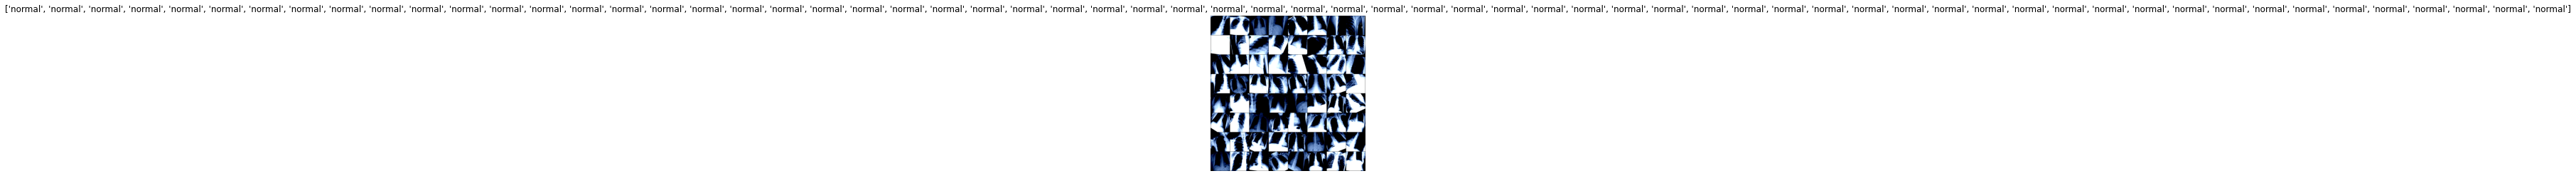

In [0]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(trainloader))
show_databatch(inputs, classes)

### ResNet18 Model

**Loading pre-trained model of ResNet-18 for ImageNet**

In [0]:
# Load the pretrained model from pytorch
resnet18 = models.resnet18(pretrained=True)
print(resnet18)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
 

**Freezing All the Layers**

In [0]:
for param in resnet18.parameters():
  param.requires_grad = False

**Replacing Previous FC Layers with new ones**

In [0]:
features = list()
features.extend([nn.Linear(512, 7100)])
features.extend([nn.ReLU(inplace=True)])
features.extend([nn.Linear(7100, 2)])
print(features)
resnet18.fc = nn.Sequential(*features)

[Linear(in_features=512, out_features=7100, bias=True), ReLU(inplace=True), Linear(in_features=7100, out_features=2, bias=True)]


**Now the Architecture Is Updated**

In [0]:
# print(resnet18)

**Unfreezing FC layers**

In [0]:
for param in resnet18.fc.parameters():
  param.requires_grad=True

*Uncomment to check that Last layers have been unfreezed*

In [0]:
# for param in resnet18.parameters():
#   print(param.requires_grad)

**Loss function and optimizer**

In [0]:
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9)

**Validation Function**

In [0]:
def evaluate(model_to_use,model):
    if model_to_use == 'r':
      model.train(False)
    if model_to_use == 'v':
      model.train(False)

    running_loss = 0.0
    running_corrects = 0.0
    num_images = 0
    vbar = tqdm(enumerate(validloader))
    for i, data in vbar:

        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        num_images = num_images+inputs.size(0)

        if model_to_use == 'r':
          outputs = model(inputs)
        if model_to_use == 'v':
          outputs = model(inputs)

        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels).item()

    epoch_loss = running_loss /num_images
    epochs_acc = running_corrects / num_images

    return epoch_loss, epochs_acc

**Training ResNet18**

In [0]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)

resnet18.train()
train_error=[]
val_error=[]
train_acc=[]
val_acc=[]

for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    running_corrects = 0.0
    num_images = 0

    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        num_images = num_images+inputs.size(0)

        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = resnet18(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update
        print("loss type",loss.data)

        _, preds = torch.max(outputs, 1)
        # print statistics
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels).item()

        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data))
        # train_error.append(loss.data)

    #train loss and accuracy
    epoch_loss = running_loss /num_images
    train_error.append(epoch_loss)
    epoch_acc = running_corrects / num_images
    train_acc.append(epoch_acc)

    #Validation loss and accuracy
    epoch_loss,epoch_acc = evaluate('r')
    val_error.append(epoch_loss)
    val_acc.append(epoch_acc)

    print('train loss: {}\n train acc: {}\n valid loss: {}\n valid acc:{}'.format(
        train_error[epoch],train_acc[epoch],val_error[epoch],val_acc[epoch]))

    torch.save(resnet18.state_dict(), data_dir+'res18_FC_Only.pth')

print('Finished Training')

Train Epoch: 0 [64/10697 (1%)]	Loss: 0.699683: : 1it [00:06,  6.27s/it]

loss type tensor(0.6762, device='cuda:0')
loss type tensor(0.6997, device='cuda:0')


Train Epoch: 0 [192/10697 (2%)]	Loss: 0.666949: : 3it [00:06,  4.42s/it]

loss type tensor(0.6703, device='cuda:0')
loss type tensor(0.6669, device='cuda:0')


Train Epoch: 0 [256/10697 (2%)]	Loss: 0.654519: : 5it [00:06,  3.13s/it]

loss type tensor(0.6545, device='cuda:0')


Train Epoch: 0 [384/10697 (4%)]	Loss: 0.630866: : 7it [00:12,  2.66s/it]

loss type tensor(0.6418, device='cuda:0')
loss type tensor(0.6309, device='cuda:0')


Train Epoch: 0 [512/10697 (5%)]	Loss: 0.555541: : 9it [00:12,  1.37s/it]

loss type tensor(0.6053, device='cuda:0')
loss type tensor(0.5555, device='cuda:0')


Train Epoch: 0 [576/10697 (5%)]	Loss: 0.567302: : 9it [00:12,  1.37s/it]

loss type tensor(0.5673, device='cuda:0')


Train Epoch: 0 [704/10697 (7%)]	Loss: 0.531601: : 11it [00:18,  1.82s/it]

loss type tensor(0.5508, device='cuda:0')
loss type tensor(0.5316, device='cuda:0')


Train Epoch: 0 [832/10697 (8%)]	Loss: 0.471000: : 14it [00:18,  1.05it/s]

loss type tensor(0.5325, device='cuda:0')
loss type tensor(0.4710, device='cuda:0')


Train Epoch: 0 [896/10697 (8%)]	Loss: 0.456195: : 15it [00:18,  1.41it/s]

loss type tensor(0.4562, device='cuda:0')


Train Epoch: 0 [1024/10697 (10%)]	Loss: 0.538703: : 17it [00:24,  1.53s/it]

loss type tensor(0.4806, device='cuda:0')
loss type tensor(0.5387, device='cuda:0')


Train Epoch: 0 [1216/10697 (11%)]	Loss: 0.462061: : 19it [00:24,  1.10s/it]

loss type tensor(0.4603, device='cuda:0')
loss type tensor(0.4236, device='cuda:0')
loss type tensor(0.4621, device='cuda:0')


Train Epoch: 0 [1280/10697 (12%)]	Loss: 0.530289: : 21it [00:29,  1.53s/it]

loss type tensor(0.5303, device='cuda:0')


Train Epoch: 0 [1408/10697 (13%)]	Loss: 0.385777: : 23it [00:32,  1.38s/it]

loss type tensor(0.4649, device='cuda:0')
loss type tensor(0.3858, device='cuda:0')


Train Epoch: 0 [1536/10697 (14%)]	Loss: 0.509537: : 25it [00:32,  1.01it/s]

loss type tensor(0.4397, device='cuda:0')
loss type tensor(0.5095, device='cuda:0')


Train Epoch: 0 [1600/10697 (15%)]	Loss: 0.521132: : 26it [00:35,  1.66s/it]

loss type tensor(0.5211, device='cuda:0')


Train Epoch: 0 [1728/10697 (16%)]	Loss: 0.523279: : 28it [00:38,  1.33s/it]

loss type tensor(0.4105, device='cuda:0')
loss type tensor(0.5233, device='cuda:0')


Train Epoch: 0 [1856/10697 (17%)]	Loss: 0.446244: : 29it [00:38,  1.03it/s]

loss type tensor(0.4109, device='cuda:0')
loss type tensor(0.4462, device='cuda:0')


Train Epoch: 0 [1920/10697 (18%)]	Loss: 0.426206: : 31it [00:41,  1.17s/it]

loss type tensor(0.4262, device='cuda:0')


Train Epoch: 0 [2048/10697 (19%)]	Loss: 0.415936: : 33it [00:43,  1.08s/it]

loss type tensor(0.3654, device='cuda:0')
loss type tensor(0.4159, device='cuda:0')


Train Epoch: 0 [2176/10697 (20%)]	Loss: 0.486701: : 35it [00:44,  1.27it/s]

loss type tensor(0.5573, device='cuda:0')
loss type tensor(0.4867, device='cuda:0')


Train Epoch: 0 [2240/10697 (21%)]	Loss: 0.432117: : 36it [00:46,  1.41s/it]

loss type tensor(0.4321, device='cuda:0')


Train Epoch: 0 [2368/10697 (22%)]	Loss: 0.411908: : 37it [00:49,  1.83s/it]

loss type tensor(0.4208, device='cuda:0')
loss type tensor(0.4119, device='cuda:0')


Train Epoch: 0 [2496/10697 (23%)]	Loss: 0.402807: : 39it [00:50,  1.32s/it]

loss type tensor(0.4004, device='cuda:0')
loss type tensor(0.4028, device='cuda:0')


Train Epoch: 0 [2560/10697 (24%)]	Loss: 0.439305: : 41it [00:52,  1.30s/it]

loss type tensor(0.4393, device='cuda:0')


Train Epoch: 0 [2752/10697 (26%)]	Loss: 0.523364: : 43it [00:55,  1.34s/it]

loss type tensor(0.3660, device='cuda:0')
loss type tensor(0.4205, device='cuda:0')
loss type tensor(0.5234, device='cuda:0')


Train Epoch: 0 [2816/10697 (26%)]	Loss: 0.424067: : 45it [00:55,  1.04it/s]

loss type tensor(0.4241, device='cuda:0')


Train Epoch: 0 [2880/10697 (27%)]	Loss: 0.475806: : 46it [00:58,  1.35s/it]

loss type tensor(0.4758, device='cuda:0')


Train Epoch: 0 [3072/10697 (29%)]	Loss: 0.508491: : 49it [01:01,  1.45s/it]

loss type tensor(0.4149, device='cuda:0')
loss type tensor(0.4928, device='cuda:0')
loss type tensor(0.5085, device='cuda:0')


Train Epoch: 0 [3136/10697 (29%)]	Loss: 0.420914: : 49it [01:02,  1.45s/it]

loss type tensor(0.4209, device='cuda:0')


Train Epoch: 0 [3200/10697 (30%)]	Loss: 0.360739: : 51it [01:03,  1.31s/it]

loss type tensor(0.3607, device='cuda:0')


Train Epoch: 0 [3328/10697 (31%)]	Loss: 0.547067: : 53it [01:08,  1.65s/it]

loss type tensor(0.4307, device='cuda:0')
loss type tensor(0.5471, device='cuda:0')


Train Epoch: 0 [3456/10697 (32%)]	Loss: 0.344859: : 55it [01:08,  1.14it/s]

loss type tensor(0.3108, device='cuda:0')
loss type tensor(0.3449, device='cuda:0')


Train Epoch: 0 [3520/10697 (33%)]	Loss: 0.395328: : 56it [01:09,  1.33it/s]

loss type tensor(0.3953, device='cuda:0')


Train Epoch: 0 [3648/10697 (34%)]	Loss: 0.464676: : 57it [01:14,  2.02s/it]

loss type tensor(0.5157, device='cuda:0')
loss type tensor(0.4647, device='cuda:0')


Train Epoch: 0 [3776/10697 (35%)]	Loss: 0.422075: : 59it [01:14,  1.45s/it]

loss type tensor(0.4527, device='cuda:0')
loss type tensor(0.4221, device='cuda:0')


Train Epoch: 0 [3840/10697 (36%)]	Loss: 0.294271: : 61it [01:15,  1.10s/it]

loss type tensor(0.2943, device='cuda:0')


Train Epoch: 0 [3968/10697 (37%)]	Loss: 0.552367: : 63it [01:20,  1.62s/it]

loss type tensor(0.4091, device='cuda:0')
loss type tensor(0.5524, device='cuda:0')


Train Epoch: 0 [4096/10697 (38%)]	Loss: 0.285108: : 65it [01:20,  1.16s/it]

loss type tensor(0.4324, device='cuda:0')
loss type tensor(0.2851, device='cuda:0')


Train Epoch: 0 [4160/10697 (39%)]	Loss: 0.487196: : 66it [01:20,  1.09it/s]

loss type tensor(0.4872, device='cuda:0')


Train Epoch: 0 [4288/10697 (40%)]	Loss: 0.342006: : 67it [01:26,  2.38s/it]

loss type tensor(0.3701, device='cuda:0')
loss type tensor(0.3420, device='cuda:0')


Train Epoch: 0 [4416/10697 (41%)]	Loss: 0.330887: : 69it [01:26,  1.70s/it]

loss type tensor(0.5801, device='cuda:0')
loss type tensor(0.3309, device='cuda:0')


Train Epoch: 0 [4480/10697 (42%)]	Loss: 0.480877: : 71it [01:27,  1.23s/it]

loss type tensor(0.4809, device='cuda:0')


Train Epoch: 0 [4608/10697 (43%)]	Loss: 0.391165: : 73it [01:32,  1.75s/it]

loss type tensor(0.3843, device='cuda:0')
loss type tensor(0.3912, device='cuda:0')
loss type 

Train Epoch: 0 [4800/10697 (45%)]	Loss: 0.312429: : 75it [01:32,  1.25s/it]

tensor(0.3534, device='cuda:0')
loss type tensor(0.5172, device='cuda:0')
loss type tensor(0.3124, device='cuda:0')


Train Epoch: 0 [4928/10697 (46%)]	Loss: 0.358238: : 77it [01:38,  1.71s/it]

loss type tensor(0.4469, device='cuda:0')
loss type tensor(0.3582, device='cuda:0')


Train Epoch: 0 [5056/10697 (47%)]	Loss: 0.453814: : 79it [01:38,  1.23s/it]

loss type tensor(0.3823, device='cuda:0')
loss type tensor(0.4538, device='cuda:0')


Train Epoch: 0 [5120/10697 (48%)]	Loss: 0.521090: : 81it [01:38,  1.12it/s]

loss type tensor(0.5211, device='cuda:0')


Train Epoch: 0 [5248/10697 (49%)]	Loss: 0.463730: : 83it [01:44,  1.59s/it]

loss type tensor(0.4236, device='cuda:0')
loss type tensor(0.4637, device='cuda:0')


Train Epoch: 0 [5440/10697 (51%)]	Loss: 0.388694: : 85it [01:44,  1.14s/it]

loss type tensor(0.3067, device='cuda:0')
loss type tensor(0.4505, device='cuda:0')
loss type tensor(0.3887, device='cuda:0')


Train Epoch: 0 [5568/10697 (52%)]	Loss: 0.260788: : 87it [01:50,  1.68s/it]

loss type tensor(0.3346, device='cuda:0')
loss type tensor(0.2608, device='cuda:0')
loss type tensor(0.4187, device='cuda:0')


Train Epoch: 0 [5696/10697 (53%)]	Loss: 0.326799: : 89it [01:50,  1.20s/it]

loss type tensor(0.3268, device='cuda:0')


Train Epoch: 0 [5760/10697 (54%)]	Loss: 0.328421: : 91it [01:50,  1.09it/s]

loss type tensor(0.3284, device='cuda:0')


Train Epoch: 0 [5952/10697 (55%)]	Loss: 0.315533: : 93it [01:56,  1.72s/it]

loss type tensor(0.4428, device='cuda:0')
loss type tensor(0.2988, device='cuda:0')
loss type tensor(0.3155, device='cuda:0')


Train Epoch: 0 [6080/10697 (57%)]	Loss: 0.354898: : 95it [01:57,  1.23s/it]

loss type tensor(0.3107, device='cuda:0')
loss type tensor(0.3549, device='cuda:0')


Train Epoch: 0 [6208/10697 (58%)]	Loss: 0.416825: : 97it [02:02,  1.62s/it]

loss type tensor(0.5395, device='cuda:0')
loss type tensor(0.4168, device='cuda:0')
loss type tensor(0.3237, device='cuda:0')

Train Epoch: 0 [6336/10697 (59%)]	Loss: 0.273044: : 99it [02:02,  1.16s/it]


loss type tensor(0.2730, device='cuda:0')


Train Epoch: 0 [6400/10697 (60%)]	Loss: 0.445733: : 101it [02:02,  1.14it/s]

loss type tensor(0.4457, device='cuda:0')


Train Epoch: 0 [6528/10697 (61%)]	Loss: 0.410481: : 103it [02:07,  1.54s/it]

loss type tensor(0.3761, device='cuda:0')
loss type tensor(0.4105, device='cuda:0')


Train Epoch: 0 [6656/10697 (62%)]	Loss: 0.560095: : 105it [02:08,  1.23it/s]

loss type tensor(0.3974, device='cuda:0')
loss type tensor(0.5601, device='cuda:0')


Train Epoch: 0 [6720/10697 (62%)]	Loss: 0.335342: : 106it [02:08,  1.59it/s]

loss type tensor(0.3353, device='cuda:0')


Train Epoch: 0 [6848/10697 (64%)]	Loss: 0.410799: : 107it [02:13,  2.07s/it]

loss type tensor(0.3686, device='cuda:0')
loss type tensor(0.4108, device='cuda:0')


Train Epoch: 0 [6976/10697 (65%)]	Loss: 0.548925: : 110it [02:14,  1.08s/it]

loss type tensor(0.3019, device='cuda:0')
loss type tensor(0.5489, device='cuda:0')


Train Epoch: 0 [7040/10697 (65%)]	Loss: 0.518299: : 111it [02:14,  1.17it/s]

loss type tensor(0.5183, device='cuda:0')


Train Epoch: 0 [7168/10697 (67%)]	Loss: 0.466819: : 113it [02:19,  1.55s/it]

loss type tensor(0.3816, device='cuda:0')
loss type tensor(0.4668, device='cuda:0')


Train Epoch: 0 [7296/10697 (68%)]	Loss: 0.262009: : 115it [02:20,  1.11s/it]

loss type tensor(0.3146, device='cuda:0')
loss type tensor(0.2620, device='cuda:0')


Train Epoch: 0 [7360/10697 (68%)]	Loss: 0.272174: : 116it [02:20,  1.12it/s]

loss type tensor(0.2722, device='cuda:0')


Train Epoch: 0 [7488/10697 (70%)]	Loss: 0.384041: : 117it [02:25,  2.16s/it]

loss type tensor(0.2174, device='cuda:0')
loss type tensor(0.3840, device='cuda:0')


Train Epoch: 0 [7616/10697 (71%)]	Loss: 0.476190: : 119it [02:25,  1.55s/it]

loss type tensor(0.3765, device='cuda:0')
loss type tensor(0.4762, device='cuda:0')


Train Epoch: 0 [7680/10697 (71%)]	Loss: 0.577650: : 121it [02:26,  1.21s/it]

loss type tensor(0.5776, device='cuda:0')


Train Epoch: 0 [7808/10697 (73%)]	Loss: 0.443715: : 123it [02:31,  1.61s/it]

loss type tensor(0.4169, device='cuda:0')
loss type tensor(0.4437, device='cuda:0')


Train Epoch: 0 [7936/10697 (74%)]	Loss: 0.384945: : 125it [02:31,  1.16s/it]

loss type tensor(0.3553, device='cuda:0')
loss type tensor(0.3849, device='cuda:0')


Train Epoch: 0 [8000/10697 (74%)]	Loss: 0.207827: : 126it [02:32,  1.03s/it]

loss type tensor(0.2078, device='cuda:0')


Train Epoch: 0 [8128/10697 (76%)]	Loss: 0.547124: : 128it [02:37,  1.50s/it]

loss type tensor(0.3869, device='cuda:0')
loss type tensor(0.5471, device='cuda:0')


Train Epoch: 0 [8256/10697 (77%)]	Loss: 0.373540: : 129it [02:37,  1.10s/it]

loss type tensor(0.5737, device='cuda:0')
loss type tensor(0.3735, device='cuda:0')


Train Epoch: 0 [8320/10697 (77%)]	Loss: 0.474790: : 131it [02:38,  1.08it/s]

loss type tensor(0.4748, device='cuda:0')


Train Epoch: 0 [8448/10697 (79%)]	Loss: 0.580093: : 133it [02:42,  1.41s/it]

loss type tensor(0.4283, device='cuda:0')
loss type tensor(0.5801, device='cuda:0')


Train Epoch: 0 [8576/10697 (80%)]	Loss: 0.321626: : 135it [02:42,  1.02s/it]

loss type tensor(0.4405, device='cuda:0')
loss type tensor(0.3216, device='cuda:0')


Train Epoch: 0 [8640/10697 (80%)]	Loss: 0.308973: : 136it [02:44,  1.27s/it]

loss type tensor(0.3090, device='cuda:0')


Train Epoch: 0 [8768/10697 (82%)]	Loss: 0.446269: : 138it [02:48,  1.47s/it]

loss type tensor(0.4951, device='cuda:0')
loss type tensor(0.4463, device='cuda:0')


Train Epoch: 0 [8896/10697 (83%)]	Loss: 0.371780: : 139it [02:48,  1.07s/it]

loss type tensor(0.4930, device='cuda:0')
loss type tensor(0.3718, device='cuda:0')


Train Epoch: 0 [8960/10697 (83%)]	Loss: 0.344335: : 141it [02:50,  1.01s/it]

loss type tensor(0.3443, device='cuda:0')


Train Epoch: 0 [9088/10697 (85%)]	Loss: 0.564226: : 143it [02:54,  1.40s/it]

loss type tensor(0.3523, device='cuda:0')
loss type tensor(0.5642, device='cuda:0')


Train Epoch: 0 [9216/10697 (86%)]	Loss: 0.336965: : 145it [02:55,  1.01s/it]

loss type tensor(0.4687, device='cuda:0')
loss type tensor(0.3370, device='cuda:0')


Train Epoch: 0 [9280/10697 (86%)]	Loss: 0.555954: : 146it [02:56,  1.11s/it]

loss type tensor(0.5560, device='cuda:0')


Train Epoch: 0 [9408/10697 (88%)]	Loss: 0.356998: : 148it [03:00,  1.47s/it]

loss type tensor(0.4984, device='cuda:0')
loss type tensor(0.3570, device='cuda:0')


Train Epoch: 0 [9536/10697 (89%)]	Loss: 0.306930: : 149it [03:01,  1.07s/it]

loss type tensor(0.4017, device='cuda:0')
loss type tensor(0.3069, device='cuda:0')


Train Epoch: 0 [9600/10697 (89%)]	Loss: 0.261744: : 151it [03:03,  1.06s/it]

loss type tensor(0.2617, device='cuda:0')


Train Epoch: 0 [9728/10697 (90%)]	Loss: 0.381521: : 153it [03:07,  1.38s/it]

loss type tensor(0.4045, device='cuda:0')
loss type tensor(0.3815, device='cuda:0')
loss type tensor(0.3621, device='cuda:0')

Train Epoch: 0 [9856/10697 (92%)]	Loss: 0.400940: : 155it [03:07,  1.01it/s]


loss type tensor(0.4009, device='cuda:0')


Train Epoch: 0 [9920/10697 (92%)]	Loss: 0.325217: : 156it [03:09,  1.37s/it]

loss type tensor(0.3252, device='cuda:0')


Train Epoch: 0 [10112/10697 (94%)]	Loss: 0.349772: : 157it [03:12,  1.92s/it]

loss type tensor(0.3143, device='cuda:0')
loss type tensor(0.4663, device='cuda:0')
loss type tensor(0.3498, device='cuda:0')


Train Epoch: 0 [10176/10697 (95%)]	Loss: 0.500396: : 159it [03:12,  1.37s/it]

loss type tensor(0.5004, device='cuda:0')


Train Epoch: 0 [10240/10697 (95%)]	Loss: 0.443589: : 161it [03:14,  1.25s/it]

loss type tensor(0.4436, device='cuda:0')


Train Epoch: 0 [10304/10697 (96%)]	Loss: 0.312100: : 162it [03:16,  1.40s/it]

loss type tensor(0.3121, device='cuda:0')


Train Epoch: 0 [10496/10697 (98%)]	Loss: 0.388187: : 165it [03:17,  1.27it/s]

loss type tensor(0.3316, device='cuda:0')
loss type tensor(0.3260, device='cuda:0')
loss type tensor(0.3882, device='cuda:0')


Train Epoch: 0 [10560/10697 (98%)]	Loss: 0.353160: : 166it [03:17,  1.28it/s]

loss type tensor(0.3532, device='cuda:0')


Train Epoch: 0 [1503/10697 (99%)]	Loss: 0.590973: : 168it [03:19,  1.18s/it]

loss type tensor(0.4650, device='cuda:0')
loss type tensor(0.5910, device='cuda:0')



24it [00:24,  1.02s/it]


train loss: 0.006754085399273835
 train acc: 0.8068617369355894
 valid loss: 0.005835319091876348
 valid acc:0.8433333333333334


Train Epoch: 1 [0/10697 (0%)]	Loss: 0.303746: : 1it [00:05,  5.89s/it]

loss type tensor(0.3037, device='cuda:0')


Train Epoch: 1 [128/10697 (1%)]	Loss: 0.371033: : 3it [00:06,  3.04s/it]

loss type tensor(0.3275, device='cuda:0')
loss type tensor(0.3710, device='cuda:0')


Train Epoch: 1 [192/10697 (2%)]	Loss: 0.279776: : 3it [00:06,  3.04s/it]

loss type tensor(0.2798, device='cuda:0')
loss type 

Train Epoch: 1 [256/10697 (2%)]	Loss: 0.449843: : 5it [00:06,  2.17s/it]

tensor(0.4498, device='cuda:0')


Train Epoch: 1 [320/10697 (3%)]	Loss: 0.355248: : 6it [00:11,  2.94s/it]

loss type tensor(0.3552, device='cuda:0')


Train Epoch: 1 [448/10697 (4%)]	Loss: 0.267504: : 8it [00:12,  1.66s/it]

loss type tensor(0.2904, device='cuda:0')
loss type tensor(0.2675, device='cuda:0')


Train Epoch: 1 [576/10697 (5%)]	Loss: 0.274407: : 9it [00:12,  1.20s/it]

loss type tensor(0.4098, device='cuda:0')
loss type tensor(0.2744, device='cuda:0')


Train Epoch: 1 [640/10697 (6%)]	Loss: 0.513012: : 11it [00:17,  1.54s/it]

loss type tensor(0.5130, device='cuda:0')


Train Epoch: 1 [832/10697 (8%)]	Loss: 0.480166: : 13it [00:18,  1.01s/it]

loss type tensor(0.3991, device='cuda:0')
loss type tensor(0.3402, device='cuda:0')
loss type tensor(0.4802, device='cuda:0')


Train Epoch: 1 [896/10697 (8%)]	Loss: 0.572958: : 15it [00:18,  1.36it/s]

loss type tensor(0.5730, device='cuda:0')


Train Epoch: 1 [960/10697 (9%)]	Loss: 0.381600: : 16it [00:22,  1.77s/it]

loss type tensor(0.3816, device='cuda:0')


Train Epoch: 1 [1088/10697 (10%)]	Loss: 0.365550: : 17it [00:24,  1.74s/it]

loss type tensor(0.4219, device='cuda:0')
loss type tensor(0.3656, device='cuda:0')


Train Epoch: 1 [1216/10697 (11%)]	Loss: 0.299386: : 19it [00:24,  1.25s/it]

loss type tensor(0.3621, device='cuda:0')
loss type tensor(0.2994, device='cuda:0')


Train Epoch: 1 [1280/10697 (12%)]	Loss: 0.322040: : 21it [00:28,  1.51s/it]

loss type tensor(0.3220, device='cuda:0')


Train Epoch: 1 [1408/10697 (13%)]	Loss: 0.316354: : 23it [00:30,  1.09s/it]

loss type tensor(0.3222, device='cuda:0')
loss type tensor(0.3164, device='cuda:0')


Train Epoch: 1 [1536/10697 (14%)]	Loss: 0.325072: : 25it [00:30,  1.26it/s]

loss type tensor(0.3677, device='cuda:0')
loss type tensor(0.3251, device='cuda:0')


Train Epoch: 1 [1600/10697 (15%)]	Loss: 0.338886: : 26it [00:34,  1.74s/it]

loss type tensor(0.3389, device='cuda:0')


Train Epoch: 1 [1728/10697 (16%)]	Loss: 0.448846: : 27it [00:36,  1.62s/it]

loss type tensor(0.2894, device='cuda:0')
loss type tensor(0.4488, device='cuda:0')


Train Epoch: 1 [1856/10697 (17%)]	Loss: 0.403524: : 29it [00:36,  1.17s/it]

loss type tensor(0.4359, device='cuda:0')
loss type tensor(0.4035, device='cuda:0')


Train Epoch: 1 [1920/10697 (18%)]	Loss: 0.313648: : 31it [00:40,  1.45s/it]

loss type tensor(0.3136, device='cuda:0')


Train Epoch: 1 [2048/10697 (19%)]	Loss: 0.269170: : 33it [00:41,  1.01it/s]

loss type tensor(0.3474, device='cuda:0')
loss type tensor(0.2692, device='cuda:0')


Train Epoch: 1 [2176/10697 (20%)]	Loss: 0.485767: : 35it [00:42,  1.61it/s]

loss type tensor(0.4051, device='cuda:0')
loss type tensor(0.4858, device='cuda:0')


Train Epoch: 1 [2240/10697 (21%)]	Loss: 0.300068: : 36it [00:47,  1.95s/it]

loss type tensor(0.3001, device='cuda:0')
loss type tensor(0.3931, device='cuda:0')


Train Epoch: 1 [2368/10697 (22%)]	Loss: 0.345916: : 37it [00:47,  1.42s/it]

loss type tensor(0.3459, device='cuda:0')


Train Epoch: 1 [2496/10697 (23%)]	Loss: 0.281988: : 40it [00:48,  1.29it/s]

loss type tensor(0.3940, device='cuda:0')
loss type tensor(0.2820, device='cuda:0')


Train Epoch: 1 [2560/10697 (24%)]	Loss: 0.472672: : 41it [00:53,  2.07s/it]

loss type tensor(0.4727, device='cuda:0')


Train Epoch: 1 [2688/10697 (25%)]	Loss: 0.374949: : 43it [00:53,  1.12s/it]

loss type tensor(0.5074, device='cuda:0')
loss type tensor(0.3749, device='cuda:0')


Train Epoch: 1 [2816/10697 (26%)]	Loss: 0.411916: : 45it [00:55,  1.15it/s]

loss type tensor(0.3912, device='cuda:0')
loss type tensor(0.4119, device='cuda:0')


Train Epoch: 1 [2880/10697 (27%)]	Loss: 0.351371: : 46it [00:59,  1.76s/it]

loss type tensor(0.3514, device='cuda:0')


Train Epoch: 1 [3008/10697 (28%)]	Loss: 0.297354: : 47it [00:59,  1.37s/it]

loss type tensor(0.2494, device='cuda:0')
loss type tensor(0.2974, device='cuda:0')


Train Epoch: 1 [3136/10697 (29%)]	Loss: 0.450885: : 49it [01:01,  1.19s/it]

loss type tensor(0.3835, device='cuda:0')
loss type tensor(0.4509, device='cuda:0')


Train Epoch: 1 [3200/10697 (30%)]	Loss: 0.337556: : 51it [01:04,  1.41s/it]

loss type tensor(0.3376, device='cuda:0')


Train Epoch: 1 [3328/10697 (31%)]	Loss: 0.408657: : 53it [01:05,  1.11it/s]

loss type tensor(0.3946, device='cuda:0')
loss type tensor(0.4087, device='cuda:0')


Train Epoch: 1 [3456/10697 (32%)]	Loss: 0.344904: : 55it [01:07,  1.29it/s]

loss type tensor(0.4326, device='cuda:0')
loss type tensor(0.3449, device='cuda:0')


Train Epoch: 1 [3520/10697 (33%)]	Loss: 0.428588: : 56it [01:10,  1.50s/it]

loss type tensor(0.4286, device='cuda:0')


Train Epoch: 1 [3648/10697 (34%)]	Loss: 0.328044: : 57it [01:11,  1.37s/it]

loss type tensor(0.4229, device='cuda:0')
loss type tensor(0.3280, device='cuda:0')


Train Epoch: 1 [3776/10697 (35%)]	Loss: 0.365469: : 59it [01:12,  1.16s/it]

loss type tensor(0.2875, device='cuda:0')
loss type tensor(0.3655, device='cuda:0')


Train Epoch: 1 [3840/10697 (36%)]	Loss: 0.392442: : 61it [01:16,  1.32s/it]

loss type tensor(0.3924, device='cuda:0')


Train Epoch: 1 [3968/10697 (37%)]	Loss: 0.474563: : 63it [01:17,  1.10it/s]

loss type tensor(0.4404, device='cuda:0')
loss type tensor(0.4746, device='cuda:0')


Train Epoch: 1 [4096/10697 (38%)]	Loss: 0.429648: : 65it [01:18,  1.39it/s]

loss type tensor(0.6052, device='cuda:0')
loss type tensor(0.4296, device='cuda:0')


Train Epoch: 1 [4160/10697 (39%)]	Loss: 0.332179: : 66it [01:22,  1.54s/it]

loss type tensor(0.3322, device='cuda:0')


Train Epoch: 1 [4288/10697 (40%)]	Loss: 0.333553: : 67it [01:24,  1.66s/it]

loss type tensor(0.4227, device='cuda:0')
loss type tensor(0.3336, device='cuda:0')


Train Epoch: 1 [4416/10697 (41%)]	Loss: 0.391498: : 69it [01:24,  1.26s/it]

loss type tensor(0.3334, device='cuda:0')
loss type tensor(0.3915, device='cuda:0')


Train Epoch: 1 [4480/10697 (42%)]	Loss: 0.455295: : 71it [01:28,  1.37s/it]

loss type tensor(0.4553, device='cuda:0')


Train Epoch: 1 [4608/10697 (43%)]	Loss: 0.397294: : 73it [01:30,  1.12s/it]

loss type tensor(0.3972, device='cuda:0')
loss type tensor(0.3973, device='cuda:0')


Train Epoch: 1 [4736/10697 (44%)]	Loss: 0.395645: : 75it [01:30,  1.36it/s]

loss type tensor(0.4491, device='cuda:0')
loss type tensor(0.3956, device='cuda:0')


Train Epoch: 1 [4800/10697 (45%)]	Loss: 0.265295: : 76it [01:34,  1.47s/it]

loss type tensor(0.2653, device='cuda:0')


Train Epoch: 1 [4928/10697 (46%)]	Loss: 0.315202: : 78it [01:36,  1.20s/it]

loss type tensor(0.3748, device='cuda:0')
loss type tensor(0.3152, device='cuda:0')


Train Epoch: 1 [5056/10697 (47%)]	Loss: 0.410586: : 79it [01:36,  1.12it/s]

loss type tensor(0.3483, device='cuda:0')
loss type tensor(0.4106, device='cuda:0')


Train Epoch: 1 [5120/10697 (48%)]	Loss: 0.219974: : 81it [01:39,  1.11s/it]

loss type tensor(0.2200, device='cuda:0')


Train Epoch: 1 [5248/10697 (49%)]	Loss: 0.336664: : 82it [01:41,  1.36s/it]

loss type tensor(0.2652, device='cuda:0')
loss type tensor(0.3367, device='cuda:0')


Train Epoch: 1 [5376/10697 (50%)]	Loss: 0.381137: : 85it [01:42,  1.28it/s]

loss type tensor(0.3264, device='cuda:0')
loss type tensor(0.3811, device='cuda:0')


Train Epoch: 1 [5440/10697 (51%)]	Loss: 0.406929: : 86it [01:45,  1.45s/it]

loss type tensor(0.4069, device='cuda:0')


Train Epoch: 1 [5568/10697 (52%)]	Loss: 0.333612: : 87it [01:47,  1.64s/it]

loss type tensor(0.4005, device='cuda:0')
loss type tensor(0.3336, device='cuda:0')


Train Epoch: 1 [5696/10697 (53%)]	Loss: 0.334534: : 89it [01:48,  1.25s/it]

loss type tensor(0.3354, device='cuda:0')
loss type tensor(0.3345, device='cuda:0')


Train Epoch: 1 [5760/10697 (54%)]	Loss: 0.366493: : 91it [01:52,  1.47s/it]

loss type tensor(0.3665, device='cuda:0')


Train Epoch: 1 [5952/10697 (55%)]	Loss: 0.468842: : 93it [01:54,  1.10s/it]

loss type tensor(0.3279, device='cuda:0')
loss type tensor(0.3455, device='cuda:0')
loss type tensor(0.4688, device='cuda:0')


Train Epoch: 1 [6016/10697 (56%)]	Loss: 0.288715: : 95it [01:54,  1.25it/s]

loss type tensor(0.2887, device='cuda:0')


Train Epoch: 1 [6080/10697 (57%)]	Loss: 0.342874: : 96it [01:58,  1.73s/it]

loss type tensor(0.3429, device='cuda:0')


Train Epoch: 1 [6208/10697 (58%)]	Loss: 0.432534: : 97it [02:00,  1.75s/it]

loss type tensor(0.3616, device='cuda:0')
loss type tensor(0.4325, device='cuda:0')
loss type 

Train Epoch: 1 [6336/10697 (59%)]	Loss: 0.329587: : 99it [02:00,  1.26s/it]

tensor(0.3656, device='cuda:0')
loss type tensor(0.3296, device='cuda:0')


Train Epoch: 1 [6400/10697 (60%)]	Loss: 0.338097: : 101it [02:04,  1.47s/it]

loss type tensor(0.3381, device='cuda:0')


Train Epoch: 1 [6528/10697 (61%)]	Loss: 0.380242: : 103it [02:05,  1.10s/it]

loss type tensor(0.4288, device='cuda:0')
loss type tensor(0.3802, device='cuda:0')


Train Epoch: 1 [6656/10697 (62%)]	Loss: 0.340760: : 105it [02:06,  1.25it/s]

loss type tensor(0.4476, device='cuda:0')
loss type tensor(0.3408, device='cuda:0')


Train Epoch: 1 [6720/10697 (62%)]	Loss: 0.321657: : 106it [02:09,  1.67s/it]

loss type tensor(0.3217, device='cuda:0')


Train Epoch: 1 [6848/10697 (64%)]	Loss: 0.393180: : 107it [02:11,  1.64s/it]

loss type tensor(0.3869, device='cuda:0')
loss type tensor(0.3932, device='cuda:0')


Train Epoch: 1 [6976/10697 (65%)]	Loss: 0.303349: : 110it [02:13,  1.09s/it]

loss type tensor(0.4041, device='cuda:0')
loss type tensor(0.3033, device='cuda:0')


Train Epoch: 1 [7040/10697 (65%)]	Loss: 0.437264: : 111it [02:15,  1.33s/it]

loss type tensor(0.4373, device='cuda:0')


Train Epoch: 1 [7168/10697 (67%)]	Loss: 0.316393: : 113it [02:17,  1.01s/it]

loss type tensor(0.4048, device='cuda:0')
loss type tensor(0.3164, device='cuda:0')


Train Epoch: 1 [7296/10697 (68%)]	Loss: 0.315655: : 115it [02:19,  1.01s/it]

loss type tensor(0.3732, device='cuda:0')
loss type tensor(0.3157, device='cuda:0')


Train Epoch: 1 [7360/10697 (68%)]	Loss: 0.360915: : 116it [02:21,  1.30s/it]

loss type tensor(0.3609, device='cuda:0')


Train Epoch: 1 [7488/10697 (70%)]	Loss: 0.374999: : 117it [02:23,  1.39s/it]

loss type tensor(0.3607, device='cuda:0')
loss type tensor(0.3750, device='cuda:0')


Train Epoch: 1 [7616/10697 (71%)]	Loss: 0.375145: : 119it [02:25,  1.30s/it]

loss type tensor(0.4305, device='cuda:0')
loss type tensor(0.3751, device='cuda:0')


Train Epoch: 1 [7680/10697 (71%)]	Loss: 0.487329: : 121it [02:28,  1.28s/it]

loss type tensor(0.4873, device='cuda:0')


Train Epoch: 1 [7744/10697 (72%)]	Loss: 0.365059: : 122it [02:29,  1.21s/it]

loss type tensor(0.3651, device='cuda:0')


Train Epoch: 1 [7808/10697 (73%)]	Loss: 0.330869: : 123it [02:30,  1.22s/it]

loss type tensor(0.3309, device='cuda:0')


Train Epoch: 1 [7936/10697 (74%)]	Loss: 0.444367: : 125it [02:31,  1.19it/s]

loss type tensor(0.3037, device='cuda:0')
loss type tensor(0.4444, device='cuda:0')


Train Epoch: 1 [8000/10697 (74%)]	Loss: 0.269599: : 126it [02:33,  1.29s/it]

loss type tensor(0.2696, device='cuda:0')


Train Epoch: 1 [8064/10697 (75%)]	Loss: 0.305423: : 127it [02:34,  1.26s/it]

loss type tensor(0.3054, device='cuda:0')


Train Epoch: 1 [8128/10697 (76%)]	Loss: 0.324751: : 128it [02:36,  1.34s/it]

loss type tensor(0.3248, device='cuda:0')


Train Epoch: 1 [8256/10697 (77%)]	Loss: 0.392670: : 129it [02:37,  1.24s/it]

loss type tensor(0.3783, device='cuda:0')
loss type tensor(0.3927, device='cuda:0')


Train Epoch: 1 [8320/10697 (77%)]	Loss: 0.232155: : 131it [02:39,  1.20s/it]

loss type tensor(0.2322, device='cuda:0')


Train Epoch: 1 [8384/10697 (78%)]	Loss: 0.280756: : 132it [02:41,  1.47s/it]

loss type tensor(0.2808, device='cuda:0')


Train Epoch: 1 [8512/10697 (79%)]	Loss: 0.336443: : 134it [02:43,  1.08s/it]

loss type tensor(0.2883, device='cuda:0')
loss type tensor(0.3364, device='cuda:0')


Train Epoch: 1 [8576/10697 (80%)]	Loss: 0.449267: : 135it [02:43,  1.25it/s]

loss type tensor(0.4493, device='cuda:0')


Train Epoch: 1 [8640/10697 (80%)]	Loss: 0.349332: : 136it [02:45,  1.27s/it]

loss type tensor(0.3493, device='cuda:0')


Train Epoch: 1 [8704/10697 (81%)]	Loss: 0.432228: : 137it [02:47,  1.44s/it]

loss type tensor(0.4322, device='cuda:0')


Train Epoch: 1 [8832/10697 (82%)]	Loss: 0.401032: : 139it [02:49,  1.06s/it]

loss type tensor(0.2896, device='cuda:0')
loss type tensor(0.4010, device='cuda:0')


Train Epoch: 1 [8896/10697 (83%)]	Loss: 0.291298: : 139it [02:49,  1.06s/it]

loss type tensor(0.2913, device='cuda:0')


Train Epoch: 1 [8960/10697 (83%)]	Loss: 0.484299: : 141it [02:51,  1.08s/it]

loss type tensor(0.4843, device='cuda:0')


Train Epoch: 1 [9024/10697 (84%)]	Loss: 0.352103: : 142it [02:53,  1.31s/it]

loss type tensor(0.3521, device='cuda:0')


Train Epoch: 1 [9088/10697 (85%)]	Loss: 0.355414: : 143it [02:55,  1.48s/it]

loss type tensor(0.3554, device='cuda:0')


Train Epoch: 1 [9216/10697 (86%)]	Loss: 0.334307: : 145it [02:56,  1.03it/s]

loss type tensor(0.3341, device='cuda:0')
loss type tensor(0.3343, device='cuda:0')


Train Epoch: 1 [9280/10697 (86%)]	Loss: 0.405383: : 146it [02:57,  1.03it/s]

loss type tensor(0.4054, device='cuda:0')


Train Epoch: 1 [9344/10697 (87%)]	Loss: 0.337967: : 147it [02:59,  1.28s/it]

loss type tensor(0.3380, device='cuda:0')


Train Epoch: 1 [9408/10697 (88%)]	Loss: 0.339679: : 148it [03:01,  1.44s/it]

loss type tensor(0.3397, device='cuda:0')


Train Epoch: 1 [9536/10697 (89%)]	Loss: 0.362767: : 149it [03:02,  1.26s/it]

loss type tensor(0.3565, device='cuda:0')
loss type tensor(0.3628, device='cuda:0')


Train Epoch: 1 [9600/10697 (89%)]	Loss: 0.355634: : 151it [03:03,  1.03s/it]

loss type tensor(0.3556, device='cuda:0')


Train Epoch: 1 [9664/10697 (90%)]	Loss: 0.309133: : 152it [03:05,  1.37s/it]

loss type tensor(0.3091, device='cuda:0')


Train Epoch: 1 [9728/10697 (90%)]	Loss: 0.414812: : 153it [03:07,  1.55s/it]

loss type tensor(0.4148, device='cuda:0')


Train Epoch: 1 [9856/10697 (92%)]	Loss: 0.387950: : 154it [03:07,  1.22s/it]

loss type tensor(0.2910, device='cuda:0')
loss type tensor(0.3879, device='cuda:0')


Train Epoch: 1 [9920/10697 (92%)]	Loss: 0.366704: : 156it [03:08,  1.12it/s]

loss type tensor(0.3667, device='cuda:0')


Train Epoch: 1 [9984/10697 (93%)]	Loss: 0.516867: : 157it [03:12,  1.77s/it]

loss type tensor(0.5169, device='cuda:0')


Train Epoch: 1 [10112/10697 (94%)]	Loss: 0.306090: : 159it [03:13,  1.09s/it]

loss type tensor(0.3961, device='cuda:0')
loss type tensor(0.3061, device='cuda:0')


Train Epoch: 1 [10176/10697 (95%)]	Loss: 0.272220: : 159it [03:13,  1.09s/it]

loss type tensor(0.2722, device='cuda:0')


Train Epoch: 1 [10240/10697 (95%)]	Loss: 0.353229: : 161it [03:14,  1.06it/s]

loss type tensor(0.3532, device='cuda:0')


Train Epoch: 1 [10304/10697 (96%)]	Loss: 0.339601: : 162it [03:18,  1.78s/it]

loss type tensor(0.3396, device='cuda:0')


Train Epoch: 1 [10368/10697 (96%)]	Loss: 0.413176: : 163it [03:18,  1.35s/it]

loss type tensor(0.4132, device='cuda:0')


Train Epoch: 1 [10496/10697 (98%)]	Loss: 0.392732: : 164it [03:19,  1.06s/it]

loss type tensor(0.3043, device='cuda:0')
loss type tensor(0.3927, device='cuda:0')


Train Epoch: 1 [10560/10697 (98%)]	Loss: 0.394102: : 166it [03:19,  1.24it/s]

loss type tensor(0.3941, device='cuda:0')


Train Epoch: 1 [1503/10697 (99%)]	Loss: 0.319249: : 168it [03:21,  1.20s/it]

loss type tensor(0.3636, device='cuda:0')
loss type tensor(0.3192, device='cuda:0')



24it [00:24,  1.02s/it]


train loss: 0.005772912500617192
 train acc: 0.8439749462466112
 valid loss: 0.005718032975991567
 valid acc:0.846


Train Epoch: 2 [0/10697 (0%)]	Loss: 0.436006: : 1it [00:05,  5.75s/it]

loss type tensor(0.4360, device='cuda:0')


Train Epoch: 2 [192/10697 (2%)]	Loss: 0.401929: : 4it [00:06,  2.92s/it]

loss type tensor(0.4228, device='cuda:0')
loss type tensor(0.3891, device='cuda:0')
loss type tensor(0.4019, device='cuda:0')


Train Epoch: 2 [256/10697 (2%)]	Loss: 0.356629: : 5it [00:06,  2.07s/it]

loss type tensor(0.3566, device='cuda:0')


Train Epoch: 2 [320/10697 (3%)]	Loss: 0.422531: : 6it [00:11,  2.95s/it]

loss type tensor(0.4225, device='cuda:0')


Train Epoch: 2 [448/10697 (4%)]	Loss: 0.281301: : 7it [00:12,  2.37s/it]

loss type tensor(0.2923, device='cuda:0')
loss type tensor(0.2813, device='cuda:0')
loss type 

Train Epoch: 2 [576/10697 (5%)]	Loss: 0.676614: : 9it [00:12,  1.69s/it]

tensor(0.3162, device='cuda:0')
loss type tensor(0.6766, device='cuda:0')


Train Epoch: 2 [640/10697 (6%)]	Loss: 0.489453: : 11it [00:17,  1.85s/it]

loss type tensor(0.4895, device='cuda:0')


Train Epoch: 2 [768/10697 (7%)]	Loss: 0.386934: : 13it [00:18,  1.19s/it]

loss type tensor(0.3558, device='cuda:0')
loss type tensor(0.3869, device='cuda:0')


Train Epoch: 2 [896/10697 (8%)]	Loss: 0.350954: : 15it [00:18,  1.16it/s]

loss type tensor(0.5575, device='cuda:0')
loss type tensor(0.3510, device='cuda:0')


Train Epoch: 2 [960/10697 (9%)]	Loss: 0.366757: : 16it [00:22,  1.88s/it]

loss type tensor(0.3668, device='cuda:0')


Train Epoch: 2 [1088/10697 (10%)]	Loss: 0.408324: : 17it [00:24,  1.67s/it]

loss type tensor(0.3737, device='cuda:0')
loss type tensor(0.4083, device='cuda:0')


Train Epoch: 2 [1216/10697 (11%)]	Loss: 0.432869: : 19it [00:24,  1.20s/it]

loss type tensor(0.3759, device='cuda:0')
loss type tensor(0.4329, device='cuda:0')


Train Epoch: 2 [1280/10697 (12%)]	Loss: 0.421537: : 21it [00:28,  1.48s/it]

loss type tensor(0.4215, device='cuda:0')


Train Epoch: 2 [1408/10697 (13%)]	Loss: 0.379996: : 23it [00:29,  1.06s/it]

loss type tensor(0.4290, device='cuda:0')
loss type tensor(0.3800, device='cuda:0')


Train Epoch: 2 [1472/10697 (14%)]	Loss: 0.465270: : 23it [00:30,  1.06s/it]

loss type tensor(0.4653, device='cuda:0')


Train Epoch: 2 [1536/10697 (14%)]	Loss: 0.445945: : 25it [00:30,  1.19it/s]

loss type tensor(0.4459, device='cuda:0')


Train Epoch: 2 [1600/10697 (15%)]	Loss: 0.264713: : 26it [00:34,  1.65s/it]

loss type tensor(0.2647, device='cuda:0')


Train Epoch: 2 [1728/10697 (16%)]	Loss: 0.418337: : 27it [00:35,  1.59s/it]

loss type tensor(0.5632, device='cuda:0')
loss type tensor(0.4183, device='cuda:0')


Train Epoch: 2 [1792/10697 (17%)]	Loss: 0.402689: : 29it [00:35,  1.15s/it]

loss type tensor(0.4027, device='cuda:0')


Train Epoch: 2 [1856/10697 (17%)]	Loss: 0.240971: : 30it [00:36,  1.01it/s]

loss type tensor(0.2410, device='cuda:0')


Train Epoch: 2 [1920/10697 (18%)]	Loss: 0.338898: : 31it [00:40,  1.84s/it]

loss type tensor(0.3389, device='cuda:0')


Train Epoch: 2 [2048/10697 (19%)]	Loss: 0.637594: : 33it [00:43,  1.55s/it]

loss type tensor(0.4462, device='cuda:0')
loss type tensor(0.6376, device='cuda:0')


Train Epoch: 2 [2176/10697 (20%)]	Loss: 0.381279: : 35it [00:43,  1.12s/it]

loss type tensor(0.3232, device='cuda:0')
loss type tensor(0.3813, device='cuda:0')


Train Epoch: 2 [2240/10697 (21%)]	Loss: 0.411499: : 36it [00:46,  1.58s/it]

loss type tensor(0.4115, device='cuda:0')


Train Epoch: 2 [2368/10697 (22%)]	Loss: 0.434701: : 37it [00:49,  1.96s/it]

loss type tensor(0.4724, device='cuda:0')
loss type tensor(0.4347, device='cuda:0')


Train Epoch: 2 [2496/10697 (23%)]	Loss: 0.265872: : 39it [00:49,  1.41s/it]

loss type tensor(0.3348, device='cuda:0')
loss type tensor(0.2659, device='cuda:0')


Train Epoch: 2 [2560/10697 (24%)]	Loss: 0.294092: : 41it [00:52,  1.44s/it]

loss type tensor(0.2941, device='cuda:0')


Train Epoch: 2 [2688/10697 (25%)]	Loss: 0.606797: : 43it [00:54,  1.24s/it]

loss type tensor(0.3675, device='cuda:0')
loss type tensor(0.6068, device='cuda:0')
loss type 

Train Epoch: 2 [2816/10697 (26%)]	Loss: 0.427948: : 45it [00:54,  1.11it/s]

tensor(0.4551, device='cuda:0')
loss type tensor(0.4279, device='cuda:0')


Train Epoch: 2 [2880/10697 (27%)]	Loss: 0.352370: : 46it [00:58,  1.76s/it]

loss type tensor(0.3524, device='cuda:0')


Train Epoch: 2 [3008/10697 (28%)]	Loss: 0.365855: : 47it [01:00,  1.79s/it]

loss type tensor(0.4191, device='cuda:0')
loss type tensor(0.3659, device='cuda:0')
loss type 

Train Epoch: 2 [3136/10697 (29%)]	Loss: 0.548221: : 49it [01:00,  1.28s/it]

tensor(0.5052, device='cuda:0')
loss type tensor(0.5482, device='cuda:0')


Train Epoch: 2 [3200/10697 (30%)]	Loss: 0.487593: : 51it [01:04,  1.45s/it]

loss type tensor(0.4876, device='cuda:0')


Train Epoch: 2 [3328/10697 (31%)]	Loss: 0.326885: : 53it [01:06,  1.24s/it]

loss type tensor(0.3219, device='cuda:0')
loss type tensor(0.3269, device='cuda:0')


Train Epoch: 2 [3456/10697 (32%)]	Loss: 0.350767: : 55it [01:07,  1.11it/s]

loss type tensor(0.2952, device='cuda:0')
loss type tensor(0.3508, device='cuda:0')


Train Epoch: 2 [3520/10697 (33%)]	Loss: 0.467814: : 56it [01:10,  1.59s/it]

loss type tensor(0.4678, device='cuda:0')


Train Epoch: 2 [3648/10697 (34%)]	Loss: 0.231192: : 57it [01:12,  1.81s/it]

loss type tensor(0.3405, device='cuda:0')
loss type tensor(0.2312, device='cuda:0')
loss type 

Train Epoch: 2 [3776/10697 (35%)]	Loss: 0.368109: : 59it [01:12,  1.30s/it]

tensor(0.3023, device='cuda:0')
loss type tensor(0.3681, device='cuda:0')


Train Epoch: 2 [3840/10697 (36%)]	Loss: 0.352922: : 61it [01:16,  1.43s/it]

loss type tensor(0.3529, device='cuda:0')


Train Epoch: 2 [3968/10697 (37%)]	Loss: 0.490303: : 63it [01:18,  1.15s/it]

loss type tensor(0.2995, device='cuda:0')
loss type tensor(0.4903, device='cuda:0')


Train Epoch: 2 [4032/10697 (38%)]	Loss: 0.382584: : 63it [01:18,  1.15s/it]

loss type tensor(0.3826, device='cuda:0')


Train Epoch: 2 [4096/10697 (38%)]	Loss: 0.414667: : 65it [01:19,  1.12it/s]

loss type tensor(0.4147, device='cuda:0')


Train Epoch: 2 [4160/10697 (39%)]	Loss: 0.265737: : 66it [01:22,  1.57s/it]

loss type tensor(0.2657, device='cuda:0')


Train Epoch: 2 [4288/10697 (40%)]	Loss: 0.322637: : 67it [01:24,  1.72s/it]

loss type tensor(0.3863, device='cuda:0')
loss type tensor(0.3226, device='cuda:0')
loss type 

Train Epoch: 2 [4416/10697 (41%)]	Loss: 0.427498: : 70it [01:24,  1.09it/s]

tensor(0.3007, device='cuda:0')
loss type tensor(0.4275, device='cuda:0')


Train Epoch: 2 [4480/10697 (42%)]	Loss: 0.339086: : 71it [01:28,  1.72s/it]

loss type tensor(0.3391, device='cuda:0')


Train Epoch: 2 [4608/10697 (43%)]	Loss: 0.310359: : 73it [01:30,  1.27s/it]

loss type tensor(0.4575, device='cuda:0')
loss type tensor(0.3104, device='cuda:0')


Train Epoch: 2 [4736/10697 (44%)]	Loss: 0.533948: : 75it [01:30,  1.09it/s]

loss type tensor(0.3309, device='cuda:0')
loss type tensor(0.5339, device='cuda:0')


Train Epoch: 2 [4800/10697 (45%)]	Loss: 0.429735: : 76it [01:34,  2.01s/it]

loss type tensor(0.4297, device='cuda:0')


Train Epoch: 2 [4928/10697 (46%)]	Loss: 0.324149: : 77it [01:36,  1.73s/it]

loss type tensor(0.2744, device='cuda:0')
loss type tensor(0.3241, device='cuda:0')
loss type 

Train Epoch: 2 [5056/10697 (47%)]	Loss: 0.222311: : 79it [01:36,  1.24s/it]

tensor(0.4547, device='cuda:0')
loss type tensor(0.2223, device='cuda:0')


Train Epoch: 2 [5120/10697 (48%)]	Loss: 0.386374: : 81it [01:41,  1.62s/it]

loss type tensor(0.3864, device='cuda:0')


Train Epoch: 2 [5248/10697 (49%)]	Loss: 0.479308: : 83it [01:42,  1.00s/it]

loss type tensor(0.3188, device='cuda:0')
loss type tensor(0.4793, device='cuda:0')


Train Epoch: 2 [5376/10697 (50%)]	Loss: 0.272990: : 85it [01:42,  1.37it/s]

loss type tensor(0.4307, device='cuda:0')
loss type tensor(0.2730, device='cuda:0')


Train Epoch: 2 [5440/10697 (51%)]	Loss: 0.259637: : 86it [01:47,  1.98s/it]

loss type tensor(0.2596, device='cuda:0')


Train Epoch: 2 [5568/10697 (52%)]	Loss: 0.265272: : 88it [01:48,  1.18s/it]

loss type tensor(0.4037, device='cuda:0')
loss type tensor(0.2653, device='cuda:0')


Train Epoch: 2 [5696/10697 (53%)]	Loss: 0.464461: : 89it [01:48,  1.15it/s]

loss type tensor(0.3882, device='cuda:0')
loss type tensor(0.4645, device='cuda:0')


Train Epoch: 2 [5760/10697 (54%)]	Loss: 0.278661: : 91it [01:53,  1.36s/it]

loss type tensor(0.2787, device='cuda:0')


Train Epoch: 2 [5888/10697 (55%)]	Loss: 0.379424: : 93it [01:54,  1.17it/s]

loss type tensor(0.3424, device='cuda:0')
loss type tensor(0.3794, device='cuda:0')
loss type

Train Epoch: 2 [6016/10697 (56%)]	Loss: 0.281741: : 95it [01:54,  1.58it/s]

 tensor(0.2887, device='cuda:0')
loss type tensor(0.2817, device='cuda:0')


Train Epoch: 2 [6080/10697 (57%)]	Loss: 0.309757: : 96it [01:58,  1.80s/it]

loss type tensor(0.3098, device='cuda:0')


Train Epoch: 2 [6208/10697 (58%)]	Loss: 0.362447: : 97it [02:00,  1.62s/it]

loss type tensor(0.2813, device='cuda:0')
loss type tensor(0.3624, device='cuda:0')


Train Epoch: 2 [6336/10697 (59%)]	Loss: 0.338700: : 99it [02:00,  1.17s/it]

loss type tensor(0.3589, device='cuda:0')
loss type tensor(0.3387, device='cuda:0')


Train Epoch: 2 [6400/10697 (60%)]	Loss: 0.484409: : 101it [02:05,  1.51s/it]

loss type tensor(0.4844, device='cuda:0')


Train Epoch: 2 [6528/10697 (61%)]	Loss: 0.419321: : 103it [02:07,  1.21s/it]

loss type tensor(0.4223, device='cuda:0')
loss type tensor(0.4193, device='cuda:0')


Train Epoch: 2 [6656/10697 (62%)]	Loss: 0.376066: : 105it [02:07,  1.52it/s]

loss type tensor(0.4120, device='cuda:0')
loss type tensor(0.3761, device='cuda:0')


Train Epoch: 2 [6720/10697 (62%)]	Loss: 0.323202: : 106it [02:11,  1.78s/it]

loss type tensor(0.3232, device='cuda:0')


Train Epoch: 2 [6848/10697 (64%)]	Loss: 0.327505: : 107it [02:12,  1.52s/it]

loss type tensor(0.3035, device='cuda:0')
loss type tensor(0.3275, device='cuda:0')


Train Epoch: 2 [6976/10697 (65%)]	Loss: 0.281539: : 110it [02:13,  1.26it/s]

loss type tensor(0.4491, device='cuda:0')
loss type tensor(0.2815, device='cuda:0')


Train Epoch: 2 [7040/10697 (65%)]	Loss: 0.367706: : 111it [02:17,  2.02s/it]

loss type tensor(0.3677, device='cuda:0')


Train Epoch: 2 [7168/10697 (67%)]	Loss: 0.272211: : 113it [02:18,  1.18s/it]

loss type tensor(0.2762, device='cuda:0')
loss type tensor(0.2722, device='cuda:0')


Train Epoch: 2 [7296/10697 (68%)]	Loss: 0.385312: : 115it [02:19,  1.56it/s]

loss type tensor(0.3919, device='cuda:0')
loss type tensor(0.3853, device='cuda:0')


Train Epoch: 2 [7360/10697 (68%)]	Loss: 0.333674: : 116it [02:24,  1.96s/it]

loss type tensor(0.3337, device='cuda:0')


Train Epoch: 2 [7488/10697 (70%)]	Loss: 0.345707: : 117it [02:24,  1.57s/it]

loss type tensor(0.3816, device='cuda:0')
loss type tensor(0.3457, device='cuda:0')
loss type 

Train Epoch: 2 [7616/10697 (71%)]	Loss: 0.366234: : 119it [02:25,  1.13s/it]

tensor(0.3119, device='cuda:0')
loss type tensor(0.3662, device='cuda:0')


Train Epoch: 2 [7680/10697 (71%)]	Loss: 0.334529: : 121it [02:30,  1.56s/it]

loss type tensor(0.3345, device='cuda:0')


Train Epoch: 2 [7808/10697 (73%)]	Loss: 0.278470: : 123it [02:30,  1.04it/s]

loss type tensor(0.4943, device='cuda:0')
loss type tensor(0.2785, device='cuda:0')


Train Epoch: 2 [7936/10697 (74%)]	Loss: 0.191046: : 125it [02:31,  1.42it/s]

loss type tensor(0.3783, device='cuda:0')
loss type tensor(0.1910, device='cuda:0')


Train Epoch: 2 [8000/10697 (74%)]	Loss: 0.414549: : 126it [02:35,  1.87s/it]

loss type tensor(0.4145, device='cuda:0')


Train Epoch: 2 [8128/10697 (76%)]	Loss: 0.429460: : 127it [02:36,  1.66s/it]

loss type tensor(0.3010, device='cuda:0')
loss type tensor(0.4295, device='cuda:0')


Train Epoch: 2 [8256/10697 (77%)]	Loss: 0.425123: : 129it [02:37,  1.20s/it]

loss type tensor(0.3548, device='cuda:0')
loss type tensor(0.4251, device='cuda:0')


Train Epoch: 2 [8320/10697 (77%)]	Loss: 0.449712: : 131it [02:41,  1.55s/it]

loss type tensor(0.4497, device='cuda:0')


Train Epoch: 2 [8448/10697 (79%)]	Loss: 0.448132: : 133it [02:43,  1.21s/it]

loss type tensor(0.3615, device='cuda:0')
loss type tensor(0.4481, device='cuda:0')


Train Epoch: 2 [8576/10697 (80%)]	Loss: 0.308514: : 135it [02:44,  1.54it/s]

loss type tensor(0.4577, device='cuda:0')
loss type tensor(0.3085, device='cuda:0')


Train Epoch: 2 [8640/10697 (80%)]	Loss: 0.393633: : 136it [02:47,  1.46s/it]

loss type tensor(0.3936, device='cuda:0')


Train Epoch: 2 [8768/10697 (82%)]	Loss: 0.412214: : 137it [02:50,  1.78s/it]

loss type tensor(0.4271, device='cuda:0')
loss type tensor(0.4122, device='cuda:0')


Train Epoch: 2 [8896/10697 (83%)]	Loss: 0.401447: : 139it [02:50,  1.28s/it]

loss type tensor(0.2935, device='cuda:0')
loss type tensor(0.4014, device='cuda:0')


Train Epoch: 2 [8960/10697 (83%)]	Loss: 0.419889: : 141it [02:53,  1.37s/it]

loss type tensor(0.4199, device='cuda:0')


Train Epoch: 2 [9088/10697 (85%)]	Loss: 0.317090: : 143it [02:56,  1.24s/it]

loss type tensor(0.4716, device='cuda:0')
loss type tensor(0.3171, device='cuda:0')
loss type 

Train Epoch: 2 [9216/10697 (86%)]	Loss: 0.300944: : 145it [02:56,  1.11it/s]

tensor(0.2535, device='cuda:0')
loss type tensor(0.3009, device='cuda:0')


Train Epoch: 2 [9280/10697 (86%)]	Loss: 0.479049: : 146it [02:59,  1.48s/it]

loss type tensor(0.4790, device='cuda:0')


Train Epoch: 2 [9408/10697 (88%)]	Loss: 0.421486: : 147it [03:01,  1.85s/it]

loss type tensor(0.3240, device='cuda:0')
loss type tensor(0.4215, device='cuda:0')


Train Epoch: 2 [9536/10697 (89%)]	Loss: 0.230308: : 149it [03:02,  1.33s/it]

loss type tensor(0.4740, device='cuda:0')
loss type tensor(0.2303, device='cuda:0')


Train Epoch: 2 [9600/10697 (89%)]	Loss: 0.441968: : 151it [03:05,  1.38s/it]

loss type tensor(0.4420, device='cuda:0')


Train Epoch: 2 [9728/10697 (90%)]	Loss: 0.374618: : 153it [03:07,  1.26s/it]

loss type tensor(0.3401, device='cuda:0')
loss type tensor(0.3746, device='cuda:0')


Train Epoch: 2 [9856/10697 (92%)]	Loss: 0.213740: : 155it [03:07,  1.10it/s]

loss type tensor(0.2502, device='cuda:0')
loss type tensor(0.2137, device='cuda:0')


Train Epoch: 2 [9920/10697 (92%)]	Loss: 0.412867: : 156it [03:11,  1.60s/it]

loss type tensor(0.4129, device='cuda:0')


Train Epoch: 2 [10048/10697 (93%)]	Loss: 0.346768: : 157it [03:13,  1.82s/it]

loss type tensor(0.2310, device='cuda:0')
loss type tensor(0.3468, device='cuda:0')


Train Epoch: 2 [10176/10697 (95%)]	Loss: 0.391536: : 160it [03:13,  1.06it/s]

loss type tensor(0.2524, device='cuda:0')
loss type tensor(0.3915, device='cuda:0')


Train Epoch: 2 [10240/10697 (95%)]	Loss: 0.598143: : 161it [03:16,  1.50s/it]

loss type tensor(0.5981, device='cuda:0')


Train Epoch: 2 [10432/10697 (97%)]	Loss: 0.379792: : 164it [03:18,  1.01s/it]

loss type tensor(0.2163, device='cuda:0')
loss type tensor(0.2654, device='cuda:0')
loss type tensor(0.3798, device='cuda:0')
loss type 

Train Epoch: 2 [10496/10697 (98%)]	Loss: 0.365170: : 164it [03:18,  1.01s/it]

tensor(0.3652, device='cuda:0')


Train Epoch: 2 [10560/10697 (98%)]	Loss: 0.232617: : 166it [03:19,  1.10it/s]

loss type tensor(0.2326, device='cuda:0')


Train Epoch: 2 [1503/10697 (99%)]	Loss: 0.125578: : 168it [03:20,  1.19s/it]

loss type tensor(0.3521, device='cuda:0')
loss type tensor(0.1256, device='cuda:0')



24it [00:24,  1.01s/it]


train loss: 0.005841440902955846
 train acc: 0.8442553987099186
 valid loss: 0.005543302804231644
 valid acc:0.8573333333333333


Train Epoch: 3 [0/10697 (0%)]	Loss: 0.279272: : 1it [00:05,  5.86s/it]

loss type tensor(0.2793, device='cuda:0')


Train Epoch: 3 [128/10697 (1%)]	Loss: 0.286046: : 3it [00:06,  2.98s/it]

loss type tensor(0.4153, device='cuda:0')
loss type tensor(0.2860, device='cuda:0')


Train Epoch: 3 [256/10697 (2%)]	Loss: 0.316071: : 5it [00:06,  1.56s/it]

loss type tensor(0.3049, device='cuda:0')
loss type tensor(0.3161, device='cuda:0')


Train Epoch: 3 [384/10697 (4%)]	Loss: 0.237812: : 7it [00:12,  1.98s/it]

loss type tensor(0.2607, device='cuda:0')
loss type tensor(0.2378, device='cuda:0')


Train Epoch: 3 [512/10697 (5%)]	Loss: 0.350635: : 9it [00:12,  1.42s/it]

loss type tensor(0.3974, device='cuda:0')
loss type tensor(0.3506, device='cuda:0')


Train Epoch: 3 [576/10697 (5%)]	Loss: 0.246075: : 10it [00:12,  1.02s/it]

loss type tensor(0.2461, device='cuda:0')


Train Epoch: 3 [704/10697 (7%)]	Loss: 0.236962: : 11it [00:18,  2.39s/it]

loss type tensor(0.2119, device='cuda:0')
loss type tensor(0.2370, device='cuda:0')
loss type 

Train Epoch: 3 [768/10697 (7%)]	Loss: 0.229241: : 13it [00:18,  1.71s/it]

tensor(0.2292, device='cuda:0')


Train Epoch: 3 [832/10697 (8%)]	Loss: 0.289865: : 14it [00:18,  1.30s/it]

loss type tensor(0.2899, device='cuda:0')


Train Epoch: 3 [896/10697 (8%)]	Loss: 0.382498: : 15it [00:19,  1.02s/it]

loss type tensor(0.3825, device='cuda:0')


Train Epoch: 3 [1024/10697 (10%)]	Loss: 0.284061: : 17it [00:24,  1.53s/it]

loss type tensor(0.2332, device='cuda:0')
loss type tensor(0.2841, device='cuda:0')


Train Epoch: 3 [1088/10697 (10%)]	Loss: 0.378590: : 17it [00:24,  1.53s/it]

loss type tensor(0.3786, device='cuda:0')


Train Epoch: 3 [1152/10697 (11%)]	Loss: 0.468695: : 19it [00:24,  1.20s/it]

loss type tensor(0.4687, device='cuda:0')


Train Epoch: 3 [1216/10697 (11%)]	Loss: 0.525026: : 20it [00:25,  1.07it/s]

loss type tensor(0.5250, device='cuda:0')


Train Epoch: 3 [1344/10697 (12%)]	Loss: 0.331461: : 21it [00:30,  2.06s/it]

loss type tensor(0.3343, device='cuda:0')
loss type tensor(0.3315, device='cuda:0')


Train Epoch: 3 [1408/10697 (13%)]	Loss: 0.301615: : 23it [00:30,  1.48s/it]

loss type tensor(0.3016, device='cuda:0')


Train Epoch: 3 [1472/10697 (14%)]	Loss: 0.318565: : 24it [00:30,  1.22s/it]

loss type tensor(0.3186, device='cuda:0')


Train Epoch: 3 [1536/10697 (14%)]	Loss: 0.261375: : 25it [00:32,  1.24s/it]

loss type tensor(0.2614, device='cuda:0')


Train Epoch: 3 [1664/10697 (15%)]	Loss: 0.384336: : 27it [00:35,  1.42s/it]

loss type tensor(0.2950, device='cuda:0')
loss type tensor(0.3843, device='cuda:0')


Train Epoch: 3 [1728/10697 (16%)]	Loss: 0.370142: : 27it [00:36,  1.42s/it]

loss type tensor(0.3701, device='cuda:0')


Train Epoch: 3 [1792/10697 (17%)]	Loss: 0.506962: : 29it [00:36,  1.05s/it]

loss type tensor(0.5070, device='cuda:0')


Train Epoch: 3 [1856/10697 (17%)]	Loss: 0.394138: : 30it [00:37,  1.20s/it]

loss type tensor(0.3941, device='cuda:0')


Train Epoch: 3 [2048/10697 (19%)]	Loss: 0.231602: : 33it [00:41,  1.43s/it]

loss type tensor(0.4163, device='cuda:0')
loss type tensor(0.4442, device='cuda:0')
loss type tensor(0.2316, device='cuda:0')


Train Epoch: 3 [2112/10697 (20%)]	Loss: 0.309723: : 33it [00:42,  1.43s/it]

loss type tensor(0.3097, device='cuda:0')


Train Epoch: 3 [2176/10697 (20%)]	Loss: 0.286659: : 35it [00:43,  1.25s/it]

loss type tensor(0.2867, device='cuda:0')


Train Epoch: 3 [2304/10697 (21%)]	Loss: 0.347172: : 37it [00:47,  1.42s/it]

loss type tensor(0.4371, device='cuda:0')
loss type tensor(0.3472, device='cuda:0')


Train Epoch: 3 [2432/10697 (23%)]	Loss: 0.396862: : 39it [00:47,  1.03s/it]

loss type tensor(0.4626, device='cuda:0')
loss type tensor(0.3969, device='cuda:0')


Train Epoch: 3 [2496/10697 (23%)]	Loss: 0.379339: : 40it [00:49,  1.31s/it]

loss type tensor(0.3793, device='cuda:0')


Train Epoch: 3 [2624/10697 (24%)]	Loss: 0.402059: : 41it [00:53,  2.03s/it]

loss type tensor(0.4628, device='cuda:0')
loss type tensor(0.4021, device='cuda:0')


Train Epoch: 3 [2752/10697 (26%)]	Loss: 0.341912: : 43it [00:53,  1.45s/it]

loss type tensor(0.3353, device='cuda:0')
loss type tensor(0.3419, device='cuda:0')


Train Epoch: 3 [2816/10697 (26%)]	Loss: 0.541106: : 45it [00:56,  1.46s/it]

loss type tensor(0.5411, device='cuda:0')


Train Epoch: 3 [2944/10697 (27%)]	Loss: 0.357910: : 47it [00:59,  1.34s/it]

loss type tensor(0.2313, device='cuda:0')
loss type tensor(0.3579, device='cuda:0')


Train Epoch: 3 [3072/10697 (29%)]	Loss: 0.257127: : 49it [00:59,  1.33it/s]

loss type tensor(0.4269, device='cuda:0')
loss type tensor(0.2571, device='cuda:0')


Train Epoch: 3 [3136/10697 (29%)]	Loss: 0.303567: : 50it [01:01,  1.19s/it]

loss type tensor(0.3036, device='cuda:0')


Train Epoch: 3 [3264/10697 (30%)]	Loss: 0.305113: : 51it [01:05,  1.75s/it]

loss type tensor(0.4355, device='cuda:0')
loss type tensor(0.3051, device='cuda:0')


Train Epoch: 3 [3392/10697 (32%)]	Loss: 0.403079: : 53it [01:05,  1.29s/it]

loss type tensor(0.2351, device='cuda:0')
loss type tensor(0.4031, device='cuda:0')


Train Epoch: 3 [3456/10697 (32%)]	Loss: 0.292410: : 55it [01:08,  1.41s/it]

loss type tensor(0.2924, device='cuda:0')


Train Epoch: 3 [3584/10697 (33%)]	Loss: 0.315847: : 57it [01:10,  1.11s/it]

loss type tensor(0.4194, device='cuda:0')
loss type tensor(0.3158, device='cuda:0')


Train Epoch: 3 [3712/10697 (35%)]	Loss: 0.258101: : 59it [01:11,  1.56it/s]

loss type tensor(0.4071, device='cuda:0')
loss type tensor(0.2581, device='cuda:0')


Train Epoch: 3 [3776/10697 (35%)]	Loss: 0.275419: : 60it [01:14,  1.39s/it]

loss type tensor(0.2754, device='cuda:0')


Train Epoch: 3 [3904/10697 (36%)]	Loss: 0.425115: : 61it [01:16,  1.64s/it]

loss type tensor(0.2888, device='cuda:0')
loss type tensor(0.4251, device='cuda:0')


Train Epoch: 3 [4032/10697 (38%)]	Loss: 0.347054: : 63it [01:16,  1.20s/it]

loss type tensor(0.3449, device='cuda:0')
loss type tensor(0.3471, device='cuda:0')


Train Epoch: 3 [4096/10697 (38%)]	Loss: 0.365275: : 65it [01:20,  1.33s/it]

loss type tensor(0.3653, device='cuda:0')


Train Epoch: 3 [4224/10697 (39%)]	Loss: 0.320167: : 67it [01:22,  1.15s/it]

loss type tensor(0.3429, device='cuda:0')
loss type tensor(0.3202, device='cuda:0')


Train Epoch: 3 [4352/10697 (40%)]	Loss: 0.392477: : 69it [01:22,  1.52it/s]

loss type tensor(0.4107, device='cuda:0')
loss type tensor(0.3925, device='cuda:0')


Train Epoch: 3 [4416/10697 (41%)]	Loss: 0.503215: : 70it [01:26,  1.46s/it]

loss type tensor(0.5032, device='cuda:0')


Train Epoch: 3 [4480/10697 (42%)]	Loss: 0.340984: : 71it [01:27,  1.53s/it]

loss type tensor(0.3410, device='cuda:0')


Train Epoch: 3 [4608/10697 (43%)]	Loss: 0.219480: : 73it [01:28,  1.04it/s]

loss type tensor(0.2569, device='cuda:0')
loss type tensor(0.2195, device='cuda:0')


Train Epoch: 3 [4672/10697 (43%)]	Loss: 0.302521: : 74it [01:28,  1.42it/s]

loss type tensor(0.3025, device='cuda:0')


Train Epoch: 3 [4736/10697 (44%)]	Loss: 0.334262: : 75it [01:32,  1.44s/it]

loss type tensor(0.3343, device='cuda:0')


Train Epoch: 3 [4800/10697 (45%)]	Loss: 0.334329: : 76it [01:33,  1.50s/it]

loss type tensor(0.3343, device='cuda:0')


Train Epoch: 3 [4928/10697 (46%)]	Loss: 0.386735: : 77it [01:34,  1.29s/it]

loss type tensor(0.3818, device='cuda:0')
loss type tensor(0.3867, device='cuda:0')
loss type 

Train Epoch: 3 [4992/10697 (46%)]	Loss: 0.401164: : 79it [01:34,  1.07it/s]

tensor(0.4012, device='cuda:0')


Train Epoch: 3 [5056/10697 (47%)]	Loss: 0.378263: : 80it [01:38,  1.65s/it]

loss type tensor(0.3783, device='cuda:0')


Train Epoch: 3 [5120/10697 (48%)]	Loss: 0.283540: : 81it [01:39,  1.58s/it]

loss type tensor(0.2835, device='cuda:0')


Train Epoch: 3 [5312/10697 (49%)]	Loss: 0.322572: : 83it [01:40,  1.01s/it]

loss type tensor(0.4075, device='cuda:0')
loss type tensor(0.2634, device='cuda:0')
loss type tensor(0.3226, device='cuda:0')


Train Epoch: 3 [5376/10697 (50%)]	Loss: 0.328815: : 85it [01:44,  1.28s/it]

loss type tensor(0.3288, device='cuda:0')


Train Epoch: 3 [5440/10697 (51%)]	Loss: 0.497854: : 86it [01:45,  1.12s/it]

loss type tensor(0.4979, device='cuda:0')


Train Epoch: 3 [5568/10697 (52%)]	Loss: 0.287878: : 87it [01:46,  1.20s/it]

loss type tensor(0.3718, device='cuda:0')
loss type tensor(0.2879, device='cuda:0')
loss type

Train Epoch: 3 [5632/10697 (52%)]	Loss: 0.339599: : 89it [01:46,  1.15it/s]

 tensor(0.3396, device='cuda:0')


Train Epoch: 3 [5696/10697 (53%)]	Loss: 0.374566: : 90it [01:50,  1.69s/it]

loss type tensor(0.3746, device='cuda:0')


Train Epoch: 3 [5760/10697 (54%)]	Loss: 0.372148: : 91it [01:51,  1.42s/it]

loss type tensor(0.3721, device='cuda:0')


Train Epoch: 3 [5824/10697 (54%)]	Loss: 0.255257: : 92it [01:52,  1.34s/it]

loss type tensor(0.2553, device='cuda:0')


Train Epoch: 3 [5952/10697 (55%)]	Loss: 0.322652: : 93it [01:52,  1.10s/it]

loss type tensor(0.4174, device='cuda:0')
loss type tensor(0.3227, device='cuda:0')


Train Epoch: 3 [6016/10697 (56%)]	Loss: 0.378657: : 95it [01:56,  1.35s/it]

loss type tensor(0.3787, device='cuda:0')


Train Epoch: 3 [6080/10697 (57%)]	Loss: 0.352908: : 96it [01:57,  1.16s/it]

loss type tensor(0.3529, device='cuda:0')


Train Epoch: 3 [6144/10697 (57%)]	Loss: 0.294629: : 97it [01:58,  1.07s/it]

loss type tensor(0.2946, device='cuda:0')


Train Epoch: 3 [6272/10697 (58%)]	Loss: 0.341347: : 99it [01:59,  1.29it/s]

loss type tensor(0.3415, device='cuda:0')
loss type tensor(0.3413, device='cuda:0')


Train Epoch: 3 [6336/10697 (59%)]	Loss: 0.364310: : 100it [02:02,  1.48s/it]

loss type tensor(0.3643, device='cuda:0')


Train Epoch: 3 [6400/10697 (60%)]	Loss: 0.392722: : 101it [02:03,  1.35s/it]

loss type tensor(0.3927, device='cuda:0')


Train Epoch: 3 [6464/10697 (60%)]	Loss: 0.538278: : 102it [02:04,  1.10s/it]

loss type tensor(0.5383, device='cuda:0')


Train Epoch: 3 [6592/10697 (61%)]	Loss: 0.272185: : 103it [02:05,  1.33s/it]

loss type tensor(0.3896, device='cuda:0')
loss type tensor(0.2722, device='cuda:0')


Train Epoch: 3 [6656/10697 (62%)]	Loss: 0.333291: : 105it [02:08,  1.31s/it]

loss type tensor(0.3333, device='cuda:0')


Train Epoch: 3 [6720/10697 (62%)]	Loss: 0.423872: : 106it [02:09,  1.23s/it]

loss type tensor(0.4239, device='cuda:0')


Train Epoch: 3 [6784/10697 (63%)]	Loss: 0.334494: : 107it [02:09,  1.01s/it]

loss type tensor(0.3345, device='cuda:0')


Train Epoch: 3 [6912/10697 (64%)]	Loss: 0.330264: : 108it [02:13,  1.63s/it]

loss type tensor(0.3314, device='cuda:0')
loss type tensor(0.3303, device='cuda:0')


Train Epoch: 3 [6976/10697 (65%)]	Loss: 0.407889: : 110it [02:13,  1.24s/it]

loss type tensor(0.4079, device='cuda:0')


Train Epoch: 3 [7104/10697 (66%)]	Loss: 0.327130: : 111it [02:15,  1.40s/it]

loss type tensor(0.2866, device='cuda:0')
loss type tensor(0.3271, device='cuda:0')


Train Epoch: 3 [7232/10697 (67%)]	Loss: 0.417507: : 113it [02:19,  1.50s/it]

loss type tensor(0.3655, device='cuda:0')
loss type tensor(0.4175, device='cuda:0')


Train Epoch: 3 [7296/10697 (68%)]	Loss: 0.407703: : 115it [02:19,  1.16s/it]

loss type tensor(0.4077, device='cuda:0')


Train Epoch: 3 [7360/10697 (68%)]	Loss: 0.335465: : 116it [02:21,  1.31s/it]

loss type tensor(0.3355, device='cuda:0')


Train Epoch: 3 [7424/10697 (69%)]	Loss: 0.332330: : 117it [02:21,  1.05s/it]

loss type tensor(0.3323, device='cuda:0')


Train Epoch: 3 [7552/10697 (70%)]	Loss: 0.410575: : 119it [02:25,  1.24s/it]

loss type tensor(0.4291, device='cuda:0')
loss type tensor(0.4106, device='cuda:0')


Train Epoch: 3 [7616/10697 (71%)]	Loss: 0.335378: : 120it [02:25,  1.07it/s]

loss type tensor(0.3354, device='cuda:0')


Train Epoch: 3 [7744/10697 (72%)]	Loss: 0.325930: : 122it [02:27,  1.06it/s]

loss type tensor(0.4386, device='cuda:0')
loss type tensor(0.3259, device='cuda:0')


Train Epoch: 3 [7872/10697 (73%)]	Loss: 0.255601: : 123it [02:31,  1.66s/it]

loss type tensor(0.3478, device='cuda:0')
loss type tensor(0.2556, device='cuda:0')


Train Epoch: 3 [7936/10697 (74%)]	Loss: 0.437582: : 125it [02:31,  1.21s/it]

loss type tensor(0.4376, device='cuda:0')


Train Epoch: 3 [8064/10697 (75%)]	Loss: 0.268646: : 127it [02:33,  1.14s/it]

loss type tensor(0.2506, device='cuda:0')
loss type tensor(0.2686, device='cuda:0')


Train Epoch: 3 [8192/10697 (76%)]	Loss: 0.503236: : 129it [02:37,  1.28s/it]

loss type tensor(0.2879, device='cuda:0')
loss type tensor(0.5032, device='cuda:0')


Train Epoch: 3 [8256/10697 (77%)]	Loss: 0.381375: : 129it [02:37,  1.28s/it]

loss type tensor(0.3814, device='cuda:0')


Train Epoch: 3 [8384/10697 (78%)]	Loss: 0.337787: : 131it [02:39,  1.27s/it]

loss type tensor(0.3311, device='cuda:0')
loss type tensor(0.3378, device='cuda:0')


Train Epoch: 3 [8512/10697 (79%)]	Loss: 0.438985: : 133it [02:43,  1.41s/it]

loss type tensor(0.3212, device='cuda:0')
loss type tensor(0.4390, device='cuda:0')


Train Epoch: 3 [8576/10697 (80%)]	Loss: 0.291859: : 135it [02:43,  1.02s/it]

loss type tensor(0.2919, device='cuda:0')


Train Epoch: 3 [8704/10697 (81%)]	Loss: 0.298588: : 137it [02:45,  1.03it/s]

loss type tensor(0.2205, device='cuda:0')
loss type tensor(0.2986, device='cuda:0')


Train Epoch: 3 [8832/10697 (82%)]	Loss: 0.249385: : 139it [02:49,  1.22s/it]

loss type tensor(0.3613, device='cuda:0')
loss type tensor(0.2494, device='cuda:0')
loss type 

Train Epoch: 3 [8896/10697 (83%)]	Loss: 0.336320: : 139it [02:49,  1.22s/it]

tensor(0.3363, device='cuda:0')


Train Epoch: 3 [9024/10697 (84%)]	Loss: 0.337517: : 141it [02:51,  1.23s/it]

loss type tensor(0.3783, device='cuda:0')
loss type tensor(0.3375, device='cuda:0')


Train Epoch: 3 [9152/10697 (85%)]	Loss: 0.463208: : 143it [02:55,  1.37s/it]

loss type tensor(0.3137, device='cuda:0')
loss type tensor(0.4632, device='cuda:0')


Train Epoch: 3 [9216/10697 (86%)]	Loss: 0.341481: : 145it [02:55,  1.01it/s]

loss type tensor(0.3415, device='cuda:0')


Train Epoch: 3 [9344/10697 (87%)]	Loss: 0.328486: : 147it [02:57,  1.02it/s]

loss type tensor(0.3490, device='cuda:0')
loss type tensor(0.3285, device='cuda:0')


Train Epoch: 3 [9408/10697 (88%)]	Loss: 0.342678: : 148it [03:00,  1.68s/it]

loss type tensor(0.3427, device='cuda:0')


Train Epoch: 3 [9536/10697 (89%)]	Loss: 0.356373: : 149it [03:01,  1.25s/it]

loss type tensor(0.3510, device='cuda:0')
loss type tensor(0.3564, device='cuda:0')


Train Epoch: 3 [9664/10697 (90%)]	Loss: 0.523018: : 151it [03:03,  1.27s/it]

loss type tensor(0.3402, device='cuda:0')
loss type tensor(0.5230, device='cuda:0')


Train Epoch: 3 [9728/10697 (90%)]	Loss: 0.339735: : 153it [03:06,  1.35s/it]

loss type tensor(0.3397, device='cuda:0')


Train Epoch: 3 [9856/10697 (92%)]	Loss: 0.277548: : 155it [03:07,  1.28it/s]

loss type tensor(0.2952, device='cuda:0')
loss type tensor(0.2775, device='cuda:0')


Train Epoch: 3 [9984/10697 (93%)]	Loss: 0.349610: : 157it [03:09,  1.16it/s]

loss type tensor(0.3332, device='cuda:0')
loss type tensor(0.3496, device='cuda:0')


Train Epoch: 3 [10048/10697 (93%)]	Loss: 0.321301: : 158it [03:12,  1.58s/it]

loss type tensor(0.3213, device='cuda:0')


Train Epoch: 3 [10176/10697 (95%)]	Loss: 0.383958: : 159it [03:13,  1.28s/it]

loss type tensor(0.5173, device='cuda:0')
loss type tensor(0.3840, device='cuda:0')


Train Epoch: 3 [10304/10697 (96%)]	Loss: 0.509721: : 161it [03:15,  1.19s/it]

loss type tensor(0.4117, device='cuda:0')
loss type tensor(0.5097, device='cuda:0')


Train Epoch: 3 [10368/10697 (96%)]	Loss: 0.339953: : 163it [03:18,  1.34s/it]

loss type tensor(0.3400, device='cuda:0')


Train Epoch: 3 [10496/10697 (98%)]	Loss: 0.302119: : 164it [03:18,  1.03s/it]

loss type tensor(0.4015, device='cuda:0')
loss type tensor(0.3021, device='cuda:0')


Train Epoch: 3 [1503/10697 (99%)]	Loss: 0.292184: : 166it [03:20,  1.14it/s] 

loss type tensor(0.3108, device='cuda:0')
loss type tensor(0.2841, device='cuda:0')
loss type tensor(0.2922, device='cuda:0')


Train Epoch: 3 [1503/10697 (99%)]	Loss: 0.292184: : 168it [03:20,  1.19s/it]
24it [00:23,  1.01it/s]


train loss: 0.005490011046721109
 train acc: 0.8555669813966532
 valid loss: 0.005676238169272741
 valid acc:0.86


Train Epoch: 4 [0/10697 (0%)]	Loss: 0.333398: : 1it [00:05,  5.94s/it]

loss type tensor(0.3334, device='cuda:0')


Train Epoch: 4 [128/10697 (1%)]	Loss: 0.354946: : 3it [00:06,  3.02s/it]

loss type tensor(0.2407, device='cuda:0')
loss type tensor(0.3549, device='cuda:0')


Train Epoch: 4 [256/10697 (2%)]	Loss: 0.323073: : 5it [00:06,  2.14s/it]

loss type tensor(0.3496, device='cuda:0')
loss type tensor(0.3231, device='cuda:0')


Train Epoch: 4 [320/10697 (3%)]	Loss: 0.339668: : 6it [00:11,  2.95s/it]

loss type tensor(0.3397, device='cuda:0')


Train Epoch: 4 [384/10697 (4%)]	Loss: 0.417511: : 7it [00:11,  2.18s/it]

loss type tensor(0.4175, device='cuda:0')


Train Epoch: 4 [448/10697 (4%)]	Loss: 0.374754: : 8it [00:12,  1.65s/it]

loss type tensor(0.3748, device='cuda:0')


Train Epoch: 4 [576/10697 (5%)]	Loss: 0.285871: : 10it [00:14,  1.27s/it]

loss type tensor(0.2696, device='cuda:0')
loss type tensor(0.2859, device='cuda:0')


Train Epoch: 4 [704/10697 (7%)]	Loss: 0.353885: : 11it [00:17,  1.79s/it]

loss type tensor(0.5339, device='cuda:0')
loss type tensor(0.3539, device='cuda:0')


Train Epoch: 4 [768/10697 (7%)]	Loss: 0.232377: : 13it [00:18,  1.37s/it]

loss type tensor(0.2324, device='cuda:0')


Train Epoch: 4 [896/10697 (8%)]	Loss: 0.271653: : 15it [00:20,  1.27s/it]

loss type tensor(0.2893, device='cuda:0')
loss type tensor(0.2717, device='cuda:0')


Train Epoch: 4 [1024/10697 (10%)]	Loss: 0.333864: : 17it [00:23,  1.11s/it]

loss type tensor(0.3440, device='cuda:0')
loss type tensor(0.3339, device='cuda:0')


Train Epoch: 4 [1088/10697 (10%)]	Loss: 0.294928: : 18it [00:24,  1.07s/it]

loss type tensor(0.2949, device='cuda:0')


Train Epoch: 4 [1216/10697 (11%)]	Loss: 0.296860: : 19it [00:26,  1.44s/it]

loss type tensor(0.2952, device='cuda:0')
loss type tensor(0.2969, device='cuda:0')


Train Epoch: 4 [1344/10697 (12%)]	Loss: 0.482314: : 21it [00:29,  1.41s/it]

loss type tensor(0.3283, device='cuda:0')
loss type tensor(0.4823, device='cuda:0')


Train Epoch: 4 [1408/10697 (13%)]	Loss: 0.352677: : 23it [00:30,  1.14s/it]

loss type tensor(0.3527, device='cuda:0')


Train Epoch: 4 [1536/10697 (14%)]	Loss: 0.247500: : 24it [00:32,  1.42s/it]

loss type tensor(0.2849, device='cuda:0')
loss type tensor(0.2475, device='cuda:0')


Train Epoch: 4 [1664/10697 (15%)]	Loss: 0.417008: : 27it [00:35,  1.01s/it]

loss type tensor(0.4490, device='cuda:0')
loss type tensor(0.4170, device='cuda:0')


Train Epoch: 4 [1728/10697 (16%)]	Loss: 0.334184: : 28it [00:36,  1.03s/it]

loss type tensor(0.3342, device='cuda:0')


Train Epoch: 4 [1856/10697 (17%)]	Loss: 0.412614: : 29it [00:38,  1.37s/it]

loss type tensor(0.3210, device='cuda:0')
loss type tensor(0.4126, device='cuda:0')


Train Epoch: 4 [1984/10697 (18%)]	Loss: 0.243554: : 31it [00:42,  1.51s/it]

loss type tensor(0.3030, device='cuda:0')
loss type tensor(0.2436, device='cuda:0')


Train Epoch: 4 [2048/10697 (19%)]	Loss: 0.396048: : 33it [00:42,  1.20s/it]

loss type tensor(0.3960, device='cuda:0')


Train Epoch: 4 [2176/10697 (20%)]	Loss: 0.337809: : 35it [00:44,  1.21it/s]

loss type tensor(0.3374, device='cuda:0')
loss type tensor(0.3378, device='cuda:0')


Train Epoch: 4 [2304/10697 (21%)]	Loss: 0.308207: : 37it [00:48,  1.26s/it]

loss type tensor(0.2991, device='cuda:0')
loss type tensor(0.3082, device='cuda:0')


Train Epoch: 4 [2368/10697 (22%)]	Loss: 0.481785: : 38it [00:48,  1.10s/it]

loss type tensor(0.4818, device='cuda:0')


Train Epoch: 4 [2496/10697 (23%)]	Loss: 0.297141: : 39it [00:49,  1.05s/it]

loss type tensor(0.3187, device='cuda:0')
loss type tensor(0.2971, device='cuda:0')


Train Epoch: 4 [2624/10697 (24%)]	Loss: 0.249110: : 41it [00:53,  1.28s/it]

loss type tensor(0.2313, device='cuda:0')
loss type tensor(0.2491, device='cuda:0')


Train Epoch: 4 [2688/10697 (25%)]	Loss: 0.358202: : 43it [00:54,  1.08s/it]

loss type tensor(0.3582, device='cuda:0')


Train Epoch: 4 [2816/10697 (26%)]	Loss: 0.260382: : 45it [00:55,  1.30it/s]

loss type tensor(0.2433, device='cuda:0')
loss type tensor(0.2604, device='cuda:0')


Train Epoch: 4 [2944/10697 (27%)]	Loss: 0.246735: : 47it [00:59,  1.14s/it]

loss type tensor(0.3006, device='cuda:0')
loss type tensor(0.2467, device='cuda:0')


Train Epoch: 4 [3008/10697 (28%)]	Loss: 0.405605: : 48it [01:00,  1.16s/it]

loss type tensor(0.4056, device='cuda:0')


Train Epoch: 4 [3136/10697 (29%)]	Loss: 0.349027: : 50it [01:01,  1.22it/s]

loss type tensor(0.3265, device='cuda:0')
loss type tensor(0.3490, device='cuda:0')


Train Epoch: 4 [3264/10697 (30%)]	Loss: 0.367655: : 52it [01:04,  1.12s/it]

loss type tensor(0.3519, device='cuda:0')
loss type tensor(0.3677, device='cuda:0')


Train Epoch: 4 [3328/10697 (31%)]	Loss: 0.251607: : 53it [01:06,  1.27s/it]

loss type tensor(0.2516, device='cuda:0')


Train Epoch: 4 [3456/10697 (32%)]	Loss: 0.331541: : 55it [01:07,  1.27it/s]

loss type tensor(0.3674, device='cuda:0')
loss type tensor(0.3315, device='cuda:0')


Train Epoch: 4 [3584/10697 (33%)]	Loss: 0.345886: : 57it [01:10,  1.15s/it]

loss type tensor(0.2677, device='cuda:0')
loss type tensor(0.3459, device='cuda:0')


Train Epoch: 4 [3648/10697 (34%)]	Loss: 0.393786: : 58it [01:12,  1.32s/it]

loss type tensor(0.3938, device='cuda:0')


Train Epoch: 4 [3776/10697 (35%)]	Loss: 0.295041: : 60it [01:13,  1.29it/s]

loss type tensor(0.3263, device='cuda:0')
loss type tensor(0.2950, device='cuda:0')


Train Epoch: 4 [3904/10697 (36%)]	Loss: 0.279605: : 61it [01:16,  1.58s/it]

loss type tensor(0.3260, device='cuda:0')
loss type tensor(0.2796, device='cuda:0')


Train Epoch: 4 [3968/10697 (37%)]	Loss: 0.337823: : 63it [01:18,  1.35s/it]

loss type tensor(0.3378, device='cuda:0')


Train Epoch: 4 [4096/10697 (38%)]	Loss: 0.216988: : 65it [01:19,  1.15it/s]

loss type tensor(0.3530, device='cuda:0')
loss type tensor(0.2170, device='cuda:0')


Train Epoch: 4 [4224/10697 (39%)]	Loss: 0.314929: : 67it [01:22,  1.12s/it]

loss type tensor(0.3385, device='cuda:0')
loss type tensor(0.3149, device='cuda:0')


Train Epoch: 4 [4288/10697 (40%)]	Loss: 0.317729: : 68it [01:24,  1.32s/it]

loss type tensor(0.3177, device='cuda:0')


Train Epoch: 4 [4416/10697 (41%)]	Loss: 0.280065: : 69it [01:25,  1.14s/it]

loss type tensor(0.3130, device='cuda:0')
loss type tensor(0.2801, device='cuda:0')


Train Epoch: 4 [4544/10697 (42%)]	Loss: 0.415081: : 71it [01:28,  1.30s/it]

loss type tensor(0.3669, device='cuda:0')
loss type tensor(0.4151, device='cuda:0')


Train Epoch: 4 [4608/10697 (43%)]	Loss: 0.418567: : 73it [01:30,  1.17s/it]

loss type tensor(0.4186, device='cuda:0')


Train Epoch: 4 [4736/10697 (44%)]	Loss: 0.278890: : 75it [01:30,  1.37it/s]

loss type tensor(0.3113, device='cuda:0')
loss type tensor(0.2789, device='cuda:0')


Train Epoch: 4 [4864/10697 (45%)]	Loss: 0.258745: : 77it [01:34,  1.09s/it]

loss type tensor(0.3824, device='cuda:0')
loss type tensor(0.2587, device='cuda:0')


Train Epoch: 4 [4928/10697 (46%)]	Loss: 0.356808: : 78it [01:35,  1.28s/it]

loss type tensor(0.3568, device='cuda:0')


Train Epoch: 4 [5056/10697 (47%)]	Loss: 0.381067: : 79it [01:36,  1.10s/it]

loss type tensor(0.2831, device='cuda:0')
loss type tensor(0.3811, device='cuda:0')


Train Epoch: 4 [5184/10697 (48%)]	Loss: 0.360892: : 81it [01:40,  1.28s/it]

loss type tensor(0.3199, device='cuda:0')
loss type tensor(0.3609, device='cuda:0')


Train Epoch: 4 [5248/10697 (49%)]	Loss: 0.351613: : 83it [01:41,  1.18s/it]

loss type tensor(0.3516, device='cuda:0')


Train Epoch: 4 [5376/10697 (50%)]	Loss: 0.486100: : 85it [01:42,  1.27it/s]

loss type tensor(0.2734, device='cuda:0')
loss type tensor(0.4861, device='cuda:0')


Train Epoch: 4 [5504/10697 (51%)]	Loss: 0.333106: : 87it [01:46,  1.22s/it]

loss type tensor(0.3470, device='cuda:0')
loss type tensor(0.3331, device='cuda:0')


Train Epoch: 4 [5568/10697 (52%)]	Loss: 0.489118: : 88it [01:47,  1.09s/it]

loss type tensor(0.4891, device='cuda:0')


Train Epoch: 4 [5696/10697 (53%)]	Loss: 0.357271: : 89it [01:48,  1.12s/it]

loss type tensor(0.3755, device='cuda:0')
loss type tensor(0.3573, device='cuda:0')


Train Epoch: 4 [5824/10697 (54%)]	Loss: 0.386685: : 91it [01:52,  1.31s/it]

loss type tensor(0.4023, device='cuda:0')
loss type tensor(0.3867, device='cuda:0')


Train Epoch: 4 [5888/10697 (55%)]	Loss: 0.266539: : 93it [01:53,  1.11s/it]

loss type tensor(0.2665, device='cuda:0')


Train Epoch: 4 [6016/10697 (56%)]	Loss: 0.284265: : 95it [01:55,  1.13it/s]

loss type tensor(0.2962, device='cuda:0')
loss type tensor(0.2843, device='cuda:0')


Train Epoch: 4 [6144/10697 (57%)]	Loss: 0.497050: : 97it [01:58,  1.13s/it]

loss type tensor(0.4078, device='cuda:0')
loss type tensor(0.4970, device='cuda:0')


Train Epoch: 4 [6208/10697 (58%)]	Loss: 0.201767: : 98it [01:59,  1.08s/it]

loss type tensor(0.2018, device='cuda:0')


Train Epoch: 4 [6336/10697 (59%)]	Loss: 0.254042: : 99it [02:00,  1.18s/it]

loss type tensor(0.3944, device='cuda:0')
loss type tensor(0.2540, device='cuda:0')


Train Epoch: 4 [6464/10697 (60%)]	Loss: 0.362269: : 101it [02:04,  1.38s/it]

loss type tensor(0.2796, device='cuda:0')
loss type tensor(0.3623, device='cuda:0')


Train Epoch: 4 [6528/10697 (61%)]	Loss: 0.207981: : 103it [02:05,  1.12s/it]

loss type tensor(0.2080, device='cuda:0')


Train Epoch: 4 [6656/10697 (62%)]	Loss: 0.250479: : 104it [02:06,  1.22s/it]

loss type tensor(0.3418, device='cuda:0')
loss type tensor(0.2505, device='cuda:0')


Train Epoch: 4 [6784/10697 (63%)]	Loss: 0.378349: : 107it [02:10,  1.02it/s]

loss type tensor(0.4497, device='cuda:0')
loss type tensor(0.3783, device='cuda:0')


Train Epoch: 4 [6848/10697 (64%)]	Loss: 0.205765: : 108it [02:11,  1.01it/s]

loss type tensor(0.2058, device='cuda:0')


Train Epoch: 4 [6976/10697 (65%)]	Loss: 0.293263: : 109it [02:12,  1.17s/it]

loss type tensor(0.2995, device='cuda:0')
loss type tensor(0.2933, device='cuda:0')


Train Epoch: 4 [7040/10697 (65%)]	Loss: 0.348001: : 111it [02:16,  1.30s/it]

loss type tensor(0.3480, device='cuda:0')


Train Epoch: 4 [7104/10697 (66%)]	Loss: 0.308032: : 112it [02:16,  1.06s/it]

loss type tensor(0.3080, device='cuda:0')


Train Epoch: 4 [7168/10697 (67%)]	Loss: 0.290264: : 113it [02:17,  1.09it/s]

loss type tensor(0.2903, device='cuda:0')


Train Epoch: 4 [7296/10697 (68%)]	Loss: 0.339056: : 115it [02:19,  1.17it/s]

loss type tensor(0.5262, device='cuda:0')
loss type tensor(0.3391, device='cuda:0')


Train Epoch: 4 [7360/10697 (68%)]	Loss: 0.459164: : 116it [02:22,  1.55s/it]

loss type tensor(0.4592, device='cuda:0')


Train Epoch: 4 [7424/10697 (69%)]	Loss: 0.439534: : 117it [02:22,  1.26s/it]

loss type tensor(0.4395, device='cuda:0')


Train Epoch: 4 [7488/10697 (70%)]	Loss: 0.313350: : 118it [02:23,  1.03it/s]

loss type tensor(0.3133, device='cuda:0')


Train Epoch: 4 [7616/10697 (71%)]	Loss: 0.278516: : 119it [02:24,  1.18s/it]

loss type tensor(0.3209, device='cuda:0')
loss type tensor(0.2785, device='cuda:0')


Train Epoch: 4 [7680/10697 (71%)]	Loss: 0.307091: : 121it [02:28,  1.34s/it]

loss type tensor(0.3071, device='cuda:0')


Train Epoch: 4 [7744/10697 (72%)]	Loss: 0.267345: : 122it [02:28,  1.07s/it]

loss type tensor(0.2673, device='cuda:0')


Train Epoch: 4 [7808/10697 (73%)]	Loss: 0.323250: : 123it [02:29,  1.06s/it]

loss type tensor(0.3232, device='cuda:0')


Train Epoch: 4 [7936/10697 (74%)]	Loss: 0.334275: : 125it [02:31,  1.11it/s]

loss type tensor(0.4429, device='cuda:0')
loss type tensor(0.3343, device='cuda:0')


Train Epoch: 4 [8000/10697 (74%)]	Loss: 0.376459: : 126it [02:33,  1.39s/it]

loss type tensor(0.3765, device='cuda:0')


Train Epoch: 4 [8064/10697 (75%)]	Loss: 0.283783: : 127it [02:34,  1.13s/it]

loss type tensor(0.2838, device='cuda:0')


Train Epoch: 4 [8128/10697 (76%)]	Loss: 0.383797: : 128it [02:36,  1.33s/it]

loss type tensor(0.3838, device='cuda:0')


Train Epoch: 4 [8256/10697 (77%)]	Loss: 0.332331: : 129it [02:37,  1.27s/it]

loss type tensor(0.2946, device='cuda:0')
loss type tensor(0.3323, device='cuda:0')


Train Epoch: 4 [8384/10697 (78%)]	Loss: 0.308900: : 131it [02:40,  1.35s/it]

loss type tensor(0.4079, device='cuda:0')
loss type tensor(0.3089, device='cuda:0')


Train Epoch: 4 [8448/10697 (79%)]	Loss: 0.437533: : 133it [02:41,  1.17s/it]

loss type tensor(0.4375, device='cuda:0')


Train Epoch: 4 [8576/10697 (80%)]	Loss: 0.409038: : 135it [02:43,  1.20it/s]

loss type tensor(0.2699, device='cuda:0')
loss type tensor(0.4090, device='cuda:0')


Train Epoch: 4 [8704/10697 (81%)]	Loss: 0.276644: : 137it [02:46,  1.16s/it]

loss type tensor(0.3242, device='cuda:0')
loss type tensor(0.2766, device='cuda:0')


Train Epoch: 4 [8768/10697 (82%)]	Loss: 0.320608: : 138it [02:47,  1.15s/it]

loss type tensor(0.3206, device='cuda:0')


Train Epoch: 4 [8896/10697 (83%)]	Loss: 0.344950: : 140it [02:48,  1.22it/s]

loss type tensor(0.2727, device='cuda:0')
loss type tensor(0.3449, device='cuda:0')


Train Epoch: 4 [9024/10697 (84%)]	Loss: 0.277489: : 141it [02:53,  2.03s/it]

loss type tensor(0.3220, device='cuda:0')
loss type tensor(0.2775, device='cuda:0')


Train Epoch: 4 [9088/10697 (85%)]	Loss: 0.253762: : 143it [02:54,  1.47s/it]

loss type tensor(0.2538, device='cuda:0')


Train Epoch: 4 [9216/10697 (86%)]	Loss: 0.386458: : 145it [02:55,  1.00s/it]

loss type tensor(0.3729, device='cuda:0')
loss type tensor(0.3865, device='cuda:0')


Train Epoch: 4 [9344/10697 (87%)]	Loss: 0.267663: : 147it [02:59,  1.44s/it]

loss type tensor(0.3413, device='cuda:0')
loss type tensor(0.2677, device='cuda:0')


Train Epoch: 4 [9408/10697 (88%)]	Loss: 0.290807: : 148it [03:00,  1.09s/it]

loss type tensor(0.2908, device='cuda:0')


Train Epoch: 4 [9536/10697 (89%)]	Loss: 0.353237: : 150it [03:02,  1.05it/s]

loss type tensor(0.3329, device='cuda:0')
loss type tensor(0.3532, device='cuda:0')


Train Epoch: 4 [9664/10697 (90%)]	Loss: 0.547699: : 151it [03:05,  1.69s/it]

loss type tensor(0.4869, device='cuda:0')
loss type tensor(0.5477, device='cuda:0')


Train Epoch: 4 [9728/10697 (90%)]	Loss: 0.313813: : 153it [03:06,  1.31s/it]

loss type tensor(0.3138, device='cuda:0')


Train Epoch: 4 [9856/10697 (92%)]	Loss: 0.281700: : 155it [03:07,  1.01it/s]

loss type tensor(0.3222, device='cuda:0')
loss type tensor(0.2817, device='cuda:0')


Train Epoch: 4 [9984/10697 (93%)]	Loss: 0.361440: : 157it [03:12,  1.37s/it]

loss type tensor(0.2350, device='cuda:0')
loss type tensor(0.3614, device='cuda:0')


Train Epoch: 4 [10048/10697 (93%)]	Loss: 0.378298: : 157it [03:12,  1.37s/it]

loss type tensor(0.3783, device='cuda:0')


Train Epoch: 4 [10176/10697 (95%)]	Loss: 0.338962: : 159it [03:14,  1.27s/it]

loss type tensor(0.3346, device='cuda:0')
loss type tensor(0.3390, device='cuda:0')


Train Epoch: 4 [10304/10697 (96%)]	Loss: 0.375654: : 161it [03:17,  1.41s/it]

loss type tensor(0.4077, device='cuda:0')
loss type tensor(0.3757, device='cuda:0')


Train Epoch: 4 [10368/10697 (96%)]	Loss: 0.273859: : 163it [03:18,  1.05s/it]

loss type tensor(0.2739, device='cuda:0')


Train Epoch: 4 [10496/10697 (98%)]	Loss: 0.431730: : 164it [03:19,  1.10s/it]

loss type tensor(0.4213, device='cuda:0')
loss type tensor(0.4317, device='cuda:0')


Train Epoch: 4 [1503/10697 (99%)]	Loss: 0.250808: : 166it [03:20,  1.00it/s] 

loss type tensor(0.3224, device='cuda:0')
loss type tensor(0.3486, device='cuda:0')
loss type tensor(0.2508, device='cuda:0')


Train Epoch: 4 [1503/10697 (99%)]	Loss: 0.250808: : 168it [03:20,  1.20s/it]
24it [00:24,  1.00s/it]


train loss: 0.005273760550543896
 train acc: 0.8603346732728803
 valid loss: 0.005598707069953282
 valid acc:0.8593333333333333


Train Epoch: 5 [64/10697 (1%)]	Loss: 0.356514: : 1it [00:06,  5.92s/it]

loss type tensor(0.2826, device='cuda:0')
loss type tensor(0.3565, device='cuda:0')


Train Epoch: 5 [192/10697 (2%)]	Loss: 0.280421: : 3it [00:06,  4.18s/it]

loss type tensor(0.2977, device='cuda:0')
loss type tensor(0.2804, device='cuda:0')
loss type tensor(0.4126, device='cuda:0')


Train Epoch: 5 [384/10697 (4%)]	Loss: 0.337606: : 7it [00:11,  2.64s/it]

loss type tensor(0.4402, device='cuda:0')
loss type tensor(0.3376, device='cuda:0')


Train Epoch: 5 [512/10697 (5%)]	Loss: 0.319990: : 9it [00:13,  1.67s/it]

loss type tensor(0.4547, device='cuda:0')
loss type tensor(0.3200, device='cuda:0')
loss type 

Train Epoch: 5 [576/10697 (5%)]	Loss: 0.280654: : 9it [00:13,  1.67s/it]

tensor(0.2807, device='cuda:0')


Train Epoch: 5 [704/10697 (7%)]	Loss: 0.253950: : 11it [00:17,  1.74s/it]

loss type tensor(0.3179, device='cuda:0')
loss type tensor(0.2539, device='cuda:0')


Train Epoch: 5 [832/10697 (8%)]	Loss: 0.347389: : 13it [00:20,  1.59s/it]

loss type tensor(0.3460, device='cuda:0')
loss type tensor(0.3474, device='cuda:0')


Train Epoch: 5 [896/10697 (8%)]	Loss: 0.238584: : 15it [00:20,  1.15s/it]

loss type tensor(0.2386, device='cuda:0')


Train Epoch: 5 [960/10697 (9%)]	Loss: 0.344668: : 16it [00:23,  1.79s/it]

loss type tensor(0.3447, device='cuda:0')


Train Epoch: 5 [1024/10697 (10%)]	Loss: 0.383838: : 17it [00:24,  1.46s/it]

loss type tensor(0.3838, device='cuda:0')


Train Epoch: 5 [1152/10697 (11%)]	Loss: 0.318545: : 19it [00:25,  1.07s/it]

loss type tensor(0.2851, device='cuda:0')
loss type tensor(0.3185, device='cuda:0')


Train Epoch: 5 [1216/10697 (11%)]	Loss: 0.475347: : 19it [00:25,  1.07s/it]

loss type tensor(0.4753, device='cuda:0')


Train Epoch: 5 [1280/10697 (12%)]	Loss: 0.466338: : 21it [00:29,  1.25s/it]

loss type tensor(0.4663, device='cuda:0')


Train Epoch: 5 [1344/10697 (12%)]	Loss: 0.299092: : 22it [00:29,  1.09s/it]

loss type tensor(0.2991, device='cuda:0')


Train Epoch: 5 [1472/10697 (14%)]	Loss: 0.286071: : 23it [00:31,  1.26s/it]

loss type tensor(0.2954, device='cuda:0')
loss type tensor(0.2861, device='cuda:0')


Train Epoch: 5 [1536/10697 (14%)]	Loss: 0.342725: : 25it [00:31,  1.10it/s]

loss type tensor(0.3427, device='cuda:0')


Train Epoch: 5 [1600/10697 (15%)]	Loss: 0.365890: : 26it [00:35,  1.64s/it]

loss type tensor(0.3659, device='cuda:0')


Train Epoch: 5 [1664/10697 (15%)]	Loss: 0.414475: : 27it [00:35,  1.37s/it]

loss type tensor(0.4145, device='cuda:0')


Train Epoch: 5 [1792/10697 (17%)]	Loss: 0.298887: : 29it [00:37,  1.12s/it]

loss type tensor(0.4510, device='cuda:0')
loss type tensor(0.2989, device='cuda:0')
loss type 

Train Epoch: 5 [1856/10697 (17%)]	Loss: 0.328352: : 29it [00:37,  1.12s/it]

tensor(0.3284, device='cuda:0')


Train Epoch: 5 [1984/10697 (18%)]	Loss: 0.487584: : 31it [00:41,  1.34s/it]

loss type tensor(0.4705, device='cuda:0')
loss type tensor(0.4876, device='cuda:0')


Train Epoch: 5 [2112/10697 (20%)]	Loss: 0.320180: : 33it [00:43,  1.21s/it]

loss type tensor(0.3243, device='cuda:0')
loss type tensor(0.3202, device='cuda:0')


Train Epoch: 5 [2176/10697 (20%)]	Loss: 0.383172: : 35it [00:43,  1.14it/s]

loss type tensor(0.3832, device='cuda:0')


Train Epoch: 5 [2304/10697 (21%)]	Loss: 0.363184: : 37it [00:47,  1.27s/it]

loss type tensor(0.2495, device='cuda:0')
loss type tensor(0.3632, device='cuda:0')


Train Epoch: 5 [2432/10697 (23%)]	Loss: 0.274286: : 39it [00:49,  1.05it/s]

loss type tensor(0.3085, device='cuda:0')
loss type tensor(0.2743, device='cuda:0')
loss type 

Train Epoch: 5 [2496/10697 (23%)]	Loss: 0.302134: : 39it [00:49,  1.05it/s]

tensor(0.3021, device='cuda:0')


Train Epoch: 5 [2624/10697 (24%)]	Loss: 0.266914: : 41it [00:53,  1.32s/it]

loss type tensor(0.3040, device='cuda:0')
loss type tensor(0.2669, device='cuda:0')


Train Epoch: 5 [2752/10697 (26%)]	Loss: 0.209380: : 43it [00:54,  1.12s/it]

loss type tensor(0.3503, device='cuda:0')
loss type tensor(0.2094, device='cuda:0')


Train Epoch: 5 [2816/10697 (26%)]	Loss: 0.422934: : 45it [00:55,  1.22it/s]

loss type tensor(0.4229, device='cuda:0')


Train Epoch: 5 [2880/10697 (27%)]	Loss: 0.418835: : 46it [00:59,  1.81s/it]

loss type tensor(0.4188, device='cuda:0')
loss type 

Train Epoch: 5 [2944/10697 (27%)]	Loss: 0.291724: : 47it [00:59,  1.33s/it]

tensor(0.2917, device='cuda:0')


Train Epoch: 5 [3008/10697 (28%)]	Loss: 0.317533: : 48it [01:00,  1.28s/it]

loss type tensor(0.3175, device='cuda:0')


Train Epoch: 5 [3136/10697 (29%)]	Loss: 0.309814: : 49it [01:00,  1.05it/s]

loss type tensor(0.5054, device='cuda:0')
loss type tensor(0.3098, device='cuda:0')


Train Epoch: 5 [3200/10697 (30%)]	Loss: 0.340851: : 51it [01:04,  1.29s/it]

loss type tensor(0.3409, device='cuda:0')


Train Epoch: 5 [3264/10697 (30%)]	Loss: 0.276010: : 52it [01:05,  1.00it/s]

loss type tensor(0.2760, device='cuda:0')


Train Epoch: 5 [3392/10697 (32%)]	Loss: 0.347911: : 53it [01:06,  1.05s/it]

loss type tensor(0.3724, device='cuda:0')
loss type tensor(0.3479, device='cuda:0')


Train Epoch: 5 [3456/10697 (32%)]	Loss: 0.273865: : 55it [01:06,  1.31it/s]

loss type tensor(0.2739, device='cuda:0')


Train Epoch: 5 [3520/10697 (33%)]	Loss: 0.363238: : 56it [01:10,  1.78s/it]

loss type tensor(0.3632, device='cuda:0')


Train Epoch: 5 [3584/10697 (33%)]	Loss: 0.235967: : 57it [01:11,  1.38s/it]

loss type tensor(0.2360, device='cuda:0')


Train Epoch: 5 [3648/10697 (34%)]	Loss: 0.281761: : 58it [01:11,  1.19s/it]

loss type tensor(0.2818, device='cuda:0')


Train Epoch: 5 [3776/10697 (35%)]	Loss: 0.396301: : 59it [01:12,  1.02it/s]

loss type tensor(0.2998, device='cuda:0')
loss type tensor(0.3963, device='cuda:0')


Train Epoch: 5 [3840/10697 (36%)]	Loss: 0.469211: : 61it [01:16,  1.30s/it]

loss type tensor(0.4692, device='cuda:0')


Train Epoch: 5 [3904/10697 (36%)]	Loss: 0.296773: : 62it [01:16,  1.05s/it]

loss type tensor(0.2968, device='cuda:0')


Train Epoch: 5 [3968/10697 (37%)]	Loss: 0.231842: : 63it [01:17,  1.08it/s]

loss type tensor(0.2318, device='cuda:0')


Train Epoch: 5 [4032/10697 (38%)]	Loss: 0.280153: : 64it [01:18,  1.16it/s]

loss type tensor(0.2802, device='cuda:0')


Train Epoch: 5 [4096/10697 (38%)]	Loss: 0.479178: : 65it [01:18,  1.28it/s]

loss type tensor(0.4792, device='cuda:0')


Train Epoch: 5 [4160/10697 (39%)]	Loss: 0.410172: : 66it [01:22,  1.53s/it]

loss type tensor(0.4102, device='cuda:0')


Train Epoch: 5 [4224/10697 (39%)]	Loss: 0.375415: : 67it [01:22,  1.21s/it]

loss type tensor(0.3754, device='cuda:0')


Train Epoch: 5 [4288/10697 (40%)]	Loss: 0.295547: : 68it [01:23,  1.11s/it]

loss type tensor(0.2955, device='cuda:0')


Train Epoch: 5 [4352/10697 (40%)]	Loss: 0.432931: : 69it [01:23,  1.09it/s]

loss type tensor(0.4329, device='cuda:0')


Train Epoch: 5 [4416/10697 (41%)]	Loss: 0.323330: : 70it [01:25,  1.04s/it]

loss type tensor(0.3233, device='cuda:0')


Train Epoch: 5 [4480/10697 (42%)]	Loss: 0.330826: : 71it [01:27,  1.51s/it]

loss type tensor(0.3308, device='cuda:0')


Train Epoch: 5 [4544/10697 (42%)]	Loss: 0.328911: : 72it [01:28,  1.21s/it]

loss type tensor(0.3289, device='cuda:0')


Train Epoch: 5 [4608/10697 (43%)]	Loss: 0.324389: : 73it [01:29,  1.09s/it]

loss type tensor(0.3244, device='cuda:0')


Train Epoch: 5 [4672/10697 (43%)]	Loss: 0.304776: : 74it [01:29,  1.12it/s]

loss type tensor(0.3048, device='cuda:0')


Train Epoch: 5 [4736/10697 (44%)]	Loss: 0.238141: : 75it [01:31,  1.04s/it]

loss type tensor(0.2381, device='cuda:0')


Train Epoch: 5 [4800/10697 (45%)]	Loss: 0.557502: : 76it [01:33,  1.53s/it]

loss type tensor(0.5575, device='cuda:0')


Train Epoch: 5 [4928/10697 (46%)]	Loss: 0.482882: : 77it [01:35,  1.45s/it]

loss type tensor(0.3534, device='cuda:0')
loss type tensor(0.4829, device='cuda:0')


Train Epoch: 5 [4992/10697 (46%)]	Loss: 0.340347: : 79it [01:35,  1.11s/it]

loss type tensor(0.3403, device='cuda:0')


Train Epoch: 5 [5056/10697 (47%)]	Loss: 0.472718: : 80it [01:36,  1.18s/it]

loss type tensor(0.4727, device='cuda:0')


Train Epoch: 5 [5120/10697 (48%)]	Loss: 0.264547: : 81it [01:39,  1.59s/it]

loss type tensor(0.2645, device='cuda:0')


Train Epoch: 5 [5248/10697 (49%)]	Loss: 0.362973: : 83it [01:40,  1.06s/it]

loss type tensor(0.4007, device='cuda:0')
loss type tensor(0.3630, device='cuda:0')


Train Epoch: 5 [5312/10697 (49%)]	Loss: 0.402876: : 84it [01:41,  1.11it/s]

loss type tensor(0.4029, device='cuda:0')


Train Epoch: 5 [5376/10697 (50%)]	Loss: 0.316874: : 85it [01:42,  1.11s/it]

loss type tensor(0.3169, device='cuda:0')


Train Epoch: 5 [5440/10697 (51%)]	Loss: 0.305660: : 86it [01:45,  1.53s/it]

loss type tensor(0.3057, device='cuda:0')


Train Epoch: 5 [5504/10697 (51%)]	Loss: 0.300304: : 87it [01:46,  1.36s/it]

loss type tensor(0.3003, device='cuda:0')


Train Epoch: 5 [5568/10697 (52%)]	Loss: 0.372007: : 88it [01:47,  1.18s/it]

loss type tensor(0.3720, device='cuda:0')


Train Epoch: 5 [5632/10697 (52%)]	Loss: 0.373313: : 89it [01:47,  1.10it/s]

loss type tensor(0.3733, device='cuda:0')


Train Epoch: 5 [5696/10697 (53%)]	Loss: 0.348717: : 90it [01:48,  1.00s/it]

loss type tensor(0.3487, device='cuda:0')


Train Epoch: 5 [5824/10697 (54%)]	Loss: 0.461184: : 91it [01:53,  2.04s/it]

loss type tensor(0.3622, device='cuda:0')
loss type tensor(0.4612, device='cuda:0')


Train Epoch: 5 [5952/10697 (55%)]	Loss: 0.363690: : 93it [01:53,  1.45s/it]

loss type tensor(0.3076, device='cuda:0')
loss type tensor(0.3637, device='cuda:0')


Train Epoch: 5 [6016/10697 (56%)]	Loss: 0.336670: : 95it [01:54,  1.19s/it]

loss type tensor(0.3367, device='cuda:0')


Train Epoch: 5 [6144/10697 (57%)]	Loss: 0.320974: : 97it [01:59,  1.64s/it]

loss type tensor(0.3311, device='cuda:0')
loss type tensor(0.3210, device='cuda:0')
loss type tensor(0.3108, device='cuda:0')

Train Epoch: 5 [6272/10697 (58%)]	Loss: 0.445235: : 99it [01:59,  1.18s/it]


loss type tensor(0.4452, device='cuda:0')


Train Epoch: 5 [6336/10697 (59%)]	Loss: 0.338650: : 100it [02:00,  1.06s/it]

loss type tensor(0.3386, device='cuda:0')


Train Epoch: 5 [6464/10697 (60%)]	Loss: 0.282730: : 101it [02:05,  2.32s/it]

loss type tensor(0.3416, device='cuda:0')
loss type tensor(0.2827, device='cuda:0')


Train Epoch: 5 [6592/10697 (61%)]	Loss: 0.401550: : 103it [02:05,  1.66s/it]

loss type tensor(0.2337, device='cuda:0')
loss type tensor(0.4016, device='cuda:0')


Train Epoch: 5 [6656/10697 (62%)]	Loss: 0.433575: : 105it [02:06,  1.25s/it]

loss type tensor(0.4336, device='cuda:0')


Train Epoch: 5 [6784/10697 (63%)]	Loss: 0.325316: : 107it [02:12,  1.79s/it]

loss type tensor(0.3613, device='cuda:0')
loss type tensor(0.3253, device='cuda:0')


Train Epoch: 5 [6912/10697 (64%)]	Loss: 0.351869: : 109it [02:12,  1.28s/it]

loss type tensor(0.2655, device='cuda:0')
loss type tensor(0.3519, device='cuda:0')
loss type 

Train Epoch: 5 [6976/10697 (65%)]	Loss: 0.435858: : 109it [02:12,  1.28s/it]

tensor(0.4359, device='cuda:0')


Train Epoch: 5 [7104/10697 (66%)]	Loss: 0.409615: : 111it [02:17,  1.74s/it]

loss type tensor(0.3169, device='cuda:0')
loss type tensor(0.4096, device='cuda:0')


Train Epoch: 5 [7232/10697 (67%)]	Loss: 0.208732: : 113it [02:18,  1.25s/it]

loss type tensor(0.2874, device='cuda:0')
loss type tensor(0.2087, device='cuda:0')


Train Epoch: 5 [7296/10697 (68%)]	Loss: 0.268600: : 115it [02:18,  1.10it/s]

loss type tensor(0.2686, device='cuda:0')


Train Epoch: 5 [7424/10697 (69%)]	Loss: 0.285958: : 117it [02:23,  1.58s/it]

loss type tensor(0.3539, device='cuda:0')
loss type tensor(0.2860, device='cuda:0')
loss type 

Train Epoch: 5 [7552/10697 (70%)]	Loss: 0.385455: : 119it [02:23,  1.20it/s]

tensor(0.4428, device='cuda:0')
loss type tensor(0.3855, device='cuda:0')
loss type 

Train Epoch: 5 [7616/10697 (71%)]	Loss: 0.415358: : 119it [02:23,  1.20it/s]

tensor(0.4154, device='cuda:0')


Train Epoch: 5 [7744/10697 (72%)]	Loss: 0.340984: : 121it [02:29,  1.46s/it]

loss type tensor(0.2861, device='cuda:0')
loss type tensor(0.3410, device='cuda:0')


Train Epoch: 5 [7872/10697 (73%)]	Loss: 0.451288: : 123it [02:30,  1.06s/it]

loss type tensor(0.3068, device='cuda:0')
loss type tensor(0.4513, device='cuda:0')
loss type 

Train Epoch: 5 [7936/10697 (74%)]	Loss: 0.378033: : 125it [02:30,  1.30it/s]

tensor(0.3780, device='cuda:0')


Train Epoch: 5 [8064/10697 (75%)]	Loss: 0.365005: : 127it [02:35,  1.43s/it]

loss type tensor(0.4242, device='cuda:0')
loss type tensor(0.3650, device='cuda:0')
loss type 

Train Epoch: 5 [8192/10697 (76%)]	Loss: 0.188527: : 129it [02:35,  1.02s/it]

tensor(0.2855, device='cuda:0')
loss type tensor(0.1885, device='cuda:0')


Train Epoch: 5 [8256/10697 (77%)]	Loss: 0.512142: : 130it [02:36,  1.06s/it]

loss type tensor(0.5121, device='cuda:0')


Train Epoch: 5 [8384/10697 (78%)]	Loss: 0.309981: : 131it [02:40,  2.08s/it]

loss type tensor(0.3030, device='cuda:0')
loss type tensor(0.3100, device='cuda:0')


Train Epoch: 5 [8512/10697 (79%)]	Loss: 0.322552: : 133it [02:41,  1.49s/it]

loss type tensor(0.3014, device='cuda:0')
loss type tensor(0.3226, device='cuda:0')


Train Epoch: 5 [8576/10697 (80%)]	Loss: 0.406286: : 135it [02:43,  1.35s/it]

loss type tensor(0.4063, device='cuda:0')


Train Epoch: 5 [8704/10697 (81%)]	Loss: 0.402160: : 137it [02:46,  1.44s/it]

loss type tensor(0.3095, device='cuda:0')
loss type tensor(0.4022, device='cuda:0')
loss type 

Train Epoch: 5 [8832/10697 (82%)]	Loss: 0.406191: : 139it [02:47,  1.04s/it]

tensor(0.3510, device='cuda:0')
loss type tensor(0.4062, device='cuda:0')


Train Epoch: 5 [8896/10697 (83%)]	Loss: 0.267987: : 140it [02:48,  1.29s/it]

loss type tensor(0.2680, device='cuda:0')


Train Epoch: 5 [9024/10697 (84%)]	Loss: 0.271798: : 142it [02:52,  1.49s/it]

loss type tensor(0.3338, device='cuda:0')
loss type tensor(0.2718, device='cuda:0')


Train Epoch: 5 [9152/10697 (85%)]	Loss: 0.296366: : 143it [02:53,  1.09s/it]

loss type tensor(0.2973, device='cuda:0')
loss type tensor(0.2964, device='cuda:0')


Train Epoch: 5 [9216/10697 (86%)]	Loss: 0.376414: : 145it [02:54,  1.03it/s]

loss type tensor(0.3764, device='cuda:0')


Train Epoch: 5 [9344/10697 (87%)]	Loss: 0.328302: : 147it [02:58,  1.35s/it]

loss type tensor(0.3706, device='cuda:0')
loss type tensor(0.3283, device='cuda:0')


Train Epoch: 5 [9472/10697 (88%)]	Loss: 0.241178: : 149it [02:58,  1.02it/s]

loss type tensor(0.2935, device='cuda:0')
loss type tensor(0.2412, device='cuda:0')


Train Epoch: 5 [9536/10697 (89%)]	Loss: 0.268634: : 150it [03:00,  1.22s/it]

loss type tensor(0.2686, device='cuda:0')


Train Epoch: 5 [9664/10697 (90%)]	Loss: 0.549064: : 151it [03:04,  1.93s/it]

loss type tensor(0.3590, device='cuda:0')
loss type tensor(0.5491, device='cuda:0')


Train Epoch: 5 [9792/10697 (91%)]	Loss: 0.238932: : 153it [03:04,  1.38s/it]

loss type tensor(0.2909, device='cuda:0')
loss type tensor(0.2389, device='cuda:0')


Train Epoch: 5 [9856/10697 (92%)]	Loss: 0.437218: : 155it [03:06,  1.31s/it]

loss type tensor(0.4372, device='cuda:0')


Train Epoch: 5 [9984/10697 (93%)]	Loss: 0.388098: : 157it [03:09,  1.33s/it]

loss type tensor(0.3484, device='cuda:0')
loss type tensor(0.3881, device='cuda:0')


Train Epoch: 5 [10112/10697 (94%)]	Loss: 0.261577: : 159it [03:10,  1.25it/s]

loss type tensor(0.3460, device='cuda:0')
loss type tensor(0.2616, device='cuda:0')


Train Epoch: 5 [10176/10697 (95%)]	Loss: 0.415082: : 160it [03:12,  1.04s/it]

loss type tensor(0.4151, device='cuda:0')


Train Epoch: 5 [10304/10697 (96%)]	Loss: 0.330344: : 161it [03:15,  1.81s/it]

loss type tensor(0.2435, device='cuda:0')
loss type tensor(0.3303, device='cuda:0')


Train Epoch: 5 [10432/10697 (97%)]	Loss: 0.538837: : 163it [03:16,  1.34s/it]

loss type tensor(0.3610, device='cuda:0')
loss type tensor(0.5388, device='cuda:0')


Train Epoch: 5 [10496/10697 (98%)]	Loss: 0.281529: : 165it [03:17,  1.12s/it]

loss type tensor(0.2815, device='cuda:0')


Train Epoch: 5 [1503/10697 (99%)]	Loss: 0.227891: : 166it [03:18,  1.20s/it] 

loss type tensor(0.3011, device='cuda:0')
loss type tensor(0.3394, device='cuda:0')
loss type tensor(0.2279, device='cuda:0')


Train Epoch: 5 [1503/10697 (99%)]	Loss: 0.227891: : 168it [03:18,  1.18s/it]
24it [00:24,  1.01s/it]


train loss: 0.005404062401282182
 train acc: 0.8573431803309339
 valid loss: 0.005236922711133957
 valid acc:0.8666666666666667


Train Epoch: 6 [128/10697 (1%)]	Loss: 0.275592: : 3it [00:06,  4.43s/it]

loss type tensor(0.3202, device='cuda:0')
loss type tensor(0.2306, device='cuda:0')
loss type tensor(0.2756, device='cuda:0')


Train Epoch: 6 [256/10697 (2%)]	Loss: 0.335968: : 5it [00:06,  3.12s/it]

loss type tensor(0.4028, device='cuda:0')
loss type tensor(0.3360, device='cuda:0')


Train Epoch: 6 [320/10697 (3%)]	Loss: 0.333683: : 6it [00:12,  3.87s/it]

loss type tensor(0.3337, device='cuda:0')


Train Epoch: 6 [448/10697 (4%)]	Loss: 0.376891: : 7it [00:13,  3.03s/it]

loss type tensor(0.3757, device='cuda:0')
loss type tensor(0.3769, device='cuda:0')
loss type tensor(0.4519, device='cuda:0')

Train Epoch: 6 [576/10697 (5%)]	Loss: 0.273414: : 9it [00:13,  2.15s/it]


loss type tensor(0.2734, device='cuda:0')


Train Epoch: 6 [640/10697 (6%)]	Loss: 0.402891: : 11it [00:18,  2.20s/it]

loss type tensor(0.4029, device='cuda:0')


Train Epoch: 6 [768/10697 (7%)]	Loss: 0.283413: : 13it [00:18,  1.26s/it]

loss type tensor(0.2723, device='cuda:0')
loss type tensor(0.2834, device='cuda:0')
loss type tensor(0.5243, device='cuda:0')

Train Epoch: 6 [896/10697 (8%)]	Loss: 0.554126: : 15it [00:19,  1.10it/s]


loss type tensor(0.5541, device='cuda:0')


Train Epoch: 6 [960/10697 (9%)]	Loss: 0.350155: : 16it [00:23,  2.08s/it]

loss type tensor(0.3502, device='cuda:0')


Train Epoch: 6 [1088/10697 (10%)]	Loss: 0.243874: : 17it [00:24,  1.67s/it]

loss type tensor(0.3746, device='cuda:0')
loss type tensor(0.2439, device='cuda:0')


Train Epoch: 6 [1216/10697 (11%)]	Loss: 0.420426: : 19it [00:24,  1.20s/it]

loss type tensor(0.3942, device='cuda:0')
loss type tensor(0.4204, device='cuda:0')


Train Epoch: 6 [1280/10697 (12%)]	Loss: 0.303621: : 21it [00:29,  1.61s/it]

loss type tensor(0.3036, device='cuda:0')


Train Epoch: 6 [1408/10697 (13%)]	Loss: 0.433977: : 23it [00:30,  1.00s/it]

loss type tensor(0.4181, device='cuda:0')
loss type tensor(0.4340, device='cuda:0')


Train Epoch: 6 [1536/10697 (14%)]	Loss: 0.434210: : 25it [00:31,  1.36it/s]

loss type tensor(0.3998, device='cuda:0')
loss type tensor(0.4342, device='cuda:0')


Train Epoch: 6 [1600/10697 (15%)]	Loss: 0.293723: : 26it [00:35,  1.94s/it]

loss type tensor(0.2937, device='cuda:0')


Train Epoch: 6 [1728/10697 (16%)]	Loss: 0.446313: : 27it [00:36,  1.54s/it]

loss type tensor(0.3823, device='cuda:0')
loss type tensor(0.4463, device='cuda:0')


Train Epoch: 6 [1856/10697 (17%)]	Loss: 0.248119: : 29it [00:36,  1.11s/it]

loss type tensor(0.3255, device='cuda:0')
loss type tensor(0.2481, device='cuda:0')


Train Epoch: 6 [1920/10697 (18%)]	Loss: 0.337105: : 31it [00:41,  1.49s/it]

loss type tensor(0.3371, device='cuda:0')


Train Epoch: 6 [2048/10697 (19%)]	Loss: 0.222049: : 33it [00:42,  1.09it/s]

loss type tensor(0.4274, device='cuda:0')
loss type tensor(0.2220, device='cuda:0')


Train Epoch: 6 [2176/10697 (20%)]	Loss: 0.319413: : 35it [00:42,  1.49it/s]

loss type tensor(0.3474, device='cuda:0')
loss type tensor(0.3194, device='cuda:0')


Train Epoch: 6 [2240/10697 (21%)]	Loss: 0.276814: : 36it [00:47,  1.98s/it]

loss type tensor(0.2768, device='cuda:0')


Train Epoch: 6 [2368/10697 (22%)]	Loss: 0.340514: : 37it [00:47,  1.51s/it]

loss type tensor(0.3578, device='cuda:0')
loss type tensor(0.3405, device='cuda:0')


Train Epoch: 6 [2496/10697 (23%)]	Loss: 0.286139: : 40it [00:48,  1.26it/s]

loss type tensor(0.2664, device='cuda:0')
loss type tensor(0.2861, device='cuda:0')


Train Epoch: 6 [2560/10697 (24%)]	Loss: 0.474359: : 41it [00:53,  2.07s/it]

loss type tensor(0.4744, device='cuda:0')


Train Epoch: 6 [2688/10697 (25%)]	Loss: 0.273958: : 43it [00:53,  1.12s/it]

loss type tensor(0.3712, device='cuda:0')
loss type tensor(0.2740, device='cuda:0')


Train Epoch: 6 [2816/10697 (26%)]	Loss: 0.406057: : 45it [00:53,  1.22it/s]

loss type tensor(0.3016, device='cuda:0')
loss type tensor(0.4061, device='cuda:0')


Train Epoch: 6 [2880/10697 (27%)]	Loss: 0.394395: : 46it [00:58,  2.09s/it]

loss type tensor(0.3944, device='cuda:0')


Train Epoch: 6 [3008/10697 (28%)]	Loss: 0.349143: : 47it [00:59,  1.71s/it]

loss type tensor(0.3651, device='cuda:0')
loss type tensor(0.3491, device='cuda:0')


Train Epoch: 6 [3136/10697 (29%)]	Loss: 0.541915: : 49it [01:00,  1.23s/it]

loss type tensor(0.2679, device='cuda:0')
loss type tensor(0.5419, device='cuda:0')


Train Epoch: 6 [3328/10697 (31%)]	Loss: 0.411349: : 53it [01:05,  1.19s/it]

loss type tensor(0.3093, device='cuda:0')
loss type tensor(0.3219, device='cuda:0')
loss type tensor(0.4113, device='cuda:0')


Train Epoch: 6 [3456/10697 (32%)]	Loss: 0.347763: : 55it [01:05,  1.16it/s]

loss type tensor(0.3738, device='cuda:0')
loss type tensor(0.3478, device='cuda:0')


Train Epoch: 6 [3584/10697 (33%)]	Loss: 0.230625: : 57it [01:11,  1.64s/it]

loss type tensor(0.3934, device='cuda:0')
loss type tensor(0.2306, device='cuda:0')


Train Epoch: 6 [3712/10697 (35%)]	Loss: 0.261897: : 59it [01:11,  1.18s/it]

loss type tensor(0.3151, device='cuda:0')
loss type tensor(0.2619, device='cuda:0')


Train Epoch: 6 [3776/10697 (35%)]	Loss: 0.279172: : 59it [01:11,  1.18s/it]

loss type tensor(0.2792, device='cuda:0')


Train Epoch: 6 [3968/10697 (37%)]	Loss: 0.218531: : 63it [01:17,  1.18s/it]

loss type tensor(0.4693, device='cuda:0')
loss type tensor(0.2935, device='cuda:0')
loss type tensor(0.2185, device='cuda:0')


Train Epoch: 6 [4096/10697 (38%)]	Loss: 0.271138: : 65it [01:17,  1.17it/s]

loss type tensor(0.3200, device='cuda:0')
loss type tensor(0.2711, device='cuda:0')


Train Epoch: 6 [4224/10697 (39%)]	Loss: 0.346652: : 67it [01:23,  1.77s/it]

loss type tensor(0.3381, device='cuda:0')
loss type tensor(0.3467, device='cuda:0')


Train Epoch: 6 [4416/10697 (41%)]	Loss: 0.355234: : 69it [01:24,  1.26s/it]

loss type tensor(0.3670, device='cuda:0')
loss type tensor(0.2396, device='cuda:0')
loss type tensor(0.3552, device='cuda:0')


Train Epoch: 6 [4544/10697 (42%)]	Loss: 0.298720: : 71it [01:29,  1.73s/it]

loss type tensor(0.3381, device='cuda:0')
loss type tensor(0.2987, device='cuda:0')
loss type 

Train Epoch: 6 [4736/10697 (44%)]	Loss: 0.306407: : 75it [01:30,  1.12it/s]

tensor(0.5054, device='cuda:0')
loss type tensor(0.5103, device='cuda:0')
loss type tensor(0.3064, device='cuda:0')


Train Epoch: 6 [4864/10697 (45%)]	Loss: 0.296361: : 77it [01:35,  1.59s/it]

loss type tensor(0.2516, device='cuda:0')
loss type tensor(0.2964, device='cuda:0')
loss type 

Train Epoch: 6 [4992/10697 (46%)]	Loss: 0.298921: : 79it [01:35,  1.14s/it]

tensor(0.3986, device='cuda:0')
loss type tensor(0.2989, device='cuda:0')
loss type tensor(0.2100, device='cuda:0')

Train Epoch: 6 [5056/10697 (47%)]	Loss: 0.210022: : 79it [01:35,  1.14s/it]

Train Epoch: 6 [5184/10697 (48%)]	Loss: 0.526871: : 81it [01:41,  1.66s/it]

loss type tensor(0.3667, device='cuda:0')
loss type tensor(0.5269, device='cuda:0')
loss type tensor(0.3216, device='cuda:0')

Train Epoch: 6 [5376/10697 (50%)]	Loss: 0.248705: : 85it [01:41,  1.16it/s]


loss type tensor(0.3297, device='cuda:0')
loss type tensor(0.2487, device='cuda:0')


Train Epoch: 6 [5504/10697 (51%)]	Loss: 0.489051: : 87it [01:47,  1.53s/it]

loss type tensor(0.2831, device='cuda:0')
loss type tensor(0.4891, device='cuda:0')
loss type 

Train Epoch: 6 [5632/10697 (52%)]	Loss: 0.173207: : 89it [01:47,  1.10s/it]

tensor(0.3110, device='cuda:0')
loss type tensor(0.1732, device='cuda:0')
loss type 

Train Epoch: 6 [5696/10697 (53%)]	Loss: 0.397729: : 89it [01:47,  1.10s/it]

tensor(0.3977, device='cuda:0')


Train Epoch: 6 [5824/10697 (54%)]	Loss: 0.395455: : 91it [01:52,  1.60s/it]

loss type tensor(0.3123, device='cuda:0')
loss type tensor(0.3955, device='cuda:0')


Train Epoch: 6 [5952/10697 (55%)]	Loss: 0.215638: : 93it [01:53,  1.15s/it]

loss type tensor(0.3070, device='cuda:0')
loss type tensor(0.2156, device='cuda:0')


Train Epoch: 6 [6016/10697 (56%)]	Loss: 0.323965: : 95it [01:53,  1.19it/s]

loss type tensor(0.3240, device='cuda:0')


Train Epoch: 6 [6208/10697 (58%)]	Loss: 0.443219: : 97it [01:58,  1.52s/it]

loss type tensor(0.3663, device='cuda:0')
loss type tensor(0.4008, device='cuda:0')
loss type tensor(0.4432, device='cuda:0')


Train Epoch: 6 [6336/10697 (59%)]	Loss: 0.372451: : 99it [01:58,  1.09s/it]

loss type tensor(0.3130, device='cuda:0')
loss type tensor(0.3725, device='cuda:0')


Train Epoch: 6 [6464/10697 (60%)]	Loss: 0.267878: : 101it [02:04,  1.65s/it]

loss type tensor(0.2803, device='cuda:0')
loss type tensor(0.2679, device='cuda:0')


Train Epoch: 6 [6592/10697 (61%)]	Loss: 0.410088: : 103it [02:04,  1.18s/it]

loss type tensor(0.3772, device='cuda:0')
loss type tensor(0.4101, device='cuda:0')


Train Epoch: 6 [6656/10697 (62%)]	Loss: 0.449956: : 105it [02:04,  1.16it/s]

loss type tensor(0.4500, device='cuda:0')


Train Epoch: 6 [6784/10697 (63%)]	Loss: 0.335290: : 107it [02:10,  1.58s/it]

loss type tensor(0.3329, device='cuda:0')
loss type tensor(0.3353, device='cuda:0')


Train Epoch: 6 [6912/10697 (64%)]	Loss: 0.402240: : 109it [02:10,  1.14s/it]

loss type tensor(0.3284, device='cuda:0')
loss type tensor(0.4022, device='cuda:0')
loss type

Train Epoch: 6 [6976/10697 (65%)]	Loss: 0.349001: : 109it [02:10,  1.14s/it]

 tensor(0.3490, device='cuda:0')


Train Epoch: 6 [7104/10697 (66%)]	Loss: 0.327957: : 111it [02:16,  1.65s/it]

loss type tensor(0.2581, device='cuda:0')
loss type tensor(0.3280, device='cuda:0')
loss type 

Train Epoch: 6 [7296/10697 (68%)]	Loss: 0.361147: : 113it [02:16,  1.19s/it]

tensor(0.3441, device='cuda:0')
loss type tensor(0.3241, device='cuda:0')
loss type tensor(0.3611, device='cuda:0')


Train Epoch: 6 [7424/10697 (69%)]	Loss: 0.362702: : 117it [02:24,  2.14s/it]

loss type tensor(0.3777, device='cuda:0')
loss type tensor(0.3627, device='cuda:0')


Train Epoch: 6 [7552/10697 (70%)]	Loss: 0.367131: : 119it [02:25,  1.53s/it]

loss type tensor(0.4029, device='cuda:0')
loss type tensor(0.3671, device='cuda:0')


Train Epoch: 6 [7616/10697 (71%)]	Loss: 0.376323: : 120it [02:25,  1.10s/it]

loss type tensor(0.3763, device='cuda:0')


Train Epoch: 6 [7744/10697 (72%)]	Loss: 0.338184: : 121it [02:30,  2.34s/it]

loss type tensor(0.3303, device='cuda:0')
loss type tensor(0.3382, device='cuda:0')
loss type 

Train Epoch: 6 [7936/10697 (74%)]	Loss: 0.410045: : 125it [02:30,  1.19s/it]

tensor(0.3403, device='cuda:0')
loss type tensor(0.3573, device='cuda:0')
loss type tensor(0.4100, device='cuda:0')


Train Epoch: 6 [8064/10697 (75%)]	Loss: 0.334857: : 127it [02:36,  1.74s/it]

loss type tensor(0.3453, device='cuda:0')
loss type tensor(0.3349, device='cuda:0')


Train Epoch: 6 [8192/10697 (76%)]	Loss: 0.338924: : 129it [02:36,  1.25s/it]

loss type tensor(0.2560, device='cuda:0')
loss type tensor(0.3389, device='cuda:0')


Train Epoch: 6 [8256/10697 (77%)]	Loss: 0.304347: : 129it [02:36,  1.25s/it]

loss type tensor(0.3043, device='cuda:0')


Train Epoch: 6 [8384/10697 (78%)]	Loss: 0.413839: : 132it [02:42,  1.22s/it]

loss type tensor(0.2337, device='cuda:0')
loss type tensor(0.4138, device='cuda:0')


Train Epoch: 6 [8512/10697 (79%)]	Loss: 0.452239: : 133it [02:42,  1.12it/s]

loss type tensor(0.3457, device='cuda:0')
loss type tensor(0.4522, device='cuda:0')
loss type

Train Epoch: 6 [8576/10697 (80%)]	Loss: 0.308439: : 135it [02:42,  1.53it/s]

 tensor(0.3084, device='cuda:0')


Train Epoch: 6 [8704/10697 (81%)]	Loss: 0.362074: : 137it [02:47,  1.50s/it]

loss type tensor(0.3236, device='cuda:0')
loss type tensor(0.3621, device='cuda:0')


Train Epoch: 6 [8832/10697 (82%)]	Loss: 0.296984: : 139it [02:48,  1.08s/it]

loss type tensor(0.3491, device='cuda:0')
loss type tensor(0.2970, device='cuda:0')
loss type tensor(0.3358, device='cuda:0')

Train Epoch: 6 [8896/10697 (83%)]	Loss: 0.335793: : 139it [02:48,  1.08s/it]

Train Epoch: 6 [9024/10697 (84%)]	Loss: 0.375307: : 141it [02:53,  1.58s/it]

loss type tensor(0.3553, device='cuda:0')
loss type tensor(0.3753, device='cuda:0')


Train Epoch: 6 [9216/10697 (86%)]	Loss: 0.451073: : 145it [02:54,  1.21it/s]

loss type tensor(0.4172, device='cuda:0')
loss type tensor(0.3264, device='cuda:0')
loss type tensor(0.4511, device='cuda:0')


Train Epoch: 6 [9344/10697 (87%)]	Loss: 0.390684: : 147it [03:01,  1.88s/it]

loss type tensor(0.4121, device='cuda:0')
loss type tensor(0.3907, device='cuda:0')


Train Epoch: 6 [9472/10697 (88%)]	Loss: 0.405517: : 149it [03:01,  1.02it/s]

loss type tensor(0.3914, device='cuda:0')
loss type tensor(0.4055, device='cuda:0')
loss type tensor(0.4297, device='cuda:0')

Train Epoch: 6 [9536/10697 (89%)]	Loss: 0.429682: : 149it [03:01,  1.02it/s]

Train Epoch: 6 [9664/10697 (90%)]	Loss: 0.296986: : 151it [03:06,  1.52s/it]

loss type tensor(0.2623, device='cuda:0')
loss type tensor(0.2970, device='cuda:0')


Train Epoch: 6 [9792/10697 (91%)]	Loss: 0.141838: : 153it [03:07,  1.10s/it]

loss type tensor(0.3013, device='cuda:0')
loss type tensor(0.1418, device='cuda:0')


Train Epoch: 6 [9856/10697 (92%)]	Loss: 0.252643: : 155it [03:07,  1.24it/s]

loss type tensor(0.2526, device='cuda:0')


Train Epoch: 6 [9984/10697 (93%)]	Loss: 0.227353: : 157it [03:12,  1.56s/it]

loss type tensor(0.2995, device='cuda:0')
loss type tensor(0.2274, device='cuda:0')


Train Epoch: 6 [10176/10697 (95%)]	Loss: 0.357909: : 159it [03:13,  1.12s/it]

loss type tensor(0.2388, device='cuda:0')
loss type tensor(0.5481, device='cuda:0')
loss type tensor(0.3579, device='cuda:0')


Train Epoch: 6 [10368/10697 (96%)]	Loss: 0.322167: : 163it [03:17,  1.01it/s]

loss type tensor(0.3487, device='cuda:0')
loss type tensor(0.3386, device='cuda:0')
loss type tensor(0.3222, device='cuda:0')


Train Epoch: 6 [10496/10697 (98%)]	Loss: 0.303919: : 165it [03:17,  1.40it/s]

loss type tensor(0.3601, device='cuda:0')
loss type tensor(0.3039, device='cuda:0')


Train Epoch: 6 [1503/10697 (99%)]	Loss: 0.412413: : 166it [03:19,  1.10s/it] 

loss type tensor(0.3065, device='cuda:0')
loss type tensor(0.3428, device='cuda:0')
loss type tensor(0.4124, device='cuda:0')


Train Epoch: 6 [1503/10697 (99%)]	Loss: 0.412413: : 168it [03:19,  1.19s/it]
24it [00:24,  1.00s/it]


train loss: 0.0054234061311804
 train acc: 0.8568757595587548
 valid loss: 0.00760166456302007
 valid acc:0.7966666666666666


Train Epoch: 7 [64/10697 (1%)]	Loss: 0.614749: : 2it [00:05,  4.10s/it]

loss type tensor(0.3804, device='cuda:0')
loss type tensor(0.6147, device='cuda:0')


Train Epoch: 7 [256/10697 (2%)]	Loss: 0.187127: : 5it [00:06,  2.06s/it]

loss type tensor(0.4522, device='cuda:0')
loss type tensor(0.5327, device='cuda:0')
loss type tensor(0.1871, device='cuda:0')


Train Epoch: 7 [384/10697 (4%)]	Loss: 0.352023: : 7it [00:11,  2.20s/it]

loss type tensor(0.2760, device='cuda:0')
loss type tensor(0.3520, device='cuda:0')


Train Epoch: 7 [576/10697 (5%)]	Loss: 0.251017: : 9it [00:12,  1.57s/it]

loss type tensor(0.4252, device='cuda:0')
loss type tensor(0.3778, device='cuda:0')
loss type tensor(0.2510, device='cuda:0')


Train Epoch: 7 [704/10697 (7%)]	Loss: 0.382247: : 11it [00:17,  1.92s/it]

loss type tensor(0.3095, device='cuda:0')
loss type tensor(0.3822, device='cuda:0')


Train Epoch: 7 [832/10697 (8%)]	Loss: 0.378429: : 13it [00:17,  1.38s/it]

loss type tensor(0.2972, device='cuda:0')
loss type tensor(0.3784, device='cuda:0')


Train Epoch: 7 [896/10697 (8%)]	Loss: 0.444343: : 15it [00:17,  1.01it/s]

loss type tensor(0.4443, device='cuda:0')


Train Epoch: 7 [1024/10697 (10%)]	Loss: 0.281514: : 17it [00:23,  1.60s/it]

loss type tensor(0.2946, device='cuda:0')
loss type tensor(0.2815, device='cuda:0')
loss type tensor(0.3559, device='cuda:0')

Train Epoch: 7 [1152/10697 (11%)]	Loss: 0.287614: : 19it [00:23,  1.15s/it]


loss type tensor(0.2876, device='cuda:0')


Train Epoch: 7 [1216/10697 (11%)]	Loss: 0.263776: : 20it [00:23,  1.16it/s]

loss type tensor(0.2638, device='cuda:0')


Train Epoch: 7 [1344/10697 (12%)]	Loss: 0.398101: : 21it [00:29,  2.22s/it]

loss type tensor(0.3534, device='cuda:0')
loss type tensor(0.3981, device='cuda:0')


Train Epoch: 7 [1472/10697 (14%)]	Loss: 0.339310: : 24it [00:29,  1.14s/it]

loss type tensor(0.2963, device='cuda:0')
loss type tensor(0.3393, device='cuda:0')


Train Epoch: 7 [1536/10697 (14%)]	Loss: 0.296013: : 25it [00:29,  1.19it/s]

loss type tensor(0.2960, device='cuda:0')


Train Epoch: 7 [1664/10697 (15%)]	Loss: 0.425608: : 27it [00:34,  1.55s/it]

loss type tensor(0.4244, device='cuda:0')
loss type tensor(0.4256, device='cuda:0')


Train Epoch: 7 [1792/10697 (17%)]	Loss: 0.324387: : 29it [00:35,  1.12s/it]

loss type tensor(0.3409, device='cuda:0')
loss type tensor(0.3244, device='cuda:0')


Train Epoch: 7 [1856/10697 (17%)]	Loss: 0.386197: : 30it [00:35,  1.19it/s]

loss type tensor(0.3862, device='cuda:0')


Train Epoch: 7 [1920/10697 (18%)]	Loss: 0.337371: : 31it [00:39,  2.02s/it]

loss type tensor(0.3374, device='cuda:0')


Train Epoch: 7 [1984/10697 (18%)]	Loss: 0.302396: : 32it [00:40,  1.49s/it]

loss type tensor(0.3024, device='cuda:0')


Train Epoch: 7 [2112/10697 (20%)]	Loss: 0.491484: : 33it [00:41,  1.45s/it]

loss type tensor(0.3035, device='cuda:0')
loss type tensor(0.4915, device='cuda:0')
loss type

Train Epoch: 7 [2176/10697 (20%)]	Loss: 0.316594: : 35it [00:41,  1.05s/it]

 tensor(0.3166, device='cuda:0')


Train Epoch: 7 [2240/10697 (21%)]	Loss: 0.381008: : 36it [00:45,  1.88s/it]

loss type tensor(0.3810, device='cuda:0')


Train Epoch: 7 [2304/10697 (21%)]	Loss: 0.367785: : 37it [00:46,  1.67s/it]

loss type tensor(0.3678, device='cuda:0')


Train Epoch: 7 [2432/10697 (23%)]	Loss: 0.400846: : 39it [00:47,  1.09it/s]

loss type tensor(0.2956, device='cuda:0')
loss type tensor(0.4008, device='cuda:0')


Train Epoch: 7 [2496/10697 (23%)]	Loss: 0.185427: : 39it [00:47,  1.09it/s]

loss type tensor(0.1854, device='cuda:0')


Train Epoch: 7 [2560/10697 (24%)]	Loss: 0.351274: : 41it [00:51,  1.26s/it]

loss type tensor(0.3513, device='cuda:0')


Train Epoch: 7 [2624/10697 (24%)]	Loss: 0.372310: : 42it [00:52,  1.26s/it]

loss type tensor(0.3723, device='cuda:0')


Train Epoch: 7 [2752/10697 (26%)]	Loss: 0.258886: : 43it [00:53,  1.01it/s]

loss type tensor(0.4277, device='cuda:0')
loss type tensor(0.2589, device='cuda:0')


Train Epoch: 7 [2816/10697 (26%)]	Loss: 0.307748: : 45it [00:53,  1.38it/s]

loss type tensor(0.3077, device='cuda:0')


Train Epoch: 7 [2880/10697 (27%)]	Loss: 0.432352: : 46it [00:57,  1.69s/it]

loss type tensor(0.4324, device='cuda:0')


Train Epoch: 7 [3008/10697 (28%)]	Loss: 0.316223: : 47it [00:58,  1.67s/it]

loss type tensor(0.4676, device='cuda:0')
loss type tensor(0.3162, device='cuda:0')


Train Epoch: 7 [3136/10697 (29%)]	Loss: 0.451586: : 49it [00:59,  1.20s/it]

loss type tensor(0.4463, device='cuda:0')
loss type tensor(0.4516, device='cuda:0')


Train Epoch: 7 [3200/10697 (30%)]	Loss: 0.505553: : 51it [01:02,  1.45s/it]

loss type tensor(0.5056, device='cuda:0')


Train Epoch: 7 [3328/10697 (31%)]	Loss: 0.222464: : 53it [01:04,  1.04s/it]

loss type tensor(0.2324, device='cuda:0')
loss type tensor(0.2225, device='cuda:0')


Train Epoch: 7 [3456/10697 (32%)]	Loss: 0.445664: : 55it [01:04,  1.31it/s]

loss type tensor(0.4283, device='cuda:0')
loss type tensor(0.4457, device='cuda:0')


Train Epoch: 7 [3520/10697 (33%)]	Loss: 0.326625: : 56it [01:08,  1.72s/it]

loss type tensor(0.3266, device='cuda:0')


Train Epoch: 7 [3648/10697 (34%)]	Loss: 0.362815: : 57it [01:10,  1.67s/it]

loss type tensor(0.3757, device='cuda:0')
loss type tensor(0.3628, device='cuda:0')


Train Epoch: 7 [3776/10697 (35%)]	Loss: 0.304504: : 59it [01:10,  1.20s/it]

loss type tensor(0.4656, device='cuda:0')
loss type tensor(0.3045, device='cuda:0')


Train Epoch: 7 [3840/10697 (36%)]	Loss: 0.249259: : 61it [01:14,  1.45s/it]

loss type tensor(0.2493, device='cuda:0')


Train Epoch: 7 [3968/10697 (37%)]	Loss: 0.270127: : 63it [01:16,  1.06s/it]

loss type tensor(0.4904, device='cuda:0')
loss type tensor(0.2701, device='cuda:0')


Train Epoch: 7 [4096/10697 (38%)]	Loss: 0.304974: : 65it [01:16,  1.29it/s]

loss type tensor(0.3193, device='cuda:0')
loss type tensor(0.3050, device='cuda:0')


Train Epoch: 7 [4160/10697 (39%)]	Loss: 0.410083: : 66it [01:20,  1.93s/it]

loss type tensor(0.4101, device='cuda:0')


Train Epoch: 7 [4288/10697 (40%)]	Loss: 0.307419: : 67it [01:21,  1.50s/it]

loss type tensor(0.2832, device='cuda:0')
loss type tensor(0.3074, device='cuda:0')


Train Epoch: 7 [4416/10697 (41%)]	Loss: 0.456079: : 70it [01:21,  1.26it/s]

loss type tensor(0.3570, device='cuda:0')
loss type tensor(0.4561, device='cuda:0')


Train Epoch: 7 [4480/10697 (42%)]	Loss: 0.388357: : 71it [01:26,  1.99s/it]

loss type tensor(0.3884, device='cuda:0')


Train Epoch: 7 [4544/10697 (42%)]	Loss: 0.379096: : 72it [01:27,  1.53s/it]

loss type tensor(0.3791, device='cuda:0')


Train Epoch: 7 [4672/10697 (43%)]	Loss: 0.336872: : 73it [01:27,  1.17s/it]

loss type tensor(0.3266, device='cuda:0')
loss type tensor(0.3369, device='cuda:0')


Train Epoch: 7 [4736/10697 (44%)]	Loss: 0.329041: : 75it [01:27,  1.18it/s]

loss type tensor(0.3290, device='cuda:0')


Train Epoch: 7 [4800/10697 (45%)]	Loss: 0.297275: : 76it [01:32,  2.02s/it]

loss type tensor(0.2973, device='cuda:0')


Train Epoch: 7 [4864/10697 (45%)]	Loss: 0.269696: : 77it [01:33,  1.65s/it]

loss type tensor(0.2697, device='cuda:0')


Train Epoch: 7 [4992/10697 (46%)]	Loss: 0.222772: : 79it [01:33,  1.05it/s]

loss type tensor(0.3727, device='cuda:0')
loss type tensor(0.2228, device='cuda:0')


Train Epoch: 7 [5056/10697 (47%)]	Loss: 0.350763: : 80it [01:34,  1.03it/s]

loss type tensor(0.3508, device='cuda:0')


Train Epoch: 7 [5120/10697 (48%)]	Loss: 0.192790: : 81it [01:38,  1.66s/it]

loss type tensor(0.1928, device='cuda:0')


Train Epoch: 7 [5184/10697 (48%)]	Loss: 0.317413: : 82it [01:39,  1.47s/it]

loss type tensor(0.3174, device='cuda:0')


Train Epoch: 7 [5312/10697 (49%)]	Loss: 0.307612: : 83it [01:39,  1.11s/it]

loss type tensor(0.3709, device='cuda:0')
loss type tensor(0.3076, device='cuda:0')


Train Epoch: 7 [5376/10697 (50%)]	Loss: 0.395311: : 85it [01:40,  1.02it/s]

loss type tensor(0.3953, device='cuda:0')


Train Epoch: 7 [5440/10697 (51%)]	Loss: 0.309293: : 86it [01:44,  1.75s/it]

loss type tensor(0.3093, device='cuda:0')


Train Epoch: 7 [5568/10697 (52%)]	Loss: 0.269509: : 88it [01:44,  1.00s/it]

loss type tensor(0.3223, device='cuda:0')
loss type tensor(0.2695, device='cuda:0')


Train Epoch: 7 [5632/10697 (52%)]	Loss: 0.337265: : 89it [01:44,  1.35it/s]

loss type tensor(0.3373, device='cuda:0')


Train Epoch: 7 [5696/10697 (53%)]	Loss: 0.433986: : 90it [01:46,  1.02s/it]

loss type tensor(0.4340, device='cuda:0')


Train Epoch: 7 [5824/10697 (54%)]	Loss: 0.317873: : 91it [01:50,  1.80s/it]

loss type tensor(0.3456, device='cuda:0')
loss type tensor(0.3179, device='cuda:0')


Train Epoch: 7 [5952/10697 (55%)]	Loss: 0.440941: : 93it [01:50,  1.30s/it]

loss type tensor(0.3872, device='cuda:0')
loss type tensor(0.4409, device='cuda:0')


Train Epoch: 7 [6016/10697 (56%)]	Loss: 0.352060: : 95it [01:53,  1.35s/it]

loss type tensor(0.3521, device='cuda:0')


Train Epoch: 7 [6080/10697 (57%)]	Loss: 0.425429: : 96it [01:55,  1.67s/it]

loss type tensor(0.4254, device='cuda:0')


Train Epoch: 7 [6208/10697 (58%)]	Loss: 0.415028: : 97it [01:57,  1.50s/it]

loss type tensor(0.4733, device='cuda:0')
loss type tensor(0.4150, device='cuda:0')


Train Epoch: 7 [6272/10697 (58%)]	Loss: 0.344272: : 99it [01:57,  1.09s/it]

loss type tensor(0.3443, device='cuda:0')


Train Epoch: 7 [6336/10697 (59%)]	Loss: 0.290632: : 100it [01:59,  1.35s/it]

loss type tensor(0.2906, device='cuda:0')


Train Epoch: 7 [6464/10697 (60%)]	Loss: 0.379339: : 101it [02:02,  1.96s/it]

loss type tensor(0.2976, device='cuda:0')
loss type tensor(0.3793, device='cuda:0')


Train Epoch: 7 [6528/10697 (61%)]	Loss: 0.349290: : 103it [02:02,  1.41s/it]

loss type tensor(0.3493, device='cuda:0')


Train Epoch: 7 [6592/10697 (61%)]	Loss: 0.320736: : 104it [02:03,  1.06s/it]

loss type tensor(0.3207, device='cuda:0')


Train Epoch: 7 [6656/10697 (62%)]	Loss: 0.324517: : 105it [02:05,  1.37s/it]

loss type tensor(0.3245, device='cuda:0')


Train Epoch: 7 [6720/10697 (62%)]	Loss: 0.386715: : 106it [02:08,  1.98s/it]

loss type tensor(0.3867, device='cuda:0')


Train Epoch: 7 [6848/10697 (64%)]	Loss: 0.384916: : 107it [02:09,  1.62s/it]

loss type tensor(0.3257, device='cuda:0')
loss type tensor(0.3849, device='cuda:0')


Train Epoch: 7 [6912/10697 (64%)]	Loss: 0.355331: : 109it [02:09,  1.17s/it]

loss type tensor(0.3553, device='cuda:0')


Train Epoch: 7 [6976/10697 (65%)]	Loss: 0.392306: : 110it [02:10,  1.26s/it]

loss type tensor(0.3923, device='cuda:0')


Train Epoch: 7 [7040/10697 (65%)]	Loss: 0.340090: : 111it [02:14,  1.97s/it]

loss type tensor(0.3401, device='cuda:0')


Train Epoch: 7 [7168/10697 (67%)]	Loss: 0.208849: : 113it [02:15,  1.11s/it]

loss type tensor(0.3273, device='cuda:0')
loss type tensor(0.2088, device='cuda:0')


Train Epoch: 7 [7232/10697 (67%)]	Loss: 0.251673: : 113it [02:15,  1.11s/it]

loss type tensor(0.2517, device='cuda:0')


Train Epoch: 7 [7296/10697 (68%)]	Loss: 0.303267: : 115it [02:16,  1.04s/it]

loss type tensor(0.3033, device='cuda:0')


Train Epoch: 7 [7360/10697 (68%)]	Loss: 0.414201: : 116it [02:20,  1.78s/it]

loss type tensor(0.4142, device='cuda:0')


Train Epoch: 7 [7488/10697 (70%)]	Loss: 0.347226: : 117it [02:21,  1.42s/it]

loss type tensor(0.4781, device='cuda:0')
loss type tensor(0.3472, device='cuda:0')


Train Epoch: 7 [7552/10697 (70%)]	Loss: 0.277203: : 119it [02:21,  1.03s/it]

loss type tensor(0.2772, device='cuda:0')


Train Epoch: 7 [7616/10697 (71%)]	Loss: 0.401200: : 120it [02:22,  1.14s/it]

loss type tensor(0.4012, device='cuda:0')


Train Epoch: 7 [7680/10697 (71%)]	Loss: 0.280389: : 121it [02:26,  1.88s/it]

loss type tensor(0.2804, device='cuda:0')


Train Epoch: 7 [7808/10697 (73%)]	Loss: 0.406883: : 123it [02:27,  1.21s/it]

loss type tensor(0.3402, device='cuda:0')
loss type tensor(0.4069, device='cuda:0')


Train Epoch: 7 [7872/10697 (73%)]	Loss: 0.323901: : 123it [02:27,  1.21s/it]

loss type tensor(0.3239, device='cuda:0')


Train Epoch: 7 [7936/10697 (74%)]	Loss: 0.218438: : 125it [02:28,  1.03s/it]

loss type tensor(0.2184, device='cuda:0')


Train Epoch: 7 [8000/10697 (74%)]	Loss: 0.250330: : 126it [02:31,  1.64s/it]

loss type tensor(0.2503, device='cuda:0')


Train Epoch: 7 [8128/10697 (76%)]	Loss: 0.412216: : 127it [02:33,  1.56s/it]

loss type tensor(0.3925, device='cuda:0')
loss type tensor(0.4122, device='cuda:0')


Train Epoch: 7 [8192/10697 (76%)]	Loss: 0.378663: : 129it [02:33,  1.12s/it]

loss type tensor(0.3787, device='cuda:0')


Train Epoch: 7 [8256/10697 (77%)]	Loss: 0.313807: : 130it [02:34,  1.19s/it]

loss type tensor(0.3138, device='cuda:0')


Train Epoch: 7 [8320/10697 (77%)]	Loss: 0.320629: : 131it [02:38,  1.84s/it]

loss type tensor(0.3206, device='cuda:0')


Train Epoch: 7 [8448/10697 (79%)]	Loss: 0.386072: : 133it [02:39,  1.17s/it]

loss type tensor(0.2702, device='cuda:0')
loss type tensor(0.3861, device='cuda:0')


Train Epoch: 7 [8512/10697 (79%)]	Loss: 0.379601: : 133it [02:39,  1.17s/it]

loss type tensor(0.3796, device='cuda:0')


Train Epoch: 7 [8576/10697 (80%)]	Loss: 0.445151: : 135it [02:40,  1.00it/s]

loss type tensor(0.4452, device='cuda:0')


Train Epoch: 7 [8640/10697 (80%)]	Loss: 0.264621: : 136it [02:44,  1.80s/it]

loss type tensor(0.2646, device='cuda:0')


Train Epoch: 7 [8832/10697 (82%)]	Loss: 0.370718: : 139it [02:46,  1.26s/it]

loss type tensor(0.5004, device='cuda:0')
loss type tensor(0.2500, device='cuda:0')
loss type tensor(0.3707, device='cuda:0')


Train Epoch: 7 [8896/10697 (83%)]	Loss: 0.345622: : 140it [02:46,  1.02it/s]

loss type tensor(0.3456, device='cuda:0')


Train Epoch: 7 [8960/10697 (83%)]	Loss: 0.282225: : 141it [02:50,  1.86s/it]

loss type tensor(0.2822, device='cuda:0')


Train Epoch: 7 [9088/10697 (85%)]	Loss: 0.306727: : 143it [02:53,  1.59s/it]

loss type tensor(0.2593, device='cuda:0')
loss type tensor(0.3067, device='cuda:0')


Train Epoch: 7 [9216/10697 (86%)]	Loss: 0.310745: : 145it [02:53,  1.14s/it]

loss type tensor(0.2761, device='cuda:0')
loss type tensor(0.3107, device='cuda:0')


Train Epoch: 7 [9280/10697 (86%)]	Loss: 0.327814: : 146it [02:56,  1.57s/it]

loss type tensor(0.3278, device='cuda:0')


Train Epoch: 7 [9408/10697 (88%)]	Loss: 0.530058: : 147it [02:59,  2.09s/it]

loss type tensor(0.3186, device='cuda:0')
loss type tensor(0.5301, device='cuda:0')


Train Epoch: 7 [9536/10697 (89%)]	Loss: 0.249473: : 149it [02:59,  1.49s/it]

loss type tensor(0.2662, device='cuda:0')
loss type tensor(0.2495, device='cuda:0')


Train Epoch: 7 [9600/10697 (89%)]	Loss: 0.242612: : 151it [03:02,  1.40s/it]

loss type tensor(0.2426, device='cuda:0')


Train Epoch: 7 [9728/10697 (90%)]	Loss: 0.266809: : 153it [03:05,  1.45s/it]

loss type tensor(0.3445, device='cuda:0')
loss type tensor(0.2668, device='cuda:0')


Train Epoch: 7 [9856/10697 (92%)]	Loss: 0.355212: : 155it [03:06,  1.05s/it]

loss type tensor(0.3794, device='cuda:0')
loss type tensor(0.3552, device='cuda:0')


Train Epoch: 7 [9920/10697 (92%)]	Loss: 0.310165: : 156it [03:07,  1.24s/it]

loss type tensor(0.3102, device='cuda:0')


Train Epoch: 7 [10048/10697 (93%)]	Loss: 0.380289: : 157it [03:11,  2.01s/it]

loss type tensor(0.2722, device='cuda:0')
loss type tensor(0.3803, device='cuda:0')
loss type 

Train Epoch: 7 [10176/10697 (95%)]	Loss: 0.433997: : 159it [03:11,  1.44s/it]

tensor(0.2994, device='cuda:0')
loss type tensor(0.4340, device='cuda:0')


Train Epoch: 7 [10240/10697 (95%)]	Loss: 0.304220: : 161it [03:13,  1.31s/it]

loss type tensor(0.3042, device='cuda:0')


Train Epoch: 7 [10432/10697 (97%)]	Loss: 0.242337: : 164it [03:16,  1.12s/it]

loss type tensor(0.4275, device='cuda:0')
loss type tensor(0.3040, device='cuda:0')
loss type tensor(0.2423, device='cuda:0')


Train Epoch: 7 [10496/10697 (98%)]	Loss: 0.471189: : 164it [03:16,  1.12s/it]

loss type tensor(0.4712, device='cuda:0')


Train Epoch: 7 [10560/10697 (98%)]	Loss: 0.165237: : 166it [03:16,  1.13it/s]

loss type tensor(0.1652, device='cuda:0')


Train Epoch: 7 [1503/10697 (99%)]	Loss: 0.408292: : 168it [03:17,  1.18s/it]

loss type tensor(0.3444, device='cuda:0')
loss type tensor(0.4083, device='cuda:0')



24it [00:23,  1.01it/s]


train loss: 0.0054386436487900225
 train acc: 0.8524820043002711
 valid loss: 0.00549255817135175
 valid acc:0.8573333333333333


Train Epoch: 8 [0/10697 (0%)]	Loss: 0.339585: : 1it [00:05,  5.61s/it]

loss type tensor(0.3396, device='cuda:0')


Train Epoch: 8 [128/10697 (1%)]	Loss: 0.375760: : 3it [00:06,  2.92s/it]

loss type tensor(0.3556, device='cuda:0')
loss type tensor(0.3758, device='cuda:0')


Train Epoch: 8 [256/10697 (2%)]	Loss: 0.360521: : 5it [00:06,  2.08s/it]

loss type tensor(0.2324, device='cuda:0')
loss type tensor(0.3605, device='cuda:0')


Train Epoch: 8 [320/10697 (3%)]	Loss: 0.297944: : 6it [00:11,  2.94s/it]

loss type tensor(0.2979, device='cuda:0')


Train Epoch: 8 [448/10697 (4%)]	Loss: 0.347110: : 7it [00:12,  2.28s/it]

loss type tensor(0.4712, device='cuda:0')
loss type tensor(0.3471, device='cuda:0')
loss type tensor(0.2414, device='cuda:0')

Train Epoch: 8 [576/10697 (5%)]	Loss: 0.295283: : 9it [00:12,  1.62s/it]


loss type tensor(0.2953, device='cuda:0')


Train Epoch: 8 [704/10697 (7%)]	Loss: 0.270361: : 12it [00:17,  1.38s/it]

loss type tensor(0.3870, device='cuda:0')
loss type tensor(0.2704, device='cuda:0')


Train Epoch: 8 [832/10697 (8%)]	Loss: 0.446066: : 13it [00:18,  1.00s/it]

loss type tensor(0.3643, device='cuda:0')
loss type tensor(0.4461, device='cuda:0')
loss type tensor(0.1828, device='cuda:0')


Train Epoch: 8 [1024/10697 (10%)]	Loss: 0.280299: : 17it [00:23,  1.55s/it]

loss type tensor(0.5093, device='cuda:0')
loss type tensor(0.2803, device='cuda:0')


Train Epoch: 8 [1152/10697 (11%)]	Loss: 0.319419: : 19it [00:23,  1.11s/it]

loss type tensor(0.3438, device='cuda:0')
loss type tensor(0.3194, device='cuda:0')
loss type 

Train Epoch: 8 [1216/10697 (11%)]	Loss: 0.259558: : 19it [00:24,  1.11s/it]

tensor(0.2596, device='cuda:0')


Train Epoch: 8 [1344/10697 (12%)]	Loss: 0.281023: : 21it [00:30,  1.74s/it]

loss type tensor(0.4180, device='cuda:0')
loss type tensor(0.2810, device='cuda:0')


Train Epoch: 8 [1472/10697 (14%)]	Loss: 0.490137: : 23it [00:30,  1.25s/it]

loss type tensor(0.2964, device='cuda:0')
loss type tensor(0.4901, device='cuda:0')


Train Epoch: 8 [1536/10697 (14%)]	Loss: 0.325444: : 25it [00:30,  1.10it/s]

loss type tensor(0.3254, device='cuda:0')


Train Epoch: 8 [1728/10697 (16%)]	Loss: 0.487698: : 27it [00:36,  1.56s/it]

loss type tensor(0.3260, device='cuda:0')
loss type tensor(0.3160, device='cuda:0')
loss type tensor(0.4877, device='cuda:0')


Train Epoch: 8 [1856/10697 (17%)]	Loss: 0.561456: : 29it [00:36,  1.12s/it]

loss type tensor(0.2183, device='cuda:0')
loss type tensor(0.5615, device='cuda:0')


Train Epoch: 8 [1984/10697 (18%)]	Loss: 0.453419: : 31it [00:41,  1.63s/it]

loss type tensor(0.1831, device='cuda:0')
loss type tensor(0.4534, device='cuda:0')


Train Epoch: 8 [2112/10697 (20%)]	Loss: 0.311437: : 33it [00:42,  1.17s/it]

loss type tensor(0.2478, device='cuda:0')
loss type tensor(0.3114, device='cuda:0')
loss type 

Train Epoch: 8 [2176/10697 (20%)]	Loss: 0.308814: : 35it [00:42,  1.18it/s]

tensor(0.3088, device='cuda:0')


Train Epoch: 8 [2240/10697 (21%)]	Loss: 0.298098: : 36it [00:47,  2.14s/it]

loss type tensor(0.2981, device='cuda:0')


Train Epoch: 8 [2368/10697 (22%)]	Loss: 0.301427: : 37it [00:48,  1.84s/it]

loss type tensor(0.2363, device='cuda:0')
loss type tensor(0.3014, device='cuda:0')


Train Epoch: 8 [2496/10697 (23%)]	Loss: 0.273180: : 39it [00:48,  1.32s/it]

loss type tensor(0.2575, device='cuda:0')
loss type tensor(0.2732, device='cuda:0')


Train Epoch: 8 [2560/10697 (24%)]	Loss: 0.377899: : 41it [00:53,  1.66s/it]

loss type tensor(0.3779, device='cuda:0')


Train Epoch: 8 [2688/10697 (25%)]	Loss: 0.315597: : 43it [00:54,  1.05s/it]

loss type tensor(0.2233, device='cuda:0')
loss type tensor(0.3156, device='cuda:0')
loss type 

Train Epoch: 8 [2816/10697 (26%)]	Loss: 0.387034: : 45it [00:54,  1.31it/s]

tensor(0.5555, device='cuda:0')
loss type tensor(0.3870, device='cuda:0')


Train Epoch: 8 [2880/10697 (27%)]	Loss: 0.239168: : 46it [00:59,  1.88s/it]

loss type tensor(0.2392, device='cuda:0')


Train Epoch: 8 [3008/10697 (28%)]	Loss: 0.250759: : 48it [01:00,  1.11s/it]

loss type tensor(0.3330, device='cuda:0')
loss type tensor(0.2508, device='cuda:0')


Train Epoch: 8 [3136/10697 (29%)]	Loss: 0.276253: : 49it [01:00,  1.23it/s]

loss type tensor(0.2591, device='cuda:0')
loss type tensor(0.2763, device='cuda:0')


Train Epoch: 8 [3200/10697 (30%)]	Loss: 0.378770: : 51it [01:05,  1.28s/it]

loss type tensor(0.3788, device='cuda:0')


Train Epoch: 8 [3328/10697 (31%)]	Loss: 0.361570: : 53it [01:06,  1.19it/s]

loss type tensor(0.3080, device='cuda:0')
loss type tensor(0.3616, device='cuda:0')


Train Epoch: 8 [3456/10697 (32%)]	Loss: 0.278900: : 55it [01:06,  1.61it/s]

loss type tensor(0.2861, device='cuda:0')
loss type tensor(0.2789, device='cuda:0')


Train Epoch: 8 [3520/10697 (33%)]	Loss: 0.308414: : 56it [01:10,  1.80s/it]

loss type tensor(0.3084, device='cuda:0')


Train Epoch: 8 [3648/10697 (34%)]	Loss: 0.226827: : 57it [01:11,  1.50s/it]

loss type tensor(0.3679, device='cuda:0')
loss type tensor(0.2268, device='cuda:0')
loss type 

Train Epoch: 8 [3776/10697 (35%)]	Loss: 0.364950: : 59it [01:12,  1.08s/it]

tensor(0.4466, device='cuda:0')
loss type tensor(0.3650, device='cuda:0')


Train Epoch: 8 [3840/10697 (36%)]	Loss: 0.325465: : 61it [01:16,  1.46s/it]

loss type tensor(0.3255, device='cuda:0')


Train Epoch: 8 [3968/10697 (37%)]	Loss: 0.282968: : 63it [01:17,  1.01it/s]

loss type tensor(0.3328, device='cuda:0')
loss type tensor(0.2830, device='cuda:0')
loss type 

Train Epoch: 8 [4096/10697 (38%)]	Loss: 0.160037: : 65it [01:18,  1.39it/s]

tensor(0.2938, device='cuda:0')
loss type tensor(0.1600, device='cuda:0')


Train Epoch: 8 [4160/10697 (39%)]	Loss: 0.292649: : 66it [01:22,  1.75s/it]

loss type tensor(0.2926, device='cuda:0')


Train Epoch: 8 [4288/10697 (40%)]	Loss: 0.352184: : 67it [01:23,  1.57s/it]

loss type tensor(0.2769, device='cuda:0')
loss type tensor(0.3522, device='cuda:0')


Train Epoch: 8 [4416/10697 (41%)]	Loss: 0.348100: : 69it [01:23,  1.13s/it]

loss type tensor(0.5633, device='cuda:0')
loss type tensor(0.3481, device='cuda:0')


Train Epoch: 8 [4480/10697 (42%)]	Loss: 0.386708: : 71it [01:28,  1.47s/it]

loss type tensor(0.3867, device='cuda:0')


Train Epoch: 8 [4608/10697 (43%)]	Loss: 0.389199: : 73it [01:29,  1.04it/s]

loss type tensor(0.4559, device='cuda:0')
loss type tensor(0.3892, device='cuda:0')


Train Epoch: 8 [4736/10697 (44%)]	Loss: 0.364426: : 75it [01:29,  1.41it/s]

loss type tensor(0.4849, device='cuda:0')
loss type tensor(0.3644, device='cuda:0')


Train Epoch: 8 [4800/10697 (45%)]	Loss: 0.334034: : 76it [01:33,  1.86s/it]

loss type tensor(0.3340, device='cuda:0')


Train Epoch: 8 [4928/10697 (46%)]	Loss: 0.353392: : 77it [01:35,  1.68s/it]

loss type tensor(0.3678, device='cuda:0')
loss type tensor(0.3534, device='cuda:0')


Train Epoch: 8 [5056/10697 (47%)]	Loss: 0.590603: : 79it [01:35,  1.21s/it]

loss type tensor(0.4022, device='cuda:0')
loss type tensor(0.5906, device='cuda:0')


Train Epoch: 8 [5120/10697 (48%)]	Loss: 0.343989: : 81it [01:39,  1.46s/it]

loss type tensor(0.3440, device='cuda:0')


Train Epoch: 8 [5312/10697 (49%)]	Loss: 0.281231: : 83it [01:42,  1.26s/it]

loss type tensor(0.3579, device='cuda:0')
loss type tensor(0.2820, device='cuda:0')
loss type tensor(0.2812, device='cuda:0')


Train Epoch: 8 [5376/10697 (50%)]	Loss: 0.409833: : 85it [01:42,  1.10it/s]

loss type tensor(0.4098, device='cuda:0')


Train Epoch: 8 [5440/10697 (51%)]	Loss: 0.391365: : 86it [01:45,  1.52s/it]

loss type tensor(0.3914, device='cuda:0')


Train Epoch: 8 [5632/10697 (52%)]	Loss: 0.311393: : 89it [01:47,  1.28s/it]

loss type tensor(0.3488, device='cuda:0')
loss type tensor(0.3782, device='cuda:0')
loss type tensor(0.3114, device='cuda:0')


Train Epoch: 8 [5696/10697 (53%)]	Loss: 0.225638: : 89it [01:47,  1.28s/it]

loss type tensor(0.2256, device='cuda:0')


Train Epoch: 8 [5760/10697 (54%)]	Loss: 0.306355: : 91it [01:51,  1.37s/it]

loss type tensor(0.3064, device='cuda:0')


Train Epoch: 8 [5888/10697 (55%)]	Loss: 0.269645: : 93it [01:53,  1.21s/it]

loss type tensor(0.3963, device='cuda:0')
loss type tensor(0.2696, device='cuda:0')
loss type tensor(0.3985, device='cuda:0')

Train Epoch: 8 [6016/10697 (56%)]	Loss: 0.239733: : 95it [01:53,  1.12it/s]


loss type tensor(0.2397, device='cuda:0')


Train Epoch: 8 [6080/10697 (57%)]	Loss: 0.255996: : 96it [01:56,  1.47s/it]

loss type tensor(0.2560, device='cuda:0')


Train Epoch: 8 [6208/10697 (58%)]	Loss: 0.383295: : 97it [01:59,  1.99s/it]

loss type tensor(0.3389, device='cuda:0')
loss type tensor(0.3833, device='cuda:0')
loss type 

Train Epoch: 8 [6336/10697 (59%)]	Loss: 0.256664: : 99it [02:00,  1.43s/it]

tensor(0.5109, device='cuda:0')
loss type tensor(0.2567, device='cuda:0')


Train Epoch: 8 [6400/10697 (60%)]	Loss: 0.427003: : 101it [02:02,  1.41s/it]

loss type tensor(0.4270, device='cuda:0')


Train Epoch: 8 [6528/10697 (61%)]	Loss: 0.228793: : 103it [02:06,  1.39s/it]

loss type tensor(0.3533, device='cuda:0')
loss type tensor(0.2288, device='cuda:0')


Train Epoch: 8 [6656/10697 (62%)]	Loss: 0.349146: : 105it [02:06,  1.01s/it]

loss type tensor(0.4067, device='cuda:0')
loss type tensor(0.3491, device='cuda:0')


Train Epoch: 8 [6720/10697 (62%)]	Loss: 0.415062: : 106it [02:08,  1.32s/it]

loss type tensor(0.4151, device='cuda:0')


Train Epoch: 8 [6848/10697 (64%)]	Loss: 0.347989: : 107it [02:11,  1.96s/it]

loss type tensor(0.2360, device='cuda:0')
loss type tensor(0.3480, device='cuda:0')


Train Epoch: 8 [6976/10697 (65%)]	Loss: 0.315515: : 109it [02:12,  1.40s/it]

loss type tensor(0.3630, device='cuda:0')
loss type tensor(0.3155, device='cuda:0')


Train Epoch: 8 [7040/10697 (65%)]	Loss: 0.243741: : 111it [02:14,  1.35s/it]

loss type tensor(0.2437, device='cuda:0')


Train Epoch: 8 [7168/10697 (67%)]	Loss: 0.309894: : 113it [02:17,  1.38s/it]

loss type tensor(0.2983, device='cuda:0')
loss type tensor(0.3099, device='cuda:0')


Train Epoch: 8 [7296/10697 (68%)]	Loss: 0.362797: : 115it [02:18,  1.00it/s]

loss type tensor(0.3518, device='cuda:0')
loss type tensor(0.3628, device='cuda:0')


Train Epoch: 8 [7360/10697 (68%)]	Loss: 0.445710: : 116it [02:20,  1.36s/it]

loss type tensor(0.4457, device='cuda:0')


Train Epoch: 8 [7488/10697 (70%)]	Loss: 0.307021: : 117it [02:23,  1.91s/it]

loss type tensor(0.3629, device='cuda:0')
loss type tensor(0.3070, device='cuda:0')


Train Epoch: 8 [7616/10697 (71%)]	Loss: 0.285657: : 119it [02:23,  1.37s/it]

loss type tensor(0.3343, device='cuda:0')
loss type tensor(0.2857, device='cuda:0')


Train Epoch: 8 [7680/10697 (71%)]	Loss: 0.330108: : 121it [02:26,  1.43s/it]

loss type tensor(0.3301, device='cuda:0')


Train Epoch: 8 [7808/10697 (73%)]	Loss: 0.204939: : 123it [02:29,  1.37s/it]

loss type tensor(0.3094, device='cuda:0')
loss type tensor(0.2049, device='cuda:0')


Train Epoch: 8 [7936/10697 (74%)]	Loss: 0.442711: : 125it [02:30,  1.02it/s]

loss type tensor(0.3585, device='cuda:0')
loss type tensor(0.4427, device='cuda:0')


Train Epoch: 8 [8000/10697 (74%)]	Loss: 0.312488: : 126it [02:32,  1.47s/it]

loss type tensor(0.3125, device='cuda:0')


Train Epoch: 8 [8128/10697 (76%)]	Loss: 0.308421: : 127it [02:35,  1.97s/it]

loss type tensor(0.3855, device='cuda:0')
loss type tensor(0.3084, device='cuda:0')


Train Epoch: 8 [8256/10697 (77%)]	Loss: 0.307089: : 129it [02:36,  1.41s/it]

loss type tensor(0.3673, device='cuda:0')
loss type tensor(0.3071, device='cuda:0')


Train Epoch: 8 [8320/10697 (77%)]	Loss: 0.248919: : 131it [02:38,  1.37s/it]

loss type tensor(0.2489, device='cuda:0')


Train Epoch: 8 [8448/10697 (79%)]	Loss: 0.265213: : 133it [02:41,  1.39s/it]

loss type tensor(0.3797, device='cuda:0')
loss type tensor(0.2652, device='cuda:0')


Train Epoch: 8 [8576/10697 (80%)]	Loss: 0.395869: : 135it [02:42,  1.01s/it]

loss type tensor(0.4603, device='cuda:0')
loss type tensor(0.3959, device='cuda:0')


Train Epoch: 8 [8640/10697 (80%)]	Loss: 0.342170: : 136it [02:44,  1.27s/it]

loss type tensor(0.3422, device='cuda:0')


Train Epoch: 8 [8768/10697 (82%)]	Loss: 0.311993: : 137it [02:47,  1.93s/it]

loss type tensor(0.3674, device='cuda:0')
loss type tensor(0.3120, device='cuda:0')


Train Epoch: 8 [8896/10697 (83%)]	Loss: 0.406413: : 139it [02:47,  1.39s/it]

loss type tensor(0.3060, device='cuda:0')
loss type tensor(0.4064, device='cuda:0')


Train Epoch: 8 [8960/10697 (83%)]	Loss: 0.378739: : 141it [02:50,  1.31s/it]

loss type tensor(0.3787, device='cuda:0')


Train Epoch: 8 [9088/10697 (85%)]	Loss: 0.315438: : 143it [02:53,  1.31s/it]

loss type tensor(0.3806, device='cuda:0')
loss type tensor(0.3154, device='cuda:0')


Train Epoch: 8 [9216/10697 (86%)]	Loss: 0.314231: : 145it [02:53,  1.05it/s]

loss type tensor(0.2591, device='cuda:0')
loss type tensor(0.3142, device='cuda:0')


Train Epoch: 8 [9280/10697 (86%)]	Loss: 0.293153: : 146it [02:55,  1.40s/it]

loss type tensor(0.2932, device='cuda:0')


Train Epoch: 8 [9408/10697 (88%)]	Loss: 0.469291: : 147it [02:59,  1.91s/it]

loss type tensor(0.3375, device='cuda:0')
loss type tensor(0.4693, device='cuda:0')


Train Epoch: 8 [9536/10697 (89%)]	Loss: 0.413517: : 150it [02:59,  1.01it/s]

loss type tensor(0.2770, device='cuda:0')
loss type tensor(0.4135, device='cuda:0')


Train Epoch: 8 [9600/10697 (89%)]	Loss: 0.281990: : 151it [03:01,  1.42s/it]

loss type tensor(0.2820, device='cuda:0')


Train Epoch: 8 [9728/10697 (90%)]	Loss: 0.435003: : 153it [03:05,  1.47s/it]

loss type tensor(0.3133, device='cuda:0')
loss type tensor(0.4350, device='cuda:0')


Train Epoch: 8 [9856/10697 (92%)]	Loss: 0.307850: : 155it [03:05,  1.06s/it]

loss type tensor(0.3930, device='cuda:0')
loss type tensor(0.3078, device='cuda:0')


Train Epoch: 8 [9920/10697 (92%)]	Loss: 0.322687: : 156it [03:07,  1.41s/it]

loss type tensor(0.3227, device='cuda:0')


Train Epoch: 8 [10048/10697 (93%)]	Loss: 0.238098: : 157it [03:12,  2.45s/it]

loss type tensor(0.2822, device='cuda:0')
loss type tensor(0.2381, device='cuda:0')


Train Epoch: 8 [10176/10697 (95%)]	Loss: 0.285746: : 159it [03:12,  1.75s/it]

loss type tensor(0.3194, device='cuda:0')
loss type tensor(0.2857, device='cuda:0')


Train Epoch: 8 [10240/10697 (95%)]	Loss: 0.281485: : 161it [03:13,  1.38s/it]

loss type tensor(0.2815, device='cuda:0')


Train Epoch: 8 [10432/10697 (97%)]	Loss: 0.306960: : 164it [03:17,  1.40s/it]

loss type tensor(0.2517, device='cuda:0')
loss type tensor(0.2748, device='cuda:0')
loss type tensor(0.3070, device='cuda:0')


Train Epoch: 8 [10496/10697 (98%)]	Loss: 0.456209: : 164it [03:17,  1.40s/it]

loss type tensor(0.4562, device='cuda:0')


Train Epoch: 8 [10560/10697 (98%)]	Loss: 0.443090: : 166it [03:17,  1.04s/it]

loss type tensor(0.4431, device='cuda:0')


Train Epoch: 8 [1503/10697 (99%)]	Loss: 0.659999: : 168it [03:19,  1.19s/it]

loss type tensor(0.3899, device='cuda:0')
loss type tensor(0.6600, device='cuda:0')



24it [00:24,  1.00s/it]


train loss: 0.005337777602301475
 train acc: 0.8550060764700383
 valid loss: 0.006085576444864273
 valid acc:0.8553333333333333


Train Epoch: 9 [64/10697 (1%)]	Loss: 0.356912: : 2it [00:06,  4.25s/it]

loss type tensor(0.4191, device='cuda:0')
loss type tensor(0.3569, device='cuda:0')


Train Epoch: 9 [256/10697 (2%)]	Loss: 0.397681: : 5it [00:06,  2.14s/it]

loss type tensor(0.2633, device='cuda:0')
loss type tensor(0.4634, device='cuda:0')
loss type tensor(0.3977, device='cuda:0')


Train Epoch: 9 [320/10697 (3%)]	Loss: 0.230176: : 6it [00:11,  3.13s/it]

loss type tensor(0.2302, device='cuda:0')


Train Epoch: 9 [512/10697 (5%)]	Loss: 0.191825: : 7it [00:12,  2.28s/it]

loss type tensor(0.2699, device='cuda:0')
loss type tensor(0.2533, device='cuda:0')
loss type tensor(0.1918, device='cuda:0')


Train Epoch: 9 [576/10697 (5%)]	Loss: 0.372620: : 9it [00:12,  1.63s/it]

loss type tensor(0.3726, device='cuda:0')


Train Epoch: 9 [640/10697 (6%)]	Loss: 0.358429: : 11it [00:17,  1.97s/it]

loss type tensor(0.3584, device='cuda:0')


Train Epoch: 9 [768/10697 (7%)]	Loss: 0.393777: : 13it [00:18,  1.13s/it]

loss type tensor(0.4675, device='cuda:0')
loss type tensor(0.3938, device='cuda:0')
loss type 

Train Epoch: 9 [896/10697 (8%)]	Loss: 0.391860: : 15it [00:18,  1.22it/s]

tensor(0.4004, device='cuda:0')
loss type tensor(0.3919, device='cuda:0')


Train Epoch: 9 [1024/10697 (10%)]	Loss: 0.224786: : 17it [00:24,  1.69s/it]

loss type tensor(0.3970, device='cuda:0')
loss type tensor(0.2248, device='cuda:0')


Train Epoch: 9 [1152/10697 (11%)]	Loss: 0.346737: : 19it [00:25,  1.21s/it]

loss type tensor(0.3080, device='cuda:0')
loss type tensor(0.3467, device='cuda:0')


Train Epoch: 9 [1216/10697 (11%)]	Loss: 0.380745: : 19it [00:25,  1.21s/it]

loss type tensor(0.3807, device='cuda:0')


Train Epoch: 9 [1344/10697 (12%)]	Loss: 0.282553: : 21it [00:31,  1.78s/it]

loss type tensor(0.4347, device='cuda:0')
loss type tensor(0.2826, device='cuda:0')


Train Epoch: 9 [1472/10697 (14%)]	Loss: 0.486434: : 23it [00:31,  1.27s/it]

loss type tensor(0.4524, device='cuda:0')
loss type tensor(0.4864, device='cuda:0')


Train Epoch: 9 [1536/10697 (14%)]	Loss: 0.224863: : 25it [00:31,  1.08it/s]

loss type tensor(0.2249, device='cuda:0')


Train Epoch: 9 [1664/10697 (15%)]	Loss: 0.248162: : 27it [00:37,  1.59s/it]

loss type tensor(0.2742, device='cuda:0')
loss type tensor(0.2482, device='cuda:0')
loss type 

Train Epoch: 9 [1856/10697 (17%)]	Loss: 0.414327: : 29it [00:37,  1.14s/it]

tensor(0.1746, device='cuda:0')
loss type tensor(0.3874, device='cuda:0')
loss type tensor(0.4143, device='cuda:0')


Train Epoch: 9 [1984/10697 (18%)]	Loss: 0.380601: : 31it [00:42,  1.60s/it]

loss type tensor(0.2824, device='cuda:0')
loss type tensor(0.3806, device='cuda:0')


Train Epoch: 9 [2112/10697 (20%)]	Loss: 0.197633: : 34it [00:42,  1.20it/s]

loss type tensor(0.3060, device='cuda:0')
loss type tensor(0.1976, device='cuda:0')


Train Epoch: 9 [2176/10697 (20%)]	Loss: 0.313700: : 35it [00:43,  1.58it/s]

loss type tensor(0.3137, device='cuda:0')


Train Epoch: 9 [2304/10697 (21%)]	Loss: 0.419211: : 37it [00:48,  1.47s/it]

loss type tensor(0.4379, device='cuda:0')
loss type tensor(0.4192, device='cuda:0')


Train Epoch: 9 [2496/10697 (23%)]	Loss: 0.245151: : 39it [00:48,  1.06s/it]

loss type tensor(0.5076, device='cuda:0')
loss type tensor(0.3344, device='cuda:0')
loss type tensor(0.2452, device='cuda:0')


Train Epoch: 9 [2624/10697 (24%)]	Loss: 0.334700: : 41it [00:53,  1.50s/it]

loss type tensor(0.3550, device='cuda:0')
loss type tensor(0.3347, device='cuda:0')


Train Epoch: 9 [2752/10697 (26%)]	Loss: 0.324560: : 43it [00:54,  1.09s/it]

loss type tensor(0.3701, device='cuda:0')
loss type tensor(0.3246, device='cuda:0')
loss type 

Train Epoch: 9 [2816/10697 (26%)]	Loss: 0.279974: : 45it [00:54,  1.26it/s]

tensor(0.2800, device='cuda:0')


Train Epoch: 9 [3008/10697 (28%)]	Loss: 0.181062: : 47it [00:59,  1.58s/it]

loss type tensor(0.3673, device='cuda:0')
loss type tensor(0.3640, device='cuda:0')
loss type tensor(0.1811, device='cuda:0')


Train Epoch: 9 [3136/10697 (29%)]	Loss: 0.373881: : 49it [01:00,  1.13s/it]

loss type tensor(0.3313, device='cuda:0')
loss type tensor(0.3739, device='cuda:0')


Train Epoch: 9 [3264/10697 (30%)]	Loss: 0.265520: : 51it [01:05,  1.66s/it]

loss type tensor(0.4881, device='cuda:0')
loss type tensor(0.2655, device='cuda:0')


Train Epoch: 9 [3392/10697 (32%)]	Loss: 0.314040: : 53it [01:06,  1.20s/it]

loss type tensor(0.3827, device='cuda:0')
loss type tensor(0.3140, device='cuda:0')
loss type 

Train Epoch: 9 [3456/10697 (32%)]	Loss: 0.287673: : 55it [01:06,  1.15it/s]

tensor(0.2877, device='cuda:0')


Train Epoch: 9 [3584/10697 (33%)]	Loss: 0.364884: : 57it [01:11,  1.58s/it]

loss type tensor(0.2880, device='cuda:0')
loss type tensor(0.3649, device='cuda:0')


Train Epoch: 9 [3712/10697 (35%)]	Loss: 0.371735: : 59it [01:11,  1.14s/it]

loss type tensor(0.4350, device='cuda:0')
loss type tensor(0.3717, device='cuda:0')
loss type tensor(0.2571, device='cuda:0')

Train Epoch: 9 [3776/10697 (35%)]	Loss: 0.257095: : 59it [01:11,  1.14s/it]

Train Epoch: 9 [3904/10697 (36%)]	Loss: 0.195513: : 61it [01:17,  1.64s/it]

loss type tensor(0.3379, device='cuda:0')
loss type tensor(0.1955, device='cuda:0')


Train Epoch: 9 [4096/10697 (38%)]	Loss: 0.380694: : 65it [01:17,  1.17it/s]

loss type tensor(0.2143, device='cuda:0')
loss type tensor(0.3016, device='cuda:0')
loss type tensor(0.3807, device='cuda:0')


Train Epoch: 9 [4288/10697 (40%)]	Loss: 0.298182: : 68it [01:23,  1.55s/it]

loss type tensor(0.3462, device='cuda:0')
loss type tensor(0.2622, device='cuda:0')
loss type tensor(0.2982, device='cuda:0')


Train Epoch: 9 [4416/10697 (41%)]	Loss: 0.261926: : 69it [01:23,  1.13s/it]

loss type tensor(0.3766, device='cuda:0')
loss type tensor(0.2619, device='cuda:0')


Train Epoch: 9 [4544/10697 (42%)]	Loss: 0.358686: : 71it [01:29,  1.66s/it]

loss type tensor(0.2420, device='cuda:0')
loss type tensor(0.3587, device='cuda:0')


Train Epoch: 9 [4672/10697 (43%)]	Loss: 0.403810: : 73it [01:29,  1.19s/it]

loss type tensor(0.6312, device='cuda:0')
loss type tensor(0.4038, device='cuda:0')


Train Epoch: 9 [4736/10697 (44%)]	Loss: 0.474565: : 75it [01:29,  1.15it/s]

loss type tensor(0.4746, device='cuda:0')


Train Epoch: 9 [4864/10697 (45%)]	Loss: 0.357610: : 77it [01:35,  1.62s/it]

loss type tensor(0.4028, device='cuda:0')
loss type tensor(0.3576, device='cuda:0')


Train Epoch: 9 [4992/10697 (46%)]	Loss: 0.497781: : 79it [01:35,  1.16s/it]

loss type tensor(0.4240, device='cuda:0')
loss type tensor(0.4978, device='cuda:0')
loss type tensor(0.3148, device='cuda:0')


Train Epoch: 9 [5184/10697 (48%)]	Loss: 0.167695: : 81it [01:40,  1.61s/it]

loss type tensor(0.2845, device='cuda:0')
loss type tensor(0.1677, device='cuda:0')


Train Epoch: 9 [5312/10697 (49%)]	Loss: 0.232828: : 83it [01:41,  1.16s/it]

loss type tensor(0.4967, device='cuda:0')
loss type tensor(0.2328, device='cuda:0')
loss type 

Train Epoch: 9 [5376/10697 (50%)]	Loss: 0.338793: : 85it [01:41,  1.18it/s]

tensor(0.3388, device='cuda:0')


Train Epoch: 9 [5504/10697 (51%)]	Loss: 0.302302: : 87it [01:46,  1.62s/it]

loss type tensor(0.3514, device='cuda:0')
loss type tensor(0.3023, device='cuda:0')


Train Epoch: 9 [5632/10697 (52%)]	Loss: 0.344065: : 89it [01:47,  1.17it/s]

loss type tensor(0.3764, device='cuda:0')
loss type tensor(0.3441, device='cuda:0')
loss type 

Train Epoch: 9 [5696/10697 (53%)]	Loss: 0.297158: : 89it [01:47,  1.17it/s]

tensor(0.2972, device='cuda:0')


Train Epoch: 9 [5824/10697 (54%)]	Loss: 0.427553: : 91it [01:53,  1.45s/it]

loss type tensor(0.3658, device='cuda:0')
loss type tensor(0.4276, device='cuda:0')


Train Epoch: 9 [5952/10697 (55%)]	Loss: 0.181099: : 93it [01:53,  1.05s/it]

loss type tensor(0.3697, device='cuda:0')
loss type tensor(0.1811, device='cuda:0')


Train Epoch: 9 [6016/10697 (56%)]	Loss: 0.255690: : 95it [01:53,  1.30it/s]

loss type tensor(0.2557, device='cuda:0')


Train Epoch: 9 [6144/10697 (57%)]	Loss: 0.324527: : 97it [01:59,  1.66s/it]

loss type tensor(0.4302, device='cuda:0')
loss type tensor(0.3245, device='cuda:0')


Train Epoch: 9 [6272/10697 (58%)]	Loss: 0.343513: : 99it [01:59,  1.19s/it]

loss type tensor(0.3317, device='cuda:0')
loss type tensor(0.3435, device='cuda:0')


Train Epoch: 9 [6336/10697 (59%)]	Loss: 0.307869: : 99it [01:59,  1.19s/it]

loss type tensor(0.3079, device='cuda:0')


Train Epoch: 9 [6464/10697 (60%)]	Loss: 0.316763: : 101it [02:05,  1.66s/it]

loss type tensor(0.2313, device='cuda:0')
loss type tensor(0.3168, device='cuda:0')
loss type tensor(0.4130, device='cuda:0')

Train Epoch: 9 [6592/10697 (61%)]	Loss: 0.436044: : 104it [02:05,  1.15it/s]


loss type tensor(0.4360, device='cuda:0')


Train Epoch: 9 [6656/10697 (62%)]	Loss: 0.362114: : 105it [02:05,  1.54it/s]

loss type tensor(0.3621, device='cuda:0')


Train Epoch: 9 [6784/10697 (63%)]	Loss: 0.264697: : 107it [02:11,  1.50s/it]

loss type tensor(0.3237, device='cuda:0')
loss type tensor(0.2647, device='cuda:0')


Train Epoch: 9 [6848/10697 (64%)]	Loss: 0.273010: : 107it [02:11,  1.50s/it]

loss type tensor(0.2730, device='cuda:0')


Train Epoch: 9 [6976/10697 (65%)]	Loss: 0.373168: : 109it [02:11,  1.15s/it]

loss type tensor(0.3281, device='cuda:0')
loss type tensor(0.3732, device='cuda:0')


Train Epoch: 9 [7104/10697 (66%)]	Loss: 0.520348: : 111it [02:16,  1.54s/it]

loss type tensor(0.4049, device='cuda:0')
loss type tensor(0.5203, device='cuda:0')


Train Epoch: 9 [7168/10697 (67%)]	Loss: 0.349562: : 113it [02:17,  1.12s/it]

loss type tensor(0.3496, device='cuda:0')


Train Epoch: 9 [7296/10697 (68%)]	Loss: 0.270516: : 115it [02:17,  1.31it/s]

loss type tensor(0.3174, device='cuda:0')
loss type tensor(0.2705, device='cuda:0')


Train Epoch: 9 [7424/10697 (69%)]	Loss: 0.217304: : 117it [02:23,  1.60s/it]

loss type tensor(0.1723, device='cuda:0')
loss type tensor(0.2173, device='cuda:0')


Train Epoch: 9 [7616/10697 (71%)]	Loss: 0.329924: : 119it [02:24,  1.15s/it]

loss type tensor(0.3205, device='cuda:0')
loss type tensor(0.4352, device='cuda:0')
loss type tensor(0.3299, device='cuda:0')


Train Epoch: 9 [7744/10697 (72%)]	Loss: 0.239201: : 121it [02:29,  1.70s/it]

loss type tensor(0.2106, device='cuda:0')
loss type tensor(0.2392, device='cuda:0')
loss type 

Train Epoch: 9 [7936/10697 (74%)]	Loss: 0.287214: : 123it [02:30,  1.22s/it]

tensor(0.2798, device='cuda:0')
loss type tensor(0.2209, device='cuda:0')
loss type tensor(0.2872, device='cuda:0')


Train Epoch: 9 [8064/10697 (75%)]	Loss: 0.199840: : 127it [02:36,  1.66s/it]

loss type tensor(0.4230, device='cuda:0')
loss type tensor(0.1998, device='cuda:0')


Train Epoch: 9 [8192/10697 (76%)]	Loss: 0.452076: : 129it [02:36,  1.19s/it]

loss type tensor(0.3119, device='cuda:0')
loss type tensor(0.4521, device='cuda:0')
loss type tensor(0.3275, device='cuda:0')


Train Epoch: 9 [8384/10697 (78%)]	Loss: 0.304477: : 132it [02:42,  1.21s/it]

loss type tensor(0.3820, device='cuda:0')
loss type tensor(0.3045, device='cuda:0')


Train Epoch: 9 [8576/10697 (80%)]	Loss: 0.297401: : 133it [02:42,  1.13it/s]

loss type tensor(0.2382, device='cuda:0')
loss type tensor(0.3373, device='cuda:0')
loss type tensor(0.2974, device='cuda:0')


Train Epoch: 9 [8704/10697 (81%)]	Loss: 0.375213: : 137it [02:48,  1.56s/it]

loss type tensor(0.3688, device='cuda:0')
loss type tensor(0.3752, device='cuda:0')


Train Epoch: 9 [8832/10697 (82%)]	Loss: 0.328529: : 139it [02:48,  1.13s/it]

loss type tensor(0.2564, device='cuda:0')
loss type tensor(0.3285, device='cuda:0')


Train Epoch: 9 [8896/10697 (83%)]	Loss: 0.180302: : 139it [02:48,  1.13s/it]

loss type tensor(0.1803, device='cuda:0')


Train Epoch: 9 [9024/10697 (84%)]	Loss: 0.372657: : 141it [02:53,  1.59s/it]

loss type tensor(0.2018, device='cuda:0')
loss type tensor(0.3727, device='cuda:0')


Train Epoch: 9 [9152/10697 (85%)]	Loss: 0.567904: : 143it [02:54,  1.15s/it]

loss type tensor(0.3657, device='cuda:0')
loss type tensor(0.5679, device='cuda:0')


Train Epoch: 9 [9216/10697 (86%)]	Loss: 0.272623: : 145it [02:54,  1.20it/s]

loss type tensor(0.2726, device='cuda:0')


Train Epoch: 9 [9344/10697 (87%)]	Loss: 0.340774: : 147it [02:59,  1.58s/it]

loss type tensor(0.3704, device='cuda:0')
loss type tensor(0.3408, device='cuda:0')


Train Epoch: 9 [9472/10697 (88%)]	Loss: 0.273820: : 149it [03:00,  1.14s/it]

loss type tensor(0.3990, device='cuda:0')
loss type tensor(0.2738, device='cuda:0')


Train Epoch: 9 [9536/10697 (89%)]	Loss: 0.288920: : 149it [03:00,  1.14s/it]

loss type tensor(0.2889, device='cuda:0')


Train Epoch: 9 [9664/10697 (90%)]	Loss: 0.219506: : 151it [03:05,  1.62s/it]

loss type tensor(0.3777, device='cuda:0')
loss type tensor(0.2195, device='cuda:0')


Train Epoch: 9 [9856/10697 (92%)]	Loss: 0.417117: : 155it [03:05,  1.19it/s]

loss type tensor(0.3577, device='cuda:0')
loss type tensor(0.2681, device='cuda:0')
loss type tensor(0.4171, device='cuda:0')


Train Epoch: 9 [9984/10697 (93%)]	Loss: 0.481606: : 157it [03:11,  1.58s/it]

loss type tensor(0.4883, device='cuda:0')
loss type tensor(0.4816, device='cuda:0')


Train Epoch: 9 [10112/10697 (94%)]	Loss: 0.306145: : 159it [03:11,  1.19it/s]

loss type tensor(0.2012, device='cuda:0')
loss type tensor(0.3061, device='cuda:0')


Train Epoch: 9 [10176/10697 (95%)]	Loss: 0.166599: : 159it [03:11,  1.19it/s]

loss type tensor(0.1666, device='cuda:0')


Train Epoch: 9 [10304/10697 (96%)]	Loss: 0.262175: : 161it [03:16,  1.28s/it]

loss type tensor(0.4184, device='cuda:0')
loss type tensor(0.2622, device='cuda:0')


Train Epoch: 9 [10496/10697 (98%)]	Loss: 0.422972: : 165it [03:16,  1.44it/s]

loss type tensor(0.4424, device='cuda:0')
loss type tensor(0.3659, device='cuda:0')
loss type tensor(0.4230, device='cuda:0')


Train Epoch: 9 [1503/10697 (99%)]	Loss: 0.278785: : 166it [03:18,  1.09s/it] 

loss type tensor(0.2916, device='cuda:0')
loss type tensor(0.3242, device='cuda:0')
loss type tensor(0.2788, device='cuda:0')


Train Epoch: 9 [1503/10697 (99%)]	Loss: 0.278785: : 168it [03:19,  1.18s/it]
24it [00:24,  1.02s/it]


train loss: 0.0052598711499167545
 train acc: 0.859960736655137
 valid loss: 0.005555404851833979
 valid acc:0.8653333333333333
Finished Training


**Loading Saved Model of ResNet18 with updated Architecture**

In [0]:
resnet18.load_state_dict(torch.load('/content/drive/My Drive/Assignments_DataSets_deeplearning/res18_FC_Only.pth'))
resnet18.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

**Testing Our Model**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


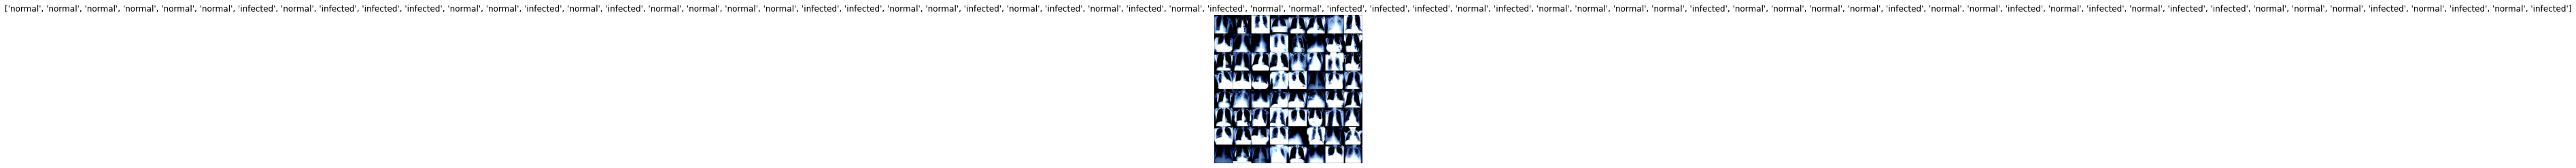

In [0]:
dataiter = iter(testloader)
images, labels = dataiter.next()
show_databatch(images, labels)

**Predicting For Test data**

In [0]:
images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
resnet18.to(device)
outputs = resnet18(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))
print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]]
                              for j in range(len(images))))

Predicted:  normal normal normal infected infected normal normal normal normal normal normal normal normal normal normal normal normal infected normal infected infected infected normal normal infected normal normal infected
Ground Truth:  normal normal normal infected normal normal normal normal normal normal normal normal normal normal normal normal normal infected normal infected infected infected normal normal infected normal normal infected


**Results For ResNet18 Model**

In [0]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnet18(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 93 %


In [0]:
confusion_matrix(resnet18,trainloader)

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f59272fac50>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 961, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 941, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f59272fac50>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 961, in __del__
    self._shutdown_workers()
  File "/usr/local/l

tensor([[4220.,  699.],
        [ 737., 5115.]])


In [0]:
confusion_matrix(resnet18,testloader)

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f59272fac50>>
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f59272fac50>>
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f59272fac50>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 961, in __del__
Traceback (most recent call last):
Traceback (most recent call last):
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 941, in _shutdown_workers
    w.join()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 961, in __del__
  File "/usr/local/lib/python3.6/dist-package

tensor([[566.,  49.],
        [ 56., 829.]])


In [0]:
confusion_matrix(resnet18,validloader)

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f59272fac50>>
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f59272fac50>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 961, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 961, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 941, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
    self._shutdown_workers()
  File "/usr/local/l

tensor([[548.,  67.],
        [135., 750.]])


In [0]:
def plot_curves(title,x_title,train_arr,val_arr):
  plt.figure(figsize=(10,5))
  plt.xlabel(x_title)
  plt.ylabel("error")
  plt.title(title)
  plt.legend()
  plt.plot(np.arange(Epochs),train_arr,color='teal',label="train_data")
  plt.plot(np.arange(Epochs),val_arr,color='orange',label="validation_data")
  plt.legend()
  plt.show()

# plot_curves("Loss Curve","error",train_error,val_error)
# plot_curves("Accuracy Curve","accuracy",train_acc,val_acc)

**Getting Predictions**

In [0]:
@torch.no_grad()
def get_all_preds(model, loader):
    print("here")
    all_preds = torch.tensor([])
    for batch in loader:
        images, labels = batch

        preds = model(images)
        print("here")
        all_preds = torch.cat(
            (all_preds, preds)
            ,dim=0
        )
        print("here3")
    return all_preds

In [0]:
len(train_data.targets)

10273

In [0]:
TOdevice = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
def confusion_matrix(model,loader):
  nb_classes = 2
  model.to(device)
  confusion_matrix = torch.zeros(nb_classes, nb_classes)
  with torch.no_grad():
      for i, (inputs, labels) in enumerate(loader):
          inputs = inputs.to(device)
          labels = labels.to(device)
          outputs = model(inputs)
          # print(outputs)
          _, preds = torch.max(outputs, 1)
          # pred_diff=[]
          # print(torch.unique(preds))
          for t, p in zip(labels.view(-1), preds.view(-1)):
                  # pred_diff.append(abs(t-p))
                  confusion_matrix[t.long(), p.long()] += 1

  print(confusion_matrix)

# val = max(pred_diff)
# idx = np.argmax(pred_diff)

# print("worst1: \n","idx: ",idx,"\tval:",val)
# del pred_diff[idx]
# val = max(pred_diff)
# idx = np.argmax(pred_diff)
# print("worst2: \n","idx: ",idx,"\tval:",val)

# val = min(pred_diff)
# idx = np.argmin(pred_diff)
# print("best1: \n","idx: ",idx,"\tval:",val)
# del pred_diff[idx]

# val = min(pred_diff)
# idx = np.argmin(pred_diff)
# print("best2: \n","idx: ",idx,"\tval:",val)


In [0]:
# with torch.no_grad():
#     train_preds = get_all_preds(resnet18, trainloader)

# preds_correct = get_num_correct(train_preds, train_data.targets)
# print('total correct:', preds_correct)
# print('accuracy:', preds_correct / len(train_set))

### VGG16 Model

**Loading pre-trained VGG-16**

In [0]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)
print(vgg16)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

**Updating VGG16 Architecture by replacing FC layers in classifier part**

In [0]:
features = list()
features.extend([nn.Linear(25088,7100)])
features.extend([nn.ReLU(inplace=True)])
features.extend([nn.Linear(7100,2)])

In [0]:
vgg16.classifier = nn.Sequential(*features)

In [0]:
print(vgg16.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=7100, bias=True)
  (1): ReLU(inplace=True)
  (2): Linear(in_features=7100, out_features=2, bias=True)
)


**Freezing All the Layers**

In [0]:
for param in vgg16.parameters():
  param.requires_grad=False

**Unfreezing FC layers**

In [0]:
for param in vgg16.classifier.parameters():
  param.requires_grad=True

In [0]:
# for param in vgg16.parameters():
#   print(param.requires_grad)

**Final VGG16 Architecture**

In [0]:
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

**Loss Function**

In [0]:
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)

**Training VGG16**

In [0]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

vgg16.train()
vgg16_train_error=[]
vgg16_val_error=[]
vgg16_train_acc=[]
vgg16_val_acc=[]

for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    running_corrects = 0.0
    num_images = 0

    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        num_images = num_images+inputs.size(0)

        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = vgg16(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update
        print("loss type",loss.data)

        _, preds = torch.max(outputs, 1)
        # print statistics
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels).item()

        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data))
        # train_error.append(loss.data)

    #train loss and accuracy
    epoch_loss = running_loss /num_images
    vgg16_train_error.append(epoch_loss)
    epoch_acc = running_corrects / num_images
    vgg16_train_acc.append(epoch_acc)

    #Validation loss and accuracy
    epoch_loss,epoch_acc = evaluate('v')
    vgg16_val_error.append(epoch_loss)
    vgg16_val_acc.append(epoch_acc)

    print(' train loss: {}\n train acc: {}\n valid loss: {}\n valid acc:{}'.format(
        vgg16_train_error[epoch],vgg16_train_acc[epoch],vgg16_val_error[epoch],vgg16_val_acc[epoch]))

    torch.save(vgg16.state_dict(), data_dir+'vgg16_FC_Only.pth')

print('Finished Training')


0it [00:00, ?it/s]

loss type 


Train Epoch: 0 [0/10771 (0%)]	Loss: 0.177687: : 0it [00:05, ?it/s]
Train Epoch: 0 [0/10771 (0%)]	Loss: 0.177687: : 1it [00:05,  5.99s/it]

tensor(0.1777, device='cuda:0')
loss type 


Train Epoch: 0 [64/10771 (1%)]	Loss: 0.229538: : 1it [00:06,  5.99s/it]
Train Epoch: 0 [64/10771 (1%)]	Loss: 0.229538: : 2it [00:06,  4.34s/it]

tensor(0.2295, device='cuda:0')
loss type 


Train Epoch: 0 [128/10771 (1%)]	Loss: 0.284517: : 2it [00:07,  4.34s/it]
Train Epoch: 0 [128/10771 (1%)]	Loss: 0.284517: : 3it [00:07,  3.20s/it]

tensor(0.2845, device='cuda:0')
loss type 


Train Epoch: 0 [192/10771 (2%)]	Loss: 0.322998: : 3it [00:07,  3.20s/it]
Train Epoch: 0 [192/10771 (2%)]	Loss: 0.322998: : 4it [00:07,  2.39s/it]

tensor(0.3230, device='cuda:0')
loss type 


Train Epoch: 0 [256/10771 (2%)]	Loss: 0.338748: : 4it [00:08,  2.39s/it]
Train Epoch: 0 [256/10771 (2%)]	Loss: 0.338748: : 5it [00:08,  1.83s/it]

tensor(0.3387, device='cuda:0')
loss type 


Train Epoch: 0 [320/10771 (3%)]	Loss: 0.309190: : 5it [00:12,  1.83s/it]
Train Epoch: 0 [320/10771 (3%)]	Loss: 0.309190: : 6it [00:12,  2.50s/it]

tensor(0.3092, device='cuda:0')
loss type 


Train Epoch: 0 [384/10771 (4%)]	Loss: 0.304044: : 6it [00:12,  2.50s/it]
Train Epoch: 0 [384/10771 (4%)]	Loss: 0.304044: : 7it [00:12,  1.92s/it]

tensor(0.3040, device='cuda:0')
loss type 


Train Epoch: 0 [448/10771 (4%)]	Loss: 0.351187: : 7it [00:13,  1.92s/it]
Train Epoch: 0 [448/10771 (4%)]	Loss: 0.351187: : 8it [00:13,  1.49s/it]

tensor(0.3512, device='cuda:0')
loss type 


Train Epoch: 0 [512/10771 (5%)]	Loss: 0.238866: : 8it [00:13,  1.49s/it]
Train Epoch: 0 [512/10771 (5%)]	Loss: 0.238866: : 9it [00:13,  1.20s/it]

tensor(0.2389, device='cuda:0')
loss type 


Train Epoch: 0 [576/10771 (5%)]	Loss: 0.263840: : 9it [00:14,  1.20s/it]
Train Epoch: 0 [576/10771 (5%)]	Loss: 0.263840: : 10it [00:14,  1.01it/s]

tensor(0.2638, device='cuda:0')
loss type 


Train Epoch: 0 [640/10771 (6%)]	Loss: 0.271577: : 10it [00:18,  1.01it/s]
Train Epoch: 0 [640/10771 (6%)]	Loss: 0.271577: : 11it [00:18,  1.84s/it]

tensor(0.2716, device='cuda:0')
loss type 


Train Epoch: 0 [704/10771 (7%)]	Loss: 0.415116: : 11it [00:18,  1.84s/it]
Train Epoch: 0 [704/10771 (7%)]	Loss: 0.415116: : 12it [00:18,  1.44s/it]

tensor(0.4151, device='cuda:0')
loss type 


Train Epoch: 0 [768/10771 (7%)]	Loss: 0.428695: : 12it [00:19,  1.44s/it]
Train Epoch: 0 [768/10771 (7%)]	Loss: 0.428695: : 13it [00:19,  1.20s/it]

tensor(0.4287, device='cuda:0')
loss type 


Train Epoch: 0 [832/10771 (8%)]	Loss: 0.356079: : 13it [00:19,  1.20s/it]
Train Epoch: 0 [832/10771 (8%)]	Loss: 0.356079: : 14it [00:19,  1.01it/s]

tensor(0.3561, device='cuda:0')
loss type 


Train Epoch: 0 [896/10771 (8%)]	Loss: 0.359041: : 14it [00:20,  1.01it/s]
Train Epoch: 0 [896/10771 (8%)]	Loss: 0.359041: : 15it [00:20,  1.17it/s]

tensor(0.3590, device='cuda:0')
loss type 


Train Epoch: 0 [960/10771 (9%)]	Loss: 0.259397: : 15it [00:24,  1.17it/s]
Train Epoch: 0 [960/10771 (9%)]	Loss: 0.259397: : 16it [00:24,  1.80s/it]

tensor(0.2594, device='cuda:0')
loss type 


Train Epoch: 0 [1024/10771 (9%)]	Loss: 0.228599: : 16it [00:24,  1.80s/it]
Train Epoch: 0 [1024/10771 (9%)]	Loss: 0.228599: : 17it [00:24,  1.43s/it]

tensor(0.2286, device='cuda:0')
loss type 


Train Epoch: 0 [1088/10771 (10%)]	Loss: 0.356475: : 17it [00:25,  1.43s/it]
Train Epoch: 0 [1088/10771 (10%)]	Loss: 0.356475: : 18it [00:25,  1.19s/it]

tensor(0.3565, device='cuda:0')
loss type 


Train Epoch: 0 [1152/10771 (11%)]	Loss: 0.313796: : 18it [00:25,  1.19s/it]
Train Epoch: 0 [1152/10771 (11%)]	Loss: 0.313796: : 19it [00:25,  1.01it/s]

tensor(0.3138, device='cuda:0')
loss type 


Train Epoch: 0 [1216/10771 (11%)]	Loss: 0.284998: : 19it [00:26,  1.01it/s]
Train Epoch: 0 [1216/10771 (11%)]	Loss: 0.284998: : 20it [00:26,  1.20it/s]

tensor(0.2850, device='cuda:0')
loss type 


Train Epoch: 0 [1280/10771 (12%)]	Loss: 0.249825: : 20it [00:30,  1.20it/s]
Train Epoch: 0 [1280/10771 (12%)]	Loss: 0.249825: : 21it [00:30,  1.73s/it]

tensor(0.2498, device='cuda:0')
loss type 


Train Epoch: 0 [1344/10771 (12%)]	Loss: 0.312674: : 21it [00:30,  1.73s/it]
Train Epoch: 0 [1344/10771 (12%)]	Loss: 0.312674: : 22it [00:30,  1.36s/it]

tensor(0.3127, device='cuda:0')
loss type 


Train Epoch: 0 [1408/10771 (13%)]	Loss: 0.249941: : 22it [00:31,  1.36s/it]
Train Epoch: 0 [1408/10771 (13%)]	Loss: 0.249941: : 23it [00:31,  1.15s/it]

tensor(0.2499, device='cuda:0')
loss type 


Train Epoch: 0 [1472/10771 (14%)]	Loss: 0.295142: : 23it [00:31,  1.15s/it]
Train Epoch: 0 [1472/10771 (14%)]	Loss: 0.295142: : 24it [00:31,  1.05it/s]

tensor(0.2951, device='cuda:0')
loss type 


Train Epoch: 0 [1536/10771 (14%)]	Loss: 0.261224: : 24it [00:32,  1.05it/s]
Train Epoch: 0 [1536/10771 (14%)]	Loss: 0.261224: : 25it [00:32,  1.22it/s]

tensor(0.2612, device='cuda:0')
loss type 


Train Epoch: 0 [1600/10771 (15%)]	Loss: 0.307129: : 25it [00:36,  1.22it/s]
Train Epoch: 0 [1600/10771 (15%)]	Loss: 0.307129: : 26it [00:36,  1.74s/it]

tensor(0.3071, device='cuda:0')
loss type 


Train Epoch: 0 [1664/10771 (15%)]	Loss: 0.319643: : 26it [00:36,  1.74s/it]
Train Epoch: 0 [1664/10771 (15%)]	Loss: 0.319643: : 27it [00:36,  1.37s/it]

tensor(0.3196, device='cuda:0')
loss type 


Train Epoch: 0 [1728/10771 (16%)]	Loss: 0.350405: : 27it [00:37,  1.37s/it]
Train Epoch: 0 [1728/10771 (16%)]	Loss: 0.350405: : 28it [00:37,  1.20s/it]

tensor(0.3504, device='cuda:0')
loss type 


Train Epoch: 0 [1792/10771 (17%)]	Loss: 0.213770: : 28it [00:38,  1.20s/it]
Train Epoch: 0 [1792/10771 (17%)]	Loss: 0.213770: : 29it [00:38,  1.00s/it]

tensor(0.2138, device='cuda:0')
loss type 


Train Epoch: 0 [1856/10771 (17%)]	Loss: 0.321385: : 29it [00:38,  1.00s/it]
Train Epoch: 0 [1856/10771 (17%)]	Loss: 0.321385: : 30it [00:38,  1.18it/s]

tensor(0.3214, device='cuda:0')
loss type 


Train Epoch: 0 [1920/10771 (18%)]	Loss: 0.324920: : 30it [00:42,  1.18it/s]
Train Epoch: 0 [1920/10771 (18%)]	Loss: 0.324920: : 31it [00:42,  1.91s/it]

tensor(0.3249, device='cuda:0')
loss type 


Train Epoch: 0 [1984/10771 (18%)]	Loss: 0.540520: : 31it [00:43,  1.91s/it]
Train Epoch: 0 [1984/10771 (18%)]	Loss: 0.540520: : 32it [00:43,  1.49s/it]

tensor(0.5405, device='cuda:0')
loss type 


Train Epoch: 0 [2048/10771 (19%)]	Loss: 0.299146: : 32it [00:43,  1.49s/it]
Train Epoch: 0 [2048/10771 (19%)]	Loss: 0.299146: : 33it [00:44,  1.20s/it]

tensor(0.2991, device='cuda:0')
loss type 


Train Epoch: 0 [2112/10771 (20%)]	Loss: 0.290590: : 33it [00:44,  1.20s/it]
Train Epoch: 0 [2112/10771 (20%)]	Loss: 0.290590: : 34it [00:44,  1.02it/s]

tensor(0.2906, device='cuda:0')
loss type 


Train Epoch: 0 [2176/10771 (20%)]	Loss: 0.271641: : 34it [00:44,  1.02it/s]
Train Epoch: 0 [2176/10771 (20%)]	Loss: 0.271641: : 35it [00:45,  1.18it/s]

tensor(0.2716, device='cuda:0')
loss type 


Train Epoch: 0 [2240/10771 (21%)]	Loss: 0.343989: : 35it [00:48,  1.18it/s]
Train Epoch: 0 [2240/10771 (21%)]	Loss: 0.343989: : 36it [00:48,  1.77s/it]

tensor(0.3440, device='cuda:0')
loss type 


Train Epoch: 0 [2304/10771 (21%)]	Loss: 0.330147: : 36it [00:49,  1.77s/it]
Train Epoch: 0 [2304/10771 (21%)]	Loss: 0.330147: : 37it [00:49,  1.38s/it]

tensor(0.3301, device='cuda:0')
loss type 


Train Epoch: 0 [2368/10771 (22%)]	Loss: 0.443343: : 37it [00:49,  1.38s/it]
Train Epoch: 0 [2368/10771 (22%)]	Loss: 0.443343: : 38it [00:49,  1.12s/it]

tensor(0.4433, device='cuda:0')
loss type 


Train Epoch: 0 [2432/10771 (22%)]	Loss: 0.349671: : 38it [00:50,  1.12s/it]
Train Epoch: 0 [2432/10771 (22%)]	Loss: 0.349671: : 39it [00:50,  1.06it/s]

tensor(0.3497, device='cuda:0')
loss type 


Train Epoch: 0 [2496/10771 (23%)]	Loss: 0.323116: : 39it [00:50,  1.06it/s]
Train Epoch: 0 [2496/10771 (23%)]	Loss: 0.323116: : 40it [00:50,  1.24it/s]

tensor(0.3231, device='cuda:0')
loss type 


Train Epoch: 0 [2560/10771 (24%)]	Loss: 0.282554: : 40it [00:55,  1.24it/s]
Train Epoch: 0 [2560/10771 (24%)]	Loss: 0.282554: : 41it [00:55,  2.01s/it]

tensor(0.2826, device='cuda:0')
loss type 


Train Epoch: 0 [2624/10771 (24%)]	Loss: 0.330957: : 41it [00:56,  2.01s/it]
Train Epoch: 0 [2624/10771 (24%)]	Loss: 0.330957: : 42it [00:56,  1.56s/it]

tensor(0.3310, device='cuda:0')
loss type 


Train Epoch: 0 [2688/10771 (25%)]	Loss: 0.184562: : 42it [00:56,  1.56s/it]
Train Epoch: 0 [2688/10771 (25%)]	Loss: 0.184562: : 43it [00:56,  1.26s/it]

tensor(0.1846, device='cuda:0')
loss type 


Train Epoch: 0 [2752/10771 (25%)]	Loss: 0.198480: : 43it [00:57,  1.26s/it]
Train Epoch: 0 [2752/10771 (25%)]	Loss: 0.198480: : 44it [00:57,  1.03s/it]

tensor(0.1985, device='cuda:0')
loss type 


Train Epoch: 0 [2816/10771 (26%)]	Loss: 0.250874: : 44it [00:57,  1.03s/it]
Train Epoch: 0 [2816/10771 (26%)]	Loss: 0.250874: : 45it [00:57,  1.14it/s]

tensor(0.2509, device='cuda:0')
loss type 


Train Epoch: 0 [2880/10771 (27%)]	Loss: 0.309868: : 45it [01:01,  1.14it/s]
Train Epoch: 0 [2880/10771 (27%)]	Loss: 0.309868: : 46it [01:01,  1.77s/it]

tensor(0.3099, device='cuda:0')
loss type 


Train Epoch: 0 [2944/10771 (27%)]	Loss: 0.431712: : 46it [01:02,  1.77s/it]
Train Epoch: 0 [2944/10771 (27%)]	Loss: 0.431712: : 47it [01:02,  1.40s/it]

tensor(0.4317, device='cuda:0')
loss type 


Train Epoch: 0 [3008/10771 (28%)]	Loss: 0.193954: : 47it [01:02,  1.40s/it]
Train Epoch: 0 [3008/10771 (28%)]	Loss: 0.193954: : 48it [01:02,  1.13s/it]

tensor(0.1940, device='cuda:0')
loss type 


Train Epoch: 0 [3072/10771 (28%)]	Loss: 0.490021: : 48it [01:03,  1.13s/it]
Train Epoch: 0 [3072/10771 (28%)]	Loss: 0.490021: : 49it [01:03,  1.05it/s]

tensor(0.4900, device='cuda:0')
loss type 


Train Epoch: 0 [3136/10771 (29%)]	Loss: 0.411237: : 49it [01:03,  1.05it/s]
Train Epoch: 0 [3136/10771 (29%)]	Loss: 0.411237: : 50it [01:03,  1.23it/s]

tensor(0.4112, device='cuda:0')
loss type 


Train Epoch: 0 [3200/10771 (30%)]	Loss: 0.245405: : 50it [01:07,  1.23it/s]
Train Epoch: 0 [3200/10771 (30%)]	Loss: 0.245405: : 51it [01:07,  1.78s/it]

tensor(0.2454, device='cuda:0')
loss type 


Train Epoch: 0 [3264/10771 (30%)]	Loss: 0.442275: : 51it [01:08,  1.78s/it]
Train Epoch: 0 [3264/10771 (30%)]	Loss: 0.442275: : 52it [01:08,  1.39s/it]

tensor(0.4423, device='cuda:0')
loss type 


Train Epoch: 0 [3328/10771 (31%)]	Loss: 0.496914: : 52it [01:08,  1.39s/it]
Train Epoch: 0 [3328/10771 (31%)]	Loss: 0.496914: : 53it [01:08,  1.14s/it]

tensor(0.4969, device='cuda:0')
loss type 


Train Epoch: 0 [3392/10771 (31%)]	Loss: 0.288735: : 53it [01:09,  1.14s/it]
Train Epoch: 0 [3392/10771 (31%)]	Loss: 0.288735: : 54it [01:09,  1.06it/s]

tensor(0.2887, device='cuda:0')
loss type 


Train Epoch: 0 [3456/10771 (32%)]	Loss: 0.376921: : 54it [01:09,  1.06it/s]
Train Epoch: 0 [3456/10771 (32%)]	Loss: 0.376921: : 55it [01:09,  1.22it/s]

tensor(0.3769, device='cuda:0')
loss type 


Train Epoch: 0 [3520/10771 (33%)]	Loss: 0.312972: : 55it [01:13,  1.22it/s]
Train Epoch: 0 [3520/10771 (33%)]	Loss: 0.312972: : 56it [01:13,  1.72s/it]

tensor(0.3130, device='cuda:0')
loss type 


Train Epoch: 0 [3584/10771 (33%)]	Loss: 0.352487: : 56it [01:14,  1.72s/it]
Train Epoch: 0 [3584/10771 (33%)]	Loss: 0.352487: : 57it [01:14,  1.35s/it]

tensor(0.3525, device='cuda:0')
loss type 


Train Epoch: 0 [3648/10771 (34%)]	Loss: 0.254112: : 57it [01:14,  1.35s/it]
Train Epoch: 0 [3648/10771 (34%)]	Loss: 0.254112: : 58it [01:14,  1.13s/it]

tensor(0.2541, device='cuda:0')
loss type 


Train Epoch: 0 [3712/10771 (34%)]	Loss: 0.408992: : 58it [01:15,  1.13s/it]
Train Epoch: 0 [3712/10771 (34%)]	Loss: 0.408992: : 59it [01:15,  1.05it/s]

tensor(0.4090, device='cuda:0')
loss type 


Train Epoch: 0 [3776/10771 (35%)]	Loss: 0.246551: : 59it [01:15,  1.05it/s]
Train Epoch: 0 [3776/10771 (35%)]	Loss: 0.246551: : 60it [01:15,  1.22it/s]

tensor(0.2466, device='cuda:0')
loss type 


Train Epoch: 0 [3840/10771 (36%)]	Loss: 0.231457: : 60it [01:19,  1.22it/s]
Train Epoch: 0 [3840/10771 (36%)]	Loss: 0.231457: : 61it [01:19,  1.73s/it]

tensor(0.2315, device='cuda:0')
loss type 


Train Epoch: 0 [3904/10771 (36%)]	Loss: 0.333765: : 61it [01:20,  1.73s/it]
Train Epoch: 0 [3904/10771 (36%)]	Loss: 0.333765: : 62it [01:20,  1.36s/it]

tensor(0.3338, device='cuda:0')
loss type 


Train Epoch: 0 [3968/10771 (37%)]	Loss: 0.352658: : 62it [01:21,  1.36s/it]
Train Epoch: 0 [3968/10771 (37%)]	Loss: 0.352658: : 63it [01:21,  1.32s/it]

tensor(0.3527, device='cuda:0')
loss type 


Train Epoch: 0 [4032/10771 (37%)]	Loss: 0.276067: : 63it [01:21,  1.32s/it]
Train Epoch: 0 [4032/10771 (37%)]	Loss: 0.276067: : 64it [01:21,  1.07s/it]

tensor(0.2761, device='cuda:0')
loss type 


Train Epoch: 0 [4096/10771 (38%)]	Loss: 0.397468: : 64it [01:22,  1.07s/it]
Train Epoch: 0 [4096/10771 (38%)]	Loss: 0.397468: : 65it [01:22,  1.12it/s]

tensor(0.3975, device='cuda:0')
loss type 


Train Epoch: 0 [4160/10771 (38%)]	Loss: 0.328594: : 65it [01:25,  1.12it/s]
Train Epoch: 0 [4160/10771 (38%)]	Loss: 0.328594: : 66it [01:25,  1.56s/it]

tensor(0.3286, device='cuda:0')
loss type 


Train Epoch: 0 [4224/10771 (39%)]	Loss: 0.366559: : 66it [01:25,  1.56s/it]
Train Epoch: 0 [4224/10771 (39%)]	Loss: 0.366559: : 67it [01:25,  1.25s/it]

tensor(0.3666, device='cuda:0')
loss type 


Train Epoch: 0 [4288/10771 (40%)]	Loss: 0.325937: : 67it [01:27,  1.25s/it]
Train Epoch: 0 [4288/10771 (40%)]	Loss: 0.325937: : 68it [01:27,  1.29s/it]

tensor(0.3259, device='cuda:0')
loss type 


Train Epoch: 0 [4352/10771 (40%)]	Loss: 0.286194: : 68it [01:27,  1.29s/it]
Train Epoch: 0 [4352/10771 (40%)]	Loss: 0.286194: : 69it [01:27,  1.06s/it]

tensor(0.2862, device='cuda:0')
loss type 


Train Epoch: 0 [4416/10771 (41%)]	Loss: 0.259277: : 69it [01:28,  1.06s/it]
Train Epoch: 0 [4416/10771 (41%)]	Loss: 0.259277: : 70it [01:28,  1.12it/s]

tensor(0.2593, device='cuda:0')
loss type 


Train Epoch: 0 [4480/10771 (41%)]	Loss: 0.196316: : 70it [01:31,  1.12it/s]
Train Epoch: 0 [4480/10771 (41%)]	Loss: 0.196316: : 71it [01:31,  1.50s/it]

tensor(0.1963, device='cuda:0')
loss type 


Train Epoch: 0 [4544/10771 (42%)]	Loss: 0.382946: : 71it [01:31,  1.50s/it]
Train Epoch: 0 [4544/10771 (42%)]	Loss: 0.382946: : 72it [01:31,  1.20s/it]

tensor(0.3829, device='cuda:0')
loss type 


Train Epoch: 0 [4608/10771 (43%)]	Loss: 0.283680: : 72it [01:33,  1.20s/it]
Train Epoch: 0 [4608/10771 (43%)]	Loss: 0.283680: : 73it [01:33,  1.24s/it]

tensor(0.2837, device='cuda:0')
loss type 


Train Epoch: 0 [4672/10771 (43%)]	Loss: 0.308725: : 73it [01:33,  1.24s/it]
Train Epoch: 0 [4672/10771 (43%)]	Loss: 0.308725: : 74it [01:33,  1.02s/it]

tensor(0.3087, device='cuda:0')
loss type 


Train Epoch: 0 [4736/10771 (44%)]	Loss: 0.278858: : 74it [01:34,  1.02s/it]
Train Epoch: 0 [4736/10771 (44%)]	Loss: 0.278858: : 75it [01:34,  1.16it/s]

tensor(0.2789, device='cuda:0')
loss type 


Train Epoch: 0 [4800/10771 (44%)]	Loss: 0.362465: : 75it [01:37,  1.16it/s]
Train Epoch: 0 [4800/10771 (44%)]	Loss: 0.362465: : 76it [01:37,  1.61s/it]

tensor(0.3625, device='cuda:0')
loss type 


Train Epoch: 0 [4864/10771 (45%)]	Loss: 0.230881: : 76it [01:38,  1.61s/it]
Train Epoch: 0 [4864/10771 (45%)]	Loss: 0.230881: : 77it [01:38,  1.29s/it]

tensor(0.2309, device='cuda:0')
loss type 


Train Epoch: 0 [4928/10771 (46%)]	Loss: 0.418634: : 77it [01:38,  1.29s/it]
Train Epoch: 0 [4928/10771 (46%)]	Loss: 0.418634: : 78it [01:38,  1.17s/it]

tensor(0.4186, device='cuda:0')
loss type 


Train Epoch: 0 [4992/10771 (46%)]	Loss: 0.226243: : 78it [01:39,  1.17s/it]
Train Epoch: 0 [4992/10771 (46%)]	Loss: 0.226243: : 79it [01:39,  1.02it/s]

tensor(0.2262, device='cuda:0')
loss type 


Train Epoch: 0 [5056/10771 (47%)]	Loss: 0.198184: : 79it [01:39,  1.02it/s]
Train Epoch: 0 [5056/10771 (47%)]	Loss: 0.198184: : 80it [01:39,  1.20it/s]

tensor(0.1982, device='cuda:0')
loss type 


Train Epoch: 0 [5120/10771 (47%)]	Loss: 0.518345: : 80it [01:43,  1.20it/s]
Train Epoch: 0 [5120/10771 (47%)]	Loss: 0.518345: : 81it [01:43,  1.67s/it]

tensor(0.5183, device='cuda:0')
loss type 


Train Epoch: 0 [5184/10771 (48%)]	Loss: 0.316659: : 81it [01:44,  1.67s/it]
Train Epoch: 0 [5184/10771 (48%)]	Loss: 0.316659: : 82it [01:44,  1.31s/it]

tensor(0.3167, device='cuda:0')
loss type 


Train Epoch: 0 [5248/10771 (49%)]	Loss: 0.220442: : 82it [01:44,  1.31s/it]
Train Epoch: 0 [5248/10771 (49%)]	Loss: 0.220442: : 83it [01:44,  1.18s/it]

tensor(0.2204, device='cuda:0')
loss type 


Train Epoch: 0 [5312/10771 (49%)]	Loss: 0.341584: : 83it [01:45,  1.18s/it]
Train Epoch: 0 [5312/10771 (49%)]	Loss: 0.341584: : 84it [01:45,  1.03it/s]

tensor(0.3416, device='cuda:0')
loss type 


Train Epoch: 0 [5376/10771 (50%)]	Loss: 0.352324: : 84it [01:45,  1.03it/s]
Train Epoch: 0 [5376/10771 (50%)]	Loss: 0.352324: : 85it [01:45,  1.20it/s]

tensor(0.3523, device='cuda:0')
loss type 


Train Epoch: 0 [5440/10771 (50%)]	Loss: 0.316188: : 85it [01:49,  1.20it/s]
Train Epoch: 0 [5440/10771 (50%)]	Loss: 0.316188: : 86it [01:49,  1.65s/it]

tensor(0.3162, device='cuda:0')
loss type 


Train Epoch: 0 [5504/10771 (51%)]	Loss: 0.336413: : 86it [01:50,  1.65s/it]
Train Epoch: 0 [5504/10771 (51%)]	Loss: 0.336413: : 87it [01:50,  1.32s/it]

tensor(0.3364, device='cuda:0')
loss type 


Train Epoch: 0 [5568/10771 (51%)]	Loss: 0.277511: : 87it [01:51,  1.32s/it]
Train Epoch: 0 [5568/10771 (51%)]	Loss: 0.277511: : 88it [01:51,  1.35s/it]

tensor(0.2775, device='cuda:0')
loss type 


Train Epoch: 0 [5632/10771 (52%)]	Loss: 0.145968: : 88it [01:52,  1.35s/it]
Train Epoch: 0 [5632/10771 (52%)]	Loss: 0.145968: : 89it [01:52,  1.11s/it]

tensor(0.1460, device='cuda:0')
loss type 


Train Epoch: 0 [5696/10771 (53%)]	Loss: 0.273917: : 89it [01:52,  1.11s/it]
Train Epoch: 0 [5696/10771 (53%)]	Loss: 0.273917: : 90it [01:52,  1.08it/s]

tensor(0.2739, device='cuda:0')
loss type 


Train Epoch: 0 [5760/10771 (53%)]	Loss: 0.245403: : 90it [01:55,  1.08it/s]
Train Epoch: 0 [5760/10771 (53%)]	Loss: 0.245403: : 91it [01:55,  1.53s/it]

tensor(0.2454, device='cuda:0')
loss type 


Train Epoch: 0 [5824/10771 (54%)]	Loss: 0.268026: : 91it [01:55,  1.53s/it]
Train Epoch: 0 [5824/10771 (54%)]	Loss: 0.268026: : 92it [01:55,  1.22s/it]

tensor(0.2680, device='cuda:0')
loss type 


Train Epoch: 0 [5888/10771 (54%)]	Loss: 0.314461: : 92it [01:57,  1.22s/it]
Train Epoch: 0 [5888/10771 (54%)]	Loss: 0.314461: : 93it [01:57,  1.39s/it]

tensor(0.3145, device='cuda:0')
loss type 


Train Epoch: 0 [5952/10771 (55%)]	Loss: 0.333898: : 93it [01:58,  1.39s/it]
Train Epoch: 0 [5952/10771 (55%)]	Loss: 0.333898: : 94it [01:58,  1.12s/it]

tensor(0.3339, device='cuda:0')
loss type 


Train Epoch: 0 [6016/10771 (56%)]	Loss: 0.349100: : 94it [01:58,  1.12s/it]
Train Epoch: 0 [6016/10771 (56%)]	Loss: 0.349100: : 95it [01:58,  1.06it/s]

tensor(0.3491, device='cuda:0')
loss type 


Train Epoch: 0 [6080/10771 (56%)]	Loss: 0.239153: : 95it [02:01,  1.06it/s]
Train Epoch: 0 [6080/10771 (56%)]	Loss: 0.239153: : 96it [02:01,  1.45s/it]

tensor(0.2392, device='cuda:0')
loss type 


Train Epoch: 0 [6144/10771 (57%)]	Loss: 0.342241: : 96it [02:01,  1.45s/it]
Train Epoch: 0 [6144/10771 (57%)]	Loss: 0.342241: : 97it [02:01,  1.17s/it]

tensor(0.3422, device='cuda:0')
loss type 


Train Epoch: 0 [6208/10771 (57%)]	Loss: 0.467381: : 97it [02:03,  1.17s/it]
Train Epoch: 0 [6208/10771 (57%)]	Loss: 0.467381: : 98it [02:03,  1.32s/it]

tensor(0.4674, device='cuda:0')
loss type 


Train Epoch: 0 [6272/10771 (58%)]	Loss: 0.322810: : 98it [02:04,  1.32s/it]
Train Epoch: 0 [6272/10771 (58%)]	Loss: 0.322810: : 99it [02:04,  1.09s/it]

tensor(0.3228, device='cuda:0')
loss type 


Train Epoch: 0 [6336/10771 (59%)]	Loss: 0.295095: : 99it [02:04,  1.09s/it]
Train Epoch: 0 [6336/10771 (59%)]	Loss: 0.295095: : 100it [02:04,  1.09it/s]

tensor(0.2951, device='cuda:0')
loss type 


Train Epoch: 0 [6400/10771 (59%)]	Loss: 0.399096: : 100it [02:07,  1.09it/s]
Train Epoch: 0 [6400/10771 (59%)]	Loss: 0.399096: : 101it [02:07,  1.48s/it]

tensor(0.3991, device='cuda:0')
loss type 


Train Epoch: 0 [6464/10771 (60%)]	Loss: 0.325714: : 101it [02:07,  1.48s/it]
Train Epoch: 0 [6464/10771 (60%)]	Loss: 0.325714: : 102it [02:07,  1.18s/it]

tensor(0.3257, device='cuda:0')
loss type 


Train Epoch: 0 [6528/10771 (60%)]	Loss: 0.198755: : 102it [02:09,  1.18s/it]
Train Epoch: 0 [6528/10771 (60%)]	Loss: 0.198755: : 103it [02:09,  1.30s/it]

tensor(0.1988, device='cuda:0')
loss type 


Train Epoch: 0 [6592/10771 (61%)]	Loss: 0.240938: : 103it [02:09,  1.30s/it]
Train Epoch: 0 [6592/10771 (61%)]	Loss: 0.240938: : 104it [02:09,  1.06s/it]

tensor(0.2409, device='cuda:0')
loss type 


Train Epoch: 0 [6656/10771 (62%)]	Loss: 0.271492: : 104it [02:10,  1.06s/it]
Train Epoch: 0 [6656/10771 (62%)]	Loss: 0.271492: : 105it [02:10,  1.11it/s]

tensor(0.2715, device='cuda:0')
loss type 


Train Epoch: 0 [6720/10771 (62%)]	Loss: 0.261257: : 105it [02:13,  1.11it/s]
Train Epoch: 0 [6720/10771 (62%)]	Loss: 0.261257: : 106it [02:13,  1.43s/it]

tensor(0.2613, device='cuda:0')
loss type 


Train Epoch: 0 [6784/10771 (63%)]	Loss: 0.226656: : 106it [02:13,  1.43s/it]
Train Epoch: 0 [6784/10771 (63%)]	Loss: 0.226656: : 107it [02:13,  1.16s/it]

tensor(0.2267, device='cuda:0')
loss type 


Train Epoch: 0 [6848/10771 (63%)]	Loss: 0.238538: : 107it [02:15,  1.16s/it]
Train Epoch: 0 [6848/10771 (63%)]	Loss: 0.238538: : 108it [02:15,  1.35s/it]

tensor(0.2385, device='cuda:0')
loss type 


Train Epoch: 0 [6912/10771 (64%)]	Loss: 0.283645: : 108it [02:16,  1.35s/it]
Train Epoch: 0 [6912/10771 (64%)]	Loss: 0.283645: : 109it [02:16,  1.11s/it]

tensor(0.2836, device='cuda:0')
loss type 


Train Epoch: 0 [6976/10771 (64%)]	Loss: 0.312463: : 109it [02:16,  1.11s/it]
Train Epoch: 0 [6976/10771 (64%)]	Loss: 0.312463: : 110it [02:16,  1.09it/s]

tensor(0.3125, device='cuda:0')
loss type 


Train Epoch: 0 [7040/10771 (65%)]	Loss: 0.436942: : 110it [02:19,  1.09it/s]
Train Epoch: 0 [7040/10771 (65%)]	Loss: 0.436942: : 111it [02:19,  1.54s/it]

tensor(0.4369, device='cuda:0')
loss type 


Train Epoch: 0 [7104/10771 (66%)]	Loss: 0.326276: : 111it [02:19,  1.54s/it]
Train Epoch: 0 [7104/10771 (66%)]	Loss: 0.326276: : 112it [02:19,  1.22s/it]

tensor(0.3263, device='cuda:0')
loss type 


Train Epoch: 0 [7168/10771 (66%)]	Loss: 0.365668: : 112it [02:21,  1.22s/it]
Train Epoch: 0 [7168/10771 (66%)]	Loss: 0.365668: : 113it [02:21,  1.35s/it]

tensor(0.3657, device='cuda:0')
loss type 


Train Epoch: 0 [7232/10771 (67%)]	Loss: 0.388979: : 113it [02:22,  1.35s/it]
Train Epoch: 0 [7232/10771 (67%)]	Loss: 0.388979: : 114it [02:22,  1.09s/it]

tensor(0.3890, device='cuda:0')
loss type 


Train Epoch: 0 [7296/10771 (67%)]	Loss: 0.197383: : 114it [02:22,  1.09s/it]
Train Epoch: 0 [7296/10771 (67%)]	Loss: 0.197383: : 115it [02:22,  1.08it/s]

tensor(0.1974, device='cuda:0')
loss type 


Train Epoch: 0 [7360/10771 (68%)]	Loss: 0.527682: : 115it [02:25,  1.08it/s]
Train Epoch: 0 [7360/10771 (68%)]	Loss: 0.527682: : 116it [02:25,  1.54s/it]

tensor(0.5277, device='cuda:0')
loss type 


Train Epoch: 0 [7424/10771 (69%)]	Loss: 0.378989: : 116it [02:26,  1.54s/it]
Train Epoch: 0 [7424/10771 (69%)]	Loss: 0.378989: : 117it [02:26,  1.24s/it]

tensor(0.3790, device='cuda:0')
loss type 


Train Epoch: 0 [7488/10771 (69%)]	Loss: 0.392409: : 117it [02:27,  1.24s/it]
Train Epoch: 0 [7488/10771 (69%)]	Loss: 0.392409: : 118it [02:27,  1.29s/it]

tensor(0.3924, device='cuda:0')
loss type 


Train Epoch: 0 [7552/10771 (70%)]	Loss: 0.474333: : 118it [02:28,  1.29s/it]
Train Epoch: 0 [7552/10771 (70%)]	Loss: 0.474333: : 119it [02:28,  1.06s/it]

tensor(0.4743, device='cuda:0')
loss type 


Train Epoch: 0 [7616/10771 (70%)]	Loss: 0.329196: : 119it [02:28,  1.06s/it]
Train Epoch: 0 [7616/10771 (70%)]	Loss: 0.329196: : 120it [02:28,  1.11it/s]

tensor(0.3292, device='cuda:0')
loss type 


Train Epoch: 0 [7680/10771 (71%)]	Loss: 0.470992: : 120it [02:31,  1.11it/s]
Train Epoch: 0 [7680/10771 (71%)]	Loss: 0.470992: : 121it [02:31,  1.53s/it]

tensor(0.4710, device='cuda:0')
loss type 


Train Epoch: 0 [7744/10771 (72%)]	Loss: 0.391737: : 121it [02:32,  1.53s/it]
Train Epoch: 0 [7744/10771 (72%)]	Loss: 0.391737: : 122it [02:32,  1.23s/it]

tensor(0.3917, device='cuda:0')
loss type 


Train Epoch: 0 [7808/10771 (72%)]	Loss: 0.262413: : 122it [02:33,  1.23s/it]
Train Epoch: 0 [7808/10771 (72%)]	Loss: 0.262413: : 123it [02:33,  1.30s/it]

tensor(0.2624, device='cuda:0')
loss type 


Train Epoch: 0 [7872/10771 (73%)]	Loss: 0.236013: : 123it [02:34,  1.30s/it]
Train Epoch: 0 [7872/10771 (73%)]	Loss: 0.236013: : 124it [02:34,  1.06s/it]

tensor(0.2360, device='cuda:0')
loss type 


Train Epoch: 0 [7936/10771 (73%)]	Loss: 0.268259: : 124it [02:34,  1.06s/it]
Train Epoch: 0 [7936/10771 (73%)]	Loss: 0.268259: : 125it [02:34,  1.11it/s]

tensor(0.2683, device='cuda:0')
loss type 


Train Epoch: 0 [8000/10771 (74%)]	Loss: 0.219403: : 125it [02:37,  1.11it/s]
Train Epoch: 0 [8000/10771 (74%)]	Loss: 0.219403: : 126it [02:37,  1.50s/it]

tensor(0.2194, device='cuda:0')
loss type 


Train Epoch: 0 [8064/10771 (75%)]	Loss: 0.329526: : 126it [02:38,  1.50s/it]
Train Epoch: 0 [8064/10771 (75%)]	Loss: 0.329526: : 127it [02:38,  1.21s/it]

tensor(0.3295, device='cuda:0')
loss type 


Train Epoch: 0 [8128/10771 (75%)]	Loss: 0.330163: : 127it [02:39,  1.21s/it]
Train Epoch: 0 [8128/10771 (75%)]	Loss: 0.330163: : 128it [02:39,  1.34s/it]

tensor(0.3302, device='cuda:0')
loss type 


Train Epoch: 0 [8192/10771 (76%)]	Loss: 0.343022: : 128it [02:40,  1.34s/it]
Train Epoch: 0 [8192/10771 (76%)]	Loss: 0.343022: : 129it [02:40,  1.09s/it]

tensor(0.3430, device='cuda:0')
loss type 


Train Epoch: 0 [8256/10771 (76%)]	Loss: 0.412036: : 129it [02:40,  1.09s/it]
Train Epoch: 0 [8256/10771 (76%)]	Loss: 0.412036: : 130it [02:40,  1.09it/s]

tensor(0.4120, device='cuda:0')
loss type 


Train Epoch: 0 [8320/10771 (77%)]	Loss: 0.230500: : 130it [02:43,  1.09it/s]
Train Epoch: 0 [8320/10771 (77%)]	Loss: 0.230500: : 131it [02:43,  1.60s/it]

tensor(0.2305, device='cuda:0')
loss type 


Train Epoch: 0 [8384/10771 (78%)]	Loss: 0.362247: : 131it [02:44,  1.60s/it]
Train Epoch: 0 [8384/10771 (78%)]	Loss: 0.362247: : 132it [02:44,  1.27s/it]

tensor(0.3622, device='cuda:0')
loss type 


Train Epoch: 0 [8448/10771 (78%)]	Loss: 0.325859: : 132it [02:46,  1.27s/it]
Train Epoch: 0 [8448/10771 (78%)]	Loss: 0.325859: : 133it [02:46,  1.49s/it]

tensor(0.3259, device='cuda:0')
loss type 


Train Epoch: 0 [8512/10771 (79%)]	Loss: 0.306290: : 133it [02:46,  1.49s/it]
Train Epoch: 0 [8512/10771 (79%)]	Loss: 0.306290: : 134it [02:46,  1.19s/it]

tensor(0.3063, device='cuda:0')
loss type 


Train Epoch: 0 [8576/10771 (79%)]	Loss: 0.246943: : 134it [02:47,  1.19s/it]
Train Epoch: 0 [8576/10771 (79%)]	Loss: 0.246943: : 135it [02:47,  1.01it/s]

tensor(0.2469, device='cuda:0')
loss type 


Train Epoch: 0 [8640/10771 (80%)]	Loss: 0.313118: : 135it [02:49,  1.01it/s]
Train Epoch: 0 [8640/10771 (80%)]	Loss: 0.313118: : 136it [02:49,  1.45s/it]

tensor(0.3131, device='cuda:0')
loss type 


Train Epoch: 0 [8704/10771 (80%)]	Loss: 0.311597: : 136it [02:50,  1.45s/it]
Train Epoch: 0 [8704/10771 (80%)]	Loss: 0.311597: : 137it [02:50,  1.20s/it]

tensor(0.3116, device='cuda:0')
loss type 


Train Epoch: 0 [8768/10771 (81%)]	Loss: 0.315998: : 137it [02:52,  1.20s/it]
Train Epoch: 0 [8768/10771 (81%)]	Loss: 0.315998: : 138it [02:52,  1.32s/it]

tensor(0.3160, device='cuda:0')
loss type 


Train Epoch: 0 [8832/10771 (82%)]	Loss: 0.370061: : 138it [02:52,  1.32s/it]
Train Epoch: 0 [8832/10771 (82%)]	Loss: 0.370061: : 139it [02:52,  1.09s/it]

tensor(0.3701, device='cuda:0')
loss type 


Train Epoch: 0 [8896/10771 (82%)]	Loss: 0.246038: : 139it [02:53,  1.09s/it]
Train Epoch: 0 [8896/10771 (82%)]	Loss: 0.246038: : 140it [02:53,  1.10it/s]

tensor(0.2460, device='cuda:0')
loss type 


Train Epoch: 0 [8960/10771 (83%)]	Loss: 0.312673: : 140it [02:56,  1.10it/s]
Train Epoch: 0 [8960/10771 (83%)]	Loss: 0.312673: : 141it [02:56,  1.62s/it]

tensor(0.3127, device='cuda:0')
loss type 


Train Epoch: 0 [9024/10771 (83%)]	Loss: 0.270948: : 141it [02:57,  1.62s/it]
Train Epoch: 0 [9024/10771 (83%)]	Loss: 0.270948: : 142it [02:57,  1.28s/it]

tensor(0.2709, device='cuda:0')
loss type 


Train Epoch: 0 [9088/10771 (84%)]	Loss: 0.321778: : 142it [02:58,  1.28s/it]
Train Epoch: 0 [9088/10771 (84%)]	Loss: 0.321778: : 143it [02:58,  1.31s/it]

tensor(0.3218, device='cuda:0')
loss type 


Train Epoch: 0 [9152/10771 (85%)]	Loss: 0.294868: : 143it [02:58,  1.31s/it]
Train Epoch: 0 [9152/10771 (85%)]	Loss: 0.294868: : 144it [02:58,  1.07s/it]

tensor(0.2949, device='cuda:0')
loss type 


Train Epoch: 0 [9216/10771 (85%)]	Loss: 0.393823: : 144it [02:59,  1.07s/it]
Train Epoch: 0 [9216/10771 (85%)]	Loss: 0.393823: : 145it [02:59,  1.10it/s]

tensor(0.3938, device='cuda:0')
loss type 


Train Epoch: 0 [9280/10771 (86%)]	Loss: 0.226213: : 145it [03:02,  1.10it/s]
Train Epoch: 0 [9280/10771 (86%)]	Loss: 0.226213: : 146it [03:02,  1.63s/it]

tensor(0.2262, device='cuda:0')
loss type 


Train Epoch: 0 [9344/10771 (86%)]	Loss: 0.389415: : 146it [03:03,  1.63s/it]
Train Epoch: 0 [9344/10771 (86%)]	Loss: 0.389415: : 147it [03:03,  1.30s/it]

tensor(0.3894, device='cuda:0')
loss type 


Train Epoch: 0 [9408/10771 (87%)]	Loss: 0.191672: : 147it [03:04,  1.30s/it]
Train Epoch: 0 [9408/10771 (87%)]	Loss: 0.191672: : 148it [03:04,  1.19s/it]

tensor(0.1917, device='cuda:0')
loss type 


Train Epoch: 0 [9472/10771 (88%)]	Loss: 0.332505: : 148it [03:04,  1.19s/it]
Train Epoch: 0 [9472/10771 (88%)]	Loss: 0.332505: : 149it [03:04,  1.02it/s]

tensor(0.3325, device='cuda:0')
loss type 


Train Epoch: 0 [9536/10771 (88%)]	Loss: 0.466687: : 149it [03:05,  1.02it/s]
Train Epoch: 0 [9536/10771 (88%)]	Loss: 0.466687: : 150it [03:05,  1.10it/s]

tensor(0.4667, device='cuda:0')
loss type 


Train Epoch: 0 [9600/10771 (89%)]	Loss: 0.445543: : 150it [03:09,  1.10it/s]
Train Epoch: 0 [9600/10771 (89%)]	Loss: 0.445543: : 151it [03:09,  1.76s/it]

tensor(0.4455, device='cuda:0')
loss type 


Train Epoch: 0 [9664/10771 (89%)]	Loss: 0.263092: : 151it [03:09,  1.76s/it]
Train Epoch: 0 [9664/10771 (89%)]	Loss: 0.263092: : 152it [03:09,  1.38s/it]

tensor(0.2631, device='cuda:0')
loss type 


Train Epoch: 0 [9728/10771 (90%)]	Loss: 0.412016: : 152it [03:10,  1.38s/it]
Train Epoch: 0 [9728/10771 (90%)]	Loss: 0.412016: : 153it [03:10,  1.18s/it]

tensor(0.4120, device='cuda:0')
loss type 


Train Epoch: 0 [9792/10771 (91%)]	Loss: 0.249323: : 153it [03:10,  1.18s/it]
Train Epoch: 0 [9792/10771 (91%)]	Loss: 0.249323: : 154it [03:10,  1.03it/s]

tensor(0.2493, device='cuda:0')
loss type 


Train Epoch: 0 [9856/10771 (91%)]	Loss: 0.509685: : 154it [03:12,  1.03it/s]
Train Epoch: 0 [9856/10771 (91%)]	Loss: 0.509685: : 155it [03:12,  1.10s/it]

tensor(0.5097, device='cuda:0')
loss type 


Train Epoch: 0 [9920/10771 (92%)]	Loss: 0.268416: : 155it [03:15,  1.10s/it]
Train Epoch: 0 [9920/10771 (92%)]	Loss: 0.268416: : 156it [03:15,  1.64s/it]

tensor(0.2684, device='cuda:0')
loss type 


Train Epoch: 0 [9984/10771 (92%)]	Loss: 0.243312: : 156it [03:15,  1.64s/it]
Train Epoch: 0 [9984/10771 (92%)]	Loss: 0.243312: : 157it [03:15,  1.31s/it]

tensor(0.2433, device='cuda:0')
loss type 


Train Epoch: 0 [10048/10771 (93%)]	Loss: 0.260093: : 157it [03:16,  1.31s/it]
Train Epoch: 0 [10048/10771 (93%)]	Loss: 0.260093: : 158it [03:16,  1.12s/it]

tensor(0.2601, device='cuda:0')
loss type 


Train Epoch: 0 [10112/10771 (93%)]	Loss: 0.359372: : 158it [03:16,  1.12s/it]
Train Epoch: 0 [10112/10771 (93%)]	Loss: 0.359372: : 159it [03:16,  1.06it/s]

tensor(0.3594, device='cuda:0')
loss type 


Train Epoch: 0 [10176/10771 (94%)]	Loss: 0.277113: : 159it [03:18,  1.06it/s]
Train Epoch: 0 [10176/10771 (94%)]	Loss: 0.277113: : 160it [03:18,  1.04s/it]

tensor(0.2771, device='cuda:0')
loss type 


Train Epoch: 0 [10240/10771 (95%)]	Loss: 0.296264: : 160it [03:21,  1.04s/it]
Train Epoch: 0 [10240/10771 (95%)]	Loss: 0.296264: : 161it [03:21,  1.63s/it]

tensor(0.2963, device='cuda:0')
loss type 


Train Epoch: 0 [10304/10771 (95%)]	Loss: 0.290565: : 161it [03:21,  1.63s/it]
Train Epoch: 0 [10304/10771 (95%)]	Loss: 0.290565: : 162it [03:21,  1.29s/it]

tensor(0.2906, device='cuda:0')
loss type 


Train Epoch: 0 [10368/10771 (96%)]	Loss: 0.333919: : 162it [03:22,  1.29s/it]
Train Epoch: 0 [10368/10771 (96%)]	Loss: 0.333919: : 163it [03:22,  1.09s/it]

tensor(0.3339, device='cuda:0')
loss type 


Train Epoch: 0 [10432/10771 (96%)]	Loss: 0.251872: : 163it [03:22,  1.09s/it]
Train Epoch: 0 [10432/10771 (96%)]	Loss: 0.251872: : 164it [03:22,  1.11it/s]

tensor(0.2519, device='cuda:0')
loss type 


Train Epoch: 0 [10496/10771 (97%)]	Loss: 0.359292: : 164it [03:23,  1.11it/s]
Train Epoch: 0 [10496/10771 (97%)]	Loss: 0.359292: : 165it [03:23,  1.09it/s]

tensor(0.3593, device='cuda:0')
loss type 


Train Epoch: 0 [10560/10771 (98%)]	Loss: 0.265249: : 165it [03:25,  1.09it/s]
Train Epoch: 0 [10560/10771 (98%)]	Loss: 0.265249: : 166it [03:25,  1.17s/it]

tensor(0.2652, device='cuda:0')
loss type 


Train Epoch: 0 [10624/10771 (98%)]	Loss: 0.394226: : 166it [03:25,  1.17s/it]
Train Epoch: 0 [10624/10771 (98%)]	Loss: 0.394226: : 167it [03:25,  1.05it/s]

tensor(0.3942, device='cuda:0')
loss type 


Train Epoch: 0 [10688/10771 (99%)]	Loss: 0.299036: : 167it [03:26,  1.05it/s]
Train Epoch: 0 [10688/10771 (99%)]	Loss: 0.299036: : 168it [03:26,  1.24it/s]

tensor(0.2990, device='cuda:0')
loss type 


Train Epoch: 0 [3192/10771 (99%)]	Loss: 0.226573: : 168it [03:26,  1.24it/s] 
Train Epoch: 0 [3192/10771 (99%)]	Loss: 0.226573: : 169it [03:26,  1.22s/it]

tensor(0.2266, device='cuda:0')




0it [00:00, ?it/s]
1it [00:04,  4.78s/it]
2it [00:05,  3.48s/it]
3it [00:05,  2.57s/it]
4it [00:06,  1.93s/it]
5it [00:06,  1.48s/it]
6it [00:09,  1.91s/it]
7it [00:09,  1.48s/it]
8it [00:10,  1.17s/it]
9it [00:10,  1.05it/s]
10it [00:11,  1.26it/s]
11it [00:14,  1.44s/it]
12it [00:14,  1.14s/it]
13it [00:15,  1.07it/s]
14it [00:15,  1.28it/s]
15it [00:15,  1.46it/s]
16it [00:18,  1.32s/it]
17it [00:19,  1.07s/it]
18it [00:19,  1.14it/s]
19it [00:20,  1.34it/s]
20it [00:20,  1.56it/s]
21it [00:22,  1.08it/s]
22it [00:22,  1.31it/s]
23it [00:22,  1.53it/s]
24it [00:23,  1.04it/s]


 train loss: 0.004957588737626979
 train acc: 0.869185776622412
 valid loss: 0.004490860829750697
 valid acc:0.8826666666666667



0it [00:00, ?it/s]

loss type 


Train Epoch: 1 [0/10771 (0%)]	Loss: 0.330392: : 0it [00:06, ?it/s]
Train Epoch: 1 [0/10771 (0%)]	Loss: 0.330392: : 1it [00:06,  6.40s/it]

tensor(0.3304, device='cuda:0')
loss type 


Train Epoch: 1 [64/10771 (1%)]	Loss: 0.203159: : 1it [00:06,  6.40s/it]
Train Epoch: 1 [64/10771 (1%)]	Loss: 0.203159: : 2it [00:06,  4.63s/it]

tensor(0.2032, device='cuda:0')
loss type 


Train Epoch: 1 [128/10771 (1%)]	Loss: 0.242175: : 2it [00:07,  4.63s/it]
Train Epoch: 1 [128/10771 (1%)]	Loss: 0.242175: : 3it [00:07,  3.41s/it]

tensor(0.2422, device='cuda:0')
loss type 


Train Epoch: 1 [192/10771 (2%)]	Loss: 0.318680: : 3it [00:07,  3.41s/it]
Train Epoch: 1 [192/10771 (2%)]	Loss: 0.318680: : 4it [00:07,  2.53s/it]

tensor(0.3187, device='cuda:0')
loss type 


Train Epoch: 1 [256/10771 (2%)]	Loss: 0.275686: : 4it [00:08,  2.53s/it]
Train Epoch: 1 [256/10771 (2%)]	Loss: 0.275686: : 5it [00:08,  1.94s/it]

tensor(0.2757, device='cuda:0')
loss type 


Train Epoch: 1 [320/10771 (3%)]	Loss: 0.274790: : 5it [00:13,  1.94s/it]
Train Epoch: 1 [320/10771 (3%)]	Loss: 0.274790: : 6it [00:13,  2.74s/it]

tensor(0.2748, device='cuda:0')
loss type 


Train Epoch: 1 [384/10771 (4%)]	Loss: 0.206601: : 6it [00:13,  2.74s/it]
Train Epoch: 1 [384/10771 (4%)]	Loss: 0.206601: : 7it [00:13,  2.08s/it]

tensor(0.2066, device='cuda:0')
loss type 


Train Epoch: 1 [448/10771 (4%)]	Loss: 0.416450: : 7it [00:14,  2.08s/it]
Train Epoch: 1 [448/10771 (4%)]	Loss: 0.416450: : 8it [00:14,  1.61s/it]

tensor(0.4165, device='cuda:0')
loss type 


Train Epoch: 1 [512/10771 (5%)]	Loss: 0.442287: : 8it [00:14,  1.61s/it]
Train Epoch: 1 [512/10771 (5%)]	Loss: 0.442287: : 9it [00:14,  1.29s/it]

tensor(0.4423, device='cuda:0')
loss type 


Train Epoch: 1 [576/10771 (5%)]	Loss: 0.235851: : 9it [00:15,  1.29s/it]
Train Epoch: 1 [576/10771 (5%)]	Loss: 0.235851: : 10it [00:15,  1.05s/it]

tensor(0.2359, device='cuda:0')
loss type 


Train Epoch: 1 [640/10771 (6%)]	Loss: 0.286666: : 10it [00:19,  1.05s/it]
Train Epoch: 1 [640/10771 (6%)]	Loss: 0.286666: : 11it [00:19,  2.05s/it]

tensor(0.2867, device='cuda:0')
loss type 


Train Epoch: 1 [704/10771 (7%)]	Loss: 0.278763: : 11it [00:20,  2.05s/it]
Train Epoch: 1 [704/10771 (7%)]	Loss: 0.278763: : 12it [00:20,  1.58s/it]

tensor(0.2788, device='cuda:0')
loss type 


Train Epoch: 1 [768/10771 (7%)]	Loss: 0.255445: : 12it [00:20,  1.58s/it]
Train Epoch: 1 [768/10771 (7%)]	Loss: 0.255445: : 13it [00:20,  1.27s/it]

tensor(0.2554, device='cuda:0')
loss type 


Train Epoch: 1 [832/10771 (8%)]	Loss: 0.286405: : 13it [00:21,  1.27s/it]
Train Epoch: 1 [832/10771 (8%)]	Loss: 0.286405: : 14it [00:21,  1.04s/it]

tensor(0.2864, device='cuda:0')
loss type 


Train Epoch: 1 [896/10771 (8%)]	Loss: 0.225254: : 14it [00:21,  1.04s/it]
Train Epoch: 1 [896/10771 (8%)]	Loss: 0.225254: : 15it [00:21,  1.13it/s]

tensor(0.2253, device='cuda:0')
loss type 


Train Epoch: 1 [960/10771 (9%)]	Loss: 0.378812: : 15it [00:26,  1.13it/s]
Train Epoch: 1 [960/10771 (9%)]	Loss: 0.378812: : 16it [00:26,  2.01s/it]

tensor(0.3788, device='cuda:0')
loss type 


Train Epoch: 1 [1024/10771 (9%)]	Loss: 0.184136: : 16it [00:26,  2.01s/it]
Train Epoch: 1 [1024/10771 (9%)]	Loss: 0.184136: : 17it [00:26,  1.56s/it]

tensor(0.1841, device='cuda:0')
loss type 


Train Epoch: 1 [1088/10771 (10%)]	Loss: 0.408175: : 17it [00:27,  1.56s/it]
Train Epoch: 1 [1088/10771 (10%)]	Loss: 0.408175: : 18it [00:27,  1.23s/it]

tensor(0.4082, device='cuda:0')
loss type 


Train Epoch: 1 [1152/10771 (11%)]	Loss: 0.160521: : 18it [00:27,  1.23s/it]
Train Epoch: 1 [1152/10771 (11%)]	Loss: 0.160521: : 19it [00:27,  1.00s/it]

tensor(0.1605, device='cuda:0')
loss type 


Train Epoch: 1 [1216/10771 (11%)]	Loss: 0.495858: : 19it [00:28,  1.00s/it]
Train Epoch: 1 [1216/10771 (11%)]	Loss: 0.495858: : 20it [00:28,  1.18it/s]

tensor(0.4959, device='cuda:0')
loss type 


Train Epoch: 1 [1280/10771 (12%)]	Loss: 0.186723: : 20it [00:34,  1.18it/s]
Train Epoch: 1 [1280/10771 (12%)]	Loss: 0.186723: : 21it [00:34,  2.59s/it]

tensor(0.1867, device='cuda:0')
loss type 


Train Epoch: 1 [1344/10771 (12%)]	Loss: 0.264215: : 21it [00:35,  2.59s/it]
Train Epoch: 1 [1344/10771 (12%)]	Loss: 0.264215: : 22it [00:35,  1.96s/it]

tensor(0.2642, device='cuda:0')
loss type 


Train Epoch: 1 [1408/10771 (13%)]	Loss: 0.410215: : 22it [00:35,  1.96s/it]
Train Epoch: 1 [1408/10771 (13%)]	Loss: 0.410215: : 23it [00:35,  1.53s/it]

tensor(0.4102, device='cuda:0')
loss type 


Train Epoch: 1 [1472/10771 (14%)]	Loss: 0.543822: : 23it [00:37,  1.53s/it]
Train Epoch: 1 [1472/10771 (14%)]	Loss: 0.543822: : 24it [00:37,  1.46s/it]

tensor(0.5438, device='cuda:0')
loss type 


Train Epoch: 1 [1536/10771 (14%)]	Loss: 0.340698: : 24it [00:37,  1.46s/it]
Train Epoch: 1 [1536/10771 (14%)]	Loss: 0.340698: : 25it [00:37,  1.18s/it]

tensor(0.3407, device='cuda:0')
loss type 


Train Epoch: 1 [1600/10771 (15%)]	Loss: 0.382871: : 25it [00:41,  1.18s/it]
Train Epoch: 1 [1600/10771 (15%)]	Loss: 0.382871: : 26it [00:41,  1.91s/it]

tensor(0.3829, device='cuda:0')
loss type 


Train Epoch: 1 [1664/10771 (15%)]	Loss: 0.214463: : 26it [00:41,  1.91s/it]
Train Epoch: 1 [1664/10771 (15%)]	Loss: 0.214463: : 27it [00:41,  1.50s/it]

tensor(0.2145, device='cuda:0')
loss type 


Train Epoch: 1 [1728/10771 (16%)]	Loss: 0.222536: : 27it [00:42,  1.50s/it]
Train Epoch: 1 [1728/10771 (16%)]	Loss: 0.222536: : 28it [00:42,  1.19s/it]

tensor(0.2225, device='cuda:0')
loss type 


Train Epoch: 1 [1792/10771 (17%)]	Loss: 0.212622: : 28it [00:42,  1.19s/it]
Train Epoch: 1 [1792/10771 (17%)]	Loss: 0.212622: : 29it [00:42,  1.02it/s]

tensor(0.2126, device='cuda:0')
loss type 


Train Epoch: 1 [1856/10771 (17%)]	Loss: 0.271368: : 29it [00:43,  1.02it/s]
Train Epoch: 1 [1856/10771 (17%)]	Loss: 0.271368: : 30it [00:43,  1.21it/s]

tensor(0.2714, device='cuda:0')
loss type 


Train Epoch: 1 [1920/10771 (18%)]	Loss: 0.211293: : 30it [00:47,  1.21it/s]
Train Epoch: 1 [1920/10771 (18%)]	Loss: 0.211293: : 31it [00:47,  1.75s/it]

tensor(0.2113, device='cuda:0')
loss type 


Train Epoch: 1 [1984/10771 (18%)]	Loss: 0.248311: : 31it [00:49,  1.75s/it]
Train Epoch: 1 [1984/10771 (18%)]	Loss: 0.248311: : 32it [00:49,  1.88s/it]

tensor(0.2483, device='cuda:0')
loss type 


Train Epoch: 1 [2048/10771 (19%)]	Loss: 0.322418: : 32it [00:49,  1.88s/it]
Train Epoch: 1 [2048/10771 (19%)]	Loss: 0.322418: : 33it [00:49,  1.47s/it]

tensor(0.3224, device='cuda:0')
loss type 


Train Epoch: 1 [2112/10771 (20%)]	Loss: 0.191765: : 33it [00:50,  1.47s/it]
Train Epoch: 1 [2112/10771 (20%)]	Loss: 0.191765: : 34it [00:50,  1.18s/it]

tensor(0.1918, device='cuda:0')
loss type 


Train Epoch: 1 [2176/10771 (20%)]	Loss: 0.299952: : 34it [00:50,  1.18s/it]
Train Epoch: 1 [2176/10771 (20%)]	Loss: 0.299952: : 35it [00:50,  1.02it/s]

tensor(0.3000, device='cuda:0')
loss type 


Train Epoch: 1 [2240/10771 (21%)]	Loss: 0.293091: : 35it [00:56,  1.02it/s]
Train Epoch: 1 [2240/10771 (21%)]	Loss: 0.293091: : 36it [00:56,  2.30s/it]

tensor(0.2931, device='cuda:0')
loss type 


Train Epoch: 1 [2304/10771 (21%)]	Loss: 0.360374: : 36it [00:57,  2.30s/it]
Train Epoch: 1 [2304/10771 (21%)]	Loss: 0.360374: : 37it [00:57,  2.00s/it]

tensor(0.3604, device='cuda:0')
loss type 


Train Epoch: 1 [2368/10771 (22%)]	Loss: 0.337588: : 37it [00:58,  2.00s/it]
Train Epoch: 1 [2368/10771 (22%)]	Loss: 0.337588: : 38it [00:58,  1.54s/it]

tensor(0.3376, device='cuda:0')
loss type 


Train Epoch: 1 [2432/10771 (22%)]	Loss: 0.403685: : 38it [00:58,  1.54s/it]
Train Epoch: 1 [2432/10771 (22%)]	Loss: 0.403685: : 39it [00:58,  1.24s/it]

tensor(0.4037, device='cuda:0')
loss type 


Train Epoch: 1 [2496/10771 (23%)]	Loss: 0.342460: : 39it [00:59,  1.24s/it]
Train Epoch: 1 [2496/10771 (23%)]	Loss: 0.342460: : 40it [00:59,  1.01s/it]

tensor(0.3425, device='cuda:0')
loss type 


Train Epoch: 1 [2560/10771 (24%)]	Loss: 0.217566: : 40it [01:02,  1.01s/it]
Train Epoch: 1 [2560/10771 (24%)]	Loss: 0.217566: : 41it [01:02,  1.82s/it]

tensor(0.2176, device='cuda:0')
loss type 


Train Epoch: 1 [2624/10771 (24%)]	Loss: 0.324099: : 41it [01:05,  1.82s/it]
Train Epoch: 1 [2624/10771 (24%)]	Loss: 0.324099: : 42it [01:05,  2.04s/it]

tensor(0.3241, device='cuda:0')
loss type 


Train Epoch: 1 [2688/10771 (25%)]	Loss: 0.327551: : 42it [01:05,  2.04s/it]
Train Epoch: 1 [2688/10771 (25%)]	Loss: 0.327551: : 43it [01:05,  1.57s/it]

tensor(0.3276, device='cuda:0')
loss type 


Train Epoch: 1 [2752/10771 (25%)]	Loss: 0.289605: : 43it [01:06,  1.57s/it]
Train Epoch: 1 [2752/10771 (25%)]	Loss: 0.289605: : 44it [01:06,  1.25s/it]

tensor(0.2896, device='cuda:0')
loss type 


Train Epoch: 1 [2816/10771 (26%)]	Loss: 0.335281: : 44it [01:06,  1.25s/it]
Train Epoch: 1 [2816/10771 (26%)]	Loss: 0.335281: : 45it [01:06,  1.02s/it]

tensor(0.3353, device='cuda:0')
loss type 


Train Epoch: 1 [2880/10771 (27%)]	Loss: 0.365130: : 45it [01:09,  1.02s/it]
Train Epoch: 1 [2880/10771 (27%)]	Loss: 0.365130: : 46it [01:09,  1.66s/it]

tensor(0.3651, device='cuda:0')
loss type 


Train Epoch: 1 [2944/10771 (27%)]	Loss: 0.299268: : 46it [01:13,  1.66s/it]
Train Epoch: 1 [2944/10771 (27%)]	Loss: 0.299268: : 47it [01:13,  2.31s/it]

tensor(0.2993, device='cuda:0')
loss type 


Train Epoch: 1 [3008/10771 (28%)]	Loss: 0.378081: : 47it [01:14,  2.31s/it]
Train Epoch: 1 [3008/10771 (28%)]	Loss: 0.378081: : 48it [01:14,  1.76s/it]

tensor(0.3781, device='cuda:0')
loss type 


Train Epoch: 1 [3072/10771 (28%)]	Loss: 0.160638: : 48it [01:14,  1.76s/it]
Train Epoch: 1 [3072/10771 (28%)]	Loss: 0.160638: : 49it [01:14,  1.39s/it]

tensor(0.1606, device='cuda:0')
loss type 


Train Epoch: 1 [3136/10771 (29%)]	Loss: 0.372843: : 49it [01:15,  1.39s/it]
Train Epoch: 1 [3136/10771 (29%)]	Loss: 0.372843: : 50it [01:15,  1.12s/it]

tensor(0.3728, device='cuda:0')
loss type 


Train Epoch: 1 [3200/10771 (30%)]	Loss: 0.332967: : 50it [01:15,  1.12s/it]
Train Epoch: 1 [3200/10771 (30%)]	Loss: 0.332967: : 51it [01:15,  1.06it/s]

tensor(0.3330, device='cuda:0')
loss type 


Train Epoch: 1 [3264/10771 (30%)]	Loss: 0.225467: : 51it [01:20,  1.06it/s]
Train Epoch: 1 [3264/10771 (30%)]	Loss: 0.225467: : 52it [01:20,  2.22s/it]

tensor(0.2255, device='cuda:0')
loss type 


Train Epoch: 1 [3328/10771 (31%)]	Loss: 0.310689: : 52it [01:21,  2.22s/it]
Train Epoch: 1 [3328/10771 (31%)]	Loss: 0.310689: : 53it [01:21,  1.70s/it]

tensor(0.3107, device='cuda:0')
loss type 


Train Epoch: 1 [3392/10771 (31%)]	Loss: 0.230523: : 53it [01:21,  1.70s/it]
Train Epoch: 1 [3392/10771 (31%)]	Loss: 0.230523: : 54it [01:21,  1.34s/it]

tensor(0.2305, device='cuda:0')
loss type 


Train Epoch: 1 [3456/10771 (32%)]	Loss: 0.304135: : 54it [01:22,  1.34s/it]
Train Epoch: 1 [3456/10771 (32%)]	Loss: 0.304135: : 55it [01:22,  1.08s/it]

tensor(0.3041, device='cuda:0')
loss type 


Train Epoch: 1 [3520/10771 (33%)]	Loss: 0.229671: : 55it [01:22,  1.08s/it]
Train Epoch: 1 [3520/10771 (33%)]	Loss: 0.229671: : 56it [01:22,  1.11it/s]

tensor(0.2297, device='cuda:0')
loss type 


Train Epoch: 1 [3584/10771 (33%)]	Loss: 0.374168: : 56it [01:27,  1.11it/s]
Train Epoch: 1 [3584/10771 (33%)]	Loss: 0.374168: : 57it [01:27,  2.06s/it]

tensor(0.3742, device='cuda:0')
loss type 


Train Epoch: 1 [3648/10771 (34%)]	Loss: 0.344615: : 57it [01:28,  2.06s/it]
Train Epoch: 1 [3648/10771 (34%)]	Loss: 0.344615: : 58it [01:28,  1.58s/it]

tensor(0.3446, device='cuda:0')
loss type 


Train Epoch: 1 [3712/10771 (34%)]	Loss: 0.271826: : 58it [01:28,  1.58s/it]
Train Epoch: 1 [3712/10771 (34%)]	Loss: 0.271826: : 59it [01:28,  1.27s/it]

tensor(0.2718, device='cuda:0')
loss type 


Train Epoch: 1 [3776/10771 (35%)]	Loss: 0.320103: : 59it [01:29,  1.27s/it]
Train Epoch: 1 [3776/10771 (35%)]	Loss: 0.320103: : 60it [01:29,  1.03s/it]

tensor(0.3201, device='cuda:0')
loss type 


Train Epoch: 1 [3840/10771 (36%)]	Loss: 0.311366: : 60it [01:31,  1.03s/it]
Train Epoch: 1 [3840/10771 (36%)]	Loss: 0.311366: : 61it [01:31,  1.52s/it]

tensor(0.3114, device='cuda:0')
loss type 


Train Epoch: 1 [3904/10771 (36%)]	Loss: 0.509427: : 61it [01:35,  1.52s/it]
Train Epoch: 1 [3904/10771 (36%)]	Loss: 0.509427: : 62it [01:35,  2.23s/it]

tensor(0.5094, device='cuda:0')
loss type 


Train Epoch: 1 [3968/10771 (37%)]	Loss: 0.205734: : 62it [01:36,  2.23s/it]
Train Epoch: 1 [3968/10771 (37%)]	Loss: 0.205734: : 63it [01:36,  1.72s/it]

tensor(0.2057, device='cuda:0')
loss type 


Train Epoch: 1 [4032/10771 (37%)]	Loss: 0.382203: : 63it [01:36,  1.72s/it]
Train Epoch: 1 [4032/10771 (37%)]	Loss: 0.382203: : 64it [01:36,  1.34s/it]

tensor(0.3822, device='cuda:0')
loss type 


Train Epoch: 1 [4096/10771 (38%)]	Loss: 0.326762: : 64it [01:37,  1.34s/it]
Train Epoch: 1 [4096/10771 (38%)]	Loss: 0.326762: : 65it [01:37,  1.09s/it]

tensor(0.3268, device='cuda:0')
loss type 


Train Epoch: 1 [4160/10771 (38%)]	Loss: 0.303322: : 65it [01:38,  1.09s/it]
Train Epoch: 1 [4160/10771 (38%)]	Loss: 0.303322: : 66it [01:38,  1.22s/it]

tensor(0.3033, device='cuda:0')
loss type 


Train Epoch: 1 [4224/10771 (39%)]	Loss: 0.245579: : 66it [01:43,  1.22s/it]
Train Epoch: 1 [4224/10771 (39%)]	Loss: 0.245579: : 67it [01:43,  2.19s/it]

tensor(0.2456, device='cuda:0')
loss type 


Train Epoch: 1 [4288/10771 (40%)]	Loss: 0.283794: : 67it [01:43,  2.19s/it]
Train Epoch: 1 [4288/10771 (40%)]	Loss: 0.283794: : 68it [01:43,  1.68s/it]

tensor(0.2838, device='cuda:0')
loss type 


Train Epoch: 1 [4352/10771 (40%)]	Loss: 0.395023: : 68it [01:44,  1.68s/it]
Train Epoch: 1 [4352/10771 (40%)]	Loss: 0.395023: : 69it [01:44,  1.33s/it]

tensor(0.3950, device='cuda:0')
loss type 


Train Epoch: 1 [4416/10771 (41%)]	Loss: 0.238961: : 69it [01:44,  1.33s/it]
Train Epoch: 1 [4416/10771 (41%)]	Loss: 0.238961: : 70it [01:44,  1.07s/it]

tensor(0.2390, device='cuda:0')
loss type 


Train Epoch: 1 [4480/10771 (41%)]	Loss: 0.327264: : 70it [01:48,  1.07s/it]
Train Epoch: 1 [4480/10771 (41%)]	Loss: 0.327264: : 71it [01:48,  2.02s/it]

tensor(0.3273, device='cuda:0')
loss type 


Train Epoch: 1 [4544/10771 (42%)]	Loss: 0.294503: : 71it [01:50,  2.02s/it]
Train Epoch: 1 [4544/10771 (42%)]	Loss: 0.294503: : 72it [01:50,  1.74s/it]

tensor(0.2945, device='cuda:0')
loss type 


Train Epoch: 1 [4608/10771 (43%)]	Loss: 0.306930: : 72it [01:50,  1.74s/it]
Train Epoch: 1 [4608/10771 (43%)]	Loss: 0.306930: : 73it [01:50,  1.37s/it]

tensor(0.3069, device='cuda:0')
loss type 


Train Epoch: 1 [4672/10771 (43%)]	Loss: 0.353618: : 73it [01:50,  1.37s/it]
Train Epoch: 1 [4672/10771 (43%)]	Loss: 0.353618: : 74it [01:51,  1.11s/it]

tensor(0.3536, device='cuda:0')
loss type 


Train Epoch: 1 [4736/10771 (44%)]	Loss: 0.237350: : 74it [01:51,  1.11s/it]
Train Epoch: 1 [4736/10771 (44%)]	Loss: 0.237350: : 75it [01:51,  1.07it/s]

tensor(0.2374, device='cuda:0')
loss type 


Train Epoch: 1 [4800/10771 (44%)]	Loss: 0.334180: : 75it [01:57,  1.07it/s]
Train Epoch: 1 [4800/10771 (44%)]	Loss: 0.334180: : 76it [01:57,  2.30s/it]

tensor(0.3342, device='cuda:0')
loss type 


Train Epoch: 1 [4864/10771 (45%)]	Loss: 0.338259: : 76it [01:59,  2.30s/it]
Train Epoch: 1 [4864/10771 (45%)]	Loss: 0.338259: : 77it [01:59,  2.46s/it]

tensor(0.3383, device='cuda:0')
loss type 


Train Epoch: 1 [4928/10771 (46%)]	Loss: 0.267333: : 77it [02:00,  2.46s/it]
Train Epoch: 1 [4928/10771 (46%)]	Loss: 0.267333: : 78it [02:00,  1.86s/it]

tensor(0.2673, device='cuda:0')
loss type 


Train Epoch: 1 [4992/10771 (46%)]	Loss: 0.228504: : 78it [02:00,  1.86s/it]
Train Epoch: 1 [4992/10771 (46%)]	Loss: 0.228504: : 79it [02:00,  1.46s/it]

tensor(0.2285, device='cuda:0')
loss type 


Train Epoch: 1 [5056/10771 (47%)]	Loss: 0.239289: : 79it [02:01,  1.46s/it]
Train Epoch: 1 [5056/10771 (47%)]	Loss: 0.239289: : 80it [02:01,  1.16s/it]

tensor(0.2393, device='cuda:0')
loss type 


Train Epoch: 1 [5120/10771 (47%)]	Loss: 0.244396: : 80it [02:02,  1.16s/it]
Train Epoch: 1 [5120/10771 (47%)]	Loss: 0.244396: : 81it [02:02,  1.13s/it]

tensor(0.2444, device='cuda:0')
loss type 


Train Epoch: 1 [5184/10771 (48%)]	Loss: 0.416865: : 81it [02:07,  1.13s/it]
Train Epoch: 1 [5184/10771 (48%)]	Loss: 0.416865: : 82it [02:07,  2.44s/it]

tensor(0.4169, device='cuda:0')
loss type 


Train Epoch: 1 [5248/10771 (49%)]	Loss: 0.245940: : 82it [02:08,  2.44s/it]
Train Epoch: 1 [5248/10771 (49%)]	Loss: 0.245940: : 83it [02:08,  1.85s/it]

tensor(0.2459, device='cuda:0')
loss type 


Train Epoch: 1 [5312/10771 (49%)]	Loss: 0.382546: : 83it [02:08,  1.85s/it]
Train Epoch: 1 [5312/10771 (49%)]	Loss: 0.382546: : 84it [02:08,  1.43s/it]

tensor(0.3825, device='cuda:0')
loss type 


Train Epoch: 1 [5376/10771 (50%)]	Loss: 0.415953: : 84it [02:09,  1.43s/it]
Train Epoch: 1 [5376/10771 (50%)]	Loss: 0.415953: : 85it [02:09,  1.15s/it]

tensor(0.4160, device='cuda:0')
loss type 


Train Epoch: 1 [5440/10771 (50%)]	Loss: 0.302351: : 85it [02:16,  1.15s/it]
Train Epoch: 1 [5440/10771 (50%)]	Loss: 0.302351: : 86it [02:16,  2.83s/it]

tensor(0.3024, device='cuda:0')
loss type 


Train Epoch: 1 [5504/10771 (51%)]	Loss: 0.401933: : 86it [02:16,  2.83s/it]
Train Epoch: 1 [5504/10771 (51%)]	Loss: 0.401933: : 87it [02:16,  2.12s/it]

tensor(0.4019, device='cuda:0')
loss type 


Train Epoch: 1 [5568/10771 (51%)]	Loss: 0.210165: : 87it [02:16,  2.12s/it]
Train Epoch: 1 [5568/10771 (51%)]	Loss: 0.210165: : 88it [02:16,  1.63s/it]

tensor(0.2102, device='cuda:0')
loss type 


Train Epoch: 1 [5632/10771 (52%)]	Loss: 0.303517: : 88it [02:17,  1.63s/it]
Train Epoch: 1 [5632/10771 (52%)]	Loss: 0.303517: : 89it [02:17,  1.29s/it]

tensor(0.3035, device='cuda:0')
loss type 


Train Epoch: 1 [5696/10771 (53%)]	Loss: 0.337923: : 89it [02:17,  1.29s/it]
Train Epoch: 1 [5696/10771 (53%)]	Loss: 0.337923: : 90it [02:17,  1.05s/it]

tensor(0.3379, device='cuda:0')
loss type 


Train Epoch: 1 [5760/10771 (53%)]	Loss: 0.419711: : 90it [02:25,  1.05s/it]
Train Epoch: 1 [5760/10771 (53%)]	Loss: 0.419711: : 91it [02:25,  2.95s/it]

tensor(0.4197, device='cuda:0')
loss type 


Train Epoch: 1 [5824/10771 (54%)]	Loss: 0.185850: : 91it [02:25,  2.95s/it]
Train Epoch: 1 [5824/10771 (54%)]	Loss: 0.185850: : 92it [02:25,  2.20s/it]

tensor(0.1858, device='cuda:0')
loss type 


Train Epoch: 1 [5888/10771 (54%)]	Loss: 0.372819: : 92it [02:26,  2.20s/it]
Train Epoch: 1 [5888/10771 (54%)]	Loss: 0.372819: : 93it [02:26,  1.68s/it]

tensor(0.3728, device='cuda:0')
loss type 


Train Epoch: 1 [5952/10771 (55%)]	Loss: 0.246851: : 93it [02:26,  1.68s/it]
Train Epoch: 1 [5952/10771 (55%)]	Loss: 0.246851: : 94it [02:26,  1.32s/it]

tensor(0.2469, device='cuda:0')
loss type 


Train Epoch: 1 [6016/10771 (56%)]	Loss: 0.227324: : 94it [02:27,  1.32s/it]
Train Epoch: 1 [6016/10771 (56%)]	Loss: 0.227324: : 95it [02:27,  1.07s/it]

tensor(0.2273, device='cuda:0')
loss type 


Train Epoch: 1 [6080/10771 (56%)]	Loss: 0.426939: : 95it [02:35,  1.07s/it]
Train Epoch: 1 [6080/10771 (56%)]	Loss: 0.426939: : 96it [02:35,  3.11s/it]

tensor(0.4269, device='cuda:0')
loss type 


Train Epoch: 1 [6144/10771 (57%)]	Loss: 0.421392: : 96it [02:35,  3.11s/it]
Train Epoch: 1 [6144/10771 (57%)]	Loss: 0.421392: : 97it [02:35,  2.32s/it]

tensor(0.4214, device='cuda:0')
loss type 


Train Epoch: 1 [6208/10771 (57%)]	Loss: 0.228626: : 97it [02:36,  2.32s/it]
Train Epoch: 1 [6208/10771 (57%)]	Loss: 0.228626: : 98it [02:36,  1.76s/it]

tensor(0.2286, device='cuda:0')
loss type 


Train Epoch: 1 [6272/10771 (58%)]	Loss: 0.201791: : 98it [02:36,  1.76s/it]
Train Epoch: 1 [6272/10771 (58%)]	Loss: 0.201791: : 99it [02:36,  1.38s/it]

tensor(0.2018, device='cuda:0')
loss type 


Train Epoch: 1 [6336/10771 (59%)]	Loss: 0.419522: : 99it [02:39,  1.38s/it]
Train Epoch: 1 [6336/10771 (59%)]	Loss: 0.419522: : 100it [02:39,  1.94s/it]

tensor(0.4195, device='cuda:0')
loss type 


Train Epoch: 1 [6400/10771 (59%)]	Loss: 0.261239: : 100it [02:46,  1.94s/it]
Train Epoch: 1 [6400/10771 (59%)]	Loss: 0.261239: : 101it [02:46,  3.46s/it]

tensor(0.2612, device='cuda:0')
loss type 


Train Epoch: 1 [6464/10771 (60%)]	Loss: 0.349993: : 101it [02:47,  3.46s/it]
Train Epoch: 1 [6464/10771 (60%)]	Loss: 0.349993: : 102it [02:47,  2.56s/it]

tensor(0.3500, device='cuda:0')
loss type 


Train Epoch: 1 [6528/10771 (60%)]	Loss: 0.199744: : 102it [02:47,  2.56s/it]
Train Epoch: 1 [6528/10771 (60%)]	Loss: 0.199744: : 103it [02:47,  1.95s/it]

tensor(0.1997, device='cuda:0')
loss type 


Train Epoch: 1 [6592/10771 (61%)]	Loss: 0.282465: : 103it [02:48,  1.95s/it]
Train Epoch: 1 [6592/10771 (61%)]	Loss: 0.282465: : 104it [02:48,  1.51s/it]

tensor(0.2825, device='cuda:0')
loss type 


Train Epoch: 1 [6656/10771 (62%)]	Loss: 0.345952: : 104it [02:48,  1.51s/it]
Train Epoch: 1 [6656/10771 (62%)]	Loss: 0.345952: : 105it [02:48,  1.20s/it]

tensor(0.3460, device='cuda:0')
loss type 


Train Epoch: 1 [6720/10771 (62%)]	Loss: 0.367443: : 105it [02:55,  1.20s/it]
Train Epoch: 1 [6720/10771 (62%)]	Loss: 0.367443: : 106it [02:55,  2.80s/it]

tensor(0.3674, device='cuda:0')
loss type 


Train Epoch: 1 [6784/10771 (63%)]	Loss: 0.303682: : 106it [02:55,  2.80s/it]
Train Epoch: 1 [6784/10771 (63%)]	Loss: 0.303682: : 107it [02:55,  2.11s/it]

tensor(0.3037, device='cuda:0')
loss type 


Train Epoch: 1 [6848/10771 (63%)]	Loss: 0.317730: : 107it [02:56,  2.11s/it]
Train Epoch: 1 [6848/10771 (63%)]	Loss: 0.317730: : 108it [02:56,  1.62s/it]

tensor(0.3177, device='cuda:0')
loss type 


Train Epoch: 1 [6912/10771 (64%)]	Loss: 0.410438: : 108it [02:56,  1.62s/it]
Train Epoch: 1 [6912/10771 (64%)]	Loss: 0.410438: : 109it [02:56,  1.28s/it]

tensor(0.4104, device='cuda:0')
loss type 


Train Epoch: 1 [6976/10771 (64%)]	Loss: 0.362918: : 109it [03:02,  1.28s/it]
Train Epoch: 1 [6976/10771 (64%)]	Loss: 0.362918: : 110it [03:02,  2.62s/it]

tensor(0.3629, device='cuda:0')
loss type 


Train Epoch: 1 [7040/10771 (65%)]	Loss: 0.282886: : 110it [03:02,  2.62s/it]
Train Epoch: 1 [7040/10771 (65%)]	Loss: 0.282886: : 111it [03:02,  1.97s/it]

tensor(0.2829, device='cuda:0')
loss type 


Train Epoch: 1 [7104/10771 (66%)]	Loss: 0.210168: : 111it [03:03,  1.97s/it]
Train Epoch: 1 [7104/10771 (66%)]	Loss: 0.210168: : 112it [03:03,  1.52s/it]

tensor(0.2102, device='cuda:0')
loss type 


Train Epoch: 1 [7168/10771 (66%)]	Loss: 0.375377: : 112it [03:03,  1.52s/it]
Train Epoch: 1 [7168/10771 (66%)]	Loss: 0.375377: : 113it [03:03,  1.21s/it]

tensor(0.3754, device='cuda:0')
loss type 


Train Epoch: 1 [7232/10771 (67%)]	Loss: 0.270983: : 113it [03:04,  1.21s/it]
Train Epoch: 1 [7232/10771 (67%)]	Loss: 0.270983: : 114it [03:04,  1.01it/s]

tensor(0.2710, device='cuda:0')
loss type 


Train Epoch: 1 [7296/10771 (67%)]	Loss: 0.255098: : 114it [03:10,  1.01it/s]
Train Epoch: 1 [7296/10771 (67%)]	Loss: 0.255098: : 115it [03:10,  2.58s/it]

tensor(0.2551, device='cuda:0')
loss type 


Train Epoch: 1 [7360/10771 (68%)]	Loss: 0.318608: : 115it [03:13,  2.58s/it]
Train Epoch: 1 [7360/10771 (68%)]	Loss: 0.318608: : 116it [03:13,  2.68s/it]

tensor(0.3186, device='cuda:0')
loss type 


Train Epoch: 1 [7424/10771 (69%)]	Loss: 0.287453: : 116it [03:14,  2.68s/it]
Train Epoch: 1 [7424/10771 (69%)]	Loss: 0.287453: : 117it [03:14,  2.02s/it]

tensor(0.2875, device='cuda:0')
loss type 


Train Epoch: 1 [7488/10771 (69%)]	Loss: 0.237316: : 117it [03:14,  2.02s/it]
Train Epoch: 1 [7488/10771 (69%)]	Loss: 0.237316: : 118it [03:14,  1.55s/it]

tensor(0.2373, device='cuda:0')
loss type 


Train Epoch: 1 [7552/10771 (70%)]	Loss: 0.279569: : 118it [03:14,  1.55s/it]
Train Epoch: 1 [7552/10771 (70%)]	Loss: 0.279569: : 119it [03:14,  1.22s/it]

tensor(0.2796, device='cuda:0')
loss type 


Train Epoch: 1 [7616/10771 (70%)]	Loss: 0.395408: : 119it [03:27,  1.22s/it]
Train Epoch: 1 [7616/10771 (70%)]	Loss: 0.395408: : 120it [03:27,  4.76s/it]

tensor(0.3954, device='cuda:0')
loss type 


Train Epoch: 1 [7680/10771 (71%)]	Loss: 0.290743: : 120it [03:28,  4.76s/it]
Train Epoch: 1 [7680/10771 (71%)]	Loss: 0.290743: : 121it [03:28,  3.47s/it]

tensor(0.2907, device='cuda:0')
loss type 


Train Epoch: 1 [7744/10771 (72%)]	Loss: 0.313143: : 121it [03:28,  3.47s/it]
Train Epoch: 1 [7744/10771 (72%)]	Loss: 0.313143: : 122it [03:28,  2.57s/it]

tensor(0.3131, device='cuda:0')
loss type 


Train Epoch: 1 [7808/10771 (72%)]	Loss: 0.310706: : 122it [03:29,  2.57s/it]
Train Epoch: 1 [7808/10771 (72%)]	Loss: 0.310706: : 123it [03:29,  1.94s/it]

tensor(0.3107, device='cuda:0')
loss type 


Train Epoch: 1 [7872/10771 (73%)]	Loss: 0.364576: : 123it [03:29,  1.94s/it]
Train Epoch: 1 [7872/10771 (73%)]	Loss: 0.364576: : 124it [03:29,  1.50s/it]

tensor(0.3646, device='cuda:0')
loss type 


Train Epoch: 1 [7936/10771 (73%)]	Loss: 0.372756: : 124it [03:36,  1.50s/it]
Train Epoch: 1 [7936/10771 (73%)]	Loss: 0.372756: : 125it [03:36,  3.18s/it]

tensor(0.3728, device='cuda:0')
loss type 


Train Epoch: 1 [8000/10771 (74%)]	Loss: 0.395312: : 125it [03:43,  3.18s/it]
Train Epoch: 1 [8000/10771 (74%)]	Loss: 0.395312: : 126it [03:43,  4.33s/it]

tensor(0.3953, device='cuda:0')
loss type 


Train Epoch: 1 [8064/10771 (75%)]	Loss: 0.343774: : 126it [03:44,  4.33s/it]
Train Epoch: 1 [8064/10771 (75%)]	Loss: 0.343774: : 127it [03:44,  3.17s/it]

tensor(0.3438, device='cuda:0')
loss type 


Train Epoch: 1 [8128/10771 (75%)]	Loss: 0.479088: : 127it [03:44,  3.17s/it]
Train Epoch: 1 [8128/10771 (75%)]	Loss: 0.479088: : 128it [03:44,  2.36s/it]

tensor(0.4791, device='cuda:0')
loss type 


Train Epoch: 1 [8192/10771 (76%)]	Loss: 0.426562: : 128it [03:45,  2.36s/it]
Train Epoch: 1 [8192/10771 (76%)]	Loss: 0.426562: : 129it [03:45,  1.80s/it]

tensor(0.4266, device='cuda:0')
loss type 


Train Epoch: 1 [8256/10771 (76%)]	Loss: 0.267108: : 129it [03:59,  1.80s/it]
Train Epoch: 1 [8256/10771 (76%)]	Loss: 0.267108: : 130it [03:59,  5.64s/it]

tensor(0.2671, device='cuda:0')
loss type 


Train Epoch: 1 [8320/10771 (77%)]	Loss: 0.312751: : 130it [04:00,  5.64s/it]
Train Epoch: 1 [8320/10771 (77%)]	Loss: 0.312751: : 131it [04:00,  4.09s/it]

tensor(0.3128, device='cuda:0')
loss type 


Train Epoch: 1 [8384/10771 (78%)]	Loss: 0.331166: : 131it [04:00,  4.09s/it]
Train Epoch: 1 [8384/10771 (78%)]	Loss: 0.331166: : 132it [04:00,  3.00s/it]

tensor(0.3312, device='cuda:0')
loss type 


Train Epoch: 1 [8448/10771 (78%)]	Loss: 0.336948: : 132it [04:01,  3.00s/it]
Train Epoch: 1 [8448/10771 (78%)]	Loss: 0.336948: : 133it [04:01,  2.25s/it]

tensor(0.3369, device='cuda:0')
loss type 


Train Epoch: 1 [8512/10771 (79%)]	Loss: 0.307684: : 133it [04:01,  2.25s/it]
Train Epoch: 1 [8512/10771 (79%)]	Loss: 0.307684: : 134it [04:01,  1.72s/it]

tensor(0.3077, device='cuda:0')
loss type 


Train Epoch: 1 [8576/10771 (79%)]	Loss: 0.313146: : 134it [04:21,  1.72s/it]
Train Epoch: 1 [8576/10771 (79%)]	Loss: 0.313146: : 135it [04:21,  7.02s/it]

tensor(0.3131, device='cuda:0')
loss type 


Train Epoch: 1 [8640/10771 (80%)]	Loss: 0.220118: : 135it [04:21,  7.02s/it]
Train Epoch: 1 [8640/10771 (80%)]	Loss: 0.220118: : 136it [04:21,  5.05s/it]

tensor(0.2201, device='cuda:0')
loss type 


Train Epoch: 1 [8704/10771 (80%)]	Loss: 0.295367: : 136it [04:22,  5.05s/it]
Train Epoch: 1 [8704/10771 (80%)]	Loss: 0.295367: : 137it [04:22,  3.68s/it]

tensor(0.2954, device='cuda:0')
loss type 


Train Epoch: 1 [8768/10771 (81%)]	Loss: 0.373340: : 137it [04:22,  3.68s/it]
Train Epoch: 1 [8768/10771 (81%)]	Loss: 0.373340: : 138it [04:22,  2.71s/it]

tensor(0.3733, device='cuda:0')
loss type 


Train Epoch: 1 [8832/10771 (82%)]	Loss: 0.309829: : 138it [04:23,  2.71s/it]
Train Epoch: 1 [8832/10771 (82%)]	Loss: 0.309829: : 139it [04:23,  2.04s/it]

tensor(0.3098, device='cuda:0')
loss type 


Train Epoch: 1 [8896/10771 (82%)]	Loss: 0.296495: : 139it [04:45,  2.04s/it]
Train Epoch: 1 [8896/10771 (82%)]	Loss: 0.296495: : 140it [04:45,  8.20s/it]

tensor(0.2965, device='cuda:0')
loss type 


Train Epoch: 1 [8960/10771 (83%)]	Loss: 0.466465: : 140it [04:46,  8.20s/it]
Train Epoch: 1 [8960/10771 (83%)]	Loss: 0.466465: : 141it [04:46,  5.88s/it]

tensor(0.4665, device='cuda:0')
loss type 


Train Epoch: 1 [9024/10771 (83%)]	Loss: 0.386805: : 141it [04:46,  5.88s/it]
Train Epoch: 1 [9024/10771 (83%)]	Loss: 0.386805: : 142it [04:46,  4.25s/it]

tensor(0.3868, device='cuda:0')
loss type 


Train Epoch: 1 [9088/10771 (84%)]	Loss: 0.254273: : 142it [04:47,  4.25s/it]
Train Epoch: 1 [9088/10771 (84%)]	Loss: 0.254273: : 143it [04:47,  3.12s/it]

tensor(0.2543, device='cuda:0')
loss type 


Train Epoch: 1 [9152/10771 (85%)]	Loss: 0.318333: : 143it [04:47,  3.12s/it]
Train Epoch: 1 [9152/10771 (85%)]	Loss: 0.318333: : 144it [04:47,  2.32s/it]

tensor(0.3183, device='cuda:0')
loss type 


Train Epoch: 1 [9216/10771 (85%)]	Loss: 0.314569: : 144it [05:11,  2.32s/it]
Train Epoch: 1 [9216/10771 (85%)]	Loss: 0.314569: : 145it [05:11,  8.88s/it]

tensor(0.3146, device='cuda:0')
loss type 


Train Epoch: 1 [9280/10771 (86%)]	Loss: 0.415278: : 145it [05:12,  8.88s/it]
Train Epoch: 1 [9280/10771 (86%)]	Loss: 0.415278: : 146it [05:12,  6.35s/it]

tensor(0.4153, device='cuda:0')
loss type 


Train Epoch: 1 [9344/10771 (86%)]	Loss: 0.401223: : 146it [05:12,  6.35s/it]
Train Epoch: 1 [9344/10771 (86%)]	Loss: 0.401223: : 147it [05:12,  4.59s/it]

tensor(0.4012, device='cuda:0')
loss type 


Train Epoch: 1 [9408/10771 (87%)]	Loss: 0.325581: : 147it [05:13,  4.59s/it]
Train Epoch: 1 [9408/10771 (87%)]	Loss: 0.325581: : 148it [05:13,  3.35s/it]

tensor(0.3256, device='cuda:0')
loss type 


Train Epoch: 1 [9472/10771 (88%)]	Loss: 0.242277: : 148it [05:13,  3.35s/it]
Train Epoch: 1 [9472/10771 (88%)]	Loss: 0.242277: : 149it [05:13,  2.48s/it]

tensor(0.2423, device='cuda:0')
loss type 


Train Epoch: 1 [9536/10771 (88%)]	Loss: 0.277696: : 149it [05:49,  2.48s/it]
Train Epoch: 1 [9536/10771 (88%)]	Loss: 0.277696: : 150it [05:49, 12.67s/it]

tensor(0.2777, device='cuda:0')
loss type 


Train Epoch: 1 [9600/10771 (89%)]	Loss: 0.500315: : 150it [05:50, 12.67s/it]
Train Epoch: 1 [9600/10771 (89%)]	Loss: 0.500315: : 151it [05:50,  9.01s/it]

tensor(0.5003, device='cuda:0')
loss type 


Train Epoch: 1 [9664/10771 (89%)]	Loss: 0.328475: : 151it [05:50,  9.01s/it]
Train Epoch: 1 [9664/10771 (89%)]	Loss: 0.328475: : 152it [05:50,  6.45s/it]

tensor(0.3285, device='cuda:0')
loss type 


Train Epoch: 1 [9728/10771 (90%)]	Loss: 0.246083: : 152it [05:51,  6.45s/it]
Train Epoch: 1 [9728/10771 (90%)]	Loss: 0.246083: : 153it [05:51,  4.65s/it]

tensor(0.2461, device='cuda:0')
loss type 


Train Epoch: 1 [9792/10771 (91%)]	Loss: 0.274274: : 153it [05:51,  4.65s/it]
Train Epoch: 1 [9792/10771 (91%)]	Loss: 0.274274: : 154it [05:51,  3.39s/it]

tensor(0.2743, device='cuda:0')
loss type 


Train Epoch: 1 [9856/10771 (91%)]	Loss: 0.334400: : 154it [06:27,  3.39s/it]
Train Epoch: 1 [9856/10771 (91%)]	Loss: 0.334400: : 155it [06:28, 13.22s/it]

tensor(0.3344, device='cuda:0')
loss type 


Train Epoch: 1 [9920/10771 (92%)]	Loss: 0.304771: : 155it [06:28, 13.22s/it]
Train Epoch: 1 [9920/10771 (92%)]	Loss: 0.304771: : 156it [06:28,  9.39s/it]

tensor(0.3048, device='cuda:0')
loss type 


Train Epoch: 1 [9984/10771 (92%)]	Loss: 0.342170: : 156it [06:28,  9.39s/it]
Train Epoch: 1 [9984/10771 (92%)]	Loss: 0.342170: : 157it [06:28,  6.71s/it]

tensor(0.3422, device='cuda:0')
loss type 


Train Epoch: 1 [10048/10771 (93%)]	Loss: 0.277446: : 157it [06:29,  6.71s/it]
Train Epoch: 1 [10048/10771 (93%)]	Loss: 0.277446: : 158it [06:29,  4.84s/it]

tensor(0.2774, device='cuda:0')
loss type 


Train Epoch: 1 [10112/10771 (93%)]	Loss: 0.325790: : 158it [06:29,  4.84s/it]
Train Epoch: 1 [10112/10771 (93%)]	Loss: 0.325790: : 159it [06:29,  3.53s/it]

tensor(0.3258, device='cuda:0')
loss type 


Train Epoch: 1 [10176/10771 (94%)]	Loss: 0.323382: : 159it [07:09,  3.53s/it]
Train Epoch: 1 [10176/10771 (94%)]	Loss: 0.323382: : 160it [07:09, 14.47s/it]

tensor(0.3234, device='cuda:0')
loss type 


Train Epoch: 1 [10240/10771 (95%)]	Loss: 0.364193: : 160it [07:10, 14.47s/it]
Train Epoch: 1 [10240/10771 (95%)]	Loss: 0.364193: : 161it [07:10, 10.27s/it]

tensor(0.3642, device='cuda:0')
loss type 


Train Epoch: 1 [10304/10771 (95%)]	Loss: 0.205732: : 161it [07:10, 10.27s/it]
Train Epoch: 1 [10304/10771 (95%)]	Loss: 0.205732: : 162it [07:10,  7.32s/it]

tensor(0.2057, device='cuda:0')
loss type 


Train Epoch: 1 [10368/10771 (96%)]	Loss: 0.284853: : 162it [07:11,  7.32s/it]
Train Epoch: 1 [10368/10771 (96%)]	Loss: 0.284853: : 163it [07:11,  5.27s/it]

tensor(0.2849, device='cuda:0')
loss type 


Train Epoch: 1 [10432/10771 (96%)]	Loss: 0.293075: : 163it [07:11,  5.27s/it]
Train Epoch: 1 [10432/10771 (96%)]	Loss: 0.293075: : 164it [07:11,  3.82s/it]

tensor(0.2931, device='cuda:0')
loss type 


Train Epoch: 1 [10496/10771 (97%)]	Loss: 0.428038: : 164it [07:50,  3.82s/it]
Train Epoch: 1 [10496/10771 (97%)]	Loss: 0.428038: : 165it [07:50, 14.18s/it]

tensor(0.4280, device='cuda:0')
loss type 


Train Epoch: 1 [10560/10771 (98%)]	Loss: 0.231989: : 165it [07:50, 14.18s/it]
Train Epoch: 1 [10560/10771 (98%)]	Loss: 0.231989: : 166it [07:50, 10.06s/it]

tensor(0.2320, device='cuda:0')
loss type 


Train Epoch: 1 [10624/10771 (98%)]	Loss: 0.295351: : 166it [07:50, 10.06s/it]
Train Epoch: 1 [10624/10771 (98%)]	Loss: 0.295351: : 167it [07:50,  7.18s/it]

tensor(0.2954, device='cuda:0')
loss type 


Train Epoch: 1 [10688/10771 (99%)]	Loss: 0.370414: : 167it [07:51,  7.18s/it]
Train Epoch: 1 [10688/10771 (99%)]	Loss: 0.370414: : 168it [07:51,  5.16s/it]

tensor(0.3704, device='cuda:0')
loss type 


Train Epoch: 1 [3192/10771 (99%)]	Loss: 0.319936: : 168it [07:51,  5.16s/it] 
Train Epoch: 1 [3192/10771 (99%)]	Loss: 0.319936: : 169it [07:51,  2.79s/it]

tensor(0.3199, device='cuda:0')




0it [00:00, ?it/s]
1it [00:26, 26.65s/it]
2it [00:27, 18.77s/it]
3it [00:27, 13.26s/it]
4it [00:27,  9.39s/it]
5it [00:28,  6.69s/it]
6it [00:56, 13.29s/it]
7it [00:57,  9.43s/it]
8it [00:57,  6.71s/it]
9it [00:58,  4.82s/it]
10it [00:58,  3.49s/it]
11it [01:38, 14.51s/it]
12it [01:39, 10.27s/it]
13it [01:39,  7.31s/it]
14it [01:39,  5.23s/it]
15it [01:40,  3.78s/it]
16it [02:15, 13.11s/it]
17it [02:15,  9.29s/it]
18it [02:15,  6.62s/it]
19it [02:16,  4.75s/it]
20it [02:16,  3.44s/it]
21it [02:54, 13.71s/it]
22it [02:54,  9.71s/it]
23it [02:55,  6.91s/it]
24it [02:55,  7.31s/it]


 train loss: 0.004897492236938774
 train acc: 0.8681645158295422
 valid loss: 0.004815270831187566
 valid acc:0.8773333333333333



0it [00:00, ?it/s]

loss type 


Train Epoch: 2 [0/10771 (0%)]	Loss: 0.292448: : 0it [00:06, ?it/s]
Train Epoch: 2 [0/10771 (0%)]	Loss: 0.292448: : 1it [00:06,  6.96s/it]

tensor(0.2924, device='cuda:0')
loss type 


Train Epoch: 2 [64/10771 (1%)]	Loss: 0.286697: : 1it [00:07,  6.96s/it]
Train Epoch: 2 [64/10771 (1%)]	Loss: 0.286697: : 2it [00:07,  5.02s/it]

tensor(0.2867, device='cuda:0')
loss type 


Train Epoch: 2 [128/10771 (1%)]	Loss: 0.255025: : 2it [00:07,  5.02s/it]
Train Epoch: 2 [128/10771 (1%)]	Loss: 0.255025: : 3it [00:07,  3.66s/it]

tensor(0.2550, device='cuda:0')
loss type 


Train Epoch: 2 [192/10771 (2%)]	Loss: 0.240142: : 3it [00:08,  3.66s/it]
Train Epoch: 2 [192/10771 (2%)]	Loss: 0.240142: : 4it [00:08,  2.71s/it]

tensor(0.2401, device='cuda:0')
loss type 


Train Epoch: 2 [256/10771 (2%)]	Loss: 0.258120: : 4it [00:09,  2.71s/it]
Train Epoch: 2 [256/10771 (2%)]	Loss: 0.258120: : 5it [00:09,  2.11s/it]

tensor(0.2581, device='cuda:0')
loss type 


Train Epoch: 2 [320/10771 (3%)]	Loss: 0.222452: : 5it [00:14,  2.11s/it]
Train Epoch: 2 [320/10771 (3%)]	Loss: 0.222452: : 6it [00:14,  3.18s/it]

tensor(0.2225, device='cuda:0')
loss type 


Train Epoch: 2 [384/10771 (4%)]	Loss: 0.233415: : 6it [00:15,  3.18s/it]
Train Epoch: 2 [384/10771 (4%)]	Loss: 0.233415: : 7it [00:15,  2.38s/it]

tensor(0.2334, device='cuda:0')
loss type 


Train Epoch: 2 [448/10771 (4%)]	Loss: 0.310670: : 7it [00:15,  2.38s/it]
Train Epoch: 2 [448/10771 (4%)]	Loss: 0.310670: : 8it [00:15,  1.80s/it]

tensor(0.3107, device='cuda:0')
loss type 


Train Epoch: 2 [512/10771 (5%)]	Loss: 0.298989: : 8it [00:16,  1.80s/it]
Train Epoch: 2 [512/10771 (5%)]	Loss: 0.298989: : 9it [00:16,  1.41s/it]

tensor(0.2990, device='cuda:0')
loss type 


Train Epoch: 2 [576/10771 (5%)]	Loss: 0.289206: : 9it [00:16,  1.41s/it]
Train Epoch: 2 [576/10771 (5%)]	Loss: 0.289206: : 10it [00:16,  1.14s/it]

tensor(0.2892, device='cuda:0')
loss type 


Train Epoch: 2 [640/10771 (6%)]	Loss: 0.317523: : 10it [00:23,  1.14s/it]
Train Epoch: 2 [640/10771 (6%)]	Loss: 0.317523: : 11it [00:23,  2.94s/it]

tensor(0.3175, device='cuda:0')
loss type 


Train Epoch: 2 [704/10771 (7%)]	Loss: 0.254445: : 11it [00:24,  2.94s/it]
Train Epoch: 2 [704/10771 (7%)]	Loss: 0.254445: : 12it [00:24,  2.20s/it]

tensor(0.2544, device='cuda:0')
loss type 


Train Epoch: 2 [768/10771 (7%)]	Loss: 0.297404: : 12it [00:24,  2.20s/it]
Train Epoch: 2 [768/10771 (7%)]	Loss: 0.297404: : 13it [00:24,  1.70s/it]

tensor(0.2974, device='cuda:0')
loss type 


Train Epoch: 2 [832/10771 (8%)]	Loss: 0.314812: : 13it [00:25,  1.70s/it]
Train Epoch: 2 [832/10771 (8%)]	Loss: 0.314812: : 14it [00:25,  1.34s/it]

tensor(0.3148, device='cuda:0')
loss type 


Train Epoch: 2 [896/10771 (8%)]	Loss: 0.402379: : 14it [00:25,  1.34s/it]
Train Epoch: 2 [896/10771 (8%)]	Loss: 0.402379: : 15it [00:25,  1.09s/it]

tensor(0.4024, device='cuda:0')
loss type 


Train Epoch: 2 [960/10771 (9%)]	Loss: 0.292658: : 15it [00:31,  1.09s/it]
Train Epoch: 2 [960/10771 (9%)]	Loss: 0.292658: : 16it [00:31,  2.30s/it]

tensor(0.2927, device='cuda:0')
loss type 


Train Epoch: 2 [1024/10771 (9%)]	Loss: 0.297825: : 16it [00:31,  2.30s/it]
Train Epoch: 2 [1024/10771 (9%)]	Loss: 0.297825: : 17it [00:31,  1.76s/it]

tensor(0.2978, device='cuda:0')
loss type 


Train Epoch: 2 [1088/10771 (10%)]	Loss: 0.330824: : 17it [00:32,  1.76s/it]
Train Epoch: 2 [1088/10771 (10%)]	Loss: 0.330824: : 18it [00:32,  1.38s/it]

tensor(0.3308, device='cuda:0')
loss type 


Train Epoch: 2 [1152/10771 (11%)]	Loss: 0.425060: : 18it [00:32,  1.38s/it]
Train Epoch: 2 [1152/10771 (11%)]	Loss: 0.425060: : 19it [00:32,  1.13s/it]

tensor(0.4251, device='cuda:0')
loss type 


Train Epoch: 2 [1216/10771 (11%)]	Loss: 0.256902: : 19it [00:33,  1.13s/it]
Train Epoch: 2 [1216/10771 (11%)]	Loss: 0.256902: : 20it [00:33,  1.07it/s]

tensor(0.2569, device='cuda:0')
loss type 


Train Epoch: 2 [1280/10771 (12%)]	Loss: 0.459006: : 20it [00:39,  1.07it/s]
Train Epoch: 2 [1280/10771 (12%)]	Loss: 0.459006: : 21it [00:39,  2.42s/it]

tensor(0.4590, device='cuda:0')
loss type 


Train Epoch: 2 [1344/10771 (12%)]	Loss: 0.325870: : 21it [00:39,  2.42s/it]
Train Epoch: 2 [1344/10771 (12%)]	Loss: 0.325870: : 22it [00:39,  1.84s/it]

tensor(0.3259, device='cuda:0')
loss type 


Train Epoch: 2 [1408/10771 (13%)]	Loss: 0.302951: : 22it [00:39,  1.84s/it]
Train Epoch: 2 [1408/10771 (13%)]	Loss: 0.302951: : 23it [00:39,  1.43s/it]

tensor(0.3030, device='cuda:0')
loss type 


Train Epoch: 2 [1472/10771 (14%)]	Loss: 0.439146: : 23it [00:40,  1.43s/it]
Train Epoch: 2 [1472/10771 (14%)]	Loss: 0.439146: : 24it [00:40,  1.14s/it]

tensor(0.4391, device='cuda:0')
loss type 


Train Epoch: 2 [1536/10771 (14%)]	Loss: 0.403530: : 24it [00:40,  1.14s/it]
Train Epoch: 2 [1536/10771 (14%)]	Loss: 0.403530: : 25it [00:40,  1.05it/s]

tensor(0.4035, device='cuda:0')
loss type 


Train Epoch: 2 [1600/10771 (15%)]	Loss: 0.248600: : 25it [00:46,  1.05it/s]
Train Epoch: 2 [1600/10771 (15%)]	Loss: 0.248600: : 26it [00:46,  2.26s/it]

tensor(0.2486, device='cuda:0')
loss type 


Train Epoch: 2 [1664/10771 (15%)]	Loss: 0.296919: : 26it [00:46,  2.26s/it]
Train Epoch: 2 [1664/10771 (15%)]	Loss: 0.296919: : 27it [00:46,  1.72s/it]

tensor(0.2969, device='cuda:0')
loss type 


Train Epoch: 2 [1728/10771 (16%)]	Loss: 0.337242: : 27it [00:47,  1.72s/it]
Train Epoch: 2 [1728/10771 (16%)]	Loss: 0.337242: : 28it [00:47,  1.34s/it]

tensor(0.3372, device='cuda:0')
loss type 


Train Epoch: 2 [1792/10771 (17%)]	Loss: 0.299498: : 28it [00:47,  1.34s/it]
Train Epoch: 2 [1792/10771 (17%)]	Loss: 0.299498: : 29it [00:47,  1.10s/it]

tensor(0.2995, device='cuda:0')
loss type 


Train Epoch: 2 [1856/10771 (17%)]	Loss: 0.328293: : 29it [00:48,  1.10s/it]
Train Epoch: 2 [1856/10771 (17%)]	Loss: 0.328293: : 30it [00:48,  1.09it/s]

tensor(0.3283, device='cuda:0')
loss type 


Train Epoch: 2 [1920/10771 (18%)]	Loss: 0.298407: : 30it [00:52,  1.09it/s]
Train Epoch: 2 [1920/10771 (18%)]	Loss: 0.298407: : 31it [00:52,  1.81s/it]

tensor(0.2984, device='cuda:0')
loss type 


Train Epoch: 2 [1984/10771 (18%)]	Loss: 0.347976: : 31it [00:52,  1.81s/it]
Train Epoch: 2 [1984/10771 (18%)]	Loss: 0.347976: : 32it [00:52,  1.41s/it]

tensor(0.3480, device='cuda:0')
loss type 


Train Epoch: 2 [2048/10771 (19%)]	Loss: 0.342580: : 32it [00:53,  1.41s/it]
Train Epoch: 2 [2048/10771 (19%)]	Loss: 0.342580: : 33it [00:53,  1.14s/it]

tensor(0.3426, device='cuda:0')
loss type 


Train Epoch: 2 [2112/10771 (20%)]	Loss: 0.300694: : 33it [00:53,  1.14s/it]
Train Epoch: 2 [2112/10771 (20%)]	Loss: 0.300694: : 34it [00:53,  1.07it/s]

tensor(0.3007, device='cuda:0')
loss type 


Train Epoch: 2 [2176/10771 (20%)]	Loss: 0.240850: : 34it [00:54,  1.07it/s]
Train Epoch: 2 [2176/10771 (20%)]	Loss: 0.240850: : 35it [00:54,  1.23it/s]

tensor(0.2409, device='cuda:0')
loss type 


Train Epoch: 2 [2240/10771 (21%)]	Loss: 0.234551: : 35it [01:00,  1.23it/s]
Train Epoch: 2 [2240/10771 (21%)]	Loss: 0.234551: : 36it [01:00,  2.53s/it]

tensor(0.2346, device='cuda:0')
loss type 


Train Epoch: 2 [2304/10771 (21%)]	Loss: 0.259938: : 36it [01:01,  2.53s/it]
Train Epoch: 2 [2304/10771 (21%)]	Loss: 0.259938: : 37it [01:01,  1.92s/it]

tensor(0.2599, device='cuda:0')
loss type 


Train Epoch: 2 [2368/10771 (22%)]	Loss: 0.206300: : 37it [01:01,  1.92s/it]
Train Epoch: 2 [2368/10771 (22%)]	Loss: 0.206300: : 38it [01:01,  1.48s/it]

tensor(0.2063, device='cuda:0')
loss type 


Train Epoch: 2 [2432/10771 (22%)]	Loss: 0.299460: : 38it [01:02,  1.48s/it]
Train Epoch: 2 [2432/10771 (22%)]	Loss: 0.299460: : 39it [01:02,  1.18s/it]

tensor(0.2995, device='cuda:0')
loss type 


Train Epoch: 2 [2496/10771 (23%)]	Loss: 0.250156: : 39it [01:02,  1.18s/it]
Train Epoch: 2 [2496/10771 (23%)]	Loss: 0.250156: : 40it [01:02,  1.04it/s]

tensor(0.2502, device='cuda:0')
loss type 


Train Epoch: 2 [2560/10771 (24%)]	Loss: 0.216210: : 40it [01:07,  1.04it/s]
Train Epoch: 2 [2560/10771 (24%)]	Loss: 0.216210: : 41it [01:07,  2.21s/it]

tensor(0.2162, device='cuda:0')
loss type 


Train Epoch: 2 [2624/10771 (24%)]	Loss: 0.377850: : 41it [01:08,  2.21s/it]
Train Epoch: 2 [2624/10771 (24%)]	Loss: 0.377850: : 42it [01:08,  1.69s/it]

tensor(0.3778, device='cuda:0')
loss type 


Train Epoch: 2 [2688/10771 (25%)]	Loss: 0.211469: : 42it [01:08,  1.69s/it]
Train Epoch: 2 [2688/10771 (25%)]	Loss: 0.211469: : 43it [01:08,  1.33s/it]

tensor(0.2115, device='cuda:0')
loss type 


Train Epoch: 2 [2752/10771 (25%)]	Loss: 0.357262: : 43it [01:09,  1.33s/it]
Train Epoch: 2 [2752/10771 (25%)]	Loss: 0.357262: : 44it [01:09,  1.07s/it]

tensor(0.3573, device='cuda:0')
loss type 


Train Epoch: 2 [2816/10771 (26%)]	Loss: 0.384595: : 44it [01:09,  1.07s/it]
Train Epoch: 2 [2816/10771 (26%)]	Loss: 0.384595: : 45it [01:09,  1.11it/s]

tensor(0.3846, device='cuda:0')
loss type 


Train Epoch: 2 [2880/10771 (27%)]	Loss: 0.447350: : 45it [01:14,  1.11it/s]
Train Epoch: 2 [2880/10771 (27%)]	Loss: 0.447350: : 46it [01:14,  2.23s/it]

tensor(0.4474, device='cuda:0')
loss type 


Train Epoch: 2 [2944/10771 (27%)]	Loss: 0.372389: : 46it [01:15,  2.23s/it]
Train Epoch: 2 [2944/10771 (27%)]	Loss: 0.372389: : 47it [01:15,  1.71s/it]

tensor(0.3724, device='cuda:0')
loss type 


Train Epoch: 2 [3008/10771 (28%)]	Loss: 0.223345: : 47it [01:15,  1.71s/it]
Train Epoch: 2 [3008/10771 (28%)]	Loss: 0.223345: : 48it [01:15,  1.34s/it]

tensor(0.2233, device='cuda:0')
loss type 


Train Epoch: 2 [3072/10771 (28%)]	Loss: 0.319063: : 48it [01:16,  1.34s/it]
Train Epoch: 2 [3072/10771 (28%)]	Loss: 0.319063: : 49it [01:16,  1.08s/it]

tensor(0.3191, device='cuda:0')
loss type 


Train Epoch: 2 [3136/10771 (29%)]	Loss: 0.348551: : 49it [01:16,  1.08s/it]
Train Epoch: 2 [3136/10771 (29%)]	Loss: 0.348551: : 50it [01:16,  1.10it/s]

tensor(0.3486, device='cuda:0')
loss type 


Train Epoch: 2 [3200/10771 (30%)]	Loss: 0.408156: : 50it [01:25,  1.10it/s]
Train Epoch: 2 [3200/10771 (30%)]	Loss: 0.408156: : 51it [01:25,  3.11s/it]

tensor(0.4082, device='cuda:0')
loss type 


Train Epoch: 2 [3264/10771 (30%)]	Loss: 0.379950: : 51it [01:25,  3.11s/it]
Train Epoch: 2 [3264/10771 (30%)]	Loss: 0.379950: : 52it [01:25,  2.32s/it]

tensor(0.3800, device='cuda:0')
loss type 


Train Epoch: 2 [3328/10771 (31%)]	Loss: 0.467773: : 52it [01:26,  2.32s/it]
Train Epoch: 2 [3328/10771 (31%)]	Loss: 0.467773: : 53it [01:26,  1.77s/it]

tensor(0.4678, device='cuda:0')
loss type 


Train Epoch: 2 [3392/10771 (31%)]	Loss: 0.283044: : 53it [01:26,  1.77s/it]
Train Epoch: 2 [3392/10771 (31%)]	Loss: 0.283044: : 54it [01:26,  1.39s/it]

tensor(0.2830, device='cuda:0')
loss type 


Train Epoch: 2 [3456/10771 (32%)]	Loss: 0.330879: : 54it [01:27,  1.39s/it]
Train Epoch: 2 [3456/10771 (32%)]	Loss: 0.330879: : 55it [01:27,  1.11s/it]

tensor(0.3309, device='cuda:0')
loss type 


Train Epoch: 2 [3520/10771 (33%)]	Loss: 0.245712: : 55it [01:33,  1.11s/it]
Train Epoch: 2 [3520/10771 (33%)]	Loss: 0.245712: : 56it [01:33,  2.71s/it]

tensor(0.2457, device='cuda:0')
loss type 


Train Epoch: 2 [3584/10771 (33%)]	Loss: 0.246649: : 56it [01:33,  2.71s/it]
Train Epoch: 2 [3584/10771 (33%)]	Loss: 0.246649: : 57it [01:33,  2.04s/it]

tensor(0.2466, device='cuda:0')
loss type 


Train Epoch: 2 [3648/10771 (34%)]	Loss: 0.283177: : 57it [01:34,  2.04s/it]
Train Epoch: 2 [3648/10771 (34%)]	Loss: 0.283177: : 58it [01:34,  1.58s/it]

tensor(0.2832, device='cuda:0')
loss type 


Train Epoch: 2 [3712/10771 (34%)]	Loss: 0.293164: : 58it [01:34,  1.58s/it]
Train Epoch: 2 [3712/10771 (34%)]	Loss: 0.293164: : 59it [01:34,  1.26s/it]

tensor(0.2932, device='cuda:0')
loss type 


Train Epoch: 2 [3776/10771 (35%)]	Loss: 0.301485: : 59it [01:35,  1.26s/it]
Train Epoch: 2 [3776/10771 (35%)]	Loss: 0.301485: : 60it [01:35,  1.02s/it]

tensor(0.3015, device='cuda:0')
loss type 


Train Epoch: 2 [3840/10771 (36%)]	Loss: 0.359031: : 60it [01:38,  1.02s/it]
Train Epoch: 2 [3840/10771 (36%)]	Loss: 0.359031: : 61it [01:38,  1.59s/it]

tensor(0.3590, device='cuda:0')
loss type 


Train Epoch: 2 [3904/10771 (36%)]	Loss: 0.359425: : 61it [01:38,  1.59s/it]
Train Epoch: 2 [3904/10771 (36%)]	Loss: 0.359425: : 62it [01:38,  1.25s/it]

tensor(0.3594, device='cuda:0')
loss type 


Train Epoch: 2 [3968/10771 (37%)]	Loss: 0.305691: : 62it [01:39,  1.25s/it]
Train Epoch: 2 [3968/10771 (37%)]	Loss: 0.305691: : 63it [01:39,  1.02s/it]

tensor(0.3057, device='cuda:0')
loss type 


Train Epoch: 2 [4032/10771 (37%)]	Loss: 0.362304: : 63it [01:39,  1.02s/it]
Train Epoch: 2 [4032/10771 (37%)]	Loss: 0.362304: : 64it [01:39,  1.17it/s]

tensor(0.3623, device='cuda:0')
loss type 


Train Epoch: 2 [4096/10771 (38%)]	Loss: 0.345355: : 64it [01:40,  1.17it/s]
Train Epoch: 2 [4096/10771 (38%)]	Loss: 0.345355: : 65it [01:40,  1.34it/s]

tensor(0.3454, device='cuda:0')
loss type 


Train Epoch: 2 [4160/10771 (38%)]	Loss: 0.224321: : 65it [01:45,  1.34it/s]
Train Epoch: 2 [4160/10771 (38%)]	Loss: 0.224321: : 66it [01:45,  2.00s/it]

tensor(0.2243, device='cuda:0')
loss type 


Train Epoch: 2 [4224/10771 (39%)]	Loss: 0.298903: : 66it [01:45,  2.00s/it]
Train Epoch: 2 [4224/10771 (39%)]	Loss: 0.298903: : 67it [01:45,  1.55s/it]

tensor(0.2989, device='cuda:0')
loss type 


Train Epoch: 2 [4288/10771 (40%)]	Loss: 0.455755: : 67it [01:46,  1.55s/it]
Train Epoch: 2 [4288/10771 (40%)]	Loss: 0.455755: : 68it [01:46,  1.22s/it]

tensor(0.4558, device='cuda:0')
loss type 


Train Epoch: 2 [4352/10771 (40%)]	Loss: 0.284899: : 68it [01:46,  1.22s/it]
Train Epoch: 2 [4352/10771 (40%)]	Loss: 0.284899: : 69it [01:46,  1.00s/it]

tensor(0.2849, device='cuda:0')
loss type 


Train Epoch: 2 [4416/10771 (41%)]	Loss: 0.409195: : 69it [01:47,  1.00s/it]
Train Epoch: 2 [4416/10771 (41%)]	Loss: 0.409195: : 70it [01:47,  1.19it/s]

tensor(0.4092, device='cuda:0')
loss type 


Train Epoch: 2 [4480/10771 (41%)]	Loss: 0.191805: : 70it [01:50,  1.19it/s]
Train Epoch: 2 [4480/10771 (41%)]	Loss: 0.191805: : 71it [01:50,  1.49s/it]

tensor(0.1918, device='cuda:0')
loss type 


Train Epoch: 2 [4544/10771 (42%)]	Loss: 0.336201: : 71it [01:51,  1.49s/it]
Train Epoch: 2 [4544/10771 (42%)]	Loss: 0.336201: : 72it [01:51,  1.33s/it]

tensor(0.3362, device='cuda:0')
loss type 


Train Epoch: 2 [4608/10771 (43%)]	Loss: 0.255160: : 72it [01:53,  1.33s/it]
Train Epoch: 2 [4608/10771 (43%)]	Loss: 0.255160: : 73it [01:53,  1.60s/it]

tensor(0.2552, device='cuda:0')
loss type 


Train Epoch: 2 [4672/10771 (43%)]	Loss: 0.350279: : 73it [01:55,  1.60s/it]
Train Epoch: 2 [4672/10771 (43%)]	Loss: 0.350279: : 74it [01:55,  1.71s/it]

tensor(0.3503, device='cuda:0')
loss type 


Train Epoch: 2 [4736/10771 (44%)]	Loss: 0.255275: : 74it [01:55,  1.71s/it]
Train Epoch: 2 [4736/10771 (44%)]	Loss: 0.255275: : 75it [01:55,  1.36s/it]

tensor(0.2553, device='cuda:0')
loss type 


Train Epoch: 2 [4800/10771 (44%)]	Loss: 0.297650: : 75it [01:56,  1.36s/it]
Train Epoch: 2 [4800/10771 (44%)]	Loss: 0.297650: : 76it [01:56,  1.09s/it]

tensor(0.2977, device='cuda:0')
loss type 


Train Epoch: 2 [4864/10771 (45%)]	Loss: 0.275297: : 76it [01:59,  1.09s/it]
Train Epoch: 2 [4864/10771 (45%)]	Loss: 0.275297: : 77it [01:59,  1.77s/it]

tensor(0.2753, device='cuda:0')
loss type 


Train Epoch: 2 [4928/10771 (46%)]	Loss: 0.351685: : 77it [02:01,  1.77s/it]
Train Epoch: 2 [4928/10771 (46%)]	Loss: 0.351685: : 78it [02:01,  1.91s/it]

tensor(0.3517, device='cuda:0')
loss type 


Train Epoch: 2 [4992/10771 (46%)]	Loss: 0.359943: : 78it [02:02,  1.91s/it]
Train Epoch: 2 [4992/10771 (46%)]	Loss: 0.359943: : 79it [02:02,  1.49s/it]

tensor(0.3599, device='cuda:0')
loss type 


Train Epoch: 2 [5056/10771 (47%)]	Loss: 0.463448: : 79it [02:02,  1.49s/it]
Train Epoch: 2 [5056/10771 (47%)]	Loss: 0.463448: : 80it [02:02,  1.18s/it]

tensor(0.4634, device='cuda:0')
loss type 


Train Epoch: 2 [5120/10771 (47%)]	Loss: 0.203362: : 80it [02:03,  1.18s/it]
Train Epoch: 2 [5120/10771 (47%)]	Loss: 0.203362: : 81it [02:03,  1.03it/s]

tensor(0.2034, device='cuda:0')
loss type 


Train Epoch: 2 [5184/10771 (48%)]	Loss: 0.285209: : 81it [02:07,  1.03it/s]
Train Epoch: 2 [5184/10771 (48%)]	Loss: 0.285209: : 82it [02:07,  1.93s/it]

tensor(0.2852, device='cuda:0')
loss type 


Train Epoch: 2 [5248/10771 (49%)]	Loss: 0.332927: : 82it [02:09,  1.93s/it]
Train Epoch: 2 [5248/10771 (49%)]	Loss: 0.332927: : 83it [02:09,  2.05s/it]

tensor(0.3329, device='cuda:0')
loss type 


Train Epoch: 2 [5312/10771 (49%)]	Loss: 0.403945: : 83it [02:10,  2.05s/it]
Train Epoch: 2 [5312/10771 (49%)]	Loss: 0.403945: : 84it [02:10,  1.57s/it]

tensor(0.4039, device='cuda:0')
loss type 


Train Epoch: 2 [5376/10771 (50%)]	Loss: 0.409736: : 84it [02:10,  1.57s/it]
Train Epoch: 2 [5376/10771 (50%)]	Loss: 0.409736: : 85it [02:10,  1.25s/it]

tensor(0.4097, device='cuda:0')
loss type 


Train Epoch: 2 [5440/10771 (50%)]	Loss: 0.311262: : 85it [02:11,  1.25s/it]
Train Epoch: 2 [5440/10771 (50%)]	Loss: 0.311262: : 86it [02:11,  1.08s/it]

tensor(0.3113, device='cuda:0')
loss type 


Train Epoch: 2 [5504/10771 (51%)]	Loss: 0.225899: : 86it [02:16,  1.08s/it]
Train Epoch: 2 [5504/10771 (51%)]	Loss: 0.225899: : 87it [02:16,  2.20s/it]

tensor(0.2259, device='cuda:0')
loss type 


Train Epoch: 2 [5568/10771 (51%)]	Loss: 0.379301: : 87it [02:18,  2.20s/it]
Train Epoch: 2 [5568/10771 (51%)]	Loss: 0.379301: : 88it [02:18,  2.32s/it]

tensor(0.3793, device='cuda:0')
loss type 


Train Epoch: 2 [5632/10771 (52%)]	Loss: 0.307440: : 88it [02:19,  2.32s/it]
Train Epoch: 2 [5632/10771 (52%)]	Loss: 0.307440: : 89it [02:19,  1.76s/it]

tensor(0.3074, device='cuda:0')
loss type 


Train Epoch: 2 [5696/10771 (53%)]	Loss: 0.322746: : 89it [02:19,  1.76s/it]
Train Epoch: 2 [5696/10771 (53%)]	Loss: 0.322746: : 90it [02:19,  1.37s/it]

tensor(0.3227, device='cuda:0')
loss type 


Train Epoch: 2 [5760/10771 (53%)]	Loss: 0.292378: : 90it [02:20,  1.37s/it]
Train Epoch: 2 [5760/10771 (53%)]	Loss: 0.292378: : 91it [02:20,  1.32s/it]

tensor(0.2924, device='cuda:0')
loss type 


Train Epoch: 2 [5824/10771 (54%)]	Loss: 0.270409: : 91it [02:26,  1.32s/it]
Train Epoch: 2 [5824/10771 (54%)]	Loss: 0.270409: : 92it [02:26,  2.56s/it]

tensor(0.2704, device='cuda:0')
loss type 


Train Epoch: 2 [5888/10771 (54%)]	Loss: 0.264070: : 92it [02:30,  2.56s/it]
Train Epoch: 2 [5888/10771 (54%)]	Loss: 0.264070: : 93it [02:30,  3.12s/it]

tensor(0.2641, device='cuda:0')
loss type 


Train Epoch: 2 [5952/10771 (55%)]	Loss: 0.290630: : 93it [02:31,  3.12s/it]
Train Epoch: 2 [5952/10771 (55%)]	Loss: 0.290630: : 94it [02:31,  2.33s/it]

tensor(0.2906, device='cuda:0')
loss type 


Train Epoch: 2 [6016/10771 (56%)]	Loss: 0.213615: : 94it [02:31,  2.33s/it]
Train Epoch: 2 [6016/10771 (56%)]	Loss: 0.213615: : 95it [02:31,  1.77s/it]

tensor(0.2136, device='cuda:0')
loss type 


Train Epoch: 2 [6080/10771 (56%)]	Loss: 0.352755: : 95it [02:32,  1.77s/it]
Train Epoch: 2 [6080/10771 (56%)]	Loss: 0.352755: : 96it [02:32,  1.38s/it]

tensor(0.3528, device='cuda:0')
loss type 


Train Epoch: 2 [6144/10771 (57%)]	Loss: 0.290513: : 96it [02:32,  1.38s/it]
Train Epoch: 2 [6144/10771 (57%)]	Loss: 0.290513: : 97it [02:32,  1.13s/it]

tensor(0.2905, device='cuda:0')
loss type 


Train Epoch: 2 [6208/10771 (57%)]	Loss: 0.199115: : 97it [02:43,  1.13s/it]
Train Epoch: 2 [6208/10771 (57%)]	Loss: 0.199115: : 98it [02:43,  4.12s/it]

tensor(0.1991, device='cuda:0')
loss type 


Train Epoch: 2 [6272/10771 (58%)]	Loss: 0.344092: : 98it [02:44,  4.12s/it]
Train Epoch: 2 [6272/10771 (58%)]	Loss: 0.344092: : 99it [02:44,  3.02s/it]

tensor(0.3441, device='cuda:0')
loss type 


Train Epoch: 2 [6336/10771 (59%)]	Loss: 0.231863: : 99it [02:44,  3.02s/it]
Train Epoch: 2 [6336/10771 (59%)]	Loss: 0.231863: : 100it [02:44,  2.26s/it]

tensor(0.2319, device='cuda:0')
loss type 


Train Epoch: 2 [6400/10771 (59%)]	Loss: 0.244768: : 100it [02:45,  2.26s/it]
Train Epoch: 2 [6400/10771 (59%)]	Loss: 0.244768: : 101it [02:45,  1.72s/it]

tensor(0.2448, device='cuda:0')
loss type 


Train Epoch: 2 [6464/10771 (60%)]	Loss: 0.265216: : 101it [02:45,  1.72s/it]
Train Epoch: 2 [6464/10771 (60%)]	Loss: 0.265216: : 102it [02:45,  1.35s/it]

tensor(0.2652, device='cuda:0')
loss type 


Train Epoch: 2 [6528/10771 (60%)]	Loss: 0.299964: : 102it [02:51,  1.35s/it]
Train Epoch: 2 [6528/10771 (60%)]	Loss: 0.299964: : 103it [02:51,  2.59s/it]

tensor(0.3000, device='cuda:0')
loss type 


Train Epoch: 2 [6592/10771 (61%)]	Loss: 0.455402: : 103it [02:52,  2.59s/it]
Train Epoch: 2 [6592/10771 (61%)]	Loss: 0.455402: : 104it [02:52,  2.33s/it]

tensor(0.4554, device='cuda:0')
loss type 


Train Epoch: 2 [6656/10771 (62%)]	Loss: 0.188974: : 104it [02:53,  2.33s/it]
Train Epoch: 2 [6656/10771 (62%)]	Loss: 0.188974: : 105it [02:53,  1.79s/it]

tensor(0.1890, device='cuda:0')
loss type 


Train Epoch: 2 [6720/10771 (62%)]	Loss: 0.238268: : 105it [02:53,  1.79s/it]
Train Epoch: 2 [6720/10771 (62%)]	Loss: 0.238268: : 106it [02:53,  1.39s/it]

tensor(0.2383, device='cuda:0')
loss type 


Train Epoch: 2 [6784/10771 (63%)]	Loss: 0.361832: : 106it [02:56,  1.39s/it]
Train Epoch: 2 [6784/10771 (63%)]	Loss: 0.361832: : 107it [02:56,  1.61s/it]

tensor(0.3618, device='cuda:0')
loss type 


Train Epoch: 2 [6848/10771 (63%)]	Loss: 0.427424: : 107it [03:01,  1.61s/it]
Train Epoch: 2 [6848/10771 (63%)]	Loss: 0.427424: : 108it [03:01,  2.88s/it]

tensor(0.4274, device='cuda:0')
loss type 


Train Epoch: 2 [6912/10771 (64%)]	Loss: 0.331773: : 108it [03:02,  2.88s/it]
Train Epoch: 2 [6912/10771 (64%)]	Loss: 0.331773: : 109it [03:02,  2.19s/it]

tensor(0.3318, device='cuda:0')
loss type 


Train Epoch: 2 [6976/10771 (64%)]	Loss: 0.274350: : 109it [03:02,  2.19s/it]
Train Epoch: 2 [6976/10771 (64%)]	Loss: 0.274350: : 110it [03:02,  1.68s/it]

tensor(0.2743, device='cuda:0')
loss type 


Train Epoch: 2 [7040/10771 (65%)]	Loss: 0.408413: : 110it [03:03,  1.68s/it]
Train Epoch: 2 [7040/10771 (65%)]	Loss: 0.408413: : 111it [03:03,  1.31s/it]

tensor(0.4084, device='cuda:0')
loss type 


Train Epoch: 2 [7104/10771 (66%)]	Loss: 0.380875: : 111it [03:09,  1.31s/it]
Train Epoch: 2 [7104/10771 (66%)]	Loss: 0.380875: : 112it [03:09,  2.67s/it]

tensor(0.3809, device='cuda:0')
loss type 


Train Epoch: 2 [7168/10771 (66%)]	Loss: 0.298956: : 112it [03:15,  2.67s/it]
Train Epoch: 2 [7168/10771 (66%)]	Loss: 0.298956: : 113it [03:15,  3.71s/it]

tensor(0.2990, device='cuda:0')
loss type 


Train Epoch: 2 [7232/10771 (67%)]	Loss: 0.273229: : 113it [03:20,  3.71s/it]
Train Epoch: 2 [7232/10771 (67%)]	Loss: 0.273229: : 114it [03:20,  4.18s/it]

tensor(0.2732, device='cuda:0')
loss type 


Train Epoch: 2 [7296/10771 (67%)]	Loss: 0.367063: : 114it [03:21,  4.18s/it]
Train Epoch: 2 [7296/10771 (67%)]	Loss: 0.367063: : 115it [03:21,  3.07s/it]

tensor(0.3671, device='cuda:0')
loss type 


Train Epoch: 2 [7360/10771 (68%)]	Loss: 0.212513: : 115it [03:21,  3.07s/it]
Train Epoch: 2 [7360/10771 (68%)]	Loss: 0.212513: : 116it [03:21,  2.28s/it]

tensor(0.2125, device='cuda:0')
loss type 


Train Epoch: 2 [7424/10771 (69%)]	Loss: 0.432288: : 116it [03:24,  2.28s/it]
Train Epoch: 2 [7424/10771 (69%)]	Loss: 0.432288: : 117it [03:24,  2.44s/it]

tensor(0.4323, device='cuda:0')
loss type 


Train Epoch: 2 [7488/10771 (69%)]	Loss: 0.265508: : 117it [03:28,  2.44s/it]
Train Epoch: 2 [7488/10771 (69%)]	Loss: 0.265508: : 118it [03:28,  2.98s/it]

tensor(0.2655, device='cuda:0')
loss type 


Train Epoch: 2 [7552/10771 (70%)]	Loss: 0.260163: : 118it [03:44,  2.98s/it]
Train Epoch: 2 [7552/10771 (70%)]	Loss: 0.260163: : 119it [03:44,  6.94s/it]

tensor(0.2602, device='cuda:0')
loss type 


Train Epoch: 2 [7616/10771 (70%)]	Loss: 0.228596: : 119it [03:45,  6.94s/it]
Train Epoch: 2 [7616/10771 (70%)]	Loss: 0.228596: : 120it [03:45,  5.00s/it]

tensor(0.2286, device='cuda:0')
loss type 


Train Epoch: 2 [7680/10771 (71%)]	Loss: 0.230388: : 120it [03:45,  5.00s/it]
Train Epoch: 2 [7680/10771 (71%)]	Loss: 0.230388: : 121it [03:45,  3.64s/it]

tensor(0.2304, device='cuda:0')
loss type 


Train Epoch: 2 [7744/10771 (72%)]	Loss: 0.288403: : 121it [03:46,  3.64s/it]
Train Epoch: 2 [7744/10771 (72%)]	Loss: 0.288403: : 122it [03:46,  2.69s/it]

tensor(0.2884, device='cuda:0')
loss type 


Train Epoch: 2 [7808/10771 (72%)]	Loss: 0.256906: : 122it [03:46,  2.69s/it]
Train Epoch: 2 [7808/10771 (72%)]	Loss: 0.256906: : 123it [03:46,  2.02s/it]

tensor(0.2569, device='cuda:0')
loss type 


Train Epoch: 2 [7872/10771 (73%)]	Loss: 0.298514: : 123it [03:59,  2.02s/it]
Train Epoch: 2 [7872/10771 (73%)]	Loss: 0.298514: : 124it [03:59,  5.11s/it]

tensor(0.2985, device='cuda:0')
loss type 


Train Epoch: 2 [7936/10771 (73%)]	Loss: 0.251668: : 124it [03:59,  5.11s/it]
Train Epoch: 2 [7936/10771 (73%)]	Loss: 0.251668: : 125it [03:59,  3.72s/it]

tensor(0.2517, device='cuda:0')
loss type 


Train Epoch: 2 [8000/10771 (74%)]	Loss: 0.323287: : 125it [03:59,  3.72s/it]
Train Epoch: 2 [8000/10771 (74%)]	Loss: 0.323287: : 126it [03:59,  2.74s/it]

tensor(0.3233, device='cuda:0')
loss type 


Train Epoch: 2 [8064/10771 (75%)]	Loss: 0.415238: : 126it [04:01,  2.74s/it]
Train Epoch: 2 [8064/10771 (75%)]	Loss: 0.415238: : 127it [04:01,  2.31s/it]

tensor(0.4152, device='cuda:0')
loss type 


Train Epoch: 2 [8128/10771 (75%)]	Loss: 0.325358: : 127it [04:01,  2.31s/it]
Train Epoch: 2 [8128/10771 (75%)]	Loss: 0.325358: : 128it [04:01,  1.76s/it]

tensor(0.3254, device='cuda:0')
loss type 


Train Epoch: 2 [8192/10771 (76%)]	Loss: 0.348687: : 128it [04:13,  1.76s/it]
Train Epoch: 2 [8192/10771 (76%)]	Loss: 0.348687: : 129it [04:13,  4.73s/it]

tensor(0.3487, device='cuda:0')
loss type 


Train Epoch: 2 [8256/10771 (76%)]	Loss: 0.336233: : 129it [04:13,  4.73s/it]
Train Epoch: 2 [8256/10771 (76%)]	Loss: 0.336233: : 130it [04:13,  3.44s/it]

tensor(0.3362, device='cuda:0')
loss type 


Train Epoch: 2 [8320/10771 (77%)]	Loss: 0.196279: : 130it [04:14,  3.44s/it]
Train Epoch: 2 [8320/10771 (77%)]	Loss: 0.196279: : 131it [04:14,  2.55s/it]

tensor(0.1963, device='cuda:0')
loss type 


Train Epoch: 2 [8384/10771 (78%)]	Loss: 0.303377: : 131it [04:14,  2.55s/it]
Train Epoch: 2 [8384/10771 (78%)]	Loss: 0.303377: : 132it [04:14,  1.92s/it]

tensor(0.3034, device='cuda:0')
loss type 


Train Epoch: 2 [8448/10771 (78%)]	Loss: 0.291424: : 132it [04:15,  1.92s/it]
Train Epoch: 2 [8448/10771 (78%)]	Loss: 0.291424: : 133it [04:15,  1.49s/it]

tensor(0.2914, device='cuda:0')
loss type 


Train Epoch: 2 [8512/10771 (79%)]	Loss: 0.302725: : 133it [04:28,  1.49s/it]
Train Epoch: 2 [8512/10771 (79%)]	Loss: 0.302725: : 134it [04:28,  5.14s/it]

tensor(0.3027, device='cuda:0')
loss type 


Train Epoch: 2 [8576/10771 (79%)]	Loss: 0.323768: : 134it [04:29,  5.14s/it]
Train Epoch: 2 [8576/10771 (79%)]	Loss: 0.323768: : 135it [04:29,  3.73s/it]

tensor(0.3238, device='cuda:0')
loss type 


Train Epoch: 2 [8640/10771 (80%)]	Loss: 0.207324: : 135it [04:29,  3.73s/it]
Train Epoch: 2 [8640/10771 (80%)]	Loss: 0.207324: : 136it [04:29,  2.76s/it]

tensor(0.2073, device='cuda:0')
loss type 


Train Epoch: 2 [8704/10771 (80%)]	Loss: 0.275623: : 136it [04:30,  2.76s/it]
Train Epoch: 2 [8704/10771 (80%)]	Loss: 0.275623: : 137it [04:30,  2.08s/it]

tensor(0.2756, device='cuda:0')
loss type 


Train Epoch: 2 [8768/10771 (81%)]	Loss: 0.399803: : 137it [04:30,  2.08s/it]
Train Epoch: 2 [8768/10771 (81%)]	Loss: 0.399803: : 138it [04:30,  1.59s/it]

tensor(0.3998, device='cuda:0')
loss type 


Train Epoch: 2 [8832/10771 (82%)]	Loss: 0.363822: : 138it [04:51,  1.59s/it]
Train Epoch: 2 [8832/10771 (82%)]	Loss: 0.363822: : 139it [04:51,  7.32s/it]

tensor(0.3638, device='cuda:0')
loss type 


Train Epoch: 2 [8896/10771 (82%)]	Loss: 0.397516: : 139it [04:51,  7.32s/it]
Train Epoch: 2 [8896/10771 (82%)]	Loss: 0.397516: : 140it [04:51,  5.26s/it]

tensor(0.3975, device='cuda:0')
loss type 


Train Epoch: 2 [8960/10771 (83%)]	Loss: 0.131256: : 140it [04:52,  5.26s/it]
Train Epoch: 2 [8960/10771 (83%)]	Loss: 0.131256: : 141it [04:52,  3.82s/it]

tensor(0.1313, device='cuda:0')
loss type 


Train Epoch: 2 [9024/10771 (83%)]	Loss: 0.274291: : 141it [04:52,  3.82s/it]
Train Epoch: 2 [9024/10771 (83%)]	Loss: 0.274291: : 142it [04:52,  2.81s/it]

tensor(0.2743, device='cuda:0')
loss type 


Train Epoch: 2 [9088/10771 (84%)]	Loss: 0.283555: : 142it [04:53,  2.81s/it]
Train Epoch: 2 [9088/10771 (84%)]	Loss: 0.283555: : 143it [04:53,  2.11s/it]

tensor(0.2836, device='cuda:0')
loss type 


Train Epoch: 2 [9152/10771 (85%)]	Loss: 0.333162: : 143it [05:14,  2.11s/it]
Train Epoch: 2 [9152/10771 (85%)]	Loss: 0.333162: : 144it [05:14,  7.87s/it]

tensor(0.3332, device='cuda:0')
loss type 


Train Epoch: 2 [9216/10771 (85%)]	Loss: 0.298530: : 144it [05:15,  7.87s/it]
Train Epoch: 2 [9216/10771 (85%)]	Loss: 0.298530: : 145it [05:15,  5.65s/it]

tensor(0.2985, device='cuda:0')
loss type 


Train Epoch: 2 [9280/10771 (86%)]	Loss: 0.258898: : 145it [05:15,  5.65s/it]
Train Epoch: 2 [9280/10771 (86%)]	Loss: 0.258898: : 146it [05:15,  4.09s/it]

tensor(0.2589, device='cuda:0')
loss type 


Train Epoch: 2 [9344/10771 (86%)]	Loss: 0.236410: : 146it [05:15,  4.09s/it]
Train Epoch: 2 [9344/10771 (86%)]	Loss: 0.236410: : 147it [05:15,  3.01s/it]

tensor(0.2364, device='cuda:0')
loss type 


Train Epoch: 2 [9408/10771 (87%)]	Loss: 0.261331: : 147it [05:16,  3.01s/it]
Train Epoch: 2 [9408/10771 (87%)]	Loss: 0.261331: : 148it [05:16,  2.24s/it]

tensor(0.2613, device='cuda:0')
loss type 


Train Epoch: 2 [9472/10771 (88%)]	Loss: 0.291813: : 148it [05:44,  2.24s/it]
Train Epoch: 2 [9472/10771 (88%)]	Loss: 0.291813: : 149it [05:44,  9.94s/it]

tensor(0.2918, device='cuda:0')
loss type 


Train Epoch: 2 [9536/10771 (88%)]	Loss: 0.251298: : 149it [05:44,  9.94s/it]
Train Epoch: 2 [9536/10771 (88%)]	Loss: 0.251298: : 150it [05:44,  7.09s/it]

tensor(0.2513, device='cuda:0')
loss type 


Train Epoch: 2 [9600/10771 (89%)]	Loss: 0.282549: : 150it [05:45,  7.09s/it]
Train Epoch: 2 [9600/10771 (89%)]	Loss: 0.282549: : 151it [05:45,  5.11s/it]

tensor(0.2825, device='cuda:0')
loss type 


Train Epoch: 2 [9664/10771 (89%)]	Loss: 0.274309: : 151it [05:45,  5.11s/it]
Train Epoch: 2 [9664/10771 (89%)]	Loss: 0.274309: : 152it [05:45,  3.71s/it]

tensor(0.2743, device='cuda:0')
loss type 


Train Epoch: 2 [9728/10771 (90%)]	Loss: 0.245859: : 152it [05:46,  3.71s/it]
Train Epoch: 2 [9728/10771 (90%)]	Loss: 0.245859: : 153it [05:46,  2.74s/it]

tensor(0.2459, device='cuda:0')
loss type 


Train Epoch: 2 [9792/10771 (91%)]	Loss: 0.282146: : 153it [06:19,  2.74s/it]
Train Epoch: 2 [9792/10771 (91%)]	Loss: 0.282146: : 154it [06:19, 12.05s/it]

tensor(0.2821, device='cuda:0')
loss type 


Train Epoch: 2 [9856/10771 (91%)]	Loss: 0.331882: : 154it [06:20, 12.05s/it]
Train Epoch: 2 [9856/10771 (91%)]	Loss: 0.331882: : 155it [06:20,  8.58s/it]

tensor(0.3319, device='cuda:0')
loss type 


Train Epoch: 2 [9920/10771 (92%)]	Loss: 0.250107: : 155it [06:20,  8.58s/it]
Train Epoch: 2 [9920/10771 (92%)]	Loss: 0.250107: : 156it [06:20,  6.14s/it]

tensor(0.2501, device='cuda:0')
loss type 


Train Epoch: 2 [9984/10771 (92%)]	Loss: 0.332066: : 156it [06:21,  6.14s/it]
Train Epoch: 2 [9984/10771 (92%)]	Loss: 0.332066: : 157it [06:21,  4.44s/it]

tensor(0.3321, device='cuda:0')
loss type 


Train Epoch: 2 [10048/10771 (93%)]	Loss: 0.187792: : 157it [06:21,  4.44s/it]
Train Epoch: 2 [10048/10771 (93%)]	Loss: 0.187792: : 158it [06:21,  3.24s/it]

tensor(0.1878, device='cuda:0')
loss type 


Train Epoch: 2 [10112/10771 (93%)]	Loss: 0.243951: : 158it [07:00,  3.24s/it]
Train Epoch: 2 [10112/10771 (93%)]	Loss: 0.243951: : 159it [07:00, 13.95s/it]

tensor(0.2440, device='cuda:0')
loss type 


Train Epoch: 2 [10176/10771 (94%)]	Loss: 0.349082: : 159it [07:01, 13.95s/it]
Train Epoch: 2 [10176/10771 (94%)]	Loss: 0.349082: : 160it [07:01,  9.90s/it]

tensor(0.3491, device='cuda:0')
loss type 


Train Epoch: 2 [10240/10771 (95%)]	Loss: 0.361392: : 160it [07:01,  9.90s/it]
Train Epoch: 2 [10240/10771 (95%)]	Loss: 0.361392: : 161it [07:01,  7.08s/it]

tensor(0.3614, device='cuda:0')
loss type 


Train Epoch: 2 [10304/10771 (95%)]	Loss: 0.340366: : 161it [07:02,  7.08s/it]
Train Epoch: 2 [10304/10771 (95%)]	Loss: 0.340366: : 162it [07:02,  5.09s/it]

tensor(0.3404, device='cuda:0')
loss type 


Train Epoch: 2 [10368/10771 (96%)]	Loss: 0.339529: : 162it [07:02,  5.09s/it]
Train Epoch: 2 [10368/10771 (96%)]	Loss: 0.339529: : 163it [07:02,  3.71s/it]

tensor(0.3395, device='cuda:0')
loss type 


Train Epoch: 2 [10432/10771 (96%)]	Loss: 0.279219: : 163it [07:40,  3.71s/it]
Train Epoch: 2 [10432/10771 (96%)]	Loss: 0.279219: : 164it [07:40, 14.03s/it]

tensor(0.2792, device='cuda:0')
loss type 


Train Epoch: 2 [10496/10771 (97%)]	Loss: 0.274644: : 164it [07:41, 14.03s/it]
Train Epoch: 2 [10496/10771 (97%)]	Loss: 0.274644: : 165it [07:41,  9.96s/it]

tensor(0.2746, device='cuda:0')
loss type 


Train Epoch: 2 [10560/10771 (98%)]	Loss: 0.240000: : 165it [07:41,  9.96s/it]
Train Epoch: 2 [10560/10771 (98%)]	Loss: 0.240000: : 166it [07:41,  7.10s/it]

tensor(0.2400, device='cuda:0')
loss type 


Train Epoch: 2 [10624/10771 (98%)]	Loss: 0.366323: : 166it [07:42,  7.10s/it]
Train Epoch: 2 [10624/10771 (98%)]	Loss: 0.366323: : 167it [07:42,  5.11s/it]

tensor(0.3663, device='cuda:0')
loss type 


Train Epoch: 2 [10688/10771 (99%)]	Loss: 0.199378: : 167it [07:42,  5.11s/it]
Train Epoch: 2 [10688/10771 (99%)]	Loss: 0.199378: : 168it [07:42,  3.71s/it]

tensor(0.1994, device='cuda:0')



Train Epoch: 2 [3192/10771 (99%)]	Loss: 0.449371: : 168it [07:53,  3.71s/it] 
Train Epoch: 2 [3192/10771 (99%)]	Loss: 0.449371: : 169it [07:53,  5.79s/it]

loss type tensor(0.4494, device='cuda:0')


Train Epoch: 2 [3192/10771 (99%)]	Loss: 0.449371: : 169it [07:53,  2.80s/it]

0it [00:00, ?it/s]
1it [00:22, 22.61s/it]
2it [00:22, 15.94s/it]
3it [00:27, 12.48s/it]
4it [00:27,  8.85s/it]
5it [00:28,  6.32s/it]
6it [00:48, 10.48s/it]
7it [00:48,  7.46s/it]
8it [00:57,  7.84s/it]
9it [00:57,  5.61s/it]
10it [00:58,  4.04s/it]
11it [01:24, 10.84s/it]
12it [01:25,  7.70s/it]
13it [01:40,  9.90s/it]
14it [01:40,  7.04s/it]
15it [01:41,  5.05s/it]
16it [02:01,  9.55s/it]
17it [02:01,  6.80s/it]
18it [02:16,  9.34s/it]
19it [02:17,  6.66s/it]
20it [02:17,  4.78s/it]
21it [02:42, 10.65s/it]
22it [02:42,  7.57s/it]
23it [02:55,  9.23s/it]
24it [02:55,  7.33s/it]


 train loss: 0.004797358889343369
 train acc: 0.8755918670504131
 valid loss: 0.004549782156944275
 valid acc:0.8793333333333333



0it [00:00, ?it/s]

loss type 


Train Epoch: 3 [0/10771 (0%)]	Loss: 0.251870: : 0it [00:07, ?it/s]
Train Epoch: 3 [0/10771 (0%)]	Loss: 0.251870: : 1it [00:07,  7.15s/it]

tensor(0.2519, device='cuda:0')
loss type 


Train Epoch: 3 [64/10771 (1%)]	Loss: 0.411066: : 1it [00:07,  7.15s/it]
Train Epoch: 3 [64/10771 (1%)]	Loss: 0.411066: : 2it [00:07,  5.16s/it]

tensor(0.4111, device='cuda:0')
loss type 


Train Epoch: 3 [128/10771 (1%)]	Loss: 0.366308: : 2it [00:08,  5.16s/it]
Train Epoch: 3 [128/10771 (1%)]	Loss: 0.366308: : 3it [00:08,  3.77s/it]

tensor(0.3663, device='cuda:0')
loss type 


Train Epoch: 3 [192/10771 (2%)]	Loss: 0.267439: : 3it [00:08,  3.77s/it]
Train Epoch: 3 [192/10771 (2%)]	Loss: 0.267439: : 4it [00:08,  2.78s/it]

tensor(0.2674, device='cuda:0')
loss type 


Train Epoch: 3 [256/10771 (2%)]	Loss: 0.263228: : 4it [00:09,  2.78s/it]
Train Epoch: 3 [256/10771 (2%)]	Loss: 0.263228: : 5it [00:09,  2.12s/it]

tensor(0.2632, device='cuda:0')
loss type 


Train Epoch: 3 [320/10771 (3%)]	Loss: 0.314975: : 5it [00:15,  2.12s/it]
Train Epoch: 3 [320/10771 (3%)]	Loss: 0.314975: : 6it [00:15,  3.44s/it]

tensor(0.3150, device='cuda:0')
loss type 


Train Epoch: 3 [384/10771 (4%)]	Loss: 0.319402: : 6it [00:16,  3.44s/it]
Train Epoch: 3 [384/10771 (4%)]	Loss: 0.319402: : 7it [00:16,  2.55s/it]

tensor(0.3194, device='cuda:0')
loss type 


Train Epoch: 3 [448/10771 (4%)]	Loss: 0.368695: : 7it [00:16,  2.55s/it]
Train Epoch: 3 [448/10771 (4%)]	Loss: 0.368695: : 8it [00:16,  1.92s/it]

tensor(0.3687, device='cuda:0')
loss type 


Train Epoch: 3 [512/10771 (5%)]	Loss: 0.319460: : 8it [00:17,  1.92s/it]
Train Epoch: 3 [512/10771 (5%)]	Loss: 0.319460: : 9it [00:17,  1.51s/it]

tensor(0.3195, device='cuda:0')
loss type 


Train Epoch: 3 [576/10771 (5%)]	Loss: 0.260004: : 9it [00:17,  1.51s/it]
Train Epoch: 3 [576/10771 (5%)]	Loss: 0.260004: : 10it [00:17,  1.19s/it]

tensor(0.2600, device='cuda:0')
loss type 


Train Epoch: 3 [640/10771 (6%)]	Loss: 0.275680: : 10it [00:22,  1.19s/it]
Train Epoch: 3 [640/10771 (6%)]	Loss: 0.275680: : 11it [00:22,  2.31s/it]

tensor(0.2757, device='cuda:0')
loss type 


Train Epoch: 3 [704/10771 (7%)]	Loss: 0.285403: : 11it [00:23,  2.31s/it]
Train Epoch: 3 [704/10771 (7%)]	Loss: 0.285403: : 12it [00:23,  1.75s/it]

tensor(0.2854, device='cuda:0')
loss type 


Train Epoch: 3 [768/10771 (7%)]	Loss: 0.369629: : 12it [00:23,  1.75s/it]
Train Epoch: 3 [768/10771 (7%)]	Loss: 0.369629: : 13it [00:23,  1.38s/it]

tensor(0.3696, device='cuda:0')
loss type 


Train Epoch: 3 [832/10771 (8%)]	Loss: 0.250286: : 13it [00:24,  1.38s/it]
Train Epoch: 3 [832/10771 (8%)]	Loss: 0.250286: : 14it [00:24,  1.11s/it]

tensor(0.2503, device='cuda:0')
loss type 


Train Epoch: 3 [896/10771 (8%)]	Loss: 0.411275: : 14it [00:24,  1.11s/it]
Train Epoch: 3 [896/10771 (8%)]	Loss: 0.411275: : 15it [00:24,  1.09it/s]

tensor(0.4113, device='cuda:0')
loss type 


Train Epoch: 3 [960/10771 (9%)]	Loss: 0.302687: : 15it [00:28,  1.09it/s]
Train Epoch: 3 [960/10771 (9%)]	Loss: 0.302687: : 16it [00:28,  1.86s/it]

tensor(0.3027, device='cuda:0')
loss type 


Train Epoch: 3 [1024/10771 (9%)]	Loss: 0.162479: : 16it [00:29,  1.86s/it]
Train Epoch: 3 [1024/10771 (9%)]	Loss: 0.162479: : 17it [00:29,  1.46s/it]

tensor(0.1625, device='cuda:0')
loss type 


Train Epoch: 3 [1088/10771 (10%)]	Loss: 0.237781: : 17it [00:30,  1.46s/it]
Train Epoch: 3 [1088/10771 (10%)]	Loss: 0.237781: : 18it [00:30,  1.46s/it]

tensor(0.2378, device='cuda:0')
loss type 


Train Epoch: 3 [1152/10771 (11%)]	Loss: 0.219544: : 18it [00:31,  1.46s/it]
Train Epoch: 3 [1152/10771 (11%)]	Loss: 0.219544: : 19it [00:31,  1.18s/it]

tensor(0.2195, device='cuda:0')
loss type 


Train Epoch: 3 [1216/10771 (11%)]	Loss: 0.259671: : 19it [00:31,  1.18s/it]
Train Epoch: 3 [1216/10771 (11%)]	Loss: 0.259671: : 20it [00:31,  1.03it/s]

tensor(0.2597, device='cuda:0')
loss type 


Train Epoch: 3 [1280/10771 (12%)]	Loss: 0.330004: : 20it [00:36,  1.03it/s]
Train Epoch: 3 [1280/10771 (12%)]	Loss: 0.330004: : 21it [00:36,  2.04s/it]

tensor(0.3300, device='cuda:0')
loss type 


Train Epoch: 3 [1344/10771 (12%)]	Loss: 0.205168: : 21it [00:36,  2.04s/it]
Train Epoch: 3 [1344/10771 (12%)]	Loss: 0.205168: : 22it [00:36,  1.58s/it]

tensor(0.2052, device='cuda:0')
loss type 


Train Epoch: 3 [1408/10771 (13%)]	Loss: 0.454345: : 22it [00:38,  1.58s/it]
Train Epoch: 3 [1408/10771 (13%)]	Loss: 0.454345: : 23it [00:38,  1.53s/it]

tensor(0.4543, device='cuda:0')
loss type 


Train Epoch: 3 [1472/10771 (14%)]	Loss: 0.224183: : 23it [00:38,  1.53s/it]
Train Epoch: 3 [1472/10771 (14%)]	Loss: 0.224183: : 24it [00:38,  1.22s/it]

tensor(0.2242, device='cuda:0')
loss type 


Train Epoch: 3 [1536/10771 (14%)]	Loss: 0.345886: : 24it [00:38,  1.22s/it]
Train Epoch: 3 [1536/10771 (14%)]	Loss: 0.345886: : 25it [00:38,  1.01it/s]

tensor(0.3459, device='cuda:0')
loss type 


Train Epoch: 3 [1600/10771 (15%)]	Loss: 0.289684: : 25it [00:41,  1.01it/s]
Train Epoch: 3 [1600/10771 (15%)]	Loss: 0.289684: : 26it [00:41,  1.53s/it]

tensor(0.2897, device='cuda:0')
loss type 


Train Epoch: 3 [1664/10771 (15%)]	Loss: 0.272145: : 26it [00:45,  1.53s/it]
Train Epoch: 3 [1664/10771 (15%)]	Loss: 0.272145: : 27it [00:45,  2.07s/it]

tensor(0.2721, device='cuda:0')
loss type 


Train Epoch: 3 [1728/10771 (16%)]	Loss: 0.388857: : 27it [00:45,  2.07s/it]
Train Epoch: 3 [1728/10771 (16%)]	Loss: 0.388857: : 28it [00:45,  1.59s/it]

tensor(0.3889, device='cuda:0')
loss type 


Train Epoch: 3 [1792/10771 (17%)]	Loss: 0.296693: : 28it [00:46,  1.59s/it]
Train Epoch: 3 [1792/10771 (17%)]	Loss: 0.296693: : 29it [00:46,  1.27s/it]

tensor(0.2967, device='cuda:0')
loss type 


Train Epoch: 3 [1856/10771 (17%)]	Loss: 0.327907: : 29it [00:46,  1.27s/it]
Train Epoch: 3 [1856/10771 (17%)]	Loss: 0.327907: : 30it [00:46,  1.03s/it]

tensor(0.3279, device='cuda:0')
loss type 


Train Epoch: 3 [1920/10771 (18%)]	Loss: 0.282751: : 30it [00:50,  1.03s/it]
Train Epoch: 3 [1920/10771 (18%)]	Loss: 0.282751: : 31it [00:50,  1.91s/it]

tensor(0.2828, device='cuda:0')
loss type 


Train Epoch: 3 [1984/10771 (18%)]	Loss: 0.311026: : 31it [00:51,  1.91s/it]
Train Epoch: 3 [1984/10771 (18%)]	Loss: 0.311026: : 32it [00:51,  1.59s/it]

tensor(0.3110, device='cuda:0')
loss type 


Train Epoch: 3 [2048/10771 (19%)]	Loss: 0.410358: : 32it [00:52,  1.59s/it]
Train Epoch: 3 [2048/10771 (19%)]	Loss: 0.410358: : 33it [00:52,  1.39s/it]

tensor(0.4104, device='cuda:0')
loss type 


Train Epoch: 3 [2112/10771 (20%)]	Loss: 0.436636: : 33it [00:52,  1.39s/it]
Train Epoch: 3 [2112/10771 (20%)]	Loss: 0.436636: : 34it [00:52,  1.12s/it]

tensor(0.4366, device='cuda:0')
loss type 


Train Epoch: 3 [2176/10771 (20%)]	Loss: 0.442419: : 34it [00:53,  1.12s/it]
Train Epoch: 3 [2176/10771 (20%)]	Loss: 0.442419: : 35it [00:53,  1.06it/s]

tensor(0.4424, device='cuda:0')
loss type 


Train Epoch: 3 [2240/10771 (21%)]	Loss: 0.378263: : 35it [00:57,  1.06it/s]
Train Epoch: 3 [2240/10771 (21%)]	Loss: 0.378263: : 36it [00:57,  1.87s/it]

tensor(0.3783, device='cuda:0')
loss type 


Train Epoch: 3 [2304/10771 (21%)]	Loss: 0.193149: : 36it [00:58,  1.87s/it]
Train Epoch: 3 [2304/10771 (21%)]	Loss: 0.193149: : 37it [00:58,  1.72s/it]

tensor(0.1931, device='cuda:0')
loss type 


Train Epoch: 3 [2368/10771 (22%)]	Loss: 0.268569: : 37it [00:59,  1.72s/it]
Train Epoch: 3 [2368/10771 (22%)]	Loss: 0.268569: : 38it [00:59,  1.51s/it]

tensor(0.2686, device='cuda:0')
loss type 


Train Epoch: 3 [2432/10771 (22%)]	Loss: 0.397627: : 38it [01:00,  1.51s/it]
Train Epoch: 3 [2432/10771 (22%)]	Loss: 0.397627: : 39it [01:00,  1.22s/it]

tensor(0.3976, device='cuda:0')
loss type 


Train Epoch: 3 [2496/10771 (23%)]	Loss: 0.461603: : 39it [01:00,  1.22s/it]
Train Epoch: 3 [2496/10771 (23%)]	Loss: 0.461603: : 40it [01:00,  1.00it/s]

tensor(0.4616, device='cuda:0')
loss type 


Train Epoch: 3 [2560/10771 (24%)]	Loss: 0.289029: : 40it [01:04,  1.00it/s]
Train Epoch: 3 [2560/10771 (24%)]	Loss: 0.289029: : 41it [01:04,  1.97s/it]

tensor(0.2890, device='cuda:0')
loss type 


Train Epoch: 3 [2624/10771 (24%)]	Loss: 0.309309: : 41it [01:05,  1.97s/it]
Train Epoch: 3 [2624/10771 (24%)]	Loss: 0.309309: : 42it [01:05,  1.51s/it]

tensor(0.3093, device='cuda:0')
loss type 


Train Epoch: 3 [2688/10771 (25%)]	Loss: 0.223109: : 42it [01:07,  1.51s/it]
Train Epoch: 3 [2688/10771 (25%)]	Loss: 0.223109: : 43it [01:07,  1.71s/it]

tensor(0.2231, device='cuda:0')
loss type 


Train Epoch: 3 [2752/10771 (25%)]	Loss: 0.420643: : 43it [01:08,  1.71s/it]
Train Epoch: 3 [2752/10771 (25%)]	Loss: 0.420643: : 44it [01:08,  1.34s/it]

tensor(0.4206, device='cuda:0')
loss type 


Train Epoch: 3 [2816/10771 (26%)]	Loss: 0.376650: : 44it [01:08,  1.34s/it]
Train Epoch: 3 [2816/10771 (26%)]	Loss: 0.376650: : 45it [01:08,  1.08s/it]

tensor(0.3767, device='cuda:0')
loss type 


Train Epoch: 3 [2880/10771 (27%)]	Loss: 0.295769: : 45it [01:09,  1.08s/it]
Train Epoch: 3 [2880/10771 (27%)]	Loss: 0.295769: : 46it [01:09,  1.07s/it]

tensor(0.2958, device='cuda:0')
loss type 


Train Epoch: 3 [2944/10771 (27%)]	Loss: 0.352973: : 46it [01:11,  1.07s/it]
Train Epoch: 3 [2944/10771 (27%)]	Loss: 0.352973: : 47it [01:12,  1.46s/it]

tensor(0.3530, device='cuda:0')
loss type 


Train Epoch: 3 [3008/10771 (28%)]	Loss: 0.234199: : 47it [01:14,  1.46s/it]
Train Epoch: 3 [3008/10771 (28%)]	Loss: 0.234199: : 48it [01:14,  1.80s/it]

tensor(0.2342, device='cuda:0')
loss type 


Train Epoch: 3 [3072/10771 (28%)]	Loss: 0.317108: : 48it [01:15,  1.80s/it]
Train Epoch: 3 [3072/10771 (28%)]	Loss: 0.317108: : 49it [01:15,  1.41s/it]

tensor(0.3171, device='cuda:0')
loss type 


Train Epoch: 3 [3136/10771 (29%)]	Loss: 0.346574: : 49it [01:15,  1.41s/it]
Train Epoch: 3 [3136/10771 (29%)]	Loss: 0.346574: : 50it [01:15,  1.12s/it]

tensor(0.3466, device='cuda:0')
loss type 


Train Epoch: 3 [3200/10771 (30%)]	Loss: 0.268848: : 50it [01:16,  1.12s/it]
Train Epoch: 3 [3200/10771 (30%)]	Loss: 0.268848: : 51it [01:16,  1.10s/it]

tensor(0.2688, device='cuda:0')
loss type 


Train Epoch: 3 [3264/10771 (30%)]	Loss: 0.374313: : 51it [01:20,  1.10s/it]
Train Epoch: 3 [3264/10771 (30%)]	Loss: 0.374313: : 52it [01:20,  1.93s/it]

tensor(0.3743, device='cuda:0')
loss type 


Train Epoch: 3 [3328/10771 (31%)]	Loss: 0.378307: : 52it [01:21,  1.93s/it]
Train Epoch: 3 [3328/10771 (31%)]	Loss: 0.378307: : 53it [01:21,  1.64s/it]

tensor(0.3783, device='cuda:0')
loss type 


Train Epoch: 3 [3392/10771 (31%)]	Loss: 0.337593: : 53it [01:21,  1.64s/it]
Train Epoch: 3 [3392/10771 (31%)]	Loss: 0.337593: : 54it [01:21,  1.29s/it]

tensor(0.3376, device='cuda:0')
loss type 


Train Epoch: 3 [3456/10771 (32%)]	Loss: 0.254455: : 54it [01:22,  1.29s/it]
Train Epoch: 3 [3456/10771 (32%)]	Loss: 0.254455: : 55it [01:22,  1.05s/it]

tensor(0.2545, device='cuda:0')
loss type 


Train Epoch: 3 [3520/10771 (33%)]	Loss: 0.301697: : 55it [01:22,  1.05s/it]
Train Epoch: 3 [3520/10771 (33%)]	Loss: 0.301697: : 56it [01:22,  1.15it/s]

tensor(0.3017, device='cuda:0')
loss type 


Train Epoch: 3 [3584/10771 (33%)]	Loss: 0.207127: : 56it [01:29,  1.15it/s]
Train Epoch: 3 [3584/10771 (33%)]	Loss: 0.207127: : 57it [01:29,  2.47s/it]

tensor(0.2071, device='cuda:0')
loss type 


Train Epoch: 3 [3648/10771 (34%)]	Loss: 0.340098: : 57it [01:32,  2.47s/it]
Train Epoch: 3 [3648/10771 (34%)]	Loss: 0.340098: : 58it [01:32,  2.76s/it]

tensor(0.3401, device='cuda:0')
loss type 


Train Epoch: 3 [3712/10771 (34%)]	Loss: 0.388010: : 58it [01:32,  2.76s/it]
Train Epoch: 3 [3712/10771 (34%)]	Loss: 0.388010: : 59it [01:32,  2.08s/it]

tensor(0.3880, device='cuda:0')
loss type 


Train Epoch: 3 [3776/10771 (35%)]	Loss: 0.378331: : 59it [01:33,  2.08s/it]
Train Epoch: 3 [3776/10771 (35%)]	Loss: 0.378331: : 60it [01:33,  1.60s/it]

tensor(0.3783, device='cuda:0')
loss type 


Train Epoch: 3 [3840/10771 (36%)]	Loss: 0.261140: : 60it [01:33,  1.60s/it]
Train Epoch: 3 [3840/10771 (36%)]	Loss: 0.261140: : 61it [01:33,  1.27s/it]

tensor(0.2611, device='cuda:0')
loss type 


Train Epoch: 3 [3904/10771 (36%)]	Loss: 0.282859: : 61it [01:36,  1.27s/it]
Train Epoch: 3 [3904/10771 (36%)]	Loss: 0.282859: : 62it [01:36,  1.54s/it]

tensor(0.2829, device='cuda:0')
loss type 


Train Epoch: 3 [3968/10771 (37%)]	Loss: 0.271106: : 62it [01:41,  1.54s/it]
Train Epoch: 3 [3968/10771 (37%)]	Loss: 0.271106: : 63it [01:41,  2.62s/it]

tensor(0.2711, device='cuda:0')
loss type 


Train Epoch: 3 [4032/10771 (37%)]	Loss: 0.324400: : 63it [01:41,  2.62s/it]
Train Epoch: 3 [4032/10771 (37%)]	Loss: 0.324400: : 64it [01:41,  1.97s/it]

tensor(0.3244, device='cuda:0')
loss type 


Train Epoch: 3 [4096/10771 (38%)]	Loss: 0.284240: : 64it [01:42,  1.97s/it]
Train Epoch: 3 [4096/10771 (38%)]	Loss: 0.284240: : 65it [01:42,  1.53s/it]

tensor(0.2842, device='cuda:0')
loss type 


Train Epoch: 3 [4160/10771 (38%)]	Loss: 0.267373: : 65it [01:42,  1.53s/it]
Train Epoch: 3 [4160/10771 (38%)]	Loss: 0.267373: : 66it [01:42,  1.21s/it]

tensor(0.2674, device='cuda:0')
loss type 


Train Epoch: 3 [4224/10771 (39%)]	Loss: 0.240793: : 66it [01:44,  1.21s/it]
Train Epoch: 3 [4224/10771 (39%)]	Loss: 0.240793: : 67it [01:44,  1.39s/it]

tensor(0.2408, device='cuda:0')
loss type 


Train Epoch: 3 [4288/10771 (40%)]	Loss: 0.185375: : 67it [01:49,  1.39s/it]
Train Epoch: 3 [4288/10771 (40%)]	Loss: 0.185375: : 68it [01:49,  2.57s/it]

tensor(0.1854, device='cuda:0')
loss type 


Train Epoch: 3 [4352/10771 (40%)]	Loss: 0.368800: : 68it [01:50,  2.57s/it]
Train Epoch: 3 [4352/10771 (40%)]	Loss: 0.368800: : 69it [01:50,  1.95s/it]

tensor(0.3688, device='cuda:0')
loss type 


Train Epoch: 3 [4416/10771 (41%)]	Loss: 0.374132: : 69it [01:50,  1.95s/it]
Train Epoch: 3 [4416/10771 (41%)]	Loss: 0.374132: : 70it [01:50,  1.50s/it]

tensor(0.3741, device='cuda:0')
loss type 


Train Epoch: 3 [4480/10771 (41%)]	Loss: 0.409419: : 70it [01:51,  1.50s/it]
Train Epoch: 3 [4480/10771 (41%)]	Loss: 0.409419: : 71it [01:51,  1.20s/it]

tensor(0.4094, device='cuda:0')
loss type 


Train Epoch: 3 [4544/10771 (42%)]	Loss: 0.395877: : 71it [01:52,  1.20s/it]
Train Epoch: 3 [4544/10771 (42%)]	Loss: 0.395877: : 72it [01:52,  1.28s/it]

tensor(0.3959, device='cuda:0')
loss type 


Train Epoch: 3 [4608/10771 (43%)]	Loss: 0.346284: : 72it [01:56,  1.28s/it]
Train Epoch: 3 [4608/10771 (43%)]	Loss: 0.346284: : 73it [01:56,  2.10s/it]

tensor(0.3463, device='cuda:0')
loss type 


Train Epoch: 3 [4672/10771 (43%)]	Loss: 0.327852: : 73it [01:57,  2.10s/it]
Train Epoch: 3 [4672/10771 (43%)]	Loss: 0.327852: : 74it [01:57,  1.61s/it]

tensor(0.3279, device='cuda:0')
loss type 


Train Epoch: 3 [4736/10771 (44%)]	Loss: 0.280915: : 74it [01:57,  1.61s/it]
Train Epoch: 3 [4736/10771 (44%)]	Loss: 0.280915: : 75it [01:57,  1.27s/it]

tensor(0.2809, device='cuda:0')
loss type 


Train Epoch: 3 [4800/10771 (44%)]	Loss: 0.291573: : 75it [01:58,  1.27s/it]
Train Epoch: 3 [4800/10771 (44%)]	Loss: 0.291573: : 76it [01:58,  1.03s/it]

tensor(0.2916, device='cuda:0')
loss type 


Train Epoch: 3 [4864/10771 (45%)]	Loss: 0.267284: : 76it [01:58,  1.03s/it]
Train Epoch: 3 [4864/10771 (45%)]	Loss: 0.267284: : 77it [01:58,  1.16it/s]

tensor(0.2673, device='cuda:0')
loss type 


Train Epoch: 3 [4928/10771 (46%)]	Loss: 0.187448: : 77it [02:06,  1.16it/s]
Train Epoch: 3 [4928/10771 (46%)]	Loss: 0.187448: : 78it [02:06,  2.99s/it]

tensor(0.1874, device='cuda:0')
loss type 


Train Epoch: 3 [4992/10771 (46%)]	Loss: 0.197813: : 78it [02:07,  2.99s/it]
Train Epoch: 3 [4992/10771 (46%)]	Loss: 0.197813: : 79it [02:07,  2.24s/it]

tensor(0.1978, device='cuda:0')
loss type 


Train Epoch: 3 [5056/10771 (47%)]	Loss: 0.264134: : 79it [02:07,  2.24s/it]
Train Epoch: 3 [5056/10771 (47%)]	Loss: 0.264134: : 80it [02:07,  1.71s/it]

tensor(0.2641, device='cuda:0')
loss type 


Train Epoch: 3 [5120/10771 (47%)]	Loss: 0.359348: : 80it [02:08,  1.71s/it]
Train Epoch: 3 [5120/10771 (47%)]	Loss: 0.359348: : 81it [02:08,  1.35s/it]

tensor(0.3593, device='cuda:0')
loss type 


Train Epoch: 3 [5184/10771 (48%)]	Loss: 0.284405: : 81it [02:08,  1.35s/it]
Train Epoch: 3 [5184/10771 (48%)]	Loss: 0.284405: : 82it [02:08,  1.08s/it]

tensor(0.2844, device='cuda:0')
loss type 


Train Epoch: 3 [5248/10771 (49%)]	Loss: 0.343650: : 82it [02:16,  1.08s/it]
Train Epoch: 3 [5248/10771 (49%)]	Loss: 0.343650: : 83it [02:16,  3.10s/it]

tensor(0.3437, device='cuda:0')
loss type 


Train Epoch: 3 [5312/10771 (49%)]	Loss: 0.343126: : 83it [02:16,  3.10s/it]
Train Epoch: 3 [5312/10771 (49%)]	Loss: 0.343126: : 84it [02:16,  2.31s/it]

tensor(0.3431, device='cuda:0')
loss type 


Train Epoch: 3 [5376/10771 (50%)]	Loss: 0.455046: : 84it [02:17,  2.31s/it]
Train Epoch: 3 [5376/10771 (50%)]	Loss: 0.455046: : 85it [02:17,  1.76s/it]

tensor(0.4550, device='cuda:0')
loss type 


Train Epoch: 3 [5440/10771 (50%)]	Loss: 0.342281: : 85it [02:17,  1.76s/it]
Train Epoch: 3 [5440/10771 (50%)]	Loss: 0.342281: : 86it [02:17,  1.38s/it]

tensor(0.3423, device='cuda:0')
loss type 


Train Epoch: 3 [5504/10771 (51%)]	Loss: 0.237410: : 86it [02:18,  1.38s/it]
Train Epoch: 3 [5504/10771 (51%)]	Loss: 0.237410: : 87it [02:18,  1.11s/it]

tensor(0.2374, device='cuda:0')
loss type 


Train Epoch: 3 [5568/10771 (51%)]	Loss: 0.268209: : 87it [02:23,  1.11s/it]
Train Epoch: 3 [5568/10771 (51%)]	Loss: 0.268209: : 88it [02:23,  2.50s/it]

tensor(0.2682, device='cuda:0')
loss type 


Train Epoch: 3 [5632/10771 (52%)]	Loss: 0.409210: : 88it [02:24,  2.50s/it]
Train Epoch: 3 [5632/10771 (52%)]	Loss: 0.409210: : 89it [02:24,  1.91s/it]

tensor(0.4092, device='cuda:0')
loss type 


Train Epoch: 3 [5696/10771 (53%)]	Loss: 0.349315: : 89it [02:24,  1.91s/it]
Train Epoch: 3 [5696/10771 (53%)]	Loss: 0.349315: : 90it [02:24,  1.48s/it]

tensor(0.3493, device='cuda:0')
loss type 


Train Epoch: 3 [5760/10771 (53%)]	Loss: 0.416216: : 90it [02:25,  1.48s/it]
Train Epoch: 3 [5760/10771 (53%)]	Loss: 0.416216: : 91it [02:25,  1.19s/it]

tensor(0.4162, device='cuda:0')
loss type 


Train Epoch: 3 [5824/10771 (54%)]	Loss: 0.352803: : 91it [02:25,  1.19s/it]
Train Epoch: 3 [5824/10771 (54%)]	Loss: 0.352803: : 92it [02:25,  1.03it/s]

tensor(0.3528, device='cuda:0')
loss type 


Train Epoch: 3 [5888/10771 (54%)]	Loss: 0.233640: : 92it [02:34,  1.03it/s]
Train Epoch: 3 [5888/10771 (54%)]	Loss: 0.233640: : 93it [02:34,  3.14s/it]

tensor(0.2336, device='cuda:0')
loss type 


Train Epoch: 3 [5952/10771 (55%)]	Loss: 0.414797: : 93it [02:34,  3.14s/it]
Train Epoch: 3 [5952/10771 (55%)]	Loss: 0.414797: : 94it [02:34,  2.34s/it]

tensor(0.4148, device='cuda:0')
loss type 


Train Epoch: 3 [6016/10771 (56%)]	Loss: 0.320626: : 94it [02:35,  2.34s/it]
Train Epoch: 3 [6016/10771 (56%)]	Loss: 0.320626: : 95it [02:35,  1.77s/it]

tensor(0.3206, device='cuda:0')
loss type 


Train Epoch: 3 [6080/10771 (56%)]	Loss: 0.407359: : 95it [02:35,  1.77s/it]
Train Epoch: 3 [6080/10771 (56%)]	Loss: 0.407359: : 96it [02:35,  1.38s/it]

tensor(0.4074, device='cuda:0')
loss type 


Train Epoch: 3 [6144/10771 (57%)]	Loss: 0.180795: : 96it [02:36,  1.38s/it]
Train Epoch: 3 [6144/10771 (57%)]	Loss: 0.180795: : 97it [02:36,  1.11s/it]

tensor(0.1808, device='cuda:0')
loss type 


Train Epoch: 3 [6208/10771 (57%)]	Loss: 0.267745: : 97it [02:41,  1.11s/it]
Train Epoch: 3 [6208/10771 (57%)]	Loss: 0.267745: : 98it [02:41,  2.44s/it]

tensor(0.2677, device='cuda:0')
loss type 


Train Epoch: 3 [6272/10771 (58%)]	Loss: 0.260759: : 98it [02:42,  2.44s/it]
Train Epoch: 3 [6272/10771 (58%)]	Loss: 0.260759: : 99it [02:42,  1.85s/it]

tensor(0.2608, device='cuda:0')
loss type 


Train Epoch: 3 [6336/10771 (59%)]	Loss: 0.276302: : 99it [02:43,  1.85s/it]
Train Epoch: 3 [6336/10771 (59%)]	Loss: 0.276302: : 100it [02:43,  1.64s/it]

tensor(0.2763, device='cuda:0')
loss type 


Train Epoch: 3 [6400/10771 (59%)]	Loss: 0.215200: : 100it [02:43,  1.64s/it]
Train Epoch: 3 [6400/10771 (59%)]	Loss: 0.215200: : 101it [02:43,  1.30s/it]

tensor(0.2152, device='cuda:0')
loss type 


Train Epoch: 3 [6464/10771 (60%)]	Loss: 0.271618: : 101it [02:44,  1.30s/it]
Train Epoch: 3 [6464/10771 (60%)]	Loss: 0.271618: : 102it [02:44,  1.04s/it]

tensor(0.2716, device='cuda:0')
loss type 


Train Epoch: 3 [6528/10771 (60%)]	Loss: 0.340878: : 102it [02:49,  1.04s/it]
Train Epoch: 3 [6528/10771 (60%)]	Loss: 0.340878: : 103it [02:49,  2.33s/it]

tensor(0.3409, device='cuda:0')
loss type 


Train Epoch: 3 [6592/10771 (61%)]	Loss: 0.323474: : 103it [02:49,  2.33s/it]
Train Epoch: 3 [6592/10771 (61%)]	Loss: 0.323474: : 104it [02:49,  1.77s/it]

tensor(0.3235, device='cuda:0')
loss type 


Train Epoch: 3 [6656/10771 (62%)]	Loss: 0.361087: : 104it [02:55,  1.77s/it]
Train Epoch: 3 [6656/10771 (62%)]	Loss: 0.361087: : 105it [02:55,  3.00s/it]

tensor(0.3611, device='cuda:0')
loss type 


Train Epoch: 3 [6720/10771 (62%)]	Loss: 0.367559: : 105it [02:56,  3.00s/it]
Train Epoch: 3 [6720/10771 (62%)]	Loss: 0.367559: : 106it [02:56,  2.24s/it]

tensor(0.3676, device='cuda:0')
loss type 


Train Epoch: 3 [6784/10771 (63%)]	Loss: 0.299252: : 106it [02:56,  2.24s/it]
Train Epoch: 3 [6784/10771 (63%)]	Loss: 0.299252: : 107it [02:56,  1.71s/it]

tensor(0.2993, device='cuda:0')
loss type 


Train Epoch: 3 [6848/10771 (63%)]	Loss: 0.287147: : 107it [02:58,  1.71s/it]
Train Epoch: 3 [6848/10771 (63%)]	Loss: 0.287147: : 108it [02:58,  1.68s/it]

tensor(0.2871, device='cuda:0')
loss type 


Train Epoch: 3 [6912/10771 (64%)]	Loss: 0.310173: : 108it [02:58,  1.68s/it]
Train Epoch: 3 [6912/10771 (64%)]	Loss: 0.310173: : 109it [02:58,  1.33s/it]

tensor(0.3102, device='cuda:0')
loss type 


Train Epoch: 3 [6976/10771 (64%)]	Loss: 0.342542: : 109it [03:05,  1.33s/it]
Train Epoch: 3 [6976/10771 (64%)]	Loss: 0.342542: : 110it [03:05,  2.88s/it]

tensor(0.3425, device='cuda:0')
loss type 


Train Epoch: 3 [7040/10771 (65%)]	Loss: 0.402946: : 110it [03:05,  2.88s/it]
Train Epoch: 3 [7040/10771 (65%)]	Loss: 0.402946: : 111it [03:05,  2.16s/it]

tensor(0.4029, device='cuda:0')
loss type 


Train Epoch: 3 [7104/10771 (66%)]	Loss: 0.263160: : 111it [03:06,  2.16s/it]
Train Epoch: 3 [7104/10771 (66%)]	Loss: 0.263160: : 112it [03:06,  1.65s/it]

tensor(0.2632, device='cuda:0')
loss type 


Train Epoch: 3 [7168/10771 (66%)]	Loss: 0.215729: : 112it [03:09,  1.65s/it]
Train Epoch: 3 [7168/10771 (66%)]	Loss: 0.215729: : 113it [03:09,  2.17s/it]

tensor(0.2157, device='cuda:0')
loss type 


Train Epoch: 3 [7232/10771 (67%)]	Loss: 0.385234: : 113it [03:10,  2.17s/it]
Train Epoch: 3 [7232/10771 (67%)]	Loss: 0.385234: : 114it [03:10,  1.66s/it]

tensor(0.3852, device='cuda:0')
loss type 


Train Epoch: 3 [7296/10771 (67%)]	Loss: 0.341380: : 114it [03:18,  1.66s/it]
Train Epoch: 3 [7296/10771 (67%)]	Loss: 0.341380: : 115it [03:18,  3.57s/it]

tensor(0.3414, device='cuda:0')
loss type 


Train Epoch: 3 [7360/10771 (68%)]	Loss: 0.258802: : 115it [03:18,  3.57s/it]
Train Epoch: 3 [7360/10771 (68%)]	Loss: 0.258802: : 116it [03:18,  2.64s/it]

tensor(0.2588, device='cuda:0')
loss type 


Train Epoch: 3 [7424/10771 (69%)]	Loss: 0.381401: : 116it [03:19,  2.64s/it]
Train Epoch: 3 [7424/10771 (69%)]	Loss: 0.381401: : 117it [03:19,  1.99s/it]

tensor(0.3814, device='cuda:0')
loss type 


Train Epoch: 3 [7488/10771 (69%)]	Loss: 0.224628: : 117it [03:19,  1.99s/it]
Train Epoch: 3 [7488/10771 (69%)]	Loss: 0.224628: : 118it [03:19,  1.54s/it]

tensor(0.2246, device='cuda:0')
loss type 


Train Epoch: 3 [7552/10771 (70%)]	Loss: 0.170564: : 118it [03:20,  1.54s/it]
Train Epoch: 3 [7552/10771 (70%)]	Loss: 0.170564: : 119it [03:20,  1.22s/it]

tensor(0.1706, device='cuda:0')
loss type 


Train Epoch: 3 [7616/10771 (70%)]	Loss: 0.243948: : 119it [03:30,  1.22s/it]
Train Epoch: 3 [7616/10771 (70%)]	Loss: 0.243948: : 120it [03:30,  4.03s/it]

tensor(0.2439, device='cuda:0')
loss type 


Train Epoch: 3 [7680/10771 (71%)]	Loss: 0.349498: : 120it [03:31,  4.03s/it]
Train Epoch: 3 [7680/10771 (71%)]	Loss: 0.349498: : 121it [03:31,  2.97s/it]

tensor(0.3495, device='cuda:0')
loss type 


Train Epoch: 3 [7744/10771 (72%)]	Loss: 0.350962: : 121it [03:31,  2.97s/it]
Train Epoch: 3 [7744/10771 (72%)]	Loss: 0.350962: : 122it [03:31,  2.22s/it]

tensor(0.3510, device='cuda:0')
loss type 


Train Epoch: 3 [7808/10771 (72%)]	Loss: 0.391396: : 122it [03:32,  2.22s/it]
Train Epoch: 3 [7808/10771 (72%)]	Loss: 0.391396: : 123it [03:32,  1.69s/it]

tensor(0.3914, device='cuda:0')
loss type 


Train Epoch: 3 [7872/10771 (73%)]	Loss: 0.367316: : 123it [03:32,  1.69s/it]
Train Epoch: 3 [7872/10771 (73%)]	Loss: 0.367316: : 124it [03:32,  1.32s/it]

tensor(0.3673, device='cuda:0')
loss type 


Train Epoch: 3 [7936/10771 (73%)]	Loss: 0.291028: : 124it [03:42,  1.32s/it]
Train Epoch: 3 [7936/10771 (73%)]	Loss: 0.291028: : 125it [03:42,  3.87s/it]

tensor(0.2910, device='cuda:0')
loss type 


Train Epoch: 3 [8000/10771 (74%)]	Loss: 0.544703: : 125it [03:42,  3.87s/it]
Train Epoch: 3 [8000/10771 (74%)]	Loss: 0.544703: : 126it [03:42,  2.85s/it]

tensor(0.5447, device='cuda:0')
loss type 


Train Epoch: 3 [8064/10771 (75%)]	Loss: 0.337731: : 126it [03:43,  2.85s/it]
Train Epoch: 3 [8064/10771 (75%)]	Loss: 0.337731: : 127it [03:43,  2.15s/it]

tensor(0.3377, device='cuda:0')
loss type 


Train Epoch: 3 [8128/10771 (75%)]	Loss: 0.355246: : 127it [03:43,  2.15s/it]
Train Epoch: 3 [8128/10771 (75%)]	Loss: 0.355246: : 128it [03:43,  1.64s/it]

tensor(0.3552, device='cuda:0')
loss type 


Train Epoch: 3 [8192/10771 (76%)]	Loss: 0.255700: : 128it [03:44,  1.64s/it]
Train Epoch: 3 [8192/10771 (76%)]	Loss: 0.255700: : 129it [03:44,  1.29s/it]

tensor(0.2557, device='cuda:0')
loss type 


Train Epoch: 3 [8256/10771 (76%)]	Loss: 0.258632: : 129it [03:52,  1.29s/it]
Train Epoch: 3 [8256/10771 (76%)]	Loss: 0.258632: : 130it [03:52,  3.47s/it]

tensor(0.2586, device='cuda:0')
loss type 


Train Epoch: 3 [8320/10771 (77%)]	Loss: 0.261312: : 130it [03:53,  3.47s/it]
Train Epoch: 3 [8320/10771 (77%)]	Loss: 0.261312: : 131it [03:53,  2.57s/it]

tensor(0.2613, device='cuda:0')
loss type 


Train Epoch: 3 [8384/10771 (78%)]	Loss: 0.230675: : 131it [03:53,  2.57s/it]
Train Epoch: 3 [8384/10771 (78%)]	Loss: 0.230675: : 132it [03:53,  1.93s/it]

tensor(0.2307, device='cuda:0')
loss type 


Train Epoch: 3 [8448/10771 (78%)]	Loss: 0.226015: : 132it [03:54,  1.93s/it]
Train Epoch: 3 [8448/10771 (78%)]	Loss: 0.226015: : 133it [03:54,  1.49s/it]

tensor(0.2260, device='cuda:0')
loss type 


Train Epoch: 3 [8512/10771 (79%)]	Loss: 0.222717: : 133it [03:54,  1.49s/it]
Train Epoch: 3 [8512/10771 (79%)]	Loss: 0.222717: : 134it [03:54,  1.18s/it]

tensor(0.2227, device='cuda:0')
loss type 


Train Epoch: 3 [8576/10771 (79%)]	Loss: 0.263447: : 134it [04:04,  1.18s/it]
Train Epoch: 3 [8576/10771 (79%)]	Loss: 0.263447: : 135it [04:04,  3.64s/it]

tensor(0.2634, device='cuda:0')
loss type 


Train Epoch: 3 [8640/10771 (80%)]	Loss: 0.344478: : 135it [04:04,  3.64s/it]
Train Epoch: 3 [8640/10771 (80%)]	Loss: 0.344478: : 136it [04:04,  2.68s/it]

tensor(0.3445, device='cuda:0')
loss type 


Train Epoch: 3 [8704/10771 (80%)]	Loss: 0.340558: : 136it [04:13,  2.68s/it]
Train Epoch: 3 [8704/10771 (80%)]	Loss: 0.340558: : 137it [04:13,  4.61s/it]

tensor(0.3406, device='cuda:0')
loss type 


Train Epoch: 3 [8768/10771 (81%)]	Loss: 0.277395: : 137it [04:14,  4.61s/it]
Train Epoch: 3 [8768/10771 (81%)]	Loss: 0.277395: : 138it [04:14,  3.37s/it]

tensor(0.2774, device='cuda:0')
loss type 


Train Epoch: 3 [8832/10771 (82%)]	Loss: 0.357700: : 138it [04:14,  3.37s/it]
Train Epoch: 3 [8832/10771 (82%)]	Loss: 0.357700: : 139it [04:14,  2.50s/it]

tensor(0.3577, device='cuda:0')
loss type 


Train Epoch: 3 [8896/10771 (82%)]	Loss: 0.380833: : 139it [04:25,  2.50s/it]
Train Epoch: 3 [8896/10771 (82%)]	Loss: 0.380833: : 140it [04:25,  5.06s/it]

tensor(0.3808, device='cuda:0')
loss type 


Train Epoch: 3 [8960/10771 (83%)]	Loss: 0.209807: : 140it [04:26,  5.06s/it]
Train Epoch: 3 [8960/10771 (83%)]	Loss: 0.209807: : 141it [04:26,  3.68s/it]

tensor(0.2098, device='cuda:0')
loss type 


Train Epoch: 3 [9024/10771 (83%)]	Loss: 0.289318: : 141it [04:29,  3.68s/it]
Train Epoch: 3 [9024/10771 (83%)]	Loss: 0.289318: : 142it [04:29,  3.57s/it]

tensor(0.2893, device='cuda:0')
loss type 


Train Epoch: 3 [9088/10771 (84%)]	Loss: 0.256412: : 142it [04:29,  3.57s/it]
Train Epoch: 3 [9088/10771 (84%)]	Loss: 0.256412: : 143it [04:29,  2.64s/it]

tensor(0.2564, device='cuda:0')
loss type 


Train Epoch: 3 [9152/10771 (85%)]	Loss: 0.214396: : 143it [04:30,  2.64s/it]
Train Epoch: 3 [9152/10771 (85%)]	Loss: 0.214396: : 144it [04:30,  1.98s/it]

tensor(0.2144, device='cuda:0')
loss type 


Train Epoch: 3 [9216/10771 (85%)]	Loss: 0.243863: : 144it [04:49,  1.98s/it]
Train Epoch: 3 [9216/10771 (85%)]	Loss: 0.243863: : 145it [04:49,  7.18s/it]

tensor(0.2439, device='cuda:0')
loss type 


Train Epoch: 3 [9280/10771 (86%)]	Loss: 0.435139: : 145it [04:50,  7.18s/it]
Train Epoch: 3 [9280/10771 (86%)]	Loss: 0.435139: : 146it [04:50,  5.16s/it]

tensor(0.4351, device='cuda:0')
loss type 


Train Epoch: 3 [9344/10771 (86%)]	Loss: 0.295872: : 146it [04:50,  5.16s/it]
Train Epoch: 3 [9344/10771 (86%)]	Loss: 0.295872: : 147it [04:50,  3.86s/it]

tensor(0.2959, device='cuda:0')
loss type 


Train Epoch: 3 [9408/10771 (87%)]	Loss: 0.221347: : 147it [04:55,  3.86s/it]
Train Epoch: 3 [9408/10771 (87%)]	Loss: 0.221347: : 148it [04:55,  4.02s/it]

tensor(0.2213, device='cuda:0')
loss type 


Train Epoch: 3 [9472/10771 (88%)]	Loss: 0.267351: : 148it [04:55,  4.02s/it]
Train Epoch: 3 [9472/10771 (88%)]	Loss: 0.267351: : 149it [04:55,  2.95s/it]

tensor(0.2674, device='cuda:0')
loss type 


Train Epoch: 3 [9536/10771 (88%)]	Loss: 0.222066: : 149it [05:08,  2.95s/it]
Train Epoch: 3 [9536/10771 (88%)]	Loss: 0.222066: : 150it [05:08,  5.82s/it]

tensor(0.2221, device='cuda:0')
loss type 


Train Epoch: 3 [9600/10771 (89%)]	Loss: 0.227459: : 150it [05:10,  5.82s/it]
Train Epoch: 3 [9600/10771 (89%)]	Loss: 0.227459: : 151it [05:10,  4.91s/it]

tensor(0.2275, device='cuda:0')
loss type 


Train Epoch: 3 [9664/10771 (89%)]	Loss: 0.239402: : 151it [05:14,  4.91s/it]
Train Epoch: 3 [9664/10771 (89%)]	Loss: 0.239402: : 152it [05:14,  4.45s/it]

tensor(0.2394, device='cuda:0')
loss type 


Train Epoch: 3 [9728/10771 (90%)]	Loss: 0.405751: : 152it [05:28,  4.45s/it]
Train Epoch: 3 [9728/10771 (90%)]	Loss: 0.405751: : 153it [05:28,  7.35s/it]

tensor(0.4058, device='cuda:0')
loss type 


Train Epoch: 3 [9792/10771 (91%)]	Loss: 0.241991: : 153it [05:28,  7.35s/it]
Train Epoch: 3 [9792/10771 (91%)]	Loss: 0.241991: : 154it [05:28,  5.28s/it]

tensor(0.2420, device='cuda:0')
loss type 


Train Epoch: 3 [9856/10771 (91%)]	Loss: 0.286165: : 154it [05:41,  5.28s/it]
Train Epoch: 3 [9856/10771 (91%)]	Loss: 0.286165: : 155it [05:41,  7.51s/it]

tensor(0.2862, device='cuda:0')
loss type 


Train Epoch: 3 [9920/10771 (92%)]	Loss: 0.141958: : 155it [05:42,  7.51s/it]
Train Epoch: 3 [9920/10771 (92%)]	Loss: 0.141958: : 156it [05:42,  5.64s/it]

tensor(0.1420, device='cuda:0')
loss type 


Train Epoch: 3 [9984/10771 (92%)]	Loss: 0.312212: : 156it [05:46,  5.64s/it]
Train Epoch: 3 [9984/10771 (92%)]	Loss: 0.312212: : 157it [05:46,  5.14s/it]

tensor(0.3122, device='cuda:0')
loss type 


Train Epoch: 3 [10048/10771 (93%)]	Loss: 0.315899: : 157it [06:03,  5.14s/it]
Train Epoch: 3 [10048/10771 (93%)]	Loss: 0.315899: : 158it [06:03,  8.72s/it]

tensor(0.3159, device='cuda:0')
loss type 


Train Epoch: 3 [10112/10771 (93%)]	Loss: 0.352581: : 158it [06:04,  8.72s/it]
Train Epoch: 3 [10112/10771 (93%)]	Loss: 0.352581: : 159it [06:04,  6.25s/it]

tensor(0.3526, device='cuda:0')
loss type 


Train Epoch: 3 [10176/10771 (94%)]	Loss: 0.300563: : 159it [06:16,  6.25s/it]
Train Epoch: 3 [10176/10771 (94%)]	Loss: 0.300563: : 160it [06:16,  7.85s/it]

tensor(0.3006, device='cuda:0')
loss type 


Train Epoch: 3 [10240/10771 (95%)]	Loss: 0.263340: : 160it [06:16,  7.85s/it]
Train Epoch: 3 [10240/10771 (95%)]	Loss: 0.263340: : 161it [06:16,  5.64s/it]

tensor(0.2633, device='cuda:0')
loss type 


Train Epoch: 3 [10304/10771 (95%)]	Loss: 0.370877: : 161it [06:49,  5.64s/it]
Train Epoch: 3 [10304/10771 (95%)]	Loss: 0.370877: : 162it [06:49, 13.78s/it]

tensor(0.3709, device='cuda:0')
loss type 


Train Epoch: 3 [10368/10771 (96%)]	Loss: 0.300394: : 162it [06:49, 13.78s/it]
Train Epoch: 3 [10368/10771 (96%)]	Loss: 0.300394: : 163it [06:49,  9.79s/it]

tensor(0.3004, device='cuda:0')
loss type 


Train Epoch: 3 [10432/10771 (96%)]	Loss: 0.252296: : 163it [06:50,  9.79s/it]
Train Epoch: 3 [10432/10771 (96%)]	Loss: 0.252296: : 164it [06:50,  6.99s/it]

tensor(0.2523, device='cuda:0')
loss type 


Train Epoch: 3 [10496/10771 (97%)]	Loss: 0.331511: : 164it [06:52,  6.99s/it]
Train Epoch: 3 [10496/10771 (97%)]	Loss: 0.331511: : 165it [06:52,  5.51s/it]

tensor(0.3315, device='cuda:0')
loss type 


Train Epoch: 3 [10560/10771 (98%)]	Loss: 0.189328: : 165it [06:52,  5.51s/it]
Train Epoch: 3 [10560/10771 (98%)]	Loss: 0.189328: : 166it [06:52,  3.99s/it]

tensor(0.1893, device='cuda:0')
loss type 


Train Epoch: 3 [10624/10771 (98%)]	Loss: 0.267447: : 166it [07:21,  3.99s/it]
Train Epoch: 3 [10624/10771 (98%)]	Loss: 0.267447: : 167it [07:21, 11.49s/it]

tensor(0.2674, device='cuda:0')
loss type 


Train Epoch: 3 [10688/10771 (99%)]	Loss: 0.303864: : 167it [07:22, 11.49s/it]
Train Epoch: 3 [10688/10771 (99%)]	Loss: 0.303864: : 168it [07:22,  8.18s/it]

tensor(0.3039, device='cuda:0')
loss type 


Train Epoch: 3 [3192/10771 (99%)]	Loss: 0.103285: : 168it [07:22,  8.18s/it] 
Train Epoch: 3 [3192/10771 (99%)]	Loss: 0.103285: : 169it [07:22,  2.62s/it]

tensor(0.1033, device='cuda:0')




0it [00:00, ?it/s]
1it [00:20, 20.96s/it]
2it [00:21, 14.79s/it]
3it [00:21, 10.47s/it]
4it [00:22,  7.45s/it]
5it [00:22,  5.33s/it]
6it [00:47, 11.08s/it]
7it [00:48,  8.21s/it]
8it [00:48,  5.87s/it]
9it [00:49,  4.23s/it]
10it [00:49,  3.07s/it]
11it [01:20, 11.48s/it]
12it [01:21,  8.26s/it]
13it [01:21,  5.90s/it]
14it [01:22,  4.24s/it]
15it [01:22,  3.09s/it]
16it [01:54, 11.81s/it]
17it [01:55,  8.38s/it]
18it [01:55,  5.98s/it]
19it [02:04,  7.00s/it]
20it [02:05,  5.01s/it]
21it [02:28, 10.41s/it]
22it [02:31,  8.33s/it]
23it [02:32,  5.95s/it]
24it [02:32,  6.36s/it]


 train loss: 0.00479585106296356
 train acc: 0.8725280846718039
 valid loss: 0.005173033942778905
 valid acc:0.866



0it [00:00, ?it/s]

loss type 


Train Epoch: 4 [0/10771 (0%)]	Loss: 0.372235: : 0it [00:08, ?it/s]
Train Epoch: 4 [0/10771 (0%)]	Loss: 0.372235: : 1it [00:08,  8.06s/it]

tensor(0.3722, device='cuda:0')
loss type 


Train Epoch: 4 [64/10771 (1%)]	Loss: 0.275037: : 1it [00:09,  8.06s/it]
Train Epoch: 4 [64/10771 (1%)]	Loss: 0.275037: : 2it [00:09,  5.98s/it]

tensor(0.2750, device='cuda:0')
loss type 


Train Epoch: 4 [128/10771 (1%)]	Loss: 0.511141: : 2it [00:09,  5.98s/it]
Train Epoch: 4 [128/10771 (1%)]	Loss: 0.511141: : 3it [00:09,  4.33s/it]

tensor(0.5111, device='cuda:0')
loss type 


Train Epoch: 4 [192/10771 (2%)]	Loss: 0.269134: : 3it [00:10,  4.33s/it]
Train Epoch: 4 [192/10771 (2%)]	Loss: 0.269134: : 4it [00:10,  3.17s/it]

tensor(0.2691, device='cuda:0')
loss type 


Train Epoch: 4 [256/10771 (2%)]	Loss: 0.354885: : 4it [00:10,  3.17s/it]
Train Epoch: 4 [256/10771 (2%)]	Loss: 0.354885: : 5it [00:10,  2.37s/it]

tensor(0.3549, device='cuda:0')
loss type 


Train Epoch: 4 [320/10771 (3%)]	Loss: 0.336596: : 5it [00:15,  2.37s/it]
Train Epoch: 4 [320/10771 (3%)]	Loss: 0.336596: : 6it [00:15,  3.23s/it]

tensor(0.3366, device='cuda:0')
loss type 


Train Epoch: 4 [384/10771 (4%)]	Loss: 0.351695: : 6it [00:16,  3.23s/it]
Train Epoch: 4 [384/10771 (4%)]	Loss: 0.351695: : 7it [00:16,  2.40s/it]

tensor(0.3517, device='cuda:0')
loss type 


Train Epoch: 4 [448/10771 (4%)]	Loss: 0.433058: : 7it [00:16,  2.40s/it]
Train Epoch: 4 [448/10771 (4%)]	Loss: 0.433058: : 8it [00:16,  1.83s/it]

tensor(0.4331, device='cuda:0')
loss type 


Train Epoch: 4 [512/10771 (5%)]	Loss: 0.314278: : 8it [00:17,  1.83s/it]
Train Epoch: 4 [512/10771 (5%)]	Loss: 0.314278: : 9it [00:17,  1.44s/it]

tensor(0.3143, device='cuda:0')
loss type 


Train Epoch: 4 [576/10771 (5%)]	Loss: 0.318860: : 9it [00:17,  1.44s/it]
Train Epoch: 4 [576/10771 (5%)]	Loss: 0.318860: : 10it [00:17,  1.16s/it]

tensor(0.3189, device='cuda:0')
loss type 


Train Epoch: 4 [640/10771 (6%)]	Loss: 0.285315: : 10it [00:21,  1.16s/it]
Train Epoch: 4 [640/10771 (6%)]	Loss: 0.285315: : 11it [00:21,  2.02s/it]

tensor(0.2853, device='cuda:0')
loss type 


Train Epoch: 4 [704/10771 (7%)]	Loss: 0.222335: : 11it [00:22,  2.02s/it]
Train Epoch: 4 [704/10771 (7%)]	Loss: 0.222335: : 12it [00:22,  1.55s/it]

tensor(0.2223, device='cuda:0')
loss type 


Train Epoch: 4 [768/10771 (7%)]	Loss: 0.389767: : 12it [00:22,  1.55s/it]
Train Epoch: 4 [768/10771 (7%)]	Loss: 0.389767: : 13it [00:22,  1.25s/it]

tensor(0.3898, device='cuda:0')
loss type 


Train Epoch: 4 [832/10771 (8%)]	Loss: 0.258536: : 13it [00:23,  1.25s/it]
Train Epoch: 4 [832/10771 (8%)]	Loss: 0.258536: : 14it [00:23,  1.02s/it]

tensor(0.2585, device='cuda:0')
loss type 


Train Epoch: 4 [896/10771 (8%)]	Loss: 0.286800: : 14it [00:23,  1.02s/it]
Train Epoch: 4 [896/10771 (8%)]	Loss: 0.286800: : 15it [00:23,  1.15it/s]

tensor(0.2868, device='cuda:0')
loss type 


Train Epoch: 4 [960/10771 (9%)]	Loss: 0.320662: : 15it [00:28,  1.15it/s]
Train Epoch: 4 [960/10771 (9%)]	Loss: 0.320662: : 16it [00:28,  2.06s/it]

tensor(0.3207, device='cuda:0')
loss type 


Train Epoch: 4 [1024/10771 (9%)]	Loss: 0.393316: : 16it [00:29,  2.06s/it]
Train Epoch: 4 [1024/10771 (9%)]	Loss: 0.393316: : 17it [00:29,  1.59s/it]

tensor(0.3933, device='cuda:0')
loss type 


Train Epoch: 4 [1088/10771 (10%)]	Loss: 0.263800: : 17it [00:29,  1.59s/it]
Train Epoch: 4 [1088/10771 (10%)]	Loss: 0.263800: : 18it [00:29,  1.26s/it]

tensor(0.2638, device='cuda:0')
loss type 


Train Epoch: 4 [1152/10771 (11%)]	Loss: 0.189236: : 18it [00:30,  1.26s/it]
Train Epoch: 4 [1152/10771 (11%)]	Loss: 0.189236: : 19it [00:30,  1.03s/it]

tensor(0.1892, device='cuda:0')
loss type 


Train Epoch: 4 [1216/10771 (11%)]	Loss: 0.218568: : 19it [00:31,  1.03s/it]
Train Epoch: 4 [1216/10771 (11%)]	Loss: 0.218568: : 20it [00:31,  1.03it/s]

tensor(0.2186, device='cuda:0')
loss type 


Train Epoch: 4 [1280/10771 (12%)]	Loss: 0.160173: : 20it [00:35,  1.03it/s]
Train Epoch: 4 [1280/10771 (12%)]	Loss: 0.160173: : 21it [00:35,  1.92s/it]

tensor(0.1602, device='cuda:0')
loss type 


Train Epoch: 4 [1344/10771 (12%)]	Loss: 0.193657: : 21it [00:35,  1.92s/it]
Train Epoch: 4 [1344/10771 (12%)]	Loss: 0.193657: : 22it [00:35,  1.49s/it]

tensor(0.1937, device='cuda:0')
loss type 


Train Epoch: 4 [1408/10771 (13%)]	Loss: 0.212975: : 22it [00:36,  1.49s/it]
Train Epoch: 4 [1408/10771 (13%)]	Loss: 0.212975: : 23it [00:36,  1.20s/it]

tensor(0.2130, device='cuda:0')
loss type 


Train Epoch: 4 [1472/10771 (14%)]	Loss: 0.378880: : 23it [00:36,  1.20s/it]
Train Epoch: 4 [1472/10771 (14%)]	Loss: 0.378880: : 24it [00:36,  1.02it/s]

tensor(0.3789, device='cuda:0')
loss type 


Train Epoch: 4 [1536/10771 (14%)]	Loss: 0.398020: : 24it [00:38,  1.02it/s]
Train Epoch: 4 [1536/10771 (14%)]	Loss: 0.398020: : 25it [00:38,  1.19s/it]

tensor(0.3980, device='cuda:0')
loss type 


Train Epoch: 4 [1600/10771 (15%)]	Loss: 0.274937: : 25it [00:43,  1.19s/it]
Train Epoch: 4 [1600/10771 (15%)]	Loss: 0.274937: : 26it [00:43,  2.28s/it]

tensor(0.2749, device='cuda:0')
loss type 


Train Epoch: 4 [1664/10771 (15%)]	Loss: 0.299106: : 26it [00:45,  2.28s/it]
Train Epoch: 4 [1664/10771 (15%)]	Loss: 0.299106: : 27it [00:45,  2.40s/it]

tensor(0.2991, device='cuda:0')
loss type 


Train Epoch: 4 [1728/10771 (16%)]	Loss: 0.299871: : 27it [00:46,  2.40s/it]
Train Epoch: 4 [1728/10771 (16%)]	Loss: 0.299871: : 28it [00:46,  1.82s/it]

tensor(0.2999, device='cuda:0')
loss type 


Train Epoch: 4 [1792/10771 (17%)]	Loss: 0.543136: : 28it [00:46,  1.82s/it]
Train Epoch: 4 [1792/10771 (17%)]	Loss: 0.543136: : 29it [00:46,  1.42s/it]

tensor(0.5431, device='cuda:0')
loss type 


Train Epoch: 4 [1856/10771 (17%)]	Loss: 0.265824: : 29it [00:47,  1.42s/it]
Train Epoch: 4 [1856/10771 (17%)]	Loss: 0.265824: : 30it [00:47,  1.14s/it]

tensor(0.2658, device='cuda:0')
loss type 


Train Epoch: 4 [1920/10771 (18%)]	Loss: 0.335950: : 30it [00:49,  1.14s/it]
Train Epoch: 4 [1920/10771 (18%)]	Loss: 0.335950: : 31it [00:49,  1.48s/it]

tensor(0.3359, device='cuda:0')
loss type 


Train Epoch: 4 [1984/10771 (18%)]	Loss: 0.200086: : 31it [00:50,  1.48s/it]
Train Epoch: 4 [1984/10771 (18%)]	Loss: 0.200086: : 32it [00:50,  1.30s/it]

tensor(0.2001, device='cuda:0')
loss type 


Train Epoch: 4 [2048/10771 (19%)]	Loss: 0.252668: : 32it [00:50,  1.30s/it]
Train Epoch: 4 [2048/10771 (19%)]	Loss: 0.252668: : 33it [00:50,  1.08s/it]

tensor(0.2527, device='cuda:0')
loss type 


Train Epoch: 4 [2112/10771 (20%)]	Loss: 0.346930: : 33it [00:51,  1.08s/it]
Train Epoch: 4 [2112/10771 (20%)]	Loss: 0.346930: : 34it [00:51,  1.11it/s]

tensor(0.3469, device='cuda:0')
loss type 


Train Epoch: 4 [2176/10771 (20%)]	Loss: 0.219043: : 34it [00:51,  1.11it/s]
Train Epoch: 4 [2176/10771 (20%)]	Loss: 0.219043: : 35it [00:51,  1.27it/s]

tensor(0.2190, device='cuda:0')
loss type 


Train Epoch: 4 [2240/10771 (21%)]	Loss: 0.272410: : 35it [00:54,  1.27it/s]
Train Epoch: 4 [2240/10771 (21%)]	Loss: 0.272410: : 36it [00:54,  1.38s/it]

tensor(0.2724, device='cuda:0')
loss type 


Train Epoch: 4 [2304/10771 (21%)]	Loss: 0.149286: : 36it [00:58,  1.38s/it]
Train Epoch: 4 [2304/10771 (21%)]	Loss: 0.149286: : 37it [00:58,  2.23s/it]

tensor(0.1493, device='cuda:0')
loss type 


Train Epoch: 4 [2368/10771 (22%)]	Loss: 0.323576: : 37it [00:59,  2.23s/it]
Train Epoch: 4 [2368/10771 (22%)]	Loss: 0.323576: : 38it [00:59,  1.70s/it]

tensor(0.3236, device='cuda:0')
loss type 


Train Epoch: 4 [2432/10771 (22%)]	Loss: 0.340439: : 38it [00:59,  1.70s/it]
Train Epoch: 4 [2432/10771 (22%)]	Loss: 0.340439: : 39it [00:59,  1.34s/it]

tensor(0.3404, device='cuda:0')
loss type 


Train Epoch: 4 [2496/10771 (23%)]	Loss: 0.217244: : 39it [01:00,  1.34s/it]
Train Epoch: 4 [2496/10771 (23%)]	Loss: 0.217244: : 40it [01:00,  1.08s/it]

tensor(0.2172, device='cuda:0')
loss type 


Train Epoch: 4 [2560/10771 (24%)]	Loss: 0.350922: : 40it [01:00,  1.08s/it]
Train Epoch: 4 [2560/10771 (24%)]	Loss: 0.350922: : 41it [01:00,  1.11it/s]

tensor(0.3509, device='cuda:0')
loss type 


Train Epoch: 4 [2624/10771 (24%)]	Loss: 0.271923: : 41it [01:04,  1.11it/s]
Train Epoch: 4 [2624/10771 (24%)]	Loss: 0.271923: : 42it [01:04,  1.56s/it]

tensor(0.2719, device='cuda:0')
loss type 


Train Epoch: 4 [2688/10771 (25%)]	Loss: 0.230884: : 42it [01:04,  1.56s/it]
Train Epoch: 4 [2688/10771 (25%)]	Loss: 0.230884: : 43it [01:04,  1.24s/it]

tensor(0.2309, device='cuda:0')
loss type 


Train Epoch: 4 [2752/10771 (25%)]	Loss: 0.251939: : 43it [01:05,  1.24s/it]
Train Epoch: 4 [2752/10771 (25%)]	Loss: 0.251939: : 44it [01:05,  1.32s/it]

tensor(0.2519, device='cuda:0')
loss type 


Train Epoch: 4 [2816/10771 (26%)]	Loss: 0.274301: : 44it [01:06,  1.32s/it]
Train Epoch: 4 [2816/10771 (26%)]	Loss: 0.274301: : 45it [01:06,  1.07s/it]

tensor(0.2743, device='cuda:0')
loss type 


Train Epoch: 4 [2880/10771 (27%)]	Loss: 0.409197: : 45it [01:06,  1.07s/it]
Train Epoch: 4 [2880/10771 (27%)]	Loss: 0.409197: : 46it [01:06,  1.12it/s]

tensor(0.4092, device='cuda:0')
loss type 


Train Epoch: 4 [2944/10771 (27%)]	Loss: 0.281744: : 46it [01:13,  1.12it/s]
Train Epoch: 4 [2944/10771 (27%)]	Loss: 0.281744: : 47it [01:13,  2.46s/it]

tensor(0.2817, device='cuda:0')
loss type 


Train Epoch: 4 [3008/10771 (28%)]	Loss: 0.274986: : 47it [01:13,  2.46s/it]
Train Epoch: 4 [3008/10771 (28%)]	Loss: 0.274986: : 48it [01:13,  1.87s/it]

tensor(0.2750, device='cuda:0')
loss type 


Train Epoch: 4 [3072/10771 (28%)]	Loss: 0.234442: : 48it [01:14,  1.87s/it]
Train Epoch: 4 [3072/10771 (28%)]	Loss: 0.234442: : 49it [01:14,  1.47s/it]

tensor(0.2344, device='cuda:0')
loss type 


Train Epoch: 4 [3136/10771 (29%)]	Loss: 0.301242: : 49it [01:14,  1.47s/it]
Train Epoch: 4 [3136/10771 (29%)]	Loss: 0.301242: : 50it [01:14,  1.17s/it]

tensor(0.3012, device='cuda:0')
loss type 


Train Epoch: 4 [3200/10771 (30%)]	Loss: 0.503927: : 50it [01:15,  1.17s/it]
Train Epoch: 4 [3200/10771 (30%)]	Loss: 0.503927: : 51it [01:15,  1.03it/s]

tensor(0.5039, device='cuda:0')
loss type 


Train Epoch: 4 [3264/10771 (30%)]	Loss: 0.335981: : 51it [01:20,  1.03it/s]
Train Epoch: 4 [3264/10771 (30%)]	Loss: 0.335981: : 52it [01:20,  2.36s/it]

tensor(0.3360, device='cuda:0')
loss type 


Train Epoch: 4 [3328/10771 (31%)]	Loss: 0.358998: : 52it [01:21,  2.36s/it]
Train Epoch: 4 [3328/10771 (31%)]	Loss: 0.358998: : 53it [01:21,  1.81s/it]

tensor(0.3590, device='cuda:0')
loss type 


Train Epoch: 4 [3392/10771 (31%)]	Loss: 0.321389: : 53it [01:21,  1.81s/it]
Train Epoch: 4 [3392/10771 (31%)]	Loss: 0.321389: : 54it [01:21,  1.42s/it]

tensor(0.3214, device='cuda:0')
loss type 


Train Epoch: 4 [3456/10771 (32%)]	Loss: 0.266040: : 54it [01:22,  1.42s/it]
Train Epoch: 4 [3456/10771 (32%)]	Loss: 0.266040: : 55it [01:22,  1.14s/it]

tensor(0.2660, device='cuda:0')
loss type 


Train Epoch: 4 [3520/10771 (33%)]	Loss: 0.314244: : 55it [01:22,  1.14s/it]
Train Epoch: 4 [3520/10771 (33%)]	Loss: 0.314244: : 56it [01:22,  1.06it/s]

tensor(0.3142, device='cuda:0')
loss type 


Train Epoch: 4 [3584/10771 (33%)]	Loss: 0.366985: : 56it [01:27,  1.06it/s]
Train Epoch: 4 [3584/10771 (33%)]	Loss: 0.366985: : 57it [01:27,  1.97s/it]

tensor(0.3670, device='cuda:0')
loss type 


Train Epoch: 4 [3648/10771 (34%)]	Loss: 0.175982: : 57it [01:27,  1.97s/it]
Train Epoch: 4 [3648/10771 (34%)]	Loss: 0.175982: : 58it [01:27,  1.52s/it]

tensor(0.1760, device='cuda:0')
loss type 


Train Epoch: 4 [3712/10771 (34%)]	Loss: 0.207502: : 58it [01:28,  1.52s/it]
Train Epoch: 4 [3712/10771 (34%)]	Loss: 0.207502: : 59it [01:28,  1.39s/it]

tensor(0.2075, device='cuda:0')
loss type 


Train Epoch: 4 [3776/10771 (35%)]	Loss: 0.249022: : 59it [01:29,  1.39s/it]
Train Epoch: 4 [3776/10771 (35%)]	Loss: 0.249022: : 60it [01:29,  1.12s/it]

tensor(0.2490, device='cuda:0')
loss type 


Train Epoch: 4 [3840/10771 (36%)]	Loss: 0.236414: : 60it [01:29,  1.12s/it]
Train Epoch: 4 [3840/10771 (36%)]	Loss: 0.236414: : 61it [01:29,  1.06it/s]

tensor(0.2364, device='cuda:0')
loss type 


Train Epoch: 4 [3904/10771 (36%)]	Loss: 0.208278: : 61it [01:33,  1.06it/s]
Train Epoch: 4 [3904/10771 (36%)]	Loss: 0.208278: : 62it [01:33,  1.75s/it]

tensor(0.2083, device='cuda:0')
loss type 


Train Epoch: 4 [3968/10771 (37%)]	Loss: 0.249589: : 62it [01:33,  1.75s/it]
Train Epoch: 4 [3968/10771 (37%)]	Loss: 0.249589: : 63it [01:33,  1.37s/it]

tensor(0.2496, device='cuda:0')
loss type 


Train Epoch: 4 [4032/10771 (37%)]	Loss: 0.199022: : 63it [01:34,  1.37s/it]
Train Epoch: 4 [4032/10771 (37%)]	Loss: 0.199022: : 64it [01:34,  1.17s/it]

tensor(0.1990, device='cuda:0')
loss type 


Train Epoch: 4 [4096/10771 (38%)]	Loss: 0.298532: : 64it [01:34,  1.17s/it]
Train Epoch: 4 [4096/10771 (38%)]	Loss: 0.298532: : 65it [01:34,  1.04it/s]

tensor(0.2985, device='cuda:0')
loss type 


Train Epoch: 4 [4160/10771 (38%)]	Loss: 0.367102: : 65it [01:35,  1.04it/s]
Train Epoch: 4 [4160/10771 (38%)]	Loss: 0.367102: : 66it [01:35,  1.22it/s]

tensor(0.3671, device='cuda:0')
loss type 


Train Epoch: 4 [4224/10771 (39%)]	Loss: 0.264414: : 66it [01:41,  1.22it/s]
Train Epoch: 4 [4224/10771 (39%)]	Loss: 0.264414: : 67it [01:41,  2.51s/it]

tensor(0.2644, device='cuda:0')
loss type 


Train Epoch: 4 [4288/10771 (40%)]	Loss: 0.250797: : 67it [01:42,  2.51s/it]
Train Epoch: 4 [4288/10771 (40%)]	Loss: 0.250797: : 68it [01:42,  1.90s/it]

tensor(0.2508, device='cuda:0')
loss type 


Train Epoch: 4 [4352/10771 (40%)]	Loss: 0.270126: : 68it [01:42,  1.90s/it]
Train Epoch: 4 [4352/10771 (40%)]	Loss: 0.270126: : 69it [01:42,  1.47s/it]

tensor(0.2701, device='cuda:0')
loss type 


Train Epoch: 4 [4416/10771 (41%)]	Loss: 0.382116: : 69it [01:43,  1.47s/it]
Train Epoch: 4 [4416/10771 (41%)]	Loss: 0.382116: : 70it [01:43,  1.17s/it]

tensor(0.3821, device='cuda:0')
loss type 


Train Epoch: 4 [4480/10771 (41%)]	Loss: 0.191219: : 70it [01:43,  1.17s/it]
Train Epoch: 4 [4480/10771 (41%)]	Loss: 0.191219: : 71it [01:43,  1.03it/s]

tensor(0.1912, device='cuda:0')
loss type 


Train Epoch: 4 [4544/10771 (42%)]	Loss: 0.263213: : 71it [01:47,  1.03it/s]
Train Epoch: 4 [4544/10771 (42%)]	Loss: 0.263213: : 72it [01:47,  1.78s/it]

tensor(0.2632, device='cuda:0')
loss type 


Train Epoch: 4 [4608/10771 (43%)]	Loss: 0.299861: : 72it [01:47,  1.78s/it]
Train Epoch: 4 [4608/10771 (43%)]	Loss: 0.299861: : 73it [01:47,  1.39s/it]

tensor(0.2999, device='cuda:0')
loss type 


Train Epoch: 4 [4672/10771 (43%)]	Loss: 0.348250: : 73it [01:49,  1.39s/it]
Train Epoch: 4 [4672/10771 (43%)]	Loss: 0.348250: : 74it [01:49,  1.44s/it]

tensor(0.3482, device='cuda:0')
loss type 


Train Epoch: 4 [4736/10771 (44%)]	Loss: 0.226730: : 74it [01:52,  1.44s/it]
Train Epoch: 4 [4736/10771 (44%)]	Loss: 0.226730: : 75it [01:52,  1.95s/it]

tensor(0.2267, device='cuda:0')
loss type 


Train Epoch: 4 [4800/10771 (44%)]	Loss: 0.251986: : 75it [01:53,  1.95s/it]
Train Epoch: 4 [4800/10771 (44%)]	Loss: 0.251986: : 76it [01:53,  1.50s/it]

tensor(0.2520, device='cuda:0')
loss type 


Train Epoch: 4 [4864/10771 (45%)]	Loss: 0.307497: : 76it [01:56,  1.50s/it]
Train Epoch: 4 [4864/10771 (45%)]	Loss: 0.307497: : 77it [01:56,  2.21s/it]

tensor(0.3075, device='cuda:0')
loss type 


Train Epoch: 4 [4928/10771 (46%)]	Loss: 0.291322: : 77it [01:57,  2.21s/it]
Train Epoch: 4 [4928/10771 (46%)]	Loss: 0.291322: : 78it [01:57,  1.68s/it]

tensor(0.2913, device='cuda:0')
loss type 


Train Epoch: 4 [4992/10771 (46%)]	Loss: 0.307151: : 78it [01:57,  1.68s/it]
Train Epoch: 4 [4992/10771 (46%)]	Loss: 0.307151: : 79it [01:57,  1.33s/it]

tensor(0.3072, device='cuda:0')
loss type 


Train Epoch: 4 [5056/10771 (47%)]	Loss: 0.278528: : 79it [02:03,  1.33s/it]
Train Epoch: 4 [5056/10771 (47%)]	Loss: 0.278528: : 80it [02:03,  2.50s/it]

tensor(0.2785, device='cuda:0')
loss type 


Train Epoch: 4 [5120/10771 (47%)]	Loss: 0.336189: : 80it [02:03,  2.50s/it]
Train Epoch: 4 [5120/10771 (47%)]	Loss: 0.336189: : 81it [02:03,  1.91s/it]

tensor(0.3362, device='cuda:0')
loss type 


Train Epoch: 4 [5184/10771 (48%)]	Loss: 0.342089: : 81it [02:04,  1.91s/it]
Train Epoch: 4 [5184/10771 (48%)]	Loss: 0.342089: : 82it [02:04,  1.48s/it]

tensor(0.3421, device='cuda:0')
loss type 


Train Epoch: 4 [5248/10771 (49%)]	Loss: 0.176659: : 82it [02:04,  1.48s/it]
Train Epoch: 4 [5248/10771 (49%)]	Loss: 0.176659: : 83it [02:04,  1.19s/it]

tensor(0.1767, device='cuda:0')
loss type 


Train Epoch: 4 [5312/10771 (49%)]	Loss: 0.382017: : 83it [02:05,  1.19s/it]
Train Epoch: 4 [5312/10771 (49%)]	Loss: 0.382017: : 84it [02:05,  1.02it/s]

tensor(0.3820, device='cuda:0')
loss type 


Train Epoch: 4 [5376/10771 (50%)]	Loss: 0.187386: : 84it [02:09,  1.02it/s]
Train Epoch: 4 [5376/10771 (50%)]	Loss: 0.187386: : 85it [02:09,  1.91s/it]

tensor(0.1874, device='cuda:0')
loss type 


Train Epoch: 4 [5440/10771 (50%)]	Loss: 0.298970: : 85it [02:09,  1.91s/it]
Train Epoch: 4 [5440/10771 (50%)]	Loss: 0.298970: : 86it [02:09,  1.48s/it]

tensor(0.2990, device='cuda:0')
loss type 


Train Epoch: 4 [5504/10771 (51%)]	Loss: 0.546333: : 86it [02:10,  1.48s/it]
Train Epoch: 4 [5504/10771 (51%)]	Loss: 0.546333: : 87it [02:10,  1.18s/it]

tensor(0.5463, device='cuda:0')
loss type 


Train Epoch: 4 [5568/10771 (51%)]	Loss: 0.241061: : 87it [02:10,  1.18s/it]
Train Epoch: 4 [5568/10771 (51%)]	Loss: 0.241061: : 88it [02:10,  1.04it/s]

tensor(0.2411, device='cuda:0')
loss type 


Train Epoch: 4 [5632/10771 (52%)]	Loss: 0.366259: : 88it [02:13,  1.04it/s]
Train Epoch: 4 [5632/10771 (52%)]	Loss: 0.366259: : 89it [02:13,  1.66s/it]

tensor(0.3663, device='cuda:0')
loss type 


Train Epoch: 4 [5696/10771 (53%)]	Loss: 0.125234: : 89it [02:19,  1.66s/it]
Train Epoch: 4 [5696/10771 (53%)]	Loss: 0.125234: : 90it [02:19,  2.94s/it]

tensor(0.1252, device='cuda:0')
loss type 


Train Epoch: 4 [5760/10771 (53%)]	Loss: 0.254378: : 90it [02:20,  2.94s/it]
Train Epoch: 4 [5760/10771 (53%)]	Loss: 0.254378: : 91it [02:20,  2.20s/it]

tensor(0.2544, device='cuda:0')
loss type 


Train Epoch: 4 [5824/10771 (54%)]	Loss: 0.298644: : 91it [02:20,  2.20s/it]
Train Epoch: 4 [5824/10771 (54%)]	Loss: 0.298644: : 92it [02:20,  1.68s/it]

tensor(0.2986, device='cuda:0')
loss type 


Train Epoch: 4 [5888/10771 (54%)]	Loss: 0.230352: : 92it [02:21,  1.68s/it]
Train Epoch: 4 [5888/10771 (54%)]	Loss: 0.230352: : 93it [02:21,  1.31s/it]

tensor(0.2304, device='cuda:0')
loss type 


Train Epoch: 4 [5952/10771 (55%)]	Loss: 0.345373: : 93it [02:21,  1.31s/it]
Train Epoch: 4 [5952/10771 (55%)]	Loss: 0.345373: : 94it [02:21,  1.06s/it]

tensor(0.3454, device='cuda:0')
loss type 


Train Epoch: 4 [6016/10771 (56%)]	Loss: 0.206581: : 94it [02:28,  1.06s/it]
Train Epoch: 4 [6016/10771 (56%)]	Loss: 0.206581: : 95it [02:28,  2.83s/it]

tensor(0.2066, device='cuda:0')
loss type 


Train Epoch: 4 [6080/10771 (56%)]	Loss: 0.314467: : 95it [02:29,  2.83s/it]
Train Epoch: 4 [6080/10771 (56%)]	Loss: 0.314467: : 96it [02:29,  2.12s/it]

tensor(0.3145, device='cuda:0')
loss type 


Train Epoch: 4 [6144/10771 (57%)]	Loss: 0.275909: : 96it [02:29,  2.12s/it]
Train Epoch: 4 [6144/10771 (57%)]	Loss: 0.275909: : 97it [02:29,  1.62s/it]

tensor(0.2759, device='cuda:0')
loss type 


Train Epoch: 4 [6208/10771 (57%)]	Loss: 0.204306: : 97it [02:30,  1.62s/it]
Train Epoch: 4 [6208/10771 (57%)]	Loss: 0.204306: : 98it [02:30,  1.28s/it]

tensor(0.2043, device='cuda:0')
loss type 


Train Epoch: 4 [6272/10771 (58%)]	Loss: 0.363760: : 98it [02:30,  1.28s/it]
Train Epoch: 4 [6272/10771 (58%)]	Loss: 0.363760: : 99it [02:30,  1.04s/it]

tensor(0.3638, device='cuda:0')
loss type 


Train Epoch: 4 [6336/10771 (59%)]	Loss: 0.265300: : 99it [02:38,  1.04s/it]
Train Epoch: 4 [6336/10771 (59%)]	Loss: 0.265300: : 100it [02:38,  3.02s/it]

tensor(0.2653, device='cuda:0')
loss type 


Train Epoch: 4 [6400/10771 (59%)]	Loss: 0.376836: : 100it [02:38,  3.02s/it]
Train Epoch: 4 [6400/10771 (59%)]	Loss: 0.376836: : 101it [02:38,  2.25s/it]

tensor(0.3768, device='cuda:0')
loss type 


Train Epoch: 4 [6464/10771 (60%)]	Loss: 0.240633: : 101it [02:39,  2.25s/it]
Train Epoch: 4 [6464/10771 (60%)]	Loss: 0.240633: : 102it [02:39,  1.71s/it]

tensor(0.2406, device='cuda:0')
loss type 


Train Epoch: 4 [6528/10771 (60%)]	Loss: 0.309323: : 102it [02:39,  1.71s/it]
Train Epoch: 4 [6528/10771 (60%)]	Loss: 0.309323: : 103it [02:39,  1.36s/it]

tensor(0.3093, device='cuda:0')
loss type 


Train Epoch: 4 [6592/10771 (61%)]	Loss: 0.186028: : 103it [02:40,  1.36s/it]
Train Epoch: 4 [6592/10771 (61%)]	Loss: 0.186028: : 104it [02:40,  1.09s/it]

tensor(0.1860, device='cuda:0')
loss type 


Train Epoch: 4 [6656/10771 (62%)]	Loss: 0.358033: : 104it [02:47,  1.09s/it]
Train Epoch: 4 [6656/10771 (62%)]	Loss: 0.358033: : 105it [02:47,  3.06s/it]

tensor(0.3580, device='cuda:0')
loss type 


Train Epoch: 4 [6720/10771 (62%)]	Loss: 0.579293: : 105it [02:48,  3.06s/it]
Train Epoch: 4 [6720/10771 (62%)]	Loss: 0.579293: : 106it [02:48,  2.30s/it]

tensor(0.5793, device='cuda:0')
loss type 


Train Epoch: 4 [6784/10771 (63%)]	Loss: 0.437174: : 106it [02:48,  2.30s/it]
Train Epoch: 4 [6784/10771 (63%)]	Loss: 0.437174: : 107it [02:48,  1.75s/it]

tensor(0.4372, device='cuda:0')
loss type 


Train Epoch: 4 [6848/10771 (63%)]	Loss: 0.398592: : 107it [02:49,  1.75s/it]
Train Epoch: 4 [6848/10771 (63%)]	Loss: 0.398592: : 108it [02:49,  1.36s/it]

tensor(0.3986, device='cuda:0')
loss type 


Train Epoch: 4 [6912/10771 (64%)]	Loss: 0.253296: : 108it [02:49,  1.36s/it]
Train Epoch: 4 [6912/10771 (64%)]	Loss: 0.253296: : 109it [02:49,  1.09s/it]

tensor(0.2533, device='cuda:0')
loss type 


Train Epoch: 4 [6976/10771 (64%)]	Loss: 0.513138: : 109it [02:54,  1.09s/it]
Train Epoch: 4 [6976/10771 (64%)]	Loss: 0.513138: : 110it [02:54,  2.36s/it]

tensor(0.5131, device='cuda:0')
loss type 


Train Epoch: 4 [7040/10771 (65%)]	Loss: 0.214372: : 110it [02:55,  2.36s/it]
Train Epoch: 4 [7040/10771 (65%)]	Loss: 0.214372: : 111it [02:55,  1.79s/it]

tensor(0.2144, device='cuda:0')
loss type 


Train Epoch: 4 [7104/10771 (66%)]	Loss: 0.338711: : 111it [02:55,  1.79s/it]
Train Epoch: 4 [7104/10771 (66%)]	Loss: 0.338711: : 112it [02:55,  1.39s/it]

tensor(0.3387, device='cuda:0')
loss type 


Train Epoch: 4 [7168/10771 (66%)]	Loss: 0.261638: : 112it [02:56,  1.39s/it]
Train Epoch: 4 [7168/10771 (66%)]	Loss: 0.261638: : 113it [02:56,  1.11s/it]

tensor(0.2616, device='cuda:0')
loss type 


Train Epoch: 4 [7232/10771 (67%)]	Loss: 0.304505: : 113it [03:01,  1.11s/it]
Train Epoch: 4 [7232/10771 (67%)]	Loss: 0.304505: : 114it [03:01,  2.29s/it]

tensor(0.3045, device='cuda:0')
loss type 


Train Epoch: 4 [7296/10771 (67%)]	Loss: 0.204245: : 114it [03:02,  2.29s/it]
Train Epoch: 4 [7296/10771 (67%)]	Loss: 0.204245: : 115it [03:02,  1.95s/it]

tensor(0.2042, device='cuda:0')
loss type 


Train Epoch: 4 [7360/10771 (68%)]	Loss: 0.266328: : 115it [03:03,  1.95s/it]
Train Epoch: 4 [7360/10771 (68%)]	Loss: 0.266328: : 116it [03:03,  1.50s/it]

tensor(0.2663, device='cuda:0')
loss type 


Train Epoch: 4 [7424/10771 (69%)]	Loss: 0.198644: : 116it [03:03,  1.50s/it]
Train Epoch: 4 [7424/10771 (69%)]	Loss: 0.198644: : 117it [03:03,  1.19s/it]

tensor(0.1986, device='cuda:0')
loss type 


Train Epoch: 4 [7488/10771 (69%)]	Loss: 0.209846: : 117it [03:03,  1.19s/it]
Train Epoch: 4 [7488/10771 (69%)]	Loss: 0.209846: : 118it [03:03,  1.03it/s]

tensor(0.2098, device='cuda:0')
loss type 


Train Epoch: 4 [7552/10771 (70%)]	Loss: 0.252471: : 118it [03:09,  1.03it/s]
Train Epoch: 4 [7552/10771 (70%)]	Loss: 0.252471: : 119it [03:09,  2.26s/it]

tensor(0.2525, device='cuda:0')
loss type 


Train Epoch: 4 [7616/10771 (70%)]	Loss: 0.355225: : 119it [03:13,  2.26s/it]
Train Epoch: 4 [7616/10771 (70%)]	Loss: 0.355225: : 120it [03:13,  2.90s/it]

tensor(0.3552, device='cuda:0')
loss type 


Train Epoch: 4 [7680/10771 (71%)]	Loss: 0.274075: : 120it [03:14,  2.90s/it]
Train Epoch: 4 [7680/10771 (71%)]	Loss: 0.274075: : 121it [03:14,  2.18s/it]

tensor(0.2741, device='cuda:0')
loss type 


Train Epoch: 4 [7744/10771 (72%)]	Loss: 0.225275: : 121it [03:14,  2.18s/it]
Train Epoch: 4 [7744/10771 (72%)]	Loss: 0.225275: : 122it [03:14,  1.66s/it]

tensor(0.2253, device='cuda:0')
loss type 


Train Epoch: 4 [7808/10771 (72%)]	Loss: 0.352026: : 122it [03:15,  1.66s/it]
Train Epoch: 4 [7808/10771 (72%)]	Loss: 0.352026: : 123it [03:15,  1.30s/it]

tensor(0.3520, device='cuda:0')
loss type 


Train Epoch: 4 [7872/10771 (73%)]	Loss: 0.279303: : 123it [03:20,  1.30s/it]
Train Epoch: 4 [7872/10771 (73%)]	Loss: 0.279303: : 124it [03:20,  2.55s/it]

tensor(0.2793, device='cuda:0')
loss type 


Train Epoch: 4 [7936/10771 (73%)]	Loss: 0.357003: : 124it [03:31,  2.55s/it]
Train Epoch: 4 [7936/10771 (73%)]	Loss: 0.357003: : 125it [03:31,  4.94s/it]

tensor(0.3570, device='cuda:0')
loss type 


Train Epoch: 4 [8000/10771 (74%)]	Loss: 0.393889: : 125it [03:31,  4.94s/it]
Train Epoch: 4 [8000/10771 (74%)]	Loss: 0.393889: : 126it [03:31,  3.60s/it]

tensor(0.3939, device='cuda:0')
loss type 


Train Epoch: 4 [8064/10771 (75%)]	Loss: 0.224120: : 126it [03:31,  3.60s/it]
Train Epoch: 4 [8064/10771 (75%)]	Loss: 0.224120: : 127it [03:31,  2.66s/it]

tensor(0.2241, device='cuda:0')
loss type 


Train Epoch: 4 [8128/10771 (75%)]	Loss: 0.377149: : 127it [03:32,  2.66s/it]
Train Epoch: 4 [8128/10771 (75%)]	Loss: 0.377149: : 128it [03:32,  2.00s/it]

tensor(0.3771, device='cuda:0')
loss type 


Train Epoch: 4 [8192/10771 (76%)]	Loss: 0.324927: : 128it [03:35,  2.00s/it]
Train Epoch: 4 [8192/10771 (76%)]	Loss: 0.324927: : 129it [03:35,  2.23s/it]

tensor(0.3249, device='cuda:0')
loss type 


Train Epoch: 4 [8256/10771 (76%)]	Loss: 0.220368: : 129it [03:42,  2.23s/it]
Train Epoch: 4 [8256/10771 (76%)]	Loss: 0.220368: : 130it [03:42,  3.78s/it]

tensor(0.2204, device='cuda:0')
loss type 


Train Epoch: 4 [8320/10771 (77%)]	Loss: 0.330493: : 130it [03:43,  3.78s/it]
Train Epoch: 4 [8320/10771 (77%)]	Loss: 0.330493: : 131it [03:43,  2.79s/it]

tensor(0.3305, device='cuda:0')
loss type 


Train Epoch: 4 [8384/10771 (78%)]	Loss: 0.269223: : 131it [03:43,  2.79s/it]
Train Epoch: 4 [8384/10771 (78%)]	Loss: 0.269223: : 132it [03:43,  2.09s/it]

tensor(0.2692, device='cuda:0')
loss type 


Train Epoch: 4 [8448/10771 (78%)]	Loss: 0.334849: : 132it [03:43,  2.09s/it]
Train Epoch: 4 [8448/10771 (78%)]	Loss: 0.334849: : 133it [03:43,  1.61s/it]

tensor(0.3348, device='cuda:0')
loss type 


Train Epoch: 4 [8512/10771 (79%)]	Loss: 0.433472: : 133it [03:51,  1.61s/it]
Train Epoch: 4 [8512/10771 (79%)]	Loss: 0.433472: : 134it [03:51,  3.27s/it]

tensor(0.4335, device='cuda:0')
loss type 


Train Epoch: 4 [8576/10771 (79%)]	Loss: 0.304965: : 134it [03:57,  3.27s/it]
Train Epoch: 4 [8576/10771 (79%)]	Loss: 0.304965: : 135it [03:57,  4.12s/it]

tensor(0.3050, device='cuda:0')
loss type 


Train Epoch: 4 [8640/10771 (80%)]	Loss: 0.232578: : 135it [03:57,  4.12s/it]
Train Epoch: 4 [8640/10771 (80%)]	Loss: 0.232578: : 136it [03:57,  3.02s/it]

tensor(0.2326, device='cuda:0')
loss type 


Train Epoch: 4 [8704/10771 (80%)]	Loss: 0.325482: : 136it [03:58,  3.02s/it]
Train Epoch: 4 [8704/10771 (80%)]	Loss: 0.325482: : 137it [03:58,  2.26s/it]

tensor(0.3255, device='cuda:0')
loss type 


Train Epoch: 4 [8768/10771 (81%)]	Loss: 0.313472: : 137it [03:58,  2.26s/it]
Train Epoch: 4 [8768/10771 (81%)]	Loss: 0.313472: : 138it [03:58,  1.72s/it]

tensor(0.3135, device='cuda:0')
loss type 


Train Epoch: 4 [8832/10771 (82%)]	Loss: 0.317610: : 138it [04:09,  1.72s/it]
Train Epoch: 4 [8832/10771 (82%)]	Loss: 0.317610: : 139it [04:09,  4.55s/it]

tensor(0.3176, device='cuda:0')
loss type 


Train Epoch: 4 [8896/10771 (82%)]	Loss: 0.226619: : 139it [04:20,  4.55s/it]
Train Epoch: 4 [8896/10771 (82%)]	Loss: 0.226619: : 140it [04:20,  6.28s/it]

tensor(0.2266, device='cuda:0')
loss type 


Train Epoch: 4 [8960/10771 (83%)]	Loss: 0.303184: : 140it [04:20,  6.28s/it]
Train Epoch: 4 [8960/10771 (83%)]	Loss: 0.303184: : 141it [04:20,  4.54s/it]

tensor(0.3032, device='cuda:0')
loss type 


Train Epoch: 4 [9024/10771 (83%)]	Loss: 0.431886: : 141it [04:21,  4.54s/it]
Train Epoch: 4 [9024/10771 (83%)]	Loss: 0.431886: : 142it [04:21,  3.32s/it]

tensor(0.4319, device='cuda:0')
loss type 


Train Epoch: 4 [9088/10771 (84%)]	Loss: 0.270995: : 142it [04:21,  3.32s/it]
Train Epoch: 4 [9088/10771 (84%)]	Loss: 0.270995: : 143it [04:21,  2.46s/it]

tensor(0.2710, device='cuda:0')
loss type 


Train Epoch: 4 [9152/10771 (85%)]	Loss: 0.375803: : 143it [04:28,  2.46s/it]
Train Epoch: 4 [9152/10771 (85%)]	Loss: 0.375803: : 144it [04:28,  3.87s/it]

tensor(0.3758, device='cuda:0')
loss type 


Train Epoch: 4 [9216/10771 (85%)]	Loss: 0.290648: : 144it [04:40,  3.87s/it]
Train Epoch: 4 [9216/10771 (85%)]	Loss: 0.290648: : 145it [04:40,  6.26s/it]

tensor(0.2906, device='cuda:0')
loss type 


Train Epoch: 4 [9280/10771 (86%)]	Loss: 0.279123: : 145it [04:40,  6.26s/it]
Train Epoch: 4 [9280/10771 (86%)]	Loss: 0.279123: : 146it [04:40,  4.52s/it]

tensor(0.2791, device='cuda:0')
loss type 


Train Epoch: 4 [9344/10771 (86%)]	Loss: 0.261714: : 146it [04:41,  4.52s/it]
Train Epoch: 4 [9344/10771 (86%)]	Loss: 0.261714: : 147it [04:41,  3.30s/it]

tensor(0.2617, device='cuda:0')
loss type 


Train Epoch: 4 [9408/10771 (87%)]	Loss: 0.171440: : 147it [04:41,  3.30s/it]
Train Epoch: 4 [9408/10771 (87%)]	Loss: 0.171440: : 148it [04:41,  2.45s/it]

tensor(0.1714, device='cuda:0')
loss type 


Train Epoch: 4 [9472/10771 (88%)]	Loss: 0.252997: : 148it [04:56,  2.45s/it]
Train Epoch: 4 [9472/10771 (88%)]	Loss: 0.252997: : 149it [04:56,  6.16s/it]

tensor(0.2530, device='cuda:0')
loss type 


Train Epoch: 4 [9536/10771 (88%)]	Loss: 0.257121: : 149it [05:05,  6.16s/it]
Train Epoch: 4 [9536/10771 (88%)]	Loss: 0.257121: : 150it [05:05,  6.91s/it]

tensor(0.2571, device='cuda:0')
loss type 


Train Epoch: 4 [9600/10771 (89%)]	Loss: 0.292273: : 150it [05:05,  6.91s/it]
Train Epoch: 4 [9600/10771 (89%)]	Loss: 0.292273: : 151it [05:05,  4.98s/it]

tensor(0.2923, device='cuda:0')
loss type 


Train Epoch: 4 [9664/10771 (89%)]	Loss: 0.306719: : 151it [05:06,  4.98s/it]
Train Epoch: 4 [9664/10771 (89%)]	Loss: 0.306719: : 152it [05:06,  3.62s/it]

tensor(0.3067, device='cuda:0')
loss type 


Train Epoch: 4 [9728/10771 (90%)]	Loss: 0.303445: : 152it [05:06,  3.62s/it]
Train Epoch: 4 [9728/10771 (90%)]	Loss: 0.303445: : 153it [05:06,  2.67s/it]

tensor(0.3034, device='cuda:0')
loss type 


Train Epoch: 4 [9792/10771 (91%)]	Loss: 0.315978: : 153it [05:34,  2.67s/it]
Train Epoch: 4 [9792/10771 (91%)]	Loss: 0.315978: : 154it [05:34, 10.29s/it]

tensor(0.3160, device='cuda:0')
loss type 


Train Epoch: 4 [9856/10771 (91%)]	Loss: 0.302551: : 154it [05:40, 10.29s/it]
Train Epoch: 4 [9856/10771 (91%)]	Loss: 0.302551: : 155it [05:40,  8.80s/it]

tensor(0.3026, device='cuda:0')
loss type 


Train Epoch: 4 [9920/10771 (92%)]	Loss: 0.280731: : 155it [05:40,  8.80s/it]
Train Epoch: 4 [9920/10771 (92%)]	Loss: 0.280731: : 156it [05:40,  6.30s/it]

tensor(0.2807, device='cuda:0')
loss type 


Train Epoch: 4 [9984/10771 (92%)]	Loss: 0.269219: : 156it [05:41,  6.30s/it]
Train Epoch: 4 [9984/10771 (92%)]	Loss: 0.269219: : 157it [05:41,  4.54s/it]

tensor(0.2692, device='cuda:0')
loss type 


Train Epoch: 4 [10048/10771 (93%)]	Loss: 0.299330: : 157it [05:41,  4.54s/it]
Train Epoch: 4 [10048/10771 (93%)]	Loss: 0.299330: : 158it [05:41,  3.32s/it]

tensor(0.2993, device='cuda:0')
loss type 


Train Epoch: 4 [10112/10771 (93%)]	Loss: 0.367122: : 158it [06:11,  3.32s/it]
Train Epoch: 4 [10112/10771 (93%)]	Loss: 0.367122: : 159it [06:11, 11.31s/it]

tensor(0.3671, device='cuda:0')
loss type 


Train Epoch: 4 [10176/10771 (94%)]	Loss: 0.293649: : 159it [06:25, 11.31s/it]
Train Epoch: 4 [10176/10771 (94%)]	Loss: 0.293649: : 160it [06:25, 12.26s/it]

tensor(0.2936, device='cuda:0')
loss type 


Train Epoch: 4 [10240/10771 (95%)]	Loss: 0.326844: : 160it [06:26, 12.26s/it]
Train Epoch: 4 [10240/10771 (95%)]	Loss: 0.326844: : 161it [06:26,  8.72s/it]

tensor(0.3268, device='cuda:0')
loss type 


Train Epoch: 4 [10304/10771 (95%)]	Loss: 0.317368: : 161it [06:26,  8.72s/it]
Train Epoch: 4 [10304/10771 (95%)]	Loss: 0.317368: : 162it [06:26,  6.24s/it]

tensor(0.3174, device='cuda:0')
loss type 


Train Epoch: 4 [10368/10771 (96%)]	Loss: 0.384989: : 162it [06:27,  6.24s/it]
Train Epoch: 4 [10368/10771 (96%)]	Loss: 0.384989: : 163it [06:27,  4.51s/it]

tensor(0.3850, device='cuda:0')
loss type 


Train Epoch: 4 [10432/10771 (96%)]	Loss: 0.431376: : 163it [06:52,  4.51s/it]
Train Epoch: 4 [10432/10771 (96%)]	Loss: 0.431376: : 164it [06:52, 10.83s/it]

tensor(0.4314, device='cuda:0')
loss type 


Train Epoch: 4 [10496/10771 (97%)]	Loss: 0.302378: : 164it [07:00, 10.83s/it]
Train Epoch: 4 [10496/10771 (97%)]	Loss: 0.302378: : 165it [07:00, 10.00s/it]

tensor(0.3024, device='cuda:0')
loss type 


Train Epoch: 4 [10560/10771 (98%)]	Loss: 0.339646: : 165it [07:01, 10.00s/it]
Train Epoch: 4 [10560/10771 (98%)]	Loss: 0.339646: : 166it [07:01,  7.14s/it]

tensor(0.3396, device='cuda:0')
loss type 


Train Epoch: 4 [10624/10771 (98%)]	Loss: 0.352535: : 166it [07:01,  7.14s/it]
Train Epoch: 4 [10624/10771 (98%)]	Loss: 0.352535: : 167it [07:01,  5.14s/it]

tensor(0.3525, device='cuda:0')
loss type 


Train Epoch: 4 [10688/10771 (99%)]	Loss: 0.365245: : 167it [07:02,  5.14s/it]
Train Epoch: 4 [10688/10771 (99%)]	Loss: 0.365245: : 168it [07:02,  3.73s/it]

tensor(0.3652, device='cuda:0')



Train Epoch: 4 [3192/10771 (99%)]	Loss: 0.195966: : 168it [07:04,  3.73s/it] 
Train Epoch: 4 [3192/10771 (99%)]	Loss: 0.195966: : 169it [07:04,  3.27s/it]

loss type tensor(0.1960, device='cuda:0')


Train Epoch: 4 [3192/10771 (99%)]	Loss: 0.195966: : 169it [07:04,  2.51s/it]

0it [00:00, ?it/s]
1it [00:24, 24.35s/it]
2it [00:24, 17.16s/it]
3it [00:25, 12.13s/it]
4it [00:25,  8.61s/it]
5it [00:28,  6.88s/it]
6it [00:51, 11.78s/it]
7it [00:51,  8.37s/it]
8it [00:57,  7.44s/it]
9it [00:57,  5.33s/it]
10it [00:58,  3.84s/it]
11it [01:26, 11.34s/it]
12it [01:27,  8.05s/it]
13it [01:33,  7.61s/it]
14it [01:34,  5.44s/it]
15it [01:34,  3.93s/it]
16it [02:01, 10.91s/it]
17it [02:02,  7.75s/it]
18it [02:08,  7.25s/it]
19it [02:08,  5.19s/it]
20it [02:09,  3.75s/it]
21it [02:40, 11.97s/it]
22it [02:40,  8.49s/it]
23it [03:20, 18.05s/it]
24it [03:21,  8.38s/it]


 train loss: 0.004697988245737562
 train acc: 0.8786556494290224
 valid loss: 0.004493957723180453
 valid acc:0.8833333333333333



0it [00:00, ?it/s]

loss type 


Train Epoch: 5 [0/10771 (0%)]	Loss: 0.342097: : 0it [00:05, ?it/s]
Train Epoch: 5 [0/10771 (0%)]	Loss: 0.342097: : 1it [00:05,  5.13s/it]

tensor(0.3421, device='cuda:0')
loss type 


Train Epoch: 5 [64/10771 (1%)]	Loss: 0.266806: : 1it [00:08,  5.13s/it]
Train Epoch: 5 [64/10771 (1%)]	Loss: 0.266806: : 2it [00:08,  4.46s/it]

tensor(0.2668, device='cuda:0')
loss type 


Train Epoch: 5 [128/10771 (1%)]	Loss: 0.286265: : 2it [00:11,  4.46s/it]
Train Epoch: 5 [128/10771 (1%)]	Loss: 0.286265: : 3it [00:11,  4.23s/it]

tensor(0.2863, device='cuda:0')
loss type 


Train Epoch: 5 [192/10771 (2%)]	Loss: 0.234292: : 3it [00:12,  4.23s/it]
Train Epoch: 5 [192/10771 (2%)]	Loss: 0.234292: : 4it [00:12,  3.11s/it]

tensor(0.2343, device='cuda:0')
loss type 


Train Epoch: 5 [256/10771 (2%)]	Loss: 0.254419: : 4it [00:12,  3.11s/it]
Train Epoch: 5 [256/10771 (2%)]	Loss: 0.254419: : 5it [00:12,  2.34s/it]

tensor(0.2544, device='cuda:0')
loss type 


Train Epoch: 5 [320/10771 (3%)]	Loss: 0.310747: : 5it [00:14,  2.34s/it]
Train Epoch: 5 [320/10771 (3%)]	Loss: 0.310747: : 6it [00:14,  2.10s/it]

tensor(0.3107, device='cuda:0')
loss type 


Train Epoch: 5 [384/10771 (4%)]	Loss: 0.222527: : 6it [00:14,  2.10s/it]
Train Epoch: 5 [384/10771 (4%)]	Loss: 0.222527: : 7it [00:14,  1.63s/it]

tensor(0.2225, device='cuda:0')
loss type 


Train Epoch: 5 [448/10771 (4%)]	Loss: 0.202739: : 7it [00:17,  1.63s/it]
Train Epoch: 5 [448/10771 (4%)]	Loss: 0.202739: : 8it [00:17,  2.02s/it]

tensor(0.2027, device='cuda:0')
loss type 


Train Epoch: 5 [512/10771 (5%)]	Loss: 0.183549: : 8it [00:18,  2.02s/it]
Train Epoch: 5 [512/10771 (5%)]	Loss: 0.183549: : 9it [00:18,  1.57s/it]

tensor(0.1835, device='cuda:0')
loss type 


Train Epoch: 5 [576/10771 (5%)]	Loss: 0.228172: : 9it [00:18,  1.57s/it]
Train Epoch: 5 [576/10771 (5%)]	Loss: 0.228172: : 10it [00:18,  1.24s/it]

tensor(0.2282, device='cuda:0')
loss type 


Train Epoch: 5 [640/10771 (6%)]	Loss: 0.293294: : 10it [00:25,  1.24s/it]
Train Epoch: 5 [640/10771 (6%)]	Loss: 0.293294: : 11it [00:25,  2.94s/it]

tensor(0.2933, device='cuda:0')
loss type 


Train Epoch: 5 [704/10771 (7%)]	Loss: 0.358171: : 11it [00:26,  2.94s/it]
Train Epoch: 5 [704/10771 (7%)]	Loss: 0.358171: : 12it [00:26,  2.20s/it]

tensor(0.3582, device='cuda:0')
loss type 


Train Epoch: 5 [768/10771 (7%)]	Loss: 0.335306: : 12it [00:26,  2.20s/it]
Train Epoch: 5 [768/10771 (7%)]	Loss: 0.335306: : 13it [00:26,  1.77s/it]

tensor(0.3353, device='cuda:0')
loss type 


Train Epoch: 5 [832/10771 (8%)]	Loss: 0.344136: : 13it [00:27,  1.77s/it]
Train Epoch: 5 [832/10771 (8%)]	Loss: 0.344136: : 14it [00:27,  1.38s/it]

tensor(0.3441, device='cuda:0')
loss type 


Train Epoch: 5 [896/10771 (8%)]	Loss: 0.199522: : 14it [00:27,  1.38s/it]
Train Epoch: 5 [896/10771 (8%)]	Loss: 0.199522: : 15it [00:27,  1.12s/it]

tensor(0.1995, device='cuda:0')
loss type 


Train Epoch: 5 [960/10771 (9%)]	Loss: 0.389472: : 15it [00:31,  1.12s/it]
Train Epoch: 5 [960/10771 (9%)]	Loss: 0.389472: : 16it [00:31,  1.88s/it]

tensor(0.3895, device='cuda:0')
loss type 


Train Epoch: 5 [1024/10771 (9%)]	Loss: 0.250932: : 16it [00:32,  1.88s/it]
Train Epoch: 5 [1024/10771 (9%)]	Loss: 0.250932: : 17it [00:32,  1.48s/it]

tensor(0.2509, device='cuda:0')
loss type 


Train Epoch: 5 [1088/10771 (10%)]	Loss: 0.349214: : 17it [00:32,  1.48s/it]
Train Epoch: 5 [1088/10771 (10%)]	Loss: 0.349214: : 18it [00:32,  1.27s/it]

tensor(0.3492, device='cuda:0')
loss type 


Train Epoch: 5 [1152/10771 (11%)]	Loss: 0.406326: : 18it [00:33,  1.27s/it]
Train Epoch: 5 [1152/10771 (11%)]	Loss: 0.406326: : 19it [00:33,  1.05s/it]

tensor(0.4063, device='cuda:0')
loss type 


Train Epoch: 5 [1216/10771 (11%)]	Loss: 0.237755: : 19it [00:33,  1.05s/it]
Train Epoch: 5 [1216/10771 (11%)]	Loss: 0.237755: : 20it [00:33,  1.15it/s]

tensor(0.2378, device='cuda:0')
loss type 


Train Epoch: 5 [1280/10771 (12%)]	Loss: 0.283355: : 20it [00:38,  1.15it/s]
Train Epoch: 5 [1280/10771 (12%)]	Loss: 0.283355: : 21it [00:38,  2.03s/it]

tensor(0.2834, device='cuda:0')
loss type 


Train Epoch: 5 [1344/10771 (12%)]	Loss: 0.441575: : 21it [00:39,  2.03s/it]
Train Epoch: 5 [1344/10771 (12%)]	Loss: 0.441575: : 22it [00:39,  1.56s/it]

tensor(0.4416, device='cuda:0')
loss type 


Train Epoch: 5 [1408/10771 (13%)]	Loss: 0.250964: : 22it [00:39,  1.56s/it]
Train Epoch: 5 [1408/10771 (13%)]	Loss: 0.250964: : 23it [00:39,  1.23s/it]

tensor(0.2510, device='cuda:0')
loss type 


Train Epoch: 5 [1472/10771 (14%)]	Loss: 0.300439: : 23it [00:39,  1.23s/it]
Train Epoch: 5 [1472/10771 (14%)]	Loss: 0.300439: : 24it [00:40,  1.00s/it]

tensor(0.3004, device='cuda:0')
loss type 


Train Epoch: 5 [1536/10771 (14%)]	Loss: 0.307863: : 24it [00:40,  1.00s/it]
Train Epoch: 5 [1536/10771 (14%)]	Loss: 0.307863: : 25it [00:40,  1.17it/s]

tensor(0.3079, device='cuda:0')
loss type 


Train Epoch: 5 [1600/10771 (15%)]	Loss: 0.218196: : 25it [00:45,  1.17it/s]
Train Epoch: 5 [1600/10771 (15%)]	Loss: 0.218196: : 26it [00:45,  2.11s/it]

tensor(0.2182, device='cuda:0')
loss type 


Train Epoch: 5 [1664/10771 (15%)]	Loss: 0.402694: : 26it [00:45,  2.11s/it]
Train Epoch: 5 [1664/10771 (15%)]	Loss: 0.402694: : 27it [00:46,  1.61s/it]

tensor(0.4027, device='cuda:0')
loss type 


Train Epoch: 5 [1728/10771 (16%)]	Loss: 0.260786: : 27it [00:46,  1.61s/it]
Train Epoch: 5 [1728/10771 (16%)]	Loss: 0.260786: : 28it [00:46,  1.27s/it]

tensor(0.2608, device='cuda:0')
loss type 


Train Epoch: 5 [1792/10771 (17%)]	Loss: 0.241241: : 28it [00:47,  1.27s/it]
Train Epoch: 5 [1792/10771 (17%)]	Loss: 0.241241: : 29it [00:47,  1.05s/it]

tensor(0.2412, device='cuda:0')
loss type 


Train Epoch: 5 [1856/10771 (17%)]	Loss: 0.268385: : 29it [00:47,  1.05s/it]
Train Epoch: 5 [1856/10771 (17%)]	Loss: 0.268385: : 30it [00:47,  1.13it/s]

tensor(0.2684, device='cuda:0')
loss type 


Train Epoch: 5 [1920/10771 (18%)]	Loss: 0.334005: : 30it [00:51,  1.13it/s]
Train Epoch: 5 [1920/10771 (18%)]	Loss: 0.334005: : 31it [00:51,  1.89s/it]

tensor(0.3340, device='cuda:0')
loss type 


Train Epoch: 5 [1984/10771 (18%)]	Loss: 0.406713: : 31it [00:52,  1.89s/it]
Train Epoch: 5 [1984/10771 (18%)]	Loss: 0.406713: : 32it [00:52,  1.46s/it]

tensor(0.4067, device='cuda:0')
loss type 


Train Epoch: 5 [2048/10771 (19%)]	Loss: 0.286719: : 32it [00:53,  1.46s/it]
Train Epoch: 5 [2048/10771 (19%)]	Loss: 0.286719: : 33it [00:53,  1.32s/it]

tensor(0.2867, device='cuda:0')
loss type 


Train Epoch: 5 [2112/10771 (20%)]	Loss: 0.212197: : 33it [00:53,  1.32s/it]
Train Epoch: 5 [2112/10771 (20%)]	Loss: 0.212197: : 34it [00:53,  1.07s/it]

tensor(0.2122, device='cuda:0')
loss type 


Train Epoch: 5 [2176/10771 (20%)]	Loss: 0.221103: : 34it [00:54,  1.07s/it]
Train Epoch: 5 [2176/10771 (20%)]	Loss: 0.221103: : 35it [00:54,  1.10it/s]

tensor(0.2211, device='cuda:0')
loss type 


Train Epoch: 5 [2240/10771 (21%)]	Loss: 0.286773: : 35it [00:57,  1.10it/s]
Train Epoch: 5 [2240/10771 (21%)]	Loss: 0.286773: : 36it [00:57,  1.73s/it]

tensor(0.2868, device='cuda:0')
loss type 


Train Epoch: 5 [2304/10771 (21%)]	Loss: 0.293257: : 36it [00:59,  1.73s/it]
Train Epoch: 5 [2304/10771 (21%)]	Loss: 0.293257: : 37it [00:59,  1.67s/it]

tensor(0.2933, device='cuda:0')
loss type 


Train Epoch: 5 [2368/10771 (22%)]	Loss: 0.270608: : 37it [00:59,  1.67s/it]
Train Epoch: 5 [2368/10771 (22%)]	Loss: 0.270608: : 38it [00:59,  1.31s/it]

tensor(0.2706, device='cuda:0')
loss type 


Train Epoch: 5 [2432/10771 (22%)]	Loss: 0.160218: : 38it [01:00,  1.31s/it]
Train Epoch: 5 [2432/10771 (22%)]	Loss: 0.160218: : 39it [01:00,  1.07s/it]

tensor(0.1602, device='cuda:0')
loss type 


Train Epoch: 5 [2496/10771 (23%)]	Loss: 0.268560: : 39it [01:00,  1.07s/it]
Train Epoch: 5 [2496/10771 (23%)]	Loss: 0.268560: : 40it [01:00,  1.12it/s]

tensor(0.2686, device='cuda:0')
loss type 


Train Epoch: 5 [2560/10771 (24%)]	Loss: 0.235781: : 40it [01:04,  1.12it/s]
Train Epoch: 5 [2560/10771 (24%)]	Loss: 0.235781: : 41it [01:04,  1.81s/it]

tensor(0.2358, device='cuda:0')
loss type 


Train Epoch: 5 [2624/10771 (24%)]	Loss: 0.339703: : 41it [01:06,  1.81s/it]
Train Epoch: 5 [2624/10771 (24%)]	Loss: 0.339703: : 42it [01:06,  1.81s/it]

tensor(0.3397, device='cuda:0')
loss type 


Train Epoch: 5 [2688/10771 (25%)]	Loss: 0.377625: : 42it [01:07,  1.81s/it]
Train Epoch: 5 [2688/10771 (25%)]	Loss: 0.377625: : 43it [01:07,  1.42s/it]

tensor(0.3776, device='cuda:0')
loss type 


Train Epoch: 5 [2752/10771 (25%)]	Loss: 0.400239: : 43it [01:07,  1.42s/it]
Train Epoch: 5 [2752/10771 (25%)]	Loss: 0.400239: : 44it [01:07,  1.14s/it]

tensor(0.4002, device='cuda:0')
loss type 


Train Epoch: 5 [2816/10771 (26%)]	Loss: 0.256032: : 44it [01:08,  1.14s/it]
Train Epoch: 5 [2816/10771 (26%)]	Loss: 0.256032: : 45it [01:08,  1.05it/s]

tensor(0.2560, device='cuda:0')
loss type 


Train Epoch: 5 [2880/10771 (27%)]	Loss: 0.290848: : 45it [01:15,  1.05it/s]
Train Epoch: 5 [2880/10771 (27%)]	Loss: 0.290848: : 46it [01:15,  2.90s/it]

tensor(0.2908, device='cuda:0')
loss type 


Train Epoch: 5 [2944/10771 (27%)]	Loss: 0.299496: : 46it [01:16,  2.90s/it]
Train Epoch: 5 [2944/10771 (27%)]	Loss: 0.299496: : 47it [01:16,  2.17s/it]

tensor(0.2995, device='cuda:0')
loss type 


Train Epoch: 5 [3008/10771 (28%)]	Loss: 0.244562: : 47it [01:16,  2.17s/it]
Train Epoch: 5 [3008/10771 (28%)]	Loss: 0.244562: : 48it [01:16,  1.66s/it]

tensor(0.2446, device='cuda:0')
loss type 


Train Epoch: 5 [3072/10771 (28%)]	Loss: 0.384319: : 48it [01:16,  1.66s/it]
Train Epoch: 5 [3072/10771 (28%)]	Loss: 0.384319: : 49it [01:16,  1.31s/it]

tensor(0.3843, device='cuda:0')
loss type 


Train Epoch: 5 [3136/10771 (29%)]	Loss: 0.244059: : 49it [01:17,  1.31s/it]
Train Epoch: 5 [3136/10771 (29%)]	Loss: 0.244059: : 50it [01:17,  1.06s/it]

tensor(0.2441, device='cuda:0')
loss type 


Train Epoch: 5 [3200/10771 (30%)]	Loss: 0.302951: : 50it [01:21,  1.06s/it]
Train Epoch: 5 [3200/10771 (30%)]	Loss: 0.302951: : 51it [01:21,  1.93s/it]

tensor(0.3030, device='cuda:0')
loss type 


Train Epoch: 5 [3264/10771 (30%)]	Loss: 0.421481: : 51it [01:22,  1.93s/it]
Train Epoch: 5 [3264/10771 (30%)]	Loss: 0.421481: : 52it [01:22,  1.61s/it]

tensor(0.4215, device='cuda:0')
loss type 


Train Epoch: 5 [3328/10771 (31%)]	Loss: 0.304113: : 52it [01:22,  1.61s/it]
Train Epoch: 5 [3328/10771 (31%)]	Loss: 0.304113: : 53it [01:22,  1.28s/it]

tensor(0.3041, device='cuda:0')
loss type 


Train Epoch: 5 [3392/10771 (31%)]	Loss: 0.314314: : 53it [01:23,  1.28s/it]
Train Epoch: 5 [3392/10771 (31%)]	Loss: 0.314314: : 54it [01:23,  1.04s/it]

tensor(0.3143, device='cuda:0')
loss type 


Train Epoch: 5 [3456/10771 (32%)]	Loss: 0.246974: : 54it [01:23,  1.04s/it]
Train Epoch: 5 [3456/10771 (32%)]	Loss: 0.246974: : 55it [01:23,  1.13it/s]

tensor(0.2470, device='cuda:0')
loss type 


Train Epoch: 5 [3520/10771 (33%)]	Loss: 0.227621: : 55it [01:30,  1.13it/s]
Train Epoch: 5 [3520/10771 (33%)]	Loss: 0.227621: : 56it [01:30,  2.57s/it]

tensor(0.2276, device='cuda:0')
loss type 


Train Epoch: 5 [3584/10771 (33%)]	Loss: 0.340530: : 56it [01:30,  2.57s/it]
Train Epoch: 5 [3584/10771 (33%)]	Loss: 0.340530: : 57it [01:30,  1.96s/it]

tensor(0.3405, device='cuda:0')
loss type 


Train Epoch: 5 [3648/10771 (34%)]	Loss: 0.382942: : 57it [01:31,  1.96s/it]
Train Epoch: 5 [3648/10771 (34%)]	Loss: 0.382942: : 58it [01:31,  1.51s/it]

tensor(0.3829, device='cuda:0')
loss type 


Train Epoch: 5 [3712/10771 (34%)]	Loss: 0.416957: : 58it [01:31,  1.51s/it]
Train Epoch: 5 [3712/10771 (34%)]	Loss: 0.416957: : 59it [01:31,  1.21s/it]

tensor(0.4170, device='cuda:0')
loss type 


Train Epoch: 5 [3776/10771 (35%)]	Loss: 0.170669: : 59it [01:32,  1.21s/it]
Train Epoch: 5 [3776/10771 (35%)]	Loss: 0.170669: : 60it [01:32,  1.01it/s]

tensor(0.1707, device='cuda:0')
loss type 


Train Epoch: 5 [3840/10771 (36%)]	Loss: 0.193863: : 60it [01:38,  1.01it/s]
Train Epoch: 5 [3840/10771 (36%)]	Loss: 0.193863: : 61it [01:38,  2.47s/it]

tensor(0.1939, device='cuda:0')
loss type 


Train Epoch: 5 [3904/10771 (36%)]	Loss: 0.330428: : 61it [01:38,  2.47s/it]
Train Epoch: 5 [3904/10771 (36%)]	Loss: 0.330428: : 62it [01:38,  1.87s/it]

tensor(0.3304, device='cuda:0')
loss type 


Train Epoch: 5 [3968/10771 (37%)]	Loss: 0.319967: : 62it [01:39,  1.87s/it]
Train Epoch: 5 [3968/10771 (37%)]	Loss: 0.319967: : 63it [01:39,  1.46s/it]

tensor(0.3200, device='cuda:0')
loss type 


Train Epoch: 5 [4032/10771 (37%)]	Loss: 0.270465: : 63it [01:39,  1.46s/it]
Train Epoch: 5 [4032/10771 (37%)]	Loss: 0.270465: : 64it [01:39,  1.16s/it]

tensor(0.2705, device='cuda:0')
loss type 


Train Epoch: 5 [4096/10771 (38%)]	Loss: 0.357651: : 64it [01:40,  1.16s/it]
Train Epoch: 5 [4096/10771 (38%)]	Loss: 0.357651: : 65it [01:40,  1.05it/s]

tensor(0.3577, device='cuda:0')
loss type 


Train Epoch: 5 [4160/10771 (38%)]	Loss: 0.305552: : 65it [01:46,  1.05it/s]
Train Epoch: 5 [4160/10771 (38%)]	Loss: 0.305552: : 66it [01:46,  2.69s/it]

tensor(0.3056, device='cuda:0')
loss type 


Train Epoch: 5 [4224/10771 (39%)]	Loss: 0.378928: : 66it [01:50,  2.69s/it]
Train Epoch: 5 [4224/10771 (39%)]	Loss: 0.378928: : 67it [01:50,  2.88s/it]

tensor(0.3789, device='cuda:0')
loss type 


Train Epoch: 5 [4288/10771 (40%)]	Loss: 0.327619: : 67it [01:50,  2.88s/it]
Train Epoch: 5 [4288/10771 (40%)]	Loss: 0.327619: : 68it [01:50,  2.15s/it]

tensor(0.3276, device='cuda:0')
loss type 


Train Epoch: 5 [4352/10771 (40%)]	Loss: 0.285730: : 68it [01:51,  2.15s/it]
Train Epoch: 5 [4352/10771 (40%)]	Loss: 0.285730: : 69it [01:51,  1.65s/it]

tensor(0.2857, device='cuda:0')
loss type 


Train Epoch: 5 [4416/10771 (41%)]	Loss: 0.328694: : 69it [01:51,  1.65s/it]
Train Epoch: 5 [4416/10771 (41%)]	Loss: 0.328694: : 70it [01:51,  1.30s/it]

tensor(0.3287, device='cuda:0')
loss type 


Train Epoch: 5 [4480/10771 (41%)]	Loss: 0.269594: : 70it [01:53,  1.30s/it]
Train Epoch: 5 [4480/10771 (41%)]	Loss: 0.269594: : 71it [01:53,  1.52s/it]

tensor(0.2696, device='cuda:0')
loss type 


Train Epoch: 5 [4544/10771 (42%)]	Loss: 0.396197: : 71it [01:57,  1.52s/it]
Train Epoch: 5 [4544/10771 (42%)]	Loss: 0.396197: : 72it [01:57,  2.31s/it]

tensor(0.3962, device='cuda:0')
loss type 


Train Epoch: 5 [4608/10771 (43%)]	Loss: 0.303746: : 72it [01:58,  2.31s/it]
Train Epoch: 5 [4608/10771 (43%)]	Loss: 0.303746: : 73it [01:58,  1.76s/it]

tensor(0.3037, device='cuda:0')
loss type 


Train Epoch: 5 [4672/10771 (43%)]	Loss: 0.221322: : 73it [01:58,  1.76s/it]
Train Epoch: 5 [4672/10771 (43%)]	Loss: 0.221322: : 74it [01:58,  1.37s/it]

tensor(0.2213, device='cuda:0')
loss type 


Train Epoch: 5 [4736/10771 (44%)]	Loss: 0.320346: : 74it [01:59,  1.37s/it]
Train Epoch: 5 [4736/10771 (44%)]	Loss: 0.320346: : 75it [01:59,  1.11s/it]

tensor(0.3203, device='cuda:0')
loss type 


Train Epoch: 5 [4800/10771 (44%)]	Loss: 0.252960: : 75it [02:00,  1.11s/it]
Train Epoch: 5 [4800/10771 (44%)]	Loss: 0.252960: : 76it [02:00,  1.03s/it]

tensor(0.2530, device='cuda:0')
loss type 


Train Epoch: 5 [4864/10771 (45%)]	Loss: 0.354548: : 76it [02:06,  1.03s/it]
Train Epoch: 5 [4864/10771 (45%)]	Loss: 0.354548: : 77it [02:06,  2.78s/it]

tensor(0.3545, device='cuda:0')
loss type 


Train Epoch: 5 [4928/10771 (46%)]	Loss: 0.200404: : 77it [02:07,  2.78s/it]
Train Epoch: 5 [4928/10771 (46%)]	Loss: 0.200404: : 78it [02:07,  2.08s/it]

tensor(0.2004, device='cuda:0')
loss type 


Train Epoch: 5 [4992/10771 (46%)]	Loss: 0.149497: : 78it [02:07,  2.08s/it]
Train Epoch: 5 [4992/10771 (46%)]	Loss: 0.149497: : 79it [02:07,  1.60s/it]

tensor(0.1495, device='cuda:0')
loss type 


Train Epoch: 5 [5056/10771 (47%)]	Loss: 0.193711: : 79it [02:08,  1.60s/it]
Train Epoch: 5 [5056/10771 (47%)]	Loss: 0.193711: : 80it [02:08,  1.27s/it]

tensor(0.1937, device='cuda:0')
loss type 


Train Epoch: 5 [5120/10771 (47%)]	Loss: 0.389026: : 80it [02:08,  1.27s/it]
Train Epoch: 5 [5120/10771 (47%)]	Loss: 0.389026: : 81it [02:08,  1.04s/it]

tensor(0.3890, device='cuda:0')
loss type 


Train Epoch: 5 [5184/10771 (48%)]	Loss: 0.204170: : 81it [02:18,  1.04s/it]
Train Epoch: 5 [5184/10771 (48%)]	Loss: 0.204170: : 82it [02:18,  3.75s/it]

tensor(0.2042, device='cuda:0')
loss type 


Train Epoch: 5 [5248/10771 (49%)]	Loss: 0.240756: : 82it [02:19,  3.75s/it]
Train Epoch: 5 [5248/10771 (49%)]	Loss: 0.240756: : 83it [02:19,  2.77s/it]

tensor(0.2408, device='cuda:0')
loss type 


Train Epoch: 5 [5312/10771 (49%)]	Loss: 0.193570: : 83it [02:19,  2.77s/it]
Train Epoch: 5 [5312/10771 (49%)]	Loss: 0.193570: : 84it [02:19,  2.08s/it]

tensor(0.1936, device='cuda:0')
loss type 


Train Epoch: 5 [5376/10771 (50%)]	Loss: 0.281417: : 84it [02:20,  2.08s/it]
Train Epoch: 5 [5376/10771 (50%)]	Loss: 0.281417: : 85it [02:20,  1.60s/it]

tensor(0.2814, device='cuda:0')
loss type 


Train Epoch: 5 [5440/10771 (50%)]	Loss: 0.476351: : 85it [02:20,  1.60s/it]
Train Epoch: 5 [5440/10771 (50%)]	Loss: 0.476351: : 86it [02:20,  1.26s/it]

tensor(0.4764, device='cuda:0')
loss type 


Train Epoch: 5 [5504/10771 (51%)]	Loss: 0.172960: : 86it [02:27,  1.26s/it]
Train Epoch: 5 [5504/10771 (51%)]	Loss: 0.172960: : 87it [02:27,  2.78s/it]

tensor(0.1730, device='cuda:0')
loss type 


Train Epoch: 5 [5568/10771 (51%)]	Loss: 0.242641: : 87it [02:27,  2.78s/it]
Train Epoch: 5 [5568/10771 (51%)]	Loss: 0.242641: : 88it [02:27,  2.09s/it]

tensor(0.2426, device='cuda:0')
loss type 


Train Epoch: 5 [5632/10771 (52%)]	Loss: 0.244026: : 88it [02:28,  2.09s/it]
Train Epoch: 5 [5632/10771 (52%)]	Loss: 0.244026: : 89it [02:28,  1.62s/it]

tensor(0.2440, device='cuda:0')
loss type 


Train Epoch: 5 [5696/10771 (53%)]	Loss: 0.349000: : 89it [02:28,  1.62s/it]
Train Epoch: 5 [5696/10771 (53%)]	Loss: 0.349000: : 90it [02:28,  1.28s/it]

tensor(0.3490, device='cuda:0')
loss type 


Train Epoch: 5 [5760/10771 (53%)]	Loss: 0.335565: : 90it [02:29,  1.28s/it]
Train Epoch: 5 [5760/10771 (53%)]	Loss: 0.335565: : 91it [02:29,  1.05s/it]

tensor(0.3356, device='cuda:0')
loss type 


Train Epoch: 5 [5824/10771 (54%)]	Loss: 0.240482: : 91it [02:33,  1.05s/it]
Train Epoch: 5 [5824/10771 (54%)]	Loss: 0.240482: : 92it [02:33,  2.08s/it]

tensor(0.2405, device='cuda:0')
loss type 


Train Epoch: 5 [5888/10771 (54%)]	Loss: 0.336306: : 92it [02:34,  2.08s/it]
Train Epoch: 5 [5888/10771 (54%)]	Loss: 0.336306: : 93it [02:34,  1.60s/it]

tensor(0.3363, device='cuda:0')
loss type 


Train Epoch: 5 [5952/10771 (55%)]	Loss: 0.301271: : 93it [02:34,  1.60s/it]
Train Epoch: 5 [5952/10771 (55%)]	Loss: 0.301271: : 94it [02:34,  1.25s/it]

tensor(0.3013, device='cuda:0')
loss type 


Train Epoch: 5 [6016/10771 (56%)]	Loss: 0.259894: : 94it [02:35,  1.25s/it]
Train Epoch: 5 [6016/10771 (56%)]	Loss: 0.259894: : 95it [02:35,  1.02s/it]

tensor(0.2599, device='cuda:0')
loss type 


Train Epoch: 5 [6080/10771 (56%)]	Loss: 0.233203: : 95it [02:35,  1.02s/it]
Train Epoch: 5 [6080/10771 (56%)]	Loss: 0.233203: : 96it [02:35,  1.18it/s]

tensor(0.2332, device='cuda:0')
loss type 


Train Epoch: 5 [6144/10771 (57%)]	Loss: 0.369638: : 96it [02:45,  1.18it/s]
Train Epoch: 5 [6144/10771 (57%)]	Loss: 0.369638: : 97it [02:45,  3.49s/it]

tensor(0.3696, device='cuda:0')
loss type 


Train Epoch: 5 [6208/10771 (57%)]	Loss: 0.216387: : 97it [02:45,  3.49s/it]
Train Epoch: 5 [6208/10771 (57%)]	Loss: 0.216387: : 98it [02:45,  2.58s/it]

tensor(0.2164, device='cuda:0')
loss type 


Train Epoch: 5 [6272/10771 (58%)]	Loss: 0.354601: : 98it [02:46,  2.58s/it]
Train Epoch: 5 [6272/10771 (58%)]	Loss: 0.354601: : 99it [02:46,  1.95s/it]

tensor(0.3546, device='cuda:0')
loss type 


Train Epoch: 5 [6336/10771 (59%)]	Loss: 0.311742: : 99it [02:46,  1.95s/it]
Train Epoch: 5 [6336/10771 (59%)]	Loss: 0.311742: : 100it [02:46,  1.50s/it]

tensor(0.3117, device='cuda:0')
loss type 


Train Epoch: 5 [6400/10771 (59%)]	Loss: 0.430908: : 100it [02:47,  1.50s/it]
Train Epoch: 5 [6400/10771 (59%)]	Loss: 0.430908: : 101it [02:47,  1.20s/it]

tensor(0.4309, device='cuda:0')
loss type 


Train Epoch: 5 [6464/10771 (60%)]	Loss: 0.327030: : 101it [02:54,  1.20s/it]
Train Epoch: 5 [6464/10771 (60%)]	Loss: 0.327030: : 102it [02:54,  3.08s/it]

tensor(0.3270, device='cuda:0')
loss type 


Train Epoch: 5 [6528/10771 (60%)]	Loss: 0.332839: : 102it [02:54,  3.08s/it]
Train Epoch: 5 [6528/10771 (60%)]	Loss: 0.332839: : 103it [02:54,  2.29s/it]

tensor(0.3328, device='cuda:0')
loss type 


Train Epoch: 5 [6592/10771 (61%)]	Loss: 0.198064: : 103it [02:55,  2.29s/it]
Train Epoch: 5 [6592/10771 (61%)]	Loss: 0.198064: : 104it [02:55,  1.74s/it]

tensor(0.1981, device='cuda:0')
loss type 


Train Epoch: 5 [6656/10771 (62%)]	Loss: 0.498341: : 104it [02:55,  1.74s/it]
Train Epoch: 5 [6656/10771 (62%)]	Loss: 0.498341: : 105it [02:55,  1.37s/it]

tensor(0.4983, device='cuda:0')
loss type 


Train Epoch: 5 [6720/10771 (62%)]	Loss: 0.237930: : 105it [02:56,  1.37s/it]
Train Epoch: 5 [6720/10771 (62%)]	Loss: 0.237930: : 106it [02:56,  1.11s/it]

tensor(0.2379, device='cuda:0')
loss type 


Train Epoch: 5 [6784/10771 (63%)]	Loss: 0.245709: : 106it [03:05,  1.11s/it]
Train Epoch: 5 [6784/10771 (63%)]	Loss: 0.245709: : 107it [03:05,  3.42s/it]

tensor(0.2457, device='cuda:0')
loss type 


Train Epoch: 5 [6848/10771 (63%)]	Loss: 0.309199: : 107it [03:05,  3.42s/it]
Train Epoch: 5 [6848/10771 (63%)]	Loss: 0.309199: : 108it [03:05,  2.53s/it]

tensor(0.3092, device='cuda:0')
loss type 


Train Epoch: 5 [6912/10771 (64%)]	Loss: 0.287986: : 108it [03:06,  2.53s/it]
Train Epoch: 5 [6912/10771 (64%)]	Loss: 0.287986: : 109it [03:06,  1.91s/it]

tensor(0.2880, device='cuda:0')
loss type 


Train Epoch: 5 [6976/10771 (64%)]	Loss: 0.180383: : 109it [03:06,  1.91s/it]
Train Epoch: 5 [6976/10771 (64%)]	Loss: 0.180383: : 110it [03:06,  1.48s/it]

tensor(0.1804, device='cuda:0')
loss type 


Train Epoch: 5 [7040/10771 (65%)]	Loss: 0.286131: : 110it [03:07,  1.48s/it]
Train Epoch: 5 [7040/10771 (65%)]	Loss: 0.286131: : 111it [03:07,  1.18s/it]

tensor(0.2861, device='cuda:0')
loss type 


Train Epoch: 5 [7104/10771 (66%)]	Loss: 0.260154: : 111it [03:15,  1.18s/it]
Train Epoch: 5 [7104/10771 (66%)]	Loss: 0.260154: : 112it [03:15,  3.40s/it]

tensor(0.2602, device='cuda:0')
loss type 


Train Epoch: 5 [7168/10771 (66%)]	Loss: 0.350496: : 112it [03:16,  3.40s/it]
Train Epoch: 5 [7168/10771 (66%)]	Loss: 0.350496: : 113it [03:16,  2.53s/it]

tensor(0.3505, device='cuda:0')
loss type 


Train Epoch: 5 [7232/10771 (67%)]	Loss: 0.294316: : 113it [03:16,  2.53s/it]
Train Epoch: 5 [7232/10771 (67%)]	Loss: 0.294316: : 114it [03:16,  1.91s/it]

tensor(0.2943, device='cuda:0')
loss type 


Train Epoch: 5 [7296/10771 (67%)]	Loss: 0.222504: : 114it [03:17,  1.91s/it]
Train Epoch: 5 [7296/10771 (67%)]	Loss: 0.222504: : 115it [03:17,  1.48s/it]

tensor(0.2225, device='cuda:0')
loss type 


Train Epoch: 5 [7360/10771 (68%)]	Loss: 0.332718: : 115it [03:17,  1.48s/it]
Train Epoch: 5 [7360/10771 (68%)]	Loss: 0.332718: : 116it [03:17,  1.17s/it]

tensor(0.3327, device='cuda:0')
loss type 


Train Epoch: 5 [7424/10771 (69%)]	Loss: 0.280705: : 116it [03:25,  1.17s/it]
Train Epoch: 5 [7424/10771 (69%)]	Loss: 0.280705: : 117it [03:25,  3.10s/it]

tensor(0.2807, device='cuda:0')
loss type 


Train Epoch: 5 [7488/10771 (69%)]	Loss: 0.334198: : 117it [03:26,  3.10s/it]
Train Epoch: 5 [7488/10771 (69%)]	Loss: 0.334198: : 118it [03:26,  2.43s/it]

tensor(0.3342, device='cuda:0')
loss type 


Train Epoch: 5 [7552/10771 (70%)]	Loss: 0.367916: : 118it [03:26,  2.43s/it]
Train Epoch: 5 [7552/10771 (70%)]	Loss: 0.367916: : 119it [03:26,  1.84s/it]

tensor(0.3679, device='cuda:0')
loss type 


Train Epoch: 5 [7616/10771 (70%)]	Loss: 0.347835: : 119it [03:27,  1.84s/it]
Train Epoch: 5 [7616/10771 (70%)]	Loss: 0.347835: : 120it [03:27,  1.48s/it]

tensor(0.3478, device='cuda:0')
loss type 


Train Epoch: 5 [7680/10771 (71%)]	Loss: 0.322440: : 120it [03:27,  1.48s/it]
Train Epoch: 5 [7680/10771 (71%)]	Loss: 0.322440: : 121it [03:27,  1.18s/it]

tensor(0.3224, device='cuda:0')
loss type 


Train Epoch: 5 [7744/10771 (72%)]	Loss: 0.298711: : 121it [03:35,  1.18s/it]
Train Epoch: 5 [7744/10771 (72%)]	Loss: 0.298711: : 122it [03:35,  3.16s/it]

tensor(0.2987, device='cuda:0')
loss type 


Train Epoch: 5 [7808/10771 (72%)]	Loss: 0.272429: : 122it [03:36,  3.16s/it]
Train Epoch: 5 [7808/10771 (72%)]	Loss: 0.272429: : 123it [03:36,  2.47s/it]

tensor(0.2724, device='cuda:0')
loss type 


Train Epoch: 5 [7872/10771 (73%)]	Loss: 0.309830: : 123it [03:36,  2.47s/it]
Train Epoch: 5 [7872/10771 (73%)]	Loss: 0.309830: : 124it [03:36,  1.87s/it]

tensor(0.3098, device='cuda:0')
loss type 


Train Epoch: 5 [7936/10771 (73%)]	Loss: 0.427814: : 124it [03:38,  1.87s/it]
Train Epoch: 5 [7936/10771 (73%)]	Loss: 0.427814: : 125it [03:38,  1.89s/it]

tensor(0.4278, device='cuda:0')
loss type 


Train Epoch: 5 [8000/10771 (74%)]	Loss: 0.325265: : 125it [03:39,  1.89s/it]
Train Epoch: 5 [8000/10771 (74%)]	Loss: 0.325265: : 126it [03:39,  1.46s/it]

tensor(0.3253, device='cuda:0')
loss type 


Train Epoch: 5 [8064/10771 (75%)]	Loss: 0.390551: : 126it [03:56,  1.46s/it]
Train Epoch: 5 [8064/10771 (75%)]	Loss: 0.390551: : 127it [03:56,  6.27s/it]

tensor(0.3906, device='cuda:0')
loss type 


Train Epoch: 5 [8128/10771 (75%)]	Loss: 0.247294: : 127it [03:57,  6.27s/it]
Train Epoch: 5 [8128/10771 (75%)]	Loss: 0.247294: : 128it [03:57,  4.53s/it]

tensor(0.2473, device='cuda:0')
loss type 


Train Epoch: 5 [8192/10771 (76%)]	Loss: 0.293305: : 128it [03:57,  4.53s/it]
Train Epoch: 5 [8192/10771 (76%)]	Loss: 0.293305: : 129it [03:57,  3.32s/it]

tensor(0.2933, device='cuda:0')
loss type 


Train Epoch: 5 [8256/10771 (76%)]	Loss: 0.384617: : 129it [03:58,  3.32s/it]
Train Epoch: 5 [8256/10771 (76%)]	Loss: 0.384617: : 130it [03:58,  2.46s/it]

tensor(0.3846, device='cuda:0')
loss type 


Train Epoch: 5 [8320/10771 (77%)]	Loss: 0.226711: : 130it [03:58,  2.46s/it]
Train Epoch: 5 [8320/10771 (77%)]	Loss: 0.226711: : 131it [03:58,  1.86s/it]

tensor(0.2267, device='cuda:0')
loss type 


Train Epoch: 5 [8384/10771 (78%)]	Loss: 0.321074: : 131it [04:13,  1.86s/it]
Train Epoch: 5 [8384/10771 (78%)]	Loss: 0.321074: : 132it [04:13,  5.86s/it]

tensor(0.3211, device='cuda:0')
loss type 


Train Epoch: 5 [8448/10771 (78%)]	Loss: 0.266279: : 132it [04:14,  5.86s/it]
Train Epoch: 5 [8448/10771 (78%)]	Loss: 0.266279: : 133it [04:14,  4.24s/it]

tensor(0.2663, device='cuda:0')
loss type 


Train Epoch: 5 [8512/10771 (79%)]	Loss: 0.317108: : 133it [04:14,  4.24s/it]
Train Epoch: 5 [8512/10771 (79%)]	Loss: 0.317108: : 134it [04:14,  3.11s/it]

tensor(0.3171, device='cuda:0')
loss type 


Train Epoch: 5 [8576/10771 (79%)]	Loss: 0.261353: : 134it [04:15,  3.11s/it]
Train Epoch: 5 [8576/10771 (79%)]	Loss: 0.261353: : 135it [04:15,  2.32s/it]

tensor(0.2614, device='cuda:0')
loss type 


Train Epoch: 5 [8640/10771 (80%)]	Loss: 0.248843: : 135it [04:15,  2.32s/it]
Train Epoch: 5 [8640/10771 (80%)]	Loss: 0.248843: : 136it [04:15,  1.76s/it]

tensor(0.2488, device='cuda:0')
loss type 


Train Epoch: 5 [8704/10771 (80%)]	Loss: 0.224049: : 136it [04:29,  1.76s/it]
Train Epoch: 5 [8704/10771 (80%)]	Loss: 0.224049: : 137it [04:29,  5.29s/it]

tensor(0.2240, device='cuda:0')
loss type 


Train Epoch: 5 [8768/10771 (81%)]	Loss: 0.252757: : 137it [04:29,  5.29s/it]
Train Epoch: 5 [8768/10771 (81%)]	Loss: 0.252757: : 138it [04:29,  3.84s/it]

tensor(0.2528, device='cuda:0')
loss type 


Train Epoch: 5 [8832/10771 (82%)]	Loss: 0.259360: : 138it [04:29,  3.84s/it]
Train Epoch: 5 [8832/10771 (82%)]	Loss: 0.259360: : 139it [04:29,  2.83s/it]

tensor(0.2594, device='cuda:0')
loss type 


Train Epoch: 5 [8896/10771 (82%)]	Loss: 0.229317: : 139it [04:30,  2.83s/it]
Train Epoch: 5 [8896/10771 (82%)]	Loss: 0.229317: : 140it [04:30,  2.12s/it]

tensor(0.2293, device='cuda:0')
loss type 


Train Epoch: 5 [8960/10771 (83%)]	Loss: 0.261410: : 140it [04:30,  2.12s/it]
Train Epoch: 5 [8960/10771 (83%)]	Loss: 0.261410: : 141it [04:30,  1.62s/it]

tensor(0.2614, device='cuda:0')
loss type 


Train Epoch: 5 [9024/10771 (83%)]	Loss: 0.324478: : 141it [04:49,  1.62s/it]
Train Epoch: 5 [9024/10771 (83%)]	Loss: 0.324478: : 142it [04:49,  6.64s/it]

tensor(0.3245, device='cuda:0')
loss type 


Train Epoch: 5 [9088/10771 (84%)]	Loss: 0.385301: : 142it [04:49,  6.64s/it]
Train Epoch: 5 [9088/10771 (84%)]	Loss: 0.385301: : 143it [04:49,  4.79s/it]

tensor(0.3853, device='cuda:0')
loss type 


Train Epoch: 5 [9152/10771 (85%)]	Loss: 0.370208: : 143it [04:50,  4.79s/it]
Train Epoch: 5 [9152/10771 (85%)]	Loss: 0.370208: : 144it [04:50,  3.49s/it]

tensor(0.3702, device='cuda:0')
loss type 


Train Epoch: 5 [9216/10771 (85%)]	Loss: 0.270954: : 144it [04:50,  3.49s/it]
Train Epoch: 5 [9216/10771 (85%)]	Loss: 0.270954: : 145it [04:50,  2.62s/it]

tensor(0.2710, device='cuda:0')
loss type 


Train Epoch: 5 [9280/10771 (86%)]	Loss: 0.254567: : 145it [04:51,  2.62s/it]
Train Epoch: 5 [9280/10771 (86%)]	Loss: 0.254567: : 146it [04:51,  1.98s/it]

tensor(0.2546, device='cuda:0')
loss type 


Train Epoch: 5 [9344/10771 (86%)]	Loss: 0.421440: : 146it [05:13,  1.98s/it]
Train Epoch: 5 [9344/10771 (86%)]	Loss: 0.421440: : 147it [05:13,  8.12s/it]

tensor(0.4214, device='cuda:0')
loss type 


Train Epoch: 5 [9408/10771 (87%)]	Loss: 0.373280: : 147it [05:14,  8.12s/it]
Train Epoch: 5 [9408/10771 (87%)]	Loss: 0.373280: : 148it [05:14,  5.82s/it]

tensor(0.3733, device='cuda:0')
loss type 


Train Epoch: 5 [9472/10771 (88%)]	Loss: 0.337427: : 148it [05:14,  5.82s/it]
Train Epoch: 5 [9472/10771 (88%)]	Loss: 0.337427: : 149it [05:14,  4.22s/it]

tensor(0.3374, device='cuda:0')
loss type 


Train Epoch: 5 [9536/10771 (88%)]	Loss: 0.277590: : 149it [05:16,  4.22s/it]
Train Epoch: 5 [9536/10771 (88%)]	Loss: 0.277590: : 150it [05:16,  3.38s/it]

tensor(0.2776, device='cuda:0')
loss type 


Train Epoch: 5 [9600/10771 (89%)]	Loss: 0.249645: : 150it [05:16,  3.38s/it]
Train Epoch: 5 [9600/10771 (89%)]	Loss: 0.249645: : 151it [05:16,  2.51s/it]

tensor(0.2496, device='cuda:0')
loss type 


Train Epoch: 5 [9664/10771 (89%)]	Loss: 0.223483: : 151it [05:48,  2.51s/it]
Train Epoch: 5 [9664/10771 (89%)]	Loss: 0.223483: : 152it [05:48, 11.23s/it]

tensor(0.2235, device='cuda:0')
loss type 


Train Epoch: 5 [9728/10771 (90%)]	Loss: 0.264867: : 152it [05:48, 11.23s/it]
Train Epoch: 5 [9728/10771 (90%)]	Loss: 0.264867: : 153it [05:48,  8.00s/it]

tensor(0.2649, device='cuda:0')
loss type 


Train Epoch: 5 [9792/10771 (91%)]	Loss: 0.340455: : 153it [05:49,  8.00s/it]
Train Epoch: 5 [9792/10771 (91%)]	Loss: 0.340455: : 154it [05:49,  5.74s/it]

tensor(0.3405, device='cuda:0')
loss type 


Train Epoch: 5 [9856/10771 (91%)]	Loss: 0.294579: : 154it [05:49,  5.74s/it]
Train Epoch: 5 [9856/10771 (91%)]	Loss: 0.294579: : 155it [05:49,  4.16s/it]

tensor(0.2946, device='cuda:0')
loss type 


Train Epoch: 5 [9920/10771 (92%)]	Loss: 0.326307: : 155it [05:49,  4.16s/it]
Train Epoch: 5 [9920/10771 (92%)]	Loss: 0.326307: : 156it [05:49,  3.05s/it]

tensor(0.3263, device='cuda:0')
loss type 


Train Epoch: 5 [9984/10771 (92%)]	Loss: 0.207747: : 156it [06:31,  3.05s/it]
Train Epoch: 5 [9984/10771 (92%)]	Loss: 0.207747: : 157it [06:31, 14.47s/it]

tensor(0.2077, device='cuda:0')
loss type 


Train Epoch: 5 [10048/10771 (93%)]	Loss: 0.335904: : 157it [06:31, 14.47s/it]
Train Epoch: 5 [10048/10771 (93%)]	Loss: 0.335904: : 158it [06:31, 10.27s/it]

tensor(0.3359, device='cuda:0')
loss type 


Train Epoch: 5 [10112/10771 (93%)]	Loss: 0.318512: : 158it [06:32, 10.27s/it]
Train Epoch: 5 [10112/10771 (93%)]	Loss: 0.318512: : 159it [06:32,  7.32s/it]

tensor(0.3185, device='cuda:0')
loss type 


Train Epoch: 5 [10176/10771 (94%)]	Loss: 0.221144: : 159it [06:32,  7.32s/it]
Train Epoch: 5 [10176/10771 (94%)]	Loss: 0.221144: : 160it [06:32,  5.26s/it]

tensor(0.2211, device='cuda:0')
loss type 


Train Epoch: 5 [10240/10771 (95%)]	Loss: 0.265281: : 160it [06:32,  5.26s/it]
Train Epoch: 5 [10240/10771 (95%)]	Loss: 0.265281: : 161it [06:32,  3.82s/it]

tensor(0.2653, device='cuda:0')
loss type 


Train Epoch: 5 [10304/10771 (95%)]	Loss: 0.208722: : 161it [07:11,  3.82s/it]
Train Epoch: 5 [10304/10771 (95%)]	Loss: 0.208722: : 162it [07:11, 14.25s/it]

tensor(0.2087, device='cuda:0')
loss type 


Train Epoch: 5 [10368/10771 (96%)]	Loss: 0.219946: : 162it [07:11, 14.25s/it]
Train Epoch: 5 [10368/10771 (96%)]	Loss: 0.219946: : 163it [07:11, 10.12s/it]

tensor(0.2199, device='cuda:0')
loss type 


Train Epoch: 5 [10432/10771 (96%)]	Loss: 0.276550: : 163it [07:12, 10.12s/it]
Train Epoch: 5 [10432/10771 (96%)]	Loss: 0.276550: : 164it [07:12,  7.21s/it]

tensor(0.2765, device='cuda:0')
loss type 


Train Epoch: 5 [10496/10771 (97%)]	Loss: 0.205695: : 164it [07:12,  7.21s/it]
Train Epoch: 5 [10496/10771 (97%)]	Loss: 0.205695: : 165it [07:12,  5.19s/it]

tensor(0.2057, device='cuda:0')
loss type 


Train Epoch: 5 [10560/10771 (98%)]	Loss: 0.330304: : 165it [07:13,  5.19s/it]
Train Epoch: 5 [10560/10771 (98%)]	Loss: 0.330304: : 166it [07:13,  3.77s/it]

tensor(0.3303, device='cuda:0')
loss type 


Train Epoch: 5 [10624/10771 (98%)]	Loss: 0.295350: : 166it [07:49,  3.77s/it]
Train Epoch: 5 [10624/10771 (98%)]	Loss: 0.295350: : 167it [07:49, 13.35s/it]

tensor(0.2953, device='cuda:0')
loss type 


Train Epoch: 5 [10688/10771 (99%)]	Loss: 0.134416: : 167it [07:49, 13.35s/it]
Train Epoch: 5 [10688/10771 (99%)]	Loss: 0.134416: : 168it [07:49,  9.48s/it]

tensor(0.1344, device='cuda:0')
loss type 


Train Epoch: 5 [3192/10771 (99%)]	Loss: 0.222628: : 168it [07:49,  9.48s/it] 
Train Epoch: 5 [3192/10771 (99%)]	Loss: 0.222628: : 169it [07:49,  2.78s/it]

tensor(0.2226, device='cuda:0')




0it [00:00, ?it/s]
1it [00:20, 20.63s/it]
2it [00:23, 15.22s/it]
3it [00:23, 10.77s/it]
4it [00:24,  7.66s/it]
5it [00:24,  5.48s/it]
6it [00:50, 11.59s/it]
7it [00:50,  8.27s/it]
8it [00:51,  5.90s/it]
9it [00:51,  4.25s/it]
10it [00:51,  3.09s/it]
11it [01:31, 13.97s/it]
12it [01:31,  9.89s/it]
13it [01:32,  7.04s/it]
14it [01:32,  5.05s/it]
15it [01:32,  3.65s/it]
16it [02:10, 13.75s/it]
17it [02:10,  9.74s/it]
18it [02:10,  6.93s/it]
19it [02:11,  4.97s/it]
20it [02:11,  3.60s/it]
21it [02:45, 12.56s/it]
22it [02:45,  8.91s/it]
23it [02:45,  6.36s/it]
24it [02:46,  6.93s/it]


 train loss: 0.00458170026028879
 train acc: 0.8809766966855446
 valid loss: 0.004643559475739797
 valid acc:0.8793333333333333



0it [00:00, ?it/s]

loss type 


Train Epoch: 6 [0/10771 (0%)]	Loss: 0.334633: : 0it [00:07, ?it/s]
Train Epoch: 6 [0/10771 (0%)]	Loss: 0.334633: : 1it [00:07,  7.97s/it]

tensor(0.3346, device='cuda:0')
loss type 


Train Epoch: 6 [64/10771 (1%)]	Loss: 0.401399: : 1it [00:09,  7.97s/it]
Train Epoch: 6 [64/10771 (1%)]	Loss: 0.401399: : 2it [00:09,  6.07s/it]

tensor(0.4014, device='cuda:0')
loss type 


Train Epoch: 6 [128/10771 (1%)]	Loss: 0.258918: : 2it [00:10,  6.07s/it]
Train Epoch: 6 [128/10771 (1%)]	Loss: 0.258918: : 3it [00:10,  4.41s/it]

tensor(0.2589, device='cuda:0')
loss type 


Train Epoch: 6 [192/10771 (2%)]	Loss: 0.252415: : 3it [00:11,  4.41s/it]
Train Epoch: 6 [192/10771 (2%)]	Loss: 0.252415: : 4it [00:11,  3.54s/it]

tensor(0.2524, device='cuda:0')
loss type 


Train Epoch: 6 [256/10771 (2%)]	Loss: 0.267125: : 4it [00:12,  3.54s/it]
Train Epoch: 6 [256/10771 (2%)]	Loss: 0.267125: : 5it [00:12,  2.63s/it]

tensor(0.2671, device='cuda:0')
loss type 


Train Epoch: 6 [320/10771 (3%)]	Loss: 0.184193: : 5it [00:15,  2.63s/it]
Train Epoch: 6 [320/10771 (3%)]	Loss: 0.184193: : 6it [00:15,  2.81s/it]

tensor(0.1842, device='cuda:0')
loss type 


Train Epoch: 6 [384/10771 (4%)]	Loss: 0.418721: : 6it [00:16,  2.81s/it]
Train Epoch: 6 [384/10771 (4%)]	Loss: 0.418721: : 7it [00:16,  2.41s/it]

tensor(0.4187, device='cuda:0')
loss type 


Train Epoch: 6 [448/10771 (4%)]	Loss: 0.313323: : 7it [00:17,  2.41s/it]
Train Epoch: 6 [448/10771 (4%)]	Loss: 0.313323: : 8it [00:17,  1.83s/it]

tensor(0.3133, device='cuda:0')
loss type 


Train Epoch: 6 [512/10771 (5%)]	Loss: 0.221003: : 8it [00:18,  1.83s/it]
Train Epoch: 6 [512/10771 (5%)]	Loss: 0.221003: : 9it [00:18,  1.59s/it]

tensor(0.2210, device='cuda:0')
loss type 


Train Epoch: 6 [576/10771 (5%)]	Loss: 0.307177: : 9it [00:18,  1.59s/it]
Train Epoch: 6 [576/10771 (5%)]	Loss: 0.307177: : 10it [00:18,  1.26s/it]

tensor(0.3072, device='cuda:0')
loss type 


Train Epoch: 6 [640/10771 (6%)]	Loss: 0.472746: : 10it [00:24,  1.26s/it]
Train Epoch: 6 [640/10771 (6%)]	Loss: 0.472746: : 11it [00:24,  2.62s/it]

tensor(0.4727, device='cuda:0')
loss type 


Train Epoch: 6 [704/10771 (7%)]	Loss: 0.326176: : 11it [00:25,  2.62s/it]
Train Epoch: 6 [704/10771 (7%)]	Loss: 0.326176: : 12it [00:25,  2.12s/it]

tensor(0.3262, device='cuda:0')
loss type 


Train Epoch: 6 [768/10771 (7%)]	Loss: 0.242105: : 12it [00:26,  2.12s/it]
Train Epoch: 6 [768/10771 (7%)]	Loss: 0.242105: : 13it [00:26,  1.63s/it]

tensor(0.2421, device='cuda:0')
loss type 


Train Epoch: 6 [832/10771 (8%)]	Loss: 0.227025: : 13it [00:26,  1.63s/it]
Train Epoch: 6 [832/10771 (8%)]	Loss: 0.227025: : 14it [00:26,  1.28s/it]

tensor(0.2270, device='cuda:0')
loss type 


Train Epoch: 6 [896/10771 (8%)]	Loss: 0.211556: : 14it [00:27,  1.28s/it]
Train Epoch: 6 [896/10771 (8%)]	Loss: 0.211556: : 15it [00:27,  1.05s/it]

tensor(0.2116, device='cuda:0')
loss type 


Train Epoch: 6 [960/10771 (9%)]	Loss: 0.265803: : 15it [00:31,  1.05s/it]
Train Epoch: 6 [960/10771 (9%)]	Loss: 0.265803: : 16it [00:31,  1.94s/it]

tensor(0.2658, device='cuda:0')
loss type 


Train Epoch: 6 [1024/10771 (9%)]	Loss: 0.288349: : 16it [00:32,  1.94s/it]
Train Epoch: 6 [1024/10771 (9%)]	Loss: 0.288349: : 17it [00:32,  1.93s/it]

tensor(0.2883, device='cuda:0')
loss type 


Train Epoch: 6 [1088/10771 (10%)]	Loss: 0.342173: : 17it [00:33,  1.93s/it]
Train Epoch: 6 [1088/10771 (10%)]	Loss: 0.342173: : 18it [00:33,  1.50s/it]

tensor(0.3422, device='cuda:0')
loss type 


Train Epoch: 6 [1152/10771 (11%)]	Loss: 0.242918: : 18it [00:33,  1.50s/it]
Train Epoch: 6 [1152/10771 (11%)]	Loss: 0.242918: : 19it [00:33,  1.19s/it]

tensor(0.2429, device='cuda:0')
loss type 


Train Epoch: 6 [1216/10771 (11%)]	Loss: 0.274182: : 19it [00:35,  1.19s/it]
Train Epoch: 6 [1216/10771 (11%)]	Loss: 0.274182: : 20it [00:35,  1.32s/it]

tensor(0.2742, device='cuda:0')
loss type 


Train Epoch: 6 [1280/10771 (12%)]	Loss: 0.354878: : 20it [00:37,  1.32s/it]
Train Epoch: 6 [1280/10771 (12%)]	Loss: 0.354878: : 21it [00:37,  1.59s/it]

tensor(0.3549, device='cuda:0')
loss type 


Train Epoch: 6 [1344/10771 (12%)]	Loss: 0.216141: : 21it [00:38,  1.59s/it]
Train Epoch: 6 [1344/10771 (12%)]	Loss: 0.216141: : 22it [00:38,  1.39s/it]

tensor(0.2161, device='cuda:0')
loss type 


Train Epoch: 6 [1408/10771 (13%)]	Loss: 0.323448: : 22it [00:39,  1.39s/it]
Train Epoch: 6 [1408/10771 (13%)]	Loss: 0.323448: : 23it [00:39,  1.12s/it]

tensor(0.3234, device='cuda:0')
loss type 


Train Epoch: 6 [1472/10771 (14%)]	Loss: 0.325139: : 23it [00:39,  1.12s/it]
Train Epoch: 6 [1472/10771 (14%)]	Loss: 0.325139: : 24it [00:39,  1.08it/s]

tensor(0.3251, device='cuda:0')
loss type 


Train Epoch: 6 [1536/10771 (14%)]	Loss: 0.467408: : 24it [00:43,  1.08it/s]
Train Epoch: 6 [1536/10771 (14%)]	Loss: 0.467408: : 25it [00:43,  1.74s/it]

tensor(0.4674, device='cuda:0')
loss type 


Train Epoch: 6 [1600/10771 (15%)]	Loss: 0.252863: : 25it [00:43,  1.74s/it]
Train Epoch: 6 [1600/10771 (15%)]	Loss: 0.252863: : 26it [00:43,  1.36s/it]

tensor(0.2529, device='cuda:0')
loss type 


Train Epoch: 6 [1664/10771 (15%)]	Loss: 0.286058: : 26it [00:46,  1.36s/it]
Train Epoch: 6 [1664/10771 (15%)]	Loss: 0.286058: : 27it [00:46,  1.62s/it]

tensor(0.2861, device='cuda:0')
loss type 


Train Epoch: 6 [1728/10771 (16%)]	Loss: 0.259162: : 27it [00:46,  1.62s/it]
Train Epoch: 6 [1728/10771 (16%)]	Loss: 0.259162: : 28it [00:46,  1.29s/it]

tensor(0.2592, device='cuda:0')
loss type 


Train Epoch: 6 [1792/10771 (17%)]	Loss: 0.301587: : 28it [00:46,  1.29s/it]
Train Epoch: 6 [1792/10771 (17%)]	Loss: 0.301587: : 29it [00:47,  1.04s/it]

tensor(0.3016, device='cuda:0')
loss type 


Train Epoch: 6 [1856/10771 (17%)]	Loss: 0.325334: : 29it [00:48,  1.04s/it]
Train Epoch: 6 [1856/10771 (17%)]	Loss: 0.325334: : 30it [00:48,  1.29s/it]

tensor(0.3253, device='cuda:0')
loss type 


Train Epoch: 6 [1920/10771 (18%)]	Loss: 0.300101: : 30it [00:49,  1.29s/it]
Train Epoch: 6 [1920/10771 (18%)]	Loss: 0.300101: : 31it [00:49,  1.06s/it]

tensor(0.3001, device='cuda:0')
loss type 


Train Epoch: 6 [1984/10771 (18%)]	Loss: 0.182139: : 31it [00:52,  1.06s/it]
Train Epoch: 6 [1984/10771 (18%)]	Loss: 0.182139: : 32it [00:52,  1.56s/it]

tensor(0.1821, device='cuda:0')
loss type 


Train Epoch: 6 [2048/10771 (19%)]	Loss: 0.370221: : 32it [00:52,  1.56s/it]
Train Epoch: 6 [2048/10771 (19%)]	Loss: 0.370221: : 33it [00:52,  1.24s/it]

tensor(0.3702, device='cuda:0')
loss type 


Train Epoch: 6 [2112/10771 (20%)]	Loss: 0.442041: : 33it [01:02,  1.24s/it]
Train Epoch: 6 [2112/10771 (20%)]	Loss: 0.442041: : 34it [01:02,  3.73s/it]

tensor(0.4420, device='cuda:0')
loss type 


Train Epoch: 6 [2176/10771 (20%)]	Loss: 0.250684: : 34it [01:02,  3.73s/it]
Train Epoch: 6 [2176/10771 (20%)]	Loss: 0.250684: : 35it [01:02,  2.75s/it]

tensor(0.2507, device='cuda:0')
loss type 


Train Epoch: 6 [2240/10771 (21%)]	Loss: 0.484662: : 35it [01:03,  2.75s/it]
Train Epoch: 6 [2240/10771 (21%)]	Loss: 0.484662: : 36it [01:03,  2.06s/it]

tensor(0.4847, device='cuda:0')
loss type 


Train Epoch: 6 [2304/10771 (21%)]	Loss: 0.268887: : 36it [01:03,  2.06s/it]
Train Epoch: 6 [2304/10771 (21%)]	Loss: 0.268887: : 37it [01:03,  1.59s/it]

tensor(0.2689, device='cuda:0')
loss type 


Train Epoch: 6 [2368/10771 (22%)]	Loss: 0.316023: : 37it [01:04,  1.59s/it]
Train Epoch: 6 [2368/10771 (22%)]	Loss: 0.316023: : 38it [01:04,  1.25s/it]

tensor(0.3160, device='cuda:0')
loss type 


Train Epoch: 6 [2432/10771 (22%)]	Loss: 0.301559: : 38it [01:10,  1.25s/it]
Train Epoch: 6 [2432/10771 (22%)]	Loss: 0.301559: : 39it [01:10,  2.67s/it]

tensor(0.3016, device='cuda:0')
loss type 


Train Epoch: 6 [2496/10771 (23%)]	Loss: 0.451795: : 39it [01:10,  2.67s/it]
Train Epoch: 6 [2496/10771 (23%)]	Loss: 0.451795: : 40it [01:10,  2.01s/it]

tensor(0.4518, device='cuda:0')
loss type 


Train Epoch: 6 [2560/10771 (24%)]	Loss: 0.352744: : 40it [01:10,  2.01s/it]
Train Epoch: 6 [2560/10771 (24%)]	Loss: 0.352744: : 41it [01:10,  1.56s/it]

tensor(0.3527, device='cuda:0')
loss type 


Train Epoch: 6 [2624/10771 (24%)]	Loss: 0.226140: : 41it [01:11,  1.56s/it]
Train Epoch: 6 [2624/10771 (24%)]	Loss: 0.226140: : 42it [01:11,  1.23s/it]

tensor(0.2261, device='cuda:0')
loss type 


Train Epoch: 6 [2688/10771 (25%)]	Loss: 0.325556: : 42it [01:11,  1.23s/it]
Train Epoch: 6 [2688/10771 (25%)]	Loss: 0.325556: : 43it [01:11,  1.00s/it]

tensor(0.3256, device='cuda:0')
loss type 


Train Epoch: 6 [2752/10771 (25%)]	Loss: 0.290774: : 43it [01:13,  1.00s/it]
Train Epoch: 6 [2752/10771 (25%)]	Loss: 0.290774: : 44it [01:13,  1.21s/it]

tensor(0.2908, device='cuda:0')
loss type 


Train Epoch: 6 [2816/10771 (26%)]	Loss: 0.281374: : 44it [01:14,  1.21s/it]
Train Epoch: 6 [2816/10771 (26%)]	Loss: 0.281374: : 45it [01:14,  1.01it/s]

tensor(0.2814, device='cuda:0')
loss type 


Train Epoch: 6 [2880/10771 (27%)]	Loss: 0.215440: : 45it [01:14,  1.01it/s]
Train Epoch: 6 [2880/10771 (27%)]	Loss: 0.215440: : 46it [01:14,  1.20it/s]

tensor(0.2154, device='cuda:0')
loss type 


Train Epoch: 6 [2944/10771 (27%)]	Loss: 0.267348: : 46it [01:15,  1.20it/s]
Train Epoch: 6 [2944/10771 (27%)]	Loss: 0.267348: : 47it [01:15,  1.37it/s]

tensor(0.2673, device='cuda:0')
loss type 


Train Epoch: 6 [3008/10771 (28%)]	Loss: 0.214427: : 47it [01:15,  1.37it/s]
Train Epoch: 6 [3008/10771 (28%)]	Loss: 0.214427: : 48it [01:15,  1.54it/s]

tensor(0.2144, device='cuda:0')
loss type 


Train Epoch: 6 [3072/10771 (28%)]	Loss: 0.320696: : 48it [01:22,  1.54it/s]
Train Epoch: 6 [3072/10771 (28%)]	Loss: 0.320696: : 49it [01:22,  2.47s/it]

tensor(0.3207, device='cuda:0')
loss type 


Train Epoch: 6 [3136/10771 (29%)]	Loss: 0.231419: : 49it [01:22,  2.47s/it]
Train Epoch: 6 [3136/10771 (29%)]	Loss: 0.231419: : 50it [01:22,  1.87s/it]

tensor(0.2314, device='cuda:0')
loss type 


Train Epoch: 6 [3200/10771 (30%)]	Loss: 0.189489: : 50it [01:23,  1.87s/it]
Train Epoch: 6 [3200/10771 (30%)]	Loss: 0.189489: : 51it [01:23,  1.46s/it]

tensor(0.1895, device='cuda:0')
loss type 


Train Epoch: 6 [3264/10771 (30%)]	Loss: 0.319698: : 51it [01:23,  1.46s/it]
Train Epoch: 6 [3264/10771 (30%)]	Loss: 0.319698: : 52it [01:23,  1.17s/it]

tensor(0.3197, device='cuda:0')
loss type 


Train Epoch: 6 [3328/10771 (31%)]	Loss: 0.279507: : 52it [01:24,  1.17s/it]
Train Epoch: 6 [3328/10771 (31%)]	Loss: 0.279507: : 53it [01:24,  1.03it/s]

tensor(0.2795, device='cuda:0')
loss type 


Train Epoch: 6 [3392/10771 (31%)]	Loss: 0.332593: : 53it [01:32,  1.03it/s]
Train Epoch: 6 [3392/10771 (31%)]	Loss: 0.332593: : 54it [01:32,  3.06s/it]

tensor(0.3326, device='cuda:0')
loss type 


Train Epoch: 6 [3456/10771 (32%)]	Loss: 0.251657: : 54it [01:32,  3.06s/it]
Train Epoch: 6 [3456/10771 (32%)]	Loss: 0.251657: : 55it [01:32,  2.29s/it]

tensor(0.2517, device='cuda:0')
loss type 


Train Epoch: 6 [3520/10771 (33%)]	Loss: 0.230284: : 55it [01:33,  2.29s/it]
Train Epoch: 6 [3520/10771 (33%)]	Loss: 0.230284: : 56it [01:33,  1.75s/it]

tensor(0.2303, device='cuda:0')
loss type 


Train Epoch: 6 [3584/10771 (33%)]	Loss: 0.237978: : 56it [01:33,  1.75s/it]
Train Epoch: 6 [3584/10771 (33%)]	Loss: 0.237978: : 57it [01:33,  1.37s/it]

tensor(0.2380, device='cuda:0')
loss type 


Train Epoch: 6 [3648/10771 (34%)]	Loss: 0.286402: : 57it [01:34,  1.37s/it]
Train Epoch: 6 [3648/10771 (34%)]	Loss: 0.286402: : 58it [01:34,  1.10s/it]

tensor(0.2864, device='cuda:0')
loss type 


Train Epoch: 6 [3712/10771 (34%)]	Loss: 0.170015: : 58it [01:36,  1.10s/it]
Train Epoch: 6 [3712/10771 (34%)]	Loss: 0.170015: : 59it [01:36,  1.64s/it]

tensor(0.1700, device='cuda:0')
loss type 


Train Epoch: 6 [3776/10771 (35%)]	Loss: 0.357480: : 59it [01:37,  1.64s/it]
Train Epoch: 6 [3776/10771 (35%)]	Loss: 0.357480: : 60it [01:37,  1.29s/it]

tensor(0.3575, device='cuda:0')
loss type 


Train Epoch: 6 [3840/10771 (36%)]	Loss: 0.318118: : 60it [01:38,  1.29s/it]
Train Epoch: 6 [3840/10771 (36%)]	Loss: 0.318118: : 61it [01:38,  1.11s/it]

tensor(0.3181, device='cuda:0')
loss type 


Train Epoch: 6 [3904/10771 (36%)]	Loss: 0.319126: : 61it [01:38,  1.11s/it]
Train Epoch: 6 [3904/10771 (36%)]	Loss: 0.319126: : 62it [01:38,  1.10it/s]

tensor(0.3191, device='cuda:0')
loss type 


Train Epoch: 6 [3968/10771 (37%)]	Loss: 0.290306: : 62it [01:39,  1.10it/s]
Train Epoch: 6 [3968/10771 (37%)]	Loss: 0.290306: : 63it [01:39,  1.28it/s]

tensor(0.2903, device='cuda:0')
loss type 


Train Epoch: 6 [4032/10771 (37%)]	Loss: 0.411737: : 63it [01:44,  1.28it/s]
Train Epoch: 6 [4032/10771 (37%)]	Loss: 0.411737: : 64it [01:44,  2.27s/it]

tensor(0.4117, device='cuda:0')
loss type 


Train Epoch: 6 [4096/10771 (38%)]	Loss: 0.271925: : 64it [01:45,  2.27s/it]
Train Epoch: 6 [4096/10771 (38%)]	Loss: 0.271925: : 65it [01:45,  1.73s/it]

tensor(0.2719, device='cuda:0')
loss type 


Train Epoch: 6 [4160/10771 (38%)]	Loss: 0.270724: : 65it [01:48,  1.73s/it]
Train Epoch: 6 [4160/10771 (38%)]	Loss: 0.270724: : 66it [01:48,  2.06s/it]

tensor(0.2707, device='cuda:0')
loss type 


Train Epoch: 6 [4224/10771 (39%)]	Loss: 0.173418: : 66it [01:48,  2.06s/it]
Train Epoch: 6 [4224/10771 (39%)]	Loss: 0.173418: : 67it [01:48,  1.59s/it]

tensor(0.1734, device='cuda:0')
loss type 


Train Epoch: 6 [4288/10771 (40%)]	Loss: 0.372617: : 67it [01:49,  1.59s/it]
Train Epoch: 6 [4288/10771 (40%)]	Loss: 0.372617: : 68it [01:49,  1.27s/it]

tensor(0.3726, device='cuda:0')
loss type 


Train Epoch: 6 [4352/10771 (40%)]	Loss: 0.203423: : 68it [01:57,  1.27s/it]
Train Epoch: 6 [4352/10771 (40%)]	Loss: 0.203423: : 69it [01:57,  3.30s/it]

tensor(0.2034, device='cuda:0')
loss type 


Train Epoch: 6 [4416/10771 (41%)]	Loss: 0.517856: : 69it [01:57,  3.30s/it]
Train Epoch: 6 [4416/10771 (41%)]	Loss: 0.517856: : 70it [01:57,  2.45s/it]

tensor(0.5179, device='cuda:0')
loss type 


Train Epoch: 6 [4480/10771 (41%)]	Loss: 0.431836: : 70it [01:58,  2.45s/it]
Train Epoch: 6 [4480/10771 (41%)]	Loss: 0.431836: : 71it [01:58,  1.87s/it]

tensor(0.4318, device='cuda:0')
loss type 


Train Epoch: 6 [4544/10771 (42%)]	Loss: 0.251954: : 71it [01:58,  1.87s/it]
Train Epoch: 6 [4544/10771 (42%)]	Loss: 0.251954: : 72it [01:58,  1.45s/it]

tensor(0.2520, device='cuda:0')
loss type 


Train Epoch: 6 [4608/10771 (43%)]	Loss: 0.239260: : 72it [01:59,  1.45s/it]
Train Epoch: 6 [4608/10771 (43%)]	Loss: 0.239260: : 73it [01:59,  1.17s/it]

tensor(0.2393, device='cuda:0')
loss type 


Train Epoch: 6 [4672/10771 (43%)]	Loss: 0.233091: : 73it [02:05,  1.17s/it]
Train Epoch: 6 [4672/10771 (43%)]	Loss: 0.233091: : 74it [02:05,  2.84s/it]

tensor(0.2331, device='cuda:0')
loss type 


Train Epoch: 6 [4736/10771 (44%)]	Loss: 0.308940: : 74it [02:06,  2.84s/it]
Train Epoch: 6 [4736/10771 (44%)]	Loss: 0.308940: : 75it [02:06,  2.13s/it]

tensor(0.3089, device='cuda:0')
loss type 


Train Epoch: 6 [4800/10771 (44%)]	Loss: 0.312600: : 75it [02:06,  2.13s/it]
Train Epoch: 6 [4800/10771 (44%)]	Loss: 0.312600: : 76it [02:06,  1.63s/it]

tensor(0.3126, device='cuda:0')
loss type 


Train Epoch: 6 [4864/10771 (45%)]	Loss: 0.197261: : 76it [02:07,  1.63s/it]
Train Epoch: 6 [4864/10771 (45%)]	Loss: 0.197261: : 77it [02:07,  1.29s/it]

tensor(0.1973, device='cuda:0')
loss type 


Train Epoch: 6 [4928/10771 (46%)]	Loss: 0.233638: : 77it [02:07,  1.29s/it]
Train Epoch: 6 [4928/10771 (46%)]	Loss: 0.233638: : 78it [02:07,  1.04s/it]

tensor(0.2336, device='cuda:0')
loss type 


Train Epoch: 6 [4992/10771 (46%)]	Loss: 0.382468: : 78it [02:11,  1.04s/it]
Train Epoch: 6 [4992/10771 (46%)]	Loss: 0.382468: : 79it [02:11,  1.75s/it]

tensor(0.3825, device='cuda:0')
loss type 


Train Epoch: 6 [5056/10771 (47%)]	Loss: 0.235891: : 79it [02:11,  1.75s/it]
Train Epoch: 6 [5056/10771 (47%)]	Loss: 0.235891: : 80it [02:11,  1.36s/it]

tensor(0.2359, device='cuda:0')
loss type 


Train Epoch: 6 [5120/10771 (47%)]	Loss: 0.301977: : 80it [02:16,  1.36s/it]
Train Epoch: 6 [5120/10771 (47%)]	Loss: 0.301977: : 81it [02:16,  2.56s/it]

tensor(0.3020, device='cuda:0')
loss type 


Train Epoch: 6 [5184/10771 (48%)]	Loss: 0.136245: : 81it [02:17,  2.56s/it]
Train Epoch: 6 [5184/10771 (48%)]	Loss: 0.136245: : 82it [02:17,  1.93s/it]

tensor(0.1362, device='cuda:0')
loss type 


Train Epoch: 6 [5248/10771 (49%)]	Loss: 0.248559: : 82it [02:17,  1.93s/it]
Train Epoch: 6 [5248/10771 (49%)]	Loss: 0.248559: : 83it [02:17,  1.49s/it]

tensor(0.2486, device='cuda:0')
loss type 


Train Epoch: 6 [5312/10771 (49%)]	Loss: 0.252627: : 83it [02:18,  1.49s/it]
Train Epoch: 6 [5312/10771 (49%)]	Loss: 0.252627: : 84it [02:18,  1.19s/it]

tensor(0.2526, device='cuda:0')
loss type 


Train Epoch: 6 [5376/10771 (50%)]	Loss: 0.363800: : 84it [02:19,  1.19s/it]
Train Epoch: 6 [5376/10771 (50%)]	Loss: 0.363800: : 85it [02:19,  1.19s/it]

tensor(0.3638, device='cuda:0')
loss type 


Train Epoch: 6 [5440/10771 (50%)]	Loss: 0.221120: : 85it [02:24,  1.19s/it]
Train Epoch: 6 [5440/10771 (50%)]	Loss: 0.221120: : 86it [02:24,  2.41s/it]

tensor(0.2211, device='cuda:0')
loss type 


Train Epoch: 6 [5504/10771 (51%)]	Loss: 0.338605: : 86it [02:25,  2.41s/it]
Train Epoch: 6 [5504/10771 (51%)]	Loss: 0.338605: : 87it [02:25,  1.83s/it]

tensor(0.3386, device='cuda:0')
loss type 


Train Epoch: 6 [5568/10771 (51%)]	Loss: 0.321617: : 87it [02:25,  1.83s/it]
Train Epoch: 6 [5568/10771 (51%)]	Loss: 0.321617: : 88it [02:25,  1.43s/it]

tensor(0.3216, device='cuda:0')
loss type 


Train Epoch: 6 [5632/10771 (52%)]	Loss: 0.230388: : 88it [02:27,  1.43s/it]
Train Epoch: 6 [5632/10771 (52%)]	Loss: 0.230388: : 89it [02:27,  1.42s/it]

tensor(0.2304, device='cuda:0')
loss type 


Train Epoch: 6 [5696/10771 (53%)]	Loss: 0.325568: : 89it [02:27,  1.42s/it]
Train Epoch: 6 [5696/10771 (53%)]	Loss: 0.325568: : 90it [02:27,  1.14s/it]

tensor(0.3256, device='cuda:0')
loss type 


Train Epoch: 6 [5760/10771 (53%)]	Loss: 0.264393: : 90it [02:33,  1.14s/it]
Train Epoch: 6 [5760/10771 (53%)]	Loss: 0.264393: : 91it [02:33,  2.45s/it]

tensor(0.2644, device='cuda:0')
loss type 


Train Epoch: 6 [5824/10771 (54%)]	Loss: 0.262244: : 91it [02:33,  2.45s/it]
Train Epoch: 6 [5824/10771 (54%)]	Loss: 0.262244: : 92it [02:33,  1.86s/it]

tensor(0.2622, device='cuda:0')
loss type 


Train Epoch: 6 [5888/10771 (54%)]	Loss: 0.295469: : 92it [02:34,  1.86s/it]
Train Epoch: 6 [5888/10771 (54%)]	Loss: 0.295469: : 93it [02:34,  1.45s/it]

tensor(0.2955, device='cuda:0')
loss type 


Train Epoch: 6 [5952/10771 (55%)]	Loss: 0.204350: : 93it [02:41,  1.45s/it]
Train Epoch: 6 [5952/10771 (55%)]	Loss: 0.204350: : 94it [02:41,  3.19s/it]

tensor(0.2043, device='cuda:0')
loss type 


Train Epoch: 6 [6016/10771 (56%)]	Loss: 0.233863: : 94it [02:41,  3.19s/it]
Train Epoch: 6 [6016/10771 (56%)]	Loss: 0.233863: : 95it [02:41,  2.38s/it]

tensor(0.2339, device='cuda:0')
loss type 


Train Epoch: 6 [6080/10771 (56%)]	Loss: 0.394750: : 95it [02:42,  2.38s/it]
Train Epoch: 6 [6080/10771 (56%)]	Loss: 0.394750: : 96it [02:42,  1.82s/it]

tensor(0.3948, device='cuda:0')
loss type 


Train Epoch: 6 [6144/10771 (57%)]	Loss: 0.240591: : 96it [02:42,  1.82s/it]
Train Epoch: 6 [6144/10771 (57%)]	Loss: 0.240591: : 97it [02:42,  1.42s/it]

tensor(0.2406, device='cuda:0')
loss type 


Train Epoch: 6 [6208/10771 (57%)]	Loss: 0.394076: : 97it [02:43,  1.42s/it]
Train Epoch: 6 [6208/10771 (57%)]	Loss: 0.394076: : 98it [02:43,  1.13s/it]

tensor(0.3941, device='cuda:0')
loss type 


Train Epoch: 6 [6272/10771 (58%)]	Loss: 0.274435: : 98it [02:50,  1.13s/it]
Train Epoch: 6 [6272/10771 (58%)]	Loss: 0.274435: : 99it [02:50,  2.93s/it]

tensor(0.2744, device='cuda:0')
loss type 


Train Epoch: 6 [6336/10771 (59%)]	Loss: 0.213541: : 99it [02:50,  2.93s/it]
Train Epoch: 6 [6336/10771 (59%)]	Loss: 0.213541: : 100it [02:50,  2.19s/it]

tensor(0.2135, device='cuda:0')
loss type 


Train Epoch: 6 [6400/10771 (59%)]	Loss: 0.297325: : 100it [02:54,  2.19s/it]
Train Epoch: 6 [6400/10771 (59%)]	Loss: 0.297325: : 101it [02:54,  2.57s/it]

tensor(0.2973, device='cuda:0')
loss type 


Train Epoch: 6 [6464/10771 (60%)]	Loss: 0.304301: : 101it [02:54,  2.57s/it]
Train Epoch: 6 [6464/10771 (60%)]	Loss: 0.304301: : 102it [02:54,  1.94s/it]

tensor(0.3043, device='cuda:0')
loss type 


Train Epoch: 6 [6528/10771 (60%)]	Loss: 0.372037: : 102it [02:55,  1.94s/it]
Train Epoch: 6 [6528/10771 (60%)]	Loss: 0.372037: : 103it [02:55,  1.50s/it]

tensor(0.3720, device='cuda:0')
loss type 


Train Epoch: 6 [6592/10771 (61%)]	Loss: 0.199365: : 103it [03:06,  1.50s/it]
Train Epoch: 6 [6592/10771 (61%)]	Loss: 0.199365: : 104it [03:06,  4.51s/it]

tensor(0.1994, device='cuda:0')
loss type 


Train Epoch: 6 [6656/10771 (62%)]	Loss: 0.315227: : 104it [03:07,  4.51s/it]
Train Epoch: 6 [6656/10771 (62%)]	Loss: 0.315227: : 105it [03:07,  3.30s/it]

tensor(0.3152, device='cuda:0')
loss type 


Train Epoch: 6 [6720/10771 (62%)]	Loss: 0.296528: : 105it [03:07,  3.30s/it]
Train Epoch: 6 [6720/10771 (62%)]	Loss: 0.296528: : 106it [03:07,  2.45s/it]

tensor(0.2965, device='cuda:0')
loss type 


Train Epoch: 6 [6784/10771 (63%)]	Loss: 0.283990: : 106it [03:08,  2.45s/it]
Train Epoch: 6 [6784/10771 (63%)]	Loss: 0.283990: : 107it [03:08,  1.85s/it]

tensor(0.2840, device='cuda:0')
loss type 


Train Epoch: 6 [6848/10771 (63%)]	Loss: 0.282310: : 107it [03:08,  1.85s/it]
Train Epoch: 6 [6848/10771 (63%)]	Loss: 0.282310: : 108it [03:08,  1.43s/it]

tensor(0.2823, device='cuda:0')
loss type 


Train Epoch: 6 [6912/10771 (64%)]	Loss: 0.205378: : 108it [03:19,  1.43s/it]
Train Epoch: 6 [6912/10771 (64%)]	Loss: 0.205378: : 109it [03:19,  4.25s/it]

tensor(0.2054, device='cuda:0')
loss type 


Train Epoch: 6 [6976/10771 (64%)]	Loss: 0.163809: : 109it [03:20,  4.25s/it]
Train Epoch: 6 [6976/10771 (64%)]	Loss: 0.163809: : 110it [03:20,  3.11s/it]

tensor(0.1638, device='cuda:0')
loss type 


Train Epoch: 6 [7040/10771 (65%)]	Loss: 0.286731: : 110it [03:20,  3.11s/it]
Train Epoch: 6 [7040/10771 (65%)]	Loss: 0.286731: : 111it [03:20,  2.32s/it]

tensor(0.2867, device='cuda:0')
loss type 


Train Epoch: 6 [7104/10771 (66%)]	Loss: 0.345982: : 111it [03:20,  2.32s/it]
Train Epoch: 6 [7104/10771 (66%)]	Loss: 0.345982: : 112it [03:20,  1.77s/it]

tensor(0.3460, device='cuda:0')
loss type 


Train Epoch: 6 [7168/10771 (66%)]	Loss: 0.286451: : 112it [03:21,  1.77s/it]
Train Epoch: 6 [7168/10771 (66%)]	Loss: 0.286451: : 113it [03:21,  1.38s/it]

tensor(0.2865, device='cuda:0')
loss type 


Train Epoch: 6 [7232/10771 (67%)]	Loss: 0.329056: : 113it [03:28,  1.38s/it]
Train Epoch: 6 [7232/10771 (67%)]	Loss: 0.329056: : 114it [03:28,  3.15s/it]

tensor(0.3291, device='cuda:0')
loss type 


Train Epoch: 6 [7296/10771 (67%)]	Loss: 0.272895: : 114it [03:29,  3.15s/it]
Train Epoch: 6 [7296/10771 (67%)]	Loss: 0.272895: : 115it [03:29,  2.35s/it]

tensor(0.2729, device='cuda:0')
loss type 


Train Epoch: 6 [7360/10771 (68%)]	Loss: 0.379670: : 115it [03:29,  2.35s/it]
Train Epoch: 6 [7360/10771 (68%)]	Loss: 0.379670: : 116it [03:29,  1.78s/it]

tensor(0.3797, device='cuda:0')
loss type 


Train Epoch: 6 [7424/10771 (69%)]	Loss: 0.452148: : 116it [03:30,  1.78s/it]
Train Epoch: 6 [7424/10771 (69%)]	Loss: 0.452148: : 117it [03:30,  1.38s/it]

tensor(0.4521, device='cuda:0')
loss type 


Train Epoch: 6 [7488/10771 (69%)]	Loss: 0.276969: : 117it [03:30,  1.38s/it]
Train Epoch: 6 [7488/10771 (69%)]	Loss: 0.276969: : 118it [03:30,  1.11s/it]

tensor(0.2770, device='cuda:0')
loss type 


Train Epoch: 6 [7552/10771 (70%)]	Loss: 0.402546: : 118it [03:44,  1.11s/it]
Train Epoch: 6 [7552/10771 (70%)]	Loss: 0.402546: : 119it [03:44,  4.91s/it]

tensor(0.4025, device='cuda:0')
loss type 


Train Epoch: 6 [7616/10771 (70%)]	Loss: 0.165131: : 119it [03:44,  4.91s/it]
Train Epoch: 6 [7616/10771 (70%)]	Loss: 0.165131: : 120it [03:44,  3.57s/it]

tensor(0.1651, device='cuda:0')
loss type 


Train Epoch: 6 [7680/10771 (71%)]	Loss: 0.343155: : 120it [03:45,  3.57s/it]
Train Epoch: 6 [7680/10771 (71%)]	Loss: 0.343155: : 121it [03:45,  2.64s/it]

tensor(0.3432, device='cuda:0')
loss type 


Train Epoch: 6 [7744/10771 (72%)]	Loss: 0.224439: : 121it [03:45,  2.64s/it]
Train Epoch: 6 [7744/10771 (72%)]	Loss: 0.224439: : 122it [03:45,  1.99s/it]

tensor(0.2244, device='cuda:0')
loss type 


Train Epoch: 6 [7808/10771 (72%)]	Loss: 0.329431: : 122it [03:46,  1.99s/it]
Train Epoch: 6 [7808/10771 (72%)]	Loss: 0.329431: : 123it [03:46,  1.53s/it]

tensor(0.3294, device='cuda:0')
loss type 


Train Epoch: 6 [7872/10771 (73%)]	Loss: 0.192913: : 123it [03:56,  1.53s/it]
Train Epoch: 6 [7872/10771 (73%)]	Loss: 0.192913: : 124it [03:56,  4.08s/it]

tensor(0.1929, device='cuda:0')
loss type 


Train Epoch: 6 [7936/10771 (73%)]	Loss: 0.269346: : 124it [03:56,  4.08s/it]
Train Epoch: 6 [7936/10771 (73%)]	Loss: 0.269346: : 125it [03:56,  3.00s/it]

tensor(0.2693, device='cuda:0')
loss type 


Train Epoch: 6 [8000/10771 (74%)]	Loss: 0.352631: : 125it [03:57,  3.00s/it]
Train Epoch: 6 [8000/10771 (74%)]	Loss: 0.352631: : 126it [03:57,  2.24s/it]

tensor(0.3526, device='cuda:0')
loss type 


Train Epoch: 6 [8064/10771 (75%)]	Loss: 0.269899: : 126it [03:57,  2.24s/it]
Train Epoch: 6 [8064/10771 (75%)]	Loss: 0.269899: : 127it [03:57,  1.71s/it]

tensor(0.2699, device='cuda:0')
loss type 


Train Epoch: 6 [8128/10771 (75%)]	Loss: 0.243139: : 127it [03:58,  1.71s/it]
Train Epoch: 6 [8128/10771 (75%)]	Loss: 0.243139: : 128it [03:58,  1.33s/it]

tensor(0.2431, device='cuda:0')
loss type 


Train Epoch: 6 [8192/10771 (76%)]	Loss: 0.348201: : 128it [04:08,  1.33s/it]
Train Epoch: 6 [8192/10771 (76%)]	Loss: 0.348201: : 129it [04:08,  3.92s/it]

tensor(0.3482, device='cuda:0')
loss type 


Train Epoch: 6 [8256/10771 (76%)]	Loss: 0.187128: : 129it [04:10,  3.92s/it]
Train Epoch: 6 [8256/10771 (76%)]	Loss: 0.187128: : 130it [04:10,  3.46s/it]

tensor(0.1871, device='cuda:0')
loss type 


Train Epoch: 6 [8320/10771 (77%)]	Loss: 0.319833: : 130it [04:10,  3.46s/it]
Train Epoch: 6 [8320/10771 (77%)]	Loss: 0.319833: : 131it [04:10,  2.57s/it]

tensor(0.3198, device='cuda:0')
loss type 


Train Epoch: 6 [8384/10771 (78%)]	Loss: 0.220389: : 131it [04:11,  2.57s/it]
Train Epoch: 6 [8384/10771 (78%)]	Loss: 0.220389: : 132it [04:11,  1.93s/it]

tensor(0.2204, device='cuda:0')
loss type 


Train Epoch: 6 [8448/10771 (78%)]	Loss: 0.293820: : 132it [04:11,  1.93s/it]
Train Epoch: 6 [8448/10771 (78%)]	Loss: 0.293820: : 133it [04:11,  1.49s/it]

tensor(0.2938, device='cuda:0')
loss type 


Train Epoch: 6 [8512/10771 (79%)]	Loss: 0.213530: : 133it [04:26,  1.49s/it]
Train Epoch: 6 [8512/10771 (79%)]	Loss: 0.213530: : 134it [04:26,  5.36s/it]

tensor(0.2135, device='cuda:0')
loss type 


Train Epoch: 6 [8576/10771 (79%)]	Loss: 0.278827: : 134it [04:26,  5.36s/it]
Train Epoch: 6 [8576/10771 (79%)]	Loss: 0.278827: : 135it [04:26,  3.89s/it]

tensor(0.2788, device='cuda:0')
loss type 


Train Epoch: 6 [8640/10771 (80%)]	Loss: 0.240648: : 135it [04:27,  3.89s/it]
Train Epoch: 6 [8640/10771 (80%)]	Loss: 0.240648: : 136it [04:27,  2.86s/it]

tensor(0.2406, device='cuda:0')
loss type 


Train Epoch: 6 [8704/10771 (80%)]	Loss: 0.355776: : 136it [04:27,  2.86s/it]
Train Epoch: 6 [8704/10771 (80%)]	Loss: 0.355776: : 137it [04:27,  2.14s/it]

tensor(0.3558, device='cuda:0')
loss type 


Train Epoch: 6 [8768/10771 (81%)]	Loss: 0.202201: : 137it [04:28,  2.14s/it]
Train Epoch: 6 [8768/10771 (81%)]	Loss: 0.202201: : 138it [04:28,  1.64s/it]

tensor(0.2022, device='cuda:0')
loss type 


Train Epoch: 6 [8832/10771 (82%)]	Loss: 0.220546: : 138it [04:44,  1.64s/it]
Train Epoch: 6 [8832/10771 (82%)]	Loss: 0.220546: : 139it [04:44,  6.00s/it]

tensor(0.2205, device='cuda:0')
loss type 


Train Epoch: 6 [8896/10771 (82%)]	Loss: 0.397467: : 139it [04:45,  6.00s/it]
Train Epoch: 6 [8896/10771 (82%)]	Loss: 0.397467: : 140it [04:45,  4.60s/it]

tensor(0.3975, device='cuda:0')
loss type 


Train Epoch: 6 [8960/10771 (83%)]	Loss: 0.202669: : 140it [04:46,  4.60s/it]
Train Epoch: 6 [8960/10771 (83%)]	Loss: 0.202669: : 141it [04:46,  3.36s/it]

tensor(0.2027, device='cuda:0')
loss type 


Train Epoch: 6 [9024/10771 (83%)]	Loss: 0.371573: : 141it [04:46,  3.36s/it]
Train Epoch: 6 [9024/10771 (83%)]	Loss: 0.371573: : 142it [04:46,  2.49s/it]

tensor(0.3716, device='cuda:0')
loss type 


Train Epoch: 6 [9088/10771 (84%)]	Loss: 0.283007: : 142it [04:46,  2.49s/it]
Train Epoch: 6 [9088/10771 (84%)]	Loss: 0.283007: : 143it [04:46,  1.88s/it]

tensor(0.2830, device='cuda:0')
loss type 


Train Epoch: 6 [9152/10771 (85%)]	Loss: 0.345472: : 143it [05:10,  1.88s/it]
Train Epoch: 6 [9152/10771 (85%)]	Loss: 0.345472: : 144it [05:10,  8.26s/it]

tensor(0.3455, device='cuda:0')
loss type 


Train Epoch: 6 [9216/10771 (85%)]	Loss: 0.200231: : 144it [05:10,  8.26s/it]
Train Epoch: 6 [9216/10771 (85%)]	Loss: 0.200231: : 145it [05:10,  5.92s/it]

tensor(0.2002, device='cuda:0')
loss type 


Train Epoch: 6 [9280/10771 (86%)]	Loss: 0.320784: : 145it [05:11,  5.92s/it]
Train Epoch: 6 [9280/10771 (86%)]	Loss: 0.320784: : 146it [05:11,  4.28s/it]

tensor(0.3208, device='cuda:0')
loss type 


Train Epoch: 6 [9344/10771 (86%)]	Loss: 0.302173: : 146it [05:11,  4.28s/it]
Train Epoch: 6 [9344/10771 (86%)]	Loss: 0.302173: : 147it [05:11,  3.14s/it]

tensor(0.3022, device='cuda:0')
loss type 


Train Epoch: 6 [9408/10771 (87%)]	Loss: 0.295758: : 147it [05:11,  3.14s/it]
Train Epoch: 6 [9408/10771 (87%)]	Loss: 0.295758: : 148it [05:11,  2.33s/it]

tensor(0.2958, device='cuda:0')
loss type 


Train Epoch: 6 [9472/10771 (88%)]	Loss: 0.434602: : 148it [05:38,  2.33s/it]
Train Epoch: 6 [9472/10771 (88%)]	Loss: 0.434602: : 149it [05:38,  9.49s/it]

tensor(0.4346, device='cuda:0')
loss type 


Train Epoch: 6 [9536/10771 (88%)]	Loss: 0.247406: : 149it [05:38,  9.49s/it]
Train Epoch: 6 [9536/10771 (88%)]	Loss: 0.247406: : 150it [05:38,  6.78s/it]

tensor(0.2474, device='cuda:0')
loss type 


Train Epoch: 6 [9600/10771 (89%)]	Loss: 0.197865: : 150it [05:39,  6.78s/it]
Train Epoch: 6 [9600/10771 (89%)]	Loss: 0.197865: : 151it [05:39,  4.88s/it]

tensor(0.1979, device='cuda:0')
loss type 


Train Epoch: 6 [9664/10771 (89%)]	Loss: 0.473689: : 151it [05:39,  4.88s/it]
Train Epoch: 6 [9664/10771 (89%)]	Loss: 0.473689: : 152it [05:39,  3.55s/it]

tensor(0.4737, device='cuda:0')
loss type 


Train Epoch: 6 [9728/10771 (90%)]	Loss: 0.248592: : 152it [05:39,  3.55s/it]
Train Epoch: 6 [9728/10771 (90%)]	Loss: 0.248592: : 153it [05:39,  2.63s/it]

tensor(0.2486, device='cuda:0')
loss type 


Train Epoch: 6 [9792/10771 (91%)]	Loss: 0.288970: : 153it [06:13,  2.63s/it]
Train Epoch: 6 [9792/10771 (91%)]	Loss: 0.288970: : 154it [06:13, 11.80s/it]

tensor(0.2890, device='cuda:0')
loss type 


Train Epoch: 6 [9856/10771 (91%)]	Loss: 0.206670: : 154it [06:13, 11.80s/it]
Train Epoch: 6 [9856/10771 (91%)]	Loss: 0.206670: : 155it [06:13,  8.40s/it]

tensor(0.2067, device='cuda:0')
loss type 


Train Epoch: 6 [9920/10771 (92%)]	Loss: 0.300632: : 155it [06:14,  8.40s/it]
Train Epoch: 6 [9920/10771 (92%)]	Loss: 0.300632: : 156it [06:14,  6.01s/it]

tensor(0.3006, device='cuda:0')
loss type 


Train Epoch: 6 [9984/10771 (92%)]	Loss: 0.269126: : 156it [06:14,  6.01s/it]
Train Epoch: 6 [9984/10771 (92%)]	Loss: 0.269126: : 157it [06:14,  4.36s/it]

tensor(0.2691, device='cuda:0')
loss type 


Train Epoch: 6 [10048/10771 (93%)]	Loss: 0.352442: : 157it [06:15,  4.36s/it]
Train Epoch: 6 [10048/10771 (93%)]	Loss: 0.352442: : 158it [06:15,  3.19s/it]

tensor(0.3524, device='cuda:0')
loss type 


Train Epoch: 6 [10112/10771 (93%)]	Loss: 0.269443: : 158it [06:47,  3.19s/it]
Train Epoch: 6 [10112/10771 (93%)]	Loss: 0.269443: : 159it [06:47, 11.87s/it]

tensor(0.2694, device='cuda:0')
loss type 


Train Epoch: 6 [10176/10771 (94%)]	Loss: 0.230944: : 159it [06:47, 11.87s/it]
Train Epoch: 6 [10176/10771 (94%)]	Loss: 0.230944: : 160it [06:47,  8.44s/it]

tensor(0.2309, device='cuda:0')
loss type 


Train Epoch: 6 [10240/10771 (95%)]	Loss: 0.298264: : 160it [06:48,  8.44s/it]
Train Epoch: 6 [10240/10771 (95%)]	Loss: 0.298264: : 161it [06:48,  6.05s/it]

tensor(0.2983, device='cuda:0')
loss type 


Train Epoch: 6 [10304/10771 (95%)]	Loss: 0.416356: : 161it [06:48,  6.05s/it]
Train Epoch: 6 [10304/10771 (95%)]	Loss: 0.416356: : 162it [06:48,  4.37s/it]

tensor(0.4164, device='cuda:0')
loss type 


Train Epoch: 6 [10368/10771 (96%)]	Loss: 0.232039: : 162it [06:48,  4.37s/it]
Train Epoch: 6 [10368/10771 (96%)]	Loss: 0.232039: : 163it [06:48,  3.20s/it]

tensor(0.2320, device='cuda:0')
loss type 


Train Epoch: 6 [10432/10771 (96%)]	Loss: 0.293769: : 163it [07:21,  3.20s/it]
Train Epoch: 6 [10432/10771 (96%)]	Loss: 0.293769: : 164it [07:21, 12.05s/it]

tensor(0.2938, device='cuda:0')
loss type 


Train Epoch: 6 [10496/10771 (97%)]	Loss: 0.251769: : 164it [07:22, 12.05s/it]
Train Epoch: 6 [10496/10771 (97%)]	Loss: 0.251769: : 165it [07:22,  8.57s/it]

tensor(0.2518, device='cuda:0')
loss type 


Train Epoch: 6 [10560/10771 (98%)]	Loss: 0.326319: : 165it [07:22,  8.57s/it]
Train Epoch: 6 [10560/10771 (98%)]	Loss: 0.326319: : 166it [07:22,  6.13s/it]

tensor(0.3263, device='cuda:0')
loss type 


Train Epoch: 6 [10624/10771 (98%)]	Loss: 0.209208: : 166it [07:23,  6.13s/it]
Train Epoch: 6 [10624/10771 (98%)]	Loss: 0.209208: : 167it [07:23,  4.43s/it]

tensor(0.2092, device='cuda:0')
loss type 


Train Epoch: 6 [10688/10771 (99%)]	Loss: 0.280084: : 167it [07:23,  4.43s/it]
Train Epoch: 6 [10688/10771 (99%)]	Loss: 0.280084: : 168it [07:23,  3.24s/it]

tensor(0.2801, device='cuda:0')



Train Epoch: 6 [3192/10771 (99%)]	Loss: 0.224632: : 168it [07:31,  3.24s/it] 
Train Epoch: 6 [3192/10771 (99%)]	Loss: 0.224632: : 169it [07:31,  4.67s/it]

loss type tensor(0.2246, device='cuda:0')


Train Epoch: 6 [3192/10771 (99%)]	Loss: 0.224632: : 169it [07:31,  2.67s/it]

0it [00:00, ?it/s]
1it [00:17, 17.00s/it]
2it [00:17, 12.02s/it]
3it [00:17,  8.58s/it]
4it [00:23,  7.58s/it]
5it [00:23,  5.43s/it]
6it [00:42,  9.40s/it]
7it [00:42,  6.71s/it]
8it [00:43,  4.81s/it]
9it [00:47,  4.80s/it]
10it [00:48,  3.47s/it]
11it [01:15, 10.63s/it]
12it [01:15,  7.56s/it]
13it [01:16,  5.41s/it]
14it [01:17,  4.06s/it]
15it [01:19,  3.65s/it]
16it [01:48, 10.98s/it]
17it [01:48,  7.81s/it]
18it [01:58,  8.37s/it]
19it [01:58,  5.98s/it]
20it [01:58,  4.30s/it]
21it [02:20,  9.41s/it]
22it [02:21,  6.92s/it]
23it [02:32,  8.26s/it]
24it [02:32,  6.37s/it]


 train loss: 0.004549545174454726
 train acc: 0.880605329124501
 valid loss: 0.004677754993240039
 valid acc:0.8773333333333333



0it [00:00, ?it/s]

loss type 


Train Epoch: 7 [0/10771 (0%)]	Loss: 0.252997: : 0it [00:04, ?it/s]
Train Epoch: 7 [0/10771 (0%)]	Loss: 0.252997: : 1it [00:04,  4.97s/it]

tensor(0.2530, device='cuda:0')
loss type 


Train Epoch: 7 [64/10771 (1%)]	Loss: 0.269372: : 1it [00:07,  4.97s/it]
Train Epoch: 7 [64/10771 (1%)]	Loss: 0.269372: : 2it [00:07,  4.14s/it]

tensor(0.2694, device='cuda:0')
loss type 


Train Epoch: 7 [128/10771 (1%)]	Loss: 0.293487: : 2it [00:07,  4.14s/it]
Train Epoch: 7 [128/10771 (1%)]	Loss: 0.293487: : 3it [00:07,  3.04s/it]

tensor(0.2935, device='cuda:0')
loss type 


Train Epoch: 7 [192/10771 (2%)]	Loss: 0.328175: : 3it [00:12,  3.04s/it]
Train Epoch: 7 [192/10771 (2%)]	Loss: 0.328175: : 4it [00:12,  3.48s/it]

tensor(0.3282, device='cuda:0')
loss type 


Train Epoch: 7 [256/10771 (2%)]	Loss: 0.269300: : 4it [00:12,  3.48s/it]
Train Epoch: 7 [256/10771 (2%)]	Loss: 0.269300: : 5it [00:12,  2.59s/it]

tensor(0.2693, device='cuda:0')
loss type 


Train Epoch: 7 [320/10771 (3%)]	Loss: 0.290592: : 5it [00:13,  2.59s/it]
Train Epoch: 7 [320/10771 (3%)]	Loss: 0.290592: : 6it [00:13,  1.96s/it]

tensor(0.2906, device='cuda:0')
loss type 


Train Epoch: 7 [384/10771 (4%)]	Loss: 0.201671: : 6it [00:14,  1.96s/it]
Train Epoch: 7 [384/10771 (4%)]	Loss: 0.201671: : 7it [00:14,  1.80s/it]

tensor(0.2017, device='cuda:0')
loss type 


Train Epoch: 7 [448/10771 (4%)]	Loss: 0.308020: : 7it [00:15,  1.80s/it]
Train Epoch: 7 [448/10771 (4%)]	Loss: 0.308020: : 8it [00:15,  1.41s/it]

tensor(0.3080, device='cuda:0')
loss type 


Train Epoch: 7 [512/10771 (5%)]	Loss: 0.223802: : 8it [00:20,  1.41s/it]
Train Epoch: 7 [512/10771 (5%)]	Loss: 0.223802: : 9it [00:20,  2.64s/it]

tensor(0.2238, device='cuda:0')
loss type 


Train Epoch: 7 [576/10771 (5%)]	Loss: 0.311621: : 9it [00:21,  2.64s/it]
Train Epoch: 7 [576/10771 (5%)]	Loss: 0.311621: : 10it [00:21,  1.99s/it]

tensor(0.3116, device='cuda:0')
loss type 


Train Epoch: 7 [640/10771 (6%)]	Loss: 0.436528: : 10it [00:21,  1.99s/it]
Train Epoch: 7 [640/10771 (6%)]	Loss: 0.436528: : 11it [00:21,  1.56s/it]

tensor(0.4365, device='cuda:0')
loss type 


Train Epoch: 7 [704/10771 (7%)]	Loss: 0.264897: : 11it [00:22,  1.56s/it]
Train Epoch: 7 [704/10771 (7%)]	Loss: 0.264897: : 12it [00:22,  1.24s/it]

tensor(0.2649, device='cuda:0')
loss type 


Train Epoch: 7 [768/10771 (7%)]	Loss: 0.299496: : 12it [00:22,  1.24s/it]
Train Epoch: 7 [768/10771 (7%)]	Loss: 0.299496: : 13it [00:22,  1.01s/it]

tensor(0.2995, device='cuda:0')
loss type 


Train Epoch: 7 [832/10771 (8%)]	Loss: 0.295286: : 13it [00:26,  1.01s/it]
Train Epoch: 7 [832/10771 (8%)]	Loss: 0.295286: : 14it [00:26,  1.77s/it]

tensor(0.2953, device='cuda:0')
loss type 


Train Epoch: 7 [896/10771 (8%)]	Loss: 0.338257: : 14it [00:26,  1.77s/it]
Train Epoch: 7 [896/10771 (8%)]	Loss: 0.338257: : 15it [00:26,  1.41s/it]

tensor(0.3383, device='cuda:0')
loss type 


Train Epoch: 7 [960/10771 (9%)]	Loss: 0.285889: : 15it [00:27,  1.41s/it]
Train Epoch: 7 [960/10771 (9%)]	Loss: 0.285889: : 16it [00:27,  1.13s/it]

tensor(0.2859, device='cuda:0')
loss type 


Train Epoch: 7 [1024/10771 (9%)]	Loss: 0.306372: : 16it [00:27,  1.13s/it]
Train Epoch: 7 [1024/10771 (9%)]	Loss: 0.306372: : 17it [00:27,  1.07it/s]

tensor(0.3064, device='cuda:0')
loss type 


Train Epoch: 7 [1088/10771 (10%)]	Loss: 0.430026: : 17it [00:28,  1.07it/s]
Train Epoch: 7 [1088/10771 (10%)]	Loss: 0.430026: : 18it [00:28,  1.24it/s]

tensor(0.4300, device='cuda:0')
loss type 


Train Epoch: 7 [1152/10771 (11%)]	Loss: 0.341470: : 18it [00:32,  1.24it/s]
Train Epoch: 7 [1152/10771 (11%)]	Loss: 0.341470: : 19it [00:32,  1.96s/it]

tensor(0.3415, device='cuda:0')
loss type 


Train Epoch: 7 [1216/10771 (11%)]	Loss: 0.510492: : 19it [00:33,  1.96s/it]
Train Epoch: 7 [1216/10771 (11%)]	Loss: 0.510492: : 20it [00:33,  1.52s/it]

tensor(0.5105, device='cuda:0')
loss type 


Train Epoch: 7 [1280/10771 (12%)]	Loss: 0.302851: : 20it [00:33,  1.52s/it]
Train Epoch: 7 [1280/10771 (12%)]	Loss: 0.302851: : 21it [00:33,  1.21s/it]

tensor(0.3029, device='cuda:0')
loss type 


Train Epoch: 7 [1344/10771 (12%)]	Loss: 0.301643: : 21it [00:34,  1.21s/it]
Train Epoch: 7 [1344/10771 (12%)]	Loss: 0.301643: : 22it [00:34,  1.00it/s]

tensor(0.3016, device='cuda:0')
loss type 


Train Epoch: 7 [1408/10771 (13%)]	Loss: 0.295752: : 22it [00:34,  1.00it/s]
Train Epoch: 7 [1408/10771 (13%)]	Loss: 0.295752: : 23it [00:34,  1.18it/s]

tensor(0.2958, device='cuda:0')
loss type 


Train Epoch: 7 [1472/10771 (14%)]	Loss: 0.272360: : 23it [00:39,  1.18it/s]
Train Epoch: 7 [1472/10771 (14%)]	Loss: 0.272360: : 24it [00:39,  1.97s/it]

tensor(0.2724, device='cuda:0')
loss type 


Train Epoch: 7 [1536/10771 (14%)]	Loss: 0.305244: : 24it [00:39,  1.97s/it]
Train Epoch: 7 [1536/10771 (14%)]	Loss: 0.305244: : 25it [00:39,  1.53s/it]

tensor(0.3052, device='cuda:0')
loss type 


Train Epoch: 7 [1600/10771 (15%)]	Loss: 0.392577: : 25it [00:40,  1.53s/it]
Train Epoch: 7 [1600/10771 (15%)]	Loss: 0.392577: : 26it [00:40,  1.22s/it]

tensor(0.3926, device='cuda:0')
loss type 


Train Epoch: 7 [1664/10771 (15%)]	Loss: 0.350913: : 26it [00:43,  1.22s/it]
Train Epoch: 7 [1664/10771 (15%)]	Loss: 0.350913: : 27it [00:43,  1.79s/it]

tensor(0.3509, device='cuda:0')
loss type 


Train Epoch: 7 [1728/10771 (16%)]	Loss: 0.323161: : 27it [00:43,  1.79s/it]
Train Epoch: 7 [1728/10771 (16%)]	Loss: 0.323161: : 28it [00:43,  1.40s/it]

tensor(0.3232, device='cuda:0')
loss type 


Train Epoch: 7 [1792/10771 (17%)]	Loss: 0.309617: : 28it [00:46,  1.40s/it]
Train Epoch: 7 [1792/10771 (17%)]	Loss: 0.309617: : 29it [00:46,  1.82s/it]

tensor(0.3096, device='cuda:0')
loss type 


Train Epoch: 7 [1856/10771 (17%)]	Loss: 0.272057: : 29it [00:47,  1.82s/it]
Train Epoch: 7 [1856/10771 (17%)]	Loss: 0.272057: : 30it [00:47,  1.42s/it]

tensor(0.2721, device='cuda:0')
loss type 


Train Epoch: 7 [1920/10771 (18%)]	Loss: 0.224914: : 30it [00:47,  1.42s/it]
Train Epoch: 7 [1920/10771 (18%)]	Loss: 0.224914: : 31it [00:47,  1.14s/it]

tensor(0.2249, device='cuda:0')
loss type 


Train Epoch: 7 [1984/10771 (18%)]	Loss: 0.306693: : 31it [00:51,  1.14s/it]
Train Epoch: 7 [1984/10771 (18%)]	Loss: 0.306693: : 32it [00:51,  1.80s/it]

tensor(0.3067, device='cuda:0')
loss type 


Train Epoch: 7 [2048/10771 (19%)]	Loss: 0.334056: : 32it [00:51,  1.80s/it]
Train Epoch: 7 [2048/10771 (19%)]	Loss: 0.334056: : 33it [00:51,  1.41s/it]

tensor(0.3341, device='cuda:0')
loss type 


Train Epoch: 7 [2112/10771 (20%)]	Loss: 0.268363: : 33it [00:52,  1.41s/it]
Train Epoch: 7 [2112/10771 (20%)]	Loss: 0.268363: : 34it [00:52,  1.13s/it]

tensor(0.2684, device='cuda:0')
loss type 


Train Epoch: 7 [2176/10771 (20%)]	Loss: 0.266270: : 34it [00:52,  1.13s/it]
Train Epoch: 7 [2176/10771 (20%)]	Loss: 0.266270: : 35it [00:52,  1.06it/s]

tensor(0.2663, device='cuda:0')
loss type 


Train Epoch: 7 [2240/10771 (21%)]	Loss: 0.168250: : 35it [00:53,  1.06it/s]
Train Epoch: 7 [2240/10771 (21%)]	Loss: 0.168250: : 36it [00:53,  1.24it/s]

tensor(0.1682, device='cuda:0')
loss type 


Train Epoch: 7 [2304/10771 (21%)]	Loss: 0.335642: : 36it [00:58,  1.24it/s]
Train Epoch: 7 [2304/10771 (21%)]	Loss: 0.335642: : 37it [00:58,  2.08s/it]

tensor(0.3356, device='cuda:0')
loss type 


Train Epoch: 7 [2368/10771 (22%)]	Loss: 0.328867: : 37it [00:58,  2.08s/it]
Train Epoch: 7 [2368/10771 (22%)]	Loss: 0.328867: : 38it [00:58,  1.59s/it]

tensor(0.3289, device='cuda:0')
loss type 


Train Epoch: 7 [2432/10771 (22%)]	Loss: 0.309702: : 38it [00:59,  1.59s/it]
Train Epoch: 7 [2432/10771 (22%)]	Loss: 0.309702: : 39it [00:59,  1.27s/it]

tensor(0.3097, device='cuda:0')
loss type 


Train Epoch: 7 [2496/10771 (23%)]	Loss: 0.344285: : 39it [00:59,  1.27s/it]
Train Epoch: 7 [2496/10771 (23%)]	Loss: 0.344285: : 40it [00:59,  1.03s/it]

tensor(0.3443, device='cuda:0')
loss type 


Train Epoch: 7 [2560/10771 (24%)]	Loss: 0.373095: : 40it [01:00,  1.03s/it]
Train Epoch: 7 [2560/10771 (24%)]	Loss: 0.373095: : 41it [01:00,  1.15it/s]

tensor(0.3731, device='cuda:0')
loss type 


Train Epoch: 7 [2624/10771 (24%)]	Loss: 0.238489: : 41it [01:05,  1.15it/s]
Train Epoch: 7 [2624/10771 (24%)]	Loss: 0.238489: : 42it [01:05,  2.30s/it]

tensor(0.2385, device='cuda:0')
loss type 


Train Epoch: 7 [2688/10771 (25%)]	Loss: 0.351180: : 42it [01:06,  2.30s/it]
Train Epoch: 7 [2688/10771 (25%)]	Loss: 0.351180: : 43it [01:06,  1.76s/it]

tensor(0.3512, device='cuda:0')
loss type 


Train Epoch: 7 [2752/10771 (25%)]	Loss: 0.371621: : 43it [01:06,  1.76s/it]
Train Epoch: 7 [2752/10771 (25%)]	Loss: 0.371621: : 44it [01:06,  1.38s/it]

tensor(0.3716, device='cuda:0')
loss type 


Train Epoch: 7 [2816/10771 (26%)]	Loss: 0.397611: : 44it [01:07,  1.38s/it]
Train Epoch: 7 [2816/10771 (26%)]	Loss: 0.397611: : 45it [01:07,  1.12s/it]

tensor(0.3976, device='cuda:0')
loss type 


Train Epoch: 7 [2880/10771 (27%)]	Loss: 0.260204: : 45it [01:07,  1.12s/it]
Train Epoch: 7 [2880/10771 (27%)]	Loss: 0.260204: : 46it [01:07,  1.08it/s]

tensor(0.2602, device='cuda:0')
loss type 


Train Epoch: 7 [2944/10771 (27%)]	Loss: 0.266331: : 46it [01:12,  1.08it/s]
Train Epoch: 7 [2944/10771 (27%)]	Loss: 0.266331: : 47it [01:12,  2.05s/it]

tensor(0.2663, device='cuda:0')
loss type 


Train Epoch: 7 [3008/10771 (28%)]	Loss: 0.236230: : 47it [01:12,  2.05s/it]
Train Epoch: 7 [3008/10771 (28%)]	Loss: 0.236230: : 48it [01:12,  1.58s/it]

tensor(0.2362, device='cuda:0')
loss type 


Train Epoch: 7 [3072/10771 (28%)]	Loss: 0.343845: : 48it [01:13,  1.58s/it]
Train Epoch: 7 [3072/10771 (28%)]	Loss: 0.343845: : 49it [01:13,  1.26s/it]

tensor(0.3438, device='cuda:0')
loss type 


Train Epoch: 7 [3136/10771 (29%)]	Loss: 0.289456: : 49it [01:13,  1.26s/it]
Train Epoch: 7 [3136/10771 (29%)]	Loss: 0.289456: : 50it [01:13,  1.03s/it]

tensor(0.2895, device='cuda:0')
loss type 


Train Epoch: 7 [3200/10771 (30%)]	Loss: 0.240803: : 50it [01:14,  1.03s/it]
Train Epoch: 7 [3200/10771 (30%)]	Loss: 0.240803: : 51it [01:14,  1.15it/s]

tensor(0.2408, device='cuda:0')
loss type 


Train Epoch: 7 [3264/10771 (30%)]	Loss: 0.227868: : 51it [01:19,  1.15it/s]
Train Epoch: 7 [3264/10771 (30%)]	Loss: 0.227868: : 52it [01:19,  2.22s/it]

tensor(0.2279, device='cuda:0')
loss type 


Train Epoch: 7 [3328/10771 (31%)]	Loss: 0.322542: : 52it [01:20,  2.22s/it]
Train Epoch: 7 [3328/10771 (31%)]	Loss: 0.322542: : 53it [01:20,  1.71s/it]

tensor(0.3225, device='cuda:0')
loss type 


Train Epoch: 7 [3392/10771 (31%)]	Loss: 0.260287: : 53it [01:20,  1.71s/it]
Train Epoch: 7 [3392/10771 (31%)]	Loss: 0.260287: : 54it [01:20,  1.35s/it]

tensor(0.2603, device='cuda:0')
loss type 


Train Epoch: 7 [3456/10771 (32%)]	Loss: 0.266414: : 54it [01:21,  1.35s/it]
Train Epoch: 7 [3456/10771 (32%)]	Loss: 0.266414: : 55it [01:21,  1.09s/it]

tensor(0.2664, device='cuda:0')
loss type 


Train Epoch: 7 [3520/10771 (33%)]	Loss: 0.164104: : 55it [01:21,  1.09s/it]
Train Epoch: 7 [3520/10771 (33%)]	Loss: 0.164104: : 56it [01:21,  1.11it/s]

tensor(0.1641, device='cuda:0')
loss type 


Train Epoch: 7 [3584/10771 (33%)]	Loss: 0.363001: : 56it [01:26,  1.11it/s]
Train Epoch: 7 [3584/10771 (33%)]	Loss: 0.363001: : 57it [01:26,  2.10s/it]

tensor(0.3630, device='cuda:0')
loss type 


Train Epoch: 7 [3648/10771 (34%)]	Loss: 0.291298: : 57it [01:27,  2.10s/it]
Train Epoch: 7 [3648/10771 (34%)]	Loss: 0.291298: : 58it [01:27,  1.61s/it]

tensor(0.2913, device='cuda:0')
loss type 


Train Epoch: 7 [3712/10771 (34%)]	Loss: 0.220329: : 58it [01:27,  1.61s/it]
Train Epoch: 7 [3712/10771 (34%)]	Loss: 0.220329: : 59it [01:27,  1.28s/it]

tensor(0.2203, device='cuda:0')
loss type 


Train Epoch: 7 [3776/10771 (35%)]	Loss: 0.353272: : 59it [01:28,  1.28s/it]
Train Epoch: 7 [3776/10771 (35%)]	Loss: 0.353272: : 60it [01:28,  1.04s/it]

tensor(0.3533, device='cuda:0')
loss type 


Train Epoch: 7 [3840/10771 (36%)]	Loss: 0.347731: : 60it [01:28,  1.04s/it]
Train Epoch: 7 [3840/10771 (36%)]	Loss: 0.347731: : 61it [01:28,  1.11it/s]

tensor(0.3477, device='cuda:0')
loss type 


Train Epoch: 7 [3904/10771 (36%)]	Loss: 0.266944: : 61it [01:39,  1.11it/s]
Train Epoch: 7 [3904/10771 (36%)]	Loss: 0.266944: : 62it [01:39,  4.01s/it]

tensor(0.2669, device='cuda:0')
loss type 


Train Epoch: 7 [3968/10771 (37%)]	Loss: 0.291853: : 62it [01:40,  4.01s/it]
Train Epoch: 7 [3968/10771 (37%)]	Loss: 0.291853: : 63it [01:40,  2.95s/it]

tensor(0.2919, device='cuda:0')
loss type 


Train Epoch: 7 [4032/10771 (37%)]	Loss: 0.294304: : 63it [01:40,  2.95s/it]
Train Epoch: 7 [4032/10771 (37%)]	Loss: 0.294304: : 64it [01:40,  2.20s/it]

tensor(0.2943, device='cuda:0')
loss type 


Train Epoch: 7 [4096/10771 (38%)]	Loss: 0.294748: : 64it [01:41,  2.20s/it]
Train Epoch: 7 [4096/10771 (38%)]	Loss: 0.294748: : 65it [01:41,  1.69s/it]

tensor(0.2947, device='cuda:0')
loss type 


Train Epoch: 7 [4160/10771 (38%)]	Loss: 0.303081: : 65it [01:41,  1.69s/it]
Train Epoch: 7 [4160/10771 (38%)]	Loss: 0.303081: : 66it [01:41,  1.32s/it]

tensor(0.3031, device='cuda:0')
loss type 


Train Epoch: 7 [4224/10771 (39%)]	Loss: 0.181107: : 66it [01:48,  1.32s/it]
Train Epoch: 7 [4224/10771 (39%)]	Loss: 0.181107: : 67it [01:48,  3.01s/it]

tensor(0.1811, device='cuda:0')
loss type 


Train Epoch: 7 [4288/10771 (40%)]	Loss: 0.237151: : 67it [01:49,  3.01s/it]
Train Epoch: 7 [4288/10771 (40%)]	Loss: 0.237151: : 68it [01:49,  2.25s/it]

tensor(0.2372, device='cuda:0')
loss type 


Train Epoch: 7 [4352/10771 (40%)]	Loss: 0.319011: : 68it [01:49,  2.25s/it]
Train Epoch: 7 [4352/10771 (40%)]	Loss: 0.319011: : 69it [01:49,  1.72s/it]

tensor(0.3190, device='cuda:0')
loss type 


Train Epoch: 7 [4416/10771 (41%)]	Loss: 0.241912: : 69it [01:50,  1.72s/it]
Train Epoch: 7 [4416/10771 (41%)]	Loss: 0.241912: : 70it [01:50,  1.35s/it]

tensor(0.2419, device='cuda:0')
loss type 


Train Epoch: 7 [4480/10771 (41%)]	Loss: 0.180437: : 70it [01:50,  1.35s/it]
Train Epoch: 7 [4480/10771 (41%)]	Loss: 0.180437: : 71it [01:50,  1.09s/it]

tensor(0.1804, device='cuda:0')
loss type 


Train Epoch: 7 [4544/10771 (42%)]	Loss: 0.401635: : 71it [01:55,  1.09s/it]
Train Epoch: 7 [4544/10771 (42%)]	Loss: 0.401635: : 72it [01:55,  2.28s/it]

tensor(0.4016, device='cuda:0')
loss type 


Train Epoch: 7 [4608/10771 (43%)]	Loss: 0.326443: : 72it [01:56,  2.28s/it]
Train Epoch: 7 [4608/10771 (43%)]	Loss: 0.326443: : 73it [01:56,  1.76s/it]

tensor(0.3264, device='cuda:0')
loss type 


Train Epoch: 7 [4672/10771 (43%)]	Loss: 0.281306: : 73it [01:56,  1.76s/it]
Train Epoch: 7 [4672/10771 (43%)]	Loss: 0.281306: : 74it [01:56,  1.38s/it]

tensor(0.2813, device='cuda:0')
loss type 


Train Epoch: 7 [4736/10771 (44%)]	Loss: 0.237172: : 74it [01:57,  1.38s/it]
Train Epoch: 7 [4736/10771 (44%)]	Loss: 0.237172: : 75it [01:57,  1.13s/it]

tensor(0.2372, device='cuda:0')
loss type 


Train Epoch: 7 [4800/10771 (44%)]	Loss: 0.391409: : 75it [01:57,  1.13s/it]
Train Epoch: 7 [4800/10771 (44%)]	Loss: 0.391409: : 76it [01:57,  1.08it/s]

tensor(0.3914, device='cuda:0')
loss type 


Train Epoch: 7 [4864/10771 (45%)]	Loss: 0.212453: : 76it [02:02,  1.08it/s]
Train Epoch: 7 [4864/10771 (45%)]	Loss: 0.212453: : 77it [02:02,  2.17s/it]

tensor(0.2125, device='cuda:0')
loss type 


Train Epoch: 7 [4928/10771 (46%)]	Loss: 0.384183: : 77it [02:03,  2.17s/it]
Train Epoch: 7 [4928/10771 (46%)]	Loss: 0.384183: : 78it [02:03,  1.66s/it]

tensor(0.3842, device='cuda:0')
loss type 


Train Epoch: 7 [4992/10771 (46%)]	Loss: 0.166104: : 78it [02:03,  1.66s/it]
Train Epoch: 7 [4992/10771 (46%)]	Loss: 0.166104: : 79it [02:03,  1.30s/it]

tensor(0.1661, device='cuda:0')
loss type 


Train Epoch: 7 [5056/10771 (47%)]	Loss: 0.304337: : 79it [02:04,  1.30s/it]
Train Epoch: 7 [5056/10771 (47%)]	Loss: 0.304337: : 80it [02:04,  1.05s/it]

tensor(0.3043, device='cuda:0')
loss type 


Train Epoch: 7 [5120/10771 (47%)]	Loss: 0.348269: : 80it [02:04,  1.05s/it]
Train Epoch: 7 [5120/10771 (47%)]	Loss: 0.348269: : 81it [02:04,  1.11it/s]

tensor(0.3483, device='cuda:0')
loss type 


Train Epoch: 7 [5184/10771 (48%)]	Loss: 0.275932: : 81it [02:09,  1.11it/s]
Train Epoch: 7 [5184/10771 (48%)]	Loss: 0.275932: : 82it [02:09,  2.10s/it]

tensor(0.2759, device='cuda:0')
loss type 


Train Epoch: 7 [5248/10771 (49%)]	Loss: 0.281266: : 82it [02:10,  2.10s/it]
Train Epoch: 7 [5248/10771 (49%)]	Loss: 0.281266: : 83it [02:10,  1.61s/it]

tensor(0.2813, device='cuda:0')
loss type 


Train Epoch: 7 [5312/10771 (49%)]	Loss: 0.322637: : 83it [02:10,  1.61s/it]
Train Epoch: 7 [5312/10771 (49%)]	Loss: 0.322637: : 84it [02:10,  1.26s/it]

tensor(0.3226, device='cuda:0')
loss type 


Train Epoch: 7 [5376/10771 (50%)]	Loss: 0.363755: : 84it [02:11,  1.26s/it]
Train Epoch: 7 [5376/10771 (50%)]	Loss: 0.363755: : 85it [02:11,  1.02s/it]

tensor(0.3638, device='cuda:0')
loss type 


Train Epoch: 7 [5440/10771 (50%)]	Loss: 0.255479: : 85it [02:11,  1.02s/it]
Train Epoch: 7 [5440/10771 (50%)]	Loss: 0.255479: : 86it [02:11,  1.17it/s]

tensor(0.2555, device='cuda:0')
loss type 


Train Epoch: 7 [5504/10771 (51%)]	Loss: 0.308824: : 86it [02:22,  1.17it/s]
Train Epoch: 7 [5504/10771 (51%)]	Loss: 0.308824: : 87it [02:22,  3.87s/it]

tensor(0.3088, device='cuda:0')
loss type 


Train Epoch: 7 [5568/10771 (51%)]	Loss: 0.450734: : 87it [02:22,  3.87s/it]
Train Epoch: 7 [5568/10771 (51%)]	Loss: 0.450734: : 88it [02:22,  2.85s/it]

tensor(0.4507, device='cuda:0')
loss type 


Train Epoch: 7 [5632/10771 (52%)]	Loss: 0.249130: : 88it [02:23,  2.85s/it]
Train Epoch: 7 [5632/10771 (52%)]	Loss: 0.249130: : 89it [02:23,  2.15s/it]

tensor(0.2491, device='cuda:0')
loss type 


Train Epoch: 7 [5696/10771 (53%)]	Loss: 0.347259: : 89it [02:23,  2.15s/it]
Train Epoch: 7 [5696/10771 (53%)]	Loss: 0.347259: : 90it [02:23,  1.64s/it]

tensor(0.3473, device='cuda:0')
loss type 


Train Epoch: 7 [5760/10771 (53%)]	Loss: 0.357319: : 90it [02:24,  1.64s/it]
Train Epoch: 7 [5760/10771 (53%)]	Loss: 0.357319: : 91it [02:24,  1.30s/it]

tensor(0.3573, device='cuda:0')
loss type 


Train Epoch: 7 [5824/10771 (54%)]	Loss: 0.200338: : 91it [02:30,  1.30s/it]
Train Epoch: 7 [5824/10771 (54%)]	Loss: 0.200338: : 92it [02:30,  2.67s/it]

tensor(0.2003, device='cuda:0')
loss type 


Train Epoch: 7 [5888/10771 (54%)]	Loss: 0.350428: : 92it [02:30,  2.67s/it]
Train Epoch: 7 [5888/10771 (54%)]	Loss: 0.350428: : 93it [02:30,  2.02s/it]

tensor(0.3504, device='cuda:0')
loss type 


Train Epoch: 7 [5952/10771 (55%)]	Loss: 0.351919: : 93it [02:31,  2.02s/it]
Train Epoch: 7 [5952/10771 (55%)]	Loss: 0.351919: : 94it [02:31,  1.55s/it]

tensor(0.3519, device='cuda:0')
loss type 


Train Epoch: 7 [6016/10771 (56%)]	Loss: 0.321394: : 94it [02:31,  1.55s/it]
Train Epoch: 7 [6016/10771 (56%)]	Loss: 0.321394: : 95it [02:31,  1.23s/it]

tensor(0.3214, device='cuda:0')
loss type 


Train Epoch: 7 [6080/10771 (56%)]	Loss: 0.212902: : 95it [02:32,  1.23s/it]
Train Epoch: 7 [6080/10771 (56%)]	Loss: 0.212902: : 96it [02:32,  1.00s/it]

tensor(0.2129, device='cuda:0')
loss type 


Train Epoch: 7 [6144/10771 (57%)]	Loss: 0.275726: : 96it [02:39,  1.00s/it]
Train Epoch: 7 [6144/10771 (57%)]	Loss: 0.275726: : 97it [02:39,  2.94s/it]

tensor(0.2757, device='cuda:0')
loss type 


Train Epoch: 7 [6208/10771 (57%)]	Loss: 0.357501: : 97it [02:40,  2.94s/it]
Train Epoch: 7 [6208/10771 (57%)]	Loss: 0.357501: : 98it [02:40,  2.20s/it]

tensor(0.3575, device='cuda:0')
loss type 


Train Epoch: 7 [6272/10771 (58%)]	Loss: 0.237000: : 98it [02:40,  2.20s/it]
Train Epoch: 7 [6272/10771 (58%)]	Loss: 0.237000: : 99it [02:40,  1.69s/it]

tensor(0.2370, device='cuda:0')
loss type 


Train Epoch: 7 [6336/10771 (59%)]	Loss: 0.258124: : 99it [02:41,  1.69s/it]
Train Epoch: 7 [6336/10771 (59%)]	Loss: 0.258124: : 100it [02:41,  1.32s/it]

tensor(0.2581, device='cuda:0')
loss type 


Train Epoch: 7 [6400/10771 (59%)]	Loss: 0.179985: : 100it [02:41,  1.32s/it]
Train Epoch: 7 [6400/10771 (59%)]	Loss: 0.179985: : 101it [02:41,  1.07s/it]

tensor(0.1800, device='cuda:0')
loss type 


Train Epoch: 7 [6464/10771 (60%)]	Loss: 0.278521: : 101it [02:52,  1.07s/it]
Train Epoch: 7 [6464/10771 (60%)]	Loss: 0.278521: : 102it [02:52,  4.14s/it]

tensor(0.2785, device='cuda:0')
loss type 


Train Epoch: 7 [6528/10771 (60%)]	Loss: 0.269169: : 102it [02:53,  4.14s/it]
Train Epoch: 7 [6528/10771 (60%)]	Loss: 0.269169: : 103it [02:53,  3.03s/it]

tensor(0.2692, device='cuda:0')
loss type 


Train Epoch: 7 [6592/10771 (61%)]	Loss: 0.340980: : 103it [02:53,  3.03s/it]
Train Epoch: 7 [6592/10771 (61%)]	Loss: 0.340980: : 104it [02:53,  2.27s/it]

tensor(0.3410, device='cuda:0')
loss type 


Train Epoch: 7 [6656/10771 (62%)]	Loss: 0.239873: : 104it [02:54,  2.27s/it]
Train Epoch: 7 [6656/10771 (62%)]	Loss: 0.239873: : 105it [02:54,  1.73s/it]

tensor(0.2399, device='cuda:0')
loss type 


Train Epoch: 7 [6720/10771 (62%)]	Loss: 0.276835: : 105it [02:54,  1.73s/it]
Train Epoch: 7 [6720/10771 (62%)]	Loss: 0.276835: : 106it [02:54,  1.35s/it]

tensor(0.2768, device='cuda:0')
loss type 


Train Epoch: 7 [6784/10771 (63%)]	Loss: 0.160624: : 106it [03:04,  1.35s/it]
Train Epoch: 7 [6784/10771 (63%)]	Loss: 0.160624: : 107it [03:04,  3.76s/it]

tensor(0.1606, device='cuda:0')
loss type 


Train Epoch: 7 [6848/10771 (63%)]	Loss: 0.422168: : 107it [03:04,  3.76s/it]
Train Epoch: 7 [6848/10771 (63%)]	Loss: 0.422168: : 108it [03:04,  2.77s/it]

tensor(0.4222, device='cuda:0')
loss type 


Train Epoch: 7 [6912/10771 (64%)]	Loss: 0.299472: : 108it [03:05,  2.77s/it]
Train Epoch: 7 [6912/10771 (64%)]	Loss: 0.299472: : 109it [03:05,  2.08s/it]

tensor(0.2995, device='cuda:0')
loss type 


Train Epoch: 7 [6976/10771 (64%)]	Loss: 0.351172: : 109it [03:05,  2.08s/it]
Train Epoch: 7 [6976/10771 (64%)]	Loss: 0.351172: : 110it [03:05,  1.60s/it]

tensor(0.3512, device='cuda:0')
loss type 


Train Epoch: 7 [7040/10771 (65%)]	Loss: 0.211527: : 110it [03:05,  1.60s/it]
Train Epoch: 7 [7040/10771 (65%)]	Loss: 0.211527: : 111it [03:05,  1.27s/it]

tensor(0.2115, device='cuda:0')
loss type 


Train Epoch: 7 [7104/10771 (66%)]	Loss: 0.133534: : 111it [03:13,  1.27s/it]
Train Epoch: 7 [7104/10771 (66%)]	Loss: 0.133534: : 112it [03:13,  3.11s/it]

tensor(0.1335, device='cuda:0')
loss type 


Train Epoch: 7 [7168/10771 (66%)]	Loss: 0.341013: : 112it [03:13,  3.11s/it]
Train Epoch: 7 [7168/10771 (66%)]	Loss: 0.341013: : 113it [03:13,  2.32s/it]

tensor(0.3410, device='cuda:0')
loss type 


Train Epoch: 7 [7232/10771 (67%)]	Loss: 0.326684: : 113it [03:14,  2.32s/it]
Train Epoch: 7 [7232/10771 (67%)]	Loss: 0.326684: : 114it [03:14,  1.76s/it]

tensor(0.3267, device='cuda:0')
loss type 


Train Epoch: 7 [7296/10771 (67%)]	Loss: 0.312616: : 114it [03:14,  1.76s/it]
Train Epoch: 7 [7296/10771 (67%)]	Loss: 0.312616: : 115it [03:14,  1.37s/it]

tensor(0.3126, device='cuda:0')
loss type 


Train Epoch: 7 [7360/10771 (68%)]	Loss: 0.323961: : 115it [03:15,  1.37s/it]
Train Epoch: 7 [7360/10771 (68%)]	Loss: 0.323961: : 116it [03:15,  1.10s/it]

tensor(0.3240, device='cuda:0')
loss type 


Train Epoch: 7 [7424/10771 (69%)]	Loss: 0.257023: : 116it [03:25,  1.10s/it]
Train Epoch: 7 [7424/10771 (69%)]	Loss: 0.257023: : 117it [03:25,  3.73s/it]

tensor(0.2570, device='cuda:0')
loss type 


Train Epoch: 7 [7488/10771 (69%)]	Loss: 0.324602: : 117it [03:25,  3.73s/it]
Train Epoch: 7 [7488/10771 (69%)]	Loss: 0.324602: : 118it [03:25,  2.75s/it]

tensor(0.3246, device='cuda:0')
loss type 


Train Epoch: 7 [7552/10771 (70%)]	Loss: 0.235338: : 118it [03:26,  2.75s/it]
Train Epoch: 7 [7552/10771 (70%)]	Loss: 0.235338: : 119it [03:26,  2.07s/it]

tensor(0.2353, device='cuda:0')
loss type 


Train Epoch: 7 [7616/10771 (70%)]	Loss: 0.314170: : 119it [03:26,  2.07s/it]
Train Epoch: 7 [7616/10771 (70%)]	Loss: 0.314170: : 120it [03:26,  1.68s/it]

tensor(0.3142, device='cuda:0')
loss type 


Train Epoch: 7 [7680/10771 (71%)]	Loss: 0.221177: : 120it [03:27,  1.68s/it]
Train Epoch: 7 [7680/10771 (71%)]	Loss: 0.221177: : 121it [03:27,  1.33s/it]

tensor(0.2212, device='cuda:0')
loss type 


Train Epoch: 7 [7744/10771 (72%)]	Loss: 0.210481: : 121it [03:36,  1.33s/it]
Train Epoch: 7 [7744/10771 (72%)]	Loss: 0.210481: : 122it [03:36,  3.70s/it]

tensor(0.2105, device='cuda:0')
loss type 


Train Epoch: 7 [7808/10771 (72%)]	Loss: 0.305675: : 122it [03:37,  3.70s/it]
Train Epoch: 7 [7808/10771 (72%)]	Loss: 0.305675: : 123it [03:37,  2.75s/it]

tensor(0.3057, device='cuda:0')
loss type 


Train Epoch: 7 [7872/10771 (73%)]	Loss: 0.263963: : 123it [03:37,  2.75s/it]
Train Epoch: 7 [7872/10771 (73%)]	Loss: 0.263963: : 124it [03:37,  2.06s/it]

tensor(0.2640, device='cuda:0')
loss type 


Train Epoch: 7 [7936/10771 (73%)]	Loss: 0.230009: : 124it [03:38,  2.06s/it]
Train Epoch: 7 [7936/10771 (73%)]	Loss: 0.230009: : 125it [03:38,  1.59s/it]

tensor(0.2300, device='cuda:0')
loss type 


Train Epoch: 7 [8000/10771 (74%)]	Loss: 0.270560: : 125it [03:38,  1.59s/it]
Train Epoch: 7 [8000/10771 (74%)]	Loss: 0.270560: : 126it [03:38,  1.25s/it]

tensor(0.2706, device='cuda:0')
loss type 


Train Epoch: 7 [8064/10771 (75%)]	Loss: 0.376132: : 126it [03:50,  1.25s/it]
Train Epoch: 7 [8064/10771 (75%)]	Loss: 0.376132: : 127it [03:50,  4.47s/it]

tensor(0.3761, device='cuda:0')
loss type 


Train Epoch: 7 [8128/10771 (75%)]	Loss: 0.265272: : 127it [03:50,  4.47s/it]
Train Epoch: 7 [8128/10771 (75%)]	Loss: 0.265272: : 128it [03:50,  3.26s/it]

tensor(0.2653, device='cuda:0')
loss type 


Train Epoch: 7 [8192/10771 (76%)]	Loss: 0.221323: : 128it [03:51,  3.26s/it]
Train Epoch: 7 [8192/10771 (76%)]	Loss: 0.221323: : 129it [03:51,  2.43s/it]

tensor(0.2213, device='cuda:0')
loss type 


Train Epoch: 7 [8256/10771 (76%)]	Loss: 0.384730: : 129it [03:51,  2.43s/it]
Train Epoch: 7 [8256/10771 (76%)]	Loss: 0.384730: : 130it [03:51,  1.83s/it]

tensor(0.3847, device='cuda:0')
loss type 


Train Epoch: 7 [8320/10771 (77%)]	Loss: 0.280459: : 130it [03:52,  1.83s/it]
Train Epoch: 7 [8320/10771 (77%)]	Loss: 0.280459: : 131it [03:52,  1.42s/it]

tensor(0.2805, device='cuda:0')
loss type 


Train Epoch: 7 [8384/10771 (78%)]	Loss: 0.228878: : 131it [04:03,  1.42s/it]
Train Epoch: 7 [8384/10771 (78%)]	Loss: 0.228878: : 132it [04:03,  4.42s/it]

tensor(0.2289, device='cuda:0')
loss type 


Train Epoch: 7 [8448/10771 (78%)]	Loss: 0.269701: : 132it [04:04,  4.42s/it]
Train Epoch: 7 [8448/10771 (78%)]	Loss: 0.269701: : 133it [04:04,  3.23s/it]

tensor(0.2697, device='cuda:0')
loss type 


Train Epoch: 7 [8512/10771 (79%)]	Loss: 0.333039: : 133it [04:04,  3.23s/it]
Train Epoch: 7 [8512/10771 (79%)]	Loss: 0.333039: : 134it [04:04,  2.47s/it]

tensor(0.3330, device='cuda:0')
loss type 


Train Epoch: 7 [8576/10771 (79%)]	Loss: 0.293852: : 134it [04:05,  2.47s/it]
Train Epoch: 7 [8576/10771 (79%)]	Loss: 0.293852: : 135it [04:05,  1.87s/it]

tensor(0.2939, device='cuda:0')
loss type 


Train Epoch: 7 [8640/10771 (80%)]	Loss: 0.465465: : 135it [04:05,  1.87s/it]
Train Epoch: 7 [8640/10771 (80%)]	Loss: 0.465465: : 136it [04:05,  1.45s/it]

tensor(0.4655, device='cuda:0')
loss type 


Train Epoch: 7 [8704/10771 (80%)]	Loss: 0.121689: : 136it [04:20,  1.45s/it]
Train Epoch: 7 [8704/10771 (80%)]	Loss: 0.121689: : 137it [04:20,  5.44s/it]

tensor(0.1217, device='cuda:0')
loss type 


Train Epoch: 7 [8768/10771 (81%)]	Loss: 0.210531: : 137it [04:21,  5.44s/it]
Train Epoch: 7 [8768/10771 (81%)]	Loss: 0.210531: : 138it [04:21,  3.95s/it]

tensor(0.2105, device='cuda:0')
loss type 


Train Epoch: 7 [8832/10771 (82%)]	Loss: 0.296570: : 138it [04:21,  3.95s/it]
Train Epoch: 7 [8832/10771 (82%)]	Loss: 0.296570: : 139it [04:21,  3.02s/it]

tensor(0.2966, device='cuda:0')
loss type 


Train Epoch: 7 [8896/10771 (82%)]	Loss: 0.409846: : 139it [04:22,  3.02s/it]
Train Epoch: 7 [8896/10771 (82%)]	Loss: 0.409846: : 140it [04:22,  2.25s/it]

tensor(0.4098, device='cuda:0')
loss type 


Train Epoch: 7 [8960/10771 (83%)]	Loss: 0.164129: : 140it [04:22,  2.25s/it]
Train Epoch: 7 [8960/10771 (83%)]	Loss: 0.164129: : 141it [04:22,  1.71s/it]

tensor(0.1641, device='cuda:0')
loss type 


Train Epoch: 7 [9024/10771 (83%)]	Loss: 0.334422: : 141it [04:45,  1.71s/it]
Train Epoch: 7 [9024/10771 (83%)]	Loss: 0.334422: : 142it [04:45,  7.99s/it]

tensor(0.3344, device='cuda:0')
loss type 


Train Epoch: 7 [9088/10771 (84%)]	Loss: 0.282075: : 142it [04:45,  7.99s/it]
Train Epoch: 7 [9088/10771 (84%)]	Loss: 0.282075: : 143it [04:45,  5.74s/it]

tensor(0.2821, device='cuda:0')
loss type 


Train Epoch: 7 [9152/10771 (85%)]	Loss: 0.288625: : 143it [04:46,  5.74s/it]
Train Epoch: 7 [9152/10771 (85%)]	Loss: 0.288625: : 144it [04:46,  4.15s/it]

tensor(0.2886, device='cuda:0')
loss type 


Train Epoch: 7 [9216/10771 (85%)]	Loss: 0.240167: : 144it [04:46,  4.15s/it]
Train Epoch: 7 [9216/10771 (85%)]	Loss: 0.240167: : 145it [04:46,  3.05s/it]

tensor(0.2402, device='cuda:0')
loss type 


Train Epoch: 7 [9280/10771 (86%)]	Loss: 0.184096: : 145it [04:47,  3.05s/it]
Train Epoch: 7 [9280/10771 (86%)]	Loss: 0.184096: : 146it [04:47,  2.27s/it]

tensor(0.1841, device='cuda:0')
loss type 


Train Epoch: 7 [9344/10771 (86%)]	Loss: 0.336279: : 146it [05:05,  2.27s/it]
Train Epoch: 7 [9344/10771 (86%)]	Loss: 0.336279: : 147it [05:05,  7.16s/it]

tensor(0.3363, device='cuda:0')
loss type 


Train Epoch: 7 [9408/10771 (87%)]	Loss: 0.207779: : 147it [05:06,  7.16s/it]
Train Epoch: 7 [9408/10771 (87%)]	Loss: 0.207779: : 148it [05:06,  5.15s/it]

tensor(0.2078, device='cuda:0')
loss type 


Train Epoch: 7 [9472/10771 (88%)]	Loss: 0.315659: : 148it [05:06,  5.15s/it]
Train Epoch: 7 [9472/10771 (88%)]	Loss: 0.315659: : 149it [05:06,  3.74s/it]

tensor(0.3157, device='cuda:0')
loss type 


Train Epoch: 7 [9536/10771 (88%)]	Loss: 0.270974: : 149it [05:07,  3.74s/it]
Train Epoch: 7 [9536/10771 (88%)]	Loss: 0.270974: : 150it [05:07,  2.75s/it]

tensor(0.2710, device='cuda:0')
loss type 


Train Epoch: 7 [9600/10771 (89%)]	Loss: 0.258130: : 150it [05:07,  2.75s/it]
Train Epoch: 7 [9600/10771 (89%)]	Loss: 0.258130: : 151it [05:07,  2.07s/it]

tensor(0.2581, device='cuda:0')
loss type 


Train Epoch: 7 [9664/10771 (89%)]	Loss: 0.267514: : 151it [05:41,  2.07s/it]
Train Epoch: 7 [9664/10771 (89%)]	Loss: 0.267514: : 152it [05:41, 11.70s/it]

tensor(0.2675, device='cuda:0')
loss type 


Train Epoch: 7 [9728/10771 (90%)]	Loss: 0.313385: : 152it [05:42, 11.70s/it]
Train Epoch: 7 [9728/10771 (90%)]	Loss: 0.313385: : 153it [05:42,  8.33s/it]

tensor(0.3134, device='cuda:0')
loss type 


Train Epoch: 7 [9792/10771 (91%)]	Loss: 0.486690: : 153it [05:42,  8.33s/it]
Train Epoch: 7 [9792/10771 (91%)]	Loss: 0.486690: : 154it [05:42,  5.97s/it]

tensor(0.4867, device='cuda:0')
loss type 


Train Epoch: 7 [9856/10771 (91%)]	Loss: 0.174827: : 154it [05:43,  5.97s/it]
Train Epoch: 7 [9856/10771 (91%)]	Loss: 0.174827: : 155it [05:43,  4.32s/it]

tensor(0.1748, device='cuda:0')
loss type 


Train Epoch: 7 [9920/10771 (92%)]	Loss: 0.272869: : 155it [05:43,  4.32s/it]
Train Epoch: 7 [9920/10771 (92%)]	Loss: 0.272869: : 156it [05:43,  3.16s/it]

tensor(0.2729, device='cuda:0')
loss type 


Train Epoch: 7 [9984/10771 (92%)]	Loss: 0.231138: : 156it [06:21,  3.16s/it]
Train Epoch: 7 [9984/10771 (92%)]	Loss: 0.231138: : 157it [06:21, 13.70s/it]

tensor(0.2311, device='cuda:0')
loss type 


Train Epoch: 7 [10048/10771 (93%)]	Loss: 0.338862: : 157it [06:22, 13.70s/it]
Train Epoch: 7 [10048/10771 (93%)]	Loss: 0.338862: : 158it [06:22,  9.72s/it]

tensor(0.3389, device='cuda:0')
loss type 


Train Epoch: 7 [10112/10771 (93%)]	Loss: 0.325895: : 158it [06:22,  9.72s/it]
Train Epoch: 7 [10112/10771 (93%)]	Loss: 0.325895: : 159it [06:22,  6.95s/it]

tensor(0.3259, device='cuda:0')
loss type 


Train Epoch: 7 [10176/10771 (94%)]	Loss: 0.314771: : 159it [06:23,  6.95s/it]
Train Epoch: 7 [10176/10771 (94%)]	Loss: 0.314771: : 160it [06:23,  5.00s/it]

tensor(0.3148, device='cuda:0')
loss type 


Train Epoch: 7 [10240/10771 (95%)]	Loss: 0.195181: : 160it [06:23,  5.00s/it]
Train Epoch: 7 [10240/10771 (95%)]	Loss: 0.195181: : 161it [06:23,  3.64s/it]

tensor(0.1952, device='cuda:0')
loss type 


Train Epoch: 7 [10304/10771 (95%)]	Loss: 0.218694: : 161it [06:59,  3.64s/it]
Train Epoch: 7 [10304/10771 (95%)]	Loss: 0.218694: : 162it [06:59, 13.38s/it]

tensor(0.2187, device='cuda:0')
loss type 


Train Epoch: 7 [10368/10771 (96%)]	Loss: 0.369551: : 162it [07:00, 13.38s/it]
Train Epoch: 7 [10368/10771 (96%)]	Loss: 0.369551: : 163it [07:00,  9.50s/it]

tensor(0.3696, device='cuda:0')
loss type 


Train Epoch: 7 [10432/10771 (96%)]	Loss: 0.193948: : 163it [07:00,  9.50s/it]
Train Epoch: 7 [10432/10771 (96%)]	Loss: 0.193948: : 164it [07:00,  6.79s/it]

tensor(0.1939, device='cuda:0')
loss type 


Train Epoch: 7 [10496/10771 (97%)]	Loss: 0.291714: : 164it [07:01,  6.79s/it]
Train Epoch: 7 [10496/10771 (97%)]	Loss: 0.291714: : 165it [07:01,  4.89s/it]

tensor(0.2917, device='cuda:0')
loss type 


Train Epoch: 7 [10560/10771 (98%)]	Loss: 0.212637: : 165it [07:01,  4.89s/it]
Train Epoch: 7 [10560/10771 (98%)]	Loss: 0.212637: : 166it [07:01,  3.56s/it]

tensor(0.2126, device='cuda:0')
loss type 


Train Epoch: 7 [10624/10771 (98%)]	Loss: 0.306266: : 166it [07:33,  3.56s/it]
Train Epoch: 7 [10624/10771 (98%)]	Loss: 0.306266: : 167it [07:33, 11.98s/it]

tensor(0.3063, device='cuda:0')
loss type 


Train Epoch: 7 [10688/10771 (99%)]	Loss: 0.329974: : 167it [07:33, 11.98s/it]
Train Epoch: 7 [10688/10771 (99%)]	Loss: 0.329974: : 168it [07:33,  8.52s/it]

tensor(0.3300, device='cuda:0')
loss type 


Train Epoch: 7 [3192/10771 (99%)]	Loss: 0.118495: : 168it [07:34,  8.52s/it] 
Train Epoch: 7 [3192/10771 (99%)]	Loss: 0.118495: : 169it [07:34,  2.69s/it]

tensor(0.1185, device='cuda:0')




0it [00:00, ?it/s]
1it [00:18, 18.11s/it]
2it [00:18, 12.80s/it]
3it [00:22, 10.02s/it]
4it [00:22,  7.12s/it]
5it [00:26,  6.28s/it]
6it [00:41,  8.81s/it]
7it [00:41,  6.28s/it]
8it [00:48,  6.32s/it]
9it [00:48,  4.54s/it]
10it [01:03,  7.79s/it]
11it [01:12,  8.15s/it]
12it [01:13,  5.82s/it]
13it [01:23,  7.05s/it]
14it [01:23,  5.05s/it]
15it [01:35,  7.01s/it]
16it [01:48,  8.86s/it]
17it [01:48,  6.32s/it]
18it [01:57,  7.06s/it]
19it [01:57,  5.06s/it]
20it [02:11,  7.48s/it]
21it [02:29, 10.66s/it]
22it [02:29,  7.58s/it]
23it [02:33,  6.62s/it]
24it [02:34,  6.43s/it]


 train loss: 0.004549398462831692
 train acc: 0.880605329124501
 valid loss: 0.004635950456062953
 valid acc:0.8766666666666667



0it [00:00, ?it/s]

loss type 


Train Epoch: 8 [0/10771 (0%)]	Loss: 0.405843: : 0it [00:07, ?it/s]
Train Epoch: 8 [0/10771 (0%)]	Loss: 0.405843: : 1it [00:07,  7.66s/it]

tensor(0.4058, device='cuda:0')
loss type 


Train Epoch: 8 [64/10771 (1%)]	Loss: 0.185548: : 1it [00:08,  7.66s/it]
Train Epoch: 8 [64/10771 (1%)]	Loss: 0.185548: : 2it [00:08,  5.50s/it]

tensor(0.1855, device='cuda:0')
loss type 


Train Epoch: 8 [128/10771 (1%)]	Loss: 0.404602: : 2it [00:08,  5.50s/it]
Train Epoch: 8 [128/10771 (1%)]	Loss: 0.404602: : 3it [00:08,  4.01s/it]

tensor(0.4046, device='cuda:0')
loss type 


Train Epoch: 8 [192/10771 (2%)]	Loss: 0.371454: : 3it [00:09,  4.01s/it]
Train Epoch: 8 [192/10771 (2%)]	Loss: 0.371454: : 4it [00:09,  2.95s/it]

tensor(0.3715, device='cuda:0')
loss type 


Train Epoch: 8 [256/10771 (2%)]	Loss: 0.236108: : 4it [00:09,  2.95s/it]
Train Epoch: 8 [256/10771 (2%)]	Loss: 0.236108: : 5it [00:09,  2.22s/it]

tensor(0.2361, device='cuda:0')
loss type 


Train Epoch: 8 [320/10771 (3%)]	Loss: 0.314394: : 5it [00:16,  2.22s/it]
Train Epoch: 8 [320/10771 (3%)]	Loss: 0.314394: : 6it [00:16,  3.53s/it]

tensor(0.3144, device='cuda:0')
loss type 


Train Epoch: 8 [384/10771 (4%)]	Loss: 0.293185: : 6it [00:16,  3.53s/it]
Train Epoch: 8 [384/10771 (4%)]	Loss: 0.293185: : 7it [00:16,  2.64s/it]

tensor(0.2932, device='cuda:0')
loss type 


Train Epoch: 8 [448/10771 (4%)]	Loss: 0.484535: : 7it [00:17,  2.64s/it]
Train Epoch: 8 [448/10771 (4%)]	Loss: 0.484535: : 8it [00:17,  1.99s/it]

tensor(0.4845, device='cuda:0')
loss type 


Train Epoch: 8 [512/10771 (5%)]	Loss: 0.269531: : 8it [00:17,  1.99s/it]
Train Epoch: 8 [512/10771 (5%)]	Loss: 0.269531: : 9it [00:17,  1.53s/it]

tensor(0.2695, device='cuda:0')
loss type 


Train Epoch: 8 [576/10771 (5%)]	Loss: 0.330832: : 9it [00:18,  1.53s/it]
Train Epoch: 8 [576/10771 (5%)]	Loss: 0.330832: : 10it [00:18,  1.22s/it]

tensor(0.3308, device='cuda:0')
loss type 


Train Epoch: 8 [640/10771 (6%)]	Loss: 0.235739: : 10it [00:26,  1.22s/it]
Train Epoch: 8 [640/10771 (6%)]	Loss: 0.235739: : 11it [00:26,  3.43s/it]

tensor(0.2357, device='cuda:0')
loss type 


Train Epoch: 8 [704/10771 (7%)]	Loss: 0.287692: : 11it [00:27,  3.43s/it]
Train Epoch: 8 [704/10771 (7%)]	Loss: 0.287692: : 12it [00:27,  2.54s/it]

tensor(0.2877, device='cuda:0')
loss type 


Train Epoch: 8 [768/10771 (7%)]	Loss: 0.333055: : 12it [00:27,  2.54s/it]
Train Epoch: 8 [768/10771 (7%)]	Loss: 0.333055: : 13it [00:27,  1.92s/it]

tensor(0.3331, device='cuda:0')
loss type 


Train Epoch: 8 [832/10771 (8%)]	Loss: 0.260009: : 13it [00:28,  1.92s/it]
Train Epoch: 8 [832/10771 (8%)]	Loss: 0.260009: : 14it [00:28,  1.48s/it]

tensor(0.2600, device='cuda:0')
loss type 


Train Epoch: 8 [896/10771 (8%)]	Loss: 0.404730: : 14it [00:28,  1.48s/it]
Train Epoch: 8 [896/10771 (8%)]	Loss: 0.404730: : 15it [00:28,  1.21s/it]

tensor(0.4047, device='cuda:0')
loss type 


Train Epoch: 8 [960/10771 (9%)]	Loss: 0.219161: : 15it [00:35,  1.21s/it]
Train Epoch: 8 [960/10771 (9%)]	Loss: 0.219161: : 16it [00:35,  2.73s/it]

tensor(0.2192, device='cuda:0')
loss type 


Train Epoch: 8 [1024/10771 (9%)]	Loss: 0.319497: : 16it [00:35,  2.73s/it]
Train Epoch: 8 [1024/10771 (9%)]	Loss: 0.319497: : 17it [00:35,  2.05s/it]

tensor(0.3195, device='cuda:0')
loss type 


Train Epoch: 8 [1088/10771 (10%)]	Loss: 0.261398: : 17it [00:35,  2.05s/it]
Train Epoch: 8 [1088/10771 (10%)]	Loss: 0.261398: : 18it [00:35,  1.58s/it]

tensor(0.2614, device='cuda:0')
loss type 


Train Epoch: 8 [1152/10771 (11%)]	Loss: 0.237604: : 18it [00:36,  1.58s/it]
Train Epoch: 8 [1152/10771 (11%)]	Loss: 0.237604: : 19it [00:36,  1.24s/it]

tensor(0.2376, device='cuda:0')
loss type 


Train Epoch: 8 [1216/10771 (11%)]	Loss: 0.293077: : 19it [00:36,  1.24s/it]
Train Epoch: 8 [1216/10771 (11%)]	Loss: 0.293077: : 20it [00:36,  1.01s/it]

tensor(0.2931, device='cuda:0')
loss type 


Train Epoch: 8 [1280/10771 (12%)]	Loss: 0.294288: : 20it [00:41,  1.01s/it]
Train Epoch: 8 [1280/10771 (12%)]	Loss: 0.294288: : 21it [00:41,  2.08s/it]

tensor(0.2943, device='cuda:0')
loss type 


Train Epoch: 8 [1344/10771 (12%)]	Loss: 0.226607: : 21it [00:41,  2.08s/it]
Train Epoch: 8 [1344/10771 (12%)]	Loss: 0.226607: : 22it [00:41,  1.60s/it]

tensor(0.2266, device='cuda:0')
loss type 


Train Epoch: 8 [1408/10771 (13%)]	Loss: 0.320352: : 22it [00:42,  1.60s/it]
Train Epoch: 8 [1408/10771 (13%)]	Loss: 0.320352: : 23it [00:42,  1.28s/it]

tensor(0.3204, device='cuda:0')
loss type 


Train Epoch: 8 [1472/10771 (14%)]	Loss: 0.235483: : 23it [00:43,  1.28s/it]
Train Epoch: 8 [1472/10771 (14%)]	Loss: 0.235483: : 24it [00:43,  1.05s/it]

tensor(0.2355, device='cuda:0')
loss type 


Train Epoch: 8 [1536/10771 (14%)]	Loss: 0.215852: : 24it [00:43,  1.05s/it]
Train Epoch: 8 [1536/10771 (14%)]	Loss: 0.215852: : 25it [00:43,  1.13it/s]

tensor(0.2159, device='cuda:0')
loss type 


Train Epoch: 8 [1600/10771 (15%)]	Loss: 0.419185: : 25it [00:50,  1.13it/s]
Train Epoch: 8 [1600/10771 (15%)]	Loss: 0.419185: : 26it [00:50,  2.67s/it]

tensor(0.4192, device='cuda:0')
loss type 


Train Epoch: 8 [1664/10771 (15%)]	Loss: 0.279499: : 26it [00:50,  2.67s/it]
Train Epoch: 8 [1664/10771 (15%)]	Loss: 0.279499: : 27it [00:50,  2.01s/it]

tensor(0.2795, device='cuda:0')
loss type 


Train Epoch: 8 [1728/10771 (16%)]	Loss: 0.243162: : 27it [00:51,  2.01s/it]
Train Epoch: 8 [1728/10771 (16%)]	Loss: 0.243162: : 28it [00:51,  1.55s/it]

tensor(0.2432, device='cuda:0')
loss type 


Train Epoch: 8 [1792/10771 (17%)]	Loss: 0.261660: : 28it [00:51,  1.55s/it]
Train Epoch: 8 [1792/10771 (17%)]	Loss: 0.261660: : 29it [00:51,  1.24s/it]

tensor(0.2617, device='cuda:0')
loss type 


Train Epoch: 8 [1856/10771 (17%)]	Loss: 0.282392: : 29it [00:52,  1.24s/it]
Train Epoch: 8 [1856/10771 (17%)]	Loss: 0.282392: : 30it [00:52,  1.02s/it]

tensor(0.2824, device='cuda:0')
loss type 


Train Epoch: 8 [1920/10771 (18%)]	Loss: 0.355287: : 30it [00:59,  1.02s/it]
Train Epoch: 8 [1920/10771 (18%)]	Loss: 0.355287: : 31it [00:59,  2.82s/it]

tensor(0.3553, device='cuda:0')
loss type 


Train Epoch: 8 [1984/10771 (18%)]	Loss: 0.257351: : 31it [00:59,  2.82s/it]
Train Epoch: 8 [1984/10771 (18%)]	Loss: 0.257351: : 32it [00:59,  2.11s/it]

tensor(0.2574, device='cuda:0')
loss type 


Train Epoch: 8 [2048/10771 (19%)]	Loss: 0.273444: : 32it [01:00,  2.11s/it]
Train Epoch: 8 [2048/10771 (19%)]	Loss: 0.273444: : 33it [01:00,  1.63s/it]

tensor(0.2734, device='cuda:0')
loss type 


Train Epoch: 8 [2112/10771 (20%)]	Loss: 0.416915: : 33it [01:00,  1.63s/it]
Train Epoch: 8 [2112/10771 (20%)]	Loss: 0.416915: : 34it [01:00,  1.28s/it]

tensor(0.4169, device='cuda:0')
loss type 


Train Epoch: 8 [2176/10771 (20%)]	Loss: 0.195267: : 34it [01:01,  1.28s/it]
Train Epoch: 8 [2176/10771 (20%)]	Loss: 0.195267: : 35it [01:01,  1.05s/it]

tensor(0.1953, device='cuda:0')
loss type 


Train Epoch: 8 [2240/10771 (21%)]	Loss: 0.260352: : 35it [01:07,  1.05s/it]
Train Epoch: 8 [2240/10771 (21%)]	Loss: 0.260352: : 36it [01:07,  2.52s/it]

tensor(0.2604, device='cuda:0')
loss type 


Train Epoch: 8 [2304/10771 (21%)]	Loss: 0.361117: : 36it [01:07,  2.52s/it]
Train Epoch: 8 [2304/10771 (21%)]	Loss: 0.361117: : 37it [01:07,  1.91s/it]

tensor(0.3611, device='cuda:0')
loss type 


Train Epoch: 8 [2368/10771 (22%)]	Loss: 0.193434: : 37it [01:08,  1.91s/it]
Train Epoch: 8 [2368/10771 (22%)]	Loss: 0.193434: : 38it [01:08,  1.48s/it]

tensor(0.1934, device='cuda:0')
loss type 


Train Epoch: 8 [2432/10771 (22%)]	Loss: 0.275406: : 38it [01:08,  1.48s/it]
Train Epoch: 8 [2432/10771 (22%)]	Loss: 0.275406: : 39it [01:08,  1.18s/it]

tensor(0.2754, device='cuda:0')
loss type 


Train Epoch: 8 [2496/10771 (23%)]	Loss: 0.405844: : 39it [01:09,  1.18s/it]
Train Epoch: 8 [2496/10771 (23%)]	Loss: 0.405844: : 40it [01:09,  1.03it/s]

tensor(0.4058, device='cuda:0')
loss type 


Train Epoch: 8 [2560/10771 (24%)]	Loss: 0.246104: : 40it [01:14,  1.03it/s]
Train Epoch: 8 [2560/10771 (24%)]	Loss: 0.246104: : 41it [01:14,  2.34s/it]

tensor(0.2461, device='cuda:0')
loss type 


Train Epoch: 8 [2624/10771 (24%)]	Loss: 0.290952: : 41it [01:15,  2.34s/it]
Train Epoch: 8 [2624/10771 (24%)]	Loss: 0.290952: : 42it [01:15,  1.78s/it]

tensor(0.2910, device='cuda:0')
loss type 


Train Epoch: 8 [2688/10771 (25%)]	Loss: 0.207860: : 42it [01:15,  1.78s/it]
Train Epoch: 8 [2688/10771 (25%)]	Loss: 0.207860: : 43it [01:15,  1.40s/it]

tensor(0.2079, device='cuda:0')
loss type 


Train Epoch: 8 [2752/10771 (25%)]	Loss: 0.215322: : 43it [01:16,  1.40s/it]
Train Epoch: 8 [2752/10771 (25%)]	Loss: 0.215322: : 44it [01:16,  1.12s/it]

tensor(0.2153, device='cuda:0')
loss type 


Train Epoch: 8 [2816/10771 (26%)]	Loss: 0.299314: : 44it [01:16,  1.12s/it]
Train Epoch: 8 [2816/10771 (26%)]	Loss: 0.299314: : 45it [01:16,  1.08it/s]

tensor(0.2993, device='cuda:0')
loss type 


Train Epoch: 8 [2880/10771 (27%)]	Loss: 0.420264: : 45it [01:20,  1.08it/s]
Train Epoch: 8 [2880/10771 (27%)]	Loss: 0.420264: : 46it [01:20,  1.91s/it]

tensor(0.4203, device='cuda:0')
loss type 


Train Epoch: 8 [2944/10771 (27%)]	Loss: 0.255712: : 46it [01:21,  1.91s/it]
Train Epoch: 8 [2944/10771 (27%)]	Loss: 0.255712: : 47it [01:21,  1.50s/it]

tensor(0.2557, device='cuda:0')
loss type 


Train Epoch: 8 [3008/10771 (28%)]	Loss: 0.286317: : 47it [01:21,  1.50s/it]
Train Epoch: 8 [3008/10771 (28%)]	Loss: 0.286317: : 48it [01:21,  1.19s/it]

tensor(0.2863, device='cuda:0')
loss type 


Train Epoch: 8 [3072/10771 (28%)]	Loss: 0.295388: : 48it [01:22,  1.19s/it]
Train Epoch: 8 [3072/10771 (28%)]	Loss: 0.295388: : 49it [01:22,  1.02it/s]

tensor(0.2954, device='cuda:0')
loss type 


Train Epoch: 8 [3136/10771 (29%)]	Loss: 0.196207: : 49it [01:22,  1.02it/s]
Train Epoch: 8 [3136/10771 (29%)]	Loss: 0.196207: : 50it [01:22,  1.20it/s]

tensor(0.1962, device='cuda:0')
loss type 


Train Epoch: 8 [3200/10771 (30%)]	Loss: 0.135982: : 50it [01:25,  1.20it/s]
Train Epoch: 8 [3200/10771 (30%)]	Loss: 0.135982: : 51it [01:25,  1.51s/it]

tensor(0.1360, device='cuda:0')
loss type 


Train Epoch: 8 [3264/10771 (30%)]	Loss: 0.397482: : 51it [01:45,  1.51s/it]
Train Epoch: 8 [3264/10771 (30%)]	Loss: 0.397482: : 52it [01:45,  6.92s/it]

tensor(0.3975, device='cuda:0')
loss type 


Train Epoch: 8 [3328/10771 (31%)]	Loss: 0.320874: : 52it [01:45,  6.92s/it]
Train Epoch: 8 [3328/10771 (31%)]	Loss: 0.320874: : 53it [01:45,  4.98s/it]

tensor(0.3209, device='cuda:0')
loss type 


Train Epoch: 8 [3392/10771 (31%)]	Loss: 0.361861: : 53it [01:46,  4.98s/it]
Train Epoch: 8 [3392/10771 (31%)]	Loss: 0.361861: : 54it [01:46,  3.63s/it]

tensor(0.3619, device='cuda:0')
loss type 


Train Epoch: 8 [3456/10771 (32%)]	Loss: 0.319267: : 54it [01:46,  3.63s/it]
Train Epoch: 8 [3456/10771 (32%)]	Loss: 0.319267: : 55it [01:46,  2.69s/it]

tensor(0.3193, device='cuda:0')
loss type 


Train Epoch: 8 [3520/10771 (33%)]	Loss: 0.302929: : 55it [01:47,  2.69s/it]
Train Epoch: 8 [3520/10771 (33%)]	Loss: 0.302929: : 56it [01:47,  2.02s/it]

tensor(0.3029, device='cuda:0')
loss type 


Train Epoch: 8 [3584/10771 (33%)]	Loss: 0.199227: : 56it [01:53,  2.02s/it]
Train Epoch: 8 [3584/10771 (33%)]	Loss: 0.199227: : 57it [01:53,  3.21s/it]

tensor(0.1992, device='cuda:0')
loss type 


Train Epoch: 8 [3648/10771 (34%)]	Loss: 0.301584: : 57it [01:53,  3.21s/it]
Train Epoch: 8 [3648/10771 (34%)]	Loss: 0.301584: : 58it [01:53,  2.39s/it]

tensor(0.3016, device='cuda:0')
loss type 


Train Epoch: 8 [3712/10771 (34%)]	Loss: 0.332574: : 58it [01:54,  2.39s/it]
Train Epoch: 8 [3712/10771 (34%)]	Loss: 0.332574: : 59it [01:54,  1.82s/it]

tensor(0.3326, device='cuda:0')
loss type 


Train Epoch: 8 [3776/10771 (35%)]	Loss: 0.220587: : 59it [01:54,  1.82s/it]
Train Epoch: 8 [3776/10771 (35%)]	Loss: 0.220587: : 60it [01:54,  1.41s/it]

tensor(0.2206, device='cuda:0')
loss type 


Train Epoch: 8 [3840/10771 (36%)]	Loss: 0.346055: : 60it [01:55,  1.41s/it]
Train Epoch: 8 [3840/10771 (36%)]	Loss: 0.346055: : 61it [01:55,  1.14s/it]

tensor(0.3461, device='cuda:0')
loss type 


Train Epoch: 8 [3904/10771 (36%)]	Loss: 0.213085: : 61it [01:59,  1.14s/it]
Train Epoch: 8 [3904/10771 (36%)]	Loss: 0.213085: : 62it [01:59,  2.04s/it]

tensor(0.2131, device='cuda:0')
loss type 


Train Epoch: 8 [3968/10771 (37%)]	Loss: 0.390606: : 62it [01:59,  2.04s/it]
Train Epoch: 8 [3968/10771 (37%)]	Loss: 0.390606: : 63it [01:59,  1.58s/it]

tensor(0.3906, device='cuda:0')
loss type 


Train Epoch: 8 [4032/10771 (37%)]	Loss: 0.236247: : 63it [02:00,  1.58s/it]
Train Epoch: 8 [4032/10771 (37%)]	Loss: 0.236247: : 64it [02:00,  1.25s/it]

tensor(0.2362, device='cuda:0')
loss type 


Train Epoch: 8 [4096/10771 (38%)]	Loss: 0.217592: : 64it [02:00,  1.25s/it]
Train Epoch: 8 [4096/10771 (38%)]	Loss: 0.217592: : 65it [02:00,  1.04s/it]

tensor(0.2176, device='cuda:0')
loss type 


Train Epoch: 8 [4160/10771 (38%)]	Loss: 0.206240: : 65it [02:01,  1.04s/it]
Train Epoch: 8 [4160/10771 (38%)]	Loss: 0.206240: : 66it [02:01,  1.15it/s]

tensor(0.2062, device='cuda:0')
loss type 


Train Epoch: 8 [4224/10771 (39%)]	Loss: 0.347412: : 66it [02:04,  1.15it/s]
Train Epoch: 8 [4224/10771 (39%)]	Loss: 0.347412: : 67it [02:04,  1.63s/it]

tensor(0.3474, device='cuda:0')
loss type 


Train Epoch: 8 [4288/10771 (40%)]	Loss: 0.253698: : 67it [02:05,  1.63s/it]
Train Epoch: 8 [4288/10771 (40%)]	Loss: 0.253698: : 68it [02:05,  1.28s/it]

tensor(0.2537, device='cuda:0')
loss type 


Train Epoch: 8 [4352/10771 (40%)]	Loss: 0.176489: : 68it [02:05,  1.28s/it]
Train Epoch: 8 [4352/10771 (40%)]	Loss: 0.176489: : 69it [02:05,  1.04s/it]

tensor(0.1765, device='cuda:0')
loss type 


Train Epoch: 8 [4416/10771 (41%)]	Loss: 0.194872: : 69it [02:06,  1.04s/it]
Train Epoch: 8 [4416/10771 (41%)]	Loss: 0.194872: : 70it [02:06,  1.15it/s]

tensor(0.1949, device='cuda:0')
loss type 


Train Epoch: 8 [4480/10771 (41%)]	Loss: 0.323225: : 70it [02:06,  1.15it/s]
Train Epoch: 8 [4480/10771 (41%)]	Loss: 0.323225: : 71it [02:06,  1.32it/s]

tensor(0.3232, device='cuda:0')
loss type 


Train Epoch: 8 [4544/10771 (42%)]	Loss: 0.258140: : 71it [02:10,  1.32it/s]
Train Epoch: 8 [4544/10771 (42%)]	Loss: 0.258140: : 72it [02:10,  1.76s/it]

tensor(0.2581, device='cuda:0')
loss type 


Train Epoch: 8 [4608/10771 (43%)]	Loss: 0.264089: : 72it [02:11,  1.76s/it]
Train Epoch: 8 [4608/10771 (43%)]	Loss: 0.264089: : 73it [02:11,  1.38s/it]

tensor(0.2641, device='cuda:0')
loss type 


Train Epoch: 8 [4672/10771 (43%)]	Loss: 0.298555: : 73it [02:11,  1.38s/it]
Train Epoch: 8 [4672/10771 (43%)]	Loss: 0.298555: : 74it [02:11,  1.11s/it]

tensor(0.2986, device='cuda:0')
loss type 


Train Epoch: 8 [4736/10771 (44%)]	Loss: 0.340478: : 74it [02:12,  1.11s/it]
Train Epoch: 8 [4736/10771 (44%)]	Loss: 0.340478: : 75it [02:12,  1.08it/s]

tensor(0.3405, device='cuda:0')
loss type 


Train Epoch: 8 [4800/10771 (44%)]	Loss: 0.243657: : 75it [02:12,  1.08it/s]
Train Epoch: 8 [4800/10771 (44%)]	Loss: 0.243657: : 76it [02:12,  1.27it/s]

tensor(0.2437, device='cuda:0')
loss type 


Train Epoch: 8 [4864/10771 (45%)]	Loss: 0.449513: : 76it [02:18,  1.27it/s]
Train Epoch: 8 [4864/10771 (45%)]	Loss: 0.449513: : 77it [02:18,  2.25s/it]

tensor(0.4495, device='cuda:0')
loss type 


Train Epoch: 8 [4928/10771 (46%)]	Loss: 0.241948: : 77it [02:18,  2.25s/it]
Train Epoch: 8 [4928/10771 (46%)]	Loss: 0.241948: : 78it [02:18,  1.72s/it]

tensor(0.2419, device='cuda:0')
loss type 


Train Epoch: 8 [4992/10771 (46%)]	Loss: 0.348303: : 78it [02:19,  1.72s/it]
Train Epoch: 8 [4992/10771 (46%)]	Loss: 0.348303: : 79it [02:19,  1.36s/it]

tensor(0.3483, device='cuda:0')
loss type 


Train Epoch: 8 [5056/10771 (47%)]	Loss: 0.243254: : 79it [02:23,  1.36s/it]
Train Epoch: 8 [5056/10771 (47%)]	Loss: 0.243254: : 80it [02:23,  2.03s/it]

tensor(0.2433, device='cuda:0')
loss type 


Train Epoch: 8 [5120/10771 (47%)]	Loss: 0.324751: : 80it [02:23,  2.03s/it]
Train Epoch: 8 [5120/10771 (47%)]	Loss: 0.324751: : 81it [02:23,  1.56s/it]

tensor(0.3248, device='cuda:0')
loss type 


Train Epoch: 8 [5184/10771 (48%)]	Loss: 0.363132: : 81it [02:26,  1.56s/it]
Train Epoch: 8 [5184/10771 (48%)]	Loss: 0.363132: : 82it [02:26,  1.88s/it]

tensor(0.3631, device='cuda:0')
loss type 


Train Epoch: 8 [5248/10771 (49%)]	Loss: 0.320010: : 82it [02:27,  1.88s/it]
Train Epoch: 8 [5248/10771 (49%)]	Loss: 0.320010: : 83it [02:27,  1.87s/it]

tensor(0.3200, device='cuda:0')
loss type 


Train Epoch: 8 [5312/10771 (49%)]	Loss: 0.238175: : 83it [02:28,  1.87s/it]
Train Epoch: 8 [5312/10771 (49%)]	Loss: 0.238175: : 84it [02:28,  1.45s/it]

tensor(0.2382, device='cuda:0')
loss type 


Train Epoch: 8 [5376/10771 (50%)]	Loss: 0.283450: : 84it [02:30,  1.45s/it]
Train Epoch: 8 [5376/10771 (50%)]	Loss: 0.283450: : 85it [02:30,  1.57s/it]

tensor(0.2834, device='cuda:0')
loss type 


Train Epoch: 8 [5440/10771 (50%)]	Loss: 0.211581: : 85it [02:30,  1.57s/it]
Train Epoch: 8 [5440/10771 (50%)]	Loss: 0.211581: : 86it [02:30,  1.24s/it]

tensor(0.2116, device='cuda:0')
loss type 


Train Epoch: 8 [5504/10771 (51%)]	Loss: 0.200394: : 86it [02:35,  1.24s/it]
Train Epoch: 8 [5504/10771 (51%)]	Loss: 0.200394: : 87it [02:35,  2.20s/it]

tensor(0.2004, device='cuda:0')
loss type 


Train Epoch: 8 [5568/10771 (51%)]	Loss: 0.318519: : 87it [02:38,  2.20s/it]
Train Epoch: 8 [5568/10771 (51%)]	Loss: 0.318519: : 88it [02:38,  2.63s/it]

tensor(0.3185, device='cuda:0')
loss type 


Train Epoch: 8 [5632/10771 (52%)]	Loss: 0.240870: : 88it [02:39,  2.63s/it]
Train Epoch: 8 [5632/10771 (52%)]	Loss: 0.240870: : 89it [02:39,  1.99s/it]

tensor(0.2409, device='cuda:0')
loss type 


Train Epoch: 8 [5696/10771 (53%)]	Loss: 0.304879: : 89it [02:42,  1.99s/it]
Train Epoch: 8 [5696/10771 (53%)]	Loss: 0.304879: : 90it [02:42,  2.41s/it]

tensor(0.3049, device='cuda:0')
loss type 


Train Epoch: 8 [5760/10771 (53%)]	Loss: 0.295610: : 90it [02:43,  2.41s/it]
Train Epoch: 8 [5760/10771 (53%)]	Loss: 0.295610: : 91it [02:43,  1.84s/it]

tensor(0.2956, device='cuda:0')
loss type 


Train Epoch: 8 [5824/10771 (54%)]	Loss: 0.196160: : 91it [02:43,  1.84s/it]
Train Epoch: 8 [5824/10771 (54%)]	Loss: 0.196160: : 92it [02:43,  1.43s/it]

tensor(0.1962, device='cuda:0')
loss type 


Train Epoch: 8 [5888/10771 (54%)]	Loss: 0.189336: : 92it [02:44,  1.43s/it]
Train Epoch: 8 [5888/10771 (54%)]	Loss: 0.189336: : 93it [02:44,  1.25s/it]

tensor(0.1893, device='cuda:0')
loss type 


Train Epoch: 8 [5952/10771 (55%)]	Loss: 0.319554: : 93it [02:44,  1.25s/it]
Train Epoch: 8 [5952/10771 (55%)]	Loss: 0.319554: : 94it [02:45,  1.02s/it]

tensor(0.3196, device='cuda:0')
loss type 


Train Epoch: 8 [6016/10771 (56%)]	Loss: 0.261966: : 94it [02:52,  1.02s/it]
Train Epoch: 8 [6016/10771 (56%)]	Loss: 0.261966: : 95it [02:52,  2.91s/it]

tensor(0.2620, device='cuda:0')
loss type 


Train Epoch: 8 [6080/10771 (56%)]	Loss: 0.297463: : 95it [02:52,  2.91s/it]
Train Epoch: 8 [6080/10771 (56%)]	Loss: 0.297463: : 96it [02:52,  2.18s/it]

tensor(0.2975, device='cuda:0')
loss type 


Train Epoch: 8 [6144/10771 (57%)]	Loss: 0.247350: : 96it [02:53,  2.18s/it]
Train Epoch: 8 [6144/10771 (57%)]	Loss: 0.247350: : 97it [02:53,  1.69s/it]

tensor(0.2473, device='cuda:0')
loss type 


Train Epoch: 8 [6208/10771 (57%)]	Loss: 0.195456: : 97it [02:53,  1.69s/it]
Train Epoch: 8 [6208/10771 (57%)]	Loss: 0.195456: : 98it [02:53,  1.32s/it]

tensor(0.1955, device='cuda:0')
loss type 


Train Epoch: 8 [6272/10771 (58%)]	Loss: 0.259845: : 98it [02:54,  1.32s/it]
Train Epoch: 8 [6272/10771 (58%)]	Loss: 0.259845: : 99it [02:54,  1.08s/it]

tensor(0.2598, device='cuda:0')
loss type 


Train Epoch: 8 [6336/10771 (59%)]	Loss: 0.296782: : 99it [03:04,  1.08s/it]
Train Epoch: 8 [6336/10771 (59%)]	Loss: 0.296782: : 100it [03:04,  3.67s/it]

tensor(0.2968, device='cuda:0')
loss type 


Train Epoch: 8 [6400/10771 (59%)]	Loss: 0.315497: : 100it [03:04,  3.67s/it]
Train Epoch: 8 [6400/10771 (59%)]	Loss: 0.315497: : 101it [03:04,  2.71s/it]

tensor(0.3155, device='cuda:0')
loss type 


Train Epoch: 8 [6464/10771 (60%)]	Loss: 0.255872: : 101it [03:04,  2.71s/it]
Train Epoch: 8 [6464/10771 (60%)]	Loss: 0.255872: : 102it [03:04,  2.03s/it]

tensor(0.2559, device='cuda:0')
loss type 


Train Epoch: 8 [6528/10771 (60%)]	Loss: 0.258318: : 102it [03:05,  2.03s/it]
Train Epoch: 8 [6528/10771 (60%)]	Loss: 0.258318: : 103it [03:05,  1.56s/it]

tensor(0.2583, device='cuda:0')
loss type 


Train Epoch: 8 [6592/10771 (61%)]	Loss: 0.165516: : 103it [03:05,  1.56s/it]
Train Epoch: 8 [6592/10771 (61%)]	Loss: 0.165516: : 104it [03:05,  1.23s/it]

tensor(0.1655, device='cuda:0')
loss type 


Train Epoch: 8 [6656/10771 (62%)]	Loss: 0.312720: : 104it [03:13,  1.23s/it]
Train Epoch: 8 [6656/10771 (62%)]	Loss: 0.312720: : 105it [03:13,  3.27s/it]

tensor(0.3127, device='cuda:0')
loss type 


Train Epoch: 8 [6720/10771 (62%)]	Loss: 0.240027: : 105it [03:14,  3.27s/it]
Train Epoch: 8 [6720/10771 (62%)]	Loss: 0.240027: : 106it [03:14,  2.43s/it]

tensor(0.2400, device='cuda:0')
loss type 


Train Epoch: 8 [6784/10771 (63%)]	Loss: 0.264582: : 106it [03:14,  2.43s/it]
Train Epoch: 8 [6784/10771 (63%)]	Loss: 0.264582: : 107it [03:14,  1.84s/it]

tensor(0.2646, device='cuda:0')
loss type 


Train Epoch: 8 [6848/10771 (63%)]	Loss: 0.358753: : 107it [03:15,  1.84s/it]
Train Epoch: 8 [6848/10771 (63%)]	Loss: 0.358753: : 108it [03:15,  1.43s/it]

tensor(0.3588, device='cuda:0')
loss type 


Train Epoch: 8 [6912/10771 (64%)]	Loss: 0.287969: : 108it [03:15,  1.43s/it]
Train Epoch: 8 [6912/10771 (64%)]	Loss: 0.287969: : 109it [03:15,  1.15s/it]

tensor(0.2880, device='cuda:0')
loss type 


Train Epoch: 8 [6976/10771 (64%)]	Loss: 0.336122: : 109it [03:26,  1.15s/it]
Train Epoch: 8 [6976/10771 (64%)]	Loss: 0.336122: : 110it [03:26,  3.92s/it]

tensor(0.3361, device='cuda:0')
loss type 


Train Epoch: 8 [7040/10771 (65%)]	Loss: 0.233224: : 110it [03:26,  3.92s/it]
Train Epoch: 8 [7040/10771 (65%)]	Loss: 0.233224: : 111it [03:26,  2.90s/it]

tensor(0.2332, device='cuda:0')
loss type 


Train Epoch: 8 [7104/10771 (66%)]	Loss: 0.231624: : 111it [03:27,  2.90s/it]
Train Epoch: 8 [7104/10771 (66%)]	Loss: 0.231624: : 112it [03:27,  2.16s/it]

tensor(0.2316, device='cuda:0')
loss type 


Train Epoch: 8 [7168/10771 (66%)]	Loss: 0.287135: : 112it [03:27,  2.16s/it]
Train Epoch: 8 [7168/10771 (66%)]	Loss: 0.287135: : 113it [03:27,  1.65s/it]

tensor(0.2871, device='cuda:0')
loss type 


Train Epoch: 8 [7232/10771 (67%)]	Loss: 0.255754: : 113it [03:28,  1.65s/it]
Train Epoch: 8 [7232/10771 (67%)]	Loss: 0.255754: : 114it [03:28,  1.29s/it]

tensor(0.2558, device='cuda:0')
loss type 


Train Epoch: 8 [7296/10771 (67%)]	Loss: 0.286706: : 114it [03:38,  1.29s/it]
Train Epoch: 8 [7296/10771 (67%)]	Loss: 0.286706: : 115it [03:38,  3.91s/it]

tensor(0.2867, device='cuda:0')
loss type 


Train Epoch: 8 [7360/10771 (68%)]	Loss: 0.248086: : 115it [03:38,  3.91s/it]
Train Epoch: 8 [7360/10771 (68%)]	Loss: 0.248086: : 116it [03:38,  2.87s/it]

tensor(0.2481, device='cuda:0')
loss type 


Train Epoch: 8 [7424/10771 (69%)]	Loss: 0.310596: : 116it [03:39,  2.87s/it]
Train Epoch: 8 [7424/10771 (69%)]	Loss: 0.310596: : 117it [03:39,  2.15s/it]

tensor(0.3106, device='cuda:0')
loss type 


Train Epoch: 8 [7488/10771 (69%)]	Loss: 0.264406: : 117it [03:39,  2.15s/it]
Train Epoch: 8 [7488/10771 (69%)]	Loss: 0.264406: : 118it [03:39,  1.64s/it]

tensor(0.2644, device='cuda:0')
loss type 


Train Epoch: 8 [7552/10771 (70%)]	Loss: 0.207647: : 118it [03:39,  1.64s/it]
Train Epoch: 8 [7552/10771 (70%)]	Loss: 0.207647: : 119it [03:39,  1.30s/it]

tensor(0.2076, device='cuda:0')
loss type 


Train Epoch: 8 [7616/10771 (70%)]	Loss: 0.275646: : 119it [03:44,  1.30s/it]
Train Epoch: 8 [7616/10771 (70%)]	Loss: 0.275646: : 120it [03:44,  2.30s/it]

tensor(0.2756, device='cuda:0')
loss type 


Train Epoch: 8 [7680/10771 (71%)]	Loss: 0.306613: : 120it [03:47,  2.30s/it]
Train Epoch: 8 [7680/10771 (71%)]	Loss: 0.306613: : 121it [03:47,  2.35s/it]

tensor(0.3066, device='cuda:0')
loss type 


Train Epoch: 8 [7744/10771 (72%)]	Loss: 0.228070: : 121it [03:47,  2.35s/it]
Train Epoch: 8 [7744/10771 (72%)]	Loss: 0.228070: : 122it [03:47,  1.79s/it]

tensor(0.2281, device='cuda:0')
loss type 


Train Epoch: 8 [7808/10771 (72%)]	Loss: 0.256053: : 122it [03:48,  1.79s/it]
Train Epoch: 8 [7808/10771 (72%)]	Loss: 0.256053: : 123it [03:48,  1.40s/it]

tensor(0.2561, device='cuda:0')
loss type 


Train Epoch: 8 [7872/10771 (73%)]	Loss: 0.248877: : 123it [03:48,  1.40s/it]
Train Epoch: 8 [7872/10771 (73%)]	Loss: 0.248877: : 124it [03:48,  1.12s/it]

tensor(0.2489, device='cuda:0')
loss type 


Train Epoch: 8 [7936/10771 (73%)]	Loss: 0.288009: : 124it [03:56,  1.12s/it]
Train Epoch: 8 [7936/10771 (73%)]	Loss: 0.288009: : 125it [03:56,  3.20s/it]

tensor(0.2880, device='cuda:0')
loss type 


Train Epoch: 8 [8000/10771 (74%)]	Loss: 0.233061: : 125it [03:59,  3.20s/it]
Train Epoch: 8 [8000/10771 (74%)]	Loss: 0.233061: : 126it [03:59,  3.00s/it]

tensor(0.2331, device='cuda:0')
loss type 


Train Epoch: 8 [8064/10771 (75%)]	Loss: 0.278625: : 126it [03:59,  3.00s/it]
Train Epoch: 8 [8064/10771 (75%)]	Loss: 0.278625: : 127it [03:59,  2.24s/it]

tensor(0.2786, device='cuda:0')
loss type 


Train Epoch: 8 [8128/10771 (75%)]	Loss: 0.300351: : 127it [04:00,  2.24s/it]
Train Epoch: 8 [8128/10771 (75%)]	Loss: 0.300351: : 128it [04:00,  1.71s/it]

tensor(0.3004, device='cuda:0')
loss type 


Train Epoch: 8 [8192/10771 (76%)]	Loss: 0.229558: : 128it [04:00,  1.71s/it]
Train Epoch: 8 [8192/10771 (76%)]	Loss: 0.229558: : 129it [04:00,  1.34s/it]

tensor(0.2296, device='cuda:0')
loss type 


Train Epoch: 8 [8256/10771 (76%)]	Loss: 0.266922: : 129it [04:10,  1.34s/it]
Train Epoch: 8 [8256/10771 (76%)]	Loss: 0.266922: : 130it [04:10,  3.79s/it]

tensor(0.2669, device='cuda:0')
loss type 


Train Epoch: 8 [8320/10771 (77%)]	Loss: 0.298069: : 130it [04:12,  3.79s/it]
Train Epoch: 8 [8320/10771 (77%)]	Loss: 0.298069: : 131it [04:12,  3.26s/it]

tensor(0.2981, device='cuda:0')
loss type 


Train Epoch: 8 [8384/10771 (78%)]	Loss: 0.366434: : 131it [04:12,  3.26s/it]
Train Epoch: 8 [8384/10771 (78%)]	Loss: 0.366434: : 132it [04:12,  2.43s/it]

tensor(0.3664, device='cuda:0')
loss type 


Train Epoch: 8 [8448/10771 (78%)]	Loss: 0.385575: : 132it [04:12,  2.43s/it]
Train Epoch: 8 [8448/10771 (78%)]	Loss: 0.385575: : 133it [04:13,  1.84s/it]

tensor(0.3856, device='cuda:0')
loss type 


Train Epoch: 8 [8512/10771 (79%)]	Loss: 0.307078: : 133it [04:13,  1.84s/it]
Train Epoch: 8 [8512/10771 (79%)]	Loss: 0.307078: : 134it [04:13,  1.42s/it]

tensor(0.3071, device='cuda:0')
loss type 


Train Epoch: 8 [8576/10771 (79%)]	Loss: 0.260302: : 134it [04:24,  1.42s/it]
Train Epoch: 8 [8576/10771 (79%)]	Loss: 0.260302: : 135it [04:24,  4.43s/it]

tensor(0.2603, device='cuda:0')
loss type 


Train Epoch: 8 [8640/10771 (80%)]	Loss: 0.305966: : 135it [04:25,  4.43s/it]
Train Epoch: 8 [8640/10771 (80%)]	Loss: 0.305966: : 136it [04:25,  3.24s/it]

tensor(0.3060, device='cuda:0')
loss type 


Train Epoch: 8 [8704/10771 (80%)]	Loss: 0.252201: : 136it [04:25,  3.24s/it]
Train Epoch: 8 [8704/10771 (80%)]	Loss: 0.252201: : 137it [04:25,  2.42s/it]

tensor(0.2522, device='cuda:0')
loss type 


Train Epoch: 8 [8768/10771 (81%)]	Loss: 0.290132: : 137it [04:26,  2.42s/it]
Train Epoch: 8 [8768/10771 (81%)]	Loss: 0.290132: : 138it [04:26,  1.83s/it]

tensor(0.2901, device='cuda:0')
loss type 


Train Epoch: 8 [8832/10771 (82%)]	Loss: 0.194384: : 138it [04:26,  1.83s/it]
Train Epoch: 8 [8832/10771 (82%)]	Loss: 0.194384: : 139it [04:26,  1.42s/it]

tensor(0.1944, device='cuda:0')
loss type 


Train Epoch: 8 [8896/10771 (82%)]	Loss: 0.343438: : 139it [04:47,  1.42s/it]
Train Epoch: 8 [8896/10771 (82%)]	Loss: 0.343438: : 140it [04:47,  7.27s/it]

tensor(0.3434, device='cuda:0')
loss type 


Train Epoch: 8 [8960/10771 (83%)]	Loss: 0.219554: : 140it [04:48,  7.27s/it]
Train Epoch: 8 [8960/10771 (83%)]	Loss: 0.219554: : 141it [04:48,  5.23s/it]

tensor(0.2196, device='cuda:0')
loss type 


Train Epoch: 8 [9024/10771 (83%)]	Loss: 0.300309: : 141it [04:48,  5.23s/it]
Train Epoch: 8 [9024/10771 (83%)]	Loss: 0.300309: : 142it [04:48,  3.80s/it]

tensor(0.3003, device='cuda:0')
loss type 


Train Epoch: 8 [9088/10771 (84%)]	Loss: 0.323596: : 142it [04:49,  3.80s/it]
Train Epoch: 8 [9088/10771 (84%)]	Loss: 0.323596: : 143it [04:49,  2.80s/it]

tensor(0.3236, device='cuda:0')
loss type 


Train Epoch: 8 [9152/10771 (85%)]	Loss: 0.182658: : 143it [04:49,  2.80s/it]
Train Epoch: 8 [9152/10771 (85%)]	Loss: 0.182658: : 144it [04:49,  2.10s/it]

tensor(0.1827, device='cuda:0')
loss type 


Train Epoch: 8 [9216/10771 (85%)]	Loss: 0.267568: : 144it [05:09,  2.10s/it]
Train Epoch: 8 [9216/10771 (85%)]	Loss: 0.267568: : 145it [05:09,  7.58s/it]

tensor(0.2676, device='cuda:0')
loss type 


Train Epoch: 8 [9280/10771 (86%)]	Loss: 0.187696: : 145it [05:10,  7.58s/it]
Train Epoch: 8 [9280/10771 (86%)]	Loss: 0.187696: : 146it [05:10,  5.44s/it]

tensor(0.1877, device='cuda:0')
loss type 


Train Epoch: 8 [9344/10771 (86%)]	Loss: 0.269061: : 146it [05:10,  5.44s/it]
Train Epoch: 8 [9344/10771 (86%)]	Loss: 0.269061: : 147it [05:10,  3.95s/it]

tensor(0.2691, device='cuda:0')
loss type 


Train Epoch: 8 [9408/10771 (87%)]	Loss: 0.385217: : 147it [05:11,  3.95s/it]
Train Epoch: 8 [9408/10771 (87%)]	Loss: 0.385217: : 148it [05:11,  2.91s/it]

tensor(0.3852, device='cuda:0')
loss type 


Train Epoch: 8 [9472/10771 (88%)]	Loss: 0.216299: : 148it [05:11,  2.91s/it]
Train Epoch: 8 [9472/10771 (88%)]	Loss: 0.216299: : 149it [05:11,  2.18s/it]

tensor(0.2163, device='cuda:0')
loss type 


Train Epoch: 8 [9536/10771 (88%)]	Loss: 0.241595: : 149it [05:42,  2.18s/it]
Train Epoch: 8 [9536/10771 (88%)]	Loss: 0.241595: : 150it [05:42, 10.60s/it]

tensor(0.2416, device='cuda:0')
loss type 


Train Epoch: 8 [9600/10771 (89%)]	Loss: 0.410928: : 150it [05:42, 10.60s/it]
Train Epoch: 8 [9600/10771 (89%)]	Loss: 0.410928: : 151it [05:42,  7.56s/it]

tensor(0.4109, device='cuda:0')
loss type 


Train Epoch: 8 [9664/10771 (89%)]	Loss: 0.216247: : 151it [05:42,  7.56s/it]
Train Epoch: 8 [9664/10771 (89%)]	Loss: 0.216247: : 152it [05:42,  5.43s/it]

tensor(0.2162, device='cuda:0')
loss type 


Train Epoch: 8 [9728/10771 (90%)]	Loss: 0.440923: : 152it [05:43,  5.43s/it]
Train Epoch: 8 [9728/10771 (90%)]	Loss: 0.440923: : 153it [05:43,  3.94s/it]

tensor(0.4409, device='cuda:0')
loss type 


Train Epoch: 8 [9792/10771 (91%)]	Loss: 0.311818: : 153it [05:43,  3.94s/it]
Train Epoch: 8 [9792/10771 (91%)]	Loss: 0.311818: : 154it [05:43,  2.89s/it]

tensor(0.3118, device='cuda:0')
loss type 


Train Epoch: 8 [9856/10771 (91%)]	Loss: 0.256842: : 154it [06:15,  2.89s/it]
Train Epoch: 8 [9856/10771 (91%)]	Loss: 0.256842: : 155it [06:15, 11.37s/it]

tensor(0.2568, device='cuda:0')
loss type 


Train Epoch: 8 [9920/10771 (92%)]	Loss: 0.232528: : 155it [06:15, 11.37s/it]
Train Epoch: 8 [9920/10771 (92%)]	Loss: 0.232528: : 156it [06:15,  8.10s/it]

tensor(0.2325, device='cuda:0')
loss type 


Train Epoch: 8 [9984/10771 (92%)]	Loss: 0.219081: : 156it [06:15,  8.10s/it]
Train Epoch: 8 [9984/10771 (92%)]	Loss: 0.219081: : 157it [06:15,  5.81s/it]

tensor(0.2191, device='cuda:0')
loss type 


Train Epoch: 8 [10048/10771 (93%)]	Loss: 0.215756: : 157it [06:16,  5.81s/it]
Train Epoch: 8 [10048/10771 (93%)]	Loss: 0.215756: : 158it [06:16,  4.20s/it]

tensor(0.2158, device='cuda:0')
loss type 


Train Epoch: 8 [10112/10771 (93%)]	Loss: 0.319206: : 158it [06:16,  4.20s/it]
Train Epoch: 8 [10112/10771 (93%)]	Loss: 0.319206: : 159it [06:16,  3.08s/it]

tensor(0.3192, device='cuda:0')
loss type 


Train Epoch: 8 [10176/10771 (94%)]	Loss: 0.299027: : 159it [06:51,  3.08s/it]
Train Epoch: 8 [10176/10771 (94%)]	Loss: 0.299027: : 160it [06:51, 12.49s/it]

tensor(0.2990, device='cuda:0')
loss type 


Train Epoch: 8 [10240/10771 (95%)]	Loss: 0.274232: : 160it [06:51, 12.49s/it]
Train Epoch: 8 [10240/10771 (95%)]	Loss: 0.274232: : 161it [06:51,  8.88s/it]

tensor(0.2742, device='cuda:0')
loss type 


Train Epoch: 8 [10304/10771 (95%)]	Loss: 0.283794: : 161it [06:52,  8.88s/it]
Train Epoch: 8 [10304/10771 (95%)]	Loss: 0.283794: : 162it [06:52,  6.35s/it]

tensor(0.2838, device='cuda:0')
loss type 


Train Epoch: 8 [10368/10771 (96%)]	Loss: 0.260388: : 162it [06:52,  6.35s/it]
Train Epoch: 8 [10368/10771 (96%)]	Loss: 0.260388: : 163it [06:52,  4.58s/it]

tensor(0.2604, device='cuda:0')
loss type 


Train Epoch: 8 [10432/10771 (96%)]	Loss: 0.218194: : 163it [06:53,  4.58s/it]
Train Epoch: 8 [10432/10771 (96%)]	Loss: 0.218194: : 164it [06:53,  3.34s/it]

tensor(0.2182, device='cuda:0')
loss type 


Train Epoch: 8 [10496/10771 (97%)]	Loss: 0.400665: : 164it [07:33,  3.34s/it]
Train Epoch: 8 [10496/10771 (97%)]	Loss: 0.400665: : 165it [07:33, 14.32s/it]

tensor(0.4007, device='cuda:0')
loss type 


Train Epoch: 8 [10560/10771 (98%)]	Loss: 0.316202: : 165it [07:33, 14.32s/it]
Train Epoch: 8 [10560/10771 (98%)]	Loss: 0.316202: : 166it [07:33, 10.16s/it]

tensor(0.3162, device='cuda:0')
loss type 


Train Epoch: 8 [10624/10771 (98%)]	Loss: 0.242423: : 166it [07:34, 10.16s/it]
Train Epoch: 8 [10624/10771 (98%)]	Loss: 0.242423: : 167it [07:34,  7.25s/it]

tensor(0.2424, device='cuda:0')
loss type 


Train Epoch: 8 [10688/10771 (99%)]	Loss: 0.272622: : 167it [07:34,  7.25s/it]
Train Epoch: 8 [10688/10771 (99%)]	Loss: 0.272622: : 168it [07:34,  5.21s/it]

tensor(0.2726, device='cuda:0')
loss type 


Train Epoch: 8 [3192/10771 (99%)]	Loss: 0.476575: : 168it [07:34,  5.21s/it] 
Train Epoch: 8 [3192/10771 (99%)]	Loss: 0.476575: : 169it [07:34,  2.69s/it]

tensor(0.4766, device='cuda:0')




0it [00:00, ?it/s]
1it [00:16, 16.36s/it]
2it [00:18, 12.12s/it]
3it [00:18,  8.60s/it]
4it [00:19,  6.14s/it]
5it [00:21,  5.06s/it]
6it [00:57, 14.15s/it]
7it [00:57, 10.03s/it]
8it [00:58,  7.13s/it]
9it [00:58,  5.11s/it]
10it [00:58,  3.69s/it]
11it [01:29, 11.80s/it]
12it [01:29,  8.37s/it]
13it [01:30,  5.98s/it]
14it [01:30,  4.30s/it]
15it [01:33,  3.92s/it]
16it [02:02, 11.40s/it]
17it [02:03,  8.39s/it]
18it [02:04,  5.99s/it]
19it [02:04,  4.31s/it]
20it [02:11,  5.06s/it]
21it [02:36, 10.92s/it]
22it [02:42,  9.42s/it]
23it [02:42,  6.72s/it]
24it [02:42,  6.78s/it]


 train loss: 0.004436204715056646
 train acc: 0.8845975304057191
 valid loss: 0.004383927017450333
 valid acc:0.8886666666666667



0it [00:00, ?it/s]

loss type 


Train Epoch: 9 [0/10771 (0%)]	Loss: 0.280266: : 0it [00:05, ?it/s]
Train Epoch: 9 [0/10771 (0%)]	Loss: 0.280266: : 1it [00:05,  5.46s/it]

tensor(0.2803, device='cuda:0')
loss type 


Train Epoch: 9 [64/10771 (1%)]	Loss: 0.216567: : 1it [00:08,  5.46s/it]
Train Epoch: 9 [64/10771 (1%)]	Loss: 0.216567: : 2it [00:08,  4.65s/it]

tensor(0.2166, device='cuda:0')
loss type 


Train Epoch: 9 [128/10771 (1%)]	Loss: 0.376174: : 2it [00:08,  4.65s/it]
Train Epoch: 9 [128/10771 (1%)]	Loss: 0.376174: : 3it [00:08,  3.40s/it]

tensor(0.3762, device='cuda:0')
loss type 


Train Epoch: 9 [192/10771 (2%)]	Loss: 0.179772: : 3it [00:09,  3.40s/it]
Train Epoch: 9 [192/10771 (2%)]	Loss: 0.179772: : 4it [00:09,  2.53s/it]

tensor(0.1798, device='cuda:0')
loss type 


Train Epoch: 9 [256/10771 (2%)]	Loss: 0.288661: : 4it [00:09,  2.53s/it]
Train Epoch: 9 [256/10771 (2%)]	Loss: 0.288661: : 5it [00:09,  1.93s/it]

tensor(0.2887, device='cuda:0')
loss type 


Train Epoch: 9 [320/10771 (3%)]	Loss: 0.154603: : 5it [00:12,  1.93s/it]
Train Epoch: 9 [320/10771 (3%)]	Loss: 0.154603: : 6it [00:12,  2.11s/it]

tensor(0.1546, device='cuda:0')
loss type 


Train Epoch: 9 [384/10771 (4%)]	Loss: 0.237145: : 6it [00:17,  2.11s/it]
Train Epoch: 9 [384/10771 (4%)]	Loss: 0.237145: : 7it [00:17,  2.97s/it]

tensor(0.2371, device='cuda:0')
loss type 


Train Epoch: 9 [448/10771 (4%)]	Loss: 0.221766: : 7it [00:17,  2.97s/it]
Train Epoch: 9 [448/10771 (4%)]	Loss: 0.221766: : 8it [00:17,  2.23s/it]

tensor(0.2218, device='cuda:0')
loss type 


Train Epoch: 9 [512/10771 (5%)]	Loss: 0.208713: : 8it [00:18,  2.23s/it]
Train Epoch: 9 [512/10771 (5%)]	Loss: 0.208713: : 9it [00:18,  1.72s/it]

tensor(0.2087, device='cuda:0')
loss type 


Train Epoch: 9 [576/10771 (5%)]	Loss: 0.285621: : 9it [00:18,  1.72s/it]
Train Epoch: 9 [576/10771 (5%)]	Loss: 0.285621: : 10it [00:18,  1.34s/it]

tensor(0.2856, device='cuda:0')
loss type 


Train Epoch: 9 [640/10771 (6%)]	Loss: 0.236884: : 10it [00:19,  1.34s/it]
Train Epoch: 9 [640/10771 (6%)]	Loss: 0.236884: : 11it [00:19,  1.09s/it]

tensor(0.2369, device='cuda:0')
loss type 


Train Epoch: 9 [704/10771 (7%)]	Loss: 0.376978: : 11it [00:24,  1.09s/it]
Train Epoch: 9 [704/10771 (7%)]	Loss: 0.376978: : 12it [00:24,  2.38s/it]

tensor(0.3770, device='cuda:0')
loss type 


Train Epoch: 9 [768/10771 (7%)]	Loss: 0.205196: : 12it [00:25,  2.38s/it]
Train Epoch: 9 [768/10771 (7%)]	Loss: 0.205196: : 13it [00:25,  1.83s/it]

tensor(0.2052, device='cuda:0')
loss type 


Train Epoch: 9 [832/10771 (8%)]	Loss: 0.273197: : 13it [00:25,  1.83s/it]
Train Epoch: 9 [832/10771 (8%)]	Loss: 0.273197: : 14it [00:25,  1.42s/it]

tensor(0.2732, device='cuda:0')
loss type 


Train Epoch: 9 [896/10771 (8%)]	Loss: 0.286037: : 14it [00:26,  1.42s/it]
Train Epoch: 9 [896/10771 (8%)]	Loss: 0.286037: : 15it [00:26,  1.14s/it]

tensor(0.2860, device='cuda:0')
loss type 


Train Epoch: 9 [960/10771 (9%)]	Loss: 0.140641: : 15it [00:26,  1.14s/it]
Train Epoch: 9 [960/10771 (9%)]	Loss: 0.140641: : 16it [00:26,  1.06it/s]

tensor(0.1406, device='cuda:0')
loss type 


Train Epoch: 9 [1024/10771 (9%)]	Loss: 0.380330: : 16it [00:31,  1.06it/s]
Train Epoch: 9 [1024/10771 (9%)]	Loss: 0.380330: : 17it [00:31,  2.07s/it]

tensor(0.3803, device='cuda:0')
loss type 


Train Epoch: 9 [1088/10771 (10%)]	Loss: 0.432020: : 17it [00:31,  2.07s/it]
Train Epoch: 9 [1088/10771 (10%)]	Loss: 0.432020: : 18it [00:31,  1.59s/it]

tensor(0.4320, device='cuda:0')
loss type 


Train Epoch: 9 [1152/10771 (11%)]	Loss: 0.278310: : 18it [00:32,  1.59s/it]
Train Epoch: 9 [1152/10771 (11%)]	Loss: 0.278310: : 19it [00:32,  1.27s/it]

tensor(0.2783, device='cuda:0')
loss type 


Train Epoch: 9 [1216/10771 (11%)]	Loss: 0.259791: : 19it [00:32,  1.27s/it]
Train Epoch: 9 [1216/10771 (11%)]	Loss: 0.259791: : 20it [00:32,  1.03s/it]

tensor(0.2598, device='cuda:0')
loss type 


Train Epoch: 9 [1280/10771 (12%)]	Loss: 0.213438: : 20it [00:33,  1.03s/it]
Train Epoch: 9 [1280/10771 (12%)]	Loss: 0.213438: : 21it [00:33,  1.14it/s]

tensor(0.2134, device='cuda:0')
loss type 


Train Epoch: 9 [1344/10771 (12%)]	Loss: 0.324136: : 21it [00:40,  1.14it/s]
Train Epoch: 9 [1344/10771 (12%)]	Loss: 0.324136: : 22it [00:40,  2.62s/it]

tensor(0.3241, device='cuda:0')
loss type 


Train Epoch: 9 [1408/10771 (13%)]	Loss: 0.305540: : 22it [00:40,  2.62s/it]
Train Epoch: 9 [1408/10771 (13%)]	Loss: 0.305540: : 23it [00:40,  1.99s/it]

tensor(0.3055, device='cuda:0')
loss type 


Train Epoch: 9 [1472/10771 (14%)]	Loss: 0.289631: : 23it [00:40,  1.99s/it]
Train Epoch: 9 [1472/10771 (14%)]	Loss: 0.289631: : 24it [00:41,  1.53s/it]

tensor(0.2896, device='cuda:0')
loss type 


Train Epoch: 9 [1536/10771 (14%)]	Loss: 0.310795: : 24it [00:41,  1.53s/it]
Train Epoch: 9 [1536/10771 (14%)]	Loss: 0.310795: : 25it [00:41,  1.22s/it]

tensor(0.3108, device='cuda:0')
loss type 


Train Epoch: 9 [1600/10771 (15%)]	Loss: 0.238885: : 25it [00:41,  1.22s/it]
Train Epoch: 9 [1600/10771 (15%)]	Loss: 0.238885: : 26it [00:41,  1.00s/it]

tensor(0.2389, device='cuda:0')
loss type 


Train Epoch: 9 [1664/10771 (15%)]	Loss: 0.310701: : 26it [00:46,  1.00s/it]
Train Epoch: 9 [1664/10771 (15%)]	Loss: 0.310701: : 27it [00:46,  2.02s/it]

tensor(0.3107, device='cuda:0')
loss type 


Train Epoch: 9 [1728/10771 (16%)]	Loss: 0.261036: : 27it [00:46,  2.02s/it]
Train Epoch: 9 [1728/10771 (16%)]	Loss: 0.261036: : 28it [00:46,  1.55s/it]

tensor(0.2610, device='cuda:0')
loss type 


Train Epoch: 9 [1792/10771 (17%)]	Loss: 0.232562: : 28it [00:47,  1.55s/it]
Train Epoch: 9 [1792/10771 (17%)]	Loss: 0.232562: : 29it [00:47,  1.23s/it]

tensor(0.2326, device='cuda:0')
loss type 


Train Epoch: 9 [1856/10771 (17%)]	Loss: 0.270716: : 29it [00:47,  1.23s/it]
Train Epoch: 9 [1856/10771 (17%)]	Loss: 0.270716: : 30it [00:47,  1.01s/it]

tensor(0.2707, device='cuda:0')
loss type 


Train Epoch: 9 [1920/10771 (18%)]	Loss: 0.162899: : 30it [00:48,  1.01s/it]
Train Epoch: 9 [1920/10771 (18%)]	Loss: 0.162899: : 31it [00:48,  1.17it/s]

tensor(0.1629, device='cuda:0')
loss type 


Train Epoch: 9 [1984/10771 (18%)]	Loss: 0.235004: : 31it [00:54,  1.17it/s]
Train Epoch: 9 [1984/10771 (18%)]	Loss: 0.235004: : 32it [00:54,  2.35s/it]

tensor(0.2350, device='cuda:0')
loss type 


Train Epoch: 9 [2048/10771 (19%)]	Loss: 0.228500: : 32it [00:54,  2.35s/it]
Train Epoch: 9 [2048/10771 (19%)]	Loss: 0.228500: : 33it [00:54,  1.79s/it]

tensor(0.2285, device='cuda:0')
loss type 


Train Epoch: 9 [2112/10771 (20%)]	Loss: 0.139825: : 33it [00:55,  1.79s/it]
Train Epoch: 9 [2112/10771 (20%)]	Loss: 0.139825: : 34it [00:55,  1.39s/it]

tensor(0.1398, device='cuda:0')
loss type 


Train Epoch: 9 [2176/10771 (20%)]	Loss: 0.161496: : 34it [00:55,  1.39s/it]
Train Epoch: 9 [2176/10771 (20%)]	Loss: 0.161496: : 35it [00:55,  1.12s/it]

tensor(0.1615, device='cuda:0')
loss type 


Train Epoch: 9 [2240/10771 (21%)]	Loss: 0.308594: : 35it [00:56,  1.12s/it]
Train Epoch: 9 [2240/10771 (21%)]	Loss: 0.308594: : 36it [00:56,  1.07it/s]

tensor(0.3086, device='cuda:0')
loss type 


Train Epoch: 9 [2304/10771 (21%)]	Loss: 0.338635: : 36it [01:01,  1.07it/s]
Train Epoch: 9 [2304/10771 (21%)]	Loss: 0.338635: : 37it [01:01,  2.15s/it]

tensor(0.3386, device='cuda:0')
loss type 


Train Epoch: 9 [2368/10771 (22%)]	Loss: 0.256788: : 37it [01:01,  2.15s/it]
Train Epoch: 9 [2368/10771 (22%)]	Loss: 0.256788: : 38it [01:01,  1.65s/it]

tensor(0.2568, device='cuda:0')
loss type 


Train Epoch: 9 [2432/10771 (22%)]	Loss: 0.215658: : 38it [01:02,  1.65s/it]
Train Epoch: 9 [2432/10771 (22%)]	Loss: 0.215658: : 39it [01:02,  1.31s/it]

tensor(0.2157, device='cuda:0')
loss type 


Train Epoch: 9 [2496/10771 (23%)]	Loss: 0.272501: : 39it [01:04,  1.31s/it]
Train Epoch: 9 [2496/10771 (23%)]	Loss: 0.272501: : 40it [01:04,  1.71s/it]

tensor(0.2725, device='cuda:0')
loss type 


Train Epoch: 9 [2560/10771 (24%)]	Loss: 0.272624: : 40it [01:05,  1.71s/it]
Train Epoch: 9 [2560/10771 (24%)]	Loss: 0.272624: : 41it [01:05,  1.35s/it]

tensor(0.2726, device='cuda:0')
loss type 


Train Epoch: 9 [2624/10771 (24%)]	Loss: 0.271463: : 41it [01:08,  1.35s/it]
Train Epoch: 9 [2624/10771 (24%)]	Loss: 0.271463: : 42it [01:08,  2.00s/it]

tensor(0.2715, device='cuda:0')
loss type 


Train Epoch: 9 [2688/10771 (25%)]	Loss: 0.353760: : 42it [01:09,  2.00s/it]
Train Epoch: 9 [2688/10771 (25%)]	Loss: 0.353760: : 43it [01:09,  1.55s/it]

tensor(0.3538, device='cuda:0')
loss type 


Train Epoch: 9 [2752/10771 (25%)]	Loss: 0.198886: : 43it [01:09,  1.55s/it]
Train Epoch: 9 [2752/10771 (25%)]	Loss: 0.198886: : 44it [01:09,  1.22s/it]

tensor(0.1989, device='cuda:0')
loss type 


Train Epoch: 9 [2816/10771 (26%)]	Loss: 0.371425: : 44it [01:18,  1.22s/it]
Train Epoch: 9 [2816/10771 (26%)]	Loss: 0.371425: : 45it [01:19,  3.65s/it]

tensor(0.3714, device='cuda:0')
loss type 


Train Epoch: 9 [2880/10771 (27%)]	Loss: 0.270059: : 45it [01:19,  3.65s/it]
Train Epoch: 9 [2880/10771 (27%)]	Loss: 0.270059: : 46it [01:19,  2.69s/it]

tensor(0.2701, device='cuda:0')
loss type 


Train Epoch: 9 [2944/10771 (27%)]	Loss: 0.345827: : 46it [01:19,  2.69s/it]
Train Epoch: 9 [2944/10771 (27%)]	Loss: 0.345827: : 47it [01:19,  2.02s/it]

tensor(0.3458, device='cuda:0')
loss type 


Train Epoch: 9 [3008/10771 (28%)]	Loss: 0.266637: : 47it [01:20,  2.02s/it]
Train Epoch: 9 [3008/10771 (28%)]	Loss: 0.266637: : 48it [01:20,  1.57s/it]

tensor(0.2666, device='cuda:0')
loss type 


Train Epoch: 9 [3072/10771 (28%)]	Loss: 0.241397: : 48it [01:20,  1.57s/it]
Train Epoch: 9 [3072/10771 (28%)]	Loss: 0.241397: : 49it [01:20,  1.26s/it]

tensor(0.2414, device='cuda:0')
loss type 


Train Epoch: 9 [3136/10771 (29%)]	Loss: 0.261587: : 49it [01:28,  1.26s/it]
Train Epoch: 9 [3136/10771 (29%)]	Loss: 0.261587: : 50it [01:28,  3.04s/it]

tensor(0.2616, device='cuda:0')
loss type 


Train Epoch: 9 [3200/10771 (30%)]	Loss: 0.426093: : 50it [01:28,  3.04s/it]
Train Epoch: 9 [3200/10771 (30%)]	Loss: 0.426093: : 51it [01:28,  2.27s/it]

tensor(0.4261, device='cuda:0')
loss type 


Train Epoch: 9 [3264/10771 (30%)]	Loss: 0.295251: : 51it [01:29,  2.27s/it]
Train Epoch: 9 [3264/10771 (30%)]	Loss: 0.295251: : 52it [01:29,  1.73s/it]

tensor(0.2953, device='cuda:0')
loss type 


Train Epoch: 9 [3328/10771 (31%)]	Loss: 0.327300: : 52it [01:29,  1.73s/it]
Train Epoch: 9 [3328/10771 (31%)]	Loss: 0.327300: : 53it [01:29,  1.37s/it]

tensor(0.3273, device='cuda:0')
loss type 


Train Epoch: 9 [3392/10771 (31%)]	Loss: 0.200449: : 53it [01:30,  1.37s/it]
Train Epoch: 9 [3392/10771 (31%)]	Loss: 0.200449: : 54it [01:30,  1.10s/it]

tensor(0.2004, device='cuda:0')
loss type 


Train Epoch: 9 [3456/10771 (32%)]	Loss: 0.232815: : 54it [01:36,  1.10s/it]
Train Epoch: 9 [3456/10771 (32%)]	Loss: 0.232815: : 55it [01:36,  2.60s/it]

tensor(0.2328, device='cuda:0')
loss type 


Train Epoch: 9 [3520/10771 (33%)]	Loss: 0.292408: : 55it [01:36,  2.60s/it]
Train Epoch: 9 [3520/10771 (33%)]	Loss: 0.292408: : 56it [01:36,  1.96s/it]

tensor(0.2924, device='cuda:0')
loss type 


Train Epoch: 9 [3584/10771 (33%)]	Loss: 0.246960: : 56it [01:37,  1.96s/it]
Train Epoch: 9 [3584/10771 (33%)]	Loss: 0.246960: : 57it [01:37,  1.52s/it]

tensor(0.2470, device='cuda:0')
loss type 


Train Epoch: 9 [3648/10771 (34%)]	Loss: 0.287581: : 57it [01:37,  1.52s/it]
Train Epoch: 9 [3648/10771 (34%)]	Loss: 0.287581: : 58it [01:37,  1.20s/it]

tensor(0.2876, device='cuda:0')
loss type 


Train Epoch: 9 [3712/10771 (34%)]	Loss: 0.269307: : 58it [01:38,  1.20s/it]
Train Epoch: 9 [3712/10771 (34%)]	Loss: 0.269307: : 59it [01:38,  1.01it/s]

tensor(0.2693, device='cuda:0')
loss type 


Train Epoch: 9 [3776/10771 (35%)]	Loss: 0.293419: : 59it [01:43,  1.01it/s]
Train Epoch: 9 [3776/10771 (35%)]	Loss: 0.293419: : 60it [01:43,  2.43s/it]

tensor(0.2934, device='cuda:0')
loss type 


Train Epoch: 9 [3840/10771 (36%)]	Loss: 0.233156: : 60it [01:44,  2.43s/it]
Train Epoch: 9 [3840/10771 (36%)]	Loss: 0.233156: : 61it [01:44,  1.85s/it]

tensor(0.2332, device='cuda:0')
loss type 


Train Epoch: 9 [3904/10771 (36%)]	Loss: 0.197538: : 61it [01:44,  1.85s/it]
Train Epoch: 9 [3904/10771 (36%)]	Loss: 0.197538: : 62it [01:44,  1.45s/it]

tensor(0.1975, device='cuda:0')
loss type 


Train Epoch: 9 [3968/10771 (37%)]	Loss: 0.272742: : 62it [01:45,  1.45s/it]
Train Epoch: 9 [3968/10771 (37%)]	Loss: 0.272742: : 63it [01:45,  1.16s/it]

tensor(0.2727, device='cuda:0')
loss type 


Train Epoch: 9 [4032/10771 (37%)]	Loss: 0.309734: : 63it [01:45,  1.16s/it]
Train Epoch: 9 [4032/10771 (37%)]	Loss: 0.309734: : 64it [01:45,  1.05it/s]

tensor(0.3097, device='cuda:0')
loss type 


Train Epoch: 9 [4096/10771 (38%)]	Loss: 0.314998: : 64it [01:51,  1.05it/s]
Train Epoch: 9 [4096/10771 (38%)]	Loss: 0.314998: : 65it [01:51,  2.37s/it]

tensor(0.3150, device='cuda:0')
loss type 


Train Epoch: 9 [4160/10771 (38%)]	Loss: 0.284604: : 65it [01:52,  2.37s/it]
Train Epoch: 9 [4160/10771 (38%)]	Loss: 0.284604: : 66it [01:52,  1.80s/it]

tensor(0.2846, device='cuda:0')
loss type 


Train Epoch: 9 [4224/10771 (39%)]	Loss: 0.340093: : 66it [01:52,  1.80s/it]
Train Epoch: 9 [4224/10771 (39%)]	Loss: 0.340093: : 67it [01:52,  1.41s/it]

tensor(0.3401, device='cuda:0')
loss type 


Train Epoch: 9 [4288/10771 (40%)]	Loss: 0.271840: : 67it [01:53,  1.41s/it]
Train Epoch: 9 [4288/10771 (40%)]	Loss: 0.271840: : 68it [01:53,  1.13s/it]

tensor(0.2718, device='cuda:0')
loss type 


Train Epoch: 9 [4352/10771 (40%)]	Loss: 0.393045: : 68it [01:53,  1.13s/it]
Train Epoch: 9 [4352/10771 (40%)]	Loss: 0.393045: : 69it [01:53,  1.06it/s]

tensor(0.3930, device='cuda:0')
loss type 


Train Epoch: 9 [4416/10771 (41%)]	Loss: 0.250171: : 69it [01:58,  1.06it/s]
Train Epoch: 9 [4416/10771 (41%)]	Loss: 0.250171: : 70it [01:58,  2.21s/it]

tensor(0.2502, device='cuda:0')
loss type 


Train Epoch: 9 [4480/10771 (41%)]	Loss: 0.386635: : 70it [01:59,  2.21s/it]
Train Epoch: 9 [4480/10771 (41%)]	Loss: 0.386635: : 71it [01:59,  1.70s/it]

tensor(0.3866, device='cuda:0')
loss type 


Train Epoch: 9 [4544/10771 (42%)]	Loss: 0.287112: : 71it [01:59,  1.70s/it]
Train Epoch: 9 [4544/10771 (42%)]	Loss: 0.287112: : 72it [01:59,  1.33s/it]

tensor(0.2871, device='cuda:0')
loss type 


Train Epoch: 9 [4608/10771 (43%)]	Loss: 0.459836: : 72it [02:00,  1.33s/it]
Train Epoch: 9 [4608/10771 (43%)]	Loss: 0.459836: : 73it [02:00,  1.07s/it]

tensor(0.4598, device='cuda:0')
loss type 


Train Epoch: 9 [4672/10771 (43%)]	Loss: 0.213428: : 73it [02:01,  1.07s/it]
Train Epoch: 9 [4672/10771 (43%)]	Loss: 0.213428: : 74it [02:01,  1.23s/it]

tensor(0.2134, device='cuda:0')
loss type 


Train Epoch: 9 [4736/10771 (44%)]	Loss: 0.174780: : 74it [02:05,  1.23s/it]
Train Epoch: 9 [4736/10771 (44%)]	Loss: 0.174780: : 75it [02:05,  2.06s/it]

tensor(0.1748, device='cuda:0')
loss type 


Train Epoch: 9 [4800/10771 (44%)]	Loss: 0.197988: : 75it [02:06,  2.06s/it]
Train Epoch: 9 [4800/10771 (44%)]	Loss: 0.197988: : 76it [02:06,  1.59s/it]

tensor(0.1980, device='cuda:0')
loss type 


Train Epoch: 9 [4864/10771 (45%)]	Loss: 0.232799: : 76it [02:06,  1.59s/it]
Train Epoch: 9 [4864/10771 (45%)]	Loss: 0.232799: : 77it [02:06,  1.27s/it]

tensor(0.2328, device='cuda:0')
loss type 


Train Epoch: 9 [4928/10771 (46%)]	Loss: 0.316113: : 77it [02:07,  1.27s/it]
Train Epoch: 9 [4928/10771 (46%)]	Loss: 0.316113: : 78it [02:07,  1.03s/it]

tensor(0.3161, device='cuda:0')
loss type 


Train Epoch: 9 [4992/10771 (46%)]	Loss: 0.469002: : 78it [02:08,  1.03s/it]
Train Epoch: 9 [4992/10771 (46%)]	Loss: 0.469002: : 79it [02:08,  1.14s/it]

tensor(0.4690, device='cuda:0')
loss type 


Train Epoch: 9 [5056/10771 (47%)]	Loss: 0.437965: : 79it [02:13,  1.14s/it]
Train Epoch: 9 [5056/10771 (47%)]	Loss: 0.437965: : 80it [02:13,  2.21s/it]

tensor(0.4380, device='cuda:0')
loss type 


Train Epoch: 9 [5120/10771 (47%)]	Loss: 0.311305: : 80it [02:13,  2.21s/it]
Train Epoch: 9 [5120/10771 (47%)]	Loss: 0.311305: : 81it [02:13,  1.69s/it]

tensor(0.3113, device='cuda:0')
loss type 


Train Epoch: 9 [5184/10771 (48%)]	Loss: 0.356714: : 81it [02:14,  1.69s/it]
Train Epoch: 9 [5184/10771 (48%)]	Loss: 0.356714: : 82it [02:14,  1.32s/it]

tensor(0.3567, device='cuda:0')
loss type 


Train Epoch: 9 [5248/10771 (49%)]	Loss: 0.419955: : 82it [02:14,  1.32s/it]
Train Epoch: 9 [5248/10771 (49%)]	Loss: 0.419955: : 83it [02:14,  1.07s/it]

tensor(0.4200, device='cuda:0')
loss type 


Train Epoch: 9 [5312/10771 (49%)]	Loss: 0.244032: : 83it [02:18,  1.07s/it]
Train Epoch: 9 [5312/10771 (49%)]	Loss: 0.244032: : 84it [02:18,  1.85s/it]

tensor(0.2440, device='cuda:0')
loss type 


Train Epoch: 9 [5376/10771 (50%)]	Loss: 0.257042: : 84it [02:21,  1.85s/it]
Train Epoch: 9 [5376/10771 (50%)]	Loss: 0.257042: : 85it [02:21,  2.22s/it]

tensor(0.2570, device='cuda:0')
loss type 


Train Epoch: 9 [5440/10771 (50%)]	Loss: 0.385937: : 85it [02:21,  2.22s/it]
Train Epoch: 9 [5440/10771 (50%)]	Loss: 0.385937: : 86it [02:21,  1.69s/it]

tensor(0.3859, device='cuda:0')
loss type 


Train Epoch: 9 [5504/10771 (51%)]	Loss: 0.352132: : 86it [02:22,  1.69s/it]
Train Epoch: 9 [5504/10771 (51%)]	Loss: 0.352132: : 87it [02:22,  1.33s/it]

tensor(0.3521, device='cuda:0')
loss type 


Train Epoch: 9 [5568/10771 (51%)]	Loss: 0.366353: : 87it [02:22,  1.33s/it]
Train Epoch: 9 [5568/10771 (51%)]	Loss: 0.366353: : 88it [02:22,  1.07s/it]

tensor(0.3664, device='cuda:0')
loss type 


Train Epoch: 9 [5632/10771 (52%)]	Loss: 0.268092: : 88it [02:28,  1.07s/it]
Train Epoch: 9 [5632/10771 (52%)]	Loss: 0.268092: : 89it [02:28,  2.50s/it]

tensor(0.2681, device='cuda:0')
loss type 


Train Epoch: 9 [5696/10771 (53%)]	Loss: 0.324571: : 89it [02:30,  2.50s/it]
Train Epoch: 9 [5696/10771 (53%)]	Loss: 0.324571: : 90it [02:30,  2.19s/it]

tensor(0.3246, device='cuda:0')
loss type 


Train Epoch: 9 [5760/10771 (53%)]	Loss: 0.232603: : 90it [02:30,  2.19s/it]
Train Epoch: 9 [5760/10771 (53%)]	Loss: 0.232603: : 91it [02:30,  1.68s/it]

tensor(0.2326, device='cuda:0')
loss type 


Train Epoch: 9 [5824/10771 (54%)]	Loss: 0.254611: : 91it [02:31,  1.68s/it]
Train Epoch: 9 [5824/10771 (54%)]	Loss: 0.254611: : 92it [02:31,  1.33s/it]

tensor(0.2546, device='cuda:0')
loss type 


Train Epoch: 9 [5888/10771 (54%)]	Loss: 0.300086: : 92it [02:31,  1.33s/it]
Train Epoch: 9 [5888/10771 (54%)]	Loss: 0.300086: : 93it [02:31,  1.08s/it]

tensor(0.3001, device='cuda:0')
loss type 


Train Epoch: 9 [5952/10771 (55%)]	Loss: 0.287520: : 93it [02:36,  1.08s/it]
Train Epoch: 9 [5952/10771 (55%)]	Loss: 0.287520: : 94it [02:36,  2.11s/it]

tensor(0.2875, device='cuda:0')
loss type 


Train Epoch: 9 [6016/10771 (56%)]	Loss: 0.285822: : 94it [02:41,  2.11s/it]
Train Epoch: 9 [6016/10771 (56%)]	Loss: 0.285822: : 95it [02:41,  2.93s/it]

tensor(0.2858, device='cuda:0')
loss type 


Train Epoch: 9 [6080/10771 (56%)]	Loss: 0.344314: : 95it [02:41,  2.93s/it]
Train Epoch: 9 [6080/10771 (56%)]	Loss: 0.344314: : 96it [02:41,  2.19s/it]

tensor(0.3443, device='cuda:0')
loss type 


Train Epoch: 9 [6144/10771 (57%)]	Loss: 0.385625: : 96it [02:42,  2.19s/it]
Train Epoch: 9 [6144/10771 (57%)]	Loss: 0.385625: : 97it [02:42,  1.69s/it]

tensor(0.3856, device='cuda:0')
loss type 


Train Epoch: 9 [6208/10771 (57%)]	Loss: 0.389377: : 97it [02:42,  1.69s/it]
Train Epoch: 9 [6208/10771 (57%)]	Loss: 0.389377: : 98it [02:42,  1.32s/it]

tensor(0.3894, device='cuda:0')
loss type 


Train Epoch: 9 [6272/10771 (58%)]	Loss: 0.255497: : 98it [02:42,  1.32s/it]
Train Epoch: 9 [6272/10771 (58%)]	Loss: 0.255497: : 99it [02:42,  1.07s/it]

tensor(0.2555, device='cuda:0')
loss type 


Train Epoch: 9 [6336/10771 (59%)]	Loss: 0.256313: : 99it [02:55,  1.07s/it]
Train Epoch: 9 [6336/10771 (59%)]	Loss: 0.256313: : 100it [02:55,  4.50s/it]

tensor(0.2563, device='cuda:0')
loss type 


Train Epoch: 9 [6400/10771 (59%)]	Loss: 0.251072: : 100it [02:55,  4.50s/it]
Train Epoch: 9 [6400/10771 (59%)]	Loss: 0.251072: : 101it [02:55,  3.29s/it]

tensor(0.2511, device='cuda:0')
loss type 


Train Epoch: 9 [6464/10771 (60%)]	Loss: 0.255733: : 101it [02:56,  3.29s/it]
Train Epoch: 9 [6464/10771 (60%)]	Loss: 0.255733: : 102it [02:56,  2.44s/it]

tensor(0.2557, device='cuda:0')
loss type 


Train Epoch: 9 [6528/10771 (60%)]	Loss: 0.223039: : 102it [02:56,  2.44s/it]
Train Epoch: 9 [6528/10771 (60%)]	Loss: 0.223039: : 103it [02:56,  1.87s/it]

tensor(0.2230, device='cuda:0')
loss type 


Train Epoch: 9 [6592/10771 (61%)]	Loss: 0.240835: : 103it [02:57,  1.87s/it]
Train Epoch: 9 [6592/10771 (61%)]	Loss: 0.240835: : 104it [02:57,  1.45s/it]

tensor(0.2408, device='cuda:0')
loss type 


Train Epoch: 9 [6656/10771 (62%)]	Loss: 0.308567: : 104it [03:11,  1.45s/it]
Train Epoch: 9 [6656/10771 (62%)]	Loss: 0.308567: : 105it [03:11,  5.26s/it]

tensor(0.3086, device='cuda:0')
loss type 


Train Epoch: 9 [6720/10771 (62%)]	Loss: 0.366172: : 105it [03:11,  5.26s/it]
Train Epoch: 9 [6720/10771 (62%)]	Loss: 0.366172: : 106it [03:11,  3.82s/it]

tensor(0.3662, device='cuda:0')
loss type 


Train Epoch: 9 [6784/10771 (63%)]	Loss: 0.353558: : 106it [03:12,  3.82s/it]
Train Epoch: 9 [6784/10771 (63%)]	Loss: 0.353558: : 107it [03:12,  2.82s/it]

tensor(0.3536, device='cuda:0')
loss type 


Train Epoch: 9 [6848/10771 (63%)]	Loss: 0.312243: : 107it [03:12,  2.82s/it]
Train Epoch: 9 [6848/10771 (63%)]	Loss: 0.312243: : 108it [03:12,  2.11s/it]

tensor(0.3122, device='cuda:0')
loss type 


Train Epoch: 9 [6912/10771 (64%)]	Loss: 0.240142: : 108it [03:13,  2.11s/it]
Train Epoch: 9 [6912/10771 (64%)]	Loss: 0.240142: : 109it [03:13,  1.62s/it]

tensor(0.2401, device='cuda:0')
loss type 


Train Epoch: 9 [6976/10771 (64%)]	Loss: 0.248263: : 109it [03:20,  1.62s/it]
Train Epoch: 9 [6976/10771 (64%)]	Loss: 0.248263: : 110it [03:20,  3.37s/it]

tensor(0.2483, device='cuda:0')
loss type 


Train Epoch: 9 [7040/10771 (65%)]	Loss: 0.431510: : 110it [03:21,  3.37s/it]
Train Epoch: 9 [7040/10771 (65%)]	Loss: 0.431510: : 111it [03:21,  2.50s/it]

tensor(0.4315, device='cuda:0')
loss type 


Train Epoch: 9 [7104/10771 (66%)]	Loss: 0.299064: : 111it [03:21,  2.50s/it]
Train Epoch: 9 [7104/10771 (66%)]	Loss: 0.299064: : 112it [03:21,  1.89s/it]

tensor(0.2991, device='cuda:0')
loss type 


Train Epoch: 9 [7168/10771 (66%)]	Loss: 0.247581: : 112it [03:22,  1.89s/it]
Train Epoch: 9 [7168/10771 (66%)]	Loss: 0.247581: : 113it [03:22,  1.47s/it]

tensor(0.2476, device='cuda:0')
loss type 


Train Epoch: 9 [7232/10771 (67%)]	Loss: 0.289087: : 113it [03:22,  1.47s/it]
Train Epoch: 9 [7232/10771 (67%)]	Loss: 0.289087: : 114it [03:22,  1.17s/it]

tensor(0.2891, device='cuda:0')
loss type 


Train Epoch: 9 [7296/10771 (67%)]	Loss: 0.205322: : 114it [03:34,  1.17s/it]
Train Epoch: 9 [7296/10771 (67%)]	Loss: 0.205322: : 115it [03:34,  4.27s/it]

tensor(0.2053, device='cuda:0')
loss type 


Train Epoch: 9 [7360/10771 (68%)]	Loss: 0.325621: : 115it [03:34,  4.27s/it]
Train Epoch: 9 [7360/10771 (68%)]	Loss: 0.325621: : 116it [03:34,  3.13s/it]

tensor(0.3256, device='cuda:0')
loss type 


Train Epoch: 9 [7424/10771 (69%)]	Loss: 0.366919: : 116it [03:35,  3.13s/it]
Train Epoch: 9 [7424/10771 (69%)]	Loss: 0.366919: : 117it [03:35,  2.34s/it]

tensor(0.3669, device='cuda:0')
loss type 


Train Epoch: 9 [7488/10771 (69%)]	Loss: 0.344920: : 117it [03:35,  2.34s/it]
Train Epoch: 9 [7488/10771 (69%)]	Loss: 0.344920: : 118it [03:35,  1.77s/it]

tensor(0.3449, device='cuda:0')
loss type 


Train Epoch: 9 [7552/10771 (70%)]	Loss: 0.254786: : 118it [03:36,  1.77s/it]
Train Epoch: 9 [7552/10771 (70%)]	Loss: 0.254786: : 119it [03:36,  1.38s/it]

tensor(0.2548, device='cuda:0')
loss type 


Train Epoch: 9 [7616/10771 (70%)]	Loss: 0.219817: : 119it [03:44,  1.38s/it]
Train Epoch: 9 [7616/10771 (70%)]	Loss: 0.219817: : 120it [03:44,  3.47s/it]

tensor(0.2198, device='cuda:0')
loss type 


Train Epoch: 9 [7680/10771 (71%)]	Loss: 0.234777: : 120it [03:44,  3.47s/it]
Train Epoch: 9 [7680/10771 (71%)]	Loss: 0.234777: : 121it [03:44,  2.57s/it]

tensor(0.2348, device='cuda:0')
loss type 


Train Epoch: 9 [7744/10771 (72%)]	Loss: 0.359611: : 121it [03:45,  2.57s/it]
Train Epoch: 9 [7744/10771 (72%)]	Loss: 0.359611: : 122it [03:45,  1.94s/it]

tensor(0.3596, device='cuda:0')
loss type 


Train Epoch: 9 [7808/10771 (72%)]	Loss: 0.412295: : 122it [03:45,  1.94s/it]
Train Epoch: 9 [7808/10771 (72%)]	Loss: 0.412295: : 123it [03:45,  1.50s/it]

tensor(0.4123, device='cuda:0')
loss type 


Train Epoch: 9 [7872/10771 (73%)]	Loss: 0.254017: : 123it [03:46,  1.50s/it]
Train Epoch: 9 [7872/10771 (73%)]	Loss: 0.254017: : 124it [03:46,  1.19s/it]

tensor(0.2540, device='cuda:0')
loss type 


Train Epoch: 9 [7936/10771 (73%)]	Loss: 0.276361: : 124it [04:00,  1.19s/it]
Train Epoch: 9 [7936/10771 (73%)]	Loss: 0.276361: : 125it [04:00,  4.97s/it]

tensor(0.2764, device='cuda:0')
loss type 


Train Epoch: 9 [8000/10771 (74%)]	Loss: 0.243544: : 125it [04:00,  4.97s/it]
Train Epoch: 9 [8000/10771 (74%)]	Loss: 0.243544: : 126it [04:00,  3.62s/it]

tensor(0.2435, device='cuda:0')
loss type 


Train Epoch: 9 [8064/10771 (75%)]	Loss: 0.232009: : 126it [04:01,  3.62s/it]
Train Epoch: 9 [8064/10771 (75%)]	Loss: 0.232009: : 127it [04:01,  2.67s/it]

tensor(0.2320, device='cuda:0')
loss type 


Train Epoch: 9 [8128/10771 (75%)]	Loss: 0.373206: : 127it [04:01,  2.67s/it]
Train Epoch: 9 [8128/10771 (75%)]	Loss: 0.373206: : 128it [04:01,  2.01s/it]

tensor(0.3732, device='cuda:0')
loss type 


Train Epoch: 9 [8192/10771 (76%)]	Loss: 0.351629: : 128it [04:02,  2.01s/it]
Train Epoch: 9 [8192/10771 (76%)]	Loss: 0.351629: : 129it [04:02,  1.55s/it]

tensor(0.3516, device='cuda:0')
loss type 


Train Epoch: 9 [8256/10771 (76%)]	Loss: 0.357532: : 129it [04:14,  1.55s/it]
Train Epoch: 9 [8256/10771 (76%)]	Loss: 0.357532: : 130it [04:14,  4.89s/it]

tensor(0.3575, device='cuda:0')
loss type 


Train Epoch: 9 [8320/10771 (77%)]	Loss: 0.252826: : 130it [04:15,  4.89s/it]
Train Epoch: 9 [8320/10771 (77%)]	Loss: 0.252826: : 131it [04:15,  3.57s/it]

tensor(0.2528, device='cuda:0')
loss type 


Train Epoch: 9 [8384/10771 (78%)]	Loss: 0.225161: : 131it [04:15,  3.57s/it]
Train Epoch: 9 [8384/10771 (78%)]	Loss: 0.225161: : 132it [04:15,  2.63s/it]

tensor(0.2252, device='cuda:0')
loss type 


Train Epoch: 9 [8448/10771 (78%)]	Loss: 0.265500: : 132it [04:16,  2.63s/it]
Train Epoch: 9 [8448/10771 (78%)]	Loss: 0.265500: : 133it [04:16,  1.98s/it]

tensor(0.2655, device='cuda:0')
loss type 


Train Epoch: 9 [8512/10771 (79%)]	Loss: 0.397214: : 133it [04:16,  1.98s/it]
Train Epoch: 9 [8512/10771 (79%)]	Loss: 0.397214: : 134it [04:16,  1.53s/it]

tensor(0.3972, device='cuda:0')
loss type 


Train Epoch: 9 [8576/10771 (79%)]	Loss: 0.327421: : 134it [04:32,  1.53s/it]
Train Epoch: 9 [8576/10771 (79%)]	Loss: 0.327421: : 135it [04:32,  5.73s/it]

tensor(0.3274, device='cuda:0')
loss type 


Train Epoch: 9 [8640/10771 (80%)]	Loss: 0.178498: : 135it [04:32,  5.73s/it]
Train Epoch: 9 [8640/10771 (80%)]	Loss: 0.178498: : 136it [04:32,  4.15s/it]

tensor(0.1785, device='cuda:0')
loss type 


Train Epoch: 9 [8704/10771 (80%)]	Loss: 0.284626: : 136it [04:33,  4.15s/it]
Train Epoch: 9 [8704/10771 (80%)]	Loss: 0.284626: : 137it [04:33,  3.04s/it]

tensor(0.2846, device='cuda:0')
loss type 


Train Epoch: 9 [8768/10771 (81%)]	Loss: 0.265436: : 137it [04:33,  3.04s/it]
Train Epoch: 9 [8768/10771 (81%)]	Loss: 0.265436: : 138it [04:33,  2.27s/it]

tensor(0.2654, device='cuda:0')
loss type 


Train Epoch: 9 [8832/10771 (82%)]	Loss: 0.210687: : 138it [04:33,  2.27s/it]
Train Epoch: 9 [8832/10771 (82%)]	Loss: 0.210687: : 139it [04:33,  1.73s/it]

tensor(0.2107, device='cuda:0')
loss type 


Train Epoch: 9 [8896/10771 (82%)]	Loss: 0.240375: : 139it [04:52,  1.73s/it]
Train Epoch: 9 [8896/10771 (82%)]	Loss: 0.240375: : 140it [04:52,  6.70s/it]

tensor(0.2404, device='cuda:0')
loss type 


Train Epoch: 9 [8960/10771 (83%)]	Loss: 0.272082: : 140it [04:52,  6.70s/it]
Train Epoch: 9 [8960/10771 (83%)]	Loss: 0.272082: : 141it [04:52,  4.84s/it]

tensor(0.2721, device='cuda:0')
loss type 


Train Epoch: 9 [9024/10771 (83%)]	Loss: 0.220463: : 141it [04:53,  4.84s/it]
Train Epoch: 9 [9024/10771 (83%)]	Loss: 0.220463: : 142it [04:53,  3.53s/it]

tensor(0.2205, device='cuda:0')
loss type 


Train Epoch: 9 [9088/10771 (84%)]	Loss: 0.217697: : 142it [04:53,  3.53s/it]
Train Epoch: 9 [9088/10771 (84%)]	Loss: 0.217697: : 143it [04:53,  2.61s/it]

tensor(0.2177, device='cuda:0')
loss type 


Train Epoch: 9 [9152/10771 (85%)]	Loss: 0.441193: : 143it [04:54,  2.61s/it]
Train Epoch: 9 [9152/10771 (85%)]	Loss: 0.441193: : 144it [04:54,  1.96s/it]

tensor(0.4412, device='cuda:0')
loss type 


Train Epoch: 9 [9216/10771 (85%)]	Loss: 0.167333: : 144it [05:23,  1.96s/it]
Train Epoch: 9 [9216/10771 (85%)]	Loss: 0.167333: : 145it [05:23, 10.20s/it]

tensor(0.1673, device='cuda:0')
loss type 


Train Epoch: 9 [9280/10771 (86%)]	Loss: 0.290271: : 145it [05:24, 10.20s/it]
Train Epoch: 9 [9280/10771 (86%)]	Loss: 0.290271: : 146it [05:24,  7.28s/it]

tensor(0.2903, device='cuda:0')
loss type 


Train Epoch: 9 [9344/10771 (86%)]	Loss: 0.193476: : 146it [05:24,  7.28s/it]
Train Epoch: 9 [9344/10771 (86%)]	Loss: 0.193476: : 147it [05:24,  5.24s/it]

tensor(0.1935, device='cuda:0')
loss type 


Train Epoch: 9 [9408/10771 (87%)]	Loss: 0.346882: : 147it [05:24,  5.24s/it]
Train Epoch: 9 [9408/10771 (87%)]	Loss: 0.346882: : 148it [05:24,  3.81s/it]

tensor(0.3469, device='cuda:0')
loss type 


Train Epoch: 9 [9472/10771 (88%)]	Loss: 0.153524: : 148it [05:25,  3.81s/it]
Train Epoch: 9 [9472/10771 (88%)]	Loss: 0.153524: : 149it [05:25,  2.80s/it]

tensor(0.1535, device='cuda:0')
loss type 


Train Epoch: 9 [9536/10771 (88%)]	Loss: 0.164120: : 149it [05:57,  2.80s/it]
Train Epoch: 9 [9536/10771 (88%)]	Loss: 0.164120: : 150it [05:57, 11.54s/it]

tensor(0.1641, device='cuda:0')
loss type 


Train Epoch: 9 [9600/10771 (89%)]	Loss: 0.260720: : 150it [05:57, 11.54s/it]
Train Epoch: 9 [9600/10771 (89%)]	Loss: 0.260720: : 151it [05:57,  8.22s/it]

tensor(0.2607, device='cuda:0')
loss type 


Train Epoch: 9 [9664/10771 (89%)]	Loss: 0.267307: : 151it [05:58,  8.22s/it]
Train Epoch: 9 [9664/10771 (89%)]	Loss: 0.267307: : 152it [05:58,  5.89s/it]

tensor(0.2673, device='cuda:0')
loss type 


Train Epoch: 9 [9728/10771 (90%)]	Loss: 0.305618: : 152it [05:58,  5.89s/it]
Train Epoch: 9 [9728/10771 (90%)]	Loss: 0.305618: : 153it [05:58,  4.26s/it]

tensor(0.3056, device='cuda:0')
loss type 


Train Epoch: 9 [9792/10771 (91%)]	Loss: 0.194160: : 153it [05:59,  4.26s/it]
Train Epoch: 9 [9792/10771 (91%)]	Loss: 0.194160: : 154it [05:59,  3.12s/it]

tensor(0.1942, device='cuda:0')
loss type 


Train Epoch: 9 [9856/10771 (91%)]	Loss: 0.338997: : 154it [06:31,  3.12s/it]
Train Epoch: 9 [9856/10771 (91%)]	Loss: 0.338997: : 155it [06:31, 11.87s/it]

tensor(0.3390, device='cuda:0')
loss type 


Train Epoch: 9 [9920/10771 (92%)]	Loss: 0.248663: : 155it [06:31, 11.87s/it]
Train Epoch: 9 [9920/10771 (92%)]	Loss: 0.248663: : 156it [06:31,  8.44s/it]

tensor(0.2487, device='cuda:0')
loss type 


Train Epoch: 9 [9984/10771 (92%)]	Loss: 0.321935: : 156it [06:32,  8.44s/it]
Train Epoch: 9 [9984/10771 (92%)]	Loss: 0.321935: : 157it [06:32,  6.05s/it]

tensor(0.3219, device='cuda:0')
loss type 


Train Epoch: 9 [10048/10771 (93%)]	Loss: 0.248393: : 157it [06:32,  6.05s/it]
Train Epoch: 9 [10048/10771 (93%)]	Loss: 0.248393: : 158it [06:32,  4.37s/it]

tensor(0.2484, device='cuda:0')
loss type 


Train Epoch: 9 [10112/10771 (93%)]	Loss: 0.287907: : 158it [06:33,  4.37s/it]
Train Epoch: 9 [10112/10771 (93%)]	Loss: 0.287907: : 159it [06:33,  3.20s/it]

tensor(0.2879, device='cuda:0')
loss type 


Train Epoch: 9 [10176/10771 (94%)]	Loss: 0.340778: : 159it [07:06,  3.20s/it]
Train Epoch: 9 [10176/10771 (94%)]	Loss: 0.340778: : 160it [07:06, 12.20s/it]

tensor(0.3408, device='cuda:0')
loss type 


Train Epoch: 9 [10240/10771 (95%)]	Loss: 0.227779: : 160it [07:06, 12.20s/it]
Train Epoch: 9 [10240/10771 (95%)]	Loss: 0.227779: : 161it [07:06,  8.68s/it]

tensor(0.2278, device='cuda:0')
loss type 


Train Epoch: 9 [10304/10771 (95%)]	Loss: 0.215955: : 161it [07:07,  8.68s/it]
Train Epoch: 9 [10304/10771 (95%)]	Loss: 0.215955: : 162it [07:07,  6.21s/it]

tensor(0.2160, device='cuda:0')
loss type 


Train Epoch: 9 [10368/10771 (96%)]	Loss: 0.330422: : 162it [07:07,  6.21s/it]
Train Epoch: 9 [10368/10771 (96%)]	Loss: 0.330422: : 163it [07:07,  4.49s/it]

tensor(0.3304, device='cuda:0')
loss type 


Train Epoch: 9 [10432/10771 (96%)]	Loss: 0.285327: : 163it [07:08,  4.49s/it]
Train Epoch: 9 [10432/10771 (96%)]	Loss: 0.285327: : 164it [07:08,  3.28s/it]

tensor(0.2853, device='cuda:0')
loss type 


Train Epoch: 9 [10496/10771 (97%)]	Loss: 0.134458: : 164it [07:41,  3.28s/it]
Train Epoch: 9 [10496/10771 (97%)]	Loss: 0.134458: : 165it [07:41, 12.29s/it]

tensor(0.1345, device='cuda:0')
loss type 


Train Epoch: 9 [10560/10771 (98%)]	Loss: 0.180325: : 165it [07:42, 12.29s/it]
Train Epoch: 9 [10560/10771 (98%)]	Loss: 0.180325: : 166it [07:42,  8.74s/it]

tensor(0.1803, device='cuda:0')
loss type 


Train Epoch: 9 [10624/10771 (98%)]	Loss: 0.382032: : 166it [07:42,  8.74s/it]
Train Epoch: 9 [10624/10771 (98%)]	Loss: 0.382032: : 167it [07:42,  6.26s/it]

tensor(0.3820, device='cuda:0')
loss type 


Train Epoch: 9 [10688/10771 (99%)]	Loss: 0.226506: : 167it [07:43,  6.26s/it]
Train Epoch: 9 [10688/10771 (99%)]	Loss: 0.226506: : 168it [07:43,  4.51s/it]

tensor(0.2265, device='cuda:0')
loss type 


Train Epoch: 9 [3192/10771 (99%)]	Loss: 0.517441: : 168it [07:43,  4.51s/it] 
Train Epoch: 9 [3192/10771 (99%)]	Loss: 0.517441: : 169it [07:43,  2.74s/it]

tensor(0.5174, device='cuda:0')




0it [00:00, ?it/s]
1it [00:16, 16.36s/it]
2it [00:17, 11.70s/it]
3it [00:21,  9.56s/it]
4it [00:30,  9.39s/it]
5it [00:31,  6.69s/it]
6it [00:40,  7.51s/it]
7it [00:43,  6.09s/it]
8it [00:43,  4.38s/it]
9it [00:54,  6.31s/it]
10it [00:54,  4.53s/it]
11it [01:12,  8.30s/it]
12it [01:12,  5.96s/it]
13it [01:21,  6.76s/it]
14it [01:27,  6.50s/it]
15it [01:30,  5.60s/it]
16it [01:54, 10.96s/it]
17it [01:54,  7.79s/it]
18it [02:06,  8.96s/it]
19it [02:06,  6.39s/it]
20it [02:08,  4.94s/it]
21it [02:30, 10.06s/it]
22it [02:30,  7.16s/it]
23it [02:42,  8.49s/it]
24it [02:42,  6.76s/it]


 train loss: 0.004433337470723908
 train acc: 0.8881255222356327
 valid loss: 0.0042767505695422495
 valid acc:0.8826666666666667
Finished Training


No handles with labels found to put in legend.


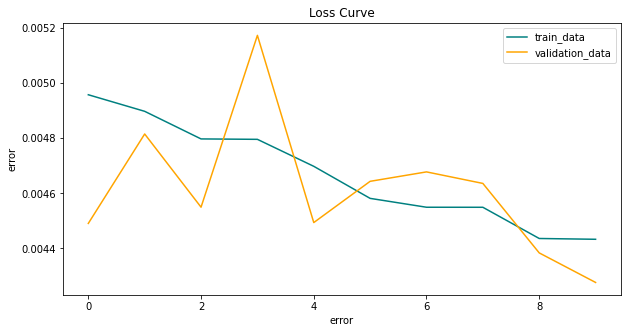

No handles with labels found to put in legend.


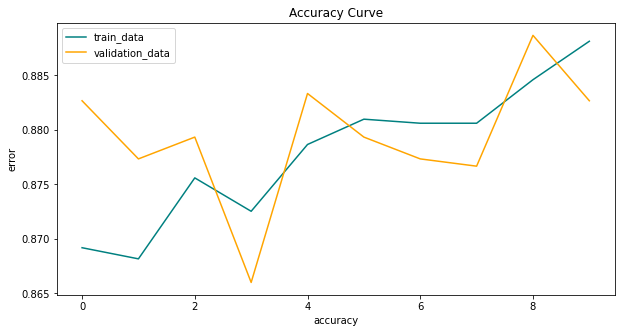

In [0]:
plot_curves("Loss Curve","error",vgg16_train_error,vgg16_val_error)
plot_curves("Accuracy Curve","accuracy",vgg16_train_acc,vgg16_val_acc)

**Loading Saved Model of VGG16 with updated Architecture**

In [0]:
vgg16.load_state_dict(torch.load('/content/drive/My Drive/Assignments_DataSets_deeplearning/vgg16_FC_Only.pth'))
vgg16.eval()


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

**Testing VGG16**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


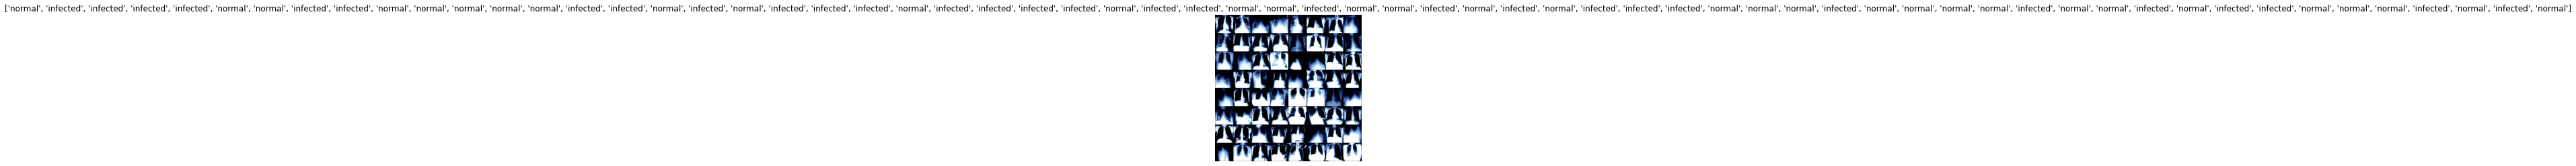

In [0]:
dataiter = iter(testloader)
images, labels = dataiter.next()
show_databatch(images, labels)

**Predicting For Test Data using VGG16**

In [0]:
images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = vgg16(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))
print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]]
                              for j in range(len(images))))

Predicted:  normal infected infected infected infected normal normal infected infected normal normal normal normal normal normal infected normal infected normal infected infected infected normal normal infected infected infected normal infected normal normal normal infected normal normal infected normal infected normal infected infected infected normal normal normal infected normal normal normal normal infected normal normal infected normal infected infected normal normal normal infected normal infected normal
Ground Truth:  normal infected infected infected infected normal normal infected infected normal normal normal normal normal infected infected normal infected normal infected infected infected normal infected infected infected infected normal infected infected normal normal infected normal normal infected normal infected normal infected infected infected normal normal normal infected normal normal normal normal infected normal normal infected normal infected infected normal norma

**Results of VGG16**

In [0]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 94 %


In [0]:
confusion_matrix(vgg16,trainloader)

tensor([[3901., 1018.],
        [ 287., 5565.]])


In [0]:
confusion_matrix(vgg16,testloader)

tensor([[553.,  62.],
        [ 17., 868.]])


In [0]:
confusion_matrix(vgg16,validloader)

tensor([[510., 105.],
        [ 71., 814.]])


#Task 2

1. In this task you will fine-tune two pre-trained networks (ResNet-18 and VGG-16 pretrained on ImageNet weights)
2. Perform different experiments where you first unfreeze only a few Convolutional layers and then the entire network and fine-tune on your dataset
3. Compare the performance of training in different experiments. Show what effect it has on accuracy when you fine-tune just FC layers, then a single Conv layer, then a few Conv layers and then the entire network. 
4. Save your model where you fine-tune the whole network and name it as ​‘vgg16_entire.pth’ and ‘​res18_entire.pth’ 

### ResNet-18 Model Entire Path

In [0]:
# Load the pretrained model from pytorch
cnn_resnet18 = models.resnet18(pretrained=True)
print(cnn_resnet18)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
 

**Freezing All the Layers**

In [0]:
# for param in cnn_resnet18.parameters():
#   param.requires_grad = False

**Replacing Previous FC Layers with new ones**

In [0]:
features = list()
features.extend([nn.Linear(512, 7100)])
features.extend([nn.ReLU(inplace=True)])
features.extend([nn.Linear(7100, 2)])
print(features)
cnn_resnet18.fc = nn.Sequential(*features)

[Linear(in_features=512, out_features=7100, bias=True), ReLU(inplace=True), Linear(in_features=7100, out_features=2, bias=True)]


**Now the Architecture Is Updated**

In [0]:
print(cnn_resnet18)

**Unfreezing FC layers**

In [0]:
for param in cnn_resnet18.fc.parameters():
  print(param.requires_grad)

True
True
True
True


In [0]:
# def layer_count_by_type(layer_type):
#   params = cnn_resnet18.state_dict() 
#   print(len(params))
#   c=0
#   for key,value in params.items():
#     if layer_type in key:
#       c+=1
#   print(c)
#   return c;

In [0]:
# layer_count_by_type("fc")

In [0]:
# def unfreez_layers(layer_type,count):
#   lc = layer_count_by_type("fc")
#   l_unfreeze = lc-count


In [0]:
# for child in cnn_resnet18.parameters():
#   rand = np.random.randint(0, 10+1)
#   if rand > 5:
#     child.requires_grad=True
#   else:
#     child.requires_grad=False
#   print(rand,"\n\n",child.requires_grad)

In [0]:
# for param in resnet18.fc.parameters():
#   param.requires_grad=True

In [0]:
# for param in cnn_resnet18.parameters():
#   print(param.requires_grad)

**Loss function and optimizer**

In [0]:
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn_resnet18.parameters(), lr=0.001, momentum=0.9)

**Training ResNet18**

In [0]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cnn_resnet18.to(device)

cnn_resnet18.train()
train_error=[]
val_error=[]
train_acc=[]
val_acc=[]

for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    running_corrects = 0.0
    num_images = 0

    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        num_images = num_images+inputs.size(0)

        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = cnn_resnet18(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update
        print("loss type",loss.data)

        _, preds = torch.max(outputs, 1)
        # print statistics
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels).item()

        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data))
        # train_error.append(loss.data)

    #train loss and accuracy
    epoch_loss = running_loss /num_images
    train_error.append(epoch_loss)
    epoch_acc = running_corrects / num_images
    train_acc.append(epoch_acc)

    #Validation loss and accuracy
    epoch_loss,epoch_acc = evaluate('r')
    val_error.append(epoch_loss)
    val_acc.append(epoch_acc)

    print('train loss: {}\n train acc: {}\n valid loss: {}\n valid acc:{}'.format(
        train_error[epoch],train_acc[epoch],val_error[epoch],val_acc[epoch]))

    torch.save(cnn_resnet18.state_dict(), data_dir+'res18_entire.pth')

print('Finished Training')

**Loading Saved Model of ResNet18 with updated Architecture**

In [0]:
resnet18.load_state_dict(torch.load('/content/drive/My Drive/Assignments_DataSets_deeplearning/res18_entire.pth'))
resnet18.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

**Testing Our Model**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


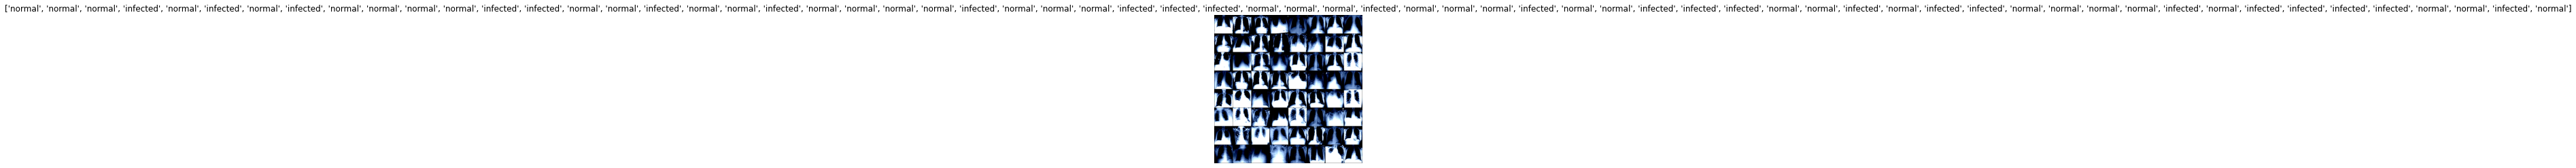

In [0]:
dataiter = iter(testloader)
images, labels = dataiter.next()
show_databatch(images, labels)

**Predicting For Test data**

In [0]:
images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = cnn_resnet18(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))
print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]]
                              for j in range(len(images))))

Predicted:  normal normal normal infected normal infected normal infected normal normal normal normal infected infected normal normal infected normal normal infected normal normal normal normal normal normal normal normal infected infected infected normal normal normal infected normal normal normal infected normal normal normal infected infected normal normal infected normal infected infected infected normal normal normal normal normal infected infected infected infected normal normal infected normal
Ground Truth:  normal normal normal infected normal infected normal infected normal normal normal normal infected infected normal normal infected normal normal infected normal normal normal normal infected normal normal normal infected infected infected normal normal normal infected normal normal normal infected normal normal infected infected infected normal normal infected normal infected infected normal normal normal normal infected normal infected infected infected infected normal norm

**Results For ResNet18 Model**

In [0]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = cnn_resnet18(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 96 %


In [0]:
confusion_matrix(cnn_resnet18,trainloader)

tensor([[4178.,  741.],
        [ 194., 5658.]])


In [0]:
confusion_matrix(cnn_resnet18,testloader)

tensor([[575.,  40.],
        [ 15., 870.]])


In [0]:
confusion_matrix(cnn_resnet18,validloader)

tensor([[535.,  80.],
        [ 59., 826.]])


No handles with labels found to put in legend.


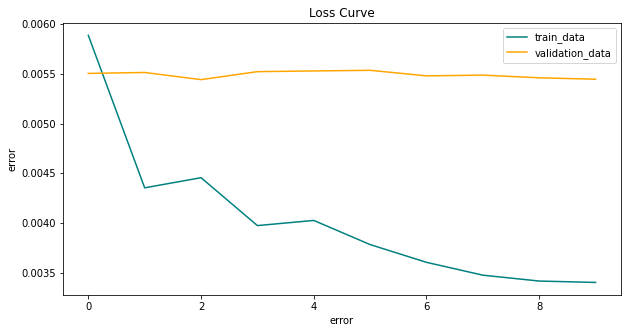

No handles with labels found to put in legend.


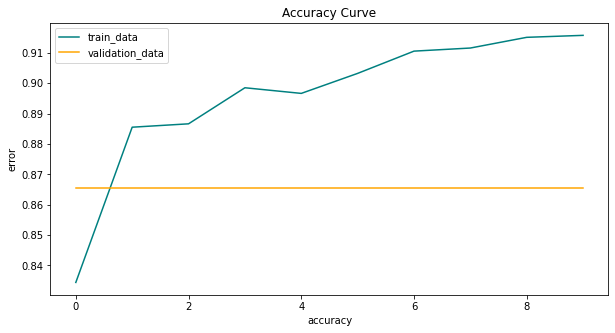

In [0]:
plot_curves("Loss Curve","error",train_error,val_error)
plot_curves("Accuracy Curve","accuracy",train_acc,val_acc)

### VGG16 Model Entire Path 

In [0]:
# Load the pretrained model from pytorch
cnn_vgg16 = models.vgg16(pretrained=True)
print(cnn_vgg16)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

In [0]:
features = list()
features.extend([nn.Linear(25088,7100)])
features.extend([nn.ReLU(inplace=True)])
features.extend([nn.Linear(7100,2)])

In [0]:
cnn_vgg16.classifier = nn.Sequential(*features)

In [0]:
print(cnn_vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
# for param in cnn_vgg16.parameters():
#   print(param.requires_grad)

In [0]:
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn_vgg16.parameters(), lr=0.001, momentum=0.9)

In [0]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cnn_vgg16.to(device)

cnn_vgg16.train()
train_error=[]
val_error=[]
train_acc=[]
val_acc=[]

for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    running_corrects = 0.0
    num_images = 0

    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        num_images = num_images+inputs.size(0)

        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = cnn_vgg16(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update
        print("loss type",loss.data)

        _, preds = torch.max(outputs, 1)
        # print statistics
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels).item()

        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data))
        # train_error.append(loss.data)

    #train loss and accuracy
    epoch_loss = running_loss /num_images
    train_error.append(epoch_loss)
    epoch_acc = running_corrects / num_images
    train_acc.append(epoch_acc)

    #Validation loss and accuracy
    epoch_loss,epoch_acc = evaluate('v',cnn_vgg16)
    val_error.append(epoch_loss)
    val_acc.append(epoch_acc)

    print('train loss: {}\n train acc: {}\n valid loss: {}\n valid acc:{}'.format(
        train_error[epoch],train_acc[epoch],val_error[epoch],val_acc[epoch]))

    torch.save(cnn_vgg16.state_dict(), data_dir+'vgg16_entire.pth')

print('Finished Training')

0it [00:00, ?it/s]

loss type 

Train Epoch: 0 [0/11230 (0%)]	Loss: 0.728507: : 1it [00:30, 30.28s/it]

tensor(0.7285, device='cuda:0')
loss type 

Train Epoch: 0 [64/11230 (1%)]	Loss: 0.704877: : 2it [00:30, 21.35s/it]

tensor(0.7049, device='cuda:0')
loss type 

Train Epoch: 0 [128/11230 (1%)]	Loss: 0.668363: : 3it [00:31, 15.10s/it]

tensor(0.6684, device='cuda:0')
loss type 

Train Epoch: 0 [192/11230 (2%)]	Loss: 0.680383: : 4it [00:31, 10.73s/it]

tensor(0.6804, device='cuda:0')
loss type 

Train Epoch: 0 [256/11230 (2%)]	Loss: 0.668796: : 5it [00:32,  7.67s/it]

tensor(0.6688, device='cuda:0')
loss type 

Train Epoch: 0 [320/11230 (3%)]	Loss: 0.639311: : 6it [00:54, 12.15s/it]

tensor(0.6393, device='cuda:0')
loss type 

Train Epoch: 0 [384/11230 (3%)]	Loss: 0.598757: : 7it [00:55,  8.75s/it]

tensor(0.5988, device='cuda:0')
loss type 

Train Epoch: 0 [448/11230 (4%)]	Loss: 0.595739: : 8it [00:56,  6.28s/it]

tensor(0.5957, device='cuda:0')
loss type 

Train Epoch: 0 [512/11230 (5%)]	Loss: 0.617122: : 9it [00:56,  4.56s/it]

tensor(0.6171, device='cuda:0')
loss type 

Train Epoch: 0 [576/11230 (5%)]	Loss: 0.633686: : 10it [01:05,  5.73s/it]

tensor(0.6337, device='cuda:0')
loss type 

Train Epoch: 0 [640/11230 (6%)]	Loss: 0.537313: : 11it [01:20,  8.62s/it]

tensor(0.5373, device='cuda:0')
loss type 

Train Epoch: 0 [704/11230 (6%)]	Loss: 0.556939: : 12it [01:21,  6.27s/it]

tensor(0.5569, device='cuda:0')
loss type 

Train Epoch: 0 [768/11230 (7%)]	Loss: 0.577940: : 13it [01:21,  4.55s/it]

tensor(0.5779, device='cuda:0')
loss type 

Train Epoch: 0 [832/11230 (7%)]	Loss: 0.535978: : 14it [01:22,  3.34s/it]

tensor(0.5360, device='cuda:0')
loss type 

Train Epoch: 0 [896/11230 (8%)]	Loss: 0.555332: : 15it [01:30,  4.77s/it]

tensor(0.5553, device='cuda:0')
loss type 

Train Epoch: 0 [960/11230 (9%)]	Loss: 0.544429: : 16it [01:45,  7.74s/it]

tensor(0.5444, device='cuda:0')
loss type 

Train Epoch: 0 [1024/11230 (9%)]	Loss: 0.519801: : 17it [01:47,  5.94s/it]

tensor(0.5198, device='cuda:0')
loss type 

Train Epoch: 0 [1088/11230 (10%)]	Loss: 0.501068: : 18it [01:47,  4.31s/it]

tensor(0.5011, device='cuda:0')
loss type 

Train Epoch: 0 [1152/11230 (10%)]	Loss: 0.498188: : 19it [01:48,  3.18s/it]

tensor(0.4982, device='cuda:0')
loss type 

Train Epoch: 0 [1216/11230 (11%)]	Loss: 0.521794: : 20it [01:55,  4.31s/it]

tensor(0.5218, device='cuda:0')
loss type 

Train Epoch: 0 [1280/11230 (11%)]	Loss: 0.405822: : 21it [02:11,  8.11s/it]

tensor(0.4058, device='cuda:0')
loss type 

Train Epoch: 0 [1344/11230 (12%)]	Loss: 0.423028: : 22it [02:14,  6.32s/it]

tensor(0.4230, device='cuda:0')
loss type 

Train Epoch: 0 [1408/11230 (12%)]	Loss: 0.377014: : 23it [02:14,  4.58s/it]

tensor(0.3770, device='cuda:0')
loss type 

Train Epoch: 0 [1472/11230 (13%)]	Loss: 0.485833: : 24it [02:15,  3.36s/it]

tensor(0.4858, device='cuda:0')
loss type 

Train Epoch: 0 [1536/11230 (14%)]	Loss: 0.433292: : 25it [02:21,  4.24s/it]

tensor(0.4333, device='cuda:0')
loss type 

Train Epoch: 0 [1600/11230 (14%)]	Loss: 0.483778: : 26it [02:37,  7.82s/it]

tensor(0.4838, device='cuda:0')
loss type 

Train Epoch: 0 [1664/11230 (15%)]	Loss: 0.524204: : 27it [02:39,  6.15s/it]

tensor(0.5242, device='cuda:0')
loss type 

Train Epoch: 0 [1728/11230 (15%)]	Loss: 0.469947: : 28it [02:40,  4.46s/it]

tensor(0.4699, device='cuda:0')
loss type 

Train Epoch: 0 [1792/11230 (16%)]	Loss: 0.539387: : 29it [02:41,  3.41s/it]

tensor(0.5394, device='cuda:0')
loss type 

Train Epoch: 0 [1856/11230 (16%)]	Loss: 0.351500: : 30it [02:46,  4.07s/it]

tensor(0.3515, device='cuda:0')
loss type 

Train Epoch: 0 [1920/11230 (17%)]	Loss: 0.330857: : 31it [03:03,  7.76s/it]

tensor(0.3309, device='cuda:0')
loss type 

Train Epoch: 0 [1984/11230 (18%)]	Loss: 0.324651: : 32it [03:03,  5.61s/it]

tensor(0.3247, device='cuda:0')
loss type 

Train Epoch: 0 [2048/11230 (18%)]	Loss: 0.392556: : 33it [03:04,  4.08s/it]

tensor(0.3926, device='cuda:0')
loss type 

Train Epoch: 0 [2112/11230 (19%)]	Loss: 0.357314: : 34it [03:05,  3.16s/it]

tensor(0.3573, device='cuda:0')
loss type 

Train Epoch: 0 [2176/11230 (19%)]	Loss: 0.546298: : 35it [03:11,  3.96s/it]

tensor(0.5463, device='cuda:0')
loss type 

Train Epoch: 0 [2240/11230 (20%)]	Loss: 0.526079: : 36it [03:28,  8.03s/it]

tensor(0.5261, device='cuda:0')
loss type 

Train Epoch: 0 [2304/11230 (20%)]	Loss: 0.464082: : 37it [03:29,  5.81s/it]

tensor(0.4641, device='cuda:0')
loss type 

Train Epoch: 0 [2368/11230 (21%)]	Loss: 0.373174: : 38it [03:29,  4.22s/it]

tensor(0.3732, device='cuda:0')
loss type 

Train Epoch: 0 [2432/11230 (22%)]	Loss: 0.420293: : 39it [03:34,  4.38s/it]

tensor(0.4203, device='cuda:0')
loss type 

Train Epoch: 0 [2496/11230 (22%)]	Loss: 0.317026: : 40it [03:37,  3.94s/it]

tensor(0.3170, device='cuda:0')
loss type 

Train Epoch: 0 [2560/11230 (23%)]	Loss: 0.453794: : 41it [03:54,  7.78s/it]

tensor(0.4538, device='cuda:0')
loss type 

Train Epoch: 0 [2624/11230 (23%)]	Loss: 0.384183: : 42it [03:55,  5.65s/it]

tensor(0.3842, device='cuda:0')
loss type 

Train Epoch: 0 [2688/11230 (24%)]	Loss: 0.469680: : 43it [03:55,  4.11s/it]

tensor(0.4697, device='cuda:0')
loss type 

Train Epoch: 0 [2752/11230 (24%)]	Loss: 0.422220: : 44it [03:58,  3.72s/it]

tensor(0.4222, device='cuda:0')
loss type 

Train Epoch: 0 [2816/11230 (25%)]	Loss: 0.392970: : 45it [04:03,  4.01s/it]

tensor(0.3930, device='cuda:0')
loss type 

Train Epoch: 0 [2880/11230 (26%)]	Loss: 0.358470: : 46it [04:20,  7.95s/it]

tensor(0.3585, device='cuda:0')
loss type 

Train Epoch: 0 [2944/11230 (26%)]	Loss: 0.348206: : 47it [04:20,  5.73s/it]

tensor(0.3482, device='cuda:0')
loss type 

Train Epoch: 0 [3008/11230 (27%)]	Loss: 0.331977: : 48it [04:21,  4.16s/it]

tensor(0.3320, device='cuda:0')
loss type 

Train Epoch: 0 [3072/11230 (27%)]	Loss: 0.409001: : 49it [04:26,  4.53s/it]

tensor(0.4090, device='cuda:0')
loss type 

Train Epoch: 0 [3136/11230 (28%)]	Loss: 0.334550: : 50it [04:30,  4.40s/it]

tensor(0.3346, device='cuda:0')
loss type 

Train Epoch: 0 [3200/11230 (28%)]	Loss: 0.291667: : 51it [04:47,  8.07s/it]

tensor(0.2917, device='cuda:0')
loss type 

Train Epoch: 0 [3264/11230 (29%)]	Loss: 0.438854: : 52it [04:47,  5.81s/it]

tensor(0.4389, device='cuda:0')
loss type 

Train Epoch: 0 [3328/11230 (30%)]	Loss: 0.358550: : 53it [04:48,  4.22s/it]

tensor(0.3586, device='cuda:0')
loss type 

Train Epoch: 0 [3392/11230 (30%)]	Loss: 0.519171: : 54it [04:52,  4.24s/it]

tensor(0.5192, device='cuda:0')
loss type 

Train Epoch: 0 [3456/11230 (31%)]	Loss: 0.275304: : 55it [04:55,  3.71s/it]

tensor(0.2753, device='cuda:0')
loss type 

Train Epoch: 0 [3520/11230 (31%)]	Loss: 0.297751: : 56it [05:11,  7.61s/it]

tensor(0.2978, device='cuda:0')
loss type 

Train Epoch: 0 [3584/11230 (32%)]	Loss: 0.381778: : 57it [05:12,  5.61s/it]

tensor(0.3818, device='cuda:0')
loss type 

Train Epoch: 0 [3648/11230 (32%)]	Loss: 0.424220: : 58it [05:13,  4.08s/it]

tensor(0.4242, device='cuda:0')
loss type 

Train Epoch: 0 [3712/11230 (33%)]	Loss: 0.493091: : 59it [05:17,  4.04s/it]

tensor(0.4931, device='cuda:0')
loss type 

Train Epoch: 0 [3776/11230 (34%)]	Loss: 0.250727: : 60it [05:20,  3.70s/it]

tensor(0.2507, device='cuda:0')
loss type 

Train Epoch: 0 [3840/11230 (34%)]	Loss: 0.378878: : 61it [05:38,  8.08s/it]

tensor(0.3789, device='cuda:0')
loss type 

Train Epoch: 0 [3904/11230 (35%)]	Loss: 0.481144: : 62it [05:39,  5.81s/it]

tensor(0.4811, device='cuda:0')
loss type 

Train Epoch: 0 [3968/11230 (35%)]	Loss: 0.355380: : 63it [05:39,  4.23s/it]

tensor(0.3554, device='cuda:0')
loss type 

Train Epoch: 0 [4032/11230 (36%)]	Loss: 0.456352: : 64it [05:42,  3.74s/it]

tensor(0.4564, device='cuda:0')
loss type 

Train Epoch: 0 [4096/11230 (36%)]	Loss: 0.267631: : 65it [05:46,  3.90s/it]

tensor(0.2676, device='cuda:0')
loss type 

Train Epoch: 0 [4160/11230 (37%)]	Loss: 0.422425: : 66it [06:05,  8.38s/it]

tensor(0.4224, device='cuda:0')
loss type 

Train Epoch: 0 [4224/11230 (38%)]	Loss: 0.368863: : 67it [06:05,  6.02s/it]

tensor(0.3689, device='cuda:0')
loss type 

Train Epoch: 0 [4288/11230 (38%)]	Loss: 0.355721: : 68it [06:06,  4.38s/it]

tensor(0.3557, device='cuda:0')
loss type 

Train Epoch: 0 [4352/11230 (39%)]	Loss: 0.358281: : 69it [06:08,  3.65s/it]

tensor(0.3583, device='cuda:0')
loss type 

Train Epoch: 0 [4416/11230 (39%)]	Loss: 0.333908: : 70it [06:11,  3.55s/it]

tensor(0.3339, device='cuda:0')
loss type 

Train Epoch: 0 [4480/11230 (40%)]	Loss: 0.314645: : 71it [06:30,  8.29s/it]

tensor(0.3146, device='cuda:0')
loss type 

Train Epoch: 0 [4544/11230 (40%)]	Loss: 0.310989: : 72it [06:31,  5.96s/it]

tensor(0.3110, device='cuda:0')
loss type 

Train Epoch: 0 [4608/11230 (41%)]	Loss: 0.269219: : 73it [06:31,  4.34s/it]

tensor(0.2692, device='cuda:0')
loss type 

Train Epoch: 0 [4672/11230 (41%)]	Loss: 0.337841: : 74it [06:33,  3.42s/it]

tensor(0.3378, device='cuda:0')
loss type 

Train Epoch: 0 [4736/11230 (42%)]	Loss: 0.347834: : 75it [06:36,  3.45s/it]

tensor(0.3478, device='cuda:0')
loss type 

Train Epoch: 0 [4800/11230 (43%)]	Loss: 0.391824: : 76it [06:57,  8.53s/it]

tensor(0.3918, device='cuda:0')
loss type 

Train Epoch: 0 [4864/11230 (43%)]	Loss: 0.321092: : 77it [06:57,  6.13s/it]

tensor(0.3211, device='cuda:0')
loss type 

Train Epoch: 0 [4928/11230 (44%)]	Loss: 0.440020: : 78it [06:58,  4.45s/it]

tensor(0.4400, device='cuda:0')
loss type 

Train Epoch: 0 [4992/11230 (44%)]	Loss: 0.303928: : 79it [06:59,  3.46s/it]

tensor(0.3039, device='cuda:0')
loss type 

Train Epoch: 0 [5056/11230 (45%)]	Loss: 0.298087: : 80it [07:02,  3.22s/it]

tensor(0.2981, device='cuda:0')
loss type 

Train Epoch: 0 [5120/11230 (45%)]	Loss: 0.343055: : 81it [07:25,  9.17s/it]

tensor(0.3431, device='cuda:0')
loss type 

Train Epoch: 0 [5184/11230 (46%)]	Loss: 0.198301: : 82it [07:25,  6.58s/it]

tensor(0.1983, device='cuda:0')
loss type 

Train Epoch: 0 [5248/11230 (47%)]	Loss: 0.336684: : 83it [07:26,  4.77s/it]

tensor(0.3367, device='cuda:0')
loss type 

Train Epoch: 0 [5312/11230 (47%)]	Loss: 0.246173: : 84it [07:26,  3.49s/it]

tensor(0.2462, device='cuda:0')
loss type 

Train Epoch: 0 [5376/11230 (48%)]	Loss: 0.387465: : 85it [07:28,  2.92s/it]

tensor(0.3875, device='cuda:0')
loss type 

Train Epoch: 0 [5440/11230 (48%)]	Loss: 0.309532: : 86it [07:50,  8.84s/it]

tensor(0.3095, device='cuda:0')
loss type 

Train Epoch: 0 [5504/11230 (49%)]	Loss: 0.607191: : 87it [07:51,  6.34s/it]

tensor(0.6072, device='cuda:0')
loss type 

Train Epoch: 0 [5568/11230 (49%)]	Loss: 0.268215: : 88it [07:51,  4.60s/it]

tensor(0.2682, device='cuda:0')
loss type 

Train Epoch: 0 [5632/11230 (50%)]	Loss: 0.381971: : 89it [07:52,  3.38s/it]

tensor(0.3820, device='cuda:0')
loss type 

Train Epoch: 0 [5696/11230 (51%)]	Loss: 0.243551: : 90it [07:53,  2.52s/it]

tensor(0.2436, device='cuda:0')
loss type 

Train Epoch: 0 [5760/11230 (51%)]	Loss: 0.367410: : 91it [08:15,  8.50s/it]

tensor(0.3674, device='cuda:0')
loss type 

Train Epoch: 0 [5824/11230 (52%)]	Loss: 0.293854: : 92it [08:16,  6.11s/it]

tensor(0.2939, device='cuda:0')
loss type 

Train Epoch: 0 [5888/11230 (52%)]	Loss: 0.297617: : 93it [08:16,  4.44s/it]

tensor(0.2976, device='cuda:0')
loss type 

Train Epoch: 0 [5952/11230 (53%)]	Loss: 0.482365: : 94it [08:17,  3.32s/it]

tensor(0.4824, device='cuda:0')
loss type 

Train Epoch: 0 [6016/11230 (53%)]	Loss: 0.259651: : 95it [08:19,  3.04s/it]

tensor(0.2597, device='cuda:0')
loss type 

Train Epoch: 0 [6080/11230 (54%)]	Loss: 0.450549: : 96it [08:41,  8.69s/it]

tensor(0.4505, device='cuda:0')
loss type 

Train Epoch: 0 [6144/11230 (55%)]	Loss: 0.396450: : 97it [08:42,  6.24s/it]

tensor(0.3965, device='cuda:0')
loss type 

Train Epoch: 0 [6208/11230 (55%)]	Loss: 0.223098: : 98it [08:42,  4.52s/it]

tensor(0.2231, device='cuda:0')
loss type 

Train Epoch: 0 [6272/11230 (56%)]	Loss: 0.218556: : 99it [08:43,  3.32s/it]

tensor(0.2186, device='cuda:0')
loss type 

Train Epoch: 0 [6336/11230 (56%)]	Loss: 0.290536: : 100it [08:46,  3.34s/it]

tensor(0.2905, device='cuda:0')
loss type 

Train Epoch: 0 [6400/11230 (57%)]	Loss: 0.352582: : 101it [09:08,  8.85s/it]

tensor(0.3526, device='cuda:0')
loss type 

Train Epoch: 0 [6464/11230 (57%)]	Loss: 0.255834: : 102it [09:08,  6.35s/it]

tensor(0.2558, device='cuda:0')
loss type 

Train Epoch: 0 [6528/11230 (58%)]	Loss: 0.305346: : 103it [09:09,  4.60s/it]

tensor(0.3053, device='cuda:0')
loss type 

Train Epoch: 0 [6592/11230 (59%)]	Loss: 0.250923: : 104it [09:09,  3.39s/it]

tensor(0.2509, device='cuda:0')
loss type 

Train Epoch: 0 [6656/11230 (59%)]	Loss: 0.220272: : 105it [09:11,  3.04s/it]

tensor(0.2203, device='cuda:0')
loss type 

Train Epoch: 0 [6720/11230 (60%)]	Loss: 0.273481: : 106it [09:32,  8.33s/it]

tensor(0.2735, device='cuda:0')
loss type 

Train Epoch: 0 [6784/11230 (60%)]	Loss: 0.262258: : 107it [09:33,  5.99s/it]

tensor(0.2623, device='cuda:0')
loss type 

Train Epoch: 0 [6848/11230 (61%)]	Loss: 0.413782: : 108it [09:33,  4.35s/it]

tensor(0.4138, device='cuda:0')
loss type 

Train Epoch: 0 [6912/11230 (61%)]	Loss: 0.289231: : 109it [09:35,  3.70s/it]

tensor(0.2892, device='cuda:0')
loss type 

Train Epoch: 0 [6976/11230 (62%)]	Loss: 0.310994: : 110it [09:36,  2.86s/it]

tensor(0.3110, device='cuda:0')
loss type 

Train Epoch: 0 [7040/11230 (62%)]	Loss: 0.402087: : 111it [09:57,  8.28s/it]

tensor(0.4021, device='cuda:0')
loss type 

Train Epoch: 0 [7104/11230 (63%)]	Loss: 0.242261: : 112it [09:58,  5.95s/it]

tensor(0.2423, device='cuda:0')
loss type 

Train Epoch: 0 [7168/11230 (64%)]	Loss: 0.317493: : 113it [09:58,  4.32s/it]

tensor(0.3175, device='cuda:0')
loss type 

Train Epoch: 0 [7232/11230 (64%)]	Loss: 0.251295: : 114it [10:00,  3.54s/it]

tensor(0.2513, device='cuda:0')
loss type 

Train Epoch: 0 [7296/11230 (65%)]	Loss: 0.291531: : 115it [10:01,  2.83s/it]

tensor(0.2915, device='cuda:0')
loss type 

Train Epoch: 0 [7360/11230 (65%)]	Loss: 0.251529: : 116it [10:23,  8.47s/it]

tensor(0.2515, device='cuda:0')
loss type 

Train Epoch: 0 [7424/11230 (66%)]	Loss: 0.261645: : 117it [10:23,  6.09s/it]

tensor(0.2616, device='cuda:0')
loss type 

Train Epoch: 0 [7488/11230 (66%)]	Loss: 0.307703: : 118it [10:24,  4.42s/it]

tensor(0.3077, device='cuda:0')
loss type 

Train Epoch: 0 [7552/11230 (67%)]	Loss: 0.260531: : 119it [10:26,  3.62s/it]

tensor(0.2605, device='cuda:0')
loss type 

Train Epoch: 0 [7616/11230 (68%)]	Loss: 0.413080: : 120it [10:27,  2.81s/it]

tensor(0.4131, device='cuda:0')
loss type 

Train Epoch: 0 [7680/11230 (68%)]	Loss: 0.358950: : 121it [10:48,  8.32s/it]

tensor(0.3589, device='cuda:0')
loss type 

Train Epoch: 0 [7744/11230 (69%)]	Loss: 0.302211: : 122it [10:48,  5.98s/it]

tensor(0.3022, device='cuda:0')
loss type 

Train Epoch: 0 [7808/11230 (69%)]	Loss: 0.132884: : 123it [10:49,  4.34s/it]

tensor(0.1329, device='cuda:0')
loss type 

Train Epoch: 0 [7872/11230 (70%)]	Loss: 0.272692: : 124it [10:50,  3.35s/it]

tensor(0.2727, device='cuda:0')
loss type 

Train Epoch: 0 [7936/11230 (70%)]	Loss: 0.214110: : 125it [10:51,  2.68s/it]

tensor(0.2141, device='cuda:0')
loss type 

Train Epoch: 0 [8000/11230 (71%)]	Loss: 0.179813: : 126it [11:16,  9.49s/it]

tensor(0.1798, device='cuda:0')
loss type 

Train Epoch: 0 [8064/11230 (72%)]	Loss: 0.228297: : 127it [11:17,  6.80s/it]

tensor(0.2283, device='cuda:0')
loss type 

Train Epoch: 0 [8128/11230 (72%)]	Loss: 0.394418: : 128it [11:17,  4.92s/it]

tensor(0.3944, device='cuda:0')
loss type 

Train Epoch: 0 [8192/11230 (73%)]	Loss: 0.226302: : 129it [11:18,  3.60s/it]

tensor(0.2263, device='cuda:0')
loss type 

Train Epoch: 0 [8256/11230 (73%)]	Loss: 0.228034: : 130it [11:19,  2.73s/it]

tensor(0.2280, device='cuda:0')
loss type 

Train Epoch: 0 [8320/11230 (74%)]	Loss: 0.330018: : 131it [11:41,  8.69s/it]

tensor(0.3300, device='cuda:0')
loss type 

Train Epoch: 0 [8384/11230 (74%)]	Loss: 0.341168: : 132it [11:42,  6.24s/it]

tensor(0.3412, device='cuda:0')
loss type 

Train Epoch: 0 [8448/11230 (75%)]	Loss: 0.257464: : 133it [11:42,  4.53s/it]

tensor(0.2575, device='cuda:0')
loss type 

Train Epoch: 0 [8512/11230 (76%)]	Loss: 0.281048: : 134it [11:43,  3.33s/it]

tensor(0.2810, device='cuda:0')
loss type 

Train Epoch: 0 [8576/11230 (76%)]	Loss: 0.240468: : 135it [11:44,  2.74s/it]

tensor(0.2405, device='cuda:0')
loss type 

Train Epoch: 0 [8640/11230 (77%)]	Loss: 0.218750: : 136it [12:06,  8.47s/it]

tensor(0.2187, device='cuda:0')
loss type 

Train Epoch: 0 [8704/11230 (77%)]	Loss: 0.273518: : 137it [12:06,  6.09s/it]

tensor(0.2735, device='cuda:0')
loss type 

Train Epoch: 0 [8768/11230 (78%)]	Loss: 0.347364: : 138it [12:07,  4.42s/it]

tensor(0.3474, device='cuda:0')
loss type 

Train Epoch: 0 [8832/11230 (78%)]	Loss: 0.344662: : 139it [12:08,  3.34s/it]

tensor(0.3447, device='cuda:0')
loss type 

Train Epoch: 0 [8896/11230 (79%)]	Loss: 0.336396: : 140it [12:10,  3.00s/it]

tensor(0.3364, device='cuda:0')
loss type 

Train Epoch: 0 [8960/11230 (80%)]	Loss: 0.289033: : 141it [12:33,  8.91s/it]

tensor(0.2890, device='cuda:0')
loss type 

Train Epoch: 0 [9024/11230 (80%)]	Loss: 0.189970: : 142it [12:33,  6.39s/it]

tensor(0.1900, device='cuda:0')
loss type 

Train Epoch: 0 [9088/11230 (81%)]	Loss: 0.354787: : 143it [12:34,  4.63s/it]

tensor(0.3548, device='cuda:0')
loss type 

Train Epoch: 0 [9152/11230 (81%)]	Loss: 0.227623: : 144it [12:34,  3.40s/it]

tensor(0.2276, device='cuda:0')
loss type 

Train Epoch: 0 [9216/11230 (82%)]	Loss: 0.267938: : 145it [12:36,  2.76s/it]

tensor(0.2679, device='cuda:0')
loss type 

Train Epoch: 0 [9280/11230 (82%)]	Loss: 0.257968: : 146it [12:59,  8.88s/it]

tensor(0.2580, device='cuda:0')
loss type 

Train Epoch: 0 [9344/11230 (83%)]	Loss: 0.347563: : 147it [12:59,  6.37s/it]

tensor(0.3476, device='cuda:0')
loss type 

Train Epoch: 0 [9408/11230 (84%)]	Loss: 0.361092: : 148it [13:00,  4.62s/it]

tensor(0.3611, device='cuda:0')
loss type 

Train Epoch: 0 [9472/11230 (84%)]	Loss: 0.304298: : 149it [13:00,  3.39s/it]

tensor(0.3043, device='cuda:0')
loss type 

Train Epoch: 0 [9536/11230 (85%)]	Loss: 0.461967: : 150it [13:01,  2.72s/it]

tensor(0.4620, device='cuda:0')
loss type 

Train Epoch: 0 [9600/11230 (85%)]	Loss: 0.270546: : 151it [13:34, 11.67s/it]

tensor(0.2705, device='cuda:0')
loss type 

Train Epoch: 0 [9664/11230 (86%)]	Loss: 0.218558: : 152it [13:35,  8.33s/it]

tensor(0.2186, device='cuda:0')
loss type 

Train Epoch: 0 [9728/11230 (86%)]	Loss: 0.173709: : 153it [13:35,  5.98s/it]

tensor(0.1737, device='cuda:0')
loss type 

Train Epoch: 0 [9792/11230 (87%)]	Loss: 0.350180: : 154it [13:36,  4.34s/it]

tensor(0.3502, device='cuda:0')
loss type 

Train Epoch: 0 [9856/11230 (88%)]	Loss: 0.260463: : 155it [13:36,  3.20s/it]

tensor(0.2605, device='cuda:0')
loss type 

Train Epoch: 0 [9920/11230 (88%)]	Loss: 0.328993: : 156it [14:00,  9.48s/it]

tensor(0.3290, device='cuda:0')
loss type 

Train Epoch: 0 [9984/11230 (89%)]	Loss: 0.319349: : 157it [14:01,  6.80s/it]

tensor(0.3193, device='cuda:0')
loss type 

Train Epoch: 0 [10048/11230 (89%)]	Loss: 0.242426: : 158it [14:01,  4.91s/it]

tensor(0.2424, device='cuda:0')
loss type 

Train Epoch: 0 [10112/11230 (90%)]	Loss: 0.302595: : 159it [14:02,  3.60s/it]

tensor(0.3026, device='cuda:0')
loss type 

Train Epoch: 0 [10176/11230 (90%)]	Loss: 0.258121: : 160it [14:02,  2.67s/it]

tensor(0.2581, device='cuda:0')
loss type 

Train Epoch: 0 [10240/11230 (91%)]	Loss: 0.303423: : 161it [14:28,  9.62s/it]

tensor(0.3034, device='cuda:0')
loss type 

Train Epoch: 0 [10304/11230 (91%)]	Loss: 0.286910: : 162it [14:29,  6.90s/it]

tensor(0.2869, device='cuda:0')
loss type 

Train Epoch: 0 [10368/11230 (92%)]	Loss: 0.106235: : 163it [14:29,  5.00s/it]

tensor(0.1062, device='cuda:0')
loss type 

Train Epoch: 0 [10432/11230 (93%)]	Loss: 0.267006: : 164it [14:30,  3.66s/it]

tensor(0.2670, device='cuda:0')
loss type 

Train Epoch: 0 [10496/11230 (93%)]	Loss: 0.282688: : 165it [14:30,  2.72s/it]

tensor(0.2827, device='cuda:0')
loss type 

Train Epoch: 0 [10560/11230 (94%)]	Loss: 0.342780: : 166it [14:57, 10.02s/it]

tensor(0.3428, device='cuda:0')
loss type 

Train Epoch: 0 [10624/11230 (94%)]	Loss: 0.233447: : 167it [14:58,  7.17s/it]

tensor(0.2334, device='cuda:0')
loss type 

Train Epoch: 0 [10688/11230 (95%)]	Loss: 0.188138: : 168it [14:58,  5.18s/it]

tensor(0.1881, device='cuda:0')
loss type 

Train Epoch: 0 [10752/11230 (95%)]	Loss: 0.248453: : 169it [14:59,  3.78s/it]

tensor(0.2485, device='cuda:0')
loss type 

Train Epoch: 0 [10816/11230 (96%)]	Loss: 0.296189: : 170it [14:59,  2.80s/it]

tensor(0.2962, device='cuda:0')
loss type 

Train Epoch: 0 [10880/11230 (97%)]	Loss: 0.310087: : 171it [15:23,  9.04s/it]

tensor(0.3101, device='cuda:0')
loss type 

Train Epoch: 0 [10944/11230 (97%)]	Loss: 0.266882: : 172it [15:24,  6.48s/it]

tensor(0.2669, device='cuda:0')
loss type 

Train Epoch: 0 [11008/11230 (98%)]	Loss: 0.201696: : 173it [15:24,  4.69s/it]

tensor(0.2017, device='cuda:0')
loss type 

Train Epoch: 0 [11072/11230 (98%)]	Loss: 0.313680: : 174it [15:25,  3.44s/it]

tensor(0.3137, device='cuda:0')
loss type 

Train Epoch: 0 [11136/11230 (99%)]	Loss: 0.243736: : 175it [15:25,  2.56s/it]

tensor(0.2437, device='cuda:0')
loss type 

Train Epoch: 0 [5250/11230 (99%)]	Loss: 0.258364: : 176it [15:34,  5.31s/it]

tensor(0.2584, device='cuda:0')



24it [02:06,  5.28s/it]


train loss: 0.005624419316078867
 train acc: 0.8390917186108637
 valid loss: 0.00534395628174146
 valid acc:0.8693333333333333


0it [00:00, ?it/s]

loss type 

Train Epoch: 1 [0/11230 (0%)]	Loss: 0.342857: : 1it [00:06,  6.22s/it]

tensor(0.3429, device='cuda:0')
loss type 

Train Epoch: 1 [64/11230 (1%)]	Loss: 0.224448: : 2it [00:06,  4.52s/it]

tensor(0.2244, device='cuda:0')
loss type 

Train Epoch: 1 [128/11230 (1%)]	Loss: 0.180155: : 3it [00:07,  3.35s/it]

tensor(0.1802, device='cuda:0')
loss type 

Train Epoch: 1 [192/11230 (2%)]	Loss: 0.184057: : 4it [00:07,  2.50s/it]

tensor(0.1841, device='cuda:0')
loss type 

Train Epoch: 1 [256/11230 (2%)]	Loss: 0.322999: : 5it [00:08,  1.93s/it]

tensor(0.3230, device='cuda:0')
loss type 

Train Epoch: 1 [320/11230 (3%)]	Loss: 0.378620: : 6it [00:12,  2.67s/it]

tensor(0.3786, device='cuda:0')
loss type 

Train Epoch: 1 [384/11230 (3%)]	Loss: 0.195160: : 7it [00:13,  2.06s/it]

tensor(0.1952, device='cuda:0')
loss type 

Train Epoch: 1 [448/11230 (4%)]	Loss: 0.211446: : 8it [00:14,  1.62s/it]

tensor(0.2114, device='cuda:0')
loss type 

Train Epoch: 1 [512/11230 (5%)]	Loss: 0.302952: : 9it [00:14,  1.32s/it]

tensor(0.3030, device='cuda:0')
loss type 

Train Epoch: 1 [576/11230 (5%)]	Loss: 0.273314: : 10it [00:15,  1.10s/it]

tensor(0.2733, device='cuda:0')
loss type 

Train Epoch: 1 [640/11230 (6%)]	Loss: 0.266822: : 11it [00:19,  1.91s/it]

tensor(0.2668, device='cuda:0')
loss type 

Train Epoch: 1 [704/11230 (6%)]	Loss: 0.265156: : 12it [00:20,  1.80s/it]

tensor(0.2652, device='cuda:0')
loss type 

Train Epoch: 1 [768/11230 (7%)]	Loss: 0.453124: : 13it [00:21,  1.44s/it]

tensor(0.4531, device='cuda:0')
loss type 

Train Epoch: 1 [832/11230 (7%)]	Loss: 0.247374: : 14it [00:21,  1.18s/it]

tensor(0.2474, device='cuda:0')
loss type 

Train Epoch: 1 [896/11230 (8%)]	Loss: 0.176060: : 15it [00:22,  1.00it/s]

tensor(0.1761, device='cuda:0')
loss type 

Train Epoch: 1 [960/11230 (9%)]	Loss: 0.250537: : 16it [00:24,  1.44s/it]

tensor(0.2505, device='cuda:0')
loss type 

Train Epoch: 1 [1024/11230 (9%)]	Loss: 0.390485: : 17it [00:26,  1.50s/it]

tensor(0.3905, device='cuda:0')
loss type 

Train Epoch: 1 [1088/11230 (10%)]	Loss: 0.353676: : 18it [00:27,  1.47s/it]

tensor(0.3537, device='cuda:0')
loss type 

Train Epoch: 1 [1152/11230 (10%)]	Loss: 0.384583: : 19it [00:28,  1.20s/it]

tensor(0.3846, device='cuda:0')
loss type 

Train Epoch: 1 [1216/11230 (11%)]	Loss: 0.268672: : 20it [00:29,  1.01s/it]

tensor(0.2687, device='cuda:0')
loss type 

Train Epoch: 1 [1280/11230 (11%)]	Loss: 0.306628: : 21it [00:30,  1.21s/it]

tensor(0.3066, device='cuda:0')
loss type 

Train Epoch: 1 [1344/11230 (12%)]	Loss: 0.238715: : 22it [00:32,  1.36s/it]

tensor(0.2387, device='cuda:0')
loss type 

Train Epoch: 1 [1408/11230 (12%)]	Loss: 0.326496: : 23it [00:33,  1.29s/it]

tensor(0.3265, device='cuda:0')
loss type 

Train Epoch: 1 [1472/11230 (13%)]	Loss: 0.325586: : 24it [00:34,  1.07s/it]

tensor(0.3256, device='cuda:0')
loss type 

Train Epoch: 1 [1536/11230 (14%)]	Loss: 0.266459: : 25it [00:34,  1.09it/s]

tensor(0.2665, device='cuda:0')
loss type 

Train Epoch: 1 [1600/11230 (14%)]	Loss: 0.299811: : 26it [00:36,  1.26s/it]

tensor(0.2998, device='cuda:0')
loss type 

Train Epoch: 1 [1664/11230 (15%)]	Loss: 0.254039: : 27it [00:38,  1.35s/it]

tensor(0.2540, device='cuda:0')
loss type 

Train Epoch: 1 [1728/11230 (15%)]	Loss: 0.245460: : 28it [00:39,  1.43s/it]

tensor(0.2455, device='cuda:0')
loss type 

Train Epoch: 1 [1792/11230 (16%)]	Loss: 0.339483: : 29it [00:40,  1.17s/it]

tensor(0.3395, device='cuda:0')
loss type 

Train Epoch: 1 [1856/11230 (16%)]	Loss: 0.261917: : 30it [00:41,  1.02it/s]

tensor(0.2619, device='cuda:0')
loss type 

Train Epoch: 1 [1920/11230 (17%)]	Loss: 0.300060: : 31it [00:43,  1.27s/it]

tensor(0.3001, device='cuda:0')
loss type 

Train Epoch: 1 [1984/11230 (18%)]	Loss: 0.203433: : 32it [00:44,  1.44s/it]

tensor(0.2034, device='cuda:0')
loss type 

Train Epoch: 1 [2048/11230 (18%)]	Loss: 0.146685: : 33it [00:46,  1.36s/it]

tensor(0.1467, device='cuda:0')
loss type 

Train Epoch: 1 [2112/11230 (19%)]	Loss: 0.128394: : 34it [00:46,  1.12s/it]

tensor(0.1284, device='cuda:0')
loss type 

Train Epoch: 1 [2176/11230 (19%)]	Loss: 0.145284: : 35it [00:47,  1.04it/s]

tensor(0.1453, device='cuda:0')
loss type 

Train Epoch: 1 [2240/11230 (20%)]	Loss: 0.184453: : 36it [00:48,  1.17s/it]

tensor(0.1845, device='cuda:0')
loss type 

Train Epoch: 1 [2304/11230 (20%)]	Loss: 0.204233: : 37it [00:52,  1.79s/it]

tensor(0.2042, device='cuda:0')
loss type 

Train Epoch: 1 [2368/11230 (21%)]	Loss: 0.316369: : 38it [00:52,  1.42s/it]

tensor(0.3164, device='cuda:0')
loss type 

Train Epoch: 1 [2432/11230 (22%)]	Loss: 0.271130: : 39it [00:53,  1.17s/it]

tensor(0.2711, device='cuda:0')
loss type 

Train Epoch: 1 [2496/11230 (22%)]	Loss: 0.301054: : 40it [00:53,  1.01it/s]

tensor(0.3011, device='cuda:0')
loss type 

Train Epoch: 1 [2560/11230 (23%)]	Loss: 0.221509: : 41it [00:56,  1.46s/it]

tensor(0.2215, device='cuda:0')
loss type 

Train Epoch: 1 [2624/11230 (23%)]	Loss: 0.394910: : 42it [00:58,  1.63s/it]

tensor(0.3949, device='cuda:0')
loss type 

Train Epoch: 1 [2688/11230 (24%)]	Loss: 0.349430: : 43it [00:58,  1.31s/it]

tensor(0.3494, device='cuda:0')
loss type 

Train Epoch: 1 [2752/11230 (24%)]	Loss: 0.137693: : 44it [00:59,  1.08s/it]

tensor(0.1377, device='cuda:0')
loss type 

Train Epoch: 1 [2816/11230 (25%)]	Loss: 0.255229: : 45it [01:00,  1.09it/s]

tensor(0.2552, device='cuda:0')
loss type 

Train Epoch: 1 [2880/11230 (26%)]	Loss: 0.516158: : 46it [01:02,  1.51s/it]

tensor(0.5162, device='cuda:0')
loss type 

Train Epoch: 1 [2944/11230 (26%)]	Loss: 0.477270: : 47it [01:04,  1.51s/it]

tensor(0.4773, device='cuda:0')
loss type 

Train Epoch: 1 [3008/11230 (27%)]	Loss: 0.287381: : 48it [01:04,  1.22s/it]

tensor(0.2874, device='cuda:0')
loss type 

Train Epoch: 1 [3072/11230 (27%)]	Loss: 0.241920: : 49it [01:05,  1.03s/it]

tensor(0.2419, device='cuda:0')
loss type 

Train Epoch: 1 [3136/11230 (28%)]	Loss: 0.318650: : 50it [01:06,  1.13it/s]

tensor(0.3187, device='cuda:0')
loss type 

Train Epoch: 1 [3200/11230 (28%)]	Loss: 0.518509: : 51it [01:08,  1.45s/it]

tensor(0.5185, device='cuda:0')
loss type 

Train Epoch: 1 [3264/11230 (29%)]	Loss: 0.525202: : 52it [01:10,  1.46s/it]

tensor(0.5252, device='cuda:0')
loss type 

Train Epoch: 1 [3328/11230 (30%)]	Loss: 0.332669: : 53it [01:10,  1.20s/it]

tensor(0.3327, device='cuda:0')
loss type 

Train Epoch: 1 [3392/11230 (30%)]	Loss: 0.209108: : 54it [01:11,  1.01s/it]

tensor(0.2091, device='cuda:0')
loss type 

Train Epoch: 1 [3456/11230 (31%)]	Loss: 0.366817: : 55it [01:12,  1.14it/s]

tensor(0.3668, device='cuda:0')
loss type 

Train Epoch: 1 [3520/11230 (31%)]	Loss: 0.449624: : 56it [01:15,  1.61s/it]

tensor(0.4496, device='cuda:0')
loss type 

Train Epoch: 1 [3584/11230 (32%)]	Loss: 0.369399: : 57it [01:16,  1.39s/it]

tensor(0.3694, device='cuda:0')
loss type 

Train Epoch: 1 [3648/11230 (32%)]	Loss: 0.319040: : 58it [01:16,  1.14s/it]

tensor(0.3190, device='cuda:0')
loss type 

Train Epoch: 1 [3712/11230 (33%)]	Loss: 0.300192: : 59it [01:17,  1.03it/s]

tensor(0.3002, device='cuda:0')
loss type 

Train Epoch: 1 [3776/11230 (34%)]	Loss: 0.365161: : 60it [01:17,  1.18it/s]

tensor(0.3652, device='cuda:0')
loss type 

Train Epoch: 1 [3840/11230 (34%)]	Loss: 0.230942: : 61it [01:21,  1.62s/it]

tensor(0.2309, device='cuda:0')
loss type 

Train Epoch: 1 [3904/11230 (35%)]	Loss: 0.298673: : 62it [01:22,  1.34s/it]

tensor(0.2987, device='cuda:0')
loss type 

Train Epoch: 1 [3968/11230 (35%)]	Loss: 0.300108: : 63it [01:22,  1.15s/it]

tensor(0.3001, device='cuda:0')
loss type 

Train Epoch: 1 [4032/11230 (36%)]	Loss: 0.301825: : 64it [01:23,  1.03it/s]

tensor(0.3018, device='cuda:0')
loss type 

Train Epoch: 1 [4096/11230 (36%)]	Loss: 0.233287: : 65it [01:23,  1.17it/s]

tensor(0.2333, device='cuda:0')
loss type 

Train Epoch: 1 [4160/11230 (37%)]	Loss: 0.160496: : 66it [01:27,  1.63s/it]

tensor(0.1605, device='cuda:0')
loss type 

Train Epoch: 1 [4224/11230 (38%)]	Loss: 0.229348: : 67it [01:28,  1.37s/it]

tensor(0.2293, device='cuda:0')
loss type 

Train Epoch: 1 [4288/11230 (38%)]	Loss: 0.272500: : 68it [01:28,  1.13s/it]

tensor(0.2725, device='cuda:0')
loss type 

Train Epoch: 1 [4352/11230 (39%)]	Loss: 0.315709: : 69it [01:29,  1.04it/s]

tensor(0.3157, device='cuda:0')
loss type 

Train Epoch: 1 [4416/11230 (39%)]	Loss: 0.225958: : 70it [01:29,  1.19it/s]

tensor(0.2260, device='cuda:0')
loss type 

Train Epoch: 1 [4480/11230 (40%)]	Loss: 0.251880: : 71it [01:33,  1.68s/it]

tensor(0.2519, device='cuda:0')
loss type 

Train Epoch: 1 [4544/11230 (40%)]	Loss: 0.411008: : 72it [01:34,  1.35s/it]

tensor(0.4110, device='cuda:0')
loss type 

Train Epoch: 1 [4608/11230 (41%)]	Loss: 0.318668: : 73it [01:34,  1.12s/it]

tensor(0.3187, device='cuda:0')
loss type 

Train Epoch: 1 [4672/11230 (41%)]	Loss: 0.189141: : 74it [01:35,  1.05it/s]

tensor(0.1891, device='cuda:0')
loss type 

Train Epoch: 1 [4736/11230 (42%)]	Loss: 0.218774: : 75it [01:35,  1.19it/s]

tensor(0.2188, device='cuda:0')
loss type 

Train Epoch: 1 [4800/11230 (43%)]	Loss: 0.338433: : 76it [01:39,  1.64s/it]

tensor(0.3384, device='cuda:0')
loss type 

Train Epoch: 1 [4864/11230 (43%)]	Loss: 0.288379: : 77it [01:39,  1.33s/it]

tensor(0.2884, device='cuda:0')
loss type 

Train Epoch: 1 [4928/11230 (44%)]	Loss: 0.241652: : 78it [01:40,  1.09s/it]

tensor(0.2417, device='cuda:0')
loss type 

Train Epoch: 1 [4992/11230 (44%)]	Loss: 0.215871: : 79it [01:40,  1.06it/s]

tensor(0.2159, device='cuda:0')
loss type 

Train Epoch: 1 [5056/11230 (45%)]	Loss: 0.462737: : 80it [01:41,  1.21it/s]

tensor(0.4627, device='cuda:0')
loss type 

Train Epoch: 1 [5120/11230 (45%)]	Loss: 0.209541: : 81it [01:45,  1.75s/it]

tensor(0.2095, device='cuda:0')
loss type 

Train Epoch: 1 [5184/11230 (46%)]	Loss: 0.232998: : 82it [01:45,  1.39s/it]

tensor(0.2330, device='cuda:0')
loss type 

Train Epoch: 1 [5248/11230 (47%)]	Loss: 0.294741: : 83it [01:46,  1.15s/it]

tensor(0.2947, device='cuda:0')
loss type 

Train Epoch: 1 [5312/11230 (47%)]	Loss: 0.264568: : 84it [01:47,  1.03it/s]

tensor(0.2646, device='cuda:0')
loss type 

Train Epoch: 1 [5376/11230 (48%)]	Loss: 0.183120: : 85it [01:47,  1.18it/s]

tensor(0.1831, device='cuda:0')
loss type 

Train Epoch: 1 [5440/11230 (48%)]	Loss: 0.236514: : 86it [01:51,  1.69s/it]

tensor(0.2365, device='cuda:0')
loss type 

Train Epoch: 1 [5504/11230 (49%)]	Loss: 0.453419: : 87it [01:51,  1.35s/it]

tensor(0.4534, device='cuda:0')
loss type 

Train Epoch: 1 [5568/11230 (49%)]	Loss: 0.323313: : 88it [01:52,  1.11s/it]

tensor(0.3233, device='cuda:0')
loss type 

Train Epoch: 1 [5632/11230 (50%)]	Loss: 0.276581: : 89it [01:53,  1.05it/s]

tensor(0.2766, device='cuda:0')
loss type 

Train Epoch: 1 [5696/11230 (51%)]	Loss: 0.221031: : 90it [01:53,  1.20it/s]

tensor(0.2210, device='cuda:0')
loss type 

Train Epoch: 1 [5760/11230 (51%)]	Loss: 0.439456: : 91it [01:57,  1.66s/it]

tensor(0.4395, device='cuda:0')
loss type 

Train Epoch: 1 [5824/11230 (52%)]	Loss: 0.278040: : 92it [01:57,  1.33s/it]

tensor(0.2780, device='cuda:0')
loss type 

Train Epoch: 1 [5888/11230 (52%)]	Loss: 0.358551: : 93it [01:58,  1.11s/it]

tensor(0.3586, device='cuda:0')
loss type 

Train Epoch: 1 [5952/11230 (53%)]	Loss: 0.353777: : 94it [01:58,  1.07it/s]

tensor(0.3538, device='cuda:0')
loss type 

Train Epoch: 1 [6016/11230 (53%)]	Loss: 0.198346: : 95it [01:59,  1.19it/s]

tensor(0.1983, device='cuda:0')
loss type 

Train Epoch: 1 [6080/11230 (54%)]	Loss: 0.280759: : 96it [02:03,  1.66s/it]

tensor(0.2808, device='cuda:0')
loss type 

Train Epoch: 1 [6144/11230 (55%)]	Loss: 0.222168: : 97it [02:03,  1.33s/it]

tensor(0.2222, device='cuda:0')
loss type 

Train Epoch: 1 [6208/11230 (55%)]	Loss: 0.162504: : 98it [02:04,  1.10s/it]

tensor(0.1625, device='cuda:0')
loss type 

Train Epoch: 1 [6272/11230 (56%)]	Loss: 0.180216: : 99it [02:04,  1.06it/s]

tensor(0.1802, device='cuda:0')
loss type 

Train Epoch: 1 [6336/11230 (56%)]	Loss: 0.373634: : 100it [02:05,  1.21it/s]

tensor(0.3736, device='cuda:0')
loss type 

Train Epoch: 1 [6400/11230 (57%)]	Loss: 0.379548: : 101it [02:08,  1.68s/it]

tensor(0.3795, device='cuda:0')
loss type 

Train Epoch: 1 [6464/11230 (57%)]	Loss: 0.180509: : 102it [02:09,  1.34s/it]

tensor(0.1805, device='cuda:0')
loss type 

Train Epoch: 1 [6528/11230 (58%)]	Loss: 0.240364: : 103it [02:10,  1.12s/it]

tensor(0.2404, device='cuda:0')
loss type 

Train Epoch: 1 [6592/11230 (59%)]	Loss: 0.342114: : 104it [02:10,  1.06it/s]

tensor(0.3421, device='cuda:0')
loss type 

Train Epoch: 1 [6656/11230 (59%)]	Loss: 0.239648: : 105it [02:11,  1.20it/s]

tensor(0.2396, device='cuda:0')
loss type 

Train Epoch: 1 [6720/11230 (60%)]	Loss: 0.201797: : 106it [02:15,  1.79s/it]

tensor(0.2018, device='cuda:0')
loss type 

Train Epoch: 1 [6784/11230 (60%)]	Loss: 0.519536: : 107it [02:15,  1.42s/it]

tensor(0.5195, device='cuda:0')
loss type 

Train Epoch: 1 [6848/11230 (61%)]	Loss: 0.385950: : 108it [02:16,  1.16s/it]

tensor(0.3859, device='cuda:0')
loss type 

Train Epoch: 1 [6912/11230 (61%)]	Loss: 0.239049: : 109it [02:16,  1.01it/s]

tensor(0.2390, device='cuda:0')
loss type 

Train Epoch: 1 [6976/11230 (62%)]	Loss: 0.383047: : 110it [02:17,  1.17it/s]

tensor(0.3830, device='cuda:0')
loss type 

Train Epoch: 1 [7040/11230 (62%)]	Loss: 0.365667: : 111it [02:21,  1.81s/it]

tensor(0.3657, device='cuda:0')
loss type 

Train Epoch: 1 [7104/11230 (63%)]	Loss: 0.310151: : 112it [02:22,  1.43s/it]

tensor(0.3102, device='cuda:0')
loss type 

Train Epoch: 1 [7168/11230 (64%)]	Loss: 0.290654: : 113it [02:22,  1.17s/it]

tensor(0.2907, device='cuda:0')
loss type 

Train Epoch: 1 [7232/11230 (64%)]	Loss: 0.182891: : 114it [02:23,  1.01it/s]

tensor(0.1829, device='cuda:0')
loss type 

Train Epoch: 1 [7296/11230 (65%)]	Loss: 0.272487: : 115it [02:23,  1.15it/s]

tensor(0.2725, device='cuda:0')
loss type 

Train Epoch: 1 [7360/11230 (65%)]	Loss: 0.232471: : 116it [02:27,  1.64s/it]

tensor(0.2325, device='cuda:0')
loss type 

Train Epoch: 1 [7424/11230 (66%)]	Loss: 0.272813: : 117it [02:27,  1.33s/it]

tensor(0.2728, device='cuda:0')
loss type 

Train Epoch: 1 [7488/11230 (66%)]	Loss: 0.327561: : 118it [02:28,  1.10s/it]

tensor(0.3276, device='cuda:0')
loss type 

Train Epoch: 1 [7552/11230 (67%)]	Loss: 0.285370: : 119it [02:29,  1.06it/s]

tensor(0.2854, device='cuda:0')
loss type 

Train Epoch: 1 [7616/11230 (68%)]	Loss: 0.195786: : 120it [02:29,  1.21it/s]

tensor(0.1958, device='cuda:0')
loss type 

Train Epoch: 1 [7680/11230 (68%)]	Loss: 0.337715: : 121it [02:33,  1.87s/it]

tensor(0.3377, device='cuda:0')
loss type 

Train Epoch: 1 [7744/11230 (69%)]	Loss: 0.237015: : 122it [02:34,  1.47s/it]

tensor(0.2370, device='cuda:0')
loss type 

Train Epoch: 1 [7808/11230 (69%)]	Loss: 0.286429: : 123it [02:34,  1.20s/it]

tensor(0.2864, device='cuda:0')
loss type 

Train Epoch: 1 [7872/11230 (70%)]	Loss: 0.313315: : 124it [02:35,  1.01s/it]

tensor(0.3133, device='cuda:0')
loss type 

Train Epoch: 1 [7936/11230 (70%)]	Loss: 0.405570: : 125it [02:36,  1.14it/s]

tensor(0.4056, device='cuda:0')
loss type 

Train Epoch: 1 [8000/11230 (71%)]	Loss: 0.386844: : 126it [02:39,  1.66s/it]

tensor(0.3868, device='cuda:0')
loss type 

Train Epoch: 1 [8064/11230 (72%)]	Loss: 0.238975: : 127it [02:40,  1.33s/it]

tensor(0.2390, device='cuda:0')
loss type 

Train Epoch: 1 [8128/11230 (72%)]	Loss: 0.236176: : 128it [02:40,  1.10s/it]

tensor(0.2362, device='cuda:0')
loss type 

Train Epoch: 1 [8192/11230 (73%)]	Loss: 0.344022: : 129it [02:41,  1.06it/s]

tensor(0.3440, device='cuda:0')
loss type 

Train Epoch: 1 [8256/11230 (73%)]	Loss: 0.169745: : 130it [02:41,  1.21it/s]

tensor(0.1697, device='cuda:0')
loss type 

Train Epoch: 1 [8320/11230 (74%)]	Loss: 0.268285: : 131it [02:45,  1.60s/it]

tensor(0.2683, device='cuda:0')
loss type 

Train Epoch: 1 [8384/11230 (74%)]	Loss: 0.295292: : 132it [02:45,  1.29s/it]

tensor(0.2953, device='cuda:0')
loss type 

Train Epoch: 1 [8448/11230 (75%)]	Loss: 0.176903: : 133it [02:46,  1.08s/it]

tensor(0.1769, device='cuda:0')
loss type 

Train Epoch: 1 [8512/11230 (76%)]	Loss: 0.236531: : 134it [02:46,  1.09it/s]

tensor(0.2365, device='cuda:0')
loss type 

Train Epoch: 1 [8576/11230 (76%)]	Loss: 0.306782: : 135it [02:47,  1.23it/s]

tensor(0.3068, device='cuda:0')
loss type 

Train Epoch: 1 [8640/11230 (77%)]	Loss: 0.357227: : 136it [02:51,  1.66s/it]

tensor(0.3572, device='cuda:0')
loss type 

Train Epoch: 1 [8704/11230 (77%)]	Loss: 0.402784: : 137it [02:51,  1.34s/it]

tensor(0.4028, device='cuda:0')
loss type 

Train Epoch: 1 [8768/11230 (78%)]	Loss: 0.340585: : 138it [02:52,  1.10s/it]

tensor(0.3406, device='cuda:0')
loss type 

Train Epoch: 1 [8832/11230 (78%)]	Loss: 0.202287: : 139it [02:52,  1.05it/s]

tensor(0.2023, device='cuda:0')
loss type 

Train Epoch: 1 [8896/11230 (79%)]	Loss: 0.217440: : 140it [02:53,  1.21it/s]

tensor(0.2174, device='cuda:0')
loss type 

Train Epoch: 1 [8960/11230 (80%)]	Loss: 0.181525: : 141it [02:57,  1.67s/it]

tensor(0.1815, device='cuda:0')
loss type 

Train Epoch: 1 [9024/11230 (80%)]	Loss: 0.316535: : 142it [02:57,  1.34s/it]

tensor(0.3165, device='cuda:0')
loss type 

Train Epoch: 1 [9088/11230 (81%)]	Loss: 0.306028: : 143it [02:58,  1.12s/it]

tensor(0.3060, device='cuda:0')
loss type 

Train Epoch: 1 [9152/11230 (81%)]	Loss: 0.314478: : 144it [02:58,  1.06it/s]

tensor(0.3145, device='cuda:0')
loss type 

Train Epoch: 1 [9216/11230 (82%)]	Loss: 0.247407: : 145it [02:59,  1.19it/s]

tensor(0.2474, device='cuda:0')
loss type 

Train Epoch: 1 [9280/11230 (82%)]	Loss: 0.224530: : 146it [03:02,  1.67s/it]

tensor(0.2245, device='cuda:0')
loss type 

Train Epoch: 1 [9344/11230 (83%)]	Loss: 0.183216: : 147it [03:03,  1.35s/it]

tensor(0.1832, device='cuda:0')
loss type 

Train Epoch: 1 [9408/11230 (84%)]	Loss: 0.268092: : 148it [03:04,  1.11s/it]

tensor(0.2681, device='cuda:0')
loss type 

Train Epoch: 1 [9472/11230 (84%)]	Loss: 0.256611: : 149it [03:04,  1.06it/s]

tensor(0.2566, device='cuda:0')
loss type 

Train Epoch: 1 [9536/11230 (85%)]	Loss: 0.288446: : 150it [03:05,  1.20it/s]

tensor(0.2884, device='cuda:0')
loss type 

Train Epoch: 1 [9600/11230 (85%)]	Loss: 0.230675: : 151it [03:08,  1.70s/it]

tensor(0.2307, device='cuda:0')
loss type 

Train Epoch: 1 [9664/11230 (86%)]	Loss: 0.287707: : 152it [03:09,  1.36s/it]

tensor(0.2877, device='cuda:0')
loss type 

Train Epoch: 1 [9728/11230 (86%)]	Loss: 0.217541: : 153it [03:10,  1.13s/it]

tensor(0.2175, device='cuda:0')
loss type 

Train Epoch: 1 [9792/11230 (87%)]	Loss: 0.255878: : 154it [03:10,  1.04it/s]

tensor(0.2559, device='cuda:0')
loss type 

Train Epoch: 1 [9856/11230 (88%)]	Loss: 0.270926: : 155it [03:11,  1.18it/s]

tensor(0.2709, device='cuda:0')
loss type 

Train Epoch: 1 [9920/11230 (88%)]	Loss: 0.260860: : 156it [03:14,  1.63s/it]

tensor(0.2609, device='cuda:0')
loss type 

Train Epoch: 1 [9984/11230 (89%)]	Loss: 0.206454: : 157it [03:15,  1.32s/it]

tensor(0.2065, device='cuda:0')
loss type 

Train Epoch: 1 [10048/11230 (89%)]	Loss: 0.413155: : 158it [03:15,  1.09s/it]

tensor(0.4132, device='cuda:0')
loss type 

Train Epoch: 1 [10112/11230 (90%)]	Loss: 0.325041: : 159it [03:16,  1.07it/s]

tensor(0.3250, device='cuda:0')
loss type 

Train Epoch: 1 [10176/11230 (90%)]	Loss: 0.238647: : 160it [03:17,  1.22it/s]

tensor(0.2386, device='cuda:0')
loss type 

Train Epoch: 1 [10240/11230 (91%)]	Loss: 0.258632: : 161it [03:20,  1.62s/it]

tensor(0.2586, device='cuda:0')
loss type 

Train Epoch: 1 [10304/11230 (91%)]	Loss: 0.257083: : 162it [03:21,  1.30s/it]

tensor(0.2571, device='cuda:0')
loss type 

Train Epoch: 1 [10368/11230 (92%)]	Loss: 0.167811: : 163it [03:21,  1.09s/it]

tensor(0.1678, device='cuda:0')
loss type 

Train Epoch: 1 [10432/11230 (93%)]	Loss: 0.252118: : 164it [03:22,  1.09it/s]

tensor(0.2521, device='cuda:0')
loss type 

Train Epoch: 1 [10496/11230 (93%)]	Loss: 0.218206: : 165it [03:22,  1.24it/s]

tensor(0.2182, device='cuda:0')
loss type 

Train Epoch: 1 [10560/11230 (94%)]	Loss: 0.375611: : 166it [03:26,  1.67s/it]

tensor(0.3756, device='cuda:0')
loss type 

Train Epoch: 1 [10624/11230 (94%)]	Loss: 0.298521: : 167it [03:27,  1.35s/it]

tensor(0.2985, device='cuda:0')
loss type 

Train Epoch: 1 [10688/11230 (95%)]	Loss: 0.325564: : 168it [03:27,  1.20s/it]

tensor(0.3256, device='cuda:0')
loss type 

Train Epoch: 1 [10752/11230 (95%)]	Loss: 0.231362: : 169it [03:28,  1.01s/it]

tensor(0.2314, device='cuda:0')
loss type 

Train Epoch: 1 [10816/11230 (96%)]	Loss: 0.245042: : 170it [03:28,  1.15it/s]

tensor(0.2450, device='cuda:0')
loss type 

Train Epoch: 1 [10880/11230 (97%)]	Loss: 0.233073: : 171it [03:30,  1.06s/it]

tensor(0.2331, device='cuda:0')
loss type 

Train Epoch: 1 [10944/11230 (97%)]	Loss: 0.339408: : 172it [03:30,  1.11it/s]

tensor(0.3394, device='cuda:0')
loss type 

Train Epoch: 1 [11008/11230 (98%)]	Loss: 0.155110: : 173it [03:31,  1.24it/s]

tensor(0.1551, device='cuda:0')
loss type 

Train Epoch: 1 [11072/11230 (98%)]	Loss: 0.164672: : 174it [03:32,  1.39it/s]

tensor(0.1647, device='cuda:0')
loss type 

Train Epoch: 1 [11136/11230 (99%)]	Loss: 0.240321: : 175it [03:32,  1.51it/s]

tensor(0.2403, device='cuda:0')
loss type 

Train Epoch: 1 [5250/11230 (99%)]	Loss: 0.164524: : 176it [03:32,  1.21s/it]

tensor(0.1645, device='cuda:0')



24it [00:21,  1.13it/s]


train loss: 0.00441414699794348
 train acc: 0.8878005342831701
 valid loss: 0.003967442591985067
 valid acc:0.9046666666666666


0it [00:00, ?it/s]

loss type 

Train Epoch: 2 [0/11230 (0%)]	Loss: 0.388554: : 1it [00:06,  6.24s/it]

tensor(0.3886, device='cuda:0')
loss type 

Train Epoch: 2 [64/11230 (1%)]	Loss: 0.346638: : 2it [00:06,  4.53s/it]

tensor(0.3466, device='cuda:0')
loss type 

Train Epoch: 2 [128/11230 (1%)]	Loss: 0.235455: : 3it [00:07,  3.34s/it]

tensor(0.2355, device='cuda:0')
loss type 

Train Epoch: 2 [192/11230 (2%)]	Loss: 0.244820: : 4it [00:07,  2.51s/it]

tensor(0.2448, device='cuda:0')
loss type 

Train Epoch: 2 [256/11230 (2%)]	Loss: 0.180728: : 5it [00:08,  1.93s/it]

tensor(0.1807, device='cuda:0')
loss type 

Train Epoch: 2 [320/11230 (3%)]	Loss: 0.433058: : 6it [00:13,  2.74s/it]

tensor(0.4331, device='cuda:0')
loss type 

Train Epoch: 2 [384/11230 (3%)]	Loss: 0.450983: : 7it [00:13,  2.09s/it]

tensor(0.4510, device='cuda:0')
loss type 

Train Epoch: 2 [448/11230 (4%)]	Loss: 0.278660: : 8it [00:14,  1.63s/it]

tensor(0.2787, device='cuda:0')
loss type 

Train Epoch: 2 [512/11230 (5%)]	Loss: 0.135461: : 9it [00:14,  1.33s/it]

tensor(0.1355, device='cuda:0')
loss type 

Train Epoch: 2 [576/11230 (5%)]	Loss: 0.263730: : 10it [00:15,  1.10s/it]

tensor(0.2637, device='cuda:0')
loss type 

Train Epoch: 2 [640/11230 (6%)]	Loss: 0.280449: : 11it [00:19,  1.93s/it]

tensor(0.2804, device='cuda:0')
loss type 

Train Epoch: 2 [704/11230 (6%)]	Loss: 0.364647: : 12it [00:19,  1.51s/it]

tensor(0.3646, device='cuda:0')
loss type 

Train Epoch: 2 [768/11230 (7%)]	Loss: 0.224185: : 13it [00:20,  1.24s/it]

tensor(0.2242, device='cuda:0')
loss type 

Train Epoch: 2 [832/11230 (7%)]	Loss: 0.254366: : 14it [00:20,  1.03s/it]

tensor(0.2544, device='cuda:0')
loss type 

Train Epoch: 2 [896/11230 (8%)]	Loss: 0.415845: : 15it [00:21,  1.12it/s]

tensor(0.4158, device='cuda:0')
loss type 

Train Epoch: 2 [960/11230 (9%)]	Loss: 0.185159: : 16it [00:25,  1.85s/it]

tensor(0.1852, device='cuda:0')
loss type 

Train Epoch: 2 [1024/11230 (9%)]	Loss: 0.175852: : 17it [00:26,  1.47s/it]

tensor(0.1759, device='cuda:0')
loss type 

Train Epoch: 2 [1088/11230 (10%)]	Loss: 0.315046: : 18it [00:26,  1.20s/it]

tensor(0.3150, device='cuda:0')
loss type 

Train Epoch: 2 [1152/11230 (10%)]	Loss: 0.229581: : 19it [00:27,  1.02s/it]

tensor(0.2296, device='cuda:0')
loss type 

Train Epoch: 2 [1216/11230 (11%)]	Loss: 0.286481: : 20it [00:27,  1.14it/s]

tensor(0.2865, device='cuda:0')
loss type 

Train Epoch: 2 [1280/11230 (11%)]	Loss: 0.245890: : 21it [00:31,  1.73s/it]

tensor(0.2459, device='cuda:0')
loss type 

Train Epoch: 2 [1344/11230 (12%)]	Loss: 0.202539: : 22it [00:32,  1.37s/it]

tensor(0.2025, device='cuda:0')
loss type 

Train Epoch: 2 [1408/11230 (12%)]	Loss: 0.261634: : 23it [00:32,  1.14s/it]

tensor(0.2616, device='cuda:0')
loss type 

Train Epoch: 2 [1472/11230 (13%)]	Loss: 0.301605: : 24it [00:33,  1.04it/s]

tensor(0.3016, device='cuda:0')
loss type 

Train Epoch: 2 [1536/11230 (14%)]	Loss: 0.273199: : 25it [00:33,  1.18it/s]

tensor(0.2732, device='cuda:0')
loss type 

Train Epoch: 2 [1600/11230 (14%)]	Loss: 0.157827: : 26it [00:37,  1.60s/it]

tensor(0.1578, device='cuda:0')
loss type 

Train Epoch: 2 [1664/11230 (15%)]	Loss: 0.178014: : 27it [00:38,  1.34s/it]

tensor(0.1780, device='cuda:0')
loss type 

Train Epoch: 2 [1728/11230 (15%)]	Loss: 0.189190: : 28it [00:38,  1.11s/it]

tensor(0.1892, device='cuda:0')
loss type 

Train Epoch: 2 [1792/11230 (16%)]	Loss: 0.332069: : 29it [00:39,  1.05it/s]

tensor(0.3321, device='cuda:0')
loss type 

Train Epoch: 2 [1856/11230 (16%)]	Loss: 0.178571: : 30it [00:39,  1.20it/s]

tensor(0.1786, device='cuda:0')
loss type 

Train Epoch: 2 [1920/11230 (17%)]	Loss: 0.249832: : 31it [00:43,  1.62s/it]

tensor(0.2498, device='cuda:0')
loss type 

Train Epoch: 2 [1984/11230 (18%)]	Loss: 0.241363: : 32it [00:43,  1.31s/it]

tensor(0.2414, device='cuda:0')
loss type 

Train Epoch: 2 [2048/11230 (18%)]	Loss: 0.325848: : 33it [00:44,  1.09s/it]

tensor(0.3258, device='cuda:0')
loss type 

Train Epoch: 2 [2112/11230 (19%)]	Loss: 0.164727: : 34it [00:44,  1.08it/s]

tensor(0.1647, device='cuda:0')
loss type 

Train Epoch: 2 [2176/11230 (19%)]	Loss: 0.162567: : 35it [00:45,  1.22it/s]

tensor(0.1626, device='cuda:0')
loss type 

Train Epoch: 2 [2240/11230 (20%)]	Loss: 0.302889: : 36it [00:48,  1.60s/it]

tensor(0.3029, device='cuda:0')
loss type 

Train Epoch: 2 [2304/11230 (20%)]	Loss: 0.201555: : 37it [00:49,  1.31s/it]

tensor(0.2016, device='cuda:0')
loss type 

Train Epoch: 2 [2368/11230 (21%)]	Loss: 0.227296: : 38it [00:50,  1.08s/it]

tensor(0.2273, device='cuda:0')
loss type 

Train Epoch: 2 [2432/11230 (22%)]	Loss: 0.206130: : 39it [00:50,  1.07it/s]

tensor(0.2061, device='cuda:0')
loss type 

Train Epoch: 2 [2496/11230 (22%)]	Loss: 0.328074: : 40it [00:51,  1.22it/s]

tensor(0.3281, device='cuda:0')
loss type 

Train Epoch: 2 [2560/11230 (23%)]	Loss: 0.227008: : 41it [00:54,  1.61s/it]

tensor(0.2270, device='cuda:0')
loss type 

Train Epoch: 2 [2624/11230 (23%)]	Loss: 0.357493: : 42it [00:55,  1.30s/it]

tensor(0.3575, device='cuda:0')
loss type 

Train Epoch: 2 [2688/11230 (24%)]	Loss: 0.343187: : 43it [00:55,  1.09s/it]

tensor(0.3432, device='cuda:0')
loss type 

Train Epoch: 2 [2752/11230 (24%)]	Loss: 0.232127: : 44it [00:56,  1.09it/s]

tensor(0.2321, device='cuda:0')
loss type 

Train Epoch: 2 [2816/11230 (25%)]	Loss: 0.312548: : 45it [00:56,  1.22it/s]

tensor(0.3125, device='cuda:0')
loss type 

Train Epoch: 2 [2880/11230 (26%)]	Loss: 0.283718: : 46it [01:01,  2.07s/it]

tensor(0.2837, device='cuda:0')
loss type 

Train Epoch: 2 [2944/11230 (26%)]	Loss: 0.300196: : 47it [01:02,  1.63s/it]

tensor(0.3002, device='cuda:0')
loss type 

Train Epoch: 2 [3008/11230 (27%)]	Loss: 0.433239: : 48it [01:03,  1.30s/it]

tensor(0.4332, device='cuda:0')
loss type 

Train Epoch: 2 [3072/11230 (27%)]	Loss: 0.188472: : 49it [01:03,  1.09s/it]

tensor(0.1885, device='cuda:0')
loss type 

Train Epoch: 2 [3136/11230 (28%)]	Loss: 0.225640: : 50it [01:04,  1.08it/s]

tensor(0.2256, device='cuda:0')
loss type 

Train Epoch: 2 [3200/11230 (28%)]	Loss: 0.228400: : 51it [01:07,  1.73s/it]

tensor(0.2284, device='cuda:0')
loss type 

Train Epoch: 2 [3264/11230 (29%)]	Loss: 0.280408: : 52it [01:08,  1.37s/it]

tensor(0.2804, device='cuda:0')
loss type 

Train Epoch: 2 [3328/11230 (30%)]	Loss: 0.225811: : 53it [01:08,  1.14s/it]

tensor(0.2258, device='cuda:0')
loss type 

Train Epoch: 2 [3392/11230 (30%)]	Loss: 0.200468: : 54it [01:09,  1.04it/s]

tensor(0.2005, device='cuda:0')
loss type 

Train Epoch: 2 [3456/11230 (31%)]	Loss: 0.175426: : 55it [01:10,  1.19it/s]

tensor(0.1754, device='cuda:0')
loss type 

Train Epoch: 2 [3520/11230 (31%)]	Loss: 0.306236: : 56it [01:14,  1.88s/it]

tensor(0.3062, device='cuda:0')
loss type 

Train Epoch: 2 [3584/11230 (32%)]	Loss: 0.410020: : 57it [01:14,  1.49s/it]

tensor(0.4100, device='cuda:0')
loss type 

Train Epoch: 2 [3648/11230 (32%)]	Loss: 0.181646: : 58it [01:15,  1.20s/it]

tensor(0.1816, device='cuda:0')
loss type 

Train Epoch: 2 [3712/11230 (33%)]	Loss: 0.276822: : 59it [01:16,  1.02s/it]

tensor(0.2768, device='cuda:0')
loss type 

Train Epoch: 2 [3776/11230 (34%)]	Loss: 0.330998: : 60it [01:16,  1.14it/s]

tensor(0.3310, device='cuda:0')
loss type 

Train Epoch: 2 [3840/11230 (34%)]	Loss: 0.168481: : 61it [01:20,  1.80s/it]

tensor(0.1685, device='cuda:0')
loss type 

Train Epoch: 2 [3904/11230 (35%)]	Loss: 0.232591: : 62it [01:21,  1.43s/it]

tensor(0.2326, device='cuda:0')
loss type 

Train Epoch: 2 [3968/11230 (35%)]	Loss: 0.322526: : 63it [01:21,  1.18s/it]

tensor(0.3225, device='cuda:0')
loss type 

Train Epoch: 2 [4032/11230 (36%)]	Loss: 0.281136: : 64it [01:22,  1.01it/s]

tensor(0.2811, device='cuda:0')
loss type 

Train Epoch: 2 [4096/11230 (36%)]	Loss: 0.337934: : 65it [01:22,  1.15it/s]

tensor(0.3379, device='cuda:0')
loss type 

Train Epoch: 2 [4160/11230 (37%)]	Loss: 0.163978: : 66it [01:26,  1.68s/it]

tensor(0.1640, device='cuda:0')
loss type 

Train Epoch: 2 [4224/11230 (38%)]	Loss: 0.205343: : 67it [01:26,  1.35s/it]

tensor(0.2053, device='cuda:0')
loss type 

Train Epoch: 2 [4288/11230 (38%)]	Loss: 0.272412: : 68it [01:27,  1.11s/it]

tensor(0.2724, device='cuda:0')
loss type 

Train Epoch: 2 [4352/11230 (39%)]	Loss: 0.272231: : 69it [01:28,  1.04it/s]

tensor(0.2722, device='cuda:0')
loss type 

Train Epoch: 2 [4416/11230 (39%)]	Loss: 0.290662: : 70it [01:28,  1.20it/s]

tensor(0.2907, device='cuda:0')
loss type 

Train Epoch: 2 [4480/11230 (40%)]	Loss: 0.168922: : 71it [01:32,  1.68s/it]

tensor(0.1689, device='cuda:0')
loss type 

Train Epoch: 2 [4544/11230 (40%)]	Loss: 0.177280: : 72it [01:32,  1.34s/it]

tensor(0.1773, device='cuda:0')
loss type 

Train Epoch: 2 [4608/11230 (41%)]	Loss: 0.363698: : 73it [01:33,  1.11s/it]

tensor(0.3637, device='cuda:0')
loss type 

Train Epoch: 2 [4672/11230 (41%)]	Loss: 0.149531: : 74it [01:34,  1.06it/s]

tensor(0.1495, device='cuda:0')
loss type 

Train Epoch: 2 [4736/11230 (42%)]	Loss: 0.243905: : 75it [01:34,  1.20it/s]

tensor(0.2439, device='cuda:0')
loss type 

Train Epoch: 2 [4800/11230 (43%)]	Loss: 0.230272: : 76it [01:38,  1.78s/it]

tensor(0.2303, device='cuda:0')
loss type 

Train Epoch: 2 [4864/11230 (43%)]	Loss: 0.236186: : 77it [01:39,  1.42s/it]

tensor(0.2362, device='cuda:0')
loss type 

Train Epoch: 2 [4928/11230 (44%)]	Loss: 0.219488: : 78it [01:39,  1.16s/it]

tensor(0.2195, device='cuda:0')
loss type 

Train Epoch: 2 [4992/11230 (44%)]	Loss: 0.360016: : 79it [01:40,  1.01it/s]

tensor(0.3600, device='cuda:0')
loss type 

Train Epoch: 2 [5056/11230 (45%)]	Loss: 0.214483: : 80it [01:40,  1.16it/s]

tensor(0.2145, device='cuda:0')
loss type 

Train Epoch: 2 [5120/11230 (45%)]	Loss: 0.314429: : 81it [01:44,  1.56s/it]

tensor(0.3144, device='cuda:0')
loss type 

Train Epoch: 2 [5184/11230 (46%)]	Loss: 0.217191: : 82it [01:44,  1.26s/it]

tensor(0.2172, device='cuda:0')
loss type 

Train Epoch: 2 [5248/11230 (47%)]	Loss: 0.179313: : 83it [01:45,  1.06s/it]

tensor(0.1793, device='cuda:0')
loss type 

Train Epoch: 2 [5312/11230 (47%)]	Loss: 0.244952: : 84it [01:45,  1.10it/s]

tensor(0.2450, device='cuda:0')
loss type 

Train Epoch: 2 [5376/11230 (48%)]	Loss: 0.316516: : 85it [01:46,  1.23it/s]

tensor(0.3165, device='cuda:0')
loss type 

Train Epoch: 2 [5440/11230 (48%)]	Loss: 0.172493: : 86it [01:50,  1.67s/it]

tensor(0.1725, device='cuda:0')
loss type 

Train Epoch: 2 [5504/11230 (49%)]	Loss: 0.198247: : 87it [01:50,  1.35s/it]

tensor(0.1982, device='cuda:0')
loss type 

Train Epoch: 2 [5568/11230 (49%)]	Loss: 0.193473: : 88it [01:51,  1.12s/it]

tensor(0.1935, device='cuda:0')
loss type 

Train Epoch: 2 [5632/11230 (50%)]	Loss: 0.245496: : 89it [01:51,  1.04it/s]

tensor(0.2455, device='cuda:0')
loss type 

Train Epoch: 2 [5696/11230 (51%)]	Loss: 0.316311: : 90it [01:52,  1.20it/s]

tensor(0.3163, device='cuda:0')
loss type 

Train Epoch: 2 [5760/11230 (51%)]	Loss: 0.152358: : 91it [01:55,  1.58s/it]

tensor(0.1524, device='cuda:0')
loss type 

Train Epoch: 2 [5824/11230 (52%)]	Loss: 0.247093: : 92it [01:56,  1.27s/it]

tensor(0.2471, device='cuda:0')
loss type 

Train Epoch: 2 [5888/11230 (52%)]	Loss: 0.162789: : 93it [01:56,  1.07s/it]

tensor(0.1628, device='cuda:0')
loss type 

Train Epoch: 2 [5952/11230 (53%)]	Loss: 0.284886: : 94it [01:57,  1.10it/s]

tensor(0.2849, device='cuda:0')
loss type 

Train Epoch: 2 [6016/11230 (53%)]	Loss: 0.230283: : 95it [01:57,  1.23it/s]

tensor(0.2303, device='cuda:0')
loss type 

Train Epoch: 2 [6080/11230 (54%)]	Loss: 0.163110: : 96it [02:01,  1.64s/it]

tensor(0.1631, device='cuda:0')
loss type 

Train Epoch: 2 [6144/11230 (55%)]	Loss: 0.184472: : 97it [02:02,  1.33s/it]

tensor(0.1845, device='cuda:0')
loss type 

Train Epoch: 2 [6208/11230 (55%)]	Loss: 0.225245: : 98it [02:02,  1.10s/it]

tensor(0.2252, device='cuda:0')
loss type 

Train Epoch: 2 [6272/11230 (56%)]	Loss: 0.261402: : 99it [02:03,  1.06it/s]

tensor(0.2614, device='cuda:0')
loss type 

Train Epoch: 2 [6336/11230 (56%)]	Loss: 0.291355: : 100it [02:03,  1.21it/s]

tensor(0.2914, device='cuda:0')
loss type 

Train Epoch: 2 [6400/11230 (57%)]	Loss: 0.249498: : 101it [02:07,  1.79s/it]

tensor(0.2495, device='cuda:0')
loss type 

Train Epoch: 2 [6464/11230 (57%)]	Loss: 0.298879: : 102it [02:08,  1.42s/it]

tensor(0.2989, device='cuda:0')
loss type 

Train Epoch: 2 [6528/11230 (58%)]	Loss: 0.252790: : 103it [02:08,  1.17s/it]

tensor(0.2528, device='cuda:0')
loss type 

Train Epoch: 2 [6592/11230 (59%)]	Loss: 0.392274: : 104it [02:09,  1.01it/s]

tensor(0.3923, device='cuda:0')
loss type 

Train Epoch: 2 [6656/11230 (59%)]	Loss: 0.163898: : 105it [02:10,  1.14it/s]

tensor(0.1639, device='cuda:0')
loss type 

Train Epoch: 2 [6720/11230 (60%)]	Loss: 0.284730: : 106it [02:13,  1.77s/it]

tensor(0.2847, device='cuda:0')
loss type 

Train Epoch: 2 [6784/11230 (60%)]	Loss: 0.156850: : 107it [02:14,  1.41s/it]

tensor(0.1569, device='cuda:0')
loss type 

Train Epoch: 2 [6848/11230 (61%)]	Loss: 0.230508: : 108it [02:15,  1.15s/it]

tensor(0.2305, device='cuda:0')
loss type 

Train Epoch: 2 [6912/11230 (61%)]	Loss: 0.196681: : 109it [02:15,  1.02it/s]

tensor(0.1967, device='cuda:0')
loss type 

Train Epoch: 2 [6976/11230 (62%)]	Loss: 0.213160: : 110it [02:16,  1.17it/s]

tensor(0.2132, device='cuda:0')
loss type 

Train Epoch: 2 [7040/11230 (62%)]	Loss: 0.302229: : 111it [02:19,  1.66s/it]

tensor(0.3022, device='cuda:0')
loss type 

Train Epoch: 2 [7104/11230 (63%)]	Loss: 0.187926: : 112it [02:20,  1.32s/it]

tensor(0.1879, device='cuda:0')
loss type 

Train Epoch: 2 [7168/11230 (64%)]	Loss: 0.137374: : 113it [02:20,  1.10s/it]

tensor(0.1374, device='cuda:0')
loss type 

Train Epoch: 2 [7232/11230 (64%)]	Loss: 0.202430: : 114it [02:21,  1.07it/s]

tensor(0.2024, device='cuda:0')
loss type 

Train Epoch: 2 [7296/11230 (65%)]	Loss: 0.310088: : 115it [02:22,  1.20it/s]

tensor(0.3101, device='cuda:0')
loss type 

Train Epoch: 2 [7360/11230 (65%)]	Loss: 0.110919: : 116it [02:26,  1.77s/it]

tensor(0.1109, device='cuda:0')
loss type 

Train Epoch: 2 [7424/11230 (66%)]	Loss: 0.276007: : 117it [02:26,  1.42s/it]

tensor(0.2760, device='cuda:0')
loss type 

Train Epoch: 2 [7488/11230 (66%)]	Loss: 0.216550: : 118it [02:27,  1.16s/it]

tensor(0.2165, device='cuda:0')
loss type 

Train Epoch: 2 [7552/11230 (67%)]	Loss: 0.172903: : 119it [02:27,  1.01it/s]

tensor(0.1729, device='cuda:0')
loss type 

Train Epoch: 2 [7616/11230 (68%)]	Loss: 0.332344: : 120it [02:28,  1.16it/s]

tensor(0.3323, device='cuda:0')
loss type 

Train Epoch: 2 [7680/11230 (68%)]	Loss: 0.149309: : 121it [02:32,  1.84s/it]

tensor(0.1493, device='cuda:0')
loss type 

Train Epoch: 2 [7744/11230 (69%)]	Loss: 0.317021: : 122it [02:32,  1.45s/it]

tensor(0.3170, device='cuda:0')
loss type 

Train Epoch: 2 [7808/11230 (69%)]	Loss: 0.205301: : 123it [02:33,  1.18s/it]

tensor(0.2053, device='cuda:0')
loss type 

Train Epoch: 2 [7872/11230 (70%)]	Loss: 0.191446: : 124it [02:34,  1.01it/s]

tensor(0.1914, device='cuda:0')
loss type 

Train Epoch: 2 [7936/11230 (70%)]	Loss: 0.246026: : 125it [02:34,  1.14it/s]

tensor(0.2460, device='cuda:0')
loss type 

Train Epoch: 2 [8000/11230 (71%)]	Loss: 0.137443: : 126it [02:38,  1.77s/it]

tensor(0.1374, device='cuda:0')
loss type 

Train Epoch: 2 [8064/11230 (72%)]	Loss: 0.256551: : 127it [02:39,  1.42s/it]

tensor(0.2566, device='cuda:0')
loss type 

Train Epoch: 2 [8128/11230 (72%)]	Loss: 0.179129: : 128it [02:39,  1.17s/it]

tensor(0.1791, device='cuda:0')
loss type 

Train Epoch: 2 [8192/11230 (73%)]	Loss: 0.175476: : 129it [02:40,  1.01it/s]

tensor(0.1755, device='cuda:0')
loss type 

Train Epoch: 2 [8256/11230 (73%)]	Loss: 0.198249: : 130it [02:40,  1.16it/s]

tensor(0.1982, device='cuda:0')
loss type 

Train Epoch: 2 [8320/11230 (74%)]	Loss: 0.218212: : 131it [02:44,  1.64s/it]

tensor(0.2182, device='cuda:0')
loss type 

Train Epoch: 2 [8384/11230 (74%)]	Loss: 0.117036: : 132it [02:44,  1.31s/it]

tensor(0.1170, device='cuda:0')
loss type 

Train Epoch: 2 [8448/11230 (75%)]	Loss: 0.313823: : 133it [02:45,  1.09s/it]

tensor(0.3138, device='cuda:0')
loss type 

Train Epoch: 2 [8512/11230 (76%)]	Loss: 0.197169: : 134it [02:46,  1.08it/s]

tensor(0.1972, device='cuda:0')
loss type 

Train Epoch: 2 [8576/11230 (76%)]	Loss: 0.361365: : 135it [02:46,  1.22it/s]

tensor(0.3614, device='cuda:0')
loss type 

Train Epoch: 2 [8640/11230 (77%)]	Loss: 0.278018: : 136it [02:50,  1.63s/it]

tensor(0.2780, device='cuda:0')
loss type 

Train Epoch: 2 [8704/11230 (77%)]	Loss: 0.295567: : 137it [02:50,  1.32s/it]

tensor(0.2956, device='cuda:0')
loss type 

Train Epoch: 2 [8768/11230 (78%)]	Loss: 0.237769: : 138it [02:51,  1.09s/it]

tensor(0.2378, device='cuda:0')
loss type 

Train Epoch: 2 [8832/11230 (78%)]	Loss: 0.194203: : 139it [02:51,  1.07it/s]

tensor(0.1942, device='cuda:0')
loss type 

Train Epoch: 2 [8896/11230 (79%)]	Loss: 0.667021: : 140it [02:52,  1.22it/s]

tensor(0.6670, device='cuda:0')
loss type 

Train Epoch: 2 [8960/11230 (80%)]	Loss: 0.343055: : 141it [02:55,  1.64s/it]

tensor(0.3431, device='cuda:0')
loss type 

Train Epoch: 2 [9024/11230 (80%)]	Loss: 0.224690: : 142it [02:56,  1.31s/it]

tensor(0.2247, device='cuda:0')
loss type 

Train Epoch: 2 [9088/11230 (81%)]	Loss: 0.196727: : 143it [02:57,  1.09s/it]

tensor(0.1967, device='cuda:0')
loss type 

Train Epoch: 2 [9152/11230 (81%)]	Loss: 0.293540: : 144it [02:57,  1.07it/s]

tensor(0.2935, device='cuda:0')
loss type 

Train Epoch: 2 [9216/11230 (82%)]	Loss: 0.433209: : 145it [02:58,  1.21it/s]

tensor(0.4332, device='cuda:0')
loss type 

Train Epoch: 2 [9280/11230 (82%)]	Loss: 0.146958: : 146it [03:01,  1.67s/it]

tensor(0.1470, device='cuda:0')
loss type 

Train Epoch: 2 [9344/11230 (83%)]	Loss: 0.188231: : 147it [03:02,  1.35s/it]

tensor(0.1882, device='cuda:0')
loss type 

Train Epoch: 2 [9408/11230 (84%)]	Loss: 0.265214: : 148it [03:03,  1.12s/it]

tensor(0.2652, device='cuda:0')
loss type 

Train Epoch: 2 [9472/11230 (84%)]	Loss: 0.335014: : 149it [03:03,  1.04it/s]

tensor(0.3350, device='cuda:0')
loss type 

Train Epoch: 2 [9536/11230 (85%)]	Loss: 0.315544: : 150it [03:04,  1.20it/s]

tensor(0.3155, device='cuda:0')
loss type 

Train Epoch: 2 [9600/11230 (85%)]	Loss: 0.222608: : 151it [03:07,  1.57s/it]

tensor(0.2226, device='cuda:0')
loss type 

Train Epoch: 2 [9664/11230 (86%)]	Loss: 0.221915: : 152it [03:07,  1.27s/it]

tensor(0.2219, device='cuda:0')
loss type 

Train Epoch: 2 [9728/11230 (86%)]	Loss: 0.217531: : 153it [03:08,  1.07s/it]

tensor(0.2175, device='cuda:0')
loss type 

Train Epoch: 2 [9792/11230 (87%)]	Loss: 0.146244: : 154it [03:09,  1.09it/s]

tensor(0.1462, device='cuda:0')
loss type 

Train Epoch: 2 [9856/11230 (88%)]	Loss: 0.236490: : 155it [03:09,  1.22it/s]

tensor(0.2365, device='cuda:0')
loss type 

Train Epoch: 2 [9920/11230 (88%)]	Loss: 0.319223: : 156it [03:13,  1.64s/it]

tensor(0.3192, device='cuda:0')
loss type 

Train Epoch: 2 [9984/11230 (89%)]	Loss: 0.271367: : 157it [03:13,  1.32s/it]

tensor(0.2714, device='cuda:0')
loss type 

Train Epoch: 2 [10048/11230 (89%)]	Loss: 0.251680: : 158it [03:14,  1.09s/it]

tensor(0.2517, device='cuda:0')
loss type 

Train Epoch: 2 [10112/11230 (90%)]	Loss: 0.175554: : 159it [03:14,  1.07it/s]

tensor(0.1756, device='cuda:0')
loss type 

Train Epoch: 2 [10176/11230 (90%)]	Loss: 0.178364: : 160it [03:15,  1.22it/s]

tensor(0.1784, device='cuda:0')
loss type 

Train Epoch: 2 [10240/11230 (91%)]	Loss: 0.327311: : 161it [03:19,  1.73s/it]

tensor(0.3273, device='cuda:0')
loss type 

Train Epoch: 2 [10304/11230 (91%)]	Loss: 0.206920: : 162it [03:19,  1.37s/it]

tensor(0.2069, device='cuda:0')
loss type 

Train Epoch: 2 [10368/11230 (92%)]	Loss: 0.115305: : 163it [03:20,  1.13s/it]

tensor(0.1153, device='cuda:0')
loss type 

Train Epoch: 2 [10432/11230 (93%)]	Loss: 0.288044: : 164it [03:21,  1.04it/s]

tensor(0.2880, device='cuda:0')
loss type 

Train Epoch: 2 [10496/11230 (93%)]	Loss: 0.411902: : 165it [03:21,  1.18it/s]

tensor(0.4119, device='cuda:0')
loss type 

Train Epoch: 2 [10560/11230 (94%)]	Loss: 0.280154: : 166it [03:25,  1.71s/it]

tensor(0.2802, device='cuda:0')
loss type 

Train Epoch: 2 [10624/11230 (94%)]	Loss: 0.256970: : 167it [03:25,  1.37s/it]

tensor(0.2570, device='cuda:0')
loss type 

Train Epoch: 2 [10688/11230 (95%)]	Loss: 0.304037: : 168it [03:26,  1.13s/it]

tensor(0.3040, device='cuda:0')
loss type 

Train Epoch: 2 [10752/11230 (95%)]	Loss: 0.161845: : 169it [03:27,  1.04it/s]

tensor(0.1618, device='cuda:0')
loss type 

Train Epoch: 2 [10816/11230 (96%)]	Loss: 0.156458: : 170it [03:27,  1.20it/s]

tensor(0.1565, device='cuda:0')
loss type 

Train Epoch: 2 [10880/11230 (97%)]	Loss: 0.220684: : 171it [03:29,  1.12s/it]

tensor(0.2207, device='cuda:0')
loss type 

Train Epoch: 2 [10944/11230 (97%)]	Loss: 0.207697: : 172it [03:29,  1.06it/s]

tensor(0.2077, device='cuda:0')
loss type 

Train Epoch: 2 [11008/11230 (98%)]	Loss: 0.306904: : 173it [03:30,  1.23it/s]

tensor(0.3069, device='cuda:0')
loss type 

Train Epoch: 2 [11072/11230 (98%)]	Loss: 0.244745: : 174it [03:30,  1.38it/s]

tensor(0.2447, device='cuda:0')
loss type 

Train Epoch: 2 [11136/11230 (99%)]	Loss: 0.153575: : 175it [03:31,  1.50it/s]

tensor(0.1536, device='cuda:0')
loss type 

Train Epoch: 2 [5250/11230 (99%)]	Loss: 0.180309: : 176it [03:31,  1.20s/it]

tensor(0.1803, device='cuda:0')



24it [00:21,  1.13it/s]


train loss: 0.00390766271301284
 train acc: 0.9011576135351737
 valid loss: 0.0036319111386934914
 valid acc:0.908


0it [00:00, ?it/s]

loss type 

Train Epoch: 3 [0/11230 (0%)]	Loss: 0.158534: : 1it [00:06,  6.15s/it]

tensor(0.1585, device='cuda:0')
loss type 

Train Epoch: 3 [64/11230 (1%)]	Loss: 0.337003: : 2it [00:06,  4.47s/it]

tensor(0.3370, device='cuda:0')
loss type 

Train Epoch: 3 [128/11230 (1%)]	Loss: 0.262534: : 3it [00:07,  3.30s/it]

tensor(0.2625, device='cuda:0')
loss type 

Train Epoch: 3 [192/11230 (2%)]	Loss: 0.338237: : 4it [00:07,  2.48s/it]

tensor(0.3382, device='cuda:0')
loss type 

Train Epoch: 3 [256/11230 (2%)]	Loss: 0.139416: : 5it [00:08,  1.92s/it]

tensor(0.1394, device='cuda:0')
loss type 

Train Epoch: 3 [320/11230 (3%)]	Loss: 0.190879: : 6it [00:12,  2.54s/it]

tensor(0.1909, device='cuda:0')
loss type 

Train Epoch: 3 [384/11230 (3%)]	Loss: 0.308267: : 7it [00:13,  1.97s/it]

tensor(0.3083, device='cuda:0')
loss type 

Train Epoch: 3 [448/11230 (4%)]	Loss: 0.441073: : 8it [00:13,  1.55s/it]

tensor(0.4411, device='cuda:0')
loss type 

Train Epoch: 3 [512/11230 (5%)]	Loss: 0.212429: : 9it [00:14,  1.27s/it]

tensor(0.2124, device='cuda:0')
loss type 

Train Epoch: 3 [576/11230 (5%)]	Loss: 0.131571: : 10it [00:14,  1.05s/it]

tensor(0.1316, device='cuda:0')
loss type 

Train Epoch: 3 [640/11230 (6%)]	Loss: 0.353783: : 11it [00:19,  2.03s/it]

tensor(0.3538, device='cuda:0')
loss type 

Train Epoch: 3 [704/11230 (6%)]	Loss: 0.272875: : 12it [00:19,  1.59s/it]

tensor(0.2729, device='cuda:0')
loss type 

Train Epoch: 3 [768/11230 (7%)]	Loss: 0.198216: : 13it [00:20,  1.28s/it]

tensor(0.1982, device='cuda:0')
loss type 

Train Epoch: 3 [832/11230 (7%)]	Loss: 0.271777: : 14it [00:20,  1.06s/it]

tensor(0.2718, device='cuda:0')
loss type 

Train Epoch: 3 [896/11230 (8%)]	Loss: 0.182808: : 15it [00:21,  1.09it/s]

tensor(0.1828, device='cuda:0')
loss type 

Train Epoch: 3 [960/11230 (9%)]	Loss: 0.233527: : 16it [00:24,  1.68s/it]

tensor(0.2335, device='cuda:0')
loss type 

Train Epoch: 3 [1024/11230 (9%)]	Loss: 0.159989: : 17it [00:25,  1.35s/it]

tensor(0.1600, device='cuda:0')
loss type 

Train Epoch: 3 [1088/11230 (10%)]	Loss: 0.216243: : 18it [00:25,  1.11s/it]

tensor(0.2162, device='cuda:0')
loss type 

Train Epoch: 3 [1152/11230 (10%)]	Loss: 0.178152: : 19it [00:26,  1.05s/it]

tensor(0.1782, device='cuda:0')
loss type 

Train Epoch: 3 [1216/11230 (11%)]	Loss: 0.218704: : 20it [00:27,  1.11it/s]

tensor(0.2187, device='cuda:0')
loss type 

Train Epoch: 3 [1280/11230 (11%)]	Loss: 0.171705: : 21it [00:30,  1.61s/it]

tensor(0.1717, device='cuda:0')
loss type 

Train Epoch: 3 [1344/11230 (12%)]	Loss: 0.247300: : 22it [00:31,  1.30s/it]

tensor(0.2473, device='cuda:0')
loss type 

Train Epoch: 3 [1408/11230 (12%)]	Loss: 0.147159: : 23it [00:31,  1.09s/it]

tensor(0.1472, device='cuda:0')
loss type 

Train Epoch: 3 [1472/11230 (13%)]	Loss: 0.180462: : 24it [00:32,  1.08s/it]

tensor(0.1805, device='cuda:0')
loss type 

Train Epoch: 3 [1536/11230 (14%)]	Loss: 0.261071: : 25it [00:33,  1.09it/s]

tensor(0.2611, device='cuda:0')
loss type 

Train Epoch: 3 [1600/11230 (14%)]	Loss: 0.208863: : 26it [00:36,  1.66s/it]

tensor(0.2089, device='cuda:0')
loss type 

Train Epoch: 3 [1664/11230 (15%)]	Loss: 0.320763: : 27it [00:37,  1.34s/it]

tensor(0.3208, device='cuda:0')
loss type 

Train Epoch: 3 [1728/11230 (15%)]	Loss: 0.283649: : 28it [00:38,  1.11s/it]

tensor(0.2836, device='cuda:0')
loss type 

Train Epoch: 3 [1792/11230 (16%)]	Loss: 0.152109: : 29it [00:38,  1.03s/it]

tensor(0.1521, device='cuda:0')
loss type 

Train Epoch: 3 [1856/11230 (16%)]	Loss: 0.407259: : 30it [00:39,  1.13it/s]

tensor(0.4073, device='cuda:0')
loss type 

Train Epoch: 3 [1920/11230 (17%)]	Loss: 0.201048: : 31it [00:43,  1.97s/it]

tensor(0.2010, device='cuda:0')
loss type 

Train Epoch: 3 [1984/11230 (18%)]	Loss: 0.150397: : 32it [00:44,  1.55s/it]

tensor(0.1504, device='cuda:0')
loss type 

Train Epoch: 3 [2048/11230 (18%)]	Loss: 0.223580: : 33it [00:45,  1.26s/it]

tensor(0.2236, device='cuda:0')
loss type 

Train Epoch: 3 [2112/11230 (19%)]	Loss: 0.192199: : 34it [00:45,  1.05s/it]

tensor(0.1922, device='cuda:0')
loss type 

Train Epoch: 3 [2176/11230 (19%)]	Loss: 0.203460: : 35it [00:46,  1.10it/s]

tensor(0.2035, device='cuda:0')
loss type 

Train Epoch: 3 [2240/11230 (20%)]	Loss: 0.259844: : 36it [00:49,  1.72s/it]

tensor(0.2598, device='cuda:0')
loss type 

Train Epoch: 3 [2304/11230 (20%)]	Loss: 0.161902: : 37it [00:50,  1.38s/it]

tensor(0.1619, device='cuda:0')
loss type 

Train Epoch: 3 [2368/11230 (21%)]	Loss: 0.333869: : 38it [00:50,  1.13s/it]

tensor(0.3339, device='cuda:0')
loss type 

Train Epoch: 3 [2432/11230 (22%)]	Loss: 0.177805: : 39it [00:51,  1.03it/s]

tensor(0.1778, device='cuda:0')
loss type 

Train Epoch: 3 [2496/11230 (22%)]	Loss: 0.218940: : 40it [00:52,  1.18it/s]

tensor(0.2189, device='cuda:0')
loss type 

Train Epoch: 3 [2560/11230 (23%)]	Loss: 0.102768: : 41it [00:55,  1.74s/it]

tensor(0.1028, device='cuda:0')
loss type 

Train Epoch: 3 [2624/11230 (23%)]	Loss: 0.233085: : 42it [00:56,  1.38s/it]

tensor(0.2331, device='cuda:0')
loss type 

Train Epoch: 3 [2688/11230 (24%)]	Loss: 0.176429: : 43it [00:57,  1.15s/it]

tensor(0.1764, device='cuda:0')
loss type 

Train Epoch: 3 [2752/11230 (24%)]	Loss: 0.174615: : 44it [00:57,  1.03it/s]

tensor(0.1746, device='cuda:0')
loss type 

Train Epoch: 3 [2816/11230 (25%)]	Loss: 0.128044: : 45it [00:58,  1.16it/s]

tensor(0.1280, device='cuda:0')
loss type 

Train Epoch: 3 [2880/11230 (26%)]	Loss: 0.193975: : 46it [01:01,  1.62s/it]

tensor(0.1940, device='cuda:0')
loss type 

Train Epoch: 3 [2944/11230 (26%)]	Loss: 0.328608: : 47it [01:02,  1.32s/it]

tensor(0.3286, device='cuda:0')
loss type 

Train Epoch: 3 [3008/11230 (27%)]	Loss: 0.239158: : 48it [01:02,  1.09s/it]

tensor(0.2392, device='cuda:0')
loss type 

Train Epoch: 3 [3072/11230 (27%)]	Loss: 0.241525: : 49it [01:03,  1.07it/s]

tensor(0.2415, device='cuda:0')
loss type 

Train Epoch: 3 [3136/11230 (28%)]	Loss: 0.196655: : 50it [01:03,  1.22it/s]

tensor(0.1967, device='cuda:0')
loss type 

Train Epoch: 3 [3200/11230 (28%)]	Loss: 0.184174: : 51it [01:07,  1.71s/it]

tensor(0.1842, device='cuda:0')
loss type 

Train Epoch: 3 [3264/11230 (29%)]	Loss: 0.209292: : 52it [01:08,  1.36s/it]

tensor(0.2093, device='cuda:0')
loss type 

Train Epoch: 3 [3328/11230 (30%)]	Loss: 0.334461: : 53it [01:08,  1.13s/it]

tensor(0.3345, device='cuda:0')
loss type 

Train Epoch: 3 [3392/11230 (30%)]	Loss: 0.188679: : 54it [01:09,  1.04it/s]

tensor(0.1887, device='cuda:0')
loss type 

Train Epoch: 3 [3456/11230 (31%)]	Loss: 0.121138: : 55it [01:10,  1.18it/s]

tensor(0.1211, device='cuda:0')
loss type 

Train Epoch: 3 [3520/11230 (31%)]	Loss: 0.123966: : 56it [01:13,  1.66s/it]

tensor(0.1240, device='cuda:0')
loss type 

Train Epoch: 3 [3584/11230 (32%)]	Loss: 0.192846: : 57it [01:14,  1.33s/it]

tensor(0.1928, device='cuda:0')
loss type 

Train Epoch: 3 [3648/11230 (32%)]	Loss: 0.534435: : 58it [01:14,  1.10s/it]

tensor(0.5344, device='cuda:0')
loss type 

Train Epoch: 3 [3712/11230 (33%)]	Loss: 0.142506: : 59it [01:15,  1.05it/s]

tensor(0.1425, device='cuda:0')
loss type 

Train Epoch: 3 [3776/11230 (34%)]	Loss: 0.193834: : 60it [01:15,  1.21it/s]

tensor(0.1938, device='cuda:0')
loss type 

Train Epoch: 3 [3840/11230 (34%)]	Loss: 0.190151: : 61it [01:19,  1.67s/it]

tensor(0.1902, device='cuda:0')
loss type 

Train Epoch: 3 [3904/11230 (35%)]	Loss: 0.399767: : 62it [01:20,  1.34s/it]

tensor(0.3998, device='cuda:0')
loss type 

Train Epoch: 3 [3968/11230 (35%)]	Loss: 0.284199: : 63it [01:20,  1.11s/it]

tensor(0.2842, device='cuda:0')
loss type 

Train Epoch: 3 [4032/11230 (36%)]	Loss: 0.198546: : 64it [01:21,  1.06it/s]

tensor(0.1985, device='cuda:0')
loss type 

Train Epoch: 3 [4096/11230 (36%)]	Loss: 0.178494: : 65it [01:21,  1.19it/s]

tensor(0.1785, device='cuda:0')
loss type 

Train Epoch: 3 [4160/11230 (37%)]	Loss: 0.154800: : 66it [01:25,  1.66s/it]

tensor(0.1548, device='cuda:0')
loss type 

Train Epoch: 3 [4224/11230 (38%)]	Loss: 0.427750: : 67it [01:25,  1.33s/it]

tensor(0.4277, device='cuda:0')
loss type 

Train Epoch: 3 [4288/11230 (38%)]	Loss: 0.147343: : 68it [01:26,  1.10s/it]

tensor(0.1473, device='cuda:0')
loss type 

Train Epoch: 3 [4352/11230 (39%)]	Loss: 0.207647: : 69it [01:27,  1.05it/s]

tensor(0.2076, device='cuda:0')
loss type 

Train Epoch: 3 [4416/11230 (39%)]	Loss: 0.143258: : 70it [01:27,  1.20it/s]

tensor(0.1433, device='cuda:0')
loss type 

Train Epoch: 3 [4480/11230 (40%)]	Loss: 0.145240: : 71it [01:31,  1.85s/it]

tensor(0.1452, device='cuda:0')
loss type 

Train Epoch: 3 [4544/11230 (40%)]	Loss: 0.240707: : 72it [01:32,  1.46s/it]

tensor(0.2407, device='cuda:0')
loss type 

Train Epoch: 3 [4608/11230 (41%)]	Loss: 0.138516: : 73it [01:32,  1.19s/it]

tensor(0.1385, device='cuda:0')
loss type 

Train Epoch: 3 [4672/11230 (41%)]	Loss: 0.132752: : 74it [01:33,  1.00s/it]

tensor(0.1328, device='cuda:0')
loss type 

Train Epoch: 3 [4736/11230 (42%)]	Loss: 0.212676: : 75it [01:34,  1.14it/s]

tensor(0.2127, device='cuda:0')
loss type 

Train Epoch: 3 [4800/11230 (43%)]	Loss: 0.255844: : 76it [01:37,  1.69s/it]

tensor(0.2558, device='cuda:0')
loss type 

Train Epoch: 3 [4864/11230 (43%)]	Loss: 0.093871: : 77it [01:38,  1.36s/it]

tensor(0.0939, device='cuda:0')
loss type 

Train Epoch: 3 [4928/11230 (44%)]	Loss: 0.258767: : 78it [01:38,  1.12s/it]

tensor(0.2588, device='cuda:0')
loss type 

Train Epoch: 3 [4992/11230 (44%)]	Loss: 0.147521: : 79it [01:39,  1.03it/s]

tensor(0.1475, device='cuda:0')
loss type 

Train Epoch: 3 [5056/11230 (45%)]	Loss: 0.165487: : 80it [01:40,  1.19it/s]

tensor(0.1655, device='cuda:0')
loss type 

Train Epoch: 3 [5120/11230 (45%)]	Loss: 0.175323: : 81it [01:43,  1.61s/it]

tensor(0.1753, device='cuda:0')
loss type 

Train Epoch: 3 [5184/11230 (46%)]	Loss: 0.354829: : 82it [01:43,  1.29s/it]

tensor(0.3548, device='cuda:0')
loss type 

Train Epoch: 3 [5248/11230 (47%)]	Loss: 0.236252: : 83it [01:44,  1.08s/it]

tensor(0.2363, device='cuda:0')
loss type 

Train Epoch: 3 [5312/11230 (47%)]	Loss: 0.184722: : 84it [01:45,  1.09it/s]

tensor(0.1847, device='cuda:0')
loss type 

Train Epoch: 3 [5376/11230 (48%)]	Loss: 0.309485: : 85it [01:45,  1.23it/s]

tensor(0.3095, device='cuda:0')
loss type 

Train Epoch: 3 [5440/11230 (48%)]	Loss: 0.261898: : 86it [01:49,  1.65s/it]

tensor(0.2619, device='cuda:0')
loss type 

Train Epoch: 3 [5504/11230 (49%)]	Loss: 0.392617: : 87it [01:49,  1.33s/it]

tensor(0.3926, device='cuda:0')
loss type 

Train Epoch: 3 [5568/11230 (49%)]	Loss: 0.349335: : 88it [01:50,  1.10s/it]

tensor(0.3493, device='cuda:0')
loss type 

Train Epoch: 3 [5632/11230 (50%)]	Loss: 0.222535: : 89it [01:51,  1.06it/s]

tensor(0.2225, device='cuda:0')
loss type 

Train Epoch: 3 [5696/11230 (51%)]	Loss: 0.266373: : 90it [01:51,  1.21it/s]

tensor(0.2664, device='cuda:0')
loss type 

Train Epoch: 3 [5760/11230 (51%)]	Loss: 0.208439: : 91it [01:55,  1.69s/it]

tensor(0.2084, device='cuda:0')
loss type 

Train Epoch: 3 [5824/11230 (52%)]	Loss: 0.169418: : 92it [01:55,  1.35s/it]

tensor(0.1694, device='cuda:0')
loss type 

Train Epoch: 3 [5888/11230 (52%)]	Loss: 0.277749: : 93it [01:56,  1.12s/it]

tensor(0.2777, device='cuda:0')
loss type 

Train Epoch: 3 [5952/11230 (53%)]	Loss: 0.214541: : 94it [01:56,  1.05it/s]

tensor(0.2145, device='cuda:0')
loss type 

Train Epoch: 3 [6016/11230 (53%)]	Loss: 0.277766: : 95it [01:57,  1.19it/s]

tensor(0.2778, device='cuda:0')
loss type 

Train Epoch: 3 [6080/11230 (54%)]	Loss: 0.271720: : 96it [02:01,  1.73s/it]

tensor(0.2717, device='cuda:0')
loss type 

Train Epoch: 3 [6144/11230 (55%)]	Loss: 0.212351: : 97it [02:01,  1.38s/it]

tensor(0.2124, device='cuda:0')
loss type 

Train Epoch: 3 [6208/11230 (55%)]	Loss: 0.326607: : 98it [02:02,  1.13s/it]

tensor(0.3266, device='cuda:0')
loss type 

Train Epoch: 3 [6272/11230 (56%)]	Loss: 0.276328: : 99it [02:03,  1.03it/s]

tensor(0.2763, device='cuda:0')
loss type 

Train Epoch: 3 [6336/11230 (56%)]	Loss: 0.249209: : 100it [02:03,  1.18it/s]

tensor(0.2492, device='cuda:0')
loss type 

Train Epoch: 3 [6400/11230 (57%)]	Loss: 0.246925: : 101it [02:07,  1.67s/it]

tensor(0.2469, device='cuda:0')
loss type 

Train Epoch: 3 [6464/11230 (57%)]	Loss: 0.226750: : 102it [02:07,  1.33s/it]

tensor(0.2268, device='cuda:0')
loss type 

Train Epoch: 3 [6528/11230 (58%)]	Loss: 0.230033: : 103it [02:08,  1.10s/it]

tensor(0.2300, device='cuda:0')
loss type 

Train Epoch: 3 [6592/11230 (59%)]	Loss: 0.355747: : 104it [02:08,  1.06it/s]

tensor(0.3557, device='cuda:0')
loss type 

Train Epoch: 3 [6656/11230 (59%)]	Loss: 0.298627: : 105it [02:09,  1.19it/s]

tensor(0.2986, device='cuda:0')
loss type 

Train Epoch: 3 [6720/11230 (60%)]	Loss: 0.193108: : 106it [02:13,  1.72s/it]

tensor(0.1931, device='cuda:0')
loss type 

Train Epoch: 3 [6784/11230 (60%)]	Loss: 0.242837: : 107it [02:13,  1.38s/it]

tensor(0.2428, device='cuda:0')
loss type 

Train Epoch: 3 [6848/11230 (61%)]	Loss: 0.192948: : 108it [02:14,  1.13s/it]

tensor(0.1929, device='cuda:0')
loss type 

Train Epoch: 3 [6912/11230 (61%)]	Loss: 0.266638: : 109it [02:14,  1.03it/s]

tensor(0.2666, device='cuda:0')
loss type 

Train Epoch: 3 [6976/11230 (62%)]	Loss: 0.328611: : 110it [02:15,  1.19it/s]

tensor(0.3286, device='cuda:0')
loss type 

Train Epoch: 3 [7040/11230 (62%)]	Loss: 0.100368: : 111it [02:19,  1.69s/it]

tensor(0.1004, device='cuda:0')
loss type 

Train Epoch: 3 [7104/11230 (63%)]	Loss: 0.224788: : 112it [02:19,  1.35s/it]

tensor(0.2248, device='cuda:0')
loss type 

Train Epoch: 3 [7168/11230 (64%)]	Loss: 0.201502: : 113it [02:20,  1.11s/it]

tensor(0.2015, device='cuda:0')
loss type 

Train Epoch: 3 [7232/11230 (64%)]	Loss: 0.194736: : 114it [02:20,  1.06it/s]

tensor(0.1947, device='cuda:0')
loss type 

Train Epoch: 3 [7296/11230 (65%)]	Loss: 0.269229: : 115it [02:21,  1.21it/s]

tensor(0.2692, device='cuda:0')
loss type 

Train Epoch: 3 [7360/11230 (65%)]	Loss: 0.145861: : 116it [02:25,  1.76s/it]

tensor(0.1459, device='cuda:0')
loss type 

Train Epoch: 3 [7424/11230 (66%)]	Loss: 0.177289: : 117it [02:25,  1.40s/it]

tensor(0.1773, device='cuda:0')
loss type 

Train Epoch: 3 [7488/11230 (66%)]	Loss: 0.221588: : 118it [02:26,  1.15s/it]

tensor(0.2216, device='cuda:0')
loss type 

Train Epoch: 3 [7552/11230 (67%)]	Loss: 0.258789: : 119it [02:27,  1.02it/s]

tensor(0.2588, device='cuda:0')
loss type 

Train Epoch: 3 [7616/11230 (68%)]	Loss: 0.290872: : 120it [02:27,  1.18it/s]

tensor(0.2909, device='cuda:0')
loss type 

Train Epoch: 3 [7680/11230 (68%)]	Loss: 0.189863: : 121it [02:31,  1.72s/it]

tensor(0.1899, device='cuda:0')
loss type 

Train Epoch: 3 [7744/11230 (69%)]	Loss: 0.268800: : 122it [02:31,  1.37s/it]

tensor(0.2688, device='cuda:0')
loss type 

Train Epoch: 3 [7808/11230 (69%)]	Loss: 0.216718: : 123it [02:32,  1.14s/it]

tensor(0.2167, device='cuda:0')
loss type 

Train Epoch: 3 [7872/11230 (70%)]	Loss: 0.226229: : 124it [02:33,  1.04it/s]

tensor(0.2262, device='cuda:0')
loss type 

Train Epoch: 3 [7936/11230 (70%)]	Loss: 0.185396: : 125it [02:33,  1.18it/s]

tensor(0.1854, device='cuda:0')
loss type 

Train Epoch: 3 [8000/11230 (71%)]	Loss: 0.225912: : 126it [02:37,  1.73s/it]

tensor(0.2259, device='cuda:0')
loss type 

Train Epoch: 3 [8064/11230 (72%)]	Loss: 0.273806: : 127it [02:38,  1.39s/it]

tensor(0.2738, device='cuda:0')
loss type 

Train Epoch: 3 [8128/11230 (72%)]	Loss: 0.213339: : 128it [02:38,  1.13s/it]

tensor(0.2133, device='cuda:0')
loss type 

Train Epoch: 3 [8192/11230 (73%)]	Loss: 0.172344: : 129it [02:39,  1.10s/it]

tensor(0.1723, device='cuda:0')
loss type 

Train Epoch: 3 [8256/11230 (73%)]	Loss: 0.262615: : 130it [02:40,  1.07it/s]

tensor(0.2626, device='cuda:0')
loss type 

Train Epoch: 3 [8320/11230 (74%)]	Loss: 0.252223: : 131it [02:43,  1.62s/it]

tensor(0.2522, device='cuda:0')
loss type 

Train Epoch: 3 [8384/11230 (74%)]	Loss: 0.176060: : 132it [02:43,  1.30s/it]

tensor(0.1761, device='cuda:0')
loss type 

Train Epoch: 3 [8448/11230 (75%)]	Loss: 0.156920: : 133it [02:44,  1.08s/it]

tensor(0.1569, device='cuda:0')
loss type 

Train Epoch: 3 [8512/11230 (76%)]	Loss: 0.220649: : 134it [02:45,  1.18s/it]

tensor(0.2206, device='cuda:0')
loss type 

Train Epoch: 3 [8576/11230 (76%)]	Loss: 0.291830: : 135it [02:46,  1.01s/it]

tensor(0.2918, device='cuda:0')
loss type 

Train Epoch: 3 [8640/11230 (77%)]	Loss: 0.195004: : 136it [02:49,  1.49s/it]

tensor(0.1950, device='cuda:0')
loss type 

Train Epoch: 3 [8704/11230 (77%)]	Loss: 0.155461: : 137it [02:49,  1.22s/it]

tensor(0.1555, device='cuda:0')
loss type 

Train Epoch: 3 [8768/11230 (78%)]	Loss: 0.149969: : 138it [02:50,  1.02s/it]

tensor(0.1500, device='cuda:0')
loss type 

Train Epoch: 3 [8832/11230 (78%)]	Loss: 0.482098: : 139it [02:51,  1.23s/it]

tensor(0.4821, device='cuda:0')
loss type 

Train Epoch: 3 [8896/11230 (79%)]	Loss: 0.230559: : 140it [02:52,  1.02s/it]

tensor(0.2306, device='cuda:0')
loss type 

Train Epoch: 3 [8960/11230 (80%)]	Loss: 0.152522: : 141it [02:55,  1.53s/it]

tensor(0.1525, device='cuda:0')
loss type 

Train Epoch: 3 [9024/11230 (80%)]	Loss: 0.319167: : 142it [02:55,  1.23s/it]

tensor(0.3192, device='cuda:0')
loss type 

Train Epoch: 3 [9088/11230 (81%)]	Loss: 0.174871: : 143it [02:56,  1.04s/it]

tensor(0.1749, device='cuda:0')
loss type 

Train Epoch: 3 [9152/11230 (81%)]	Loss: 0.259655: : 144it [02:57,  1.18s/it]

tensor(0.2597, device='cuda:0')
loss type 

Train Epoch: 3 [9216/11230 (82%)]	Loss: 0.282830: : 145it [02:58,  1.00s/it]

tensor(0.2828, device='cuda:0')
loss type 

Train Epoch: 3 [9280/11230 (82%)]	Loss: 0.221176: : 146it [03:01,  1.51s/it]

tensor(0.2212, device='cuda:0')
loss type 

Train Epoch: 3 [9344/11230 (83%)]	Loss: 0.235846: : 147it [03:01,  1.23s/it]

tensor(0.2358, device='cuda:0')
loss type 

Train Epoch: 3 [9408/11230 (84%)]	Loss: 0.144254: : 148it [03:02,  1.03s/it]

tensor(0.1443, device='cuda:0')
loss type 

Train Epoch: 3 [9472/11230 (84%)]	Loss: 0.200424: : 149it [03:03,  1.18s/it]

tensor(0.2004, device='cuda:0')
loss type 

Train Epoch: 3 [9536/11230 (85%)]	Loss: 0.376765: : 150it [03:04,  1.00it/s]

tensor(0.3768, device='cuda:0')
loss type 

Train Epoch: 3 [9600/11230 (85%)]	Loss: 0.500809: : 151it [03:07,  1.50s/it]

tensor(0.5008, device='cuda:0')
loss type 

Train Epoch: 3 [9664/11230 (86%)]	Loss: 0.289626: : 152it [03:07,  1.22s/it]

tensor(0.2896, device='cuda:0')
loss type 

Train Epoch: 3 [9728/11230 (86%)]	Loss: 0.241569: : 153it [03:08,  1.04s/it]

tensor(0.2416, device='cuda:0')
loss type 

Train Epoch: 3 [9792/11230 (87%)]	Loss: 0.275595: : 154it [03:09,  1.20s/it]

tensor(0.2756, device='cuda:0')
loss type 

Train Epoch: 3 [9856/11230 (88%)]	Loss: 0.341300: : 155it [03:10,  1.03s/it]

tensor(0.3413, device='cuda:0')
loss type 

Train Epoch: 3 [9920/11230 (88%)]	Loss: 0.279067: : 156it [03:12,  1.46s/it]

tensor(0.2791, device='cuda:0')
loss type 

Train Epoch: 3 [9984/11230 (89%)]	Loss: 0.255639: : 157it [03:13,  1.21s/it]

tensor(0.2556, device='cuda:0')
loss type 

Train Epoch: 3 [10048/11230 (89%)]	Loss: 0.307889: : 158it [03:14,  1.01s/it]

tensor(0.3079, device='cuda:0')
loss type 

Train Epoch: 3 [10112/11230 (90%)]	Loss: 0.365832: : 159it [03:15,  1.17s/it]

tensor(0.3658, device='cuda:0')
loss type 

Train Epoch: 3 [10176/11230 (90%)]	Loss: 0.194846: : 160it [03:16,  1.02it/s]

tensor(0.1948, device='cuda:0')
loss type 

Train Epoch: 3 [10240/11230 (91%)]	Loss: 0.304064: : 161it [03:18,  1.50s/it]

tensor(0.3041, device='cuda:0')
loss type 

Train Epoch: 3 [10304/11230 (91%)]	Loss: 0.358219: : 162it [03:19,  1.22s/it]

tensor(0.3582, device='cuda:0')
loss type 

Train Epoch: 3 [10368/11230 (92%)]	Loss: 0.211514: : 163it [03:19,  1.03s/it]

tensor(0.2115, device='cuda:0')
loss type 

Train Epoch: 3 [10432/11230 (93%)]	Loss: 0.250800: : 164it [03:21,  1.13s/it]

tensor(0.2508, device='cuda:0')
loss type 

Train Epoch: 3 [10496/11230 (93%)]	Loss: 0.376474: : 165it [03:21,  1.03it/s]

tensor(0.3765, device='cuda:0')
loss type 

Train Epoch: 3 [10560/11230 (94%)]	Loss: 0.215413: : 166it [03:24,  1.54s/it]

tensor(0.2154, device='cuda:0')
loss type 

Train Epoch: 3 [10624/11230 (94%)]	Loss: 0.225614: : 167it [03:25,  1.25s/it]

tensor(0.2256, device='cuda:0')
loss type 

Train Epoch: 3 [10688/11230 (95%)]	Loss: 0.387670: : 168it [03:25,  1.04s/it]

tensor(0.3877, device='cuda:0')
loss type 

Train Epoch: 3 [10752/11230 (95%)]	Loss: 0.291300: : 169it [03:27,  1.21s/it]

tensor(0.2913, device='cuda:0')
loss type 

Train Epoch: 3 [10816/11230 (96%)]	Loss: 0.230898: : 170it [03:28,  1.01s/it]

tensor(0.2309, device='cuda:0')
loss type 

Train Epoch: 3 [10880/11230 (97%)]	Loss: 0.450914: : 171it [03:30,  1.30s/it]

tensor(0.4509, device='cuda:0')
loss type 

Train Epoch: 3 [10944/11230 (97%)]	Loss: 0.204158: : 172it [03:30,  1.07s/it]

tensor(0.2042, device='cuda:0')
loss type 

Train Epoch: 3 [11008/11230 (98%)]	Loss: 0.247504: : 173it [03:31,  1.09it/s]

tensor(0.2475, device='cuda:0')
loss type 

Train Epoch: 3 [11072/11230 (98%)]	Loss: 0.194019: : 174it [03:32,  1.12it/s]

tensor(0.1940, device='cuda:0')
loss type 

Train Epoch: 3 [11136/11230 (99%)]	Loss: 0.237014: : 175it [03:32,  1.28it/s]

tensor(0.2370, device='cuda:0')
loss type 

Train Epoch: 3 [5250/11230 (99%)]	Loss: 0.141912: : 176it [03:32,  1.21s/it]

tensor(0.1419, device='cuda:0')



24it [00:21,  1.11it/s]


train loss: 0.0037284626886713006
 train acc: 0.9081032947462155
 valid loss: 0.0037826673835515976
 valid acc:0.9026666666666666


0it [00:00, ?it/s]

loss type 

Train Epoch: 4 [0/11230 (0%)]	Loss: 0.303423: : 1it [00:06,  6.59s/it]

tensor(0.3034, device='cuda:0')
loss type 

Train Epoch: 4 [64/11230 (1%)]	Loss: 0.269180: : 2it [00:07,  4.78s/it]

tensor(0.2692, device='cuda:0')
loss type 

Train Epoch: 4 [128/11230 (1%)]	Loss: 0.130951: : 3it [00:07,  3.53s/it]

tensor(0.1310, device='cuda:0')
loss type 

Train Epoch: 4 [192/11230 (2%)]	Loss: 0.220308: : 4it [00:08,  2.64s/it]

tensor(0.2203, device='cuda:0')
loss type 

Train Epoch: 4 [256/11230 (2%)]	Loss: 0.138161: : 5it [00:08,  2.04s/it]

tensor(0.1382, device='cuda:0')
loss type 

Train Epoch: 4 [320/11230 (3%)]	Loss: 0.242453: : 6it [00:14,  2.97s/it]

tensor(0.2425, device='cuda:0')
loss type 

Train Epoch: 4 [384/11230 (3%)]	Loss: 0.243190: : 7it [00:14,  2.32s/it]

tensor(0.2432, device='cuda:0')
loss type 

Train Epoch: 4 [448/11230 (4%)]	Loss: 0.214056: : 8it [00:15,  1.79s/it]

tensor(0.2141, device='cuda:0')
loss type 

Train Epoch: 4 [512/11230 (5%)]	Loss: 0.460327: : 9it [00:16,  1.43s/it]

tensor(0.4603, device='cuda:0')
loss type 

Train Epoch: 4 [576/11230 (5%)]	Loss: 0.156047: : 10it [00:16,  1.17s/it]

tensor(0.1560, device='cuda:0')
loss type 

Train Epoch: 4 [640/11230 (6%)]	Loss: 0.197635: : 11it [00:20,  1.88s/it]

tensor(0.1976, device='cuda:0')
loss type 

Train Epoch: 4 [704/11230 (6%)]	Loss: 0.190898: : 12it [00:21,  1.83s/it]

tensor(0.1909, device='cuda:0')
loss type 

Train Epoch: 4 [768/11230 (7%)]	Loss: 0.411603: : 13it [00:22,  1.46s/it]

tensor(0.4116, device='cuda:0')
loss type 

Train Epoch: 4 [832/11230 (7%)]	Loss: 0.206035: : 14it [00:22,  1.18s/it]

tensor(0.2060, device='cuda:0')
loss type 

Train Epoch: 4 [896/11230 (8%)]	Loss: 0.180714: : 15it [00:23,  1.00s/it]

tensor(0.1807, device='cuda:0')
loss type 

Train Epoch: 4 [960/11230 (9%)]	Loss: 0.266761: : 16it [00:25,  1.41s/it]

tensor(0.2668, device='cuda:0')
loss type 

Train Epoch: 4 [1024/11230 (9%)]	Loss: 0.145780: : 17it [00:27,  1.60s/it]

tensor(0.1458, device='cuda:0')
loss type 

Train Epoch: 4 [1088/11230 (10%)]	Loss: 0.161794: : 18it [00:28,  1.29s/it]

tensor(0.1618, device='cuda:0')
loss type 

Train Epoch: 4 [1152/11230 (10%)]	Loss: 0.260303: : 19it [00:29,  1.08s/it]

tensor(0.2603, device='cuda:0')
loss type 

Train Epoch: 4 [1216/11230 (11%)]	Loss: 0.162016: : 20it [00:29,  1.08it/s]

tensor(0.1620, device='cuda:0')
loss type 

Train Epoch: 4 [1280/11230 (11%)]	Loss: 0.269780: : 21it [00:31,  1.33s/it]

tensor(0.2698, device='cuda:0')
loss type 

Train Epoch: 4 [1344/11230 (12%)]	Loss: 0.274655: : 22it [00:34,  1.63s/it]

tensor(0.2747, device='cuda:0')
loss type 

Train Epoch: 4 [1408/11230 (12%)]	Loss: 0.152810: : 23it [00:34,  1.32s/it]

tensor(0.1528, device='cuda:0')
loss type 

Train Epoch: 4 [1472/11230 (13%)]	Loss: 0.256424: : 24it [00:35,  1.09s/it]

tensor(0.2564, device='cuda:0')
loss type 

Train Epoch: 4 [1536/11230 (14%)]	Loss: 0.305948: : 25it [00:36,  1.06it/s]

tensor(0.3059, device='cuda:0')
loss type 

Train Epoch: 4 [1600/11230 (14%)]	Loss: 0.211057: : 26it [00:37,  1.22s/it]

tensor(0.2111, device='cuda:0')
loss type 

Train Epoch: 4 [1664/11230 (15%)]	Loss: 0.201260: : 27it [00:40,  1.64s/it]

tensor(0.2013, device='cuda:0')
loss type 

Train Epoch: 4 [1728/11230 (15%)]	Loss: 0.116062: : 28it [00:41,  1.32s/it]

tensor(0.1161, device='cuda:0')
loss type 

Train Epoch: 4 [1792/11230 (16%)]	Loss: 0.239812: : 29it [00:41,  1.10s/it]

tensor(0.2398, device='cuda:0')
loss type 

Train Epoch: 4 [1856/11230 (16%)]	Loss: 0.256735: : 30it [00:42,  1.07it/s]

tensor(0.2567, device='cuda:0')
loss type 

Train Epoch: 4 [1920/11230 (17%)]	Loss: 0.167432: : 31it [00:43,  1.12s/it]

tensor(0.1674, device='cuda:0')
loss type 

Train Epoch: 4 [1984/11230 (18%)]	Loss: 0.218435: : 32it [00:46,  1.56s/it]

tensor(0.2184, device='cuda:0')
loss type 

Train Epoch: 4 [2048/11230 (18%)]	Loss: 0.137078: : 33it [00:46,  1.28s/it]

tensor(0.1371, device='cuda:0')
loss type 

Train Epoch: 4 [2112/11230 (19%)]	Loss: 0.194292: : 34it [00:47,  1.05s/it]

tensor(0.1943, device='cuda:0')
loss type 

Train Epoch: 4 [2176/11230 (19%)]	Loss: 0.169545: : 35it [00:48,  1.08it/s]

tensor(0.1695, device='cuda:0')
loss type 

Train Epoch: 4 [2240/11230 (20%)]	Loss: 0.316398: : 36it [00:49,  1.11s/it]

tensor(0.3164, device='cuda:0')
loss type 

Train Epoch: 4 [2304/11230 (20%)]	Loss: 0.165383: : 37it [00:52,  1.57s/it]

tensor(0.1654, device='cuda:0')
loss type 

Train Epoch: 4 [2368/11230 (21%)]	Loss: 0.161778: : 38it [00:52,  1.27s/it]

tensor(0.1618, device='cuda:0')
loss type 

Train Epoch: 4 [2432/11230 (22%)]	Loss: 0.337974: : 39it [00:53,  1.06s/it]

tensor(0.3380, device='cuda:0')
loss type 

Train Epoch: 4 [2496/11230 (22%)]	Loss: 0.218707: : 40it [00:54,  1.10it/s]

tensor(0.2187, device='cuda:0')
loss type 

Train Epoch: 4 [2560/11230 (23%)]	Loss: 0.222513: : 41it [00:55,  1.09s/it]

tensor(0.2225, device='cuda:0')
loss type 

Train Epoch: 4 [2624/11230 (23%)]	Loss: 0.182013: : 42it [00:58,  1.68s/it]

tensor(0.1820, device='cuda:0')
loss type 

Train Epoch: 4 [2688/11230 (24%)]	Loss: 0.302207: : 43it [00:59,  1.35s/it]

tensor(0.3022, device='cuda:0')
loss type 

Train Epoch: 4 [2752/11230 (24%)]	Loss: 0.281936: : 44it [00:59,  1.11s/it]

tensor(0.2819, device='cuda:0')
loss type 

Train Epoch: 4 [2816/11230 (25%)]	Loss: 0.197366: : 45it [01:00,  1.05it/s]

tensor(0.1974, device='cuda:0')
loss type 

Train Epoch: 4 [2880/11230 (26%)]	Loss: 0.205114: : 46it [01:01,  1.05it/s]

tensor(0.2051, device='cuda:0')
loss type 

Train Epoch: 4 [2944/11230 (26%)]	Loss: 0.200419: : 47it [01:04,  1.67s/it]

tensor(0.2004, device='cuda:0')
loss type 

Train Epoch: 4 [3008/11230 (27%)]	Loss: 0.190313: : 48it [01:05,  1.34s/it]

tensor(0.1903, device='cuda:0')
loss type 

Train Epoch: 4 [3072/11230 (27%)]	Loss: 0.088191: : 49it [01:05,  1.12s/it]

tensor(0.0882, device='cuda:0')
loss type 

Train Epoch: 4 [3136/11230 (28%)]	Loss: 0.179323: : 50it [01:06,  1.04it/s]

tensor(0.1793, device='cuda:0')
loss type 

Train Epoch: 4 [3200/11230 (28%)]	Loss: 0.219931: : 51it [01:07,  1.06it/s]

tensor(0.2199, device='cuda:0')
loss type 

Train Epoch: 4 [3264/11230 (29%)]	Loss: 0.194229: : 52it [01:10,  1.66s/it]

tensor(0.1942, device='cuda:0')
loss type 

Train Epoch: 4 [3328/11230 (30%)]	Loss: 0.132642: : 53it [01:11,  1.34s/it]

tensor(0.1326, device='cuda:0')
loss type 

Train Epoch: 4 [3392/11230 (30%)]	Loss: 0.144789: : 54it [01:11,  1.10s/it]

tensor(0.1448, device='cuda:0')
loss type 

Train Epoch: 4 [3456/11230 (31%)]	Loss: 0.179924: : 55it [01:12,  1.05it/s]

tensor(0.1799, device='cuda:0')
loss type 

Train Epoch: 4 [3520/11230 (31%)]	Loss: 0.275830: : 56it [01:13,  1.05it/s]

tensor(0.2758, device='cuda:0')
loss type 

Train Epoch: 4 [3584/11230 (32%)]	Loss: 0.206171: : 57it [01:16,  1.66s/it]

tensor(0.2062, device='cuda:0')
loss type 

Train Epoch: 4 [3648/11230 (32%)]	Loss: 0.212208: : 58it [01:17,  1.32s/it]

tensor(0.2122, device='cuda:0')
loss type 

Train Epoch: 4 [3712/11230 (33%)]	Loss: 0.214297: : 59it [01:17,  1.10s/it]

tensor(0.2143, device='cuda:0')
loss type 

Train Epoch: 4 [3776/11230 (34%)]	Loss: 0.152208: : 60it [01:18,  1.07it/s]

tensor(0.1522, device='cuda:0')
loss type 

Train Epoch: 4 [3840/11230 (34%)]	Loss: 0.291135: : 61it [01:19,  1.05s/it]

tensor(0.2911, device='cuda:0')
loss type 

Train Epoch: 4 [3904/11230 (35%)]	Loss: 0.184387: : 62it [01:22,  1.63s/it]

tensor(0.1844, device='cuda:0')
loss type 

Train Epoch: 4 [3968/11230 (35%)]	Loss: 0.268184: : 63it [01:23,  1.32s/it]

tensor(0.2682, device='cuda:0')
loss type 

Train Epoch: 4 [4032/11230 (36%)]	Loss: 0.254524: : 64it [01:23,  1.09s/it]

tensor(0.2545, device='cuda:0')
loss type 

Train Epoch: 4 [4096/11230 (36%)]	Loss: 0.134927: : 65it [01:24,  1.06it/s]

tensor(0.1349, device='cuda:0')
loss type 

Train Epoch: 4 [4160/11230 (37%)]	Loss: 0.213206: : 66it [01:26,  1.17s/it]

tensor(0.2132, device='cuda:0')
loss type 

Train Epoch: 4 [4224/11230 (38%)]	Loss: 0.135480: : 67it [01:28,  1.59s/it]

tensor(0.1355, device='cuda:0')
loss type 

Train Epoch: 4 [4288/11230 (38%)]	Loss: 0.314120: : 68it [01:29,  1.28s/it]

tensor(0.3141, device='cuda:0')
loss type 

Train Epoch: 4 [4352/11230 (39%)]	Loss: 0.141636: : 69it [01:29,  1.14s/it]

tensor(0.1416, device='cuda:0')
loss type 

Train Epoch: 4 [4416/11230 (39%)]	Loss: 0.125575: : 70it [01:30,  1.04it/s]

tensor(0.1256, device='cuda:0')
loss type 

Train Epoch: 4 [4480/11230 (40%)]	Loss: 0.361780: : 71it [01:32,  1.22s/it]

tensor(0.3618, device='cuda:0')
loss type 

Train Epoch: 4 [4544/11230 (40%)]	Loss: 0.229389: : 72it [01:34,  1.63s/it]

tensor(0.2294, device='cuda:0')
loss type 

Train Epoch: 4 [4608/11230 (41%)]	Loss: 0.140939: : 73it [01:35,  1.32s/it]

tensor(0.1409, device='cuda:0')
loss type 

Train Epoch: 4 [4672/11230 (41%)]	Loss: 0.236399: : 74it [01:37,  1.39s/it]

tensor(0.2364, device='cuda:0')
loss type 

Train Epoch: 4 [4736/11230 (42%)]	Loss: 0.248087: : 75it [01:37,  1.15s/it]

tensor(0.2481, device='cuda:0')
loss type 

Train Epoch: 4 [4800/11230 (43%)]	Loss: 0.126823: : 76it [01:38,  1.01s/it]

tensor(0.1268, device='cuda:0')
loss type 

Train Epoch: 4 [4864/11230 (43%)]	Loss: 0.282691: : 77it [01:41,  1.50s/it]

tensor(0.2827, device='cuda:0')
loss type 

Train Epoch: 4 [4928/11230 (44%)]	Loss: 0.222470: : 78it [01:41,  1.21s/it]

tensor(0.2225, device='cuda:0')
loss type 

Train Epoch: 4 [4992/11230 (44%)]	Loss: 0.259107: : 79it [01:43,  1.31s/it]

tensor(0.2591, device='cuda:0')
loss type 

Train Epoch: 4 [5056/11230 (45%)]	Loss: 0.223640: : 80it [01:43,  1.08s/it]

tensor(0.2236, device='cuda:0')
loss type 

Train Epoch: 4 [5120/11230 (45%)]	Loss: 0.160957: : 81it [01:44,  1.05s/it]

tensor(0.1610, device='cuda:0')
loss type 

Train Epoch: 4 [5184/11230 (46%)]	Loss: 0.246531: : 82it [01:46,  1.45s/it]

tensor(0.2465, device='cuda:0')
loss type 

Train Epoch: 4 [5248/11230 (47%)]	Loss: 0.215052: : 83it [01:47,  1.19s/it]

tensor(0.2151, device='cuda:0')
loss type 

Train Epoch: 4 [5312/11230 (47%)]	Loss: 0.301470: : 84it [01:49,  1.31s/it]

tensor(0.3015, device='cuda:0')
loss type 

Train Epoch: 4 [5376/11230 (48%)]	Loss: 0.335947: : 85it [01:49,  1.10s/it]

tensor(0.3359, device='cuda:0')
loss type 

Train Epoch: 4 [5440/11230 (48%)]	Loss: 0.304029: : 86it [01:50,  1.01it/s]

tensor(0.3040, device='cuda:0')
loss type 

Train Epoch: 4 [5504/11230 (49%)]	Loss: 0.245156: : 87it [01:53,  1.72s/it]

tensor(0.2452, device='cuda:0')
loss type 

Train Epoch: 4 [5568/11230 (49%)]	Loss: 0.211940: : 88it [01:54,  1.38s/it]

tensor(0.2119, device='cuda:0')
loss type 

Train Epoch: 4 [5632/11230 (50%)]	Loss: 0.225490: : 89it [01:55,  1.25s/it]

tensor(0.2255, device='cuda:0')
loss type 

Train Epoch: 4 [5696/11230 (51%)]	Loss: 0.268187: : 90it [01:56,  1.04s/it]

tensor(0.2682, device='cuda:0')
loss type 

Train Epoch: 4 [5760/11230 (51%)]	Loss: 0.213042: : 91it [01:56,  1.10it/s]

tensor(0.2130, device='cuda:0')
loss type 

Train Epoch: 4 [5824/11230 (52%)]	Loss: 0.240388: : 92it [01:59,  1.61s/it]

tensor(0.2404, device='cuda:0')
loss type 

Train Epoch: 4 [5888/11230 (52%)]	Loss: 0.125475: : 93it [02:00,  1.30s/it]

tensor(0.1255, device='cuda:0')
loss type 

Train Epoch: 4 [5952/11230 (53%)]	Loss: 0.142666: : 94it [02:01,  1.23s/it]

tensor(0.1427, device='cuda:0')
loss type 

Train Epoch: 4 [6016/11230 (53%)]	Loss: 0.157824: : 95it [02:02,  1.04s/it]

tensor(0.1578, device='cuda:0')
loss type 

Train Epoch: 4 [6080/11230 (54%)]	Loss: 0.293887: : 96it [02:02,  1.11it/s]

tensor(0.2939, device='cuda:0')
loss type 

Train Epoch: 4 [6144/11230 (55%)]	Loss: 0.190492: : 97it [02:06,  1.66s/it]

tensor(0.1905, device='cuda:0')
loss type 

Train Epoch: 4 [6208/11230 (55%)]	Loss: 0.172259: : 98it [02:06,  1.33s/it]

tensor(0.1723, device='cuda:0')
loss type 

Train Epoch: 4 [6272/11230 (56%)]	Loss: 0.221941: : 99it [02:08,  1.54s/it]

tensor(0.2219, device='cuda:0')
loss type 

Train Epoch: 4 [6336/11230 (56%)]	Loss: 0.179650: : 100it [02:09,  1.24s/it]

tensor(0.1797, device='cuda:0')
loss type 

Train Epoch: 4 [6400/11230 (57%)]	Loss: 0.355508: : 101it [02:09,  1.05s/it]

tensor(0.3555, device='cuda:0')
loss type 

Train Epoch: 4 [6464/11230 (57%)]	Loss: 0.232790: : 102it [02:12,  1.44s/it]

tensor(0.2328, device='cuda:0')
loss type 

Train Epoch: 4 [6528/11230 (58%)]	Loss: 0.209141: : 103it [02:12,  1.19s/it]

tensor(0.2091, device='cuda:0')
loss type 

Train Epoch: 4 [6592/11230 (59%)]	Loss: 0.232050: : 104it [02:14,  1.39s/it]

tensor(0.2320, device='cuda:0')
loss type 

Train Epoch: 4 [6656/11230 (59%)]	Loss: 0.310844: : 105it [02:15,  1.15s/it]

tensor(0.3108, device='cuda:0')
loss type 

Train Epoch: 4 [6720/11230 (60%)]	Loss: 0.195822: : 106it [02:15,  1.03it/s]

tensor(0.1958, device='cuda:0')
loss type 

Train Epoch: 4 [6784/11230 (60%)]	Loss: 0.165438: : 107it [02:18,  1.43s/it]

tensor(0.1654, device='cuda:0')
loss type 

Train Epoch: 4 [6848/11230 (61%)]	Loss: 0.211131: : 108it [02:18,  1.16s/it]

tensor(0.2111, device='cuda:0')
loss type 

Train Epoch: 4 [6912/11230 (61%)]	Loss: 0.238157: : 109it [02:20,  1.41s/it]

tensor(0.2382, device='cuda:0')
loss type 

Train Epoch: 4 [6976/11230 (62%)]	Loss: 0.231375: : 110it [02:21,  1.15s/it]

tensor(0.2314, device='cuda:0')
loss type 

Train Epoch: 4 [7040/11230 (62%)]	Loss: 0.300680: : 111it [02:21,  1.02it/s]

tensor(0.3007, device='cuda:0')
loss type 

Train Epoch: 4 [7104/11230 (63%)]	Loss: 0.146770: : 112it [02:24,  1.36s/it]

tensor(0.1468, device='cuda:0')
loss type 

Train Epoch: 4 [7168/11230 (64%)]	Loss: 0.307604: : 113it [02:24,  1.14s/it]

tensor(0.3076, device='cuda:0')
loss type 

Train Epoch: 4 [7232/11230 (64%)]	Loss: 0.298804: : 114it [02:26,  1.37s/it]

tensor(0.2988, device='cuda:0')
loss type 

Train Epoch: 4 [7296/11230 (65%)]	Loss: 0.093261: : 115it [02:27,  1.13s/it]

tensor(0.0933, device='cuda:0')
loss type 

Train Epoch: 4 [7360/11230 (65%)]	Loss: 0.195700: : 116it [02:27,  1.05it/s]

tensor(0.1957, device='cuda:0')
loss type 

Train Epoch: 4 [7424/11230 (66%)]	Loss: 0.182594: : 117it [02:30,  1.54s/it]

tensor(0.1826, device='cuda:0')
loss type 

Train Epoch: 4 [7488/11230 (66%)]	Loss: 0.127804: : 118it [02:31,  1.24s/it]

tensor(0.1278, device='cuda:0')
loss type 

Train Epoch: 4 [7552/11230 (67%)]	Loss: 0.199657: : 119it [02:32,  1.32s/it]

tensor(0.1997, device='cuda:0')
loss type 

Train Epoch: 4 [7616/11230 (68%)]	Loss: 0.212468: : 120it [02:33,  1.09s/it]

tensor(0.2125, device='cuda:0')
loss type 

Train Epoch: 4 [7680/11230 (68%)]	Loss: 0.179676: : 121it [02:33,  1.07it/s]

tensor(0.1797, device='cuda:0')
loss type 

Train Epoch: 4 [7744/11230 (69%)]	Loss: 0.167895: : 122it [02:36,  1.52s/it]

tensor(0.1679, device='cuda:0')
loss type 

Train Epoch: 4 [7808/11230 (69%)]	Loss: 0.175385: : 123it [02:37,  1.24s/it]

tensor(0.1754, device='cuda:0')
loss type 

Train Epoch: 4 [7872/11230 (70%)]	Loss: 0.321763: : 124it [02:38,  1.24s/it]

tensor(0.3218, device='cuda:0')
loss type 

Train Epoch: 4 [7936/11230 (70%)]	Loss: 0.123946: : 125it [02:39,  1.04s/it]

tensor(0.1239, device='cuda:0')
loss type 

Train Epoch: 4 [8000/11230 (71%)]	Loss: 0.281580: : 126it [02:39,  1.11it/s]

tensor(0.2816, device='cuda:0')
loss type 

Train Epoch: 4 [8064/11230 (72%)]	Loss: 0.260090: : 127it [02:43,  1.62s/it]

tensor(0.2601, device='cuda:0')
loss type 

Train Epoch: 4 [8128/11230 (72%)]	Loss: 0.208447: : 128it [02:43,  1.30s/it]

tensor(0.2084, device='cuda:0')
loss type 

Train Epoch: 4 [8192/11230 (73%)]	Loss: 0.232939: : 129it [02:44,  1.26s/it]

tensor(0.2329, device='cuda:0')
loss type 

Train Epoch: 4 [8256/11230 (73%)]	Loss: 0.355110: : 130it [02:45,  1.05s/it]

tensor(0.3551, device='cuda:0')
loss type 

Train Epoch: 4 [8320/11230 (74%)]	Loss: 0.274003: : 131it [02:45,  1.10it/s]

tensor(0.2740, device='cuda:0')
loss type 

Train Epoch: 4 [8384/11230 (74%)]	Loss: 0.273550: : 132it [02:49,  1.62s/it]

tensor(0.2735, device='cuda:0')
loss type 

Train Epoch: 4 [8448/11230 (75%)]	Loss: 0.185531: : 133it [02:49,  1.31s/it]

tensor(0.1855, device='cuda:0')
loss type 

Train Epoch: 4 [8512/11230 (76%)]	Loss: 0.145973: : 134it [02:50,  1.26s/it]

tensor(0.1460, device='cuda:0')
loss type 

Train Epoch: 4 [8576/11230 (76%)]	Loss: 0.239099: : 135it [02:51,  1.06s/it]

tensor(0.2391, device='cuda:0')
loss type 

Train Epoch: 4 [8640/11230 (77%)]	Loss: 0.236954: : 136it [02:52,  1.10it/s]

tensor(0.2370, device='cuda:0')
loss type 

Train Epoch: 4 [8704/11230 (77%)]	Loss: 0.239776: : 137it [02:54,  1.47s/it]

tensor(0.2398, device='cuda:0')
loss type 

Train Epoch: 4 [8768/11230 (78%)]	Loss: 0.233200: : 138it [02:55,  1.20s/it]

tensor(0.2332, device='cuda:0')
loss type 

Train Epoch: 4 [8832/11230 (78%)]	Loss: 0.257263: : 139it [02:58,  1.65s/it]

tensor(0.2573, device='cuda:0')
loss type 

Train Epoch: 4 [8896/11230 (79%)]	Loss: 0.261943: : 140it [02:58,  1.32s/it]

tensor(0.2619, device='cuda:0')
loss type 

Train Epoch: 4 [8960/11230 (80%)]	Loss: 0.295311: : 141it [02:59,  1.10s/it]

tensor(0.2953, device='cuda:0')
loss type 

Train Epoch: 4 [9024/11230 (80%)]	Loss: 0.327997: : 142it [03:00,  1.22s/it]

tensor(0.3280, device='cuda:0')
loss type 

Train Epoch: 4 [9088/11230 (81%)]	Loss: 0.165871: : 143it [03:01,  1.03s/it]

tensor(0.1659, device='cuda:0')
loss type 

Train Epoch: 4 [9152/11230 (81%)]	Loss: 0.228587: : 144it [03:04,  1.52s/it]

tensor(0.2286, device='cuda:0')
loss type 

Train Epoch: 4 [9216/11230 (82%)]	Loss: 0.304736: : 145it [03:04,  1.24s/it]

tensor(0.3047, device='cuda:0')
loss type 

Train Epoch: 4 [9280/11230 (82%)]	Loss: 0.193991: : 146it [03:05,  1.03s/it]

tensor(0.1940, device='cuda:0')
loss type 

Train Epoch: 4 [9344/11230 (83%)]	Loss: 0.210876: : 147it [03:06,  1.24s/it]

tensor(0.2109, device='cuda:0')
loss type 

Train Epoch: 4 [9408/11230 (84%)]	Loss: 0.290533: : 148it [03:07,  1.02s/it]

tensor(0.2905, device='cuda:0')
loss type 

Train Epoch: 4 [9472/11230 (84%)]	Loss: 0.163274: : 149it [03:09,  1.44s/it]

tensor(0.1633, device='cuda:0')
loss type 

Train Epoch: 4 [9536/11230 (85%)]	Loss: 0.123462: : 150it [03:10,  1.17s/it]

tensor(0.1235, device='cuda:0')
loss type 

Train Epoch: 4 [9600/11230 (85%)]	Loss: 0.236047: : 151it [03:10,  1.00s/it]

tensor(0.2360, device='cuda:0')
loss type 

Train Epoch: 4 [9664/11230 (86%)]	Loss: 0.256149: : 152it [03:13,  1.35s/it]

tensor(0.2561, device='cuda:0')
loss type 

Train Epoch: 4 [9728/11230 (86%)]	Loss: 0.298280: : 153it [03:13,  1.12s/it]

tensor(0.2983, device='cuda:0')
loss type 

Train Epoch: 4 [9792/11230 (87%)]	Loss: 0.391760: : 154it [03:15,  1.46s/it]

tensor(0.3918, device='cuda:0')
loss type 

Train Epoch: 4 [9856/11230 (88%)]	Loss: 0.221492: : 155it [03:16,  1.20s/it]

tensor(0.2215, device='cuda:0')
loss type 

Train Epoch: 4 [9920/11230 (88%)]	Loss: 0.260855: : 156it [03:17,  1.00s/it]

tensor(0.2609, device='cuda:0')
loss type 

Train Epoch: 4 [9984/11230 (89%)]	Loss: 0.144744: : 157it [03:18,  1.25s/it]

tensor(0.1447, device='cuda:0')
loss type 

Train Epoch: 4 [10048/11230 (89%)]	Loss: 0.205254: : 158it [03:19,  1.04s/it]

tensor(0.2053, device='cuda:0')
loss type 

Train Epoch: 4 [10112/11230 (90%)]	Loss: 0.185023: : 159it [03:22,  1.51s/it]

tensor(0.1850, device='cuda:0')
loss type 

Train Epoch: 4 [10176/11230 (90%)]	Loss: 0.250513: : 160it [03:22,  1.22s/it]

tensor(0.2505, device='cuda:0')
loss type 

Train Epoch: 4 [10240/11230 (91%)]	Loss: 0.220229: : 161it [03:23,  1.03s/it]

tensor(0.2202, device='cuda:0')
loss type 

Train Epoch: 4 [10304/11230 (91%)]	Loss: 0.192398: : 162it [03:26,  1.56s/it]

tensor(0.1924, device='cuda:0')
loss type 

Train Epoch: 4 [10368/11230 (92%)]	Loss: 0.256846: : 163it [03:26,  1.27s/it]

tensor(0.2568, device='cuda:0')
loss type 

Train Epoch: 4 [10432/11230 (93%)]	Loss: 0.411364: : 164it [03:27,  1.29s/it]

tensor(0.4114, device='cuda:0')
loss type 

Train Epoch: 4 [10496/11230 (93%)]	Loss: 0.287529: : 165it [03:28,  1.08s/it]

tensor(0.2875, device='cuda:0')
loss type 

Train Epoch: 4 [10560/11230 (94%)]	Loss: 0.247972: : 166it [03:29,  1.08it/s]

tensor(0.2480, device='cuda:0')
loss type 

Train Epoch: 4 [10624/11230 (94%)]	Loss: 0.306197: : 167it [03:31,  1.49s/it]

tensor(0.3062, device='cuda:0')
loss type 

Train Epoch: 4 [10688/11230 (95%)]	Loss: 0.218562: : 168it [03:32,  1.20s/it]

tensor(0.2186, device='cuda:0')
loss type 

Train Epoch: 4 [10752/11230 (95%)]	Loss: 0.259645: : 169it [03:34,  1.40s/it]

tensor(0.2596, device='cuda:0')
loss type 

Train Epoch: 4 [10816/11230 (96%)]	Loss: 0.231201: : 170it [03:34,  1.14s/it]

tensor(0.2312, device='cuda:0')
loss type 

Train Epoch: 4 [10880/11230 (97%)]	Loss: 0.228516: : 171it [03:35,  1.03it/s]

tensor(0.2285, device='cuda:0')
loss type 

Train Epoch: 4 [10944/11230 (97%)]	Loss: 0.234189: : 172it [03:36,  1.07s/it]

tensor(0.2342, device='cuda:0')
loss type 

Train Epoch: 4 [11008/11230 (98%)]	Loss: 0.124990: : 173it [03:37,  1.11it/s]

tensor(0.1250, device='cuda:0')
loss type 

Train Epoch: 4 [11072/11230 (98%)]	Loss: 0.152383: : 174it [03:37,  1.27it/s]

tensor(0.1524, device='cuda:0')
loss type 

Train Epoch: 4 [11136/11230 (99%)]	Loss: 0.126863: : 175it [03:38,  1.41it/s]

tensor(0.1269, device='cuda:0')
loss type 

Train Epoch: 4 [5250/11230 (99%)]	Loss: 0.189262: : 176it [03:38,  1.24s/it]

tensor(0.1893, device='cuda:0')



24it [00:22,  1.07it/s]


train loss: 0.00350011852988683
 train acc: 0.9094390026714159
 valid loss: 0.003692647412419319
 valid acc:0.9006666666666666


0it [00:00, ?it/s]

loss type 

Train Epoch: 5 [0/11230 (0%)]	Loss: 0.182146: : 1it [00:06,  6.42s/it]

tensor(0.1821, device='cuda:0')
loss type 

Train Epoch: 5 [64/11230 (1%)]	Loss: 0.185455: : 2it [00:06,  4.67s/it]

tensor(0.1855, device='cuda:0')
loss type 

Train Epoch: 5 [128/11230 (1%)]	Loss: 0.299248: : 3it [00:07,  3.45s/it]

tensor(0.2992, device='cuda:0')
loss type 

Train Epoch: 5 [192/11230 (2%)]	Loss: 0.445481: : 4it [00:08,  2.59s/it]

tensor(0.4455, device='cuda:0')
loss type 

Train Epoch: 5 [256/11230 (2%)]	Loss: 0.223756: : 5it [00:08,  2.00s/it]

tensor(0.2238, device='cuda:0')
loss type 

Train Epoch: 5 [320/11230 (3%)]	Loss: 0.246487: : 6it [00:13,  2.88s/it]

tensor(0.2465, device='cuda:0')
loss type 

Train Epoch: 5 [384/11230 (3%)]	Loss: 0.188463: : 7it [00:14,  2.20s/it]

tensor(0.1885, device='cuda:0')
loss type 

Train Epoch: 5 [448/11230 (4%)]	Loss: 0.271496: : 8it [00:14,  1.71s/it]

tensor(0.2715, device='cuda:0')
loss type 

Train Epoch: 5 [512/11230 (5%)]	Loss: 0.282848: : 9it [00:15,  1.38s/it]

tensor(0.2828, device='cuda:0')
loss type 

Train Epoch: 5 [576/11230 (5%)]	Loss: 0.243023: : 10it [00:16,  1.13s/it]

tensor(0.2430, device='cuda:0')
loss type 

Train Epoch: 5 [640/11230 (6%)]	Loss: 0.315643: : 11it [00:21,  2.43s/it]

tensor(0.3156, device='cuda:0')
loss type 

Train Epoch: 5 [704/11230 (6%)]	Loss: 0.208550: : 12it [00:22,  1.87s/it]

tensor(0.2086, device='cuda:0')
loss type 

Train Epoch: 5 [768/11230 (7%)]	Loss: 0.082067: : 13it [00:22,  1.48s/it]

tensor(0.0821, device='cuda:0')
loss type 

Train Epoch: 5 [832/11230 (7%)]	Loss: 0.148048: : 14it [00:23,  1.20s/it]

tensor(0.1480, device='cuda:0')
loss type 

Train Epoch: 5 [896/11230 (8%)]	Loss: 0.237289: : 15it [00:23,  1.03s/it]

tensor(0.2373, device='cuda:0')
loss type 

Train Epoch: 5 [960/11230 (9%)]	Loss: 0.206672: : 16it [00:27,  1.81s/it]

tensor(0.2067, device='cuda:0')
loss type 

Train Epoch: 5 [1024/11230 (9%)]	Loss: 0.306703: : 17it [00:28,  1.45s/it]

tensor(0.3067, device='cuda:0')
loss type 

Train Epoch: 5 [1088/11230 (10%)]	Loss: 0.147678: : 18it [00:28,  1.18s/it]

tensor(0.1477, device='cuda:0')
loss type 

Train Epoch: 5 [1152/11230 (10%)]	Loss: 0.303204: : 19it [00:29,  1.00it/s]

tensor(0.3032, device='cuda:0')
loss type 

Train Epoch: 5 [1216/11230 (11%)]	Loss: 0.169632: : 20it [00:29,  1.15it/s]

tensor(0.1696, device='cuda:0')
loss type 

Train Epoch: 5 [1280/11230 (11%)]	Loss: 0.181321: : 21it [00:33,  1.80s/it]

tensor(0.1813, device='cuda:0')
loss type 

Train Epoch: 5 [1344/11230 (12%)]	Loss: 0.164606: : 22it [00:34,  1.43s/it]

tensor(0.1646, device='cuda:0')
loss type 

Train Epoch: 5 [1408/11230 (12%)]	Loss: 0.362011: : 23it [00:34,  1.18s/it]

tensor(0.3620, device='cuda:0')
loss type 

Train Epoch: 5 [1472/11230 (13%)]	Loss: 0.167742: : 24it [00:35,  1.01it/s]

tensor(0.1677, device='cuda:0')
loss type 

Train Epoch: 5 [1536/11230 (14%)]	Loss: 0.271454: : 25it [00:36,  1.14it/s]

tensor(0.2715, device='cuda:0')
loss type 

Train Epoch: 5 [1600/11230 (14%)]	Loss: 0.208154: : 26it [00:40,  2.04s/it]

tensor(0.2082, device='cuda:0')
loss type 

Train Epoch: 5 [1664/11230 (15%)]	Loss: 0.295328: : 27it [00:41,  1.61s/it]

tensor(0.2953, device='cuda:0')
loss type 

Train Epoch: 5 [1728/11230 (15%)]	Loss: 0.117931: : 28it [00:42,  1.30s/it]

tensor(0.1179, device='cuda:0')
loss type 

Train Epoch: 5 [1792/11230 (16%)]	Loss: 0.198020: : 29it [00:42,  1.08s/it]

tensor(0.1980, device='cuda:0')
loss type 

Train Epoch: 5 [1856/11230 (16%)]	Loss: 0.249516: : 30it [00:43,  1.08it/s]

tensor(0.2495, device='cuda:0')
loss type 

Train Epoch: 5 [1920/11230 (17%)]	Loss: 0.248889: : 31it [00:47,  1.92s/it]

tensor(0.2489, device='cuda:0')
loss type 

Train Epoch: 5 [1984/11230 (18%)]	Loss: 0.212901: : 32it [00:47,  1.51s/it]

tensor(0.2129, device='cuda:0')
loss type 

Train Epoch: 5 [2048/11230 (18%)]	Loss: 0.189257: : 33it [00:48,  1.24s/it]

tensor(0.1893, device='cuda:0')
loss type 

Train Epoch: 5 [2112/11230 (19%)]	Loss: 0.397975: : 34it [00:49,  1.03s/it]

tensor(0.3980, device='cuda:0')
loss type 

Train Epoch: 5 [2176/11230 (19%)]	Loss: 0.291295: : 35it [00:49,  1.11it/s]

tensor(0.2913, device='cuda:0')
loss type 

Train Epoch: 5 [2240/11230 (20%)]	Loss: 0.235889: : 36it [00:53,  1.80s/it]

tensor(0.2359, device='cuda:0')
loss type 

Train Epoch: 5 [2304/11230 (20%)]	Loss: 0.137079: : 37it [00:54,  1.44s/it]

tensor(0.1371, device='cuda:0')
loss type 

Train Epoch: 5 [2368/11230 (21%)]	Loss: 0.298338: : 38it [00:54,  1.18s/it]

tensor(0.2983, device='cuda:0')
loss type 

Train Epoch: 5 [2432/11230 (22%)]	Loss: 0.162334: : 39it [00:55,  1.00s/it]

tensor(0.1623, device='cuda:0')
loss type 

Train Epoch: 5 [2496/11230 (22%)]	Loss: 0.360542: : 40it [00:55,  1.15it/s]

tensor(0.3605, device='cuda:0')
loss type 

Train Epoch: 5 [2560/11230 (23%)]	Loss: 0.120582: : 41it [00:59,  1.72s/it]

tensor(0.1206, device='cuda:0')
loss type 

Train Epoch: 5 [2624/11230 (23%)]	Loss: 0.318410: : 42it [01:00,  1.38s/it]

tensor(0.3184, device='cuda:0')
loss type 

Train Epoch: 5 [2688/11230 (24%)]	Loss: 0.147692: : 43it [01:00,  1.14s/it]

tensor(0.1477, device='cuda:0')
loss type 

Train Epoch: 5 [2752/11230 (24%)]	Loss: 0.208838: : 44it [01:01,  1.04it/s]

tensor(0.2088, device='cuda:0')
loss type 

Train Epoch: 5 [2816/11230 (25%)]	Loss: 0.186411: : 45it [01:01,  1.17it/s]

tensor(0.1864, device='cuda:0')
loss type 

Train Epoch: 5 [2880/11230 (26%)]	Loss: 0.288510: : 46it [01:05,  1.63s/it]

tensor(0.2885, device='cuda:0')
loss type 

Train Epoch: 5 [2944/11230 (26%)]	Loss: 0.325078: : 47it [01:05,  1.32s/it]

tensor(0.3251, device='cuda:0')
loss type 

Train Epoch: 5 [3008/11230 (27%)]	Loss: 0.236976: : 48it [01:06,  1.09s/it]

tensor(0.2370, device='cuda:0')
loss type 

Train Epoch: 5 [3072/11230 (27%)]	Loss: 0.142048: : 49it [01:07,  1.06it/s]

tensor(0.1420, device='cuda:0')
loss type 

Train Epoch: 5 [3136/11230 (28%)]	Loss: 0.352214: : 50it [01:07,  1.21it/s]

tensor(0.3522, device='cuda:0')
loss type 

Train Epoch: 5 [3200/11230 (28%)]	Loss: 0.170420: : 51it [01:11,  1.69s/it]

tensor(0.1704, device='cuda:0')
loss type 

Train Epoch: 5 [3264/11230 (29%)]	Loss: 0.184316: : 52it [01:11,  1.35s/it]

tensor(0.1843, device='cuda:0')
loss type 

Train Epoch: 5 [3328/11230 (30%)]	Loss: 0.159654: : 53it [01:12,  1.12s/it]

tensor(0.1597, device='cuda:0')
loss type 

Train Epoch: 5 [3392/11230 (30%)]	Loss: 0.124507: : 54it [01:13,  1.06it/s]

tensor(0.1245, device='cuda:0')
loss type 

Train Epoch: 5 [3456/11230 (31%)]	Loss: 0.182976: : 55it [01:13,  1.20it/s]

tensor(0.1830, device='cuda:0')
loss type 

Train Epoch: 5 [3520/11230 (31%)]	Loss: 0.147120: : 56it [01:17,  1.72s/it]

tensor(0.1471, device='cuda:0')
loss type 

Train Epoch: 5 [3584/11230 (32%)]	Loss: 0.239519: : 57it [01:18,  1.38s/it]

tensor(0.2395, device='cuda:0')
loss type 

Train Epoch: 5 [3648/11230 (32%)]	Loss: 0.193130: : 58it [01:18,  1.13s/it]

tensor(0.1931, device='cuda:0')
loss type 

Train Epoch: 5 [3712/11230 (33%)]	Loss: 0.183881: : 59it [01:19,  1.03it/s]

tensor(0.1839, device='cuda:0')
loss type 

Train Epoch: 5 [3776/11230 (34%)]	Loss: 0.183005: : 60it [01:19,  1.18it/s]

tensor(0.1830, device='cuda:0')
loss type 

Train Epoch: 5 [3840/11230 (34%)]	Loss: 0.232206: : 61it [01:23,  1.78s/it]

tensor(0.2322, device='cuda:0')
loss type 

Train Epoch: 5 [3904/11230 (35%)]	Loss: 0.363532: : 62it [01:24,  1.41s/it]

tensor(0.3635, device='cuda:0')
loss type 

Train Epoch: 5 [3968/11230 (35%)]	Loss: 0.196505: : 63it [01:24,  1.20s/it]

tensor(0.1965, device='cuda:0')
loss type 

Train Epoch: 5 [4032/11230 (36%)]	Loss: 0.132472: : 64it [01:25,  1.01s/it]

tensor(0.1325, device='cuda:0')
loss type 

Train Epoch: 5 [4096/11230 (36%)]	Loss: 0.236686: : 65it [01:26,  1.13it/s]

tensor(0.2367, device='cuda:0')
loss type 

Train Epoch: 5 [4160/11230 (37%)]	Loss: 0.165124: : 66it [01:29,  1.68s/it]

tensor(0.1651, device='cuda:0')
loss type 

Train Epoch: 5 [4224/11230 (38%)]	Loss: 0.290233: : 67it [01:30,  1.35s/it]

tensor(0.2902, device='cuda:0')
loss type 

Train Epoch: 5 [4288/11230 (38%)]	Loss: 0.243075: : 68it [01:30,  1.16s/it]

tensor(0.2431, device='cuda:0')
loss type 

Train Epoch: 5 [4352/11230 (39%)]	Loss: 0.241611: : 69it [01:31,  1.01it/s]

tensor(0.2416, device='cuda:0')
loss type 

Train Epoch: 5 [4416/11230 (39%)]	Loss: 0.149277: : 70it [01:32,  1.17it/s]

tensor(0.1493, device='cuda:0')
loss type 

Train Epoch: 5 [4480/11230 (40%)]	Loss: 0.272868: : 71it [01:35,  1.69s/it]

tensor(0.2729, device='cuda:0')
loss type 

Train Epoch: 5 [4544/11230 (40%)]	Loss: 0.247478: : 72it [01:36,  1.35s/it]

tensor(0.2475, device='cuda:0')
loss type 

Train Epoch: 5 [4608/11230 (41%)]	Loss: 0.196476: : 73it [01:36,  1.13s/it]

tensor(0.1965, device='cuda:0')
loss type 

Train Epoch: 5 [4672/11230 (41%)]	Loss: 0.373129: : 74it [01:37,  1.05it/s]

tensor(0.3731, device='cuda:0')
loss type 

Train Epoch: 5 [4736/11230 (42%)]	Loss: 0.158062: : 75it [01:38,  1.18it/s]

tensor(0.1581, device='cuda:0')
loss type 

Train Epoch: 5 [4800/11230 (43%)]	Loss: 0.356083: : 76it [01:41,  1.66s/it]

tensor(0.3561, device='cuda:0')
loss type 

Train Epoch: 5 [4864/11230 (43%)]	Loss: 0.382600: : 77it [01:42,  1.34s/it]

tensor(0.3826, device='cuda:0')
loss type 

Train Epoch: 5 [4928/11230 (44%)]	Loss: 0.173797: : 78it [01:42,  1.16s/it]

tensor(0.1738, device='cuda:0')
loss type 

Train Epoch: 5 [4992/11230 (44%)]	Loss: 0.166720: : 79it [01:43,  1.02it/s]

tensor(0.1667, device='cuda:0')
loss type 

Train Epoch: 5 [5056/11230 (45%)]	Loss: 0.349472: : 80it [01:44,  1.16it/s]

tensor(0.3495, device='cuda:0')
loss type 

Train Epoch: 5 [5120/11230 (45%)]	Loss: 0.247278: : 81it [01:47,  1.73s/it]

tensor(0.2473, device='cuda:0')
loss type 

Train Epoch: 5 [5184/11230 (46%)]	Loss: 0.233064: : 82it [01:48,  1.37s/it]

tensor(0.2331, device='cuda:0')
loss type 

Train Epoch: 5 [5248/11230 (47%)]	Loss: 0.346062: : 83it [01:49,  1.22s/it]

tensor(0.3461, device='cuda:0')
loss type 

Train Epoch: 5 [5312/11230 (47%)]	Loss: 0.261222: : 84it [01:49,  1.02s/it]

tensor(0.2612, device='cuda:0')
loss type 

Train Epoch: 5 [5376/11230 (48%)]	Loss: 0.180305: : 85it [01:50,  1.11it/s]

tensor(0.1803, device='cuda:0')
loss type 

Train Epoch: 5 [5440/11230 (48%)]	Loss: 0.167335: : 86it [01:53,  1.65s/it]

tensor(0.1673, device='cuda:0')
loss type 

Train Epoch: 5 [5504/11230 (49%)]	Loss: 0.201174: : 87it [01:54,  1.33s/it]

tensor(0.2012, device='cuda:0')
loss type 

Train Epoch: 5 [5568/11230 (49%)]	Loss: 0.455058: : 88it [01:55,  1.28s/it]

tensor(0.4551, device='cuda:0')
loss type 

Train Epoch: 5 [5632/11230 (50%)]	Loss: 0.205577: : 89it [01:56,  1.08s/it]

tensor(0.2056, device='cuda:0')
loss type 

Train Epoch: 5 [5696/11230 (51%)]	Loss: 0.150827: : 90it [01:56,  1.08it/s]

tensor(0.1508, device='cuda:0')
loss type 

Train Epoch: 5 [5760/11230 (51%)]	Loss: 0.252473: : 91it [01:59,  1.52s/it]

tensor(0.2525, device='cuda:0')
loss type 

Train Epoch: 5 [5824/11230 (52%)]	Loss: 0.121744: : 92it [02:00,  1.28s/it]

tensor(0.1217, device='cuda:0')
loss type 

Train Epoch: 5 [5888/11230 (52%)]	Loss: 0.214460: : 93it [02:01,  1.34s/it]

tensor(0.2145, device='cuda:0')
loss type 

Train Epoch: 5 [5952/11230 (53%)]	Loss: 0.169656: : 94it [02:02,  1.11s/it]

tensor(0.1697, device='cuda:0')
loss type 

Train Epoch: 5 [6016/11230 (53%)]	Loss: 0.329266: : 95it [02:02,  1.05it/s]

tensor(0.3293, device='cuda:0')
loss type 

Train Epoch: 5 [6080/11230 (54%)]	Loss: 0.254464: : 96it [02:05,  1.40s/it]

tensor(0.2545, device='cuda:0')
loss type 

Train Epoch: 5 [6144/11230 (55%)]	Loss: 0.197577: : 97it [02:07,  1.53s/it]

tensor(0.1976, device='cuda:0')
loss type 

Train Epoch: 5 [6208/11230 (55%)]	Loss: 0.160997: : 98it [02:08,  1.34s/it]

tensor(0.1610, device='cuda:0')
loss type 

Train Epoch: 5 [6272/11230 (56%)]	Loss: 0.313007: : 99it [02:08,  1.11s/it]

tensor(0.3130, device='cuda:0')
loss type 

Train Epoch: 5 [6336/11230 (56%)]	Loss: 0.343797: : 100it [02:09,  1.06it/s]

tensor(0.3438, device='cuda:0')
loss type 

Train Epoch: 5 [6400/11230 (57%)]	Loss: 0.154945: : 101it [02:11,  1.30s/it]

tensor(0.1549, device='cuda:0')
loss type 

Train Epoch: 5 [6464/11230 (57%)]	Loss: 0.255937: : 102it [02:13,  1.64s/it]

tensor(0.2559, device='cuda:0')
loss type 

Train Epoch: 5 [6528/11230 (58%)]	Loss: 0.225646: : 103it [02:14,  1.32s/it]

tensor(0.2256, device='cuda:0')
loss type 

Train Epoch: 5 [6592/11230 (59%)]	Loss: 0.248877: : 104it [02:14,  1.09s/it]

tensor(0.2489, device='cuda:0')
loss type 

Train Epoch: 5 [6656/11230 (59%)]	Loss: 0.120451: : 105it [02:15,  1.06it/s]

tensor(0.1205, device='cuda:0')
loss type 

Train Epoch: 5 [6720/11230 (60%)]	Loss: 0.181833: : 106it [02:17,  1.20s/it]

tensor(0.1818, device='cuda:0')
loss type 

Train Epoch: 5 [6784/11230 (60%)]	Loss: 0.192088: : 107it [02:19,  1.57s/it]

tensor(0.1921, device='cuda:0')
loss type 

Train Epoch: 5 [6848/11230 (61%)]	Loss: 0.220741: : 108it [02:20,  1.39s/it]

tensor(0.2207, device='cuda:0')
loss type 

Train Epoch: 5 [6912/11230 (61%)]	Loss: 0.311470: : 109it [02:21,  1.15s/it]

tensor(0.3115, device='cuda:0')
loss type 

Train Epoch: 5 [6976/11230 (62%)]	Loss: 0.220487: : 110it [02:21,  1.03it/s]

tensor(0.2205, device='cuda:0')
loss type 

Train Epoch: 5 [7040/11230 (62%)]	Loss: 0.336385: : 111it [02:23,  1.14s/it]

tensor(0.3364, device='cuda:0')
loss type 

Train Epoch: 5 [7104/11230 (63%)]	Loss: 0.113735: : 112it [02:26,  1.77s/it]

tensor(0.1137, device='cuda:0')
loss type 

Train Epoch: 5 [7168/11230 (64%)]	Loss: 0.286396: : 113it [02:27,  1.42s/it]

tensor(0.2864, device='cuda:0')
loss type 

Train Epoch: 5 [7232/11230 (64%)]	Loss: 0.198130: : 114it [02:27,  1.16s/it]

tensor(0.1981, device='cuda:0')
loss type 

Train Epoch: 5 [7296/11230 (65%)]	Loss: 0.124749: : 115it [02:28,  1.01it/s]

tensor(0.1247, device='cuda:0')
loss type 

Train Epoch: 5 [7360/11230 (65%)]	Loss: 0.278068: : 116it [02:29,  1.04s/it]

tensor(0.2781, device='cuda:0')
loss type 

Train Epoch: 5 [7424/11230 (66%)]	Loss: 0.262099: : 117it [02:32,  1.61s/it]

tensor(0.2621, device='cuda:0')
loss type 

Train Epoch: 5 [7488/11230 (66%)]	Loss: 0.200221: : 118it [02:33,  1.35s/it]

tensor(0.2002, device='cuda:0')
loss type 

Train Epoch: 5 [7552/11230 (67%)]	Loss: 0.241807: : 119it [02:33,  1.13s/it]

tensor(0.2418, device='cuda:0')
loss type 

Train Epoch: 5 [7616/11230 (68%)]	Loss: 0.149860: : 120it [02:34,  1.04it/s]

tensor(0.1499, device='cuda:0')
loss type 

Train Epoch: 5 [7680/11230 (68%)]	Loss: 0.129952: : 121it [02:35,  1.09s/it]

tensor(0.1300, device='cuda:0')
loss type 

Train Epoch: 5 [7744/11230 (69%)]	Loss: 0.241872: : 122it [02:38,  1.54s/it]

tensor(0.2419, device='cuda:0')
loss type 

Train Epoch: 5 [7808/11230 (69%)]	Loss: 0.329384: : 123it [02:39,  1.46s/it]

tensor(0.3294, device='cuda:0')
loss type 

Train Epoch: 5 [7872/11230 (70%)]	Loss: 0.254097: : 124it [02:40,  1.19s/it]

tensor(0.2541, device='cuda:0')
loss type 

Train Epoch: 5 [7936/11230 (70%)]	Loss: 0.239391: : 125it [02:40,  1.01s/it]

tensor(0.2394, device='cuda:0')
loss type 

Train Epoch: 5 [8000/11230 (71%)]	Loss: 0.207762: : 126it [02:41,  1.04s/it]

tensor(0.2078, device='cuda:0')
loss type 

Train Epoch: 5 [8064/11230 (72%)]	Loss: 0.315893: : 127it [02:45,  1.71s/it]

tensor(0.3159, device='cuda:0')
loss type 

Train Epoch: 5 [8128/11230 (72%)]	Loss: 0.263732: : 128it [02:46,  1.47s/it]

tensor(0.2637, device='cuda:0')
loss type 

Train Epoch: 5 [8192/11230 (73%)]	Loss: 0.180351: : 129it [02:46,  1.21s/it]

tensor(0.1804, device='cuda:0')
loss type 

Train Epoch: 5 [8256/11230 (73%)]	Loss: 0.128644: : 130it [02:47,  1.01s/it]

tensor(0.1286, device='cuda:0')
loss type 

Train Epoch: 5 [8320/11230 (74%)]	Loss: 0.147016: : 131it [02:48,  1.00s/it]

tensor(0.1470, device='cuda:0')
loss type 

Train Epoch: 5 [8384/11230 (74%)]	Loss: 0.240235: : 132it [02:51,  1.60s/it]

tensor(0.2402, device='cuda:0')
loss type 

Train Epoch: 5 [8448/11230 (75%)]	Loss: 0.163076: : 133it [02:52,  1.40s/it]

tensor(0.1631, device='cuda:0')
loss type 

Train Epoch: 5 [8512/11230 (76%)]	Loss: 0.425467: : 134it [02:52,  1.15s/it]

tensor(0.4255, device='cuda:0')
loss type 

Train Epoch: 5 [8576/11230 (76%)]	Loss: 0.266087: : 135it [02:53,  1.02it/s]

tensor(0.2661, device='cuda:0')
loss type 

Train Epoch: 5 [8640/11230 (77%)]	Loss: 0.206516: : 136it [02:54,  1.02s/it]

tensor(0.2065, device='cuda:0')
loss type 

Train Epoch: 5 [8704/11230 (77%)]	Loss: 0.210024: : 137it [02:57,  1.49s/it]

tensor(0.2100, device='cuda:0')
loss type 

Train Epoch: 5 [8768/11230 (78%)]	Loss: 0.206228: : 138it [02:58,  1.48s/it]

tensor(0.2062, device='cuda:0')
loss type 

Train Epoch: 5 [8832/11230 (78%)]	Loss: 0.250105: : 139it [02:59,  1.22s/it]

tensor(0.2501, device='cuda:0')
loss type 

Train Epoch: 5 [8896/11230 (79%)]	Loss: 0.237432: : 140it [02:59,  1.02s/it]

tensor(0.2374, device='cuda:0')
loss type 

Train Epoch: 5 [8960/11230 (80%)]	Loss: 0.199647: : 141it [03:00,  1.08it/s]

tensor(0.1996, device='cuda:0')
loss type 

Train Epoch: 5 [9024/11230 (80%)]	Loss: 0.184819: : 142it [03:02,  1.42s/it]

tensor(0.1848, device='cuda:0')
loss type 

Train Epoch: 5 [9088/11230 (81%)]	Loss: 0.321054: : 143it [03:05,  1.65s/it]

tensor(0.3211, device='cuda:0')
loss type 

Train Epoch: 5 [9152/11230 (81%)]	Loss: 0.187141: : 144it [03:05,  1.32s/it]

tensor(0.1871, device='cuda:0')
loss type 

Train Epoch: 5 [9216/11230 (82%)]	Loss: 0.127682: : 145it [03:06,  1.11s/it]

tensor(0.1277, device='cuda:0')
loss type 

Train Epoch: 5 [9280/11230 (82%)]	Loss: 0.213636: : 146it [03:06,  1.06it/s]

tensor(0.2136, device='cuda:0')
loss type 

Train Epoch: 5 [9344/11230 (83%)]	Loss: 0.272337: : 147it [03:09,  1.32s/it]

tensor(0.2723, device='cuda:0')
loss type 

Train Epoch: 5 [9408/11230 (84%)]	Loss: 0.152849: : 148it [03:11,  1.61s/it]

tensor(0.1528, device='cuda:0')
loss type 

Train Epoch: 5 [9472/11230 (84%)]	Loss: 0.234653: : 149it [03:11,  1.31s/it]

tensor(0.2347, device='cuda:0')
loss type 

Train Epoch: 5 [9536/11230 (85%)]	Loss: 0.288911: : 150it [03:12,  1.08s/it]

tensor(0.2889, device='cuda:0')
loss type 

Train Epoch: 5 [9600/11230 (85%)]	Loss: 0.449942: : 151it [03:13,  1.06it/s]

tensor(0.4499, device='cuda:0')
loss type 

Train Epoch: 5 [9664/11230 (86%)]	Loss: 0.156337: : 152it [03:15,  1.31s/it]

tensor(0.1563, device='cuda:0')
loss type 

Train Epoch: 5 [9728/11230 (86%)]	Loss: 0.217726: : 153it [03:17,  1.63s/it]

tensor(0.2177, device='cuda:0')
loss type 

Train Epoch: 5 [9792/11230 (87%)]	Loss: 0.101899: : 154it [03:18,  1.31s/it]

tensor(0.1019, device='cuda:0')
loss type 

Train Epoch: 5 [9856/11230 (88%)]	Loss: 0.188623: : 155it [03:18,  1.09s/it]

tensor(0.1886, device='cuda:0')
loss type 

Train Epoch: 5 [9920/11230 (88%)]	Loss: 0.299708: : 156it [03:19,  1.06it/s]

tensor(0.2997, device='cuda:0')
loss type 

Train Epoch: 5 [9984/11230 (89%)]	Loss: 0.186059: : 157it [03:21,  1.33s/it]

tensor(0.1861, device='cuda:0')
loss type 

Train Epoch: 5 [10048/11230 (89%)]	Loss: 0.205452: : 158it [03:23,  1.60s/it]

tensor(0.2055, device='cuda:0')
loss type 

Train Epoch: 5 [10112/11230 (90%)]	Loss: 0.166527: : 159it [03:24,  1.30s/it]

tensor(0.1665, device='cuda:0')
loss type 

Train Epoch: 5 [10176/11230 (90%)]	Loss: 0.185983: : 160it [03:25,  1.08s/it]

tensor(0.1860, device='cuda:0')
loss type 

Train Epoch: 5 [10240/11230 (91%)]	Loss: 0.251801: : 161it [03:25,  1.06it/s]

tensor(0.2518, device='cuda:0')
loss type 

Train Epoch: 5 [10304/11230 (91%)]	Loss: 0.280473: : 162it [03:27,  1.21s/it]

tensor(0.2805, device='cuda:0')
loss type 

Train Epoch: 5 [10368/11230 (92%)]	Loss: 0.225681: : 163it [03:30,  1.67s/it]

tensor(0.2257, device='cuda:0')
loss type 

Train Epoch: 5 [10432/11230 (93%)]	Loss: 0.221653: : 164it [03:30,  1.34s/it]

tensor(0.2217, device='cuda:0')
loss type 

Train Epoch: 5 [10496/11230 (93%)]	Loss: 0.234115: : 165it [03:31,  1.11s/it]

tensor(0.2341, device='cuda:0')
loss type 

Train Epoch: 5 [10560/11230 (94%)]	Loss: 0.221967: : 166it [03:31,  1.06it/s]

tensor(0.2220, device='cuda:0')
loss type 

Train Epoch: 5 [10624/11230 (94%)]	Loss: 0.317559: : 167it [03:33,  1.20s/it]

tensor(0.3176, device='cuda:0')
loss type 

Train Epoch: 5 [10688/11230 (95%)]	Loss: 0.199803: : 168it [03:36,  1.62s/it]

tensor(0.1998, device='cuda:0')
loss type 

Train Epoch: 5 [10752/11230 (95%)]	Loss: 0.115796: : 169it [03:36,  1.31s/it]

tensor(0.1158, device='cuda:0')
loss type 

Train Epoch: 5 [10816/11230 (96%)]	Loss: 0.163772: : 170it [03:37,  1.08s/it]

tensor(0.1638, device='cuda:0')
loss type 

Train Epoch: 5 [10880/11230 (97%)]	Loss: 0.196633: : 171it [03:38,  1.08it/s]

tensor(0.1966, device='cuda:0')
loss type 

Train Epoch: 5 [10944/11230 (97%)]	Loss: 0.150969: : 172it [03:39,  1.06s/it]

tensor(0.1510, device='cuda:0')
loss type 

Train Epoch: 5 [11008/11230 (98%)]	Loss: 0.239460: : 173it [03:40,  1.21s/it]

tensor(0.2395, device='cuda:0')
loss type 

Train Epoch: 5 [11072/11230 (98%)]	Loss: 0.152780: : 174it [03:41,  1.00s/it]

tensor(0.1528, device='cuda:0')
loss type 

Train Epoch: 5 [11136/11230 (99%)]	Loss: 0.275437: : 175it [03:42,  1.17it/s]

tensor(0.2754, device='cuda:0')
loss type 

Train Epoch: 5 [5250/11230 (99%)]	Loss: 0.282653: : 176it [03:42,  1.26s/it]

tensor(0.2827, device='cuda:0')



24it [00:23,  1.04it/s]


train loss: 0.003571792879039861
 train acc: 0.91219946571683
 valid loss: 0.0034189334511756896
 valid acc:0.9086666666666666


0it [00:00, ?it/s]

loss type 

Train Epoch: 6 [0/11230 (0%)]	Loss: 0.111524: : 1it [00:07,  7.49s/it]

tensor(0.1115, device='cuda:0')
loss type 

Train Epoch: 6 [64/11230 (1%)]	Loss: 0.265258: : 2it [00:08,  5.42s/it]

tensor(0.2653, device='cuda:0')
loss type 

Train Epoch: 6 [128/11230 (1%)]	Loss: 0.143706: : 3it [00:08,  3.98s/it]

tensor(0.1437, device='cuda:0')
loss type 

Train Epoch: 6 [192/11230 (2%)]	Loss: 0.151088: : 4it [00:09,  2.96s/it]

tensor(0.1511, device='cuda:0')
loss type 

Train Epoch: 6 [256/11230 (2%)]	Loss: 0.245167: : 5it [00:09,  2.26s/it]

tensor(0.2452, device='cuda:0')
loss type 

Train Epoch: 6 [320/11230 (3%)]	Loss: 0.131784: : 6it [00:15,  3.23s/it]

tensor(0.1318, device='cuda:0')
loss type 

Train Epoch: 6 [384/11230 (3%)]	Loss: 0.353939: : 7it [00:15,  2.44s/it]

tensor(0.3539, device='cuda:0')
loss type 

Train Epoch: 6 [448/11230 (4%)]	Loss: 0.213258: : 8it [00:16,  1.88s/it]

tensor(0.2133, device='cuda:0')
loss type 

Train Epoch: 6 [512/11230 (5%)]	Loss: 0.157215: : 9it [00:17,  1.49s/it]

tensor(0.1572, device='cuda:0')
loss type 

Train Epoch: 6 [576/11230 (5%)]	Loss: 0.250698: : 10it [00:17,  1.21s/it]

tensor(0.2507, device='cuda:0')
loss type 

Train Epoch: 6 [640/11230 (6%)]	Loss: 0.175949: : 11it [00:21,  1.99s/it]

tensor(0.1759, device='cuda:0')
loss type 

Train Epoch: 6 [704/11230 (6%)]	Loss: 0.129783: : 12it [00:22,  1.56s/it]

tensor(0.1298, device='cuda:0')
loss type 

Train Epoch: 6 [768/11230 (7%)]	Loss: 0.253158: : 13it [00:22,  1.27s/it]

tensor(0.2532, device='cuda:0')
loss type 

Train Epoch: 6 [832/11230 (7%)]	Loss: 0.308151: : 14it [00:23,  1.06s/it]

tensor(0.3082, device='cuda:0')
loss type 

Train Epoch: 6 [896/11230 (8%)]	Loss: 0.156851: : 15it [00:23,  1.08it/s]

tensor(0.1569, device='cuda:0')
loss type 

Train Epoch: 6 [960/11230 (9%)]	Loss: 0.401568: : 16it [00:27,  1.89s/it]

tensor(0.4016, device='cuda:0')
loss type 

Train Epoch: 6 [1024/11230 (9%)]	Loss: 0.153825: : 17it [00:28,  1.50s/it]

tensor(0.1538, device='cuda:0')
loss type 

Train Epoch: 6 [1088/11230 (10%)]	Loss: 0.385940: : 18it [00:29,  1.22s/it]

tensor(0.3859, device='cuda:0')
loss type 

Train Epoch: 6 [1152/11230 (10%)]	Loss: 0.322838: : 19it [00:29,  1.03s/it]

tensor(0.3228, device='cuda:0')
loss type 

Train Epoch: 6 [1216/11230 (11%)]	Loss: 0.255372: : 20it [00:30,  1.13it/s]

tensor(0.2554, device='cuda:0')
loss type 

Train Epoch: 6 [1280/11230 (11%)]	Loss: 0.200505: : 21it [00:34,  1.94s/it]

tensor(0.2005, device='cuda:0')
loss type 

Train Epoch: 6 [1344/11230 (12%)]	Loss: 0.189782: : 22it [00:35,  1.52s/it]

tensor(0.1898, device='cuda:0')
loss type 

Train Epoch: 6 [1408/11230 (12%)]	Loss: 0.225672: : 23it [00:35,  1.24s/it]

tensor(0.2257, device='cuda:0')
loss type 

Train Epoch: 6 [1472/11230 (13%)]	Loss: 0.254701: : 24it [00:36,  1.04s/it]

tensor(0.2547, device='cuda:0')
loss type 

Train Epoch: 6 [1536/11230 (14%)]	Loss: 0.333621: : 25it [00:36,  1.11it/s]

tensor(0.3336, device='cuda:0')
loss type 

Train Epoch: 6 [1600/11230 (14%)]	Loss: 0.246666: : 26it [00:41,  1.96s/it]

tensor(0.2467, device='cuda:0')
loss type 

Train Epoch: 6 [1664/11230 (15%)]	Loss: 0.259863: : 27it [00:41,  1.55s/it]

tensor(0.2599, device='cuda:0')
loss type 

Train Epoch: 6 [1728/11230 (15%)]	Loss: 0.242285: : 28it [00:42,  1.25s/it]

tensor(0.2423, device='cuda:0')
loss type 

Train Epoch: 6 [1792/11230 (16%)]	Loss: 0.164080: : 29it [00:43,  1.06s/it]

tensor(0.1641, device='cuda:0')
loss type 

Train Epoch: 6 [1856/11230 (16%)]	Loss: 0.242392: : 30it [00:43,  1.10it/s]

tensor(0.2424, device='cuda:0')
loss type 

Train Epoch: 6 [1920/11230 (17%)]	Loss: 0.264659: : 31it [00:47,  1.87s/it]

tensor(0.2647, device='cuda:0')
loss type 

Train Epoch: 6 [1984/11230 (18%)]	Loss: 0.276292: : 32it [00:48,  1.48s/it]

tensor(0.2763, device='cuda:0')
loss type 

Train Epoch: 6 [2048/11230 (18%)]	Loss: 0.237559: : 33it [00:48,  1.21s/it]

tensor(0.2376, device='cuda:0')
loss type 

Train Epoch: 6 [2112/11230 (19%)]	Loss: 0.196958: : 34it [00:49,  1.02s/it]

tensor(0.1970, device='cuda:0')
loss type 

Train Epoch: 6 [2176/11230 (19%)]	Loss: 0.272742: : 35it [00:50,  1.13it/s]

tensor(0.2727, device='cuda:0')
loss type 

Train Epoch: 6 [2240/11230 (20%)]	Loss: 0.189580: : 36it [00:53,  1.73s/it]

tensor(0.1896, device='cuda:0')
loss type 

Train Epoch: 6 [2304/11230 (20%)]	Loss: 0.273097: : 37it [00:54,  1.39s/it]

tensor(0.2731, device='cuda:0')
loss type 

Train Epoch: 6 [2368/11230 (21%)]	Loss: 0.258479: : 38it [00:54,  1.14s/it]

tensor(0.2585, device='cuda:0')
loss type 

Train Epoch: 6 [2432/11230 (22%)]	Loss: 0.162475: : 39it [00:55,  1.02it/s]

tensor(0.1625, device='cuda:0')
loss type 

Train Epoch: 6 [2496/11230 (22%)]	Loss: 0.196702: : 40it [00:56,  1.18it/s]

tensor(0.1967, device='cuda:0')
loss type 

Train Epoch: 6 [2560/11230 (23%)]	Loss: 0.274606: : 41it [01:00,  1.80s/it]

tensor(0.2746, device='cuda:0')
loss type 

Train Epoch: 6 [2624/11230 (23%)]	Loss: 0.123039: : 42it [01:00,  1.43s/it]

tensor(0.1230, device='cuda:0')
loss type 

Train Epoch: 6 [2688/11230 (24%)]	Loss: 0.152661: : 43it [01:01,  1.18s/it]

tensor(0.1527, device='cuda:0')
loss type 

Train Epoch: 6 [2752/11230 (24%)]	Loss: 0.292367: : 44it [01:01,  1.01it/s]

tensor(0.2924, device='cuda:0')
loss type 

Train Epoch: 6 [2816/11230 (25%)]	Loss: 0.222987: : 45it [01:02,  1.14it/s]

tensor(0.2230, device='cuda:0')
loss type 

Train Epoch: 6 [2880/11230 (26%)]	Loss: 0.179898: : 46it [01:07,  2.01s/it]

tensor(0.1799, device='cuda:0')
loss type 

Train Epoch: 6 [2944/11230 (26%)]	Loss: 0.203451: : 47it [01:07,  1.59s/it]

tensor(0.2035, device='cuda:0')
loss type 

Train Epoch: 6 [3008/11230 (27%)]	Loss: 0.167516: : 48it [01:08,  1.27s/it]

tensor(0.1675, device='cuda:0')
loss type 

Train Epoch: 6 [3072/11230 (27%)]	Loss: 0.144274: : 49it [01:08,  1.07s/it]

tensor(0.1443, device='cuda:0')
loss type 

Train Epoch: 6 [3136/11230 (28%)]	Loss: 0.279877: : 50it [01:09,  1.09it/s]

tensor(0.2799, device='cuda:0')
loss type 

Train Epoch: 6 [3200/11230 (28%)]	Loss: 0.281589: : 51it [01:13,  1.83s/it]

tensor(0.2816, device='cuda:0')
loss type 

Train Epoch: 6 [3264/11230 (29%)]	Loss: 0.243154: : 52it [01:13,  1.45s/it]

tensor(0.2432, device='cuda:0')
loss type 

Train Epoch: 6 [3328/11230 (30%)]	Loss: 0.175061: : 53it [01:14,  1.20s/it]

tensor(0.1751, device='cuda:0')
loss type 

Train Epoch: 6 [3392/11230 (30%)]	Loss: 0.137540: : 54it [01:15,  1.01s/it]

tensor(0.1375, device='cuda:0')
loss type 

Train Epoch: 6 [3456/11230 (31%)]	Loss: 0.135614: : 55it [01:15,  1.13it/s]

tensor(0.1356, device='cuda:0')
loss type 

Train Epoch: 6 [3520/11230 (31%)]	Loss: 0.222931: : 56it [01:19,  1.73s/it]

tensor(0.2229, device='cuda:0')
loss type 

Train Epoch: 6 [3584/11230 (32%)]	Loss: 0.143452: : 57it [01:19,  1.39s/it]

tensor(0.1435, device='cuda:0')
loss type 

Train Epoch: 6 [3648/11230 (32%)]	Loss: 0.244457: : 58it [01:20,  1.14s/it]

tensor(0.2445, device='cuda:0')
loss type 

Train Epoch: 6 [3712/11230 (33%)]	Loss: 0.293792: : 59it [01:21,  1.03it/s]

tensor(0.2938, device='cuda:0')
loss type 

Train Epoch: 6 [3776/11230 (34%)]	Loss: 0.235160: : 60it [01:21,  1.18it/s]

tensor(0.2352, device='cuda:0')
loss type 

Train Epoch: 6 [3840/11230 (34%)]	Loss: 0.161918: : 61it [01:25,  1.80s/it]

tensor(0.1619, device='cuda:0')
loss type 

Train Epoch: 6 [3904/11230 (35%)]	Loss: 0.280710: : 62it [01:26,  1.42s/it]

tensor(0.2807, device='cuda:0')
loss type 

Train Epoch: 6 [3968/11230 (35%)]	Loss: 0.207555: : 63it [01:26,  1.18s/it]

tensor(0.2076, device='cuda:0')
loss type 

Train Epoch: 6 [4032/11230 (36%)]	Loss: 0.132048: : 64it [01:27,  1.01it/s]

tensor(0.1320, device='cuda:0')
loss type 

Train Epoch: 6 [4096/11230 (36%)]	Loss: 0.204714: : 65it [01:27,  1.14it/s]

tensor(0.2047, device='cuda:0')
loss type 

Train Epoch: 6 [4160/11230 (37%)]	Loss: 0.260164: : 66it [01:31,  1.75s/it]

tensor(0.2602, device='cuda:0')
loss type 

Train Epoch: 6 [4224/11230 (38%)]	Loss: 0.347967: : 67it [01:32,  1.40s/it]

tensor(0.3480, device='cuda:0')
loss type 

Train Epoch: 6 [4288/11230 (38%)]	Loss: 0.149371: : 68it [01:32,  1.15s/it]

tensor(0.1494, device='cuda:0')
loss type 

Train Epoch: 6 [4352/11230 (39%)]	Loss: 0.144704: : 69it [01:33,  1.03it/s]

tensor(0.1447, device='cuda:0')
loss type 

Train Epoch: 6 [4416/11230 (39%)]	Loss: 0.349507: : 70it [01:34,  1.18it/s]

tensor(0.3495, device='cuda:0')
loss type 

Train Epoch: 6 [4480/11230 (40%)]	Loss: 0.185190: : 71it [01:39,  2.10s/it]

tensor(0.1852, device='cuda:0')
loss type 

Train Epoch: 6 [4544/11230 (40%)]	Loss: 0.329467: : 72it [01:39,  1.64s/it]

tensor(0.3295, device='cuda:0')
loss type 

Train Epoch: 6 [4608/11230 (41%)]	Loss: 0.348023: : 73it [01:40,  1.32s/it]

tensor(0.3480, device='cuda:0')
loss type 

Train Epoch: 6 [4672/11230 (41%)]	Loss: 0.288161: : 74it [01:40,  1.09s/it]

tensor(0.2882, device='cuda:0')
loss type 

Train Epoch: 6 [4736/11230 (42%)]	Loss: 0.258024: : 75it [01:41,  1.05it/s]

tensor(0.2580, device='cuda:0')
loss type 

Train Epoch: 6 [4800/11230 (43%)]	Loss: 0.279106: : 76it [01:45,  1.78s/it]

tensor(0.2791, device='cuda:0')
loss type 

Train Epoch: 6 [4864/11230 (43%)]	Loss: 0.179131: : 77it [01:45,  1.42s/it]

tensor(0.1791, device='cuda:0')
loss type 

Train Epoch: 6 [4928/11230 (44%)]	Loss: 0.138135: : 78it [01:46,  1.17s/it]

tensor(0.1381, device='cuda:0')
loss type 

Train Epoch: 6 [4992/11230 (44%)]	Loss: 0.316022: : 79it [01:46,  1.01it/s]

tensor(0.3160, device='cuda:0')
loss type 

Train Epoch: 6 [5056/11230 (45%)]	Loss: 0.218576: : 80it [01:47,  1.16it/s]

tensor(0.2186, device='cuda:0')
loss type 

Train Epoch: 6 [5120/11230 (45%)]	Loss: 0.202144: : 81it [01:51,  1.77s/it]

tensor(0.2021, device='cuda:0')
loss type 

Train Epoch: 6 [5184/11230 (46%)]	Loss: 0.215306: : 82it [01:51,  1.40s/it]

tensor(0.2153, device='cuda:0')
loss type 

Train Epoch: 6 [5248/11230 (47%)]	Loss: 0.161122: : 83it [01:52,  1.16s/it]

tensor(0.1611, device='cuda:0')
loss type 

Train Epoch: 6 [5312/11230 (47%)]	Loss: 0.305751: : 84it [01:52,  1.02it/s]

tensor(0.3058, device='cuda:0')
loss type 

Train Epoch: 6 [5376/11230 (48%)]	Loss: 0.124575: : 85it [01:53,  1.16it/s]

tensor(0.1246, device='cuda:0')
loss type 

Train Epoch: 6 [5440/11230 (48%)]	Loss: 0.193254: : 86it [01:57,  1.74s/it]

tensor(0.1933, device='cuda:0')
loss type 

Train Epoch: 6 [5504/11230 (49%)]	Loss: 0.235458: : 87it [01:57,  1.39s/it]

tensor(0.2355, device='cuda:0')
loss type 

Train Epoch: 6 [5568/11230 (49%)]	Loss: 0.195578: : 88it [01:58,  1.15s/it]

tensor(0.1956, device='cuda:0')
loss type 

Train Epoch: 6 [5632/11230 (50%)]	Loss: 0.122817: : 89it [01:59,  1.02it/s]

tensor(0.1228, device='cuda:0')
loss type 

Train Epoch: 6 [5696/11230 (51%)]	Loss: 0.303756: : 90it [01:59,  1.18it/s]

tensor(0.3038, device='cuda:0')
loss type 

Train Epoch: 6 [5760/11230 (51%)]	Loss: 0.184546: : 91it [02:03,  1.82s/it]

tensor(0.1845, device='cuda:0')
loss type 

Train Epoch: 6 [5824/11230 (52%)]	Loss: 0.176444: : 92it [02:04,  1.43s/it]

tensor(0.1764, device='cuda:0')
loss type 

Train Epoch: 6 [5888/11230 (52%)]	Loss: 0.150318: : 93it [02:04,  1.18s/it]

tensor(0.1503, device='cuda:0')
loss type 

Train Epoch: 6 [5952/11230 (53%)]	Loss: 0.072785: : 94it [02:05,  1.00it/s]

tensor(0.0728, device='cuda:0')
loss type 

Train Epoch: 6 [6016/11230 (53%)]	Loss: 0.256053: : 95it [02:06,  1.14it/s]

tensor(0.2561, device='cuda:0')
loss type 

Train Epoch: 6 [6080/11230 (54%)]	Loss: 0.292645: : 96it [02:09,  1.79s/it]

tensor(0.2926, device='cuda:0')
loss type 

Train Epoch: 6 [6144/11230 (55%)]	Loss: 0.150676: : 97it [02:10,  1.44s/it]

tensor(0.1507, device='cuda:0')
loss type 

Train Epoch: 6 [6208/11230 (55%)]	Loss: 0.169728: : 98it [02:11,  1.18s/it]

tensor(0.1697, device='cuda:0')
loss type 

Train Epoch: 6 [6272/11230 (56%)]	Loss: 0.192118: : 99it [02:11,  1.00s/it]

tensor(0.1921, device='cuda:0')
loss type 

Train Epoch: 6 [6336/11230 (56%)]	Loss: 0.113291: : 100it [02:12,  1.15it/s]

tensor(0.1133, device='cuda:0')
loss type 

Train Epoch: 6 [6400/11230 (57%)]	Loss: 0.181735: : 101it [02:16,  1.77s/it]

tensor(0.1817, device='cuda:0')
loss type 

Train Epoch: 6 [6464/11230 (57%)]	Loss: 0.112921: : 102it [02:16,  1.40s/it]

tensor(0.1129, device='cuda:0')
loss type 

Train Epoch: 6 [6528/11230 (58%)]	Loss: 0.246980: : 103it [02:17,  1.16s/it]

tensor(0.2470, device='cuda:0')
loss type 

Train Epoch: 6 [6592/11230 (59%)]	Loss: 0.346131: : 104it [02:17,  1.03it/s]

tensor(0.3461, device='cuda:0')
loss type 

Train Epoch: 6 [6656/11230 (59%)]	Loss: 0.164669: : 105it [02:18,  1.17it/s]

tensor(0.1647, device='cuda:0')
loss type 

Train Epoch: 6 [6720/11230 (60%)]	Loss: 0.210214: : 106it [02:22,  1.83s/it]

tensor(0.2102, device='cuda:0')
loss type 

Train Epoch: 6 [6784/11230 (60%)]	Loss: 0.278213: : 107it [02:23,  1.46s/it]

tensor(0.2782, device='cuda:0')
loss type 

Train Epoch: 6 [6848/11230 (61%)]	Loss: 0.150254: : 108it [02:23,  1.18s/it]

tensor(0.1503, device='cuda:0')
loss type 

Train Epoch: 6 [6912/11230 (61%)]	Loss: 0.206849: : 109it [02:24,  1.00s/it]

tensor(0.2068, device='cuda:0')
loss type 

Train Epoch: 6 [6976/11230 (62%)]	Loss: 0.104660: : 110it [02:24,  1.16it/s]

tensor(0.1047, device='cuda:0')
loss type 

Train Epoch: 6 [7040/11230 (62%)]	Loss: 0.235331: : 111it [02:29,  1.88s/it]

tensor(0.2353, device='cuda:0')
loss type 

Train Epoch: 6 [7104/11230 (63%)]	Loss: 0.263822: : 112it [02:29,  1.48s/it]

tensor(0.2638, device='cuda:0')
loss type 

Train Epoch: 6 [7168/11230 (64%)]	Loss: 0.110505: : 113it [02:30,  1.22s/it]

tensor(0.1105, device='cuda:0')
loss type 

Train Epoch: 6 [7232/11230 (64%)]	Loss: 0.158958: : 114it [02:30,  1.02s/it]

tensor(0.1590, device='cuda:0')
loss type 

Train Epoch: 6 [7296/11230 (65%)]	Loss: 0.159188: : 115it [02:31,  1.12it/s]

tensor(0.1592, device='cuda:0')
loss type 

Train Epoch: 6 [7360/11230 (65%)]	Loss: 0.075522: : 116it [02:35,  1.90s/it]

tensor(0.0755, device='cuda:0')
loss type 

Train Epoch: 6 [7424/11230 (66%)]	Loss: 0.171748: : 117it [02:36,  1.50s/it]

tensor(0.1717, device='cuda:0')
loss type 

Train Epoch: 6 [7488/11230 (66%)]	Loss: 0.309114: : 118it [02:36,  1.22s/it]

tensor(0.3091, device='cuda:0')
loss type 

Train Epoch: 6 [7552/11230 (67%)]	Loss: 0.354050: : 119it [02:37,  1.04s/it]

tensor(0.3540, device='cuda:0')
loss type 

Train Epoch: 6 [7616/11230 (68%)]	Loss: 0.159985: : 120it [02:37,  1.13it/s]

tensor(0.1600, device='cuda:0')
loss type 

Train Epoch: 6 [7680/11230 (68%)]	Loss: 0.094158: : 121it [02:41,  1.79s/it]

tensor(0.0942, device='cuda:0')
loss type 

Train Epoch: 6 [7744/11230 (69%)]	Loss: 0.180537: : 122it [02:42,  1.42s/it]

tensor(0.1805, device='cuda:0')
loss type 

Train Epoch: 6 [7808/11230 (69%)]	Loss: 0.223005: : 123it [02:42,  1.17s/it]

tensor(0.2230, device='cuda:0')
loss type 

Train Epoch: 6 [7872/11230 (70%)]	Loss: 0.224945: : 124it [02:43,  1.02it/s]

tensor(0.2249, device='cuda:0')
loss type 

Train Epoch: 6 [7936/11230 (70%)]	Loss: 0.172035: : 125it [02:44,  1.15it/s]

tensor(0.1720, device='cuda:0')
loss type 

Train Epoch: 6 [8000/11230 (71%)]	Loss: 0.120898: : 126it [02:48,  1.84s/it]

tensor(0.1209, device='cuda:0')
loss type 

Train Epoch: 6 [8064/11230 (72%)]	Loss: 0.295291: : 127it [02:48,  1.47s/it]

tensor(0.2953, device='cuda:0')
loss type 

Train Epoch: 6 [8128/11230 (72%)]	Loss: 0.258944: : 128it [02:49,  1.19s/it]

tensor(0.2589, device='cuda:0')
loss type 

Train Epoch: 6 [8192/11230 (73%)]	Loss: 0.221922: : 129it [02:49,  1.00s/it]

tensor(0.2219, device='cuda:0')
loss type 

Train Epoch: 6 [8256/11230 (73%)]	Loss: 0.250521: : 130it [02:50,  1.16it/s]

tensor(0.2505, device='cuda:0')
loss type 

Train Epoch: 6 [8320/11230 (74%)]	Loss: 0.291374: : 131it [02:54,  1.75s/it]

tensor(0.2914, device='cuda:0')
loss type 

Train Epoch: 6 [8384/11230 (74%)]	Loss: 0.238174: : 132it [02:54,  1.39s/it]

tensor(0.2382, device='cuda:0')
loss type 

Train Epoch: 6 [8448/11230 (75%)]	Loss: 0.173017: : 133it [02:55,  1.15s/it]

tensor(0.1730, device='cuda:0')
loss type 

Train Epoch: 6 [8512/11230 (76%)]	Loss: 0.220346: : 134it [02:55,  1.03it/s]

tensor(0.2203, device='cuda:0')
loss type 

Train Epoch: 6 [8576/11230 (76%)]	Loss: 0.134863: : 135it [02:56,  1.17it/s]

tensor(0.1349, device='cuda:0')
loss type 

Train Epoch: 6 [8640/11230 (77%)]	Loss: 0.137231: : 136it [03:00,  1.74s/it]

tensor(0.1372, device='cuda:0')
loss type 

Train Epoch: 6 [8704/11230 (77%)]	Loss: 0.236978: : 137it [03:00,  1.40s/it]

tensor(0.2370, device='cuda:0')
loss type 

Train Epoch: 6 [8768/11230 (78%)]	Loss: 0.248995: : 138it [03:01,  1.14s/it]

tensor(0.2490, device='cuda:0')
loss type 

Train Epoch: 6 [8832/11230 (78%)]	Loss: 0.289546: : 139it [03:02,  1.02it/s]

tensor(0.2895, device='cuda:0')
loss type 

Train Epoch: 6 [8896/11230 (79%)]	Loss: 0.167041: : 140it [03:02,  1.17it/s]

tensor(0.1670, device='cuda:0')
loss type 

Train Epoch: 6 [8960/11230 (80%)]	Loss: 0.280050: : 141it [03:06,  1.80s/it]

tensor(0.2801, device='cuda:0')
loss type 

Train Epoch: 6 [9024/11230 (80%)]	Loss: 0.272891: : 142it [03:07,  1.42s/it]

tensor(0.2729, device='cuda:0')
loss type 

Train Epoch: 6 [9088/11230 (81%)]	Loss: 0.244991: : 143it [03:07,  1.18s/it]

tensor(0.2450, device='cuda:0')
loss type 

Train Epoch: 6 [9152/11230 (81%)]	Loss: 0.229764: : 144it [03:08,  1.01it/s]

tensor(0.2298, device='cuda:0')
loss type 

Train Epoch: 6 [9216/11230 (82%)]	Loss: 0.165541: : 145it [03:08,  1.15it/s]

tensor(0.1655, device='cuda:0')
loss type 

Train Epoch: 6 [9280/11230 (82%)]	Loss: 0.193382: : 146it [03:12,  1.84s/it]

tensor(0.1934, device='cuda:0')
loss type 

Train Epoch: 6 [9344/11230 (83%)]	Loss: 0.141251: : 147it [03:13,  1.47s/it]

tensor(0.1413, device='cuda:0')
loss type 

Train Epoch: 6 [9408/11230 (84%)]	Loss: 0.102152: : 148it [03:14,  1.19s/it]

tensor(0.1022, device='cuda:0')
loss type 

Train Epoch: 6 [9472/11230 (84%)]	Loss: 0.218152: : 149it [03:14,  1.01s/it]

tensor(0.2182, device='cuda:0')
loss type 

Train Epoch: 6 [9536/11230 (85%)]	Loss: 0.317206: : 150it [03:15,  1.14it/s]

tensor(0.3172, device='cuda:0')
loss type 

Train Epoch: 6 [9600/11230 (85%)]	Loss: 0.246439: : 151it [03:19,  1.82s/it]

tensor(0.2464, device='cuda:0')
loss type 

Train Epoch: 6 [9664/11230 (86%)]	Loss: 0.240410: : 152it [03:19,  1.44s/it]

tensor(0.2404, device='cuda:0')
loss type 

Train Epoch: 6 [9728/11230 (86%)]	Loss: 0.195459: : 153it [03:20,  1.18s/it]

tensor(0.1955, device='cuda:0')
loss type 

Train Epoch: 6 [9792/11230 (87%)]	Loss: 0.194746: : 154it [03:20,  1.01it/s]

tensor(0.1947, device='cuda:0')
loss type 

Train Epoch: 6 [9856/11230 (88%)]	Loss: 0.274833: : 155it [03:21,  1.14it/s]

tensor(0.2748, device='cuda:0')
loss type 

Train Epoch: 6 [9920/11230 (88%)]	Loss: 0.285136: : 156it [03:25,  1.77s/it]

tensor(0.2851, device='cuda:0')
loss type 

Train Epoch: 6 [9984/11230 (89%)]	Loss: 0.129016: : 157it [03:26,  1.41s/it]

tensor(0.1290, device='cuda:0')
loss type 

Train Epoch: 6 [10048/11230 (89%)]	Loss: 0.226684: : 158it [03:26,  1.15s/it]

tensor(0.2267, device='cuda:0')
loss type 

Train Epoch: 6 [10112/11230 (90%)]	Loss: 0.197591: : 159it [03:27,  1.02it/s]

tensor(0.1976, device='cuda:0')
loss type 

Train Epoch: 6 [10176/11230 (90%)]	Loss: 0.168482: : 160it [03:27,  1.17it/s]

tensor(0.1685, device='cuda:0')
loss type 

Train Epoch: 6 [10240/11230 (91%)]	Loss: 0.188574: : 161it [03:31,  1.81s/it]

tensor(0.1886, device='cuda:0')
loss type 

Train Epoch: 6 [10304/11230 (91%)]	Loss: 0.275352: : 162it [03:32,  1.43s/it]

tensor(0.2754, device='cuda:0')
loss type 

Train Epoch: 6 [10368/11230 (92%)]	Loss: 0.222662: : 163it [03:32,  1.18s/it]

tensor(0.2227, device='cuda:0')
loss type 

Train Epoch: 6 [10432/11230 (93%)]	Loss: 0.218801: : 164it [03:33,  1.00it/s]

tensor(0.2188, device='cuda:0')
loss type 

Train Epoch: 6 [10496/11230 (93%)]	Loss: 0.303469: : 165it [03:34,  1.13it/s]

tensor(0.3035, device='cuda:0')
loss type 

Train Epoch: 6 [10560/11230 (94%)]	Loss: 0.193926: : 166it [03:37,  1.75s/it]

tensor(0.1939, device='cuda:0')
loss type 

Train Epoch: 6 [10624/11230 (94%)]	Loss: 0.218407: : 167it [03:38,  1.40s/it]

tensor(0.2184, device='cuda:0')
loss type 

Train Epoch: 6 [10688/11230 (95%)]	Loss: 0.157634: : 168it [03:39,  1.15s/it]

tensor(0.1576, device='cuda:0')
loss type 

Train Epoch: 6 [10752/11230 (95%)]	Loss: 0.190597: : 169it [03:39,  1.02it/s]

tensor(0.1906, device='cuda:0')
loss type 

Train Epoch: 6 [10816/11230 (96%)]	Loss: 0.156229: : 170it [03:40,  1.17it/s]

tensor(0.1562, device='cuda:0')
loss type 

Train Epoch: 6 [10880/11230 (97%)]	Loss: 0.182858: : 171it [03:42,  1.24s/it]

tensor(0.1829, device='cuda:0')
loss type 

Train Epoch: 6 [10944/11230 (97%)]	Loss: 0.146841: : 172it [03:42,  1.02s/it]

tensor(0.1468, device='cuda:0')
loss type 

Train Epoch: 6 [11008/11230 (98%)]	Loss: 0.281115: : 173it [03:43,  1.15it/s]

tensor(0.2811, device='cuda:0')
loss type 

Train Epoch: 6 [11072/11230 (98%)]	Loss: 0.226052: : 174it [03:43,  1.31it/s]

tensor(0.2261, device='cuda:0')
loss type 

Train Epoch: 6 [11136/11230 (99%)]	Loss: 0.181632: : 175it [03:44,  1.44it/s]

tensor(0.1816, device='cuda:0')
loss type 

Train Epoch: 6 [5250/11230 (99%)]	Loss: 0.317443: : 176it [03:44,  1.28s/it]

tensor(0.3174, device='cuda:0')



24it [00:23,  1.03it/s]


train loss: 0.003381291378823541
 train acc: 0.9168299198575245
 valid loss: 0.0034511394451061887
 valid acc:0.908


0it [00:00, ?it/s]

loss type 

Train Epoch: 7 [0/11230 (0%)]	Loss: 0.198591: : 1it [00:06,  6.54s/it]

tensor(0.1986, device='cuda:0')
loss type 

Train Epoch: 7 [64/11230 (1%)]	Loss: 0.194306: : 2it [00:07,  4.75s/it]

tensor(0.1943, device='cuda:0')
loss type 

Train Epoch: 7 [128/11230 (1%)]	Loss: 0.112780: : 3it [00:07,  3.50s/it]

tensor(0.1128, device='cuda:0')
loss type 

Train Epoch: 7 [192/11230 (2%)]	Loss: 0.143233: : 4it [00:08,  2.62s/it]

tensor(0.1432, device='cuda:0')
loss type 

Train Epoch: 7 [256/11230 (2%)]	Loss: 0.236669: : 5it [00:08,  2.02s/it]

tensor(0.2367, device='cuda:0')
loss type 

Train Epoch: 7 [320/11230 (3%)]	Loss: 0.208136: : 6it [00:14,  3.06s/it]

tensor(0.2081, device='cuda:0')
loss type 

Train Epoch: 7 [384/11230 (3%)]	Loss: 0.218688: : 7it [00:14,  2.33s/it]

tensor(0.2187, device='cuda:0')
loss type 

Train Epoch: 7 [448/11230 (4%)]	Loss: 0.186894: : 8it [00:15,  1.80s/it]

tensor(0.1869, device='cuda:0')
loss type 

Train Epoch: 7 [512/11230 (5%)]	Loss: 0.168786: : 9it [00:16,  1.43s/it]

tensor(0.1688, device='cuda:0')
loss type 

Train Epoch: 7 [576/11230 (5%)]	Loss: 0.113570: : 10it [00:16,  1.17s/it]

tensor(0.1136, device='cuda:0')
loss type 

Train Epoch: 7 [640/11230 (6%)]	Loss: 0.170499: : 11it [00:20,  2.04s/it]

tensor(0.1705, device='cuda:0')
loss type 

Train Epoch: 7 [704/11230 (6%)]	Loss: 0.245912: : 12it [00:21,  1.60s/it]

tensor(0.2459, device='cuda:0')
loss type 

Train Epoch: 7 [768/11230 (7%)]	Loss: 0.260579: : 13it [00:21,  1.29s/it]

tensor(0.2606, device='cuda:0')
loss type 

Train Epoch: 7 [832/11230 (7%)]	Loss: 0.131555: : 14it [00:22,  1.07s/it]

tensor(0.1316, device='cuda:0')
loss type 

Train Epoch: 7 [896/11230 (8%)]	Loss: 0.110307: : 15it [00:23,  1.08it/s]

tensor(0.1103, device='cuda:0')
loss type 

Train Epoch: 7 [960/11230 (9%)]	Loss: 0.168021: : 16it [00:26,  1.73s/it]

tensor(0.1680, device='cuda:0')
loss type 

Train Epoch: 7 [1024/11230 (9%)]	Loss: 0.263614: : 17it [00:27,  1.39s/it]

tensor(0.2636, device='cuda:0')
loss type 

Train Epoch: 7 [1088/11230 (10%)]	Loss: 0.213678: : 18it [00:27,  1.13s/it]

tensor(0.2137, device='cuda:0')
loss type 

Train Epoch: 7 [1152/11230 (10%)]	Loss: 0.216908: : 19it [00:28,  1.03it/s]

tensor(0.2169, device='cuda:0')
loss type 

Train Epoch: 7 [1216/11230 (11%)]	Loss: 0.189261: : 20it [00:28,  1.18it/s]

tensor(0.1893, device='cuda:0')
loss type 

Train Epoch: 7 [1280/11230 (11%)]	Loss: 0.304389: : 21it [00:32,  1.73s/it]

tensor(0.3044, device='cuda:0')
loss type 

Train Epoch: 7 [1344/11230 (12%)]	Loss: 0.132412: : 22it [00:33,  1.38s/it]

tensor(0.1324, device='cuda:0')
loss type 

Train Epoch: 7 [1408/11230 (12%)]	Loss: 0.372357: : 23it [00:33,  1.14s/it]

tensor(0.3724, device='cuda:0')
loss type 

Train Epoch: 7 [1472/11230 (13%)]	Loss: 0.262570: : 24it [00:34,  1.04it/s]

tensor(0.2626, device='cuda:0')
loss type 

Train Epoch: 7 [1536/11230 (14%)]	Loss: 0.224320: : 25it [00:35,  1.18it/s]

tensor(0.2243, device='cuda:0')
loss type 

Train Epoch: 7 [1600/11230 (14%)]	Loss: 0.193814: : 26it [00:39,  1.93s/it]

tensor(0.1938, device='cuda:0')
loss type 

Train Epoch: 7 [1664/11230 (15%)]	Loss: 0.203944: : 27it [00:40,  1.54s/it]

tensor(0.2039, device='cuda:0')
loss type 

Train Epoch: 7 [1728/11230 (15%)]	Loss: 0.221936: : 28it [00:40,  1.25s/it]

tensor(0.2219, device='cuda:0')
loss type 

Train Epoch: 7 [1792/11230 (16%)]	Loss: 0.235459: : 29it [00:41,  1.05s/it]

tensor(0.2355, device='cuda:0')
loss type 

Train Epoch: 7 [1856/11230 (16%)]	Loss: 0.186134: : 30it [00:41,  1.10it/s]

tensor(0.1861, device='cuda:0')
loss type 

Train Epoch: 7 [1920/11230 (17%)]	Loss: 0.248195: : 31it [00:45,  1.86s/it]

tensor(0.2482, device='cuda:0')
loss type 

Train Epoch: 7 [1984/11230 (18%)]	Loss: 0.179419: : 32it [00:46,  1.47s/it]

tensor(0.1794, device='cuda:0')
loss type 

Train Epoch: 7 [2048/11230 (18%)]	Loss: 0.173549: : 33it [00:47,  1.22s/it]

tensor(0.1735, device='cuda:0')
loss type 

Train Epoch: 7 [2112/11230 (19%)]	Loss: 0.137000: : 34it [00:47,  1.02s/it]

tensor(0.1370, device='cuda:0')
loss type 

Train Epoch: 7 [2176/11230 (19%)]	Loss: 0.219885: : 35it [00:48,  1.12it/s]

tensor(0.2199, device='cuda:0')
loss type 

Train Epoch: 7 [2240/11230 (20%)]	Loss: 0.114238: : 36it [00:52,  1.79s/it]

tensor(0.1142, device='cuda:0')
loss type 

Train Epoch: 7 [2304/11230 (20%)]	Loss: 0.165291: : 37it [00:52,  1.42s/it]

tensor(0.1653, device='cuda:0')
loss type 

Train Epoch: 7 [2368/11230 (21%)]	Loss: 0.094464: : 38it [00:53,  1.16s/it]

tensor(0.0945, device='cuda:0')
loss type 

Train Epoch: 7 [2432/11230 (22%)]	Loss: 0.136452: : 39it [00:53,  1.00it/s]

tensor(0.1365, device='cuda:0')
loss type 

Train Epoch: 7 [2496/11230 (22%)]	Loss: 0.230611: : 40it [00:54,  1.16it/s]

tensor(0.2306, device='cuda:0')
loss type 

Train Epoch: 7 [2560/11230 (23%)]	Loss: 0.177835: : 41it [00:58,  1.75s/it]

tensor(0.1778, device='cuda:0')
loss type 

Train Epoch: 7 [2624/11230 (23%)]	Loss: 0.174299: : 42it [00:58,  1.39s/it]

tensor(0.1743, device='cuda:0')
loss type 

Train Epoch: 7 [2688/11230 (24%)]	Loss: 0.131303: : 43it [00:59,  1.15s/it]

tensor(0.1313, device='cuda:0')
loss type 

Train Epoch: 7 [2752/11230 (24%)]	Loss: 0.335252: : 44it [00:59,  1.02it/s]

tensor(0.3353, device='cuda:0')
loss type 

Train Epoch: 7 [2816/11230 (25%)]	Loss: 0.172102: : 45it [01:00,  1.16it/s]

tensor(0.1721, device='cuda:0')
loss type 

Train Epoch: 7 [2880/11230 (26%)]	Loss: 0.143904: : 46it [01:04,  1.76s/it]

tensor(0.1439, device='cuda:0')
loss type 

Train Epoch: 7 [2944/11230 (26%)]	Loss: 0.165607: : 47it [01:04,  1.41s/it]

tensor(0.1656, device='cuda:0')
loss type 

Train Epoch: 7 [3008/11230 (27%)]	Loss: 0.160231: : 48it [01:05,  1.15s/it]

tensor(0.1602, device='cuda:0')
loss type 

Train Epoch: 7 [3072/11230 (27%)]	Loss: 0.375502: : 49it [01:06,  1.02it/s]

tensor(0.3755, device='cuda:0')
loss type 

Train Epoch: 7 [3136/11230 (28%)]	Loss: 0.175384: : 50it [01:06,  1.17it/s]

tensor(0.1754, device='cuda:0')
loss type 

Train Epoch: 7 [3200/11230 (28%)]	Loss: 0.197929: : 51it [01:10,  1.82s/it]

tensor(0.1979, device='cuda:0')
loss type 

Train Epoch: 7 [3264/11230 (29%)]	Loss: 0.252447: : 52it [01:11,  1.43s/it]

tensor(0.2524, device='cuda:0')
loss type 

Train Epoch: 7 [3328/11230 (30%)]	Loss: 0.146056: : 53it [01:11,  1.18s/it]

tensor(0.1461, device='cuda:0')
loss type 

Train Epoch: 7 [3392/11230 (30%)]	Loss: 0.107826: : 54it [01:12,  1.01it/s]

tensor(0.1078, device='cuda:0')
loss type 

Train Epoch: 7 [3456/11230 (31%)]	Loss: 0.134858: : 55it [01:13,  1.14it/s]

tensor(0.1349, device='cuda:0')
loss type 

Train Epoch: 7 [3520/11230 (31%)]	Loss: 0.285662: : 56it [01:17,  1.86s/it]

tensor(0.2857, device='cuda:0')
loss type 

Train Epoch: 7 [3584/11230 (32%)]	Loss: 0.172666: : 57it [01:17,  1.48s/it]

tensor(0.1727, device='cuda:0')
loss type 

Train Epoch: 7 [3648/11230 (32%)]	Loss: 0.359319: : 58it [01:18,  1.20s/it]

tensor(0.3593, device='cuda:0')
loss type 

Train Epoch: 7 [3712/11230 (33%)]	Loss: 0.126265: : 59it [01:18,  1.02s/it]

tensor(0.1263, device='cuda:0')
loss type 

Train Epoch: 7 [3776/11230 (34%)]	Loss: 0.161572: : 60it [01:19,  1.13it/s]

tensor(0.1616, device='cuda:0')
loss type 

Train Epoch: 7 [3840/11230 (34%)]	Loss: 0.250932: : 61it [01:23,  1.75s/it]

tensor(0.2509, device='cuda:0')
loss type 

Train Epoch: 7 [3904/11230 (35%)]	Loss: 0.274984: : 62it [01:23,  1.39s/it]

tensor(0.2750, device='cuda:0')
loss type 

Train Epoch: 7 [3968/11230 (35%)]	Loss: 0.291880: : 63it [01:25,  1.42s/it]

tensor(0.2919, device='cuda:0')
loss type 

Train Epoch: 7 [4032/11230 (36%)]	Loss: 0.097544: : 64it [01:25,  1.16s/it]

tensor(0.0975, device='cuda:0')
loss type 

Train Epoch: 7 [4096/11230 (36%)]	Loss: 0.191384: : 65it [01:26,  1.01it/s]

tensor(0.1914, device='cuda:0')
loss type 

Train Epoch: 7 [4160/11230 (37%)]	Loss: 0.191039: : 66it [01:29,  1.65s/it]

tensor(0.1910, device='cuda:0')
loss type 

Train Epoch: 7 [4224/11230 (38%)]	Loss: 0.243364: : 67it [01:30,  1.34s/it]

tensor(0.2434, device='cuda:0')
loss type 

Train Epoch: 7 [4288/11230 (38%)]	Loss: 0.189344: : 68it [01:32,  1.46s/it]

tensor(0.1893, device='cuda:0')
loss type 

Train Epoch: 7 [4352/11230 (39%)]	Loss: 0.230362: : 69it [01:32,  1.21s/it]

tensor(0.2304, device='cuda:0')
loss type 

Train Epoch: 7 [4416/11230 (39%)]	Loss: 0.242317: : 70it [01:33,  1.02s/it]

tensor(0.2423, device='cuda:0')
loss type 

Train Epoch: 7 [4480/11230 (40%)]	Loss: 0.243792: : 71it [01:36,  1.60s/it]

tensor(0.2438, device='cuda:0')
loss type 

Train Epoch: 7 [4544/11230 (40%)]	Loss: 0.234538: : 72it [01:36,  1.29s/it]

tensor(0.2345, device='cuda:0')
loss type 

Train Epoch: 7 [4608/11230 (41%)]	Loss: 0.145937: : 73it [01:38,  1.31s/it]

tensor(0.1459, device='cuda:0')
loss type 

Train Epoch: 7 [4672/11230 (41%)]	Loss: 0.278972: : 74it [01:38,  1.08s/it]

tensor(0.2790, device='cuda:0')
loss type 

Train Epoch: 7 [4736/11230 (42%)]	Loss: 0.228009: : 75it [01:39,  1.07it/s]

tensor(0.2280, device='cuda:0')
loss type 

Train Epoch: 7 [4800/11230 (43%)]	Loss: 0.231104: : 76it [01:42,  1.55s/it]

tensor(0.2311, device='cuda:0')
loss type 

Train Epoch: 7 [4864/11230 (43%)]	Loss: 0.191744: : 77it [01:42,  1.27s/it]

tensor(0.1917, device='cuda:0')
loss type 

Train Epoch: 7 [4928/11230 (44%)]	Loss: 0.173853: : 78it [01:44,  1.31s/it]

tensor(0.1739, device='cuda:0')
loss type 

Train Epoch: 7 [4992/11230 (44%)]	Loss: 0.289069: : 79it [01:44,  1.10s/it]

tensor(0.2891, device='cuda:0')
loss type 

Train Epoch: 7 [5056/11230 (45%)]	Loss: 0.164811: : 80it [01:45,  1.06it/s]

tensor(0.1648, device='cuda:0')
loss type 

Train Epoch: 7 [5120/11230 (45%)]	Loss: 0.325128: : 81it [01:48,  1.59s/it]

tensor(0.3251, device='cuda:0')
loss type 

Train Epoch: 7 [5184/11230 (46%)]	Loss: 0.154845: : 82it [01:49,  1.28s/it]

tensor(0.1548, device='cuda:0')
loss type 

Train Epoch: 7 [5248/11230 (47%)]	Loss: 0.314468: : 83it [01:51,  1.64s/it]

tensor(0.3145, device='cuda:0')
loss type 

Train Epoch: 7 [5312/11230 (47%)]	Loss: 0.340911: : 84it [01:52,  1.31s/it]

tensor(0.3409, device='cuda:0')
loss type 

Train Epoch: 7 [5376/11230 (48%)]	Loss: 0.398162: : 85it [01:52,  1.11s/it]

tensor(0.3982, device='cuda:0')
loss type 

Train Epoch: 7 [5440/11230 (48%)]	Loss: 0.161369: : 86it [01:54,  1.38s/it]

tensor(0.1614, device='cuda:0')
loss type 

Train Epoch: 7 [5504/11230 (49%)]	Loss: 0.315310: : 87it [01:55,  1.15s/it]

tensor(0.3153, device='cuda:0')
loss type 

Train Epoch: 7 [5568/11230 (49%)]	Loss: 0.449039: : 88it [01:58,  1.85s/it]

tensor(0.4490, device='cuda:0')
loss type 

Train Epoch: 7 [5632/11230 (50%)]	Loss: 0.312524: : 89it [01:59,  1.47s/it]

tensor(0.3125, device='cuda:0')
loss type 

Train Epoch: 7 [5696/11230 (51%)]	Loss: 0.262762: : 90it [02:00,  1.20s/it]

tensor(0.2628, device='cuda:0')
loss type 

Train Epoch: 7 [5760/11230 (51%)]	Loss: 0.160691: : 91it [02:00,  1.13s/it]

tensor(0.1607, device='cuda:0')
loss type 

Train Epoch: 7 [5824/11230 (52%)]	Loss: 0.313364: : 92it [02:01,  1.05it/s]

tensor(0.3134, device='cuda:0')
loss type 

Train Epoch: 7 [5888/11230 (52%)]	Loss: 0.281427: : 93it [02:05,  1.74s/it]

tensor(0.2814, device='cuda:0')
loss type 

Train Epoch: 7 [5952/11230 (53%)]	Loss: 0.281890: : 94it [02:05,  1.39s/it]

tensor(0.2819, device='cuda:0')
loss type 

Train Epoch: 7 [6016/11230 (53%)]	Loss: 0.439999: : 95it [02:06,  1.15s/it]

tensor(0.4400, device='cuda:0')
loss type 

Train Epoch: 7 [6080/11230 (54%)]	Loss: 0.207813: : 96it [02:06,  1.01s/it]

tensor(0.2078, device='cuda:0')
loss type 

Train Epoch: 7 [6144/11230 (55%)]	Loss: 0.269180: : 97it [02:07,  1.13it/s]

tensor(0.2692, device='cuda:0')
loss type 

Train Epoch: 7 [6208/11230 (55%)]	Loss: 0.295521: : 98it [02:11,  1.78s/it]

tensor(0.2955, device='cuda:0')
loss type 

Train Epoch: 7 [6272/11230 (56%)]	Loss: 0.295562: : 99it [02:12,  1.42s/it]

tensor(0.2956, device='cuda:0')
loss type 

Train Epoch: 7 [6336/11230 (56%)]	Loss: 0.224915: : 100it [02:12,  1.16s/it]

tensor(0.2249, device='cuda:0')
loss type 

Train Epoch: 7 [6400/11230 (57%)]	Loss: 0.214459: : 101it [02:13,  1.04s/it]

tensor(0.2145, device='cuda:0')
loss type 

Train Epoch: 7 [6464/11230 (57%)]	Loss: 0.315110: : 102it [02:13,  1.11it/s]

tensor(0.3151, device='cuda:0')
loss type 

Train Epoch: 7 [6528/11230 (58%)]	Loss: 0.139344: : 103it [02:17,  1.81s/it]

tensor(0.1393, device='cuda:0')
loss type 

Train Epoch: 7 [6592/11230 (59%)]	Loss: 0.237430: : 104it [02:18,  1.43s/it]

tensor(0.2374, device='cuda:0')
loss type 

Train Epoch: 7 [6656/11230 (59%)]	Loss: 0.247173: : 105it [02:18,  1.18s/it]

tensor(0.2472, device='cuda:0')
loss type 

Train Epoch: 7 [6720/11230 (60%)]	Loss: 0.219625: : 106it [02:19,  1.01it/s]

tensor(0.2196, device='cuda:0')
loss type 

Train Epoch: 7 [6784/11230 (60%)]	Loss: 0.137401: : 107it [02:20,  1.15it/s]

tensor(0.1374, device='cuda:0')
loss type 

Train Epoch: 7 [6848/11230 (61%)]	Loss: 0.313122: : 108it [02:24,  1.91s/it]

tensor(0.3131, device='cuda:0')
loss type 

Train Epoch: 7 [6912/11230 (61%)]	Loss: 0.204324: : 109it [02:25,  1.52s/it]

tensor(0.2043, device='cuda:0')
loss type 

Train Epoch: 7 [6976/11230 (62%)]	Loss: 0.429449: : 110it [02:25,  1.23s/it]

tensor(0.4294, device='cuda:0')
loss type 

Train Epoch: 7 [7040/11230 (62%)]	Loss: 0.224229: : 111it [02:26,  1.04s/it]

tensor(0.2242, device='cuda:0')
loss type 

Train Epoch: 7 [7104/11230 (63%)]	Loss: 0.162354: : 112it [02:26,  1.11it/s]

tensor(0.1624, device='cuda:0')
loss type 

Train Epoch: 7 [7168/11230 (64%)]	Loss: 0.260067: : 113it [02:30,  1.84s/it]

tensor(0.2601, device='cuda:0')
loss type 

Train Epoch: 7 [7232/11230 (64%)]	Loss: 0.182203: : 114it [02:31,  1.46s/it]

tensor(0.1822, device='cuda:0')
loss type 

Train Epoch: 7 [7296/11230 (65%)]	Loss: 0.182306: : 115it [02:31,  1.19s/it]

tensor(0.1823, device='cuda:0')
loss type 

Train Epoch: 7 [7360/11230 (65%)]	Loss: 0.177960: : 116it [02:32,  1.00s/it]

tensor(0.1780, device='cuda:0')
loss type 

Train Epoch: 7 [7424/11230 (66%)]	Loss: 0.128161: : 117it [02:33,  1.14it/s]

tensor(0.1282, device='cuda:0')
loss type 

Train Epoch: 7 [7488/11230 (66%)]	Loss: 0.236407: : 118it [02:37,  2.05s/it]

tensor(0.2364, device='cuda:0')
loss type 

Train Epoch: 7 [7552/11230 (67%)]	Loss: 0.231268: : 119it [02:38,  1.62s/it]

tensor(0.2313, device='cuda:0')
loss type 

Train Epoch: 7 [7616/11230 (68%)]	Loss: 0.217829: : 120it [02:39,  1.30s/it]

tensor(0.2178, device='cuda:0')
loss type 

Train Epoch: 7 [7680/11230 (68%)]	Loss: 0.248990: : 121it [02:39,  1.09s/it]

tensor(0.2490, device='cuda:0')
loss type 

Train Epoch: 7 [7744/11230 (69%)]	Loss: 0.205384: : 122it [02:40,  1.07it/s]

tensor(0.2054, device='cuda:0')
loss type 

Train Epoch: 7 [7808/11230 (69%)]	Loss: 0.178561: : 123it [02:44,  1.81s/it]

tensor(0.1786, device='cuda:0')
loss type 

Train Epoch: 7 [7872/11230 (70%)]	Loss: 0.201164: : 124it [02:44,  1.43s/it]

tensor(0.2012, device='cuda:0')
loss type 

Train Epoch: 7 [7936/11230 (70%)]	Loss: 0.284168: : 125it [02:45,  1.18s/it]

tensor(0.2842, device='cuda:0')
loss type 

Train Epoch: 7 [8000/11230 (71%)]	Loss: 0.178426: : 126it [02:45,  1.01it/s]

tensor(0.1784, device='cuda:0')
loss type 

Train Epoch: 7 [8064/11230 (72%)]	Loss: 0.218406: : 127it [02:46,  1.15it/s]

tensor(0.2184, device='cuda:0')
loss type 

Train Epoch: 7 [8128/11230 (72%)]	Loss: 0.375672: : 128it [02:50,  1.85s/it]

tensor(0.3757, device='cuda:0')
loss type 

Train Epoch: 7 [8192/11230 (73%)]	Loss: 0.166323: : 129it [02:51,  1.47s/it]

tensor(0.1663, device='cuda:0')
loss type 

Train Epoch: 7 [8256/11230 (73%)]	Loss: 0.157500: : 130it [02:51,  1.20s/it]

tensor(0.1575, device='cuda:0')
loss type 

Train Epoch: 7 [8320/11230 (74%)]	Loss: 0.151137: : 131it [02:52,  1.02s/it]

tensor(0.1511, device='cuda:0')
loss type 

Train Epoch: 7 [8384/11230 (74%)]	Loss: 0.277861: : 132it [02:52,  1.14it/s]

tensor(0.2779, device='cuda:0')
loss type 

Train Epoch: 7 [8448/11230 (75%)]	Loss: 0.229324: : 133it [02:56,  1.77s/it]

tensor(0.2293, device='cuda:0')
loss type 

Train Epoch: 7 [8512/11230 (76%)]	Loss: 0.317700: : 134it [02:57,  1.41s/it]

tensor(0.3177, device='cuda:0')
loss type 

Train Epoch: 7 [8576/11230 (76%)]	Loss: 0.256609: : 135it [02:57,  1.16s/it]

tensor(0.2566, device='cuda:0')
loss type 

Train Epoch: 7 [8640/11230 (77%)]	Loss: 0.150164: : 136it [02:58,  1.02it/s]

tensor(0.1502, device='cuda:0')
loss type 

Train Epoch: 7 [8704/11230 (77%)]	Loss: 0.166233: : 137it [02:58,  1.16it/s]

tensor(0.1662, device='cuda:0')
loss type 

Train Epoch: 7 [8768/11230 (78%)]	Loss: 0.190255: : 138it [03:02,  1.69s/it]

tensor(0.1903, device='cuda:0')
loss type 

Train Epoch: 7 [8832/11230 (78%)]	Loss: 0.139906: : 139it [03:03,  1.36s/it]

tensor(0.1399, device='cuda:0')
loss type 

Train Epoch: 7 [8896/11230 (79%)]	Loss: 0.299375: : 140it [03:03,  1.11s/it]

tensor(0.2994, device='cuda:0')
loss type 

Train Epoch: 7 [8960/11230 (80%)]	Loss: 0.222534: : 141it [03:04,  1.04it/s]

tensor(0.2225, device='cuda:0')
loss type 

Train Epoch: 7 [9024/11230 (80%)]	Loss: 0.163397: : 142it [03:04,  1.19it/s]

tensor(0.1634, device='cuda:0')
loss type 

Train Epoch: 7 [9088/11230 (81%)]	Loss: 0.199295: : 143it [03:08,  1.75s/it]

tensor(0.1993, device='cuda:0')
loss type 

Train Epoch: 7 [9152/11230 (81%)]	Loss: 0.240766: : 144it [03:09,  1.39s/it]

tensor(0.2408, device='cuda:0')
loss type 

Train Epoch: 7 [9216/11230 (82%)]	Loss: 0.190716: : 145it [03:09,  1.15s/it]

tensor(0.1907, device='cuda:0')
loss type 

Train Epoch: 7 [9280/11230 (82%)]	Loss: 0.138671: : 146it [03:10,  1.03it/s]

tensor(0.1387, device='cuda:0')
loss type 

Train Epoch: 7 [9344/11230 (83%)]	Loss: 0.143877: : 147it [03:11,  1.15it/s]

tensor(0.1439, device='cuda:0')
loss type 

Train Epoch: 7 [9408/11230 (84%)]	Loss: 0.275758: : 148it [03:15,  1.84s/it]

tensor(0.2758, device='cuda:0')
loss type 

Train Epoch: 7 [9472/11230 (84%)]	Loss: 0.182672: : 149it [03:15,  1.47s/it]

tensor(0.1827, device='cuda:0')
loss type 

Train Epoch: 7 [9536/11230 (85%)]	Loss: 0.258080: : 150it [03:16,  1.20s/it]

tensor(0.2581, device='cuda:0')
loss type 

Train Epoch: 7 [9600/11230 (85%)]	Loss: 0.178735: : 151it [03:16,  1.02s/it]

tensor(0.1787, device='cuda:0')
loss type 

Train Epoch: 7 [9664/11230 (86%)]	Loss: 0.090454: : 152it [03:17,  1.14it/s]

tensor(0.0905, device='cuda:0')
loss type 

Train Epoch: 7 [9728/11230 (86%)]	Loss: 0.193029: : 153it [03:21,  1.78s/it]

tensor(0.1930, device='cuda:0')
loss type 

Train Epoch: 7 [9792/11230 (87%)]	Loss: 0.094844: : 154it [03:21,  1.41s/it]

tensor(0.0948, device='cuda:0')
loss type 

Train Epoch: 7 [9856/11230 (88%)]	Loss: 0.118928: : 155it [03:22,  1.17s/it]

tensor(0.1189, device='cuda:0')
loss type 

Train Epoch: 7 [9920/11230 (88%)]	Loss: 0.207408: : 156it [03:23,  1.02it/s]

tensor(0.2074, device='cuda:0')
loss type 

Train Epoch: 7 [9984/11230 (89%)]	Loss: 0.239578: : 157it [03:23,  1.15it/s]

tensor(0.2396, device='cuda:0')
loss type 

Train Epoch: 7 [10048/11230 (89%)]	Loss: 0.222378: : 158it [03:27,  1.76s/it]

tensor(0.2224, device='cuda:0')
loss type 

Train Epoch: 7 [10112/11230 (90%)]	Loss: 0.131214: : 159it [03:28,  1.41s/it]

tensor(0.1312, device='cuda:0')
loss type 

Train Epoch: 7 [10176/11230 (90%)]	Loss: 0.215111: : 160it [03:28,  1.16s/it]

tensor(0.2151, device='cuda:0')
loss type 

Train Epoch: 7 [10240/11230 (91%)]	Loss: 0.245654: : 161it [03:29,  1.01it/s]

tensor(0.2457, device='cuda:0')
loss type 

Train Epoch: 7 [10304/11230 (91%)]	Loss: 0.233925: : 162it [03:29,  1.16it/s]

tensor(0.2339, device='cuda:0')
loss type 

Train Epoch: 7 [10368/11230 (92%)]	Loss: 0.139448: : 163it [03:33,  1.75s/it]

tensor(0.1394, device='cuda:0')
loss type 

Train Epoch: 7 [10432/11230 (93%)]	Loss: 0.148273: : 164it [03:34,  1.39s/it]

tensor(0.1483, device='cuda:0')
loss type 

Train Epoch: 7 [10496/11230 (93%)]	Loss: 0.315459: : 165it [03:34,  1.16s/it]

tensor(0.3155, device='cuda:0')
loss type 

Train Epoch: 7 [10560/11230 (94%)]	Loss: 0.120121: : 166it [03:35,  1.02it/s]

tensor(0.1201, device='cuda:0')
loss type 

Train Epoch: 7 [10624/11230 (94%)]	Loss: 0.300411: : 167it [03:35,  1.15it/s]

tensor(0.3004, device='cuda:0')
loss type 

Train Epoch: 7 [10688/11230 (95%)]	Loss: 0.185269: : 168it [03:40,  1.87s/it]

tensor(0.1853, device='cuda:0')
loss type 

Train Epoch: 7 [10752/11230 (95%)]	Loss: 0.263206: : 169it [03:40,  1.48s/it]

tensor(0.2632, device='cuda:0')
loss type 

Train Epoch: 7 [10816/11230 (96%)]	Loss: 0.254343: : 170it [03:41,  1.20s/it]

tensor(0.2543, device='cuda:0')
loss type 

Train Epoch: 7 [10880/11230 (97%)]	Loss: 0.248449: : 171it [03:41,  1.01s/it]

tensor(0.2484, device='cuda:0')
loss type 

Train Epoch: 7 [10944/11230 (97%)]	Loss: 0.061255: : 172it [03:42,  1.15it/s]

tensor(0.0613, device='cuda:0')
loss type 

Train Epoch: 7 [11008/11230 (98%)]	Loss: 0.283165: : 173it [03:44,  1.17s/it]

tensor(0.2832, device='cuda:0')
loss type 

Train Epoch: 7 [11072/11230 (98%)]	Loss: 0.171474: : 174it [03:44,  1.02it/s]

tensor(0.1715, device='cuda:0')
loss type 

Train Epoch: 7 [11136/11230 (99%)]	Loss: 0.191739: : 175it [03:45,  1.19it/s]

tensor(0.1917, device='cuda:0')
loss type 

Train Epoch: 7 [5250/11230 (99%)]	Loss: 0.287351: : 176it [03:45,  1.28s/it]

tensor(0.2874, device='cuda:0')



24it [00:23,  1.03it/s]


train loss: 0.0033788658622138116
 train acc: 0.9151380231522707
 valid loss: 0.0034766472975413004
 valid acc:0.9066666666666666


0it [00:00, ?it/s]

loss type 

Train Epoch: 8 [0/11230 (0%)]	Loss: 0.221690: : 1it [00:06,  6.66s/it]

tensor(0.2217, device='cuda:0')
loss type 

Train Epoch: 8 [64/11230 (1%)]	Loss: 0.161701: : 2it [00:07,  4.84s/it]

tensor(0.1617, device='cuda:0')
loss type 

Train Epoch: 8 [128/11230 (1%)]	Loss: 0.203822: : 3it [00:07,  3.57s/it]

tensor(0.2038, device='cuda:0')
loss type 

Train Epoch: 8 [192/11230 (2%)]	Loss: 0.158221: : 4it [00:08,  2.67s/it]

tensor(0.1582, device='cuda:0')
loss type 

Train Epoch: 8 [256/11230 (2%)]	Loss: 0.215097: : 5it [00:09,  2.05s/it]

tensor(0.2151, device='cuda:0')
loss type 

Train Epoch: 8 [320/11230 (3%)]	Loss: 0.289483: : 6it [00:13,  2.91s/it]

tensor(0.2895, device='cuda:0')
loss type 

Train Epoch: 8 [384/11230 (3%)]	Loss: 0.158613: : 7it [00:14,  2.22s/it]

tensor(0.1586, device='cuda:0')
loss type 

Train Epoch: 8 [448/11230 (4%)]	Loss: 0.250108: : 8it [00:15,  1.72s/it]

tensor(0.2501, device='cuda:0')
loss type 

Train Epoch: 8 [512/11230 (5%)]	Loss: 0.254904: : 9it [00:15,  1.38s/it]

tensor(0.2549, device='cuda:0')
loss type 

Train Epoch: 8 [576/11230 (5%)]	Loss: 0.266714: : 10it [00:16,  1.14s/it]

tensor(0.2667, device='cuda:0')
loss type 

Train Epoch: 8 [640/11230 (6%)]	Loss: 0.109747: : 11it [00:20,  2.11s/it]

tensor(0.1097, device='cuda:0')
loss type 

Train Epoch: 8 [704/11230 (6%)]	Loss: 0.090856: : 12it [00:21,  1.70s/it]

tensor(0.0909, device='cuda:0')
loss type 

Train Epoch: 8 [768/11230 (7%)]	Loss: 0.294746: : 13it [00:21,  1.37s/it]

tensor(0.2947, device='cuda:0')
loss type 

Train Epoch: 8 [832/11230 (7%)]	Loss: 0.172049: : 14it [00:22,  1.13s/it]

tensor(0.1720, device='cuda:0')
loss type 

Train Epoch: 8 [896/11230 (8%)]	Loss: 0.084082: : 15it [00:23,  1.03it/s]

tensor(0.0841, device='cuda:0')
loss type 

Train Epoch: 8 [960/11230 (9%)]	Loss: 0.130034: : 16it [00:27,  1.84s/it]

tensor(0.1300, device='cuda:0')
loss type 

Train Epoch: 8 [1024/11230 (9%)]	Loss: 0.142003: : 17it [00:27,  1.48s/it]

tensor(0.1420, device='cuda:0')
loss type 

Train Epoch: 8 [1088/11230 (10%)]	Loss: 0.104747: : 18it [00:28,  1.21s/it]

tensor(0.1047, device='cuda:0')
loss type 

Train Epoch: 8 [1152/11230 (10%)]	Loss: 0.272027: : 19it [00:28,  1.02s/it]

tensor(0.2720, device='cuda:0')
loss type 

Train Epoch: 8 [1216/11230 (11%)]	Loss: 0.235555: : 20it [00:29,  1.13it/s]

tensor(0.2356, device='cuda:0')
loss type 

Train Epoch: 8 [1280/11230 (11%)]	Loss: 0.271943: : 21it [00:33,  1.77s/it]

tensor(0.2719, device='cuda:0')
loss type 

Train Epoch: 8 [1344/11230 (12%)]	Loss: 0.245295: : 22it [00:33,  1.40s/it]

tensor(0.2453, device='cuda:0')
loss type 

Train Epoch: 8 [1408/11230 (12%)]	Loss: 0.075730: : 23it [00:34,  1.15s/it]

tensor(0.0757, device='cuda:0')
loss type 

Train Epoch: 8 [1472/11230 (13%)]	Loss: 0.269276: : 24it [00:34,  1.03it/s]

tensor(0.2693, device='cuda:0')
loss type 

Train Epoch: 8 [1536/11230 (14%)]	Loss: 0.153411: : 25it [00:35,  1.17it/s]

tensor(0.1534, device='cuda:0')
loss type 

Train Epoch: 8 [1600/11230 (14%)]	Loss: 0.176627: : 26it [00:39,  1.89s/it]

tensor(0.1766, device='cuda:0')
loss type 

Train Epoch: 8 [1664/11230 (15%)]	Loss: 0.164001: : 27it [00:40,  1.50s/it]

tensor(0.1640, device='cuda:0')
loss type 

Train Epoch: 8 [1728/11230 (15%)]	Loss: 0.170905: : 28it [00:40,  1.21s/it]

tensor(0.1709, device='cuda:0')
loss type 

Train Epoch: 8 [1792/11230 (16%)]	Loss: 0.313822: : 29it [00:41,  1.03s/it]

tensor(0.3138, device='cuda:0')
loss type 

Train Epoch: 8 [1856/11230 (16%)]	Loss: 0.151461: : 30it [00:42,  1.13it/s]

tensor(0.1515, device='cuda:0')
loss type 

Train Epoch: 8 [1920/11230 (17%)]	Loss: 0.337559: : 31it [00:46,  1.85s/it]

tensor(0.3376, device='cuda:0')
loss type 

Train Epoch: 8 [1984/11230 (18%)]	Loss: 0.338802: : 32it [00:46,  1.53s/it]

tensor(0.3388, device='cuda:0')
loss type 

Train Epoch: 8 [2048/11230 (18%)]	Loss: 0.190225: : 33it [00:47,  1.25s/it]

tensor(0.1902, device='cuda:0')
loss type 

Train Epoch: 8 [2112/11230 (19%)]	Loss: 0.239762: : 34it [00:48,  1.04s/it]

tensor(0.2398, device='cuda:0')
loss type 

Train Epoch: 8 [2176/11230 (19%)]	Loss: 0.170176: : 35it [00:48,  1.10it/s]

tensor(0.1702, device='cuda:0')
loss type 

Train Epoch: 8 [2240/11230 (20%)]	Loss: 0.174302: : 36it [00:52,  1.71s/it]

tensor(0.1743, device='cuda:0')
loss type 

Train Epoch: 8 [2304/11230 (20%)]	Loss: 0.178844: : 37it [00:53,  1.57s/it]

tensor(0.1788, device='cuda:0')
loss type 

Train Epoch: 8 [2368/11230 (21%)]	Loss: 0.108662: : 38it [00:54,  1.27s/it]

tensor(0.1087, device='cuda:0')
loss type 

Train Epoch: 8 [2432/11230 (22%)]	Loss: 0.274289: : 39it [00:54,  1.07s/it]

tensor(0.2743, device='cuda:0')
loss type 

Train Epoch: 8 [2496/11230 (22%)]	Loss: 0.186522: : 40it [00:55,  1.10it/s]

tensor(0.1865, device='cuda:0')
loss type 

Train Epoch: 8 [2560/11230 (23%)]	Loss: 0.111567: : 41it [00:58,  1.66s/it]

tensor(0.1116, device='cuda:0')
loss type 

Train Epoch: 8 [2624/11230 (23%)]	Loss: 0.322825: : 42it [00:59,  1.47s/it]

tensor(0.3228, device='cuda:0')
loss type 

Train Epoch: 8 [2688/11230 (24%)]	Loss: 0.327754: : 43it [01:00,  1.20s/it]

tensor(0.3278, device='cuda:0')
loss type 

Train Epoch: 8 [2752/11230 (24%)]	Loss: 0.161180: : 44it [01:00,  1.01s/it]

tensor(0.1612, device='cuda:0')
loss type 

Train Epoch: 8 [2816/11230 (25%)]	Loss: 0.239477: : 45it [01:01,  1.14it/s]

tensor(0.2395, device='cuda:0')
loss type 

Train Epoch: 8 [2880/11230 (26%)]	Loss: 0.139316: : 46it [01:05,  1.72s/it]

tensor(0.1393, device='cuda:0')
loss type 

Train Epoch: 8 [2944/11230 (26%)]	Loss: 0.182157: : 47it [01:06,  1.54s/it]

tensor(0.1822, device='cuda:0')
loss type 

Train Epoch: 8 [3008/11230 (27%)]	Loss: 0.221844: : 48it [01:06,  1.25s/it]

tensor(0.2218, device='cuda:0')
loss type 

Train Epoch: 8 [3072/11230 (27%)]	Loss: 0.284534: : 49it [01:07,  1.05s/it]

tensor(0.2845, device='cuda:0')
loss type 

Train Epoch: 8 [3136/11230 (28%)]	Loss: 0.188535: : 50it [01:07,  1.12it/s]

tensor(0.1885, device='cuda:0')
loss type 

Train Epoch: 8 [3200/11230 (28%)]	Loss: 0.189883: : 51it [01:11,  1.69s/it]

tensor(0.1899, device='cuda:0')
loss type 

Train Epoch: 8 [3264/11230 (29%)]	Loss: 0.274743: : 52it [01:12,  1.49s/it]

tensor(0.2747, device='cuda:0')
loss type 

Train Epoch: 8 [3328/11230 (30%)]	Loss: 0.161941: : 53it [01:13,  1.22s/it]

tensor(0.1619, device='cuda:0')
loss type 

Train Epoch: 8 [3392/11230 (30%)]	Loss: 0.176937: : 54it [01:13,  1.03s/it]

tensor(0.1769, device='cuda:0')
loss type 

Train Epoch: 8 [3456/11230 (31%)]	Loss: 0.121587: : 55it [01:14,  1.12it/s]

tensor(0.1216, device='cuda:0')
loss type 

Train Epoch: 8 [3520/11230 (31%)]	Loss: 0.209375: : 56it [01:17,  1.73s/it]

tensor(0.2094, device='cuda:0')
loss type 

Train Epoch: 8 [3584/11230 (32%)]	Loss: 0.295838: : 57it [01:19,  1.56s/it]

tensor(0.2958, device='cuda:0')
loss type 

Train Epoch: 8 [3648/11230 (32%)]	Loss: 0.215440: : 58it [01:19,  1.26s/it]

tensor(0.2154, device='cuda:0')
loss type 

Train Epoch: 8 [3712/11230 (33%)]	Loss: 0.263837: : 59it [01:20,  1.07s/it]

tensor(0.2638, device='cuda:0')
loss type 

Train Epoch: 8 [3776/11230 (34%)]	Loss: 0.275211: : 60it [01:20,  1.10it/s]

tensor(0.2752, device='cuda:0')
loss type 

Train Epoch: 8 [3840/11230 (34%)]	Loss: 0.264427: : 61it [01:24,  1.74s/it]

tensor(0.2644, device='cuda:0')
loss type 

Train Epoch: 8 [3904/11230 (35%)]	Loss: 0.228803: : 62it [01:25,  1.49s/it]

tensor(0.2288, device='cuda:0')
loss type 

Train Epoch: 8 [3968/11230 (35%)]	Loss: 0.166929: : 63it [01:25,  1.22s/it]

tensor(0.1669, device='cuda:0')
loss type 

Train Epoch: 8 [4032/11230 (36%)]	Loss: 0.297546: : 64it [01:26,  1.03s/it]

tensor(0.2975, device='cuda:0')
loss type 

Train Epoch: 8 [4096/11230 (36%)]	Loss: 0.344453: : 65it [01:27,  1.11it/s]

tensor(0.3445, device='cuda:0')
loss type 

Train Epoch: 8 [4160/11230 (37%)]	Loss: 0.319514: : 66it [01:30,  1.77s/it]

tensor(0.3195, device='cuda:0')
loss type 

Train Epoch: 8 [4224/11230 (38%)]	Loss: 0.241897: : 67it [01:31,  1.47s/it]

tensor(0.2419, device='cuda:0')
loss type 

Train Epoch: 8 [4288/11230 (38%)]	Loss: 0.238325: : 68it [01:32,  1.20s/it]

tensor(0.2383, device='cuda:0')
loss type 

Train Epoch: 8 [4352/11230 (39%)]	Loss: 0.182759: : 69it [01:32,  1.02s/it]

tensor(0.1828, device='cuda:0')
loss type 

Train Epoch: 8 [4416/11230 (39%)]	Loss: 0.239391: : 70it [01:33,  1.14it/s]

tensor(0.2394, device='cuda:0')
loss type 

Train Epoch: 8 [4480/11230 (40%)]	Loss: 0.205799: : 71it [01:37,  1.79s/it]

tensor(0.2058, device='cuda:0')
loss type 

Train Epoch: 8 [4544/11230 (40%)]	Loss: 0.158867: : 72it [01:37,  1.45s/it]

tensor(0.1589, device='cuda:0')
loss type 

Train Epoch: 8 [4608/11230 (41%)]	Loss: 0.199480: : 73it [01:38,  1.20s/it]

tensor(0.1995, device='cuda:0')
loss type 

Train Epoch: 8 [4672/11230 (41%)]	Loss: 0.296050: : 74it [01:39,  1.01s/it]

tensor(0.2960, device='cuda:0')
loss type 

Train Epoch: 8 [4736/11230 (42%)]	Loss: 0.256216: : 75it [01:39,  1.13it/s]

tensor(0.2562, device='cuda:0')
loss type 

Train Epoch: 8 [4800/11230 (43%)]	Loss: 0.227468: : 76it [01:43,  1.80s/it]

tensor(0.2275, device='cuda:0')
loss type 

Train Epoch: 8 [4864/11230 (43%)]	Loss: 0.083424: : 77it [01:44,  1.51s/it]

tensor(0.0834, device='cuda:0')
loss type 

Train Epoch: 8 [4928/11230 (44%)]	Loss: 0.193934: : 78it [01:45,  1.22s/it]

tensor(0.1939, device='cuda:0')
loss type 

Train Epoch: 8 [4992/11230 (44%)]	Loss: 0.148696: : 79it [01:45,  1.03s/it]

tensor(0.1487, device='cuda:0')
loss type 

Train Epoch: 8 [5056/11230 (45%)]	Loss: 0.205132: : 80it [01:46,  1.13it/s]

tensor(0.2051, device='cuda:0')
loss type 

Train Epoch: 8 [5120/11230 (45%)]	Loss: 0.116801: : 81it [01:50,  1.79s/it]

tensor(0.1168, device='cuda:0')
loss type 

Train Epoch: 8 [5184/11230 (46%)]	Loss: 0.209995: : 82it [01:50,  1.51s/it]

tensor(0.2100, device='cuda:0')
loss type 

Train Epoch: 8 [5248/11230 (47%)]	Loss: 0.201771: : 83it [01:51,  1.24s/it]

tensor(0.2018, device='cuda:0')
loss type 

Train Epoch: 8 [5312/11230 (47%)]	Loss: 0.273604: : 84it [01:52,  1.04s/it]

tensor(0.2736, device='cuda:0')
loss type 

Train Epoch: 8 [5376/11230 (48%)]	Loss: 0.321793: : 85it [01:52,  1.10it/s]

tensor(0.3218, device='cuda:0')
loss type 

Train Epoch: 8 [5440/11230 (48%)]	Loss: 0.099319: : 86it [01:56,  1.77s/it]

tensor(0.0993, device='cuda:0')
loss type 

Train Epoch: 8 [5504/11230 (49%)]	Loss: 0.242005: : 87it [01:57,  1.53s/it]

tensor(0.2420, device='cuda:0')
loss type 

Train Epoch: 8 [5568/11230 (49%)]	Loss: 0.268505: : 88it [01:58,  1.23s/it]

tensor(0.2685, device='cuda:0')
loss type 

Train Epoch: 8 [5632/11230 (50%)]	Loss: 0.130643: : 89it [01:58,  1.04s/it]

tensor(0.1306, device='cuda:0')
loss type 

Train Epoch: 8 [5696/11230 (51%)]	Loss: 0.294787: : 90it [01:59,  1.12it/s]

tensor(0.2948, device='cuda:0')
loss type 

Train Epoch: 8 [5760/11230 (51%)]	Loss: 0.230502: : 91it [02:03,  2.06s/it]

tensor(0.2305, device='cuda:0')
loss type 

Train Epoch: 8 [5824/11230 (52%)]	Loss: 0.113388: : 92it [02:04,  1.61s/it]

tensor(0.1134, device='cuda:0')
loss type 

Train Epoch: 8 [5888/11230 (52%)]	Loss: 0.190209: : 93it [02:05,  1.30s/it]

tensor(0.1902, device='cuda:0')
loss type 

Train Epoch: 8 [5952/11230 (53%)]	Loss: 0.366432: : 94it [02:05,  1.08s/it]

tensor(0.3664, device='cuda:0')
loss type 

Train Epoch: 8 [6016/11230 (53%)]	Loss: 0.151889: : 95it [02:06,  1.06it/s]

tensor(0.1519, device='cuda:0')
loss type 

Train Epoch: 8 [6080/11230 (54%)]	Loss: 0.225592: : 96it [02:10,  1.89s/it]

tensor(0.2256, device='cuda:0')
loss type 

Train Epoch: 8 [6144/11230 (55%)]	Loss: 0.180280: : 97it [02:11,  1.51s/it]

tensor(0.1803, device='cuda:0')
loss type 

Train Epoch: 8 [6208/11230 (55%)]	Loss: 0.094154: : 98it [02:11,  1.23s/it]

tensor(0.0942, device='cuda:0')
loss type 

Train Epoch: 8 [6272/11230 (56%)]	Loss: 0.136685: : 99it [02:12,  1.04s/it]

tensor(0.1367, device='cuda:0')
loss type 

Train Epoch: 8 [6336/11230 (56%)]	Loss: 0.257397: : 100it [02:12,  1.12it/s]

tensor(0.2574, device='cuda:0')
loss type 

Train Epoch: 8 [6400/11230 (57%)]	Loss: 0.359607: : 101it [02:16,  1.86s/it]

tensor(0.3596, device='cuda:0')
loss type 

Train Epoch: 8 [6464/11230 (57%)]	Loss: 0.148508: : 102it [02:17,  1.47s/it]

tensor(0.1485, device='cuda:0')
loss type 

Train Epoch: 8 [6528/11230 (58%)]	Loss: 0.229827: : 103it [02:18,  1.21s/it]

tensor(0.2298, device='cuda:0')
loss type 

Train Epoch: 8 [6592/11230 (59%)]	Loss: 0.174883: : 104it [02:18,  1.02s/it]

tensor(0.1749, device='cuda:0')
loss type 

Train Epoch: 8 [6656/11230 (59%)]	Loss: 0.238902: : 105it [02:19,  1.11it/s]

tensor(0.2389, device='cuda:0')
loss type 

Train Epoch: 8 [6720/11230 (60%)]	Loss: 0.192776: : 106it [02:24,  2.13s/it]

tensor(0.1928, device='cuda:0')
loss type 

Train Epoch: 8 [6784/11230 (60%)]	Loss: 0.184814: : 107it [02:24,  1.67s/it]

tensor(0.1848, device='cuda:0')
loss type 

Train Epoch: 8 [6848/11230 (61%)]	Loss: 0.146239: : 108it [02:25,  1.34s/it]

tensor(0.1462, device='cuda:0')
loss type 

Train Epoch: 8 [6912/11230 (61%)]	Loss: 0.200108: : 109it [02:25,  1.12s/it]

tensor(0.2001, device='cuda:0')
loss type 

Train Epoch: 8 [6976/11230 (62%)]	Loss: 0.236756: : 110it [02:26,  1.06it/s]

tensor(0.2368, device='cuda:0')
loss type 

Train Epoch: 8 [7040/11230 (62%)]	Loss: 0.096109: : 111it [02:31,  2.06s/it]

tensor(0.0961, device='cuda:0')
loss type 

Train Epoch: 8 [7104/11230 (63%)]	Loss: 0.228412: : 112it [02:31,  1.60s/it]

tensor(0.2284, device='cuda:0')
loss type 

Train Epoch: 8 [7168/11230 (64%)]	Loss: 0.103153: : 113it [02:32,  1.31s/it]

tensor(0.1032, device='cuda:0')
loss type 

Train Epoch: 8 [7232/11230 (64%)]	Loss: 0.227168: : 114it [02:32,  1.08s/it]

tensor(0.2272, device='cuda:0')
loss type 

Train Epoch: 8 [7296/11230 (65%)]	Loss: 0.096062: : 115it [02:33,  1.07it/s]

tensor(0.0961, device='cuda:0')
loss type 

Train Epoch: 8 [7360/11230 (65%)]	Loss: 0.216253: : 116it [02:37,  1.93s/it]

tensor(0.2163, device='cuda:0')
loss type 

Train Epoch: 8 [7424/11230 (66%)]	Loss: 0.127379: : 117it [02:38,  1.53s/it]

tensor(0.1274, device='cuda:0')
loss type 

Train Epoch: 8 [7488/11230 (66%)]	Loss: 0.315433: : 118it [02:38,  1.24s/it]

tensor(0.3154, device='cuda:0')
loss type 

Train Epoch: 8 [7552/11230 (67%)]	Loss: 0.212819: : 119it [02:39,  1.04s/it]

tensor(0.2128, device='cuda:0')
loss type 

Train Epoch: 8 [7616/11230 (68%)]	Loss: 0.146071: : 120it [02:40,  1.12it/s]

tensor(0.1461, device='cuda:0')
loss type 

Train Epoch: 8 [7680/11230 (68%)]	Loss: 0.230677: : 121it [02:44,  1.91s/it]

tensor(0.2307, device='cuda:0')
loss type 

Train Epoch: 8 [7744/11230 (69%)]	Loss: 0.183047: : 122it [02:44,  1.50s/it]

tensor(0.1830, device='cuda:0')
loss type 

Train Epoch: 8 [7808/11230 (69%)]	Loss: 0.134575: : 123it [02:45,  1.23s/it]

tensor(0.1346, device='cuda:0')
loss type 

Train Epoch: 8 [7872/11230 (70%)]	Loss: 0.220509: : 124it [02:46,  1.03s/it]

tensor(0.2205, device='cuda:0')
loss type 

Train Epoch: 8 [7936/11230 (70%)]	Loss: 0.123849: : 125it [02:46,  1.10it/s]

tensor(0.1238, device='cuda:0')
loss type 

Train Epoch: 8 [8000/11230 (71%)]	Loss: 0.191621: : 126it [02:51,  2.01s/it]

tensor(0.1916, device='cuda:0')
loss type 

Train Epoch: 8 [8064/11230 (72%)]	Loss: 0.257791: : 127it [02:51,  1.58s/it]

tensor(0.2578, device='cuda:0')
loss type 

Train Epoch: 8 [8128/11230 (72%)]	Loss: 0.179581: : 128it [02:52,  1.27s/it]

tensor(0.1796, device='cuda:0')
loss type 

Train Epoch: 8 [8192/11230 (73%)]	Loss: 0.087155: : 129it [02:52,  1.07s/it]

tensor(0.0872, device='cuda:0')
loss type 

Train Epoch: 8 [8256/11230 (73%)]	Loss: 0.145178: : 130it [02:53,  1.10it/s]

tensor(0.1452, device='cuda:0')
loss type 

Train Epoch: 8 [8320/11230 (74%)]	Loss: 0.116710: : 131it [02:57,  1.87s/it]

tensor(0.1167, device='cuda:0')
loss type 

Train Epoch: 8 [8384/11230 (74%)]	Loss: 0.123623: : 132it [02:58,  1.48s/it]

tensor(0.1236, device='cuda:0')
loss type 

Train Epoch: 8 [8448/11230 (75%)]	Loss: 0.233094: : 133it [02:58,  1.21s/it]

tensor(0.2331, device='cuda:0')
loss type 

Train Epoch: 8 [8512/11230 (76%)]	Loss: 0.328240: : 134it [02:59,  1.02s/it]

tensor(0.3282, device='cuda:0')
loss type 

Train Epoch: 8 [8576/11230 (76%)]	Loss: 0.202011: : 135it [02:59,  1.12it/s]

tensor(0.2020, device='cuda:0')
loss type 

Train Epoch: 8 [8640/11230 (77%)]	Loss: 0.116105: : 136it [03:03,  1.79s/it]

tensor(0.1161, device='cuda:0')
loss type 

Train Epoch: 8 [8704/11230 (77%)]	Loss: 0.209251: : 137it [03:04,  1.44s/it]

tensor(0.2093, device='cuda:0')
loss type 

Train Epoch: 8 [8768/11230 (78%)]	Loss: 0.178430: : 138it [03:04,  1.17s/it]

tensor(0.1784, device='cuda:0')
loss type 

Train Epoch: 8 [8832/11230 (78%)]	Loss: 0.083674: : 139it [03:05,  1.00s/it]

tensor(0.0837, device='cuda:0')
loss type 

Train Epoch: 8 [8896/11230 (79%)]	Loss: 0.255855: : 140it [03:06,  1.16it/s]

tensor(0.2559, device='cuda:0')
loss type 

Train Epoch: 8 [8960/11230 (80%)]	Loss: 0.235075: : 141it [03:10,  1.83s/it]

tensor(0.2351, device='cuda:0')
loss type 

Train Epoch: 8 [9024/11230 (80%)]	Loss: 0.267209: : 142it [03:10,  1.44s/it]

tensor(0.2672, device='cuda:0')
loss type 

Train Epoch: 8 [9088/11230 (81%)]	Loss: 0.402119: : 143it [03:11,  1.19s/it]

tensor(0.4021, device='cuda:0')
loss type 

Train Epoch: 8 [9152/11230 (81%)]	Loss: 0.202410: : 144it [03:11,  1.00s/it]

tensor(0.2024, device='cuda:0')
loss type 

Train Epoch: 8 [9216/11230 (82%)]	Loss: 0.342517: : 145it [03:12,  1.15it/s]

tensor(0.3425, device='cuda:0')
loss type 

Train Epoch: 8 [9280/11230 (82%)]	Loss: 0.191619: : 146it [03:17,  2.08s/it]

tensor(0.1916, device='cuda:0')
loss type 

Train Epoch: 8 [9344/11230 (83%)]	Loss: 0.345128: : 147it [03:17,  1.64s/it]

tensor(0.3451, device='cuda:0')
loss type 

Train Epoch: 8 [9408/11230 (84%)]	Loss: 0.106474: : 148it [03:18,  1.31s/it]

tensor(0.1065, device='cuda:0')
loss type 

Train Epoch: 8 [9472/11230 (84%)]	Loss: 0.233111: : 149it [03:19,  1.09s/it]

tensor(0.2331, device='cuda:0')
loss type 

Train Epoch: 8 [9536/11230 (85%)]	Loss: 0.206215: : 150it [03:19,  1.07it/s]

tensor(0.2062, device='cuda:0')
loss type 

Train Epoch: 8 [9600/11230 (85%)]	Loss: 0.241753: : 151it [03:23,  1.87s/it]

tensor(0.2418, device='cuda:0')
loss type 

Train Epoch: 8 [9664/11230 (86%)]	Loss: 0.137889: : 152it [03:24,  1.48s/it]

tensor(0.1379, device='cuda:0')
loss type 

Train Epoch: 8 [9728/11230 (86%)]	Loss: 0.162075: : 153it [03:24,  1.21s/it]

tensor(0.1621, device='cuda:0')
loss type 

Train Epoch: 8 [9792/11230 (87%)]	Loss: 0.148072: : 154it [03:25,  1.01s/it]

tensor(0.1481, device='cuda:0')
loss type 

Train Epoch: 8 [9856/11230 (88%)]	Loss: 0.199410: : 155it [03:26,  1.13it/s]

tensor(0.1994, device='cuda:0')
loss type 

Train Epoch: 8 [9920/11230 (88%)]	Loss: 0.282593: : 156it [03:30,  1.92s/it]

tensor(0.2826, device='cuda:0')
loss type 

Train Epoch: 8 [9984/11230 (89%)]	Loss: 0.088001: : 157it [03:30,  1.52s/it]

tensor(0.0880, device='cuda:0')
loss type 

Train Epoch: 8 [10048/11230 (89%)]	Loss: 0.183885: : 158it [03:31,  1.23s/it]

tensor(0.1839, device='cuda:0')
loss type 

Train Epoch: 8 [10112/11230 (90%)]	Loss: 0.141287: : 159it [03:32,  1.04s/it]

tensor(0.1413, device='cuda:0')
loss type 

Train Epoch: 8 [10176/11230 (90%)]	Loss: 0.217020: : 160it [03:32,  1.11it/s]

tensor(0.2170, device='cuda:0')
loss type 

Train Epoch: 8 [10240/11230 (91%)]	Loss: 0.272530: : 161it [03:36,  1.88s/it]

tensor(0.2725, device='cuda:0')
loss type 

Train Epoch: 8 [10304/11230 (91%)]	Loss: 0.191941: : 162it [03:37,  1.48s/it]

tensor(0.1919, device='cuda:0')
loss type 

Train Epoch: 8 [10368/11230 (92%)]	Loss: 0.310249: : 163it [03:37,  1.22s/it]

tensor(0.3102, device='cuda:0')
loss type 

Train Epoch: 8 [10432/11230 (93%)]	Loss: 0.143525: : 164it [03:38,  1.02s/it]

tensor(0.1435, device='cuda:0')
loss type 

Train Epoch: 8 [10496/11230 (93%)]	Loss: 0.238980: : 165it [03:39,  1.12it/s]

tensor(0.2390, device='cuda:0')
loss type 

Train Epoch: 8 [10560/11230 (94%)]	Loss: 0.235659: : 166it [03:43,  1.82s/it]

tensor(0.2357, device='cuda:0')
loss type 

Train Epoch: 8 [10624/11230 (94%)]	Loss: 0.195093: : 167it [03:43,  1.46s/it]

tensor(0.1951, device='cuda:0')
loss type 

Train Epoch: 8 [10688/11230 (95%)]	Loss: 0.150887: : 168it [03:44,  1.19s/it]

tensor(0.1509, device='cuda:0')
loss type 

Train Epoch: 8 [10752/11230 (95%)]	Loss: 0.264525: : 169it [03:44,  1.01s/it]

tensor(0.2645, device='cuda:0')
loss type 

Train Epoch: 8 [10816/11230 (96%)]	Loss: 0.194622: : 170it [03:45,  1.14it/s]

tensor(0.1946, device='cuda:0')
loss type 

Train Epoch: 8 [10880/11230 (97%)]	Loss: 0.186994: : 171it [03:48,  1.47s/it]

tensor(0.1870, device='cuda:0')
loss type 

Train Epoch: 8 [10944/11230 (97%)]	Loss: 0.188267: : 172it [03:48,  1.18s/it]

tensor(0.1883, device='cuda:0')
loss type 

Train Epoch: 8 [11008/11230 (98%)]	Loss: 0.195830: : 173it [03:49,  1.01it/s]

tensor(0.1958, device='cuda:0')
loss type 

Train Epoch: 8 [11072/11230 (98%)]	Loss: 0.186556: : 174it [03:49,  1.18it/s]

tensor(0.1866, device='cuda:0')
loss type 

Train Epoch: 8 [11136/11230 (99%)]	Loss: 0.174188: : 175it [03:50,  1.33it/s]

tensor(0.1742, device='cuda:0')
loss type 

Train Epoch: 8 [5250/11230 (99%)]	Loss: 0.088461: : 176it [03:50,  1.31s/it]

tensor(0.0885, device='cuda:0')



24it [00:23,  1.01it/s]


train loss: 0.003206685718185437
 train acc: 0.9212822796081923
 valid loss: 0.0034332271218299867
 valid acc:0.9133333333333333


0it [00:00, ?it/s]

loss type 

Train Epoch: 9 [0/11230 (0%)]	Loss: 0.204519: : 1it [00:06,  6.55s/it]

tensor(0.2045, device='cuda:0')
loss type 

Train Epoch: 9 [64/11230 (1%)]	Loss: 0.146315: : 2it [00:07,  4.75s/it]

tensor(0.1463, device='cuda:0')
loss type 

Train Epoch: 9 [128/11230 (1%)]	Loss: 0.077145: : 3it [00:07,  3.50s/it]

tensor(0.0771, device='cuda:0')
loss type 

Train Epoch: 9 [192/11230 (2%)]	Loss: 0.173233: : 4it [00:08,  2.61s/it]

tensor(0.1732, device='cuda:0')
loss type 

Train Epoch: 9 [256/11230 (2%)]	Loss: 0.138531: : 5it [00:08,  2.01s/it]

tensor(0.1385, device='cuda:0')
loss type 

Train Epoch: 9 [320/11230 (3%)]	Loss: 0.311341: : 6it [00:13,  2.93s/it]

tensor(0.3113, device='cuda:0')
loss type 

Train Epoch: 9 [384/11230 (3%)]	Loss: 0.119446: : 7it [00:14,  2.24s/it]

tensor(0.1194, device='cuda:0')
loss type 

Train Epoch: 9 [448/11230 (4%)]	Loss: 0.243313: : 8it [00:15,  1.74s/it]

tensor(0.2433, device='cuda:0')
loss type 

Train Epoch: 9 [512/11230 (5%)]	Loss: 0.148525: : 9it [00:15,  1.39s/it]

tensor(0.1485, device='cuda:0')
loss type 

Train Epoch: 9 [576/11230 (5%)]	Loss: 0.102798: : 10it [00:16,  1.14s/it]

tensor(0.1028, device='cuda:0')
loss type 

Train Epoch: 9 [640/11230 (6%)]	Loss: 0.117331: : 11it [00:20,  2.18s/it]

tensor(0.1173, device='cuda:0')
loss type 

Train Epoch: 9 [704/11230 (6%)]	Loss: 0.185299: : 12it [00:21,  1.70s/it]

tensor(0.1853, device='cuda:0')
loss type 

Train Epoch: 9 [768/11230 (7%)]	Loss: 0.167381: : 13it [00:22,  1.37s/it]

tensor(0.1674, device='cuda:0')
loss type 

Train Epoch: 9 [832/11230 (7%)]	Loss: 0.090150: : 14it [00:22,  1.13s/it]

tensor(0.0902, device='cuda:0')
loss type 

Train Epoch: 9 [896/11230 (8%)]	Loss: 0.366322: : 15it [00:23,  1.02it/s]

tensor(0.3663, device='cuda:0')
loss type 

Train Epoch: 9 [960/11230 (9%)]	Loss: 0.294190: : 16it [00:27,  1.96s/it]

tensor(0.2942, device='cuda:0')
loss type 

Train Epoch: 9 [1024/11230 (9%)]	Loss: 0.095604: : 17it [00:28,  1.55s/it]

tensor(0.0956, device='cuda:0')
loss type 

Train Epoch: 9 [1088/11230 (10%)]	Loss: 0.187372: : 18it [00:28,  1.24s/it]

tensor(0.1874, device='cuda:0')
loss type 

Train Epoch: 9 [1152/11230 (10%)]	Loss: 0.265547: : 19it [00:29,  1.05s/it]

tensor(0.2655, device='cuda:0')
loss type 

Train Epoch: 9 [1216/11230 (11%)]	Loss: 0.133171: : 20it [00:29,  1.11it/s]

tensor(0.1332, device='cuda:0')
loss type 

Train Epoch: 9 [1280/11230 (11%)]	Loss: 0.185646: : 21it [00:33,  1.86s/it]

tensor(0.1856, device='cuda:0')
loss type 

Train Epoch: 9 [1344/11230 (12%)]	Loss: 0.199134: : 22it [00:34,  1.47s/it]

tensor(0.1991, device='cuda:0')
loss type 

Train Epoch: 9 [1408/11230 (12%)]	Loss: 0.226106: : 23it [00:34,  1.20s/it]

tensor(0.2261, device='cuda:0')
loss type 

Train Epoch: 9 [1472/11230 (13%)]	Loss: 0.377759: : 24it [00:35,  1.00s/it]

tensor(0.3778, device='cuda:0')
loss type 

Train Epoch: 9 [1536/11230 (14%)]	Loss: 0.282409: : 25it [00:36,  1.14it/s]

tensor(0.2824, device='cuda:0')
loss type 

Train Epoch: 9 [1600/11230 (14%)]	Loss: 0.202880: : 26it [00:40,  1.82s/it]

tensor(0.2029, device='cuda:0')
loss type 

Train Epoch: 9 [1664/11230 (15%)]	Loss: 0.256071: : 27it [00:40,  1.45s/it]

tensor(0.2561, device='cuda:0')
loss type 

Train Epoch: 9 [1728/11230 (15%)]	Loss: 0.131857: : 28it [00:41,  1.18s/it]

tensor(0.1319, device='cuda:0')
loss type 

Train Epoch: 9 [1792/11230 (16%)]	Loss: 0.247540: : 29it [00:41,  1.01s/it]

tensor(0.2475, device='cuda:0')
loss type 

Train Epoch: 9 [1856/11230 (16%)]	Loss: 0.192802: : 30it [00:42,  1.15it/s]

tensor(0.1928, device='cuda:0')
loss type 

Train Epoch: 9 [1920/11230 (17%)]	Loss: 0.269592: : 31it [00:46,  1.81s/it]

tensor(0.2696, device='cuda:0')
loss type 

Train Epoch: 9 [1984/11230 (18%)]	Loss: 0.116936: : 32it [00:46,  1.44s/it]

tensor(0.1169, device='cuda:0')
loss type 

Train Epoch: 9 [2048/11230 (18%)]	Loss: 0.256403: : 33it [00:47,  1.19s/it]

tensor(0.2564, device='cuda:0')
loss type 

Train Epoch: 9 [2112/11230 (19%)]	Loss: 0.242387: : 34it [00:48,  1.00it/s]

tensor(0.2424, device='cuda:0')
loss type 

Train Epoch: 9 [2176/11230 (19%)]	Loss: 0.119306: : 35it [00:48,  1.14it/s]

tensor(0.1193, device='cuda:0')
loss type 

Train Epoch: 9 [2240/11230 (20%)]	Loss: 0.155443: : 36it [00:52,  1.71s/it]

tensor(0.1554, device='cuda:0')
loss type 

Train Epoch: 9 [2304/11230 (20%)]	Loss: 0.199156: : 37it [00:53,  1.60s/it]

tensor(0.1992, device='cuda:0')
loss type 

Train Epoch: 9 [2368/11230 (21%)]	Loss: 0.184131: : 38it [00:54,  1.29s/it]

tensor(0.1841, device='cuda:0')
loss type 

Train Epoch: 9 [2432/11230 (22%)]	Loss: 0.125827: : 39it [00:54,  1.08s/it]

tensor(0.1258, device='cuda:0')
loss type 

Train Epoch: 9 [2496/11230 (22%)]	Loss: 0.227285: : 40it [00:55,  1.08it/s]

tensor(0.2273, device='cuda:0')
loss type 

Train Epoch: 9 [2560/11230 (23%)]	Loss: 0.192055: : 41it [00:58,  1.70s/it]

tensor(0.1921, device='cuda:0')
loss type 

Train Epoch: 9 [2624/11230 (23%)]	Loss: 0.293805: : 42it [00:59,  1.48s/it]

tensor(0.2938, device='cuda:0')
loss type 

Train Epoch: 9 [2688/11230 (24%)]	Loss: 0.202947: : 43it [01:00,  1.22s/it]

tensor(0.2029, device='cuda:0')
loss type 

Train Epoch: 9 [2752/11230 (24%)]	Loss: 0.171287: : 44it [01:01,  1.01s/it]

tensor(0.1713, device='cuda:0')
loss type 

Train Epoch: 9 [2816/11230 (25%)]	Loss: 0.269267: : 45it [01:01,  1.13it/s]

tensor(0.2693, device='cuda:0')
loss type 

Train Epoch: 9 [2880/11230 (26%)]	Loss: 0.205325: : 46it [01:05,  1.65s/it]

tensor(0.2053, device='cuda:0')
loss type 

Train Epoch: 9 [2944/11230 (26%)]	Loss: 0.159500: : 47it [01:06,  1.71s/it]

tensor(0.1595, device='cuda:0')
loss type 

Train Epoch: 9 [3008/11230 (27%)]	Loss: 0.222073: : 48it [01:07,  1.36s/it]

tensor(0.2221, device='cuda:0')
loss type 

Train Epoch: 9 [3072/11230 (27%)]	Loss: 0.229565: : 49it [01:08,  1.14s/it]

tensor(0.2296, device='cuda:0')
loss type 

Train Epoch: 9 [3136/11230 (28%)]	Loss: 0.200034: : 50it [01:08,  1.04it/s]

tensor(0.2000, device='cuda:0')
loss type 

Train Epoch: 9 [3200/11230 (28%)]	Loss: 0.091340: : 51it [01:12,  1.79s/it]

tensor(0.0913, device='cuda:0')
loss type 

Train Epoch: 9 [3264/11230 (29%)]	Loss: 0.259461: : 52it [01:14,  2.01s/it]

tensor(0.2595, device='cuda:0')
loss type 

Train Epoch: 9 [3328/11230 (30%)]	Loss: 0.182885: : 53it [01:15,  1.59s/it]

tensor(0.1829, device='cuda:0')
loss type 

Train Epoch: 9 [3392/11230 (30%)]	Loss: 0.182543: : 54it [01:16,  1.28s/it]

tensor(0.1825, device='cuda:0')
loss type 

Train Epoch: 9 [3456/11230 (31%)]	Loss: 0.218219: : 55it [01:16,  1.08s/it]

tensor(0.2182, device='cuda:0')
loss type 

Train Epoch: 9 [3520/11230 (31%)]	Loss: 0.180384: : 56it [01:18,  1.34s/it]

tensor(0.1804, device='cuda:0')
loss type 

Train Epoch: 9 [3584/11230 (32%)]	Loss: 0.279148: : 57it [01:21,  1.84s/it]

tensor(0.2791, device='cuda:0')
loss type 

Train Epoch: 9 [3648/11230 (32%)]	Loss: 0.107156: : 58it [01:22,  1.45s/it]

tensor(0.1072, device='cuda:0')
loss type 

Train Epoch: 9 [3712/11230 (33%)]	Loss: 0.238746: : 59it [01:22,  1.19s/it]

tensor(0.2387, device='cuda:0')
loss type 

Train Epoch: 9 [3776/11230 (34%)]	Loss: 0.258374: : 60it [01:23,  1.00s/it]

tensor(0.2584, device='cuda:0')
loss type 

Train Epoch: 9 [3840/11230 (34%)]	Loss: 0.229853: : 61it [01:25,  1.27s/it]

tensor(0.2299, device='cuda:0')
loss type 

Train Epoch: 9 [3904/11230 (35%)]	Loss: 0.175887: : 62it [01:28,  1.93s/it]

tensor(0.1759, device='cuda:0')
loss type 

Train Epoch: 9 [3968/11230 (35%)]	Loss: 0.253868: : 63it [01:29,  1.53s/it]

tensor(0.2539, device='cuda:0')
loss type 

Train Epoch: 9 [4032/11230 (36%)]	Loss: 0.211919: : 64it [01:29,  1.24s/it]

tensor(0.2119, device='cuda:0')
loss type 

Train Epoch: 9 [4096/11230 (36%)]	Loss: 0.133137: : 65it [01:30,  1.05s/it]

tensor(0.1331, device='cuda:0')
loss type 

Train Epoch: 9 [4160/11230 (37%)]	Loss: 0.284595: : 66it [01:31,  1.00it/s]

tensor(0.2846, device='cuda:0')
loss type 

Train Epoch: 9 [4224/11230 (38%)]	Loss: 0.113148: : 67it [01:34,  1.80s/it]

tensor(0.1131, device='cuda:0')
loss type 

Train Epoch: 9 [4288/11230 (38%)]	Loss: 0.173093: : 68it [01:35,  1.43s/it]

tensor(0.1731, device='cuda:0')
loss type 

Train Epoch: 9 [4352/11230 (39%)]	Loss: 0.194242: : 69it [01:36,  1.18s/it]

tensor(0.1942, device='cuda:0')
loss type 

Train Epoch: 9 [4416/11230 (39%)]	Loss: 0.192155: : 70it [01:36,  1.01it/s]

tensor(0.1922, device='cuda:0')
loss type 

Train Epoch: 9 [4480/11230 (40%)]	Loss: 0.135911: : 71it [01:37,  1.05s/it]

tensor(0.1359, device='cuda:0')
loss type 

Train Epoch: 9 [4544/11230 (40%)]	Loss: 0.058891: : 72it [01:41,  1.81s/it]

tensor(0.0589, device='cuda:0')
loss type 

Train Epoch: 9 [4608/11230 (41%)]	Loss: 0.155330: : 73it [01:42,  1.44s/it]

tensor(0.1553, device='cuda:0')
loss type 

Train Epoch: 9 [4672/11230 (41%)]	Loss: 0.158666: : 74it [01:42,  1.17s/it]

tensor(0.1587, device='cuda:0')
loss type 

Train Epoch: 9 [4736/11230 (42%)]	Loss: 0.221072: : 75it [01:43,  1.00s/it]

tensor(0.2211, device='cuda:0')
loss type 

Train Epoch: 9 [4800/11230 (43%)]	Loss: 0.164859: : 76it [01:44,  1.06s/it]

tensor(0.1649, device='cuda:0')
loss type 

Train Epoch: 9 [4864/11230 (43%)]	Loss: 0.148966: : 77it [01:47,  1.82s/it]

tensor(0.1490, device='cuda:0')
loss type 

Train Epoch: 9 [4928/11230 (44%)]	Loss: 0.283341: : 78it [01:48,  1.44s/it]

tensor(0.2833, device='cuda:0')
loss type 

Train Epoch: 9 [4992/11230 (44%)]	Loss: 0.233532: : 79it [01:49,  1.18s/it]

tensor(0.2335, device='cuda:0')
loss type 

Train Epoch: 9 [5056/11230 (45%)]	Loss: 0.207958: : 80it [01:49,  1.01it/s]

tensor(0.2080, device='cuda:0')
loss type 

Train Epoch: 9 [5120/11230 (45%)]	Loss: 0.273019: : 81it [01:50,  1.07s/it]

tensor(0.2730, device='cuda:0')
loss type 

Train Epoch: 9 [5184/11230 (46%)]	Loss: 0.175205: : 82it [01:54,  1.76s/it]

tensor(0.1752, device='cuda:0')
loss type 

Train Epoch: 9 [5248/11230 (47%)]	Loss: 0.109070: : 83it [01:54,  1.40s/it]

tensor(0.1091, device='cuda:0')
loss type 

Train Epoch: 9 [5312/11230 (47%)]	Loss: 0.273147: : 84it [01:55,  1.15s/it]

tensor(0.2731, device='cuda:0')
loss type 

Train Epoch: 9 [5376/11230 (48%)]	Loss: 0.128550: : 85it [01:55,  1.02it/s]

tensor(0.1285, device='cuda:0')
loss type 

Train Epoch: 9 [5440/11230 (48%)]	Loss: 0.130056: : 86it [01:57,  1.26s/it]

tensor(0.1301, device='cuda:0')
loss type 

Train Epoch: 9 [5504/11230 (49%)]	Loss: 0.290392: : 87it [02:00,  1.70s/it]

tensor(0.2904, device='cuda:0')
loss type 

Train Epoch: 9 [5568/11230 (49%)]	Loss: 0.138277: : 88it [02:01,  1.36s/it]

tensor(0.1383, device='cuda:0')
loss type 

Train Epoch: 9 [5632/11230 (50%)]	Loss: 0.104291: : 89it [02:01,  1.13s/it]

tensor(0.1043, device='cuda:0')
loss type 

Train Epoch: 9 [5696/11230 (51%)]	Loss: 0.269066: : 90it [02:02,  1.04it/s]

tensor(0.2691, device='cuda:0')
loss type 

Train Epoch: 9 [5760/11230 (51%)]	Loss: 0.218023: : 91it [02:04,  1.17s/it]

tensor(0.2180, device='cuda:0')
loss type 

Train Epoch: 9 [5824/11230 (52%)]	Loss: 0.183009: : 92it [02:06,  1.66s/it]

tensor(0.1830, device='cuda:0')
loss type 

Train Epoch: 9 [5888/11230 (52%)]	Loss: 0.146908: : 93it [02:07,  1.34s/it]

tensor(0.1469, device='cuda:0')
loss type 

Train Epoch: 9 [5952/11230 (53%)]	Loss: 0.344541: : 94it [02:07,  1.11s/it]

tensor(0.3445, device='cuda:0')
loss type 

Train Epoch: 9 [6016/11230 (53%)]	Loss: 0.280685: : 95it [02:08,  1.03it/s]

tensor(0.2807, device='cuda:0')
loss type 

Train Epoch: 9 [6080/11230 (54%)]	Loss: 0.234908: : 96it [02:10,  1.18s/it]

tensor(0.2349, device='cuda:0')
loss type 

Train Epoch: 9 [6144/11230 (55%)]	Loss: 0.233996: : 97it [02:12,  1.62s/it]

tensor(0.2340, device='cuda:0')
loss type 

Train Epoch: 9 [6208/11230 (55%)]	Loss: 0.197829: : 98it [02:13,  1.30s/it]

tensor(0.1978, device='cuda:0')
loss type 

Train Epoch: 9 [6272/11230 (56%)]	Loss: 0.276310: : 99it [02:14,  1.09s/it]

tensor(0.2763, device='cuda:0')
loss type 

Train Epoch: 9 [6336/11230 (56%)]	Loss: 0.205388: : 100it [02:14,  1.07it/s]

tensor(0.2054, device='cuda:0')
loss type 

Train Epoch: 9 [6400/11230 (57%)]	Loss: 0.119027: : 101it [02:16,  1.22s/it]

tensor(0.1190, device='cuda:0')
loss type 

Train Epoch: 9 [6464/11230 (57%)]	Loss: 0.316443: : 102it [02:19,  1.63s/it]

tensor(0.3164, device='cuda:0')
loss type 

Train Epoch: 9 [6528/11230 (58%)]	Loss: 0.102200: : 103it [02:19,  1.31s/it]

tensor(0.1022, device='cuda:0')
loss type 

Train Epoch: 9 [6592/11230 (59%)]	Loss: 0.215684: : 104it [02:20,  1.08s/it]

tensor(0.2157, device='cuda:0')
loss type 

Train Epoch: 9 [6656/11230 (59%)]	Loss: 0.180329: : 105it [02:20,  1.06it/s]

tensor(0.1803, device='cuda:0')
loss type 

Train Epoch: 9 [6720/11230 (60%)]	Loss: 0.112107: : 106it [02:23,  1.35s/it]

tensor(0.1121, device='cuda:0')
loss type 

Train Epoch: 9 [6784/11230 (60%)]	Loss: 0.161702: : 107it [02:25,  1.67s/it]

tensor(0.1617, device='cuda:0')
loss type 

Train Epoch: 9 [6848/11230 (61%)]	Loss: 0.150118: : 108it [02:26,  1.34s/it]

tensor(0.1501, device='cuda:0')
loss type 

Train Epoch: 9 [6912/11230 (61%)]	Loss: 0.229967: : 109it [02:26,  1.12s/it]

tensor(0.2300, device='cuda:0')
loss type 

Train Epoch: 9 [6976/11230 (62%)]	Loss: 0.209124: : 110it [02:27,  1.06it/s]

tensor(0.2091, device='cuda:0')
loss type 

Train Epoch: 9 [7040/11230 (62%)]	Loss: 0.143999: : 111it [02:29,  1.32s/it]

tensor(0.1440, device='cuda:0')
loss type 

Train Epoch: 9 [7104/11230 (63%)]	Loss: 0.131070: : 112it [02:31,  1.65s/it]

tensor(0.1311, device='cuda:0')
loss type 

Train Epoch: 9 [7168/11230 (64%)]	Loss: 0.062460: : 113it [02:32,  1.33s/it]

tensor(0.0625, device='cuda:0')
loss type 

Train Epoch: 9 [7232/11230 (64%)]	Loss: 0.052164: : 114it [02:33,  1.10s/it]

tensor(0.0522, device='cuda:0')
loss type 

Train Epoch: 9 [7296/11230 (65%)]	Loss: 0.199462: : 115it [02:33,  1.06it/s]

tensor(0.1995, device='cuda:0')
loss type 

Train Epoch: 9 [7360/11230 (65%)]	Loss: 0.323192: : 116it [02:35,  1.26s/it]

tensor(0.3232, device='cuda:0')
loss type 

Train Epoch: 9 [7424/11230 (66%)]	Loss: 0.136707: : 117it [02:38,  1.73s/it]

tensor(0.1367, device='cuda:0')
loss type 

Train Epoch: 9 [7488/11230 (66%)]	Loss: 0.159768: : 118it [02:39,  1.38s/it]

tensor(0.1598, device='cuda:0')
loss type 

Train Epoch: 9 [7552/11230 (67%)]	Loss: 0.236407: : 119it [02:39,  1.15s/it]

tensor(0.2364, device='cuda:0')
loss type 

Train Epoch: 9 [7616/11230 (68%)]	Loss: 0.246436: : 120it [02:40,  1.03it/s]

tensor(0.2464, device='cuda:0')
loss type 

Train Epoch: 9 [7680/11230 (68%)]	Loss: 0.233988: : 121it [02:41,  1.22s/it]

tensor(0.2340, device='cuda:0')
loss type 

Train Epoch: 9 [7744/11230 (69%)]	Loss: 0.312099: : 122it [02:44,  1.75s/it]

tensor(0.3121, device='cuda:0')
loss type 

Train Epoch: 9 [7808/11230 (69%)]	Loss: 0.161337: : 123it [02:45,  1.40s/it]

tensor(0.1613, device='cuda:0')
loss type 

Train Epoch: 9 [7872/11230 (70%)]	Loss: 0.322311: : 124it [02:46,  1.14s/it]

tensor(0.3223, device='cuda:0')
loss type 

Train Epoch: 9 [7936/11230 (70%)]	Loss: 0.288807: : 125it [02:46,  1.02it/s]

tensor(0.2888, device='cuda:0')
loss type 

Train Epoch: 9 [8000/11230 (71%)]	Loss: 0.273944: : 126it [02:48,  1.09s/it]

tensor(0.2739, device='cuda:0')
loss type 

Train Epoch: 9 [8064/11230 (72%)]	Loss: 0.285755: : 127it [02:51,  1.67s/it]

tensor(0.2858, device='cuda:0')
loss type 

Train Epoch: 9 [8128/11230 (72%)]	Loss: 0.212606: : 128it [02:51,  1.34s/it]

tensor(0.2126, device='cuda:0')
loss type 

Train Epoch: 9 [8192/11230 (73%)]	Loss: 0.187191: : 129it [02:52,  1.12s/it]

tensor(0.1872, device='cuda:0')
loss type 

Train Epoch: 9 [8256/11230 (73%)]	Loss: 0.189096: : 130it [02:52,  1.06it/s]

tensor(0.1891, device='cuda:0')
loss type 

Train Epoch: 9 [8320/11230 (74%)]	Loss: 0.195203: : 131it [02:54,  1.28s/it]

tensor(0.1952, device='cuda:0')
loss type 

Train Epoch: 9 [8384/11230 (74%)]	Loss: 0.224654: : 132it [02:57,  1.54s/it]

tensor(0.2247, device='cuda:0')
loss type 

Train Epoch: 9 [8448/11230 (75%)]	Loss: 0.300348: : 133it [02:57,  1.27s/it]

tensor(0.3003, device='cuda:0')
loss type 

Train Epoch: 9 [8512/11230 (76%)]	Loss: 0.144818: : 134it [02:58,  1.08s/it]

tensor(0.1448, device='cuda:0')
loss type 

Train Epoch: 9 [8576/11230 (76%)]	Loss: 0.167071: : 135it [02:58,  1.07it/s]

tensor(0.1671, device='cuda:0')
loss type 

Train Epoch: 9 [8640/11230 (77%)]	Loss: 0.192506: : 136it [03:01,  1.39s/it]

tensor(0.1925, device='cuda:0')
loss type 

Train Epoch: 9 [8704/11230 (77%)]	Loss: 0.137350: : 137it [03:04,  1.78s/it]

tensor(0.1374, device='cuda:0')
loss type 

Train Epoch: 9 [8768/11230 (78%)]	Loss: 0.117683: : 138it [03:04,  1.41s/it]

tensor(0.1177, device='cuda:0')
loss type 

Train Epoch: 9 [8832/11230 (78%)]	Loss: 0.187026: : 139it [03:05,  1.17s/it]

tensor(0.1870, device='cuda:0')
loss type 

Train Epoch: 9 [8896/11230 (79%)]	Loss: 0.231742: : 140it [03:05,  1.02it/s]

tensor(0.2317, device='cuda:0')
loss type 

Train Epoch: 9 [8960/11230 (80%)]	Loss: 0.113008: : 141it [03:07,  1.24s/it]

tensor(0.1130, device='cuda:0')
loss type 

Train Epoch: 9 [9024/11230 (80%)]	Loss: 0.245870: : 142it [03:10,  1.60s/it]

tensor(0.2459, device='cuda:0')
loss type 

Train Epoch: 9 [9088/11230 (81%)]	Loss: 0.175439: : 143it [03:10,  1.30s/it]

tensor(0.1754, device='cuda:0')
loss type 

Train Epoch: 9 [9152/11230 (81%)]	Loss: 0.261841: : 144it [03:11,  1.13s/it]

tensor(0.2618, device='cuda:0')
loss type 

Train Epoch: 9 [9216/11230 (82%)]	Loss: 0.163419: : 145it [03:11,  1.03it/s]

tensor(0.1634, device='cuda:0')
loss type 

Train Epoch: 9 [9280/11230 (82%)]	Loss: 0.214827: : 146it [03:14,  1.57s/it]

tensor(0.2148, device='cuda:0')
loss type 

Train Epoch: 9 [9344/11230 (83%)]	Loss: 0.176567: : 147it [03:16,  1.51s/it]

tensor(0.1766, device='cuda:0')
loss type 

Train Epoch: 9 [9408/11230 (84%)]	Loss: 0.228022: : 148it [03:16,  1.23s/it]

tensor(0.2280, device='cuda:0')
loss type 

Train Epoch: 9 [9472/11230 (84%)]	Loss: 0.160020: : 149it [03:17,  1.15s/it]

tensor(0.1600, device='cuda:0')
loss type 

Train Epoch: 9 [9536/11230 (85%)]	Loss: 0.130040: : 150it [03:18,  1.02it/s]

tensor(0.1300, device='cuda:0')
loss type 

Train Epoch: 9 [9600/11230 (85%)]	Loss: 0.126998: : 151it [03:21,  1.54s/it]

tensor(0.1270, device='cuda:0')
loss type 

Train Epoch: 9 [9664/11230 (86%)]	Loss: 0.274402: : 152it [03:22,  1.43s/it]

tensor(0.2744, device='cuda:0')
loss type 

Train Epoch: 9 [9728/11230 (86%)]	Loss: 0.152581: : 153it [03:22,  1.18s/it]

tensor(0.1526, device='cuda:0')
loss type 

Train Epoch: 9 [9792/11230 (87%)]	Loss: 0.143608: : 154it [03:24,  1.17s/it]

tensor(0.1436, device='cuda:0')
loss type 

Train Epoch: 9 [9856/11230 (88%)]	Loss: 0.090851: : 155it [03:24,  1.00it/s]

tensor(0.0909, device='cuda:0')
loss type 

Train Epoch: 9 [9920/11230 (88%)]	Loss: 0.211962: : 156it [03:27,  1.50s/it]

tensor(0.2120, device='cuda:0')
loss type 

Train Epoch: 9 [9984/11230 (89%)]	Loss: 0.149729: : 157it [03:28,  1.39s/it]

tensor(0.1497, device='cuda:0')
loss type 

Train Epoch: 9 [10048/11230 (89%)]	Loss: 0.398528: : 158it [03:29,  1.14s/it]

tensor(0.3985, device='cuda:0')
loss type 

Train Epoch: 9 [10112/11230 (90%)]	Loss: 0.175596: : 159it [03:30,  1.17s/it]

tensor(0.1756, device='cuda:0')
loss type 

Train Epoch: 9 [10176/11230 (90%)]	Loss: 0.207797: : 160it [03:30,  1.01it/s]

tensor(0.2078, device='cuda:0')
loss type 

Train Epoch: 9 [10240/11230 (91%)]	Loss: 0.224999: : 161it [03:33,  1.50s/it]

tensor(0.2250, device='cuda:0')
loss type 

Train Epoch: 9 [10304/11230 (91%)]	Loss: 0.125804: : 162it [03:34,  1.39s/it]

tensor(0.1258, device='cuda:0')
loss type 

Train Epoch: 9 [10368/11230 (92%)]	Loss: 0.196783: : 163it [03:35,  1.15s/it]

tensor(0.1968, device='cuda:0')
loss type 

Train Epoch: 9 [10432/11230 (93%)]	Loss: 0.159736: : 164it [03:36,  1.11s/it]

tensor(0.1597, device='cuda:0')
loss type 

Train Epoch: 9 [10496/11230 (93%)]	Loss: 0.162101: : 165it [03:36,  1.04it/s]

tensor(0.1621, device='cuda:0')
loss type 

Train Epoch: 9 [10560/11230 (94%)]	Loss: 0.125480: : 166it [03:39,  1.58s/it]

tensor(0.1255, device='cuda:0')
loss type 

Train Epoch: 9 [10624/11230 (94%)]	Loss: 0.240420: : 167it [03:41,  1.44s/it]

tensor(0.2404, device='cuda:0')
loss type 

Train Epoch: 9 [10688/11230 (95%)]	Loss: 0.133848: : 168it [03:41,  1.17s/it]

tensor(0.1338, device='cuda:0')
loss type 

Train Epoch: 9 [10752/11230 (95%)]	Loss: 0.203723: : 169it [03:43,  1.40s/it]

tensor(0.2037, device='cuda:0')
loss type 

Train Epoch: 9 [10816/11230 (96%)]	Loss: 0.258356: : 170it [03:44,  1.14s/it]

tensor(0.2584, device='cuda:0')
loss type 

Train Epoch: 9 [10880/11230 (97%)]	Loss: 0.230484: : 171it [03:46,  1.39s/it]

tensor(0.2305, device='cuda:0')
loss type 

Train Epoch: 9 [10944/11230 (97%)]	Loss: 0.256786: : 172it [03:47,  1.25s/it]

tensor(0.2568, device='cuda:0')
loss type 

Train Epoch: 9 [11008/11230 (98%)]	Loss: 0.175211: : 173it [03:47,  1.03s/it]

tensor(0.1752, device='cuda:0')
loss type 

Train Epoch: 9 [11072/11230 (98%)]	Loss: 0.122192: : 174it [03:48,  1.13it/s]

tensor(0.1222, device='cuda:0')
loss type 

Train Epoch: 9 [11136/11230 (99%)]	Loss: 0.263354: : 175it [03:48,  1.29it/s]

tensor(0.2634, device='cuda:0')
loss type 

Train Epoch: 9 [5250/11230 (99%)]	Loss: 0.143883: : 176it [03:48,  1.30s/it]

tensor(0.1439, device='cuda:0')



24it [00:23,  1.03it/s]


train loss: 0.0030749402193888317
 train acc: 0.9237756010685664
 valid loss: 0.003410186355312665
 valid acc:0.914
Finished Training


In [0]:
cnn_vgg16.load_state_dict(torch.load('/content/drive/My Drive/Assignments_DataSets_deeplearning/vgg16_entire.pth'))
cnn_vgg16.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
confusion_matrix(cnn_vgg16,trainloader)

tensor([[4289.,  630.],
        [ 238., 6073.]])


In [0]:
confusion_matrix(cnn_vgg16,testloader)

tensor([[578.,  37.],
        [  9., 876.]])


In [0]:
confusion_matrix(cnn_vgg16,validloader)

tensor([[532.,  83.],
        [ 46., 839.]])


No handles with labels found to put in legend.


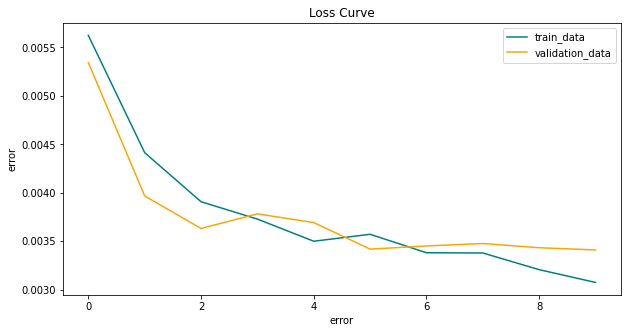

No handles with labels found to put in legend.


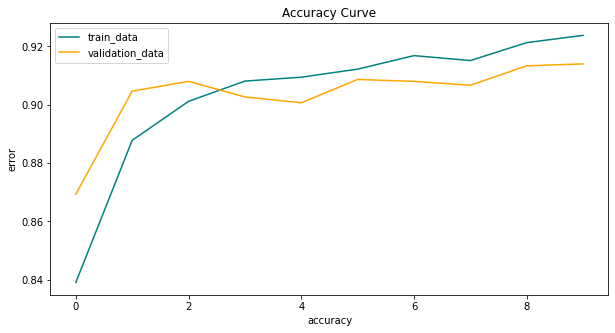

In [0]:
plot_curves("Loss Curve","error",train_error,val_error)
plot_curves("Accuracy Curve","accuracy",train_acc,val_acc)

In [0]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = cnn_vgg16(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 96 %
